# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [68]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
prev_x3_left = None
prev_x4_left = None
prev_x3_right = None
prev_x4_right = None


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


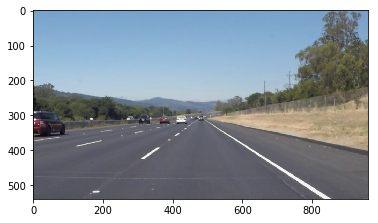

In [69]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting

print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [78]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2: #Rgb coloured image
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else: #Gray image 1 channel
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


            
def draw_lines(img, lines, color=[255, 0, 0], thickness=9):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slope =[]
    point1_left = [[],[]]
    point2_left = [[],[]]
    point1_right = [[],[]]
    point2_right = [[],[]]
    a_list_left = []
    b_list_left = []
    a_list_right = []
    b_list_right = []
    num_of_points_left = 0
    num_of_points_right = 0
    global prev_x3_left, prev_x4_left, prev_x3_right, prev_x4_right

    for line in lines:
        for x1,y1,x2,y2 in line:
            #calculate slope
            #a, b = np.polyfit((x1,x2), (y1,y2), 1)
            #calculate b coefficient of y= ax + b line equation
            a = (y2-y1)/(x2-x1)
            #b = y1 - a*x1
            #filter out lines with horizontal slopes
            if 0.3 > a > -0.3:
                continue
            #separate left and right line by slope
            # a > 0: right line, a < 0: left line
            if a < 0:
                #filter out lines with top endpoint go out of region of interest
                if x1 > 490:
                    continue
                point1_left[0].append(x1)
                point1_left[1].append(y1)
                point1_left[0].append(x2)
                point1_left[1].append(y2)
                a_list_left.append(a)
                #b_list_left.append(b)
                num_of_points_left = num_of_points_left + 1
                #cv2.circle(img,(x1,y1),8,[0,255,0],10)
                #cv2.circle(img,(x2,y2),8,[0,0,255],10)
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            else:
                #filter out lines with top endpoint go out of region of interest
                if x1 < 450:
                    continue
                point1_right[0].append(x1)
                point1_right[1].append(y1)
                point1_right[0].append(x2)
                point1_right[1].append(y2)
                a_list_right.append(a)
                #b_list_right.append(b)
                num_of_points_right = num_of_points_right + 1
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
   
    point1_left = np.array(point1_left)
    #point2_left = np.array(point2_left)
    a_list_left = np.array(a_list_left)
    b_list_left = np.array(b_list_left)
    x1_avg_left = np.mean(point1_left[0])
    y1_avg_left = np.mean(point1_left[1])
    a_avg_left = (np.mean(a_list_left))
    b_avg_left = y1_avg_left - a_avg_left*x1_avg_left
 
    point1_right = np.array(point1_right)
    #point2_right = np.array(point2_right)
    a_list_right = np.array(a_list_right)
    b_list_right = np.array(b_list_right)
    x1_avg_right = np.mean(point1_right[0])
    y1_avg_right = np.mean(point1_right[1])
    a_avg_right = (np.mean(a_list_right))
    b_avg_right = y1_avg_right - a_avg_right*x1_avg_right
    
    #find position of top and bottom points of the extrapolated points
    y3_left = 540 #y-coordinate = y-coordinate of region of interest
    x3_left = ((y3_left-b_avg_left)/a_avg_left)
    y4_left = 320 #y-coordinate = y-coordinate of region of interest
    x4_left = ((y4_left-b_avg_left)/a_avg_left)
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x2_avg_left, y2_avg_left), color, thickness)
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x4_left,y4_left), color, thickness)
   
    
    y3_right = 540
    x3_right = ((y3_right - b_avg_right)/a_avg_right)
    y4_right = 320
    x4_right = ((y4_right - b_avg_right)/a_avg_right)
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x2_avg_right, y2_avg_right), color, thickness)
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x4_right,y4_right), color, thickness)
    if prev_x3_left is not None:
        x3_left = 0.7*prev_x3_left + 0.3*x3_left
        x4_left = 0.7*prev_x4_left + 0.3*x4_left
        x3_right = 0.7*prev_x3_right + 0.3*x3_right
        x4_right = 0.7*prev_x4_right + 0.3*x4_right
    prev_x3_left = x3_left
    prev_x4_left = x4_left
    prev_x3_right = x3_right
    prev_x4_right = x4_right
    
    cv2.line(img, (int(x4_left), int(y4_left)), (int(x3_left), int(y3_left)), color, thickness)
    cv2.line(img, (int(x4_right),int(y4_right)), (int(x3_right), int(y3_right)), color, thickness)
    print ("x3 = "+str(x3_left))
    print ('y3 ='+str(y3_left))
    print ('x4 =' + str(x4_left))
    print ('y4 =' +str(y4_left))
    print ('x1_list' + str(point1_left[0]))
    print ('y1_list' + str(point1_left[1]))
    print ('x2_list' + str(point2_left[0]))
    print ('y2_list' + str(point2_left[1]))
    print ('num_points_left' + str(num_of_points_left))
    print ('num_points_right' + str(num_of_points_right))
    print ('a_avg = ' + str(a_avg_left))
    print ('b_avg = ' + str(b_avg_left))
    print ('slope_left = ' + str(a_list_left))
    print ('slope_right ' + str(a_list_right))
    
def draw_lines_original(img, lines, color=[255, 0, 0], thickness=9):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slope =[]
    point1_left = [[],[]]
    point2_left = [[],[]]
    point1_right = [[],[]]
    point2_right = [[],[]]
    a_list_left = []
    b_list_left = []
    a_list_right = []
    b_list_right = []
    num_of_points_left = 0
    num_of_points_right = 0

    for line in lines:
        for x1,y1,x2,y2 in line:
            #calculate slope
            #a, b = np.polyfit((x1,x2), (y1,y2), 1)
            #calculate b coefficient of y= ax + b line equation
            a = (y2-y1)/(x2-x1)
            #b = y1 - a*x1
            if 0.3 > a > -0.3:
                continue
            #separate left and right line by slope
            # a > 0: right line, a < 0: left line
            if a < 0:
                
                point1_left[0].append(x1)
                point1_left[1].append(y1)
                point1_left[0].append(x2)
                point1_left[1].append(y2)
                a_list_left.append(a)
                #b_list_left.append(b)
                num_of_points_left = num_of_points_left + 1
                #cv2.circle(img,(x1,y1),8,[0,255,0],10)
                #cv2.circle(img,(x2,y2),8,[0,0,255],10)
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            else:
                
                point1_right[0].append(x1)
                point1_right[1].append(y1)
                point1_right[0].append(x2)
                point1_right[1].append(y2)
                a_list_right.append(a)
                #b_list_right.append(b)
                num_of_points_right = num_of_points_right + 1
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
   
    point1_left = np.array(point1_left)
    #point2_left = np.array(point2_left)
    a_list_left = np.array(a_list_left)
    b_list_left = np.array(b_list_left)
    x1_avg_left = int(np.mean(point1_left[0]))
    y1_avg_left = int(np.mean(point1_left[1]))
    a_avg_left = (np.mean(a_list_left))
    b_avg_left = y1_avg_left - a_avg_left*x1_avg_left
 
    point1_right = np.array(point1_right)
    #point2_right = np.array(point2_right)
    a_list_right = np.array(a_list_right)
    b_list_right = np.array(b_list_right)
    x1_avg_right = int(np.mean(point1_right[0]))
    y1_avg_right = int(np.mean(point1_right[1]))
    a_avg_right = (np.mean(a_list_right))
    b_avg_right = y1_avg_right - a_avg_right*x1_avg_right
    
    #find position of top and bottom points of the extrapolated points
    y3_left = 540 #y-coordinate = y-coordinate of region of interest
    x3_left = ((y3_left-b_avg_left)/a_avg_left)
    y4_left = 320 #y-coordinate = y-coordinate of region of interest
    x4_left = ((y4_left-b_avg_left)/a_avg_left)
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x2_avg_left, y2_avg_left), color, thickness)
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x4_left,y4_left), color, thickness)
    cv2.line(img, (int(x4_left), int(y4_left)), (int(x3_left), int(y3_left)), color, thickness)
    
    y3_right = 540
    x3_right = ((y3_right - b_avg_right)/a_avg_right)
    y4_right = 320
    x4_right = ((y4_right - b_avg_right)/a_avg_right)
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x2_avg_right, y2_avg_right), color, thickness)
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x4_right,y4_right), color, thickness)
    cv2.line(img, (int(x4_right),int(y4_right)), (int(x3_right), int(y3_right)), color, thickness)
    print ("x3 = "+str(x3_left))
    print ('y3 ='+str(y3_left))
    print ('x4 =' + str(x4_left))
    print ('y4 =' +str(y4_left))
    print ('x1_list' + str(point1_left[0]))
    print ('y1_list' + str(point1_left[1]))
    print ('x2_list' + str(point2_left[0]))
    print ('y2_list' + str(point2_left[1]))
    print ('num_points_left' + str(num_of_points_left))
    print ('num_points_right' + str(num_of_points_right))
    print ('a_avg = ' + str(a_avg_left))
    print ('b_avg = ' + str(b_avg_left))
    print ('slope_left = ' + str(a_list_left))
    print ('slope_right ' + str(a_list_right))
    
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    #slope = calculate_slope(lines)
    draw_lines(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [71]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
x3 = 156.795276825
y3 =540
x4 =480.99962817
y4 =310
x1_list[258 388 155 414 307 437 175 272 175 336 411 470 386 471 300 352 396 439
 410 464 157 241 364 414]
y1_list[466 375 538 356 441 343 538 465 539 418 358 311 375 315 446 406 373 341
 332 312 537 476 397 360]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.709429096325
b_avg = 651.235131546
slope_left = [-0.7        -0.7027027  -0.75384615 -0.75257732 -0.7515528  -0.79661017
 -0.70588235 -0.76923077 -0.74418605 -0.37037037 -0.72619048 -0.74      ]
slope_right [ 0.58139535  0.6         0.60465116  0.59375     0.6         0.61111111
  0.59615385  0.42465753]


(540, 960, 3)

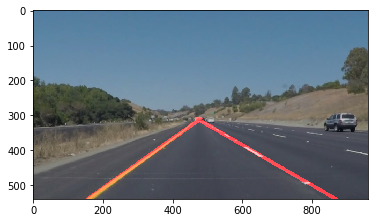

In [72]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

#Gray scale image
gray = grayscale(image)
plt.imshow(gray, cmap='gray')
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray,kernel_size)
plt.imshow(blur_gray, cmap='gray')
# Define our parameters for Canny and apply
low_threshold = 30
high_threshold = 150
edges = canny(blur_gray,low_threshold,high_threshold)
plt.imshow(edges,cmap='Greys_r')
# This time we are defining a four sided polygon to mask
#xsize = imshape[1]
#ysize = imshape[0]
imshape = image.shape
ysize = imshape[0]
xsize = imshape[1]
top_mask_bound = 310
bottom_mask_bound = 540
vertices = np.array([[(40,ysize),(450, top_mask_bound), (490,top_mask_bound), (xsize -40,ysize)]], dtype=np.int32)
masked_edges = region_of_interest(edges,vertices)
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15 # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20   # maximum gap in pixels between connectable line segments
#Run hoghline detection on edges image
line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)


#Draw the line on the colour image
line_colored_image = weighted_img(line_image,image)
plt.imshow(line_colored_image)
image.shape


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [73]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [74]:
def process_image(image):
    
    #Gray scale image
    gray = grayscale(image)
    plt.imshow(gray, cmap='gray')
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)
    plt.imshow(blur_gray, cmap='gray')
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 200
    edges = canny(blur_gray,low_threshold,high_threshold)
    plt.imshow(edges,cmap='Greys_r')
    # This time we are defining a four sided polygon to mask
    #xsize = imshape[1]
    #ysize = imshape[0]
    imshape = image.shape
    ysize = imshape[0]
    xsize = imshape[1]
    top_mask_bound = 310
    bottom_mask_bound = 540
    vertices = np.array([[(40,ysize),(450, top_mask_bound), (490,top_mask_bound), (xsize-40,ysize)]], dtype=np.int32)
    masked_edges = region_of_interest(edges,vertices)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/90 # angular resolution in radians of the Hough grid
    threshold = 10 #minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 10   # maximum gap in pixels between connectable line segments
    #Run hoghline detection on edges image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)


    #Draw the line on the colour image
    line_colored_image = weighted_img(line_image,image)
    plt.imshow(line_colored_image)
   
    return line_colored_image

Let's try the one with the solid white lane on the right first ...

x3 = 156.87375516
y3 =540
x4 =477.952033637
y4 =310
x1_list[187 302 237 310 203 273 187 299 426 471 426 453 426 468 445 470 187 289]
y1_list[514 430 489 432 514 460 512 431 343 313 342 322 341 310 332 314 513 439]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.732988044349
b_avg = 655.120808928
slope_left = [-0.73043478 -0.78082192 -0.77142857 -0.72321429 -0.66666667 -0.74074074
 -0.73809524 -0.72       -0.7254902 ]
slope_right [ 0.62616822  0.62745098  0.61538462  0.61875     0.625       0.61445783
  0.61728395  0.61627907  0.63157895  0.624       0.64516129  0.60869565
  0.61538462  0.64285714]
[MoviePy] >>>> Building video white8.mp4
[MoviePy] Writing video white8.mp4


  0%|                                                                                                                                                                                                              | 0/222 [00:00<?, ?it/s]

x3 = 156.928689995
y3 =540
x4 =475.818717463
y4 =310
x1_list[187 302 237 310 203 273 187 299 426 471 426 453 426 468 445 470 187 289]
y1_list[514 430 489 432 514 460 512 431 343 313 342 322 341 310 332 314 513 439]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.732988044349
b_avg = 655.120808928
slope_left = [-0.73043478 -0.78082192 -0.77142857 -0.72321429 -0.66666667 -0.74074074
 -0.73809524 -0.72       -0.7254902 ]
slope_right [ 0.62616822  0.62745098  0.61538462  0.61875     0.625       0.61445783
  0.61728395  0.61627907  0.63157895  0.624       0.64516129  0.60869565
  0.61538462  0.64285714]


  0%|▉                                                                                                                                                                                                     | 1/222 [00:00<00:35,  6.30it/s]

x3 = 158.400084136
y3 =540
x4 =473.869090081
y4 =310
x1_list[170 258 151 276 218 289 151 279 430 476 424 467 425 469 171 212 426 466
 150 193 193 287 264 289]
y1_list[539 471 538 447 503 448 539 446 343 310 342 311 344 310 538 506 345 316
 538 507 522 449 468 449]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.748000020983
b_avg = 661.051339571
slope_left = [-0.77272727 -0.728      -0.77464789 -0.7265625  -0.7173913  -0.72093023
 -0.77272727 -0.7804878  -0.725      -0.72093023 -0.77659574 -0.76      ]
slope_right [ 0.625       0.62091503  0.62427746  0.62790698  0.61875     0.63207547
  0.61842105  0.61702128  0.61616162  0.62162162  0.62962963  0.62264151
  0.61797753]


  1%|█▊                                                                                                                                                                                                    | 2/222 [00:00<00:35,  6.19it/s]

x3 = 158.387657694
y3 =540
x4 =473.661624291
y4 =310
x1_list[150 249 426 476 171 261 153 250 171 229 422 467 424 463 218 261 378 399
 376 396]
y1_list[538 467 346 310 539 468 537 467 538 493 346 311 346 318 503 470 379 366
 377 363]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.73057881348
b_avg = 655.693483873
slope_left = [-0.71717172 -0.72       -0.78888889 -0.72164948 -0.77586207 -0.77777778
 -0.71794872 -0.76744186 -0.61904762 -0.7       ]
slope_right [ 0.62626263  0.61458333  0.61904762  0.62264151  0.6626506   0.61682243
  0.66176471  0.61458333  0.66129032  0.60606061  0.62121212]


  1%|██▋                                                                                                                                                                                                   | 3/222 [00:00<00:35,  6.11it/s]

x3 = 157.977690883
y3 =540
x4 =472.482641484
y4 =310
x1_list[172 225 420 469 441 474 149 211 369 392 443 476 369 389 187 207 441 466
 152 172 439 470 374 394 169 189]
y1_list[536 497 348 310 335 311 539 494 382 366 334 310 381 367 510 496 331 311
 536 521 334 310 383 369 539 524]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.735504376088
b_avg = 655.489707406
slope_left = [-0.73584906 -0.7755102  -0.72727273 -0.72580645 -0.69565217 -0.72727273
 -0.7        -0.7        -0.8        -0.75       -0.77419355 -0.7        -0.75      ]
slope_right [ 0.61607143  0.62745098  0.62672811  0.62135922  0.6171875   0.61797753
  0.62686567  0.62068966  0.6185567   0.64285714  0.66666667  0.61538462
  0.61290323]


  2%|███▌                                                                                                                                                                                                  | 4/222 [00:00<00:35,  6.10it/s]

x3 = 149.925281416
y3 =540
x4 =473.35370074
y4 =310
x1_list[366 389 361 386 438 474 406 427 438 459 439 470 404 427 360 382 444 468
 448 477]
y1_list[389 373 388 370 333 311 358 344 334 322 332 310 357 343 387 371 328 310
 328 310]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.668119397709
b_avg = 627.614723141
slope_left = [-0.69565217 -0.72       -0.61111111 -0.66666667 -0.57142857 -0.70967742
 -0.60869565 -0.72727273 -0.75       -0.62068966]
slope_right [ 0.62678063  0.61666667  0.63207547  0.62672811  0.6173913   0.62121212
  0.61333333  0.61458333  0.61764706  0.625       0.61956522  0.62068966]


  2%|████▍                                                                                                                                                                                                 | 5/222 [00:00<00:36,  5.93it/s]

x3 = 153.992563152
y3 =540
x4 =472.038709992
y4 =310
x1_list[437 467 451 475 351 378 363 384 360 384 440 464 351 376]
y1_list[335 310 326 311 394 374 392 375 394 374 335 318 393 375]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.752894935752
b_avg = 663.085437858
slope_left = [-0.83333333 -0.625      -0.74074074 -0.80952381 -0.83333333 -0.70833333
 -0.72      ]
slope_right [ 0.62773723  0.62962963  0.61363636  0.6171875   0.5890411   0.61832061
  0.55555556  0.63013699  0.55555556  0.62686567  0.63636364  0.61538462
  0.56521739]


  3%|█████▎                                                                                                                                                                                                | 6/222 [00:01<00:35,  6.01it/s]

x3 = 154.08396761
y3 =540
x4 =471.474287013
y4 =310
x1_list[396 423 438 474 435 468 439 474 339 376 345 369 339 370 442 466 401 421]
y1_list[363 345 336 310 336 310 336 311 401 378 403 387 403 379 329 311 361 344]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.728170580859
b_avg = 652.354714282
slope_left = [-0.66666667 -0.72222222 -0.78787879 -0.71428571 -0.62162162 -0.66666667
 -0.77419355 -0.75       -0.85      ]
slope_right [ 0.62706271  0.62641509  0.62385321  0.62666667  0.61666667  0.61538462
  0.61616162  0.609375    0.61682243  0.62962963  0.61728395]


  3%|██████▏                                                                                                                                                                                               | 7/222 [00:01<00:34,  6.19it/s]

x3 = 149.727940817
y3 =540
x4 =472.370959039
y4 =310
x1_list[335 370 326 364 331 370 434 469 435 474 434 472 438 470 339 367]
y1_list[412 386 411 384 413 385 335 310 335 311 337 313 333 310 401 383]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.686773574561
b_avg = 635.84878358
slope_left = [-0.74285714 -0.71052632 -0.71794872 -0.71428571 -0.61538462 -0.63157895
 -0.71875    -0.64285714]
slope_right [ 0.62603878  0.6171875   0.61458333  0.61403509  0.61666667  0.6254417
  0.6125      0.6119403   0.62790698  0.62222222  0.60869565  0.61904762]


  4%|███████▏                                                                                                                                                                                              | 8/222 [00:01<00:37,  5.75it/s]

x3 = 149.164292732
y3 =540
x4 =472.194274957
y4 =310
x1_list[318 361 433 470 433 474 432 468 310 353 310 356 327 356 449 472 309 340]
y1_list[424 393 337 310 338 311 336 310 422 391 423 390 417 395 328 313 422 400]
x2_list[]
y2_list[]
num_points_left9
num_points_right15
a_avg = -0.710023592093
b_avg = 644.976358916
slope_left = [-0.72093023 -0.72972973 -0.65853659 -0.72222222 -0.72093023 -0.7173913
 -0.75862069 -0.65217391 -0.70967742]
slope_right [ 0.62650602  0.61904762  0.58333333  0.625       0.61832061  0.58585859
  0.6         0.62436548  0.64285714  0.62962963  0.58695652  0.62616822
  0.62        0.63636364  0.61333333]


  4%|████████                                                                                                                                                                                              | 9/222 [00:01<00:39,  5.46it/s]

x3 = 147.595090844
y3 =540
x4 =474.521614196
y4 =310
x1_list[320 351 289 347 299 351 431 470 431 479 432 454 319 348 297 349]
y1_list[424 401 438 399 440 402 339 311 340 310 341 327 417 399 441 403]
x2_list[]
y2_list[]
num_points_left8
num_points_right15
a_avg = -0.6844862185
b_avg = 638.520579112
slope_left = [-0.74193548 -0.67241379 -0.73076923 -0.71794872 -0.625      -0.63636364
 -0.62068966 -0.73076923]
slope_right [ 0.625       0.62820513  0.61458333  0.62011173  0.6119403   0.62237762
  0.64        0.64285714  0.625       0.64        0.6         0.62
  0.61538462  0.6         0.6       ]


  5%|████████▊                                                                                                                                                                                            | 10/222 [00:01<00:38,  5.57it/s]

x3 = 149.113937228
y3 =540
x4 =475.599983016
y4 =310
x1_list[272 340 294 332 432 482 429 472 265 290 302 339 288 333 263 285 285 318
 444 474 275 316]
y1_list[461 412 436 410 344 310 343 311 458 439 439 412 442 410 459 444 443 420
 334 315 460 430]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.706695834378
b_avg = 647.882710585
slope_left = [-0.72058824 -0.68421053 -0.68       -0.74418605 -0.76       -0.72972973
 -0.71111111 -0.68181818 -0.6969697  -0.63333333 -0.73170732]
slope_right [ 0.62871287  0.62254902  0.63265306  0.63063063  0.62376238  0.55172414
  0.625       0.62987013  0.61016949  0.6125      0.62179487  0.62352941
  0.65217391  0.64285714]


  5%|█████████▊                                                                                                                                                                                           | 11/222 [00:01<00:39,  5.29it/s]

x3 = 149.821827852
y3 =540
x4 =476.540169315
y4 =310
x1_list[239 325 230 314 242 301 427 473 250 317 427 473 430 478 230 273 450 473]
y1_list[485 423 483 422 484 441 344 311 469 421 346 317 343 313 482 451 327 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.702804325868
b_avg = 646.456282106
slope_left = [-0.72093023 -0.72619048 -0.72881356 -0.7173913  -0.71641791 -0.63043478
 -0.625      -0.72093023 -0.73913043]
slope_right [ 0.62301587  0.62411348  0.61764706  0.62436548  0.63207547  0.63157895
  0.61764706  0.625       0.62318841  0.63157895  0.62758621  0.63636364
  0.62745098]


  5%|██████████▋                                                                                                                                                                                          | 12/222 [00:02<00:40,  5.25it/s]

x3 = 151.393064356
y3 =540
x4 =476.220851818
y4 =310
x1_list[196 307 183 295 425 477 183 241 445 470 425 472 235 307 276 297 428 455
 445 477 426 453 199 263]
y1_list[516 435 515 434 346 313 514 472 332 312 344 310 487 434 449 433 343 325
 334 310 346 329 515 468]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.717815729644
b_avg = 651.303992267
slope_left = [-0.72972973 -0.72321429 -0.63461538 -0.72413793 -0.8        -0.72340426
 -0.73611111 -0.76190476 -0.66666667 -0.75       -0.62962963 -0.734375  ]
slope_right [ 0.66878981  0.62379421  0.66666667  0.67153285  0.63157895  0.61797753
  0.6744186   0.62396694  0.6122449   0.60714286  0.6       ]


  6%|███████████▌                                                                                                                                                                                         | 13/222 [00:02<00:41,  5.02it/s]

x3 = 152.300404251
y3 =540
x4 =474.679430509
y4 =310
x1_list[164 212 200 274 145 249 183 239 424 479 425 470 245 285 164 189 144 174
 225 248 442 466 425 445 238 285 430 455 219 264]
y1_list[539 502 500 447 539 464 525 482 344 310 343 310 479 448 538 519 538 517
 494 475 330 312 345 333 484 447 340 323 486 455]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.726319038536
b_avg = 652.156392413
slope_left = [-0.77083333 -0.71621622 -0.72115385 -0.76785714 -0.61818182 -0.73333333
 -0.775      -0.76       -0.7        -0.82608696 -0.75       -0.6
 -0.78723404 -0.68       -0.68888889]
slope_right [ 0.62439024  0.67058824  0.62464183  0.63207547  0.66666667  0.60465116
  0.625       0.6625      0.6         0.67153285  0.60869565]


  6%|████████████▍                                                                                                                                                                                        | 14/222 [00:02<00:40,  5.20it/s]

x3 = 151.603688869
y3 =540
x4 =473.456684031
y4 =310
x1_list[425 471 155 244 162 230 142 218 423 458 445 467 221 257 444 468 197 227
 222 247 199 246 186 212 161 185]
y1_list[345 312 530 466 538 488 539 484 345 320 326 310 493 468 327 310 511 490
 483 465 499 465 519 501 538 520]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.717347609468
b_avg = 647.586373863
slope_left = [-0.7173913  -0.71910112 -0.73529412 -0.72368421 -0.71428571 -0.72727273
 -0.69444444 -0.70833333 -0.7        -0.72       -0.72340426 -0.69230769
 -0.75      ]
slope_right [ 0.62603878  0.6626506   0.62450593  0.63333333  0.63333333  0.64
  0.64285714  0.70967742  0.63157895  0.63076923  0.625       0.63888889
  0.64285714]


  7%|█████████████▎                                                                                                                                                                                       | 15/222 [00:02<00:37,  5.47it/s]

x3 = 146.535555455
y3 =540
x4 =473.95106325
y4 =310
x1_list[138 184 157 221 143 208 419 468 439 465 440 473 373 395 420 470 371 394]
y1_list[538 507 538 491 534 490 345 312 329 310 332 310 380 366 345 311 380 366]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.675686188237
b_avg = 631.021626163
slope_left = [-0.67391304 -0.734375   -0.67692308 -0.67346939 -0.73076923 -0.66666667
 -0.63636364 -0.68       -0.60869565]
slope_right [ 0.62453532  0.62427746  0.6713615   0.66666667  0.66666667  0.60606061
  0.66129032  0.69230769]


  7%|██████████████▏                                                                                                                                                                                      | 16/222 [00:02<00:39,  5.18it/s]

x3 = 141.62808192
y3 =540
x4 =472.925465365
y4 =310
x1_list[367 390 437 467 136 156 439 470 359 384 437 464 427 451 438 465 450 471
 360 388]
y1_list[385 369 332 312 539 526 332 311 383 367 330 310 340 323 330 310 324 310
 383 367]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.675764824833
b_avg = 627.969247319
slope_left = [-0.69565217 -0.66666667 -0.65       -0.67741935 -0.64       -0.74074074
 -0.70833333 -0.74074074 -0.66666667 -0.57142857]
slope_right [ 0.62318841  0.66981132  0.6271777   0.66666667  0.66929134  0.66037736
  0.67073171  0.63793103]


  8%|███████████████                                                                                                                                                                                      | 17/222 [00:03<00:41,  4.99it/s]

x3 = 144.861100025
y3 =540
x4 =471.18478835
y4 =310
x1_list[438 469 437 464 350 380 404 424 358 384 356 384 350 377 437 466 438 465
 439 462]
y1_list[334 312 331 310 391 371 358 342 392 374 392 373 390 372 333 310 330 310
 334 316]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.730812053601
b_avg = 651.379271396
slope_left = [-0.70967742 -0.77777778 -0.66666667 -0.8        -0.69230769 -0.67857143
 -0.66666667 -0.79310345 -0.74074074 -0.7826087 ]
slope_right [ 0.62611276  0.67010309  0.625       0.66666667  0.63636364  0.66666667
  0.63461538  0.625       0.64285714  0.66906475  0.64516129]


  8%|███████████████▉                                                                                                                                                                                     | 18/222 [00:03<00:41,  4.96it/s]

x3 = 145.882889032
y3 =540
x4 =470.995077393
y4 =310
x1_list[339 371 435 469 437 474 341 374 348 378 436 469 444 466 350 377 397 422
 439 461]
y1_list[400 378 334 310 336 311 399 377 401 378 335 314 327 310 400 379 363 345
 332 316]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.713653277609
b_avg = 645.811275745
slope_left = [-0.6875     -0.70588235 -0.67567568 -0.66666667 -0.76666667 -0.63636364
 -0.77272727 -0.77777778 -0.72       -0.72727273]
slope_right [ 0.62535211  0.67195767  0.66666667  0.66666667  0.63461538  0.62453532
  0.63265306  0.64285714  0.62655602  0.61538462  0.66666667  0.64516129]


  9%|████████████████▊                                                                                                                                                                                    | 19/222 [00:03<00:39,  5.13it/s]

x3 = 149.152746001
y3 =540
x4 =470.899837493
y4 =310
x1_list[326 366 326 363 436 477 334 370 434 470 434 468 435 458 394 419]
y1_list[411 384 410 385 339 310 412 386 338 310 337 311 338 321 368 348]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.732728633248
b_avg = 654.878962653
slope_left = [-0.675      -0.67567568 -0.70731707 -0.72222222 -0.77777778 -0.76470588
 -0.73913043 -0.8       ]
slope_right [ 0.62569832  0.66666667  0.66942149  0.63461538  0.63492063  0.62962963
  0.61904762  0.66037736  0.63414634  0.66666667  0.63333333  0.625       0.6       ]


  9%|█████████████████▋                                                                                                                                                                                   | 20/222 [00:03<00:39,  5.17it/s]

x3 = 148.285762728
y3 =540
x4 =472.507030861
y4 =310
x1_list[310 356 319 362 433 469 434 479 433 457 310 355 445 471 321 361 433 453]
y1_list[423 392 425 394 338 312 340 310 339 323 422 392 330 311 424 395 340 326]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.696981636559
b_avg = 641.942486937
slope_left = [-0.67391304 -0.72093023 -0.72222222 -0.66666667 -0.66666667 -0.66666667
 -0.73076923 -0.725      -0.7       ]
slope_right [ 0.62430939  0.63333333  0.63793103  0.63636364  0.63513514  0.63793103
  0.63414634  0.63636364  0.63157895  0.62576687  0.65217391  0.60869565
  0.625     ]


  9%|██████████████████▋                                                                                                                                                                                  | 21/222 [00:03<00:39,  5.09it/s]

x3 = 146.039341352
y3 =540
x4 =474.836034739
y4 =310
x1_list[290 347 289 344 300 352 432 471 299 352 433 478 432 479]
y1_list[438 399 437 400 439 402 339 311 439 401 339 311 340 311]
x2_list[]
y2_list[]
num_points_left7
num_points_right14
a_avg = -0.677521372775
b_avg = 635.393445211
slope_left = [-0.68421053 -0.67272727 -0.71153846 -0.71794872 -0.71698113 -0.62222222
 -0.61702128]
slope_right [ 0.62535211  0.63157895  0.63265306  0.64        0.63333333  0.63291139
  0.63513514  0.63513514  0.61538462  0.63636364  0.63333333  0.60869565
  0.63636364  0.63636364]


 10%|███████████████████▌                                                                                                                                                                                 | 22/222 [00:04<00:38,  5.22it/s]

x3 = 146.22132602
y3 =540
x4 =476.53641844
y4 =310
x1_list[277 341 264 333 273 321 276 341 264 336 312 332]
y1_list[456 410 454 408 457 423 456 409 455 407 421 408]
x2_list[]
y2_list[]
num_points_left6
num_points_right13
a_avg = -0.688915598291
b_avg = 641.026687144
slope_left = [-0.71875    -0.66666667 -0.70833333 -0.72307692 -0.66666667 -0.65      ]
slope_right [ 0.62464986  0.625       0.63095238  0.63414634  0.63636364  0.63793103
  0.63793103  0.62857143  0.63333333  0.6         0.63636364  0.60869565
  0.63157895]


 10%|████████████████████▍                                                                                                                                                                                | 23/222 [00:04<00:37,  5.32it/s]

x3 = 146.917311184
y3 =540
x4 =476.942341621
y4 =310
x1_list[243 325 232 320 248 327 250 317 246 327 233 261]
y1_list[479 420 476 417 477 420 463 418 478 419 476 457]
x2_list[]
y2_list[]
num_points_left6
num_points_right14
a_avg = -0.698349001544
b_avg = 643.733652178
slope_left = [-0.7195122  -0.67045455 -0.72151899 -0.67164179 -0.72839506 -0.67857143]
slope_right [ 0.62462462  0.67032967  0.63414634  0.66666667  0.66666667  0.60869565
  0.625       0.625       0.60714286  0.65384615  0.671875    0.60869565
  0.6         0.64      ]


 11%|█████████████████████▎                                                                                                                                                                               | 24/222 [00:04<00:39,  5.00it/s]

x3 = 149.069915137
y3 =540
x4 =475.634891957
y4 =310
x1_list[190 300 270 308 187 261 200 290 288 310 201 307]
y1_list[504 430 461 432 507 457 510 445 448 431 510 433]
x2_list[]
y2_list[]
num_points_left6
num_points_right14
a_avg = -0.722154238738
b_avg = 651.278665913
slope_left = [-0.67272727 -0.76315789 -0.67567568 -0.72222222 -0.77272727 -0.72641509]
slope_right [ 0.62535211  0.63414634  0.62576687  0.64        0.63636364  0.63157895
  0.63157895  0.63265306  0.64        0.625       0.625       0.63461538
  0.60869565  0.62857143]


 11%|██████████████████████▏                                                                                                                                                                              | 25/222 [00:04<00:39,  4.93it/s]

x3 = 147.623637181
y3 =540
x4 =475.621184251
y4 =310
x1_list[162 289 141 279 182 278 163 289 441 468 426 471 141 184 452 475 425 467
 442 468 428 456]
y1_list[538 446 538 445 510 445 539 447 330 311 345 310 539 510 326 313 343 312
 333 315 341 322]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.694150581109
b_avg = 640.130519273
slope_left = [-0.72440945 -0.67391304 -0.67708333 -0.73015873 -0.7037037  -0.77777778
 -0.6744186  -0.56521739 -0.73809524 -0.69230769 -0.67857143]
slope_right [ 0.67015707  0.62691131  0.62576687  0.66972477  0.67088608  0.63461538
  0.64        0.61904762  0.66666667  0.62962963  0.625     ]


 12%|███████████████████████                                                                                                                                                                              | 26/222 [00:04<00:38,  5.05it/s]

x3 = 146.825768204
y3 =540
x4 =475.873725951
y4 =310
x1_list[164 262 453 477 204 235 147 190 440 470 423 471 182 250 424 470 377 397
 165 261 142 236 423 455]
y1_list[539 468 327 310 497 476 536 507 331 310 345 310 511 465 347 314 376 364
 537 467 538 475 346 323]
x2_list[]
y2_list[]
num_points_left12
num_points_right16
a_avg = -0.693818256718
b_avg = 640.578721056
slope_left = [-0.7244898  -0.70833333 -0.67741935 -0.6744186  -0.7        -0.72916667
 -0.67647059 -0.7173913  -0.6        -0.72916667 -0.67021277 -0.71875   ]
slope_right [ 0.62537764  0.63265306  0.62535211  0.63414634  0.63333333  0.64        0.62
  0.63793103  0.63793103  0.63157895  0.62857143  0.61538462  0.63461538
  0.60869565  0.60869565  0.63333333]


 12%|███████████████████████▉                                                                                                                                                                             | 27/222 [00:05<00:37,  5.19it/s]

x3 = 148.439739167
y3 =540
x4 =474.598199694
y4 =310
x1_list[142 213 164 225 422 471 370 392 421 465 175 210 165 226 442 477 149 186
 441 467]
y1_list[539 491 538 494 348 310 383 367 347 313 516 492 538 494 335 310 535 510
 335 316]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.720063439937
b_avg = 649.597739337
slope_left = [-0.67605634 -0.72131148 -0.7755102  -0.72727273 -0.77272727 -0.68571429
 -0.72131148 -0.71428571 -0.67567568 -0.73076923]
slope_right [ 0.6221374   0.66666667  0.66896552  0.65625     0.66666667  0.66666667
  0.63793103  0.62654321  0.63793103  0.64        0.67105263  0.63888889
  0.56756757]


 13%|████████████████████████▊                                                                                                                                                                            | 28/222 [00:05<00:36,  5.34it/s]

x3 = 146.235702606
y3 =540
x4 =475.316619182
y4 =310
x1_list[437 470 366 390 362 388 369 390 438 479 441 471]
y1_list[334 310 390 373 387 371 389 374 335 310 332 310]
x2_list[]
y2_list[]
num_points_left6
num_points_right11
a_avg = -0.684727636862
b_avg = 636.610242662
slope_left = [-0.72727273 -0.70833333 -0.61538462 -0.71428571 -0.6097561  -0.73333333]
slope_right [ 0.625       0.62535211  0.66666667  0.66666667  0.63636364  0.63636364
  0.63793103  0.63265306  0.63793103  0.63157895  0.67272727]


 13%|█████████████████████████▋                                                                                                                                                                           | 29/222 [00:05<00:35,  5.37it/s]

x3 = 148.077316327
y3 =540
x4 =474.520273553
y4 =310
x1_list[360 385 440 470 352 381 359 385 402 425 437 477 439 469 355 378]
y1_list[395 377 332 310 395 374 395 376 361 344 335 310 332 310 392 375]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.718104337254
b_avg = 649.420728305
slope_left = [-0.72       -0.73333333 -0.72413793 -0.73076923 -0.73913043 -0.625
 -0.73333333 -0.73913043]
slope_right [ 0.62301587  0.66666667  0.66129032  0.63414634  0.62454874  0.64285714
  0.66666667  0.61764706  0.6         0.66666667  0.65217391  0.65909091]


 14%|██████████████████████████▌                                                                                                                                                                          | 30/222 [00:05<00:36,  5.24it/s]

x3 = 148.5997045
y3 =540
x4 =473.766205182
y4 =310
x1_list[439 472 435 469 341 372 345 379 435 462 437 464 341 371]
y1_list[336 312 335 310 401 379 403 381 336 316 336 317 402 380]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.713868695083
b_avg = 646.950815791
slope_left = [-0.72727273 -0.73529412 -0.70967742 -0.64705882 -0.74074074 -0.7037037
 -0.73333333]
slope_right [ 0.625387    0.62204724  0.67114094  0.63513514  0.67058824  0.67272727
  0.63157895  0.63157895  0.64        0.60869565  0.60714286  0.61904762
  0.69565217]


 14%|███████████████████████████▌                                                                                                                                                                         | 31/222 [00:05<00:38,  4.95it/s]

x3 = 148.988804625
y3 =540
x4 =473.19074059
y4 =310
x1_list[328 366 436 468 454 474 434 465 352 372 434 469 342 365]
y1_list[410 384 337 314 325 311 336 312 400 386 337 310 399 384]
x2_list[]
y2_list[]
num_points_left7
num_points_right15
a_avg = -0.714393794168
b_avg = 647.085275758
slope_left = [-0.68421053 -0.71875    -0.7        -0.77419355 -0.7        -0.77142857
 -0.65217391]
slope_right [ 0.62396694  0.66666667  0.66901408  0.66666667  0.66        0.64705882
  0.6         0.66981132  0.6626506   0.64864865  0.61111111  0.70833333
  0.7037037   0.66666667  0.64705882]


 14%|████████████████████████████▍                                                                                                                                                                        | 32/222 [00:06<00:38,  5.00it/s]

x3 = 150.879593279
y3 =540
x4 =471.399249341
y4 =310
x1_list[338 358 311 355 322 363 329 363 311 346]
y1_list[403 389 422 390 422 390 417 391 421 396]
x2_list[]
y2_list[]
num_points_left5
num_points_right14
a_avg = -0.737350425758
b_avg = 654.504204587
slope_left = [-0.7        -0.72727273 -0.7804878  -0.76470588 -0.71428571]
slope_right [ 0.62019231  0.66896552  0.6244898   0.66666667  0.66666667  0.61904762
  0.63793103  0.60714286  0.62068966  0.63414634  0.625       0.67272727
  0.575       0.61904762]


 15%|█████████████████████████████▎                                                                                                                                                                       | 33/222 [00:06<00:37,  5.07it/s]

x3 = 151.473497548
y3 =540
x4 =471.292954344
y4 =310
x1_list[304 353 292 347 331 353 301 321 315 344 292 326]
y1_list[436 398 434 397 416 399 437 422 418 398 435 412]
x2_list[]
y2_list[]
num_points_left6
num_points_right12
a_avg = -0.722848418364
b_avg = 650.49408457
slope_left = [-0.7755102  -0.67272727 -0.77272727 -0.75       -0.68965517 -0.67647059]
slope_right [ 0.62460568  0.62427746  0.6626506   0.62406015  0.66863905  0.62745098
  0.63513514  0.66929134  0.6         0.64        0.61904762  0.67010309]


 15%|██████████████████████████████▏                                                                                                                                                                      | 34/222 [00:06<00:37,  5.04it/s]

x3 = 150.175854341
y3 =540
x4 =473.126860941
y4 =310
x1_list[267 336 278 342 312 333 429 453 277 342 429 479 296 342 446 474]
y1_list[453 406 455 409 421 407 339 322 455 408 341 310 441 407 331 311]
x2_list[]
y2_list[]
num_points_left8
num_points_right18
a_avg = -0.696425311554
b_avg = 642.477605807
slope_left = [-0.68115942 -0.71875    -0.66666667 -0.70833333 -0.72307692 -0.62
 -0.73913043 -0.71428571]
slope_right [ 0.62450593  0.66666667  0.67346939  0.63636364  0.66911765  0.63235294
  0.66666667  0.65789474  0.6         0.65714286  0.65789474  0.62962963
  0.66666667  0.65625     0.61290323  0.60869565  0.64705882  0.6       ]


 16%|███████████████████████████████                                                                                                                                                                      | 35/222 [00:06<00:36,  5.12it/s]

x3 = 150.890362774
y3 =540
x4 =473.609964663
y4 =310
x1_list[247 328 235 321 429 471 263 328 429 479 235 292 444 472 443 466 445 468
 435 474 253 302]
y1_list[478 420 475 417 340 310 466 418 343 310 476 437 332 310 331 314 328 311
 338 312 475 439]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.713887405993
b_avg = 648.908913005
slope_left = [-0.71604938 -0.6744186  -0.71428571 -0.73846154 -0.66       -0.68421053
 -0.78571429 -0.73913043 -0.73913043 -0.66666667 -0.73469388]
slope_right [ 0.62619808  0.67032967  0.63636364  0.63265306  0.63636364  0.63095238
  0.66929134  0.64705882  0.62711864  0.62424242  0.63157895]


 16%|███████████████████████████████▉                                                                                                                                                                     | 36/222 [00:06<00:35,  5.18it/s]

x3 = 150.181327293
y3 =540
x4 =474.329272062
y4 =310
x1_list[191 280 206 312 223 311 428 472 431 476 425 471 455 479 425 468 262 288
 275 304 191 233]
y1_list[506 446 509 432 496 432 344 310 343 310 344 310 326 310 342 311 457 440
 448 430 508 479]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.702331369504
b_avg = 644.315108929
slope_left = [-0.6741573  -0.72641509 -0.72727273 -0.77272727 -0.73333333 -0.73913043
 -0.66666667 -0.72093023 -0.65384615 -0.62068966 -0.69047619]
slope_right [ 0.62458472  0.67027027  0.63157895  0.63265306  0.63235294  0.63414634
  0.65517241  0.62433862  0.66666667  0.62903226  0.66972477  0.64705882]


 17%|████████████████████████████████▊                                                                                                                                                                    | 37/222 [00:07<00:35,  5.24it/s]

x3 = 150.02117303
y3 =540
x4 =476.571323047
y4 =310
x1_list[167 282 166 291 250 290 147 198 256 281 167 244 424 446 216 289 236 280
 425 445]
y1_list[523 445 538 447 476 447 538 503 461 445 538 482 345 330 501 448 475 445
 345 332]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.692447186754
b_avg = 643.622976357
slope_left = [-0.67826087 -0.728      -0.725      -0.68627451 -0.64       -0.72727273
 -0.68181818 -0.7260274  -0.68181818 -0.65      ]
slope_right [ 0.625       0.66863905  0.67027027  0.66666667  0.63333333  0.62903226
  0.63461538  0.64516129  0.625       0.62745098]


 17%|█████████████████████████████████▋                                                                                                                                                                   | 38/222 [00:07<00:36,  4.97it/s]

x3 = 150.735712375
y3 =540
x4 =475.089882706
y4 =310
x1_list[145 226 192 253 166 264 187 264 145 173 425 445 423 444]
y1_list[538 483 505 464 538 467 522 466 539 520 346 330 346 330]
x2_list[]
y2_list[]
num_points_left7
num_points_right9
a_avg = -0.720483172412
b_avg = 649.803775921
slope_left = [-0.67901235 -0.67213115 -0.7244898  -0.72727273 -0.67857143 -0.8
 -0.76190476]
slope_right [ 0.6254417   0.67105263  0.66666667  0.63333333  0.62903226  0.62457338
  0.66666667  0.63636364  0.63414634]


 18%|██████████████████████████████████▌                                                                                                                                                                  | 39/222 [00:07<00:37,  4.88it/s]

x3 = 150.141950771
y3 =540
x4 =474.234355331
y4 =310
x1_list[441 475 164 228 375 396 420 469 164 213 143 172 163 229 443 474 439 465
 151 175 178 198 420 471]
y1_list[333 311 539 492 382 368 346 310 525 490 539 518 538 490 333 312 331 312
 534 516 514 500 347 310]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.711014126836
b_avg = 645.767977956
slope_left = [-0.64705882 -0.734375   -0.66666667 -0.73469388 -0.71428571 -0.72413793
 -0.72727273 -0.67741935 -0.73076923 -0.75       -0.7        -0.7254902 ]
slope_right [ 0.62686567  0.67346939  0.625       0.67032967  0.66906475  0.67032967
  0.62962963  0.66666667]


 18%|███████████████████████████████████▍                                                                                                                                                                 | 40/222 [00:07<00:37,  4.91it/s]

x3 = 149.279168114
y3 =540
x4 =472.833713165
y4 =310
x1_list[438 465 441 475 363 387 370 391 142 163 142 162 440 474 417 469]
y1_list[332 312 333 310 385 368 387 370 538 524 539 525 334 311 348 310]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.713621869688
b_avg = 645.092244384
slope_left = [-0.74074074 -0.67647059 -0.70833333 -0.80952381 -0.66666667 -0.7
 -0.67647059 -0.73076923]
slope_right [ 0.67317073  0.625       0.66896552  0.65714286  0.63218391  0.62068966
  0.6728972   0.67355372  0.60869565  0.66666667]


 18%|████████████████████████████████████▍                                                                                                                                                                | 41/222 [00:07<00:35,  5.06it/s]

x3 = 147.259876654
y3 =540
x4 =472.51076648
y4 =310
x1_list[353 382 436 465 359 385 439 475 440 466 437 463]
y1_list[391 372 334 311 393 374 334 310 333 315 331 314]
x2_list[]
y2_list[]
num_points_left6
num_points_right9
a_avg = -0.69864426761
b_avg = 639.590480401
slope_left = [-0.65517241 -0.79310345 -0.73076923 -0.66666667 -0.69230769 -0.65384615]
slope_right [ 0.63636364  0.6271777   0.67021277  0.67181467  0.6259542   0.62068966
  0.67272727  0.63291139  0.62264151]


 19%|█████████████████████████████████████▎                                                                                                                                                               | 42/222 [00:07<00:34,  5.29it/s]

x3 = 151.007480435
y3 =540
x4 =471.175833411
y4 =310
x1_list[343 373 450 474 436 465 437 464 440 470 398 421 346 375]
y1_list[399 377 327 310 334 311 335 316 334 312 362 343 397 376]
x2_list[]
y2_list[]
num_points_left7
num_points_right7
a_avg = -0.746004577077
b_avg = 659.175640581
slope_left = [-0.73333333 -0.70833333 -0.79310345 -0.7037037  -0.73333333 -0.82608696
 -0.72413793]
slope_right [ 0.62730627  0.67158672  0.63333333  0.66666667  0.62295082  0.67039106
  0.62686567]


 19%|██████████████████████████████████████▏                                                                                                                                                              | 43/222 [00:08<00:35,  5.07it/s]

x3 = 153.860437309
y3 =540
x4 =468.753158765
y4 =310
x1_list[332 367 345 367 330 364 337 359]
y1_list[406 381 404 386 407 382 409 392]
x2_list[]
y2_list[]
num_points_left4
num_points_right8
a_avg = -0.76012223071
b_avg = 662.012796028
slope_left = [-0.71428571 -0.81818182 -0.73529412 -0.77272727]
slope_right [ 0.625       0.67235495  0.66901408  0.62162162  0.62790698  0.69565217
  0.60869565  0.62430939]


 20%|███████████████████████████████████████                                                                                                                                                              | 44/222 [00:08<00:35,  4.99it/s]

x3 = 154.856423635
y3 =540
x4 =467.669947447
y4 =310
x1_list[314 356 324 364 317 359 339 364]
y1_list[419 388 420 389 417 387 407 388]
x2_list[]
y2_list[]
num_points_left4
num_points_right11
a_avg = -0.746845238095
b_avg = 657.389427083
slope_left = [-0.73809524 -0.775      -0.71428571 -0.76      ]
slope_right [ 0.62396694  0.6722408   0.66666667  0.63218391  0.66197183  0.66666667
  0.58823529  0.67391304  0.62857143  0.62820513  0.625     ]


 20%|███████████████████████████████████████▉                                                                                                                                                             | 45/222 [00:08<00:37,  4.76it/s]

x3 = 154.057326068
y3 =540
x4 =467.817654066
y4 =310
x1_list[432 471 295 347 305 354 431 464 304 354 433 463 430 450 295 344 430 469]
y1_list[338 312 432 395 434 396 337 311 434 395 337 313 335 321 431 396 337 313]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.727918272204
b_avg = 650.783894597
slope_left = [-0.66666667 -0.71153846 -0.7755102  -0.78787879 -0.78       -0.8        -0.7
 -0.71428571 -0.61538462]
slope_right [ 0.62671233  0.67123288  0.67111111  0.63063063  0.62601626  0.625
  0.67647059  0.67708333]


 21%|████████████████████████████████████████▊                                                                                                                                                            | 46/222 [00:08<00:36,  4.84it/s]

x3 = 152.275555843
y3 =540
x4 =468.214629073
y4 =310
x1_list[281 343 270 333 429 474 435 465 270 336 428 453 428 466 302 342 282 320
 434 457 270 302]
y1_list[450 405 449 403 338 310 334 311 450 402 338 321 337 311 434 404 450 422
 336 319 448 425]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.716459987663
b_avg = 646.120686356
slope_left = [-0.72580645 -0.73015873 -0.62222222 -0.76666667 -0.72727273 -0.68
 -0.68421053 -0.75       -0.73684211 -0.73913043 -0.71875   ]
slope_right [ 0.67175573  0.625       0.63013699  0.67045455  0.62264151  0.7037037
  0.71428571  0.67340067  0.625     ]


 21%|█████████████████████████████████████████▋                                                                                                                                                           | 47/222 [00:09<00:35,  4.90it/s]

x3 = 148.017794613
y3 =540
x4 =469.927498117
y4 =310
x1_list[251 311 250 329 428 463 430 470 251 329 240 287 427 448 296 323 240 260
 434 454 444 469 451 474]
y1_list[461 420 472 414 340 313 339 312 472 415 469 437 338 323 429 412 470 456
 337 324 330 314 324 310]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.68484753422
b_avg = 634.565814676
slope_left = [-0.68333333 -0.73417722 -0.77142857 -0.675      -0.73076923 -0.68085106
 -0.71428571 -0.62962963 -0.7        -0.65       -0.64       -0.60869565]
slope_right [ 0.62686567  0.67326733  0.62790698  0.6302521   0.625       0.66666667
  0.66666667  0.6728972 ]


 22%|██████████████████████████████████████████▌                                                                                                                                                          | 48/222 [00:09<00:35,  4.86it/s]

x3 = 145.699495054
y3 =540
x4 =471.647529722
y4 =310
x1_list[198 280 210 313 428 473 424 468 198 233 424 455 281 308 426 452 268 292
 252 275 212 235]
y1_list[498 442 502 427 341 311 340 310 499 475 341 320 440 424 341 322 459 441
 460 445 501 485]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.685808051675
b_avg = 636.212100325
slope_left = [-0.68292683 -0.72815534 -0.66666667 -0.68181818 -0.68571429 -0.67741935
 -0.59259259 -0.73076923 -0.75       -0.65217391 -0.69565217]
slope_right [ 0.67193676  0.62874251  0.67368421  0.6302521   0.66666667  0.62445415
  0.62745098  0.66666667]


 22%|███████████████████████████████████████████▍                                                                                                                                                         | 49/222 [00:09<00:34,  4.96it/s]

x3 = 145.547598799
y3 =540
x4 =473.345625006
y4 =310
x1_list[164 292 198 284 141 229 161 223 442 474 140 189 233 292 261 281 161 265]
y1_list[535 442 497 439 537 477 539 493 331 311 538 505 484 441 453 440 538 462]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.692531883132
b_avg = 640.550902349
slope_left = [-0.7265625  -0.6744186  -0.68181818 -0.74193548 -0.625      -0.67346939
 -0.72881356 -0.65       -0.73076923]
slope_right [ 0.67123288  0.62893082  0.62666667  0.62745098  0.675       0.62616822
  0.67293233  0.60606061  0.7         0.64285714]


 23%|████████████████████████████████████████████▎                                                                                                                                                        | 50/222 [00:09<00:34,  4.94it/s]

x3 = 147.231276996
y3 =540
x4 =470.465635253
y4 =310
x1_list[161 246 213 266 207 255 160 188 186 234 374 395 139 203 422 443 421 442
 183 216]
y1_list[524 463 500 459 492 458 539 517 520 483 374 361 539 493 344 329 344 328
 522 496]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.735797979998
b_avg = 651.223119246
slope_left = [-0.71764706 -0.77358491 -0.70833333 -0.78571429 -0.77083333 -0.61904762
 -0.71875    -0.71428571 -0.76190476 -0.78787879]
slope_right [ 0.67375887  0.62790698  0.62903226  0.67510549  0.64        0.6
  0.62676056  0.63793103  0.62650602]


 23%|█████████████████████████████████████████████▎                                                                                                                                                       | 51/222 [00:09<00:34,  4.97it/s]

x3 = 144.547777354
y3 =540
x4 =470.630401742
y4 =310
x1_list[157 232 142 219 137 192 367 389 420 450 194 216 366 387 158 231 371 392
 419 449 367 388]
y1_list[538 483 534 482 538 501 379 364 345 323 498 483 378 364 539 485 380 367
 345 323 378 364]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.691254117406
b_avg = 635.590959179
slope_left = [-0.73333333 -0.67532468 -0.67272727 -0.68181818 -0.73333333 -0.68181818
 -0.66666667 -0.73972603 -0.61904762 -0.73333333 -0.66666667]
slope_right [ 0.67068273  0.62790698  0.62871287  0.67132867  0.66666667  0.62608696
  0.60606061  0.70833333  0.62650602]


 23%|██████████████████████████████████████████████▏                                                                                                                                                      | 52/222 [00:10<00:40,  4.24it/s]

x3 = 142.678798167
y3 =540
x4 =471.051339048
y4 =310
x1_list[440 472 135 169 157 185 363 386 437 461 358 382 438 466 136 170 359 385
 156 182]
y1_list[333 312 538 515 538 517 386 369 331 315 384 368 330 310 538 515 384 368
 538 519]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.689209450503
b_avg = 635.329967139
slope_left = [-0.65625    -0.67647059 -0.75       -0.73913043 -0.66666667 -0.66666667
 -0.71428571 -0.67647059 -0.61538462 -0.73076923]
slope_right [ 0.62576687  0.67235495  0.62871287  0.66990291  0.7         0.62637363
  0.6         0.70967742]


 24%|███████████████████████████████████████████████                                                                                                                                                      | 53/222 [00:10<00:41,  4.08it/s]

x3 = 137.48488251
y3 =540
x4 =471.426974418
y4 =310
x1_list[435 469 434 467 348 378 353 380 438 473 356 379 437 471 435 455 437 468]
y1_list[333 310 332 310 390 372 393 375 334 311 392 376 334 311 334 321 331 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.662943210633
b_avg = 623.110370142
slope_left = [-0.67647059 -0.66666667 -0.6        -0.66666667 -0.65714286 -0.69565217
 -0.67647059 -0.65       -0.67741935]
slope_right [ 0.67142857  0.62773723  0.625       0.66666667  0.66666667  0.64864865
  0.59459459  0.7037037   0.64705882  0.62698413  0.7       ]


 24%|███████████████████████████████████████████████▉                                                                                                                                                     | 54/222 [00:10<00:41,  4.01it/s]

x3 = 134.935625067
y3 =540
x4 =471.223549558
y4 =310
x1_list[342 374 337 370 337 368 394 421 339 369]
y1_list[401 379 399 377 398 377 362 344 397 377]
x2_list[]
y2_list[]
num_points_left5
num_points_right7
a_avg = -0.672983870968
b_avg = 626.80641129
slope_left = [-0.6875     -0.66666667 -0.67741935 -0.66666667 -0.66666667]
slope_right [ 0.62765957  0.67153285  0.66917293  0.62711864  0.66        0.625
  0.62601626]


 25%|████████████████████████████████████████████████▊                                                                                                                                                    | 55/222 [00:10<00:40,  4.13it/s]

x3 = 134.559498207
y3 =540
x4 =471.891464619
y4 =310
x1_list[322 364 330 366 332 355 329 357]
y1_list[409 383 411 385 402 387 411 391]
x2_list[]
y2_list[]
num_points_left4
num_points_right9
a_avg = -0.67693236715
b_avg = 630.493583937
slope_left = [-0.61904762 -0.72222222 -0.65217391 -0.71428571]
slope_right [ 0.67164179  0.62658228  0.63265306  0.66878981  0.67330677  0.66666667
  0.66666667  0.62831858  0.62692308]


 25%|█████████████████████████████████████████████████▋                                                                                                                                                   | 56/222 [00:11<00:40,  4.08it/s]

x3 = 137.437592673
y3 =540
x4 =471.391456795
y4 =310
x1_list[306 352 316 357 313 357 310 334 335 357]
y1_list[421 390 422 392 423 391 419 403 409 393]
x2_list[]
y2_list[]
num_points_left5
num_points_right11
a_avg = -0.705366496353
b_avg = 641.680799833
slope_left = [-0.67391304 -0.73170732 -0.72727273 -0.66666667 -0.72727273]
slope_right [ 0.62640449  0.66101695  0.62770563  0.67032967  0.63829787  0.70588235
  0.63793103  0.7037037   0.66964286  0.62962963  0.625     ]


 26%|██████████████████████████████████████████████████▌                                                                                                                                                  | 57/222 [00:11<00:41,  3.98it/s]

x3 = 138.979231224
y3 =540
x4 =471.989708666
y4 =310
x1_list[286 342 296 347 433 476 295 345 286 341 430 467 429 465]
y1_list[436 398 437 400 340 311 437 401 435 398 341 313 341 318]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.695264735382
b_avg = 639.128334566
slope_left = [-0.67857143 -0.7254902  -0.6744186  -0.72       -0.67272727 -0.75675676
 -0.63888889]
slope_right [ 0.62390671  0.67052023  0.63793103  0.61538462  0.6625      0.62561576
  0.63235294  0.60869565  0.60869565  0.69565217  0.66666667  0.69565217]


 26%|███████████████████████████████████████████████████▍                                                                                                                                                 | 58/222 [00:11<00:38,  4.27it/s]

x3 = 135.215930547
y3 =540
x4 =473.655974075
y4 =310
x1_list[272 335 427 469 267 306 429 477 304 329 441 465 293 332 427 481 270 335
 260 287 433 455]
y1_list[454 408 340 312 447 422 342 310 422 406 330 313 429 406 341 310 454 407
 452 435 337 323]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.655067171885
b_avg = 622.823349511
slope_left = [-0.73015873 -0.66666667 -0.64102564 -0.66666667 -0.64       -0.70833333
 -0.58974359 -0.57407407 -0.72307692 -0.62962963 -0.63636364]
slope_right [ 0.67193676  0.66666667  0.625       0.62711864  0.66666667  0.62893082
  0.67346939]


 27%|████████████████████████████████████████████████████▎                                                                                                                                                | 59/222 [00:11<00:40,  4.05it/s]

x3 = 135.998088656
y3 =540
x4 =473.748391064
y4 =310
x1_list[226 313 240 320 226 312 444 466 442 477 238 283 425 477 298 319 452 481
 228 314 426 448]
y1_list[475 416 476 418 474 416 329 313 332 311 476 444 342 310 435 419 327 310
 474 416 342 325]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.68423686489
b_avg = 634.303662442
slope_left = [-0.67816092 -0.725      -0.6744186  -0.72727273 -0.6        -0.71111111
 -0.61538462 -0.76190476 -0.5862069  -0.6744186  -0.77272727]
slope_right [ 0.67153285  0.62857143  0.67253521  0.62631579  0.62820513  0.66153846
  0.62820513  0.66666667  0.62676056]


 27%|█████████████████████████████████████████████████████▏                                                                                                                                               | 60/222 [00:12<00:36,  4.41it/s]

x3 = 136.576343194
y3 =540
x4 =473.952111513
y4 =310
x1_list[182 295 197 303 427 476 195 251 423 450 424 473 265 286 182 261 259 288]
y1_list[505 429 507 430 344 311 507 467 342 325 344 311 448 434 504 451 463 442]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.683502917677
b_avg = 634.272552608
slope_left = [-0.67256637 -0.72641509 -0.67346939 -0.71428571 -0.62962963 -0.67346939
 -0.66666667 -0.67088608 -0.72413793]
slope_right [ 0.67340067  0.62857143  0.63013699  0.63114754  0.67286245  0.7027027
  0.71794872  0.61904762  0.62857143]


 27%|██████████████████████████████████████████████████████▏                                                                                                                                              | 61/222 [00:12<00:43,  3.66it/s]

x3 = 137.446486936
y3 =540
x4 =474.404428158
y4 =310
x1_list[161 279 204 273 151 194 421 477 131 269 240 281 423 469 132 270 441 471
 152 221]
y1_list[532 447 490 444 538 507 345 311 538 445 476 447 345 312 538 445 334 315
 538 488]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.684558421839
b_avg = 635.48003338
slope_left = [-0.72033898 -0.66666667 -0.72093023 -0.60714286 -0.67391304 -0.70731707
 -0.7173913  -0.67391304 -0.63333333 -0.72463768]
slope_right [ 0.67383513  0.61538462  0.62765957  0.62913907  0.62987013  0.69565217
  0.69230769  0.67647059  0.625       0.71428571  0.6728972   0.63      ]


 28%|███████████████████████████████████████████████████████                                                                                                                                              | 62/222 [00:12<00:44,  3.59it/s]

x3 = 134.111581932
y3 =540
x4 =476.736463447
y4 =310
x1_list[161 252 437 468 136 191 208 240 427 476 151 211 132 165 439 477 192 230
 373 393 375 395 219 243 173 209 424 456]
y1_list[532 466 333 312 534 499 488 465 341 311 538 495 538 517 335 312 497 473
 375 363 378 366 479 464 510 487 342 322]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.64634385083
b_avg = 621.652707175
slope_left = [-0.72527473 -0.67741935 -0.63636364 -0.71875    -0.6122449  -0.71666667
 -0.63636364 -0.60526316 -0.63157895 -0.6        -0.6        -0.625
 -0.63888889 -0.625     ]
slope_right [ 0.67261905  0.62790698  0.62903226  0.63076923  0.66666667  0.63157895
  0.67123288  0.7         0.61904762  0.6730038 ]


 28%|███████████████████████████████████████████████████████▉                                                                                                                                             | 63/222 [00:12<00:40,  3.91it/s]

x3 = 134.629952676
y3 =540
x4 =476.633283584
y4 =310
x1_list[151 215 150 204 368 390 131 201 418 450 365 387 417 449 372 392 417 449
 165 209]
y1_list[539 492 526 490 383 369 538 491 349 328 381 367 348 326 382 369 349 327
 529 497]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.67537202381
b_avg = 631.7421875
slope_left = [-0.734375   -0.66666667 -0.63636364 -0.67142857 -0.65625    -0.63636364
 -0.6875     -0.65       -0.6875     -0.72727273]
slope_right [ 0.67559524  0.67391304  0.62962963  0.62857143  0.67391304  0.66071429
  0.64        0.671875    0.66666667  0.7       ]


 29%|████████████████████████████████████████████████████████▊                                                                                                                                            | 64/222 [00:13<00:37,  4.25it/s]

x3 = 134.202870937
y3 =540
x4 =475.880087891
y4 =310
x1_list[437 476 434 466 436 472 363 385 356 380 415 455 360 386]
y1_list[337 311 334 313 334 310 388 371 388 371 350 323 388 373]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.674652430902
b_avg = 629.867985735
slope_left = [-0.66666667 -0.65625    -0.66666667 -0.77272727 -0.70833333 -0.675
 -0.57692308]
slope_right [ 0.67482517  0.63636364  0.62886598  0.63333333  0.65384615  0.66666667
  0.67052023  0.7         0.7037037   0.65384615  0.7       ]


 29%|█████████████████████████████████████████████████████████▋                                                                                                                                           | 65/222 [00:13<00:36,  4.36it/s]

x3 = 130.30323168
y3 =540
x4 =475.696675778
y4 =310
x1_list[353 380 347 375 400 422 435 472 433 476 434 455 448 481 396 420 347 374]
y1_list[394 376 393 374 361 346 333 310 337 310 334 321 329 310 361 344 392 374]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.649598896692
b_avg = 618.734032365
slope_left = [-0.66666667 -0.67857143 -0.68181818 -0.62162162 -0.62790698 -0.61904762
 -0.57575758 -0.70833333 -0.66666667]
slope_right [ 0.68235294  0.62921348  0.67557252  0.62886598  0.63218391  0.70731707
  0.70588235  0.71153846  0.67307692  0.64285714  0.60714286  0.6754717 ]


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                          | 66/222 [00:13<00:35,  4.45it/s]

x3 = 125.624184096
y3 =540
x4 =475.799916701
y4 =310
x1_list[336 368 343 372 432 478 336 369 432 468 432 476 352 374]
y1_list[398 377 400 379 336 310 399 377 334 311 335 310 393 379]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.636529476063
b_avg = 613.014008766
slope_left = [-0.65625    -0.72413793 -0.56521739 -0.66666667 -0.63888889 -0.56818182
 -0.63636364]
slope_right [ 0.67256637  0.63        0.66233766  0.66071429  0.67123288  0.66666667
  0.65957447  0.66666667  0.63888889  0.65909091  0.66037736  0.6         0.64      ]


 30%|███████████████████████████████████████████████████████████▍                                                                                                                                         | 67/222 [00:14<00:48,  3.17it/s]

x3 = 125.227715759
y3 =540
x4 =474.546407779
y4 =310
x1_list[430 463 434 474 329 366 332 363 322 343 444 467]
y1_list[337 313 337 310 409 384 400 382 407 394 327 311]
x2_list[]
y2_list[]
num_points_left6
num_points_right15
a_avg = -0.662215559533
b_avg = 622.315131025
slope_left = [-0.72727273 -0.675      -0.67567568 -0.58064516 -0.61904762 -0.69565217]
slope_right [ 0.67551622  0.6625      0.66129032  0.66        0.65957447  0.65957447
  0.66071429  0.67567568  0.67123288  0.66666667  0.67256637  0.66666667
  0.69565217  0.66964286  0.69565217]


 31%|████████████████████████████████████████████████████████████▎                                                                                                                                        | 68/222 [00:14<00:41,  3.67it/s]

x3 = 125.039493246
y3 =540
x4 =474.440379366
y4 =310
x1_list[306 354 318 357 323 350 306 327 314 346]
y1_list[417 388 418 390 406 389 418 405 420 397]
x2_list[]
y2_list[]
num_points_left5
num_points_right8
a_avg = -0.657908526659
b_avg = 621.97560465
slope_left = [-0.60416667 -0.71794872 -0.62962963 -0.61904762 -0.71875   ]
slope_right [ 0.67247387  0.62941176  0.62962963  0.625       0.67202572  0.63793103
  0.64        0.54545455]


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                       | 69/222 [00:14<00:38,  3.98it/s]

x3 = 127.304120391
y3 =540
x4 =473.737911788
y4 =310
x1_list[432 476 304 347 287 340 295 315 430 467 428 469 428 467 428 450 296 335
 286 336]
y1_list[339 310 428 397 432 396 433 419 340 315 338 311 337 311 339 325 433 405
 431 398]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.677445770669
b_avg = 629.821349471
slope_left = [-0.65909091 -0.72093023 -0.67924528 -0.7        -0.67567568 -0.65853659
 -0.66666667 -0.63636364 -0.71794872 -0.66      ]
slope_right [ 0.67455621  0.66666667  0.66981132  0.66666667  0.66666667  0.66666667
  0.67088608  0.66666667  0.66666667  0.67676768  0.66666667  0.7
  0.66666667  0.69565217]


 32%|██████████████████████████████████████████████████████████████                                                                                                                                       | 70/222 [00:14<00:37,  4.06it/s]

x3 = 128.000225564
y3 =540
x4 =473.001285322
y4 =310
x1_list[273 335 284 329 262 295 272 307 302 335 298 318 305 327]
y1_list[449 404 432 404 447 426 449 424 429 405 424 411 418 404]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.673187769732
b_avg = 627.261608514
slope_left = [-0.72580645 -0.62222222 -0.63636364 -0.71428571 -0.72727273 -0.65
 -0.63636364]
slope_right [ 0.67462687  0.67412141  0.63013699  0.63333333  0.66666667  0.66176471
  0.67647059  0.63043478  0.66666667  0.64705882  0.65853659]


 32%|███████████████████████████████████████████████████████████████                                                                                                                                      | 71/222 [00:14<00:34,  4.36it/s]

x3 = 129.184105527
y3 =540
x4 =471.854697449
y4 =310
x1_list[230 311 239 321 443 475 424 466 294 314 426 473 241 291 243 313 448 468
 440 465]
y1_list[468 414 470 415 331 310 341 311 426 413 342 310 470 436 460 413 325 310
 328 311]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.682021372353
b_avg = 629.990327624
slope_left = [-0.66666667 -0.67073171 -0.65625    -0.71428571 -0.65       -0.68085106
 -0.68       -0.67142857 -0.75       -0.68      ]
slope_right [ 0.67524116  0.63013699  0.66666667  0.63291139  0.67272727  0.67320261
  0.625       0.66666667  0.57142857  0.69565217  0.5         0.65384615
  0.7         0.66101695]


 32%|███████████████████████████████████████████████████████████████▉                                                                                                                                     | 72/222 [00:15<00:35,  4.28it/s]

x3 = 129.621060978
y3 =540
x4 =471.952108251
y4 =310
x1_list[198 305 187 293 422 467 425 474 187 265 262 304 275 297 422 457 201 250
 429 449 423 454 442 475 242 304 442 468]
y1_list[499 427 497 426 341 311 343 310 496 444 455 426 439 425 343 318 498 465
 339 326 343 322 332 310 469 427 329 311]
x2_list[]
y2_list[]
num_points_left14
num_points_right15
a_avg = -0.673422802546
b_avg = 627.976374936
slope_left = [-0.6728972  -0.66981132 -0.66666667 -0.67346939 -0.66666667 -0.69047619
 -0.63636364 -0.71428571 -0.67346939 -0.65       -0.67741935 -0.66666667
 -0.67741935 -0.69230769]
slope_right [ 0.6742671   0.67559524  0.6625      0.66964286  0.66        0.66666667
  0.68        0.66071429  0.66233766  0.67567568  0.66666667  0.7037037
  0.69565217  0.67346939  0.67857143]


 33%|████████████████████████████████████████████████████████████████▊                                                                                                                                    | 73/222 [00:15<00:38,  3.86it/s]

x3 = 129.887845383
y3 =540
x4 =472.583843484
y4 =310
x1_list[153 271 438 468 174 255 127 243 212 272 217 283 420 477 143 170 420 453
 144 218 253 283 377 397 127 199 442 467 439 467 146 185]
y1_list[520 441 331 311 518 460 537 459 481 441 488 440 345 310 538 519 343 323
 539 486 463 442 370 359 536 488 331 315 331 312 537 509]
x2_list[]
y2_list[]
num_points_left16
num_points_right15
a_avg = -0.669485199296
b_avg = 627.374742545
slope_left = [-0.66949153 -0.66666667 -0.71604938 -0.67241379 -0.66666667 -0.72727273
 -0.61403509 -0.7037037  -0.60606061 -0.71621622 -0.7        -0.55
 -0.66666667 -0.64       -0.67857143 -0.71794872]
slope_right [ 0.67559524  0.67213115  0.68131868  0.67391304  0.6625      0.66666667
  0.66071429  0.66101695  0.66666667  0.67857143  0.66666667  0.69565217
  0.67434211  0.67307692  0.67647059]


 33%|█████████████████████████████████████████████████████████████████▋                                                                                                                                   | 74/222 [00:15<00:38,  3.81it/s]

x3 = 128.167168777
y3 =540
x4 =473.729147561
y4 =310
x1_list[142 256 374 394 179 256 123 200 417 475 436 467 173 244 225 245 143 212
 444 468 371 393 438 471 141 232]
y1_list[538 461 377 364 512 460 538 487 346 310 332 311 506 459 472 459 538 491
 327 311 375 362 334 314 527 466]
x2_list[]
y2_list[]
num_points_left13
num_points_right14
a_avg = -0.652946709954
b_avg = 621.064807543
slope_left = [-0.6754386  -0.65       -0.67532468 -0.66233766 -0.62068966 -0.67741935
 -0.66197183 -0.65       -0.68115942 -0.66666667 -0.59090909 -0.60606061
 -0.67032967]
slope_right [ 0.6744186   0.62987013  0.62758621  0.63333333  0.64        0.64705882
  0.6         0.66666667  0.76923077  0.59375     0.76923077  0.67381974
  0.60869565  0.66666667]


 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                  | 75/222 [00:15<00:36,  4.05it/s]

x3 = 125.469248108
y3 =540
x4 =474.987815295
y4 =310
x1_list[155 208 140 220 364 385 120 179 369 390 403 423 367 388 424 467 149 220
 124 209 447 467]
y1_list[515 482 538 484 379 365 538 501 380 366 352 341 381 367 342 315 531 483
 535 482 327 314]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.641113898185
b_avg = 616.404171736
slope_left = [-0.62264151 -0.675      -0.66666667 -0.62711864 -0.66666667 -0.55
 -0.66666667 -0.62790698 -0.67605634 -0.62352941 -0.65      ]
slope_right [ 0.62913907  0.67730496  0.6768559   0.67164179  0.67307692  0.66666667
  0.66666667  0.66666667  0.65714286  0.65909091  0.6626506   0.68627451]


 34%|███████████████████████████████████████████████████████████████████▍                                                                                                                                 | 76/222 [00:16<00:33,  4.37it/s]

x3 = 123.769414135
y3 =540
x4 =473.904042813
y4 =310
x1_list[355 379 362 384 433 465 138 172 118 159 434 471 436 468 400 422 357 378
 399 422 120 142 437 466]
y1_list[384 368 385 369 332 311 538 515 538 513 334 313 331 310 357 343 382 368
 357 341 538 524 334 315]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.654204347867
b_avg = 618.375731717
slope_left = [-0.66666667 -0.72727273 -0.65625    -0.67647059 -0.6097561  -0.56756757
 -0.65625    -0.63636364 -0.66666667 -0.69565217 -0.63636364 -0.65517241]
slope_right [ 0.62931034  0.67901235  0.67375887  0.67647059  0.65517241  0.68181818
  0.66666667  0.66666667  0.7         0.67741935  0.67567568  0.67045455]


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                                | 77/222 [00:16<00:31,  4.61it/s]

x3 = 122.28194543
y3 =540
x4 =472.956376941
y4 =310
x1_list[349 377 397 467 345 373 433 464 351 378 441 469 444 471 344 367]
y1_list[392 374 360 310 390 372 333 311 392 374 330 313 327 311 390 375]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.6535316811
b_avg = 617.646873545
slope_left = [-0.64285714 -0.71428571 -0.64285714 -0.70967742 -0.66666667 -0.60714286
 -0.59259259 -0.65217391]
slope_right [ 0.63076923  0.67357513  0.63636364  0.63157895  0.63414634  0.67479675
  0.67924528  0.67889908  0.64705882  0.62637363  0.61904762  0.66666667
  0.60869565  0.66216216]


 35%|█████████████████████████████████████████████████████████████████████▏                                                                                                                               | 78/222 [00:16<00:39,  3.67it/s]

x3 = 121.286150803
y3 =540
x4 =473.029551821
y4 =310
x1_list[333 368 342 371 339 368 333 369]
y1_list[397 376 399 378 400 380 398 377]
x2_list[]
y2_list[]
num_points_left4
num_points_right17
a_avg = -0.649281609195
b_avg = 617.240247845
slope_left = [-0.6        -0.72413793 -0.68965517 -0.58333333]
slope_right [ 0.67938931  0.67597765  0.67052023  0.64705882  0.66942149  0.68
  0.67857143  0.66666667  0.66666667  0.65853659  0.67857143  0.7         0.65
  0.67105263  0.66666667  0.67924528  0.67346939]


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                               | 79/222 [00:16<00:36,  3.93it/s]

x3 = 123.291620073
y3 =540
x4 =471.916450785
y4 =310
x1_list[325 363 319 358 433 473 429 467 430 452 339 359 328 350 429 450]
y1_list[409 383 408 382 337 310 336 310 337 322 395 382 408 393 337 323]
x2_list[]
y2_list[]
num_points_left8
num_points_right17
a_avg = -0.6737988437
b_avg = 626.226744418
slope_left = [-0.68421053 -0.66666667 -0.675      -0.68421053 -0.68181818 -0.65
 -0.68181818 -0.66666667]
slope_right [ 0.68085106  0.63043478  0.68115942  0.68103448  0.63636364  0.67391304
  0.67272727  0.67741935  0.67391304  0.7037037   0.67619048  0.67816092
  0.63414634  0.61538462  0.63291139  0.63414634  0.67567568]


 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                              | 80/222 [00:17<00:34,  4.17it/s]

x3 = 119.991375634
y3 =540
x4 =473.020292615
y4 =310
x1_list[311 355 302 351 316 348 332 352 305 326]
y1_list[419 390 417 387 408 388 404 391 416 403]
x2_list[]
y2_list[]
num_points_left5
num_points_right15
a_avg = -0.63307668522
b_avg = 611.088690785
slope_left = [-0.65909091 -0.6122449  -0.625      -0.65       -0.61904762]
slope_right [ 0.66906475  0.66666667  0.71929825  0.71428571  0.7173913   0.68067227
  0.67692308  0.68041237  0.6626506   0.69047619  0.6835443   0.65517241
  0.68235294  0.67256637  0.68181818]


 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                             | 81/222 [00:17<00:33,  4.25it/s]

x3 = 118.660603776
y3 =540
x4 =473.440724279
y4 =310
x1_list[291 344 282 340 283 323 297 337 294 343]
y1_list[432 397 430 394 430 405 420 395 431 398]
x2_list[]
y2_list[]
num_points_left5
num_points_right17
a_avg = -0.640907280284
b_avg = 614.060341641
slope_left = [-0.66037736 -0.62068966 -0.625      -0.625      -0.67346939]
slope_right [ 0.64516129  0.66911765  0.71428571  0.71764706  0.67777778  0.68067227
  0.72151899  0.67114094  0.71428571  0.70833333  0.67391304  0.71621622
  0.65217391  0.6875      0.66666667  0.58333333  0.71929825]


 37%|████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 82/222 [00:17<00:30,  4.62it/s]

x3 = 118.42847385
y3 =540
x4 =473.828822481
y4 =310
x1_list[267 331 277 325 257 328 268 333]
y1_list[448 405 433 403 446 402 448 405]
x2_list[]
y2_list[]
num_points_left4
num_points_right15
a_avg = -0.644532942849
b_avg = 615.981950205
slope_left = [-0.671875   -0.625      -0.61971831 -0.66153846]
slope_right [ 0.66878981  0.68085106  0.71641791  0.71111111  0.67567568  0.68367347
  0.68235294  0.67010309  0.67567568  0.68965517  0.67213115  0.66666667
  0.71641791  0.72222222  0.67816092]


 37%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 83/222 [00:17<00:38,  3.61it/s]

x3 = 117.708804652
y3 =540
x4 =473.249455139
y4 =310
x1_list[238 319 252 311 226 284 423 443 423 465 225 312 236 319]
y1_list[468 414 449 412 466 430 339 327 341 311 466 412 469 413]
x2_list[]
y2_list[]
num_points_left7
num_points_right17
a_avg = -0.646307018649
b_avg = 614.990729677
slope_left = [-0.66666667 -0.62711864 -0.62068966 -0.6        -0.71428571 -0.62068966
 -0.6746988 ]
slope_right [ 0.71764706  0.67741935  0.67226891  0.67251462  0.68131868  0.75862069
  0.69444444  0.70967742  0.6835443   0.68235294  0.6969697   0.7         0.75
  0.66972477  0.69230769  0.64        0.68478261]


 38%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 84/222 [00:18<00:34,  4.00it/s]

x3 = 118.245134481
y3 =540
x4 =472.446589585
y4 =310
x1_list[197 302 441 473 182 282 247 293 422 464 183 221 422 467 194 302 208 294
 422 451]
y1_list[497 426 331 310 495 432 453 424 340 312 495 471 341 311 498 425 478 424
 343 323]
x2_list[]
y2_list[]
num_points_left10
num_points_right26
a_avg = -0.655127561458
b_avg = 618.285496998
slope_left = [-0.67619048 -0.65625    -0.63       -0.63043478 -0.66666667 -0.63157895
 -0.66666667 -0.67592593 -0.62790698 -0.68965517]
slope_right [ 0.71764706  0.67741935  0.68421053  0.68269231  0.67326733  0.71604938
  0.67676768  0.65217391  0.7         0.7027027   0.75862069  0.71428571
  0.75862069  0.70967742  0.7254902   0.76        0.65        0.68055556
  0.69565217  0.70967742  0.69230769  0.66666667  0.6875      0.75
  0.82608696  0.75862069]


 38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 85/222 [00:18<00:31,  4.34it/s]

x3 = 117.304064721
y3 =540
x4 =474.583131708
y4 =310
x1_list[123 239 137 281 212 273 140 281 122 178 422 442 420 440 157 274]
y1_list[533 460 537 440 476 438 536 441 534 499 341 329 344 332 511 438]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.631070345599
b_avg = 612.64139382
slope_left = [-0.62931034 -0.67361111 -0.62295082 -0.67375887 -0.625      -0.6        -0.6
 -0.62393162]
slope_right [ 0.67142857  0.66883117  0.71794872  0.6875      0.68316832  0.67948718
  0.68181818  0.68235294  0.77272727  0.67283951  0.76595745  0.5         0.75      ]


 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 86/222 [00:18<00:29,  4.67it/s]

x3 = 117.340163888
y3 =540
x4 =474.583982598
y4 =310
x1_list[137 254 169 244 116 204 370 390 418 466 418 441 455 475 119 159 454 476
 117 245 214 241 148 253]
y1_list[538 459 504 457 538 483 375 362 345 311 346 330 322 310 537 512 323 310
 537 457 475 458 530 459]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.643966253821
b_avg = 615.617347935
slope_left = [-0.67521368 -0.62666667 -0.625      -0.65       -0.70833333 -0.69565217
 -0.6        -0.625      -0.59090909 -0.625      -0.62962963 -0.67619048]
slope_right [ 0.66863905  0.72262774  0.67391304  0.67592593  0.71794872  0.68085106
  0.68493151  0.7173913   0.72340426  0.62162162  0.66666667  0.65217391
  0.71621622]


 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 87/222 [00:18<00:29,  4.64it/s]

x3 = 118.418751675
y3 =540
x4 =474.69573609
y4 =310
x1_list[128 208 369 389 137 219 138 219 363 383 118 209 455 476 418 462 363 388
 436 467 454 477 181 205 363 385]
y1_list[531 481 381 368 538 483 539 484 379 366 538 481 323 310 348 314 382 368
 333 312 324 310 497 482 381 366]
x2_list[]
y2_list[]
num_points_left13
num_points_right20
a_avg = -0.649678904613
b_avg = 618.569214915
slope_left = [-0.625      -0.65       -0.67073171 -0.67901235 -0.65       -0.62637363
 -0.61904762 -0.77272727 -0.56       -0.67741935 -0.60869565 -0.625
 -0.68181818]
slope_right [ 0.71590909  0.68224299  0.72121212  0.68055556  0.72093023  0.71875
  0.70588235  0.7         0.66666667  0.70588235  0.7027027   0.71428571
  0.70588235  0.70967742  0.75        0.63829787  0.75        0.725
  0.69047619  0.69230769]


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                       | 88/222 [00:19<00:31,  4.27it/s]

x3 = 117.809744276
y3 =540
x4 =476.075284507
y4 =310
x1_list[439 474 360 384 119 156 435 468 355 381 435 466 138 171 118 140 354 383
 435 471 358 383 138 171]
y1_list[334 311 387 372 537 514 334 312 384 369 333 312 539 515 538 525 385 369
 335 314 387 372 538 514]
x2_list[]
y2_list[]
num_points_left12
num_points_right16
a_avg = -0.633773799493
b_avg = 613.764125737
slope_left = [-0.65714286 -0.625      -0.62162162 -0.66666667 -0.57692308 -0.67741935
 -0.72727273 -0.59090909 -0.55172414 -0.58333333 -0.6        -0.72727273]
slope_right [ 0.67372881  0.72727273  0.68539326  0.72254335  0.66666667  0.71717172
  0.69444444  0.67088608  0.66666667  0.67567568  0.65217391  0.65384615
  0.65        0.67272727  0.65384615  0.65      ]


 40%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 89/222 [00:19<00:41,  3.22it/s]

x3 = 117.076272101
y3 =540
x4 =475.617461716
y4 =310
x1_list[345 374 352 378 351 378 434 469 345 375 436 465 434 466 397 422 434 476
 344 373]
y1_list[391 373 393 376 393 375 334 311 393 373 335 318 333 312 361 344 335 310
 391 373]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.640339664646
b_avg = 613.872681053
slope_left = [-0.62068966 -0.65384615 -0.66666667 -0.65714286 -0.66666667 -0.5862069
 -0.65625    -0.68       -0.5952381  -0.62068966]
slope_right [ 0.68656716  0.72527473  0.67407407  0.71875     0.76190476  0.63333333
  0.75862069  0.67241379  0.71900826  0.71875     0.64102564  0.69230769
  0.72727273  0.67326733]


 41%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 90/222 [00:19<00:38,  3.39it/s]

x3 = 118.327487569
y3 =540
x4 =475.603344261
y4 =310
x1_list[435 474 342 372 334 368 433 469 450 477 338 371 350 371 433 473 435 466]
y1_list[337 311 401 381 399 378 336 312 328 311 397 378 395 381 337 310 334 313]
x2_list[]
y2_list[]
num_points_left9
num_points_right16
a_avg = -0.649124476191
b_avg = 618.704389085
slope_left = [-0.66666667 -0.66666667 -0.61764706 -0.66666667 -0.62962963 -0.57575758
 -0.66666667 -0.675      -0.67741935]
slope_right [ 0.71875     0.72330097  0.72727273  0.75        0.71875     0.7
  0.67256637  0.75        0.63793103  0.75        0.64285714  0.70833333
  0.64102564  0.72432432  0.72727273  0.77272727]


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 91/222 [00:20<00:38,  3.42it/s]

x3 = 119.900713848
y3 =540
x4 =475.279570935
y4 =310
x1_list[433 478 333 360 432 473 328 365 331 362 431 466 321 349 432 467]
y1_list[338 310 400 384 337 310 410 384 409 387 336 313 409 391 336 313]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.655359297423
b_avg = 620.983780682
slope_left = [-0.62222222 -0.59259259 -0.65853659 -0.7027027  -0.70967742 -0.65714286
 -0.64285714 -0.65714286]
slope_right [ 0.72248804  0.67204301  0.71590909  0.72043011  0.75757576  0.72463768
  0.71428571  0.71641791  0.75862069  0.7         0.7037037   0.67605634
  0.7037037 ]


 41%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 92/222 [00:20<00:34,  3.81it/s]

x3 = 121.220160516
y3 =540
x4 =474.822404141
y4 =310
x1_list[312 356 433 474 305 349 431 468 431 455 320 352 431 473 305 345]
y1_list[421 391 339 313 419 390 337 312 339 323 410 389 338 310 418 393]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.658164305173
b_avg = 621.809079017
slope_left = [-0.68181818 -0.63414634 -0.65909091 -0.67567568 -0.66666667 -0.65625
 -0.66666667 -0.625     ]
slope_right [ 0.67708333  0.7231405   0.72413793  0.69230769  0.6744186   0.71818182
  0.7         0.675       0.68181818  0.68253968]


 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 93/222 [00:20<00:31,  4.16it/s]

x3 = 123.131034429
y3 =540
x4 =475.001766685
y4 =310
x1_list[286 342 294 346 286 341 323 347 286 314 305 325]
y1_list[431 396 433 398 430 396 415 398 432 414 427 413]
x2_list[]
y2_list[]
num_points_left6
num_points_right14
a_avg = -0.661241536242
b_avg = 624.367635836
slope_left = [-0.625      -0.67307692 -0.61818182 -0.70833333 -0.64285714 -0.7       ]
slope_right [ 0.68269231  0.72282609  0.72413793  0.67567568  0.67361111  0.72115385
  0.67567568  0.70731707  0.69565217  0.71052632  0.7         0.7
  0.71052632  0.72649573]


 42%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 94/222 [00:20<00:30,  4.20it/s]

x3 = 121.695474479
y3 =540
x4 =476.242333059
y4 =310
x1_list[269 335 261 301 273 335 280 329 428 448 261 330]
y1_list[449 405 447 422 448 406 434 403 340 328 446 403]
x2_list[]
y2_list[]
num_points_left6
num_points_right12
a_avg = -0.637487914754
b_avg = 615.444039317
slope_left = [-0.66666667 -0.625      -0.67741935 -0.63265306 -0.6        -0.62318841]
slope_right [ 0.67391304  0.68292683  0.66935484  0.71794872  0.68518519  0.72289157
  0.68333333  0.71153846  0.67716535  0.68        0.43478261  0.65      ]


 43%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 95/222 [00:20<00:32,  3.87it/s]

x3 = 121.878983133
y3 =540
x4 =476.914836845
y4 =310
x1_list[241 322 231 300 250 316 243 314 231 260 297 321]
y1_list[468 414 465 422 453 412 468 420 466 448 430 414]
x2_list[]
y2_list[]
num_points_left6
num_points_right15
a_avg = -0.645746642257
b_avg = 618.979444346
slope_left = [-0.66666667 -0.62318841 -0.62121212 -0.67605634 -0.62068966 -0.66666667]
slope_right [ 0.72368421  0.68141593  0.72429907  0.72151899  0.7037037   0.67647059
  0.71111111  0.7027027   0.71875     0.7         0.71830986  0.71428571
  0.71428571  0.70731707  0.71153846]


 43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 96/222 [00:21<00:31,  4.00it/s]

x3 = 120.671080761
y3 =540
x4 =477.147212779
y4 =310
x1_list[201 305 202 305 190 257 210 283 190 220 262 295 425 445 267 299]
y1_list[495 425 495 426 492 450 479 433 493 474 445 424 339 326 442 423]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.639178682917
b_avg = 615.328896424
slope_left = [-0.67307692 -0.66990291 -0.62686567 -0.63013699 -0.63333333 -0.63636364
 -0.65       -0.59375   ]
slope_right [ 0.67657993  0.72246696  0.72357724  0.6779661   0.71428571  0.70833333
  0.71428571  0.66666667  0.7037037   0.7037037 ]


 44%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 97/222 [00:21<00:29,  4.27it/s]

x3 = 119.792943093
y3 =540
x4 =477.296253976
y4 =310
x1_list[147 285 133 247 132 174 170 279 425 446 236 271 145 285 132 191 424 446
 231 252]
y1_list[532 439 528 456 530 503 504 436 342 329 461 440 532 438 529 492 342 327
 465 452]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.639066298012
b_avg = 615.246193563
slope_left = [-0.67391304 -0.63157895 -0.64285714 -0.62385321 -0.61904762 -0.6
 -0.67142857 -0.62711864 -0.68181818 -0.61904762]
slope_right [ 0.67708333  0.72324723  0.67924528  0.72477064  0.72251309  0.7027027
  0.66666667  0.67357513  0.70833333]


 44%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 98/222 [00:21<00:27,  4.52it/s]

x3 = 118.748875011
y3 =540
x4 =477.552995174
y4 =310
x1_list[136 259 137 259 138 250 441 469 117 190 219 248 422 472 375 397 378 398
 422 459 117 137]
y1_list[538 455 539 456 524 454 329 310 538 492 472 454 343 312 373 360 375 363
 342 319 539 526]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.635641218127
b_avg = 613.933156579
slope_left = [-0.67479675 -0.68032787 -0.625      -0.67857143 -0.63013699 -0.62068966
 -0.62       -0.59090909 -0.6        -0.62162162 -0.65      ]
slope_right [ 0.67716535  0.72248804  0.72438163  0.67391304  0.71875     0.67857143
  0.70833333  0.67428571]


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 99/222 [00:21<00:25,  4.76it/s]

x3 = 119.73522975
y3 =540
x4 =476.42647593
y4 =310
x1_list[136 224 164 223 117 214 371 392 368 390 116 186 173 213 368 389 175 224
 420 453]
y1_list[538 479 520 480 537 476 379 366 378 363 538 494 501 476 377 363 511 478
 344 322]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.653852657706
b_avg = 619.794036418
slope_left = [-0.67045455 -0.6779661  -0.62886598 -0.61904762 -0.68181818 -0.62857143
 -0.625      -0.66666667 -0.67346939 -0.66666667]
slope_right [ 0.72401434  0.67680608  0.67625899  0.72300469  0.67741935  0.67669173
  0.7254902   0.72      ]


 45%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 100/222 [00:21<00:26,  4.63it/s]

x3 = 119.630612845
y3 =540
x4 =477.875231135
y4 =310
x1_list[117 164 136 179 360 384 363 389 365 386 364 390 153 174 131 168]
y1_list[538 507 538 509 383 367 385 369 380 367 385 369 526 512 528 507]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.635588852932
b_avg = 615.880732871
slope_left = [-0.65957447 -0.6744186  -0.66666667 -0.61538462 -0.61904762 -0.61538462
 -0.66666667 -0.56756757]
slope_right [ 0.6770428   0.72377622  0.70731707  0.72151899  0.67741935  0.7260274
  0.69565217  0.66666667  0.7         0.71186441  0.70833333  0.7       ]


 45%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 101/222 [00:22<00:25,  4.67it/s]

x3 = 123.817210873
y3 =540
x4 =477.467324229
y4 =310
x1_list[356 383 350 379 361 383]
y1_list[392 375 391 372 390 374]
x2_list[]
y2_list[]
num_points_left3
num_points_right10
a_avg = -0.670691590232
b_avg = 629.594966265
slope_left = [-0.62962963 -0.65517241 -0.72727273]
slope_right [ 0.67647059  0.72189349  0.72413793  0.71910112  0.45714286  0.64285714
  0.64        0.40909091  0.61538462  0.67525773]


 46%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 102/222 [00:22<00:24,  4.94it/s]

x3 = 124.623148745
y3 =540
x4 =477.633218868
y4 =310
x1_list[436 476 339 374 440 479 351 377 357 377 347 376 437 458 436 465]
y1_list[335 310 398 377 336 310 398 378 394 380 394 377 336 322 334 316]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.654307581786
b_avg = 622.772310697
slope_left = [-0.625      -0.6        -0.66666667 -0.76923077 -0.7        -0.5862069
 -0.66666667 -0.62068966]
slope_right [ 0.67378049  0.72027972  0.67567568  0.68571429  0.68421053  0.65
  0.58333333  0.72108844  0.68181818  0.5483871   0.62962963]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 103/222 [00:22<00:23,  5.00it/s]

x3 = 123.27346277
y3 =540
x4 =479.625885951
y4 =310
x1_list[326 367 334 370 326 350 340 364]
y1_list[408 383 410 386 409 394 399 384]
x2_list[]
y2_list[]
num_points_left4
num_points_right13
a_avg = -0.631605691057
b_avg = 615.871125508
slope_left = [-0.6097561  -0.66666667 -0.625      -0.625     ]
slope_right [ 0.7218543   0.67267267  0.67307692  0.68656716  0.7027027   0.68421053
  0.68518519  0.67424242  0.67123288  0.68571429  0.72321429  0.72727273
  0.69230769]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 104/222 [00:22<00:23,  4.97it/s]

x3 = 125.845789678
y3 =540
x4 =479.465248475
y4 =310
x1_list[311 357 320 363 436 480 341 362 435 455 312 336 434 457 434 456 334 355]
y1_list[418 389 420 389 338 311 406 391 338 325 418 403 337 323 336 322 411 395]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.66236123817
b_avg = 627.330928886
slope_left = [-0.63043478 -0.72093023 -0.61363636 -0.71428571 -0.65       -0.625
 -0.60869565 -0.63636364 -0.76190476]
slope_right [ 0.67295597  0.67372881  0.71818182  0.72077922  0.63829787  0.64        0.5625
  0.62068966  0.59090909  0.68115942  0.75        0.68888889  0.62068966
  0.76190476]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 105/222 [00:22<00:23,  4.97it/s]

x3 = 129.536768392
y3 =540
x4 =478.520590882
y4 =310
x1_list[292 348 310 352 301 322 310 347 302 353]
y1_list[430 395 427 397 432 417 418 395 432 395]
x2_list[]
y2_list[]
num_points_left5
num_points_right12
a_avg = -0.680136649254
b_avg = 633.960233364
slope_left = [-0.625      -0.71428571 -0.71428571 -0.62162162 -0.7254902 ]
slope_right [ 0.67398119  0.67326733  0.6835443   0.6835443   0.67391304  0.68852459
  0.67692308  0.67164179  0.68888889  0.68421053  0.67241379  0.65      ]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 106/222 [00:23<00:23,  4.89it/s]

x3 = 129.46678437
y3 =540
x4 =478.500077255
y4 =310
x1_list[268 333 288 341 431 481 310 341 445 472 431 474 310 334 280 305 268 307
 433 478 454 474]
y1_list[447 403 442 404 339 310 427 405 328 311 337 311 418 403 447 429 446 420
 340 310 325 312]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.658745068555
b_avg = 625.178035279
slope_left = [-0.67692308 -0.71698113 -0.58       -0.70967742 -0.62962963 -0.60465116
 -0.625      -0.72       -0.66666667 -0.66666667 -0.65      ]
slope_right [ 0.67295597  0.67407407  0.68627451  0.68131868  0.6625      0.68493151
  0.67326733  0.67857143  0.68181818  0.67647059  0.6779661   0.67692308]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 107/222 [00:23<00:26,  4.34it/s]

x3 = 130.265076552
y3 =540
x4 =478.194631686
y4 =310
x1_list[240 319 248 329 279 321 250 319 433 478 238 275 446 472 431 459 301 327
 429 460 434 479]
y1_list[465 412 468 414 440 412 468 421 340 310 466 441 327 311 340 321 432 414
 339 319 340 310]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.665982987743
b_avg = 627.994839243
slope_left = [-0.67088608 -0.66666667 -0.66666667 -0.68115942 -0.66666667 -0.67567568
 -0.61538462 -0.67857143 -0.69230769 -0.64516129 -0.66666667]
slope_right [ 0.67164179  0.7218543   0.67307692  0.68316832  0.69047619  0.7184466
  0.65517241  0.66666667  0.69230769  0.65        0.65        0.68421053
  0.65384615]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 108/222 [00:23<00:25,  4.55it/s]

x3 = 134.201811046
y3 =540
x4 =476.401455684
y4 =310
x1_list[198 302 428 469 214 257 242 312 430 478 227 303 448 479 428 471 197 223
 288 308 226 284]
y1_list[494 424 341 312 494 463 475 424 342 310 475 424 331 310 342 311 493 476
 443 428 486 444]
x2_list[]
y2_list[]
num_points_left11
num_points_right22
a_avg = -0.699449875264
b_avg = 640.292386382
slope_left = [-0.67307692 -0.70731707 -0.72093023 -0.72857143 -0.66666667 -0.67105263
 -0.67741935 -0.72093023 -0.65384615 -0.75       -0.72413793]
slope_right [ 0.6741573   0.6779661   0.68131868  0.72077922  0.70967742  0.7
  0.67346939  0.68333333  0.7         0.56521739  0.75        0.6
  0.73076923  0.7         0.7         0.57142857  0.65384615  0.6875
  0.69444444  0.67857143  0.7         0.65      ]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 109/222 [00:23<00:23,  4.77it/s]

x3 = 133.923863795
y3 =540
x4 =478.019312764
y4 =310
x1_list[156 262 211 283 142 280 183 292 255 292 427 447 142 207 426 447 426 447]
y1_list[534 462 486 438 532 439 515 441 465 440 344 331 531 487 343 330 342 329]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.659935340714
b_avg = 627.95309385
slope_left = [-0.67924528 -0.66666667 -0.67391304 -0.67889908 -0.67567568 -0.65
 -0.67692308 -0.61904762 -0.61904762]
slope_right [ 0.67619048  0.6722973   0.72077922  0.72        0.64705882  0.67901235
  0.71698113  0.65384615  0.7037037   0.71910112  0.60869565  0.67407407
  0.71910112]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 110/222 [00:24<00:22,  5.01it/s]

x3 = 136.429469209
y3 =540
x4 =476.397449101
y4 =310
x1_list[228 267 144 256 175 240 131 206 151 171 212 257 152 196 425 452 424 453
 198 263 133 228]
y1_list[486 458 531 456 523 476 538 488 538 524 486 456 539 507 345 327 345 324
 507 460 538 474]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.696258208189
b_avg = 639.06075056
slope_left = [-0.71794872 -0.66964286 -0.72307692 -0.66666667 -0.7        -0.66666667
 -0.72727273 -0.66666667 -0.72413793 -0.72307692 -0.67368421]
slope_right [ 0.67346939  0.7184466   0.72058824  0.65909091  0.70588235  0.675
  0.7184466   0.67213115  0.65384615  0.67326733  0.69090909  0.40909091
  0.6         0.64      ]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 111/222 [00:24<00:22,  4.93it/s]

x3 = 139.216157456
y3 =540
x4 =475.219234809
y4 =310
x1_list[133 221 154 234 199 234 443 479 133 218 370 390 421 461 153 181 422 471
 445 480 176 234 370 392]
y1_list[539 480 538 480 507 482 334 310 538 481 380 364 347 318 538 518 347 312
 334 310 523 481 378 364]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.703898536949
b_avg = 642.570989706
slope_left = [-0.67045455 -0.725      -0.71428571 -0.66666667 -0.67058824 -0.8        -0.725
 -0.71428571 -0.71428571 -0.68571429 -0.72413793 -0.63636364]
slope_right [ 0.66956522  0.67272727  0.71900826  0.71604938  0.71590909  0.66
  0.71428571  0.69565217  0.73684211  0.72580645  0.72413793  0.70967742]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 112/222 [00:24<00:21,  5.05it/s]

x3 = 139.590208897
y3 =540
x4 =476.178962933
y4 =310
x1_list[133 175 154 190 133 173 154 190 362 388 420 453 366 390 153 184]
y1_list[539 511 538 512 538 511 539 513 383 367 348 326 386 370 538 516]
x2_list[]
y2_list[]
num_points_left8
num_points_right15
a_avg = -0.680563309898
b_avg = 635.593961198
slope_left = [-0.66666667 -0.72222222 -0.675      -0.72222222 -0.61538462 -0.66666667
 -0.66666667 -0.70967742]
slope_right [ 0.67094017  0.71875     0.68224299  0.6741573   0.53846154  0.675
  0.7184466   0.69230769  0.71764706  0.7         0.66666667  0.69565217
  0.60714286  0.71428571  0.75      ]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 113/222 [00:24<00:26,  4.17it/s]

x3 = 137.755845343
y3 =540
x4 =475.952043965
y4 =310
x1_list[357 384 353 381]
y1_list[392 374 390 371]
x2_list[]
y2_list[]
num_points_left2
num_points_right17
a_avg = -0.672619047619
b_avg = 629.77827381
slope_left = [-0.66666667 -0.67857143]
slope_right [ 0.67164179  0.71875     0.67307692  0.71604938  0.53333333  0.71428571
  0.66233766  0.67460317  0.64285714  0.67213115  0.64285714  0.65909091
  0.63636364  0.65        0.67241379  0.68253968  0.75      ]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 114/222 [00:24<00:24,  4.49it/s]

x3 = 137.578307292
y3 =540
x4 =475.191969872
y4 =310
x1_list[439 478 359 379 438 469 343 374 442 479 343 367 437 468]
y1_list[336 310 390 377 336 312 396 375 335 310 395 379 333 312]
x2_list[]
y2_list[]
num_points_left7
num_points_right15
a_avg = -0.684005895296
b_avg = 633.821020082
slope_left = [-0.66666667 -0.65       -0.77419355 -0.67741935 -0.67567568 -0.66666667
 -0.67741935]
slope_right [ 0.67        0.67515924  0.66071429  0.67567568  0.6728972   0.63333333
  0.68        0.68235294  0.67052023  0.67532468  0.65384615  0.67901235
  0.66666667  0.65217391  0.68      ]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 115/222 [00:25<00:22,  4.66it/s]

x3 = 139.514793294
y3 =540
x4 =473.061369096
y4 =310
x1_list[330 368 337 371]
y1_list[405 379 406 381]
x2_list[]
y2_list[]
num_points_left2
num_points_right19
a_avg = -0.709752321981
b_avg = 642.227941176
slope_left = [-0.68421053 -0.73529412]
slope_right [ 0.65384615  0.67058824  0.67222222  0.7         0.68        0.67692308
  0.66666667  0.70731707  0.65853659  0.67857143  0.67272727  0.75
  0.7037037   0.7         0.64516129  0.7         0.45        0.66666667
  0.68181818]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 116/222 [00:25<00:22,  4.64it/s]

x3 = 136.346899317
y3 =540
x4 =473.619982756
y4 =310
x1_list[332 359 322 363 314 341 343 363 328 350]
y1_list[402 385 416 388 414 397 401 387 406 391]
x2_list[]
y2_list[]
num_points_left5
num_points_right19
a_avg = -0.664800854069
b_avg = 625.729491665
slope_left = [-0.62962963 -0.68292683 -0.62962963 -0.7        -0.68181818]
slope_right [ 0.6686747   0.66101695  0.7         0.71830986  0.71153846  0.66906475
  0.66666667  0.71428571  0.71698113  0.7         0.71641791  0.75
  0.71428571  0.64285714  0.66666667  0.71698113  0.69230769  0.66666667
  0.7       ]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 117/222 [00:25<00:21,  4.85it/s]

x3 = 133.884593117
y3 =540
x4 =474.351855294
y4 =310
x1_list[305 354 296 320 327 348 308 354 297 351]
y1_list[428 393 426 411 405 392 427 394 425 391]
x2_list[]
y2_list[]
num_points_left5
num_points_right16
a_avg = -0.661070853462
b_avg = 624.709098229
slope_left = [-0.71428571 -0.625      -0.61904762 -0.7173913  -0.62962963]
slope_right [ 0.6741573   0.66666667  0.66883117  0.68055556  0.67114094  0.6625
  0.66666667  0.66666667  0.66666667  0.66666667  0.67857143  0.67567568
  0.64        0.69230769  0.65217391  0.66666667]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 118/222 [00:25<00:23,  4.38it/s]

x3 = 131.014305574
y3 =540
x4 =475.411261242
y4 =310
x1_list[284 341 273 306 306 327 316 338 294 325 317 343]
y1_list[443 402 441 420 419 406 412 399 427 407 420 402]
x2_list[]
y2_list[]
num_points_left6
num_points_right13
a_avg = -0.650514595761
b_avg = 620.870002168
slope_left = [-0.71929825 -0.63636364 -0.61904762 -0.59090909 -0.64516129 -0.69230769]
slope_right [ 0.67045455  0.67759563  0.67487685  0.62698413  0.67647059  0.66666667
  0.68085106  0.66071429  0.66666667  0.67567568  0.7         0.65384615
  0.70833333]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 119/222 [00:26<00:22,  4.52it/s]

x3 = 133.482726758
y3 =540
x4 =474.612407969
y4 =310
x1_list[256 330 275 329 244 323 254 284 255 291]
y1_list[464 411 451 412 462 409 464 443 454 431]
x2_list[]
y2_list[]
num_points_left5
num_points_right12
a_avg = -0.689642680655
b_avg = 636.027485574
slope_left = [-0.71621622 -0.72222222 -0.67088608 -0.7        -0.63888889]
slope_right [ 0.6746988   0.62686567  0.67567568  0.63043478  0.62886598  0.66666667
  0.68852459  0.72972973  0.63235294  0.325       0.69565217  0.63265306]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 120/222 [00:26<00:21,  4.74it/s]

x3 = 132.722244287
y3 =540
x4 =476.269619281
y4 =310
x1_list[430 480 219 314 218 257 444 471 255 297 230 314 206 238 274 295 429 456
 429 454 444 477 205 229 446 484 240 261 293 314]
y1_list[344 311 491 422 480 455 331 313 455 428 484 423 488 468 442 429 343 325
 344 327 332 311 489 474 334 310 465 452 439 424]
x2_list[]
y2_list[]
num_points_left15
num_points_right14
a_avg = -0.658669727933
b_avg = 626.251342044
slope_left = [-0.66       -0.72631579 -0.64102564 -0.66666667 -0.64285714 -0.72619048
 -0.625      -0.61904762 -0.66666667 -0.68       -0.63636364 -0.625
 -0.63157895 -0.61904762 -0.71428571]
slope_right [ 0.67372881  0.6744186   0.62589928  0.62941176  0.66666667  0.64705882
  0.65957447  0.66666667  0.66101695  0.64516129  0.60606061  0.64705882
  0.64        0.7       ]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 121/222 [00:26<00:20,  4.99it/s]

x3 = 136.098982628
y3 =540
x4 =474.717237125
y4 =310
x1_list[152 286 168 287 258 295 167 239 213 293 153 282]
y1_list[525 435 528 442 464 438 528 476 496 438 524 437]
x2_list[]
y2_list[]
num_points_left6
num_points_right7
a_avg = -0.703112399375
b_avg = 641.232744288
slope_left = [-0.67164179 -0.72268908 -0.7027027  -0.72222222 -0.725      -0.6744186 ]
slope_right [ 0.67132867  0.62755102  0.62430939  0.62420382  0.66233766  0.62711864
  0.625     ]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 122/222 [00:26<00:19,  5.12it/s]

x3 = 137.31952366
y3 =540
x4 =476.211197143
y4 =310
x1_list[132 259 152 258 170 270 425 480 133 252 442 476 232 270 380 401 443 476
 446 473 152 196 429 456]
y1_list[538 453 539 462 526 454 346 312 537 457 333 310 482 455 374 362 333 311
 335 317 538 506 346 327]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.677407699869
b_avg = 634.950511753
slope_left = [-0.66929134 -0.72641509 -0.72       -0.61818182 -0.67226891 -0.67647059
 -0.71052632 -0.57142857 -0.66666667 -0.66666667 -0.72727273 -0.7037037 ]
slope_right [ 0.67340067  0.62937063  0.62857143  0.62626263  0.66666667  0.67346939
  0.67045455  0.61904762  0.62643678  0.62162162]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 123/222 [00:26<00:18,  5.22it/s]

x3 = 136.099766267
y3 =540
x4 =477.506659404
y4 =310
x1_list[172 229 151 238 441 476 373 395 151 183 377 398 374 397 130 156 443 480
 148 198 450 474 423 458 199 228 136 174 179 233]
y1_list[510 474 539 476 334 310 379 365 538 515 381 367 379 365 538 522 336 311
 526 494 327 310 348 324 492 474 534 510 518 481]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.662297921144
b_avg = 628.253625767
slope_left = [-0.63157895 -0.72413793 -0.68571429 -0.63636364 -0.71875    -0.66666667
 -0.60869565 -0.61538462 -0.67567568 -0.64       -0.70833333 -0.68571429
 -0.62068966 -0.63157895 -0.68518519]
slope_right [ 0.6713615   0.62831858  0.67279412  0.62745098  0.66666667  0.62672811
  0.61702128  0.66666667  0.63829787  0.67741935  0.66666667]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 124/222 [00:26<00:19,  5.06it/s]

x3 = 136.784888279
y3 =540
x4 =477.736080814
y4 =310
x1_list[130 181 151 196 373 393 444 481 366 389 424 470 449 469 133 182 455 480
 366 392 442 464 372 393 150 170]
y1_list[538 504 537 506 385 370 335 311 383 368 349 313 328 318 537 504 327 310
 384 368 333 317 385 369 538 525]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.676693715786
b_avg = 633.643249086
slope_left = [-0.66666667 -0.68888889 -0.75       -0.64864865 -0.65217391 -0.7826087
 -0.5        -0.67346939 -0.68       -0.61538462 -0.72727273 -0.76190476
 -0.65      ]
slope_right [ 0.62781955  0.67322835  0.66666667  0.63043478  0.58536585  0.64
  0.59090909  0.66666667  0.625       0.62658228]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 125/222 [00:27<00:21,  4.55it/s]

x3 = 136.30165497
y3 =540
x4 =478.045762236
y4 =310
x1_list[439 476 356 385 363 388 445 481 451 478 451 475]
y1_list[335 310 390 372 392 374 334 310 329 311 326 310]
x2_list[]
y2_list[]
num_points_left6
num_points_right13
a_avg = -0.669394221808
b_avg = 630.484768562
slope_left = [-0.67567568 -0.62068966 -0.72       -0.66666667 -0.66666667 -0.66666667]
slope_right [ 0.62457338  0.625387    0.66896552  0.60869565  0.66981132  0.63888889
  0.64        0.66666667  0.62857143  0.64285714  0.60714286  0.63207547
  0.67256637]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 126/222 [00:27<00:21,  4.46it/s]

x3 = 140.919170836
y3 =540
x4 =477.676911756
y4 =310
x1_list[346 381 441 478 401 424 440 470 352 383 459 481]
y1_list[397 376 337 311 363 345 337 313 399 378 325 310]
x2_list[]
y2_list[]
num_points_left6
num_points_right15
a_avg = -0.707424822502
b_avg = 647.311658547
slope_left = [-0.6        -0.7027027  -0.7826087  -0.8        -0.67741935 -0.68181818]
slope_right [ 0.62290503  0.66917293  0.62695925  0.63333333  0.67741935  0.63461538
  0.63829787  0.63265306  0.63793103  0.65957447  0.625       0.60714286
  0.64285714  0.62222222  0.63829787]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 127/222 [00:27<00:20,  4.69it/s]

x3 = 142.562818834
y3 =540
x4 =477.777592923
y4 =310
x1_list[335 371 341 377 334 370 344 376]
y1_list[406 382 408 382 406 382 407 384]
x2_list[]
y2_list[]
num_points_left4
num_points_right14
a_avg = -0.693576388889
b_avg = 641.538194444
slope_left = [-0.66666667 -0.72222222 -0.66666667 -0.71875   ]
slope_right [ 0.625       0.62149533  0.63513514  0.63414634  0.62264151  0.64
  0.63636364  0.63636364  0.63513514  0.63492063  0.63636364  0.625
  0.61643836  0.60869565]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 128/222 [00:27<00:19,  4.80it/s]

x3 = 147.622770343
y3 =540
x4 =475.514534653
y4 =310
x1_list[320 362 342 369 320 358 331 368]
y1_list[418 388 409 388 416 390 417 388]
x2_list[]
y2_list[]
num_points_left4
num_points_right14
a_avg = -0.740014450541
b_avg = 657.9800035
slope_left = [-0.71428571 -0.77777778 -0.68421053 -0.78378378]
slope_right [ 0.62290503  0.63333333  0.66666667  0.62436548  0.63513514  0.63636364
  0.63414634  0.66956522  0.66990291  0.62857143  0.6         0.63265306
  0.63636364  0.62430939]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 129/222 [00:28<00:19,  4.72it/s]

x3 = 148.593314225
y3 =540
x4 =476.397346957
y4 =310
x1_list[302 353 314 359 311 360 303 355 321 352 338 360]
y1_list[429 395 430 397 431 395 430 395 416 395 413 397]
x2_list[]
y2_list[]
num_points_left6
num_points_right14
a_avg = -0.702077147123
b_avg = 645.913895718
slope_left = [-0.66666667 -0.73333333 -0.73469388 -0.67307692 -0.67741935 -0.72727273]
slope_right [ 0.62395543  0.66666667  0.63513514  0.63414634  0.61988304  0.63414634
  0.66666667  0.62962963  0.65384615  0.63636364  0.7037037   0.62068966
  0.6         0.61538462]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 130/222 [00:28<00:19,  4.83it/s]

x3 = 149.358730278
y3 =540
x4 =476.710578792
y4 =310
x1_list[291 349 280 340 280 343 290 345 293 322]
y1_list[447 405 447 404 445 403 447 407 436 416]
x2_list[]
y2_list[]
num_points_left5
num_points_right12
a_avg = -0.704879832811
b_avg = 646.53885162
slope_left = [-0.72413793 -0.71666667 -0.66666667 -0.72727273 -0.68965517]
slope_right [ 0.621875    0.63333333  0.63291139  0.63013699  0.62637363  0.63513514
  0.62162162  0.63513514  0.63291139  0.62337662  0.62420382  0.6       ]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 131/222 [00:28<00:20,  4.47it/s]

x3 = 149.962218015
y3 =540
x4 =477.640737602
y4 =310
x1_list[433 455 252 332 264 337 252 329 431 471 448 468 447 485 263 337 432 477]
y1_list[344 328 466 412 467 414 465 413 342 313 331 316 333 310 467 413 342 311]
x2_list[]
y2_list[]
num_points_left9
num_points_right15
a_avg = -0.700278508486
b_avg = 646.001407176
slope_left = [-0.72727273 -0.675      -0.7260274  -0.67532468 -0.725      -0.75
 -0.60526316 -0.72972973 -0.68888889]
slope_right [ 0.625       0.66911765  0.62068966  0.63333333  0.66981132  0.59183673
  0.6744186   0.63157895  0.64285714  0.6         0.57894737  0.60714286
  0.60714286  0.55555556  0.64705882]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 132/222 [00:28<00:19,  4.59it/s]

x3 = 150.418814954
y3 =540
x4 =479.976858575
y4 =310
x1_list[228 321 215 315 232 322 215 301 227 322 430 451]
y1_list[493 426 490 423 491 426 491 433 493 424 345 332]
x2_list[]
y2_list[]
num_points_left6
num_points_right19
a_avg = -0.688739057154
b_avg = 644.333090463
slope_left = [-0.72043011 -0.67       -0.72222222 -0.6744186  -0.72631579 -0.61904762]
slope_right [ 0.66666667  0.62443439  0.62385321  0.625       0.63265306  0.7
  0.57627119  0.60606061  0.57142857  0.60714286  0.6         0.62264151
  0.69565217  0.65625     0.63414634  0.64864865  0.64285714  0.59259259
  0.625     ]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 133/222 [00:28<00:18,  4.83it/s]

x3 = 149.350318224
y3 =540
x4 =481.456328732
y4 =310
x1_list[178 303 163 296 181 302 164 249 428 450 256 290]
y1_list[528 438 525 436 527 439 526 468 344 330 461 439]
x2_list[]
y2_list[]
num_points_left6
num_points_right17
a_avg = -0.680370176779
b_avg = 639.917231358
slope_left = [-0.72       -0.66917293 -0.72727273 -0.68235294 -0.63636364 -0.64705882]
slope_right [ 0.62418301  0.66666667  0.625       0.66071429  0.63513514  0.63157895
  0.63218391  0.64        0.66666667  0.625       0.70588235  0.64705882
  0.62443439  0.6         0.65217391  0.75        0.63095238]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 134/222 [00:29<00:17,  4.99it/s]

x3 = 148.996541
y3 =540
x4 =480.455500784
y4 =310
x1_list[162 279 144 271 162 231 183 280 426 448 143 166 143 245 215 270]
y1_list[539 454 537 451 538 488 524 454 344 329 539 523 538 469 488 451]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.697077057902
b_avg = 643.286647136
slope_left = [-0.72649573 -0.67716535 -0.72463768 -0.72164948 -0.68181818 -0.69565217
 -0.67647059 -0.67272727]
slope_right [ 0.62700965  0.62209302  0.66964286  0.66935484  0.67226891  0.625
  0.64516129  0.60714286  0.60714286  0.6         0.66176471]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 135/222 [00:29<00:19,  4.49it/s]

x3 = 147.443843046
y3 =540
x4 =479.091075781
y4 =310
x1_list[141 239 161 249 161 249 444 476 443 471 142 197 376 396 167 238 449 469
 425 453]
y1_list[538 472 538 474 539 475 332 311 330 311 538 501 377 363 520 472 325 311
 345 325]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.692590559591
b_avg = 639.608984558
slope_left = [-0.67346939 -0.72727273 -0.72727273 -0.65625    -0.67857143 -0.67272727
 -0.7        -0.67605634 -0.7        -0.71428571]
slope_right [ 0.62613982  0.66906475  0.63636364  0.63636364  0.63513514  0.66666667
  0.625       0.62385321  0.62295082  0.60714286  0.60869565  0.60869565
  0.57142857]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 136/222 [00:29<00:18,  4.73it/s]

x3 = 148.71463174
y3 =540
x4 =476.506436266
y4 =310
x1_list[161 209 141 197 369 392 142 194 423 445 160 209 426 446 183 208]
y1_list[538 504 538 501 381 366 537 502 346 329 538 502 346 329 523 505]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.721464950681
b_avg = 649.431663293
slope_left = [-0.70833333 -0.66071429 -0.65217391 -0.67307692 -0.77272727 -0.73469388
 -0.85       -0.72      ]
slope_right [ 0.6244898   0.62325581  0.66666667  0.63207547  0.63265306  0.63235294
  0.62376238  0.57142857  0.66906475  0.625       0.6         0.60606061
  0.61904762  0.63265306]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 137/222 [00:29<00:17,  4.77it/s]

x3 = 144.910296566
y3 =540
x4 =476.739559734
y4 =310
x1_list[360 386 365 386 361 387]
y1_list[387 370 389 374 387 370]
x2_list[]
y2_list[]
num_points_left3
num_points_right12
a_avg = -0.673992673993
b_avg = 631.685592186
slope_left = [-0.65384615 -0.71428571 -0.65384615]
slope_right [ 0.62380952  0.62337662  0.66883117  0.63157895  0.62903226  0.7         0.6
  0.625       0.66666667  0.63492063  0.63636364  0.62195122]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 138/222 [00:29<00:17,  4.84it/s]

x3 = 145.480827131
y3 =540
x4 =476.717825702
y4 =310
x1_list[358 384 441 478 350 380 440 468 442 480 440 473 401 427]
y1_list[397 377 335 310 397 375 333 313 336 310 334 310 362 347]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.69727597472
b_avg = 642.368525806
slope_left = [-0.76923077 -0.67567568 -0.73333333 -0.71428571 -0.68421053 -0.72727273
 -0.57692308]
slope_right [ 0.66911765  0.62318841  0.62433862  0.66901408  0.63063063  0.45098039
  0.62857143  0.66666667  0.6         0.6         0.64705882  0.64285714
  0.625     ]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 139/222 [00:30<00:17,  4.86it/s]

x3 = 146.158439025
y3 =540
x4 =476.022691157
y4 =310
x1_list[439 480 439 481 339 371 350 377 438 470 347 377 338 374 438 467 429 449]
y1_list[337 310 338 310 405 382 404 383 336 313 406 382 407 381 335 314 324 313]
x2_list[]
y2_list[]
num_points_left9
num_points_right17
a_avg = -0.704093464785
b_avg = 644.022439989
slope_left = [-0.65853659 -0.66666667 -0.71875    -0.77777778 -0.71875    -0.8
 -0.72222222 -0.72413793 -0.55      ]
slope_right [ 0.63076923  0.625       0.59259259  0.63636364  0.63636364  0.62903226
  0.60869565  0.59016393  0.59016393  0.63793103  0.59322034  0.55555556
  0.63095238  0.62087912  0.63076923  0.64285714  0.58571429]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 140/222 [00:30<00:16,  4.84it/s]

x3 = 148.699069335
y3 =540
x4 =476.79355163
y4 =310
x1_list[332 370 326 366 437 468 324 365 437 458 441 480 333 369 442 477]
y1_list[417 390 415 388 337 315 415 388 339 324 339 311 417 391 338 311]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.709953193299
b_avg = 649.778079184
slope_left = [-0.71052632 -0.675      -0.70967742 -0.65853659 -0.71428571 -0.71794872
 -0.72222222 -0.77142857]
slope_right [ 0.62222222  0.63265306  0.62626263  0.61971831  0.63793103  0.625
  0.63636364  0.63513514  0.61111111  0.63513514  0.62352941  0.63157895
  0.625     ]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 141/222 [00:30<00:18,  4.29it/s]

x3 = 150.541245348
y3 =540
x4 =478.318999882
y4 =310
x1_list[307 358 318 362 315 361 311 331 316 361]
y1_list[428 394 429 397 430 396 426 413 430 397]
x2_list[]
y2_list[]
num_points_left5
num_points_right13
a_avg = -0.703280632411
b_avg = 648.895731225
slope_left = [-0.66666667 -0.72727273 -0.73913043 -0.65       -0.73333333]
slope_right [ 0.6244898   0.6232687   0.625       0.63636364  0.63265306  0.61764706
  0.63793103  0.63636364  0.62264151  0.63793103  0.63513514  0.66666667
  0.44444444]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 142/222 [00:30<00:18,  4.30it/s]

x3 = 153.130136875
y3 =540
x4 =478.895672514
y4 =310
x1_list[307 345 286 330 323 350 298 333 295 351]
y1_list[429 403 444 414 425 405 445 419 446 405]
x2_list[]
y2_list[]
num_points_left5
num_points_right14
a_avg = -0.716353889775
b_avg = 654.02268173
slope_left = [-0.68421053 -0.68181818 -0.74074074 -0.74285714 -0.73214286]
slope_right [ 0.62450593  0.62322946  0.63414634  0.62921348  0.63380282  0.61538462
  0.63636364  0.63513514  0.63013699  0.63793103  0.625       0.63636364
  0.65        0.63333333]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 143/222 [00:31<00:18,  4.30it/s]

x3 = 155.410198916
y3 =540
x4 =478.452084136
y4 =310
x1_list[269 339 259 331 271 334 272 322]
y1_list[465 414 464 412 456 411 464 427]
x2_list[]
y2_list[]
num_points_left4
num_points_right13
a_avg = -0.72626984127
b_avg = 656.73360119
slope_left = [-0.72857143 -0.72222222 -0.71428571 -0.74      ]
slope_right [ 0.625       0.63414634  0.63636364  0.63076923  0.63793103  0.625
  0.62264151  0.63793103  0.63492063  0.625       0.61290323  0.625
  0.60869565]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 144/222 [00:31<00:17,  4.58it/s]

x3 = 157.006908434
y3 =540
x4 =478.966806924
y4 =310
x1_list[241 304 224 316 432 469 224 314 285 325 431 480 447 485 432 458 248 271
 295 319 264 322]
y1_list[488 439 490 423 342 315 489 424 455 424 344 311 334 310 344 328 482 464
 439 422 471 426]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.72002069525
b_avg = 655.730772462
slope_left = [-0.77777778 -0.72826087 -0.72972973 -0.72222222 -0.775      -0.67346939
 -0.63157895 -0.61538462 -0.7826087  -0.70833333 -0.77586207]
slope_right [ 0.62359551  0.63636364  0.66666667  0.63636364  0.62288136  0.63636364
  0.67567568  0.65        0.66666667  0.63636364  0.625       0.63076923
  0.60714286  0.67021277  0.46153846]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 145/222 [00:31<00:15,  4.81it/s]

x3 = 158.231030416
y3 =540
x4 =478.293738417
y4 =310
x1_list[175 293 188 284 250 306 274 296 190 285 430 451 286 306 191 247]
y1_list[523 438 525 455 479 438 453 436 513 444 344 330 452 437 524 483]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.728687636609
b_avg = 657.382334886
slope_left = [-0.72033898 -0.72916667 -0.73214286 -0.77272727 -0.72631579 -0.66666667
 -0.75       -0.73214286]
slope_right [ 0.62053571  0.62289562  0.63333333  0.63414634  0.62745098  0.63095238
  0.63793103  0.63513514  0.62318841  0.63461538  0.62025316  0.625
  0.61538462  0.57971014]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 146/222 [00:31<00:15,  4.91it/s]

x3 = 160.301121501
y3 =540
x4 =476.053498531
y4 =310
x1_list[197 275 224 284 152 272 171 234 428 470 432 480 170 190 430 477 437 457
 212 238 161 181 230 250]
y1_list[507 451 499 452 539 452 539 490 343 313 345 310 538 523 345 311 339 324
 508 487 532 517 494 478]
x2_list[]
y2_list[]
num_points_left12
num_points_right16
a_avg = -0.752384064419
b_avg = 664.242184262
slope_left = [-0.71794872 -0.78333333 -0.725      -0.77777778 -0.71428571 -0.72916667
 -0.75       -0.72340426 -0.75       -0.80769231 -0.75       -0.8       ]
slope_right [ 0.62325581  0.66666667  0.63333333  0.63265306  0.60465116  0.62711864
  0.62025316  0.66666667  0.5952381   0.62903226  0.64516129  0.64516129
  0.65714286  0.63513514  0.65909091  0.62416107]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 147/222 [00:31<00:15,  4.69it/s]

x3 = 158.562519208
y3 =540
x4 =476.081295712
y4 =310
x1_list[168 222 171 256 195 247 427 454 378 398 427 448 428 457 171 216 152 173
 210 244 157 197]
y1_list[526 489 537 475 507 472 344 324 380 364 346 330 346 325 538 505 538 524
 496 473 534 507]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.71508435408
b_avg = 650.484666267
slope_left = [-0.68518519 -0.72941176 -0.67307692 -0.74074074 -0.8        -0.76190476
 -0.72413793 -0.73333333 -0.66666667 -0.67647059 -0.675     ]
slope_right [ 0.66666667  0.62139918  0.61988304  0.625       0.61935484  0.63157895
  0.63157895  0.66666667  0.6302521   0.40740741  0.61538462  0.65
  0.65517241]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 148/222 [00:32<00:15,  4.69it/s]

x3 = 157.708678735
y3 =540
x4 =475.745139685
y4 =310
x1_list[151 206 444 471 446 476 170 216 377 398 371 394 444 466 152 187 425 478
 371 393 177 200 434 454]
y1_list[538 501 332 312 334 312 539 503 385 370 383 367 331 314 538 514 346 310
 385 368 519 503 341 327]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.720451184896
b_avg = 652.186053576
slope_left = [-0.67272727 -0.74074074 -0.73333333 -0.7826087  -0.71428571 -0.69565217
 -0.77272727 -0.68571429 -0.67924528 -0.77272727 -0.69565217 -0.7       ]
slope_right [ 0.58695652  0.63414634  0.61904762  0.62727273  0.62987013  0.6171875
  0.63114754  0.63636364  0.61607143  0.43333333  0.62385321]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 149/222 [00:32<00:15,  4.76it/s]

x3 = 154.613360514
y3 =540
x4 =476.643762629
y4 =310
x1_list[445 480 442 471 366 393 365 387 424 478 363 391 443 481 443 471]
y1_list[335 310 333 312 392 374 389 372 349 310 389 372 334 310 333 313]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.694130915717
b_avg = 642.308616016
slope_left = [-0.71428571 -0.72413793 -0.66666667 -0.77272727 -0.72222222 -0.60714286
 -0.63157895 -0.71428571]
slope_right [ 0.62790698  0.62804878  0.62032086  0.625       0.6173913   0.62091503
  0.64285714  0.61363636  0.625       0.62295082  0.59259259  0.61290323
  0.62809917]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 150/222 [00:32<00:14,  4.94it/s]

x3 = 156.41950758
y3 =540
x4 =477.968367202
y4 =310
x1_list[359 387 353 377 362 388]
y1_list[399 379 398 381 398 379]
x2_list[]
y2_list[]
num_points_left3
num_points_right11
a_avg = -0.717796092796
b_avg = 655.302350427
slope_left = [-0.71428571 -0.70833333 -0.73076923]
slope_right [ 0.61931818  0.62573099  0.58333333  0.62886598  0.60416667  0.625
  0.62121212  0.57971014  0.62222222  0.63513514  0.6119403 ]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 151/222 [00:32<00:14,  4.98it/s]

x3 = 157.9489003
y3 =540
x4 =478.316121754
y4 =310
x1_list[441 481 349 382 342 376 441 468 347 380 445 474 341 373 454 477 348 381]
y1_list[338 311 408 384 407 382 336 315 408 384 334 314 406 383 327 310 408 384]
x2_list[]
y2_list[]
num_points_left9
num_points_right20
a_avg = -0.724158409382
b_avg = 656.964243805
slope_left = [-0.675      -0.72727273 -0.73529412 -0.77777778 -0.72727273 -0.68965517
 -0.71875    -0.73913043 -0.72727273]
slope_right [ 0.58536585  0.62658228  0.63414634  0.59090909  0.61538462  0.62711864
  0.59322034  0.62121212  0.59183673  0.57692308  0.58490566  0.56521739
  0.62886598  0.59183673  0.62820513  0.5952381   0.41463415  0.61538462
  0.58333333  0.6       ]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 152/222 [00:32<00:14,  4.91it/s]

x3 = 158.701984017
y3 =540
x4 =478.695079644
y4 =310
x1_list[328 369 334 374 328 368 348 372]
y1_list[415 387 418 389 416 387 409 391]
x2_list[]
y2_list[]
num_points_left4
num_points_right15
a_avg = -0.720731707317
b_avg = 655.648018293
slope_left = [-0.68292683 -0.725      -0.725      -0.75      ]
slope_right [ 0.62121212  0.66942149  0.62790698  0.6626506   0.62100457  0.6744186
  0.61764706  0.42857143  0.64        0.6         0.60714286  0.6097561
  0.41935484  0.66666667  0.6       ]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 153/222 [00:33<00:15,  4.46it/s]

x3 = 160.643947453
y3 =540
x4 =477.992730286
y4 =310
x1_list[311 358 340 366 310 359 320 365 322 365]
y1_list[427 393 413 395 429 393 429 394 428 395]
x2_list[]
y2_list[]
num_points_left5
num_points_right14
a_avg = -0.739125092684
b_avg = 662.085131661
slope_left = [-0.72340426 -0.69230769 -0.73469388 -0.77777778 -0.76744186]
slope_right [ 0.62172285  0.66990291  0.63114754  0.62085308  0.62931034  0.61111111
  0.63333333  0.63414634  0.624       0.6         0.64285714  0.65217391
  0.62637363  0.66666667]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 154/222 [00:33<00:14,  4.70it/s]

x3 = 161.347308143
y3 =540
x4 =477.619566162
y4 =310
x1_list[300 353 318 349 289 327 318 355 297 325 306 350 301 342]
y1_list[444 403 421 400 442 416 431 402 445 424 430 400 443 411]
x2_list[]
y2_list[]
num_points_left7
num_points_right14
a_avg = -0.733043508185
b_avg = 659.477649434
slope_left = [-0.77358491 -0.67741935 -0.68421053 -0.78378378 -0.75       -0.68181818
 -0.7804878 ]
slope_right [ 0.62083333  0.63207547  0.66666667  0.61627907  0.61538462  0.625
  0.66197183  0.62248996  0.64705882  0.44        0.64        0.60714286
  0.46875     0.45      ]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 155/222 [00:33<00:13,  4.88it/s]

x3 = 161.364375297
y3 =540
x4 =476.826890098
y4 =310
x1_list[274 343 262 332 435 468 436 471 436 477 436 480 263 337 275 307 264 334
 292 328]
y1_list[463 409 461 410 337 313 337 312 338 310 340 310 462 408 462 437 460 409
 450 422]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.733481251295
b_avg = 658.386953594
slope_left = [-0.7826087  -0.72857143 -0.72727273 -0.71428571 -0.68292683 -0.68181818
 -0.72972973 -0.78125    -0.72857143 -0.77777778]
slope_right [ 0.62037037  0.625       0.62068966  0.63265306  0.63157895  0.625
  0.62162162  0.60714286  0.61818182  0.6         0.60714286  0.62962963
  0.62745098]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 156/222 [00:33<00:13,  4.82it/s]

x3 = 161.698033089
y3 =540
x4 =477.021424288
y4 =310
x1_list[227 319 265 329 238 300 298 329 229 322]
y1_list[487 420 469 422 489 444 444 421 486 419]
x2_list[]
y2_list[]
num_points_left5
num_points_right15
a_avg = -0.730161582515
b_avg = 658.634147966
slope_left = [-0.72826087 -0.734375   -0.72580645 -0.74193548 -0.72043011]
slope_right [ 0.625       0.62019231  0.60714286  0.61842105  0.62820513  0.63157895
  0.61016949  0.59259259  0.61940299  0.62162162  0.62886598  0.6
  0.60714286  0.66176471  0.65384615]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 157/222 [00:34<00:14,  4.60it/s]

x3 = 163.399182323
y3 =540
x4 =475.642281812
y4 =310
x1_list[195 305 178 300 247 311 193 233 227 308 182 230]
y1_list[524 439 523 434 485 435 525 494 500 437 519 486]
x2_list[]
y2_list[]
num_points_left6
num_points_right25
a_avg = -0.753960541204
b_avg = 666.189267864
slope_left = [-0.77272727 -0.7295082  -0.78125    -0.775      -0.77777778 -0.6875    ]
slope_right [ 0.5875      0.62727273  0.63076923  0.58441558  0.57831325  0.57843137
  0.60869565  0.58333333  0.57142857  0.58823529  0.61702128  0.60606061
  0.65517241  0.58571429  0.6         0.56        0.6         0.61842105
  0.6097561   0.65384615  0.56        0.66666667  0.54545455  0.63636364
  0.60606061]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 158/222 [00:34<00:14,  4.52it/s]

x3 = 161.541509524
y3 =540
x4 =476.929830304
y4 =310
x1_list[176 259 223 289 182 224 446 469 215 260 432 482 431 458 235 279 431 480
 156 195 448 474 177 213 176 289 446 471 171 191 205 231]
y1_list[538 474 503 452 519 490 329 313 495 464 343 310 342 323 480 450 343 310
 538 511 329 311 537 509 539 451 330 312 527 512 502 485]
x2_list[]
y2_list[]
num_points_left16
num_points_right17
a_avg = -0.712676282176
b_avg = 652.03765729
slope_left = [-0.77108434 -0.77272727 -0.69047619 -0.69565217 -0.68888889 -0.66
 -0.7037037  -0.68181818 -0.67346939 -0.69230769 -0.69230769 -0.77777778
 -0.77876106 -0.72       -0.75       -0.65384615]
slope_right [ 0.609375    0.66666667  0.58333333  0.625       0.61666667  0.57647059
  0.6         0.61616162  0.6         0.62430939  0.65714286  0.6
  0.58823529  0.58823529  0.59459459  0.62295082  0.62820513]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 159/222 [00:34<00:15,  4.18it/s]

x3 = 161.849203904
y3 =540
x4 =477.66747411
y4 =310
x1_list[158 248 178 261 446 472 430 480 178 199 445 470 429 460 179 261 384 405
 457 478 158 249 447 472]
y1_list[538 473 539 475 331 313 345 311 538 521 331 313 344 322 538 474 376 363
 326 310 539 473 330 312]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.725960865989
b_avg = 658.017394409
slope_left = [-0.72222222 -0.77108434 -0.69230769 -0.68       -0.80952381 -0.72
 -0.70967742 -0.7804878  -0.61904762 -0.76190476 -0.72527473 -0.72      ]
slope_right [ 0.5785124   0.58108108  0.58333333  0.58695652  0.58415842  0.57758621
  0.59459459  0.62557078  0.55882353  0.6         0.61016949  0.56521739
  0.55      ]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 160/222 [00:34<00:14,  4.40it/s]

x3 = 163.722382502
y3 =540
x4 =477.622024064
y4 =310
x1_list[179 222 159 206 162 209 448 477 378 398 382 403 447 468 450 481 428 460
 381 401 186 222]
y1_list[539 505 538 504 537 503 334 311 382 367 384 369 331 315 333 310 347 323
 380 367 534 506]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.743319397379
b_avg = 664.946886001
slope_left = [-0.79069767 -0.72340426 -0.72340426 -0.79310345 -0.75       -0.71428571
 -0.76190476 -0.74193548 -0.75       -0.65       -0.77777778]
slope_right [ 0.62416107  0.58333333  0.6         0.53333333  0.57971014  0.62408759
  0.61702128  0.61016949  0.61904762  0.58201058  0.61904762  0.63636364
  0.58536585]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 161/222 [00:34<00:13,  4.67it/s]

x3 = 163.214305115
y3 =540
x4 =478.636539903
y4 =310
x1_list[444 482 377 399 444 472 370 395 427 481 434 477 445 481]
y1_list[335 312 390 373 333 313 389 371 350 311 344 310 336 310]
x2_list[]
y2_list[]
num_points_left7
num_points_right9
a_avg = -0.721059751967
b_avg = 656.832440004
slope_left = [-0.60526316 -0.77272727 -0.71428571 -0.72       -0.72222222 -0.79069767
 -0.72222222]
slope_right [ 0.6221374   0.57819905  0.58219178  0.58653846  0.62337662  0.6125      0.584
  0.62323944  0.54545455]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 162/222 [00:35<00:12,  4.63it/s]

x3 = 157.496015429
y3 =540
x4 =479.388294355
y4 =310
x1_list[370 393 360 388 410 433 409 432 360 387 437 457]
y1_list[396 377 397 376 362 345 362 345 396 376 317 311]
x2_list[]
y2_list[]
num_points_left6
num_points_right11
a_avg = -0.682514761138
b_avg = 638.386782072
slope_left = [-0.82608696 -0.75       -0.73913043 -0.73913043 -0.74074074 -0.3       ]
slope_right [ 0.6221374   0.57894737  0.58974359  0.58219178  0.57714286  0.61666667
  0.625       0.609375    0.60714286  0.58024691  0.64      ]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 163/222 [00:35<00:12,  4.64it/s]

x3 = 162.845678757
y3 =540
x4 =480.328863954
y4 =310
x1_list[357 388 350 383 356 388 366 388]
y1_list[406 382 403 381 406 381 400 383]
x2_list[]
y2_list[]
num_points_left4
num_points_right12
a_avg = -0.748709371945
b_avg = 671.269886364
slope_left = [-0.77419355 -0.66666667 -0.78125    -0.77272727]
slope_right [ 0.57731959  0.58115183  0.61979167  0.58267717  0.5785124   0.6
  0.5890411   0.59375     0.6         0.59016393  0.6         0.57746479]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 164/222 [00:35<00:11,  4.93it/s]

x3 = 168.01475837
y3 =540
x4 =479.548056456
y4 =310
x1_list[345 381 336 376 442 481 444 469 336 358 441 472 452 478 441 466 347 381]
y1_list[416 388 414 387 339 311 339 311 415 400 337 312 329 310 338 321 415 389]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.772719044841
b_avg = 679.148111549
slope_left = [-0.77777778 -0.675      -0.71794872 -1.12       -0.68181818 -0.80645161
 -0.73076923 -0.68       -0.76470588]
slope_right [ 0.61904762  0.57718121  0.57662338  0.62105263  0.59322034  0.61333333
  0.61764706  0.58333333  0.61832061  0.58064516  0.63636364]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 165/222 [00:35<00:12,  4.67it/s]

x3 = 169.623138788
y3 =540
x4 =480.227969776
y4 =310
x1_list[441 480 338 369 321 344 339 372 329 351 439 466 440 462 457 479]
y1_list[341 311 414 393 427 411 422 395 429 411 339 318 340 324 328 313]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.745691827652
b_avg = 669.28508602
slope_left = [-0.76923077 -0.67741935 -0.69565217 -0.81818182 -0.81818182 -0.77777778
 -0.72727273 -0.68181818]
slope_right [ 0.57575758  0.58585859  0.58267717  0.57761733  0.5890411   0.59016393
  0.3         0.58695652  0.44117647  0.41025641  0.55555556  0.56
  0.58333333]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 166/222 [00:35<00:11,  4.84it/s]

x3 = 171.748899101
y3 =540
x4 =480.787879679
y4 =310
x1_list[311 363 301 357 301 337 320 342 312 354]
y1_list[444 403 442 402 444 417 428 412 444 411]
x2_list[]
y2_list[]
num_points_left5
num_points_right14
a_avg = -0.753146853147
b_avg = 673.087832168
slope_left = [-0.78846154 -0.71428571 -0.75       -0.72727273 -0.78571429]
slope_right [ 0.57777778  0.57657658  0.61363636  0.5875      0.5890411   0.59090909
  0.6125      0.55555556  0.58333333  0.35135135  0.57653061  0.58823529
  0.61904762  0.59259259]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 167/222 [00:36<00:11,  4.94it/s]

x3 = 173.054633297
y3 =540
x4 =481.424926352
y4 =310
x1_list[285 351 275 345 287 352 284 318 320 342]
y1_list[464 412 462 411 463 413 456 431 428 412]
x2_list[]
y2_list[]
num_points_left5
num_points_right13
a_avg = -0.74964956612
b_avg = 672.014297937
slope_left = [-0.78787879 -0.72857143 -0.76923077 -0.73529412 -0.72727273]
slope_right [ 0.57760814  0.58823529  0.59090909  0.58490566  0.58823529  0.58139535
  0.57647059  0.55555556  0.58536585  0.57560976  0.58490566  0.55555556
  0.57142857]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 168/222 [00:36<00:10,  5.14it/s]

x3 = 175.675535854
y3 =540
x4 =480.031637974
y4 =310
x1_list[252 337 242 330 255 337 434 471 300 328 437 479 439 477 242 298 448 471
 256 335]
y1_list[489 423 486 422 488 424 342 313 443 422 344 311 339 310 487 446 333 312
 487 425]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.779688354661
b_avg = 681.74030631
slope_left = [-0.77647059 -0.72727273 -0.7804878  -0.78378378 -0.75       -0.78571429
 -0.76315789 -0.73214286 -0.91304348 -0.78481013]
slope_right [ 0.57803468  0.5840708   0.57647059  0.58823529  0.58571429  0.58974359
  0.58666667  0.5862069   0.53191489  0.55555556  0.55172414  0.56
  0.57894737]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 169/222 [00:36<00:10,  5.16it/s]

x3 = 174.770044004
y3 =540
x4 =479.751085603
y4 =310
x1_list[244 313 211 321 434 476 196 269 208 321 436 479 433 460 435 455 197 294
 456 476 438 458]
y1_list[485 435 523 437 345 310 521 468 524 436 345 311 345 321 345 328 520 449
 328 313 319 311]
x2_list[]
y2_list[]
num_points_left11
num_points_right16
a_avg = -0.750556634701
b_avg = 669.589029271
slope_left = [-0.72463768 -0.78181818 -0.83333333 -0.7260274  -0.77876106 -0.79069767
 -0.88888889 -0.85       -0.73195876 -0.75       -0.4       ]
slope_right [ 0.57803468  0.58823529  0.57539683  0.58333333  0.5875      0.58536585
  0.58558559  0.57692308  0.59183673  0.55263158  0.53191489  0.58208955
  0.58461538  0.57575758  0.57142857  0.55172414]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 170/222 [00:36<00:10,  5.08it/s]

x3 = 176.322653686
y3 =540
x4 =478.542067351
y4 =310
x1_list[193 300 212 283 430 476 264 300 182 210 214 287 434 477 447 484 175 196
 431 455 255 290]
y1_list[538 454 511 456 346 310 481 453 534 511 510 453 346 310 334 311 539 522
 344 325 479 452]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.777616504594
b_avg = 679.928520438
slope_left = [-0.78504673 -0.77464789 -0.7826087  -0.77777778 -0.82142857 -0.78082192
 -0.8372093  -0.62162162 -0.80952381 -0.79166667 -0.77142857]
slope_right [ 0.57725948  0.5952381   0.58585859  0.58108108  0.57746479  0.58823529
  0.5862069   0.58823529  0.58181818  0.57575758  0.56        0.57758621
  0.54545455  0.5862069   0.58163265]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 171/222 [00:36<00:10,  5.03it/s]

x3 = 179.276594625
y3 =540
x4 =477.255699388
y4 =310
x1_list[243 273 429 476 177 246 208 273 202 261 449 479 204 224 432 469 176 213
 209 231]
y1_list[500 475 346 310 537 486 528 474 517 474 335 311 531 513 347 316 538 511
 526 508]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.798375339077
b_avg = 688.632837087
slope_left = [-0.83333333 -0.76595745 -0.73913043 -0.83076923 -0.72881356 -0.8        -0.9
 -0.83783784 -0.72972973 -0.81818182]
slope_right [ 0.57725948  0.61538462  0.61940299  0.58571429  0.5890411   0.58823529
  0.59090909  0.61805556  0.64285714  0.63636364  0.57638889  0.56
  0.32075472]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 172/222 [00:37<00:10,  4.73it/s]

x3 = 177.316423999
y3 =540
x4 =480.283236646
y4 =310
x1_list[175 203 379 401 384 404 194 237 194 237 444 479 427 484 203 224 447 477
 176 198]
y1_list[538 518 385 368 385 371 539 503 538 502 333 310 346 310 516 502 335 312
 538 522]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.731075945678
b_avg = 666.288027307
slope_left = [-0.71428571 -0.77272727 -0.7        -0.8372093  -0.8372093  -0.65714286
 -0.63157895 -0.66666667 -0.76666667 -0.72727273]
slope_right [ 0.61666667  0.57943925  0.61842105  0.57534247  0.61832061  0.53061224
  0.62068966  0.61842105  0.61428571  0.5         0.55        0.65517241
  0.64      ]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 173/222 [00:37<00:09,  4.92it/s]

x3 = 181.551148157
y3 =540
x4 =478.933659976
y4 =310
x1_list[373 394 428 456 380 400 377 400 425 456]
y1_list[389 372 350 327 390 372 391 374 350 326]
x2_list[]
y2_list[]
num_points_left5
num_points_right14
a_avg = -0.808855272824
b_avg = 694.840921058
slope_left = [-0.80952381 -0.82142857 -0.9        -0.73913043 -0.77419355]
slope_right [ 0.57817109  0.62162162  0.61666667  0.5862069   0.58333333  0.58
  0.57961783  0.33333333  0.56        0.34482759  0.55555556  0.56        0.36
  0.60869565]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 174/222 [00:37<00:09,  4.95it/s]

x3 = 183.711549905
y3 =540
x4 =478.291443245
y4 =310
x1_list[372 394 364 390 443 481 368 394 448 477 427 471 453 473]
y1_list[397 377 396 376 336 313 398 378 334 310 351 311 327 311]
x2_list[]
y2_list[]
num_points_left7
num_points_right15
a_avg = -0.798498960205
b_avg = 690.718664859
slope_left = [-0.90909091 -0.76923077 -0.60526316 -0.76923077 -0.82758621 -0.90909091
 -0.8       ]
slope_right [ 0.57735849  0.61458333  0.57407407  0.61931818  0.61946903  0.61983471
  0.57777778  0.5875      0.58333333  0.57971014  0.55172414  0.56
  0.57635468  0.33333333  0.66666667]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 175/222 [00:37<00:09,  4.71it/s]

x3 = 183.368148701
y3 =540
x4 =478.277045599
y4 =310
x1_list[361 389 354 386 353 380 359 387 356 384]
y1_list[406 383 404 381 404 383 406 384 403 381]
x2_list[]
y2_list[]
num_points_left5
num_points_right12
a_avg = -0.777876984127
b_avg = 682.014573413
slope_left = [-0.82142857 -0.71875    -0.77777778 -0.78571429 -0.78571429]
slope_right [ 0.61538462  0.58006042  0.57788945  0.61805556  0.62        0.6171875
  0.57142857  0.61363636  0.54        0.61333333  0.6         0.65384615]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 176/222 [00:38<00:10,  4.53it/s]

x3 = 185.592316922
y3 =540
x4 =478.17942944
y4 =310
x1_list[340 378 350 382 349 382]
y1_list[414 387 416 389 416 388]
x2_list[]
y2_list[]
num_points_left3
num_points_right13
a_avg = -0.800920388091
b_avg = 692.801227738
slope_left = [-0.71052632 -0.84375    -0.84848485]
slope_right [ 0.5799373   0.6171875   0.61842105  0.58490566  0.58108108  0.625
  0.31034483  0.55555556  0.58333333  0.51282051  0.57731959  0.59090909
  0.57777778]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 177/222 [00:38<00:09,  4.70it/s]

x3 = 183.491139652
y3 =540
x4 =479.013954625
y4 =310
x1_list[325 365 334 374 325 369 440 484 440 476 441 463 335 374]
y1_list[426 395 428 395 427 393 340 310 338 312 336 320 428 396]
x2_list[]
y2_list[]
num_points_left7
num_points_right14
a_avg = -0.76065046065
b_avg = 675.843343165
slope_left = [-0.775      -0.825      -0.77272727 -0.68181818 -0.72222222 -0.72727273
 -0.82051282]
slope_right [ 0.57763975  0.61788618  0.57740586  0.62195122  0.61832061  0.54237288
  0.61935484  0.5483871   0.5         0.61764706  0.5862069   0.59090909
  0.57894737  0.56      ]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 178/222 [00:38<00:09,  4.83it/s]

x3 = 182.373198451
y3 =540
x4 =479.657102051
y4 =310
x1_list[317 355 307 345 330 358 442 474 314 366 438 478 307 355]
y1_list[442 412 440 412 422 401 340 315 443 402 339 310 441 404]
x2_list[]
y2_list[]
num_points_left7
num_points_right14
a_avg = -0.76312295161
b_avg = 677.182544789
slope_left = [-0.78947368 -0.73684211 -0.75       -0.78125    -0.78846154 -0.725
 -0.77083333]
slope_right [ 0.57735849  0.61935484  0.57961783  0.58695652  0.5875      0.5890411
  0.57798165  0.58536585  0.41666667  0.5625      0.5875      0.65384615
  0.59259259  0.62264151]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 179/222 [00:38<00:08,  4.85it/s]

x3 = 183.182232408
y3 =540
x4 =479.211853866
y4 =310
x1_list[438 467 283 347 305 356 293 331 439 478 441 470 437 457 438 471 328 354
 305 349]
y1_list[340 316 459 409 451 411 461 431 340 311 340 318 340 322 338 314 432 411
 441 409]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.784707181208
b_avg = 685.225741003
slope_left = [-0.82758621 -0.78125    -0.78431373 -0.78947368 -0.74358974 -0.75862069
 -0.9        -0.72727273 -0.80769231 -0.72727273]
slope_right [ 0.57728707  0.62179487  0.6171875   0.62011173  0.58064516  0.61842105
  0.55        0.60714286  0.64516129  0.57777778  0.58823529]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 180/222 [00:38<00:08,  5.22it/s]

x3 = 185.484123062
y3 =540
x4 =477.804516641
y4 =310
x1_list[251 333 265 342 307 342 250 334 264 305 250 332 290 340]
y1_list[484 420 485 421 451 422 486 420 485 451 484 420 465 423]
x2_list[]
y2_list[]
num_points_left7
num_points_right14
a_avg = -0.810814063985
b_avg = 694.748081361
slope_left = [-0.7804878  -0.83116883 -0.82857143 -0.78571429 -0.82926829 -0.7804878
 -0.84      ]
slope_right [ 0.57777778  0.58441558  0.57657658  0.58928571  0.58558559  0.58695652
  0.57971014  0.58108108  0.58208955  0.57894737  0.57857143  0.58974359
  0.5625      0.59615385]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 181/222 [00:39<00:08,  5.05it/s]

x3 = 185.643540322
y3 =540
x4 =478.466191345
y4 =310
x1_list[207 317 225 326 437 477 461 481 222 286 452 477 434 476 207 316 207 318
 223 326]
y1_list[519 433 519 435 343 312 325 310 520 467 328 310 342 311 518 433 520 433
 520 434]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.782327334209
b_avg = 685.525021134
slope_left = [-0.78181818 -0.83168317 -0.775      -0.75       -0.828125   -0.72
 -0.73809524 -0.77981651 -0.78378378 -0.83495146]
slope_right [ 0.57471264  0.61988304  0.61445783  0.6125      0.57754011  0.61363636
  0.57746479  0.60465116  0.54285714  0.64285714  0.61428571  0.625
  0.59090909  0.61111111  0.52777778]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 182/222 [00:39<00:09,  4.31it/s]

x3 = 186.649753906
y3 =540
x4 =477.520026123
y4 =310
x1_list[200 272 181 296 434 475 182 293 432 480 200 306 435 476 433 456]
y1_list[538 478 539 449 344 310 537 450 342 312 539 451 344 310 344 323]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.803311819455
b_avg = 691.823994362
slope_left = [-0.83333333 -0.7826087  -0.82926829 -0.78378378 -0.625      -0.83018868
 -0.82926829 -0.91304348]
slope_right [ 0.57911392  0.62068966  0.62087912  0.57731959  0.5         0.61016949
  0.48780488  0.55555556  0.6         0.6         0.63636364  0.59090909
  0.60869565  0.62142857]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 183/222 [00:39<00:08,  4.59it/s]

x3 = 186.928909959
y3 =540
x4 =477.652026208
y4 =310
x1_list[200 279 181 268 181 267 432 475 451 478 202 227 437 477 446 471 202 279
 432 455 433 457]
y1_list[539 473 539 471 538 471 346 310 332 311 536 515 340 311 331 313 537 472
 343 326 346 326]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.792066244836
b_avg = 688.576003299
slope_left = [-0.83544304 -0.7816092  -0.77906977 -0.8372093  -0.77777778 -0.84       -0.725
 -0.72       -0.84415584 -0.73913043 -0.83333333]
slope_right [ 0.62037037  0.57823129  0.62011173  0.57291667  0.60714286  0.58024691
  0.44444444  0.48387097  0.45238095  0.62068966  0.60526316  0.60465116
  0.61842105]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 184/222 [00:39<00:07,  4.76it/s]

x3 = 186.668003487
y3 =540
x4 =478.062491024
y4 =310
x1_list[180 231 199 244 419 477 179 228 445 468 436 458 200 221 222 244 446 476]
y1_list[538 499 538 502 356 311 538 500 333 315 341 325 538 521 519 500 333 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.785087379795
b_avg = 686.072746864
slope_left = [-0.76470588 -0.8        -0.77586207 -0.7755102  -0.7826087  -0.72727273
 -0.80952381 -0.86363636 -0.76666667]
slope_right [ 0.57912458  0.61875     0.62068966  0.61870504  0.57961783  0.57988166
  0.6         0.55263158  0.55172414  0.48        0.56        0.47619048]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 185/222 [00:39<00:07,  4.96it/s]

x3 = 188.049442224
y3 =540
x4 =476.559964814
y4 =310
x1_list[417 470 373 395 379 400 449 477 414 457 415 469 373 396]
y1_list[358 313 387 370 389 372 333 311 358 322 358 313 389 370]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.816235937703
b_avg = 696.123732675
slope_left = [-0.8490566  -0.77272727 -0.80952381 -0.78571429 -0.8372093  -0.83333333
 -0.82608696]
slope_right [ 0.5795053   0.62019231  0.62240664  0.61538462  0.57847534  0.58035714
  0.68181818  0.62328767  0.40625     0.62068966  0.58333333  0.6       ]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 186/222 [00:40<00:07,  4.90it/s]

x3 = 189.017268229
y3 =540
x4 =475.86077527
y4 =310
x1_list[412 467 445 480 363 391 411 444 371 395 370 395]
y1_list[361 315 335 310 396 374 361 331 396 377 396 375]
x2_list[]
y2_list[]
num_points_left6
num_points_right10
a_avg = -0.812853535354
b_avg = 695.478989899
slope_left = [-0.83636364 -0.71428571 -0.78571429 -0.90909091 -0.79166667 -0.84      ]
slope_right [ 0.57986111  0.61875     0.61832061  0.61682243  0.57714286  0.61764706
  0.40909091  0.65714286  0.6196319   0.57837838]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 187/222 [00:40<00:07,  4.92it/s]

x3 = 185.712301518
y3 =540
x4 =475.731395684
y4 =310
x1_list[352 383 361 388 444 481 441 470 442 471 352 379 360 388]
y1_list[403 379 403 381 335 310 335 312 335 312 401 381 403 380]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.773294321086
b_avg = 677.646940146
slope_left = [-0.77419355 -0.81481481 -0.67567568 -0.79310345 -0.79310345 -0.74074074
 -0.82142857]
slope_right [ 0.57514451  0.58585859  0.6171875   0.57731959  0.58695652  0.58108108
  0.61616162  0.59322034  0.45        0.6         0.58823529  0.57446809]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 188/222 [00:40<00:07,  4.51it/s]

x3 = 185.755799112
y3 =540
x4 =473.806511249
y4 =310
x1_list[342 376 349 382 340 373 403 427 348 382]
y1_list[409 383 412 385 410 384 365 345 412 383]
x2_list[]
y2_list[]
num_points_left5
num_points_right13
a_avg = -0.811408199643
b_avg = 690.806131907
slope_left = [-0.76470588 -0.81818182 -0.78787879 -0.83333333 -0.85294118]
slope_right [ 0.57407407  0.5         0.58333333  0.58139535  0.58490566  0.58333333
  0.57711443  0.57731959  0.57746479  0.58333333  0.57746479  0.56
  0.56410256]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 189/222 [00:40<00:07,  4.31it/s]

x3 = 183.949080107
y3 =540
x4 =471.677532348
y4 =310
x1_list[325 366 333 373 338 374 325 368 325 361]
y1_list[420 388 422 389 419 389 421 387 419 391]
x2_list[]
y2_list[]
num_points_left5
num_points_right11
a_avg = -0.801459318082
b_avg = 684.049010147
slope_left = [-0.7804878  -0.825      -0.83333333 -0.79069767 -0.77777778]
slope_right [ 0.57627119  0.57228916  0.57731959  0.58333333  0.58474576  0.57692308
  0.57377049  0.58163265  0.56944444  0.57446809  0.58823529]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 190/222 [00:41<00:07,  4.53it/s]

x3 = 182.956611814
y3 =540
x4 =471.573751169
y4 =310
x1_list[317 364 306 337 307 359 327 365 316 364 306 350]
y1_list[438 398 436 413 434 396 430 398 438 397 435 403]
x2_list[]
y2_list[]
num_points_left6
num_points_right11
a_avg = -0.791218866921
b_avg = 682.926450607
slope_left = [-0.85106383 -0.74193548 -0.73076923 -0.84210526 -0.85416667 -0.72727273]
slope_right [ 0.58095238  0.57692308  0.56880734  0.57        0.57480315  0.57142857
  0.57894737  0.57142857  0.57575758  0.36        0.55      ]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 191/222 [00:41<00:06,  4.64it/s]

x3 = 182.597072878
y3 =540
x4 =472.733124622
y4 =310
x1_list[281 349 294 354 301 354 282 317 310 347 293 322]
y1_list[456 406 458 408 453 409 456 430 434 407 458 434]
x2_list[]
y2_list[]
num_points_left6
num_points_right10
a_avg = -0.783164868285
b_avg = 682.34659658
slope_left = [-0.73529412 -0.83333333 -0.83018868 -0.74285714 -0.72972973 -0.82758621]
slope_right [ 0.58095238  0.53921569  0.57803468  0.57142857  0.57723577  0.57731959
  0.56363636  0.57763975  0.625       0.56      ]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 192/222 [00:41<00:06,  4.84it/s]

x3 = 183.592768895
y3 =540
x4 =474.541632114
y4 =310
x1_list[250 304 263 342 276 335 286 341 311 333 264 296]
y1_list[483 443 486 420 463 420 468 422 436 420 485 458]
x2_list[]
y2_list[]
num_points_left6
num_points_right16
a_avg = -0.785397283612
b_avg = 686.017968191
slope_left = [-0.74074074 -0.83544304 -0.72881356 -0.83636364 -0.72727273 -0.84375   ]
slope_right [ 0.57327586  0.58695652  0.5755814   0.58        0.58024691  0.56578947
  0.56666667  0.57731959  0.59375     0.32142857  0.6         0.56
  0.57894737  0.57142857  0.56        0.47826087]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 193/222 [00:41<00:05,  4.97it/s]

x3 = 183.896512253
y3 =540
x4 =476.242471128
y4 =310
x1_list[206 248 225 325 225 294 275 316 222 295 434 475 437 480 455 478 221 251
 435 461 255 296 205 268 279 304]
y1_list[517 486 518 435 502 451 464 434 520 459 345 311 345 312 328 311 520 495
 345 325 479 449 517 471 474 453]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.778063089695
b_avg = 683.634528665
slope_left = [-0.73809524 -0.83       -0.73913043 -0.73170732 -0.83561644 -0.82926829
 -0.76744186 -0.73913043 -0.83333333 -0.76923077 -0.73170732 -0.73015873
 -0.84      ]
slope_right [ 0.5754386   0.57425743  0.57798165  0.57575758  0.578125    0.58088235
  0.56818182  0.58823529  0.55263158  0.58095238  0.56603774  0.56      ]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 194/222 [00:41<00:06,  4.40it/s]

x3 = 184.063764271
y3 =540
x4 =477.251301498
y4 =310
x1_list[189 262 201 304 178 220 243 295 198 271 198 233 245 304 211 275 265 292]
y1_list[529 475 537 451 538 507 488 450 539 478 538 509 501 452 512 465 471 451]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.779261559424
b_avg = 683.737926473
slope_left = [-0.73972603 -0.83495146 -0.73809524 -0.73076923 -0.83561644 -0.82857143
 -0.83050847 -0.734375   -0.74074074]
slope_right [ 0.57636888  0.57971014  0.58139535  0.57454545  0.58666667  0.58823529
  0.57627119  0.5         0.58536585  0.59574468  0.56097561  0.56944444]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 195/222 [00:42<00:05,  4.67it/s]

x3 = 183.663306748
y3 =540
x4 =479.307069273
y4 =310
x1_list[215 277 179 265 429 477 203 260 430 453 247 275 449 481 178 225 433 456
 445 466 199 223 460 483 429 457 222 266]
y1_list[524 475 539 472 347 312 534 489 346 328 498 476 336 315 538 502 348 330
 335 319 538 519 328 310 348 328 506 472]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.763168923859
b_avg = 679.453022444
slope_left = [-0.79032258 -0.77906977 -0.72916667 -0.78947368 -0.7826087  -0.78571429
 -0.65625    -0.76595745 -0.7826087  -0.76190476 -0.79166667 -0.7826087
 -0.71428571 -0.77272727]
slope_right [ 0.57478006  0.58208955  0.57633588  0.58666667  0.5862069   0.5890411
  0.56666667  0.58823529  0.57777778  0.57017544  0.58333333  0.36      ]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 196/222 [00:42<00:05,  4.90it/s]

x3 = 183.137271119
y3 =540
x4 =479.515455191
y4 =310
x1_list[198 241 426 474 179 211 459 480 428 448 455 480 426 446 427 456 444 477
 189 229 198 241]
y1_list[538 502 348 311 539 512 328 312 348 334 330 311 347 332 348 327 335 311
 531 500 539 503]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.771574305291
b_avg = 680.356969727
slope_left = [-0.8372093  -0.77083333 -0.84375    -0.76190476 -0.7        -0.76       -0.75
 -0.72413793 -0.72727273 -0.775      -0.8372093 ]
slope_right [ 0.5755627   0.57894737  0.57037037  0.5862069   0.5875      0.58510638
  0.57641921  0.57831325  0.41025641  0.57142857  0.6         0.5826087
  0.57738095  0.55555556]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 197/222 [00:42<00:05,  4.86it/s]

x3 = 178.188963666
y3 =540
x4 =480.028886253
y4 =310
x1_list[412 455 446 479 371 397 412 433 377 400 378 400 455 480 372 394 371 395]
y1_list[358 327 336 310 388 371 359 345 390 373 390 374 330 312 388 371 390 371]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.731124326933
b_avg = 661.836687563
slope_left = [-0.72093023 -0.78787879 -0.65384615 -0.66666667 -0.73913043 -0.72727273
 -0.72       -0.77272727 -0.79166667]
slope_right [ 0.57518797  0.5814978   0.57731959  0.60526316  0.58823529  0.5862069
  0.52727273  0.54166667  0.58823529  0.58823529  0.5625      0.53246753]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 198/222 [00:42<00:04,  4.99it/s]

x3 = 175.055453852
y3 =540
x4 =480.33082388
y4 =310
x1_list[363 390 369 395 370 394 363 386 422 472 453 479 440 488 460 480]
y1_list[396 375 397 375 397 377 394 377 349 313 330 310 334 313 326 311]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.73414077016
b_avg = 663.14765866
slope_left = [-0.77777778 -0.84615385 -0.83333333 -0.73913043 -0.72       -0.76923077
 -0.4375     -0.75      ]
slope_right [ 0.57964602  0.57740586  0.57142857  0.58333333  0.58585859  0.56756757
  0.5739645   0.5483871   0.54166667  0.55172414  0.57575758  0.57627119]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 199/222 [00:42<00:04,  5.07it/s]

x3 = 174.841446295
y3 =540
x4 =480.348778043
y4 =310
x1_list[408 429 404 464 357 389 352 383 440 480 441 468 359 382 352 382]
y1_list[365 348 365 319 406 383 404 381 338 313 338 317 406 389 406 381]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.751514688244
b_avg = 671.020645419
slope_left = [-0.80952381 -0.76666667 -0.71875    -0.74193548 -0.625      -0.77777778
 -0.73913043 -0.83333333]
slope_right [ 0.58389262  0.57400722  0.58333333  0.575       0.58227848  0.57309942
  0.58653846  0.58333333  0.40625     0.5751634   0.6         0.58426966]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 200/222 [00:43<00:04,  5.03it/s]

x3 = 177.240581352
y3 =540
x4 =479.182341813
y4 =310
x1_list[440 471 339 376 402 425 347 382 339 369 453 479 349 379 442 473 358 382
 458 481 340 373]
y1_list[338 312 415 386 368 347 415 388 413 390 330 310 415 391 334 311 406 387
 326 311 413 387]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.783319799841
b_avg = 683.22106669
slope_left = [-0.83870968 -0.78378378 -0.91304348 -0.77142857 -0.76666667 -0.76923077
 -0.8        -0.74193548 -0.79166667 -0.65217391 -0.78787879]
slope_right [ 0.57281553  0.57232704  0.57727273  0.58181818  0.58333333  0.57291667
  0.5875      0.58024691  0.57291667  0.57142857  0.57692308]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 201/222 [00:43<00:04,  5.21it/s]

x3 = 176.396892932
y3 =540
x4 =478.991459872
y4 =310
x1_list[324 367 340 374 334 374 437 469 438 481 326 362 441 474 454 477]
y1_list[425 392 422 394 426 393 338 315 338 311 423 395 334 310 329 311]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.75628593121
b_avg = 671.917659174
slope_left = [-0.76744186 -0.82352941 -0.825      -0.71875    -0.62790698 -0.77777778
 -0.72727273 -0.7826087 ]
slope_right [ 0.58163265  0.58139535  0.57291667  0.53        0.57377049  0.58235294
  0.57232704  0.53623188  0.56410256  0.57758621  0.57971014  0.6       ]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 202/222 [00:43<00:04,  4.83it/s]

x3 = 178.741694088
y3 =540
x4 =478.32896106
y4 =310
x1_list[441 481 317 364 305 359 305 358 316 366 438 469 440 463]
y1_list[339 310 441 402 441 399 440 399 441 399 339 315 339 321]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.786136023074
b_avg = 684.816394079
slope_left = [-0.725      -0.82978723 -0.77777778 -0.77358491 -0.84       -0.77419355
 -0.7826087 ]
slope_right [ 0.57345972  0.58045977  0.57297297  0.58080808  0.584       0.57777778
  0.56842105  0.57258065  0.56716418  0.57471264  0.31428571]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 203/222 [00:43<00:03,  4.90it/s]

x3 = 175.154587204
y3 =540
x4 =479.911721415
y4 =310
x1_list[306 355 280 347 281 343 435 484 441 474 291 356 453 481 449 474]
y1_list[449 410 460 408 458 410 338 311 335 311 461 410 330 311 328 310]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.725963908418
b_avg = 661.079651726
slope_left = [-0.79591837 -0.7761194  -0.77419355 -0.55102041 -0.72727273 -0.78461538
 -0.67857143 -0.72      ]
slope_right [ 0.58        0.54166667  0.56896552  0.58394161  0.57777778  0.57225434
  0.57232704  0.57777778  0.57534247  0.5         0.56756757  0.57777778
  0.6         0.57432432]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 204/222 [00:43<00:03,  5.02it/s]

x3 = 178.514204449
y3 =540
x4 =477.457733207
y4 =310
x1_list[248 332 264 343 283 334 301 343 249 294 279 310]
y1_list[484 418 484 418 457 418 454 419 482 447 471 445]
x2_list[]
y2_list[]
num_points_left6
num_points_right13
a_avg = -0.805947332429
b_avg = 690.190954175
slope_left = [-0.78571429 -0.83544304 -0.76470588 -0.83333333 -0.77777778 -0.83870968]
slope_right [ 0.58139535  0.58282209  0.54237288  0.57798165  0.57017544  0.56818182
  0.56666667  0.56862745  0.57657658  0.56862745  0.57228916  0.58163265
  0.55813953]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 205/222 [00:44<00:03,  5.03it/s]

x3 = 181.609520313
y3 =540
x4 =475.923547174
y4 =310
x1_list[204 285 251 326 217 316 229 302 294 327 269 317 220 255 224 287]
y1_list[517 454 495 432 508 431 513 452 460 433 468 431 519 490 517 464]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.811253551909
b_avg = 693.190569056
slope_left = [-0.77777778 -0.84       -0.77777778 -0.83561644 -0.81818182 -0.77083333
 -0.82857143 -0.84126984]
slope_right [ 0.57777778  0.57225434  0.58282209  0.56666667  0.57823129  0.57142857
  0.6122449   0.58        0.55555556  0.6         0.6         0.59259259
  0.46666667  0.53333333]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 206/222 [00:44<00:03,  4.59it/s]

x3 = 182.980570556
y3 =540
x4 =474.669617966
y4 =310
x1_list[238 307 176 294 205 277 175 235 196 246 273 307 233 295]
y1_list[505 447 539 447 532 472 538 492 538 497 477 449 495 447]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.805423383892
b_avg = 689.953474151
slope_left = [-0.84057971 -0.77966102 -0.83333333 -0.76666667 -0.82       -0.82352941
 -0.77419355]
slope_right [ 0.56962025  0.57142857  0.61333333  0.57777778  0.5703125   0.56756757
  0.55        0.56451613  0.56626506  0.6         0.6         0.58653846
  0.55555556]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 207/222 [00:44<00:03,  4.72it/s]

x3 = 182.587937719
y3 =540
x4 =474.787364044
y4 =310
x1_list[176 265 219 280 248 269 201 268 197 228 220 243 428 449 175 214 429 450]
y1_list[538 469 521 470 484 468 520 468 538 512 520 500 343 328 538 508 343 328]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.783938636683
b_avg = 682.419538851
slope_left = [-0.7752809  -0.83606557 -0.76190476 -0.7761194  -0.83870968 -0.86956522
 -0.71428571 -0.76923077 -0.71428571]
slope_right [ 0.57876712  0.58        0.57024793  0.56626506  0.56842105  0.56976744
  0.59375     0.578125    0.578125    0.6         0.57777778  0.57647059
  0.55172414  0.57971014]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 208/222 [00:44<00:02,  4.91it/s]

x3 = 182.33274007
y3 =540
x4 =475.447110834
y4 =310
x1_list[177 227 199 244 178 230 199 244 380 400 382 403]
y1_list[538 499 538 500 539 498 539 501 379 364 378 364]
x2_list[]
y2_list[]
num_points_left6
num_points_right13
a_avg = -0.779002849003
b_avg = 681.573858025
slope_left = [-0.78       -0.84444444 -0.78846154 -0.84444444 -0.75       -0.66666667]
slope_right [ 0.57575758  0.52        0.57        0.56842105  0.56944444  0.58273381
  0.57333333  0.57        0.55813953  0.6         0.57142857  0.56756757
  0.60526316]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 209/222 [00:44<00:02,  5.07it/s]

x3 = 182.248671568
y3 =540
x4 =475.224814756
y4 =310
x1_list[446 469 380 400 447 480 425 466 373 394 424 464 373 396 448 480 426 467
 379 399]
y1_list[334 316 387 370 334 310 348 316 385 369 348 317 386 368 334 311 348 316
 387 369]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.785912049024
b_avg = 683.077262523
slope_left = [-0.7826087  -0.85       -0.72727273 -0.7804878  -0.76190476 -0.775
 -0.7826087  -0.71875    -0.7804878  -0.9       ]
slope_right [ 0.57575758  0.57798165  0.58064516  0.56842105  0.56666667  0.57142857
  0.56578947  0.56521739  0.56        0.56        0.6         0.56716418
  0.57407407  0.57653061]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 210/222 [00:45<00:02,  5.06it/s]

x3 = 184.274571188
y3 =540
x4 =474.811950642
y4 =310
x1_list[364 387 371 394 366 388 443 466 448 480 373 394 445 468 444 468 423 466
 422 444]
y1_list[393 374 395 375 392 374 334 316 335 310 394 376 336 319 336 317 351 317
 350 332]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.807451213894
b_avg = 692.609628113
slope_left = [-0.82608696 -0.86956522 -0.81818182 -0.7826087  -0.78125    -0.85714286
 -0.73913043 -0.79166667 -0.79069767 -0.81818182]
slope_right [ 0.53642384  0.5755627   0.53846154  0.53658537  0.57660167  0.53781513
  0.54054054  0.56097561  0.61363636  0.56756757  0.56896552]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 211/222 [00:45<00:02,  4.27it/s]

x3 = 181.258728497
y3 =540
x4 =476.350025467
y4 =310
x1_list[360 389 441 467 355 384 443 480 445 483 359 388 442 471]
y1_list[404 381 336 317 400 379 338 311 338 310 404 381 337 315]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.752329511858
b_avg = 671.072173325
slope_left = [-0.79310345 -0.73076923 -0.72413793 -0.72972973 -0.73684211 -0.79310345
 -0.75862069]
slope_right [ 0.53691275  0.57660167  0.53781513  0.53846154  0.57024793  0.44444444
  0.53333333  0.54117647  0.57657658  0.60714286  0.53623188  0.54237288
  0.57777778]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 212/222 [00:45<00:02,  4.57it/s]

x3 = 182.10259857
y3 =540
x4 =476.590685581
y4 =310
x1_list[442 483 340 376 350 382 348 381 441 463 440 461 444 481 440 462 340 373]
y1_list[339 310 413 385 414 387 414 387 339 321 337 321 339 312 339 321 412 386]
x2_list[]
y2_list[]
num_points_left9
num_points_right15
a_avg = -0.784767065001
b_avg = 684.453351837
slope_left = [-0.70731707 -0.77777778 -0.84375    -0.81818182 -0.81818182 -0.76190476
 -0.72972973 -0.81818182 -0.78787879]
slope_right [ 0.57507082  0.53416149  0.56578947  0.53636364  0.57142857  0.53571429
  0.59375     0.57714286  0.59375     0.6         0.54117647  0.56756757
  0.62068966  0.57692308  0.59259259]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 213/222 [00:45<00:01,  4.83it/s]

x3 = 184.296878265
y3 =540
x4 =475.36992923
y4 =310
x1_list[336 373 325 366 333 373 335 368]
y1_list[426 395 426 392 427 394 417 392]
x2_list[]
y2_list[]
num_points_left4
num_points_right17
a_avg = -0.812420472024
b_avg = 693.886138239
slope_left = [-0.83783784 -0.82926829 -0.825      -0.75757576]
slope_right [ 0.57843137  0.57755776  0.56790123  0.56818182  0.57024793  0.56521739
  0.57943925  0.57142857  0.71875     0.76923077  0.6         0.55555556
  0.6         0.6         0.56962025  0.5         0.6       ]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 214/222 [00:45<00:01,  4.95it/s]

x3 = 184.511529752
y3 =540
x4 =476.096189543
y4 =310
x1_list[441 482 305 357 437 461 316 364 305 356 440 464 308 331 438 468 437 460
 451 482 315 338]
y1_list[342 310 441 400 342 322 442 401 440 400 342 320 439 421 342 319 340 323
 333 314 442 424]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.785577041278
b_avg = 685.34148061
slope_left = [-0.7804878  -0.78846154 -0.83333333 -0.85416667 -0.78431373 -0.91666667
 -0.7826087  -0.76666667 -0.73913043 -0.61290323 -0.7826087 ]
slope_right [ 0.57009346  0.57840617  0.57692308  0.57142857  0.56842105  0.58064516
  0.56790123  0.56976744  0.56880734  0.56521739  0.6         0.5       ]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 215/222 [00:46<00:01,  5.12it/s]

x3 = 186.775906321
y3 =540
x4 =476.001403119
y4 =310
x1_list[281 345 293 353 295 353 436 462 439 469 292 349 280 319]
y1_list[460 410 462 411 461 412 344 322 344 321 462 414 460 431]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.810656157968
b_avg = 695.694177176
slope_left = [-0.78125    -0.85       -0.84482759 -0.84615385 -0.76666667 -0.84210526
 -0.74358974]
slope_right [ 0.57723577  0.57725948  0.56862745  0.56842105  0.56862745  0.56626506
  0.56578947  0.57142857  0.56756757  0.56        0.56521739  0.59259259
  0.57718121]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 216/222 [00:46<00:01,  5.11it/s]

x3 = 186.676362129
y3 =540
x4 =474.977379673
y4 =310
x1_list[264 340 248 332 262 339 248 295 250 329]
y1_list[486 423 485 420 487 422 486 449 483 421]
x2_list[]
y2_list[]
num_points_left5
num_points_right12
a_avg = -0.803791381104
b_avg = 689.862154487
slope_left = [-0.82894737 -0.77380952 -0.84415584 -0.78723404 -0.78481013]
slope_right [ 0.57765668  0.57798165  0.57522124  0.57017544  0.56862745  0.56716418
  0.56666667  0.56578947  0.57142857  0.58333333  0.45        0.57471264]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 217/222 [00:46<00:00,  5.03it/s]

x3 = 186.489228398
y3 =540
x4 =476.167928292
y4 =310
x1_list[221 323 203 315 219 323 432 465 203 312 436 468 433 467 433 459 457 482]
y1_list[521 435 520 433 522 434 346 320 519 434 346 321 346 320 344 323 330 313]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.785268923003
b_avg = 686.101311494
slope_left = [-0.84313725 -0.77678571 -0.84615385 -0.78787879 -0.77981651 -0.78125
 -0.76470588 -0.80769231 -0.68      ]
slope_right [ 0.57721519  0.57037037  0.56862745  0.57446809  0.57807309  0.56842105
  0.57777778  0.59375     0.59375     0.58333333  0.36        0.56756757
  0.58333333]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 218/222 [00:46<00:00,  4.92it/s]

x3 = 183.614347797
y3 =540
x4 =478.905185609
y4 =310
x1_list[178 291 198 302 430 461 198 303 450 483 437 467 431 454 178 290]
y1_list[538 450 539 452 345 322 538 450 334 312 341 321 347 332 539 451]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.745818972193
b_avg = 671.940069665
slope_left = [-0.77876106 -0.83653846 -0.74193548 -0.83809524 -0.66666667 -0.66666667
 -0.65217391 -0.78571429]
slope_right [ 0.57861635  0.53921569  0.57777778  0.57009346  0.56842105  0.57024793
  0.57746479  0.5625      0.56962025  0.57142857  0.56451613  0.5625
  0.57746479]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 219/222 [00:46<00:00,  5.02it/s]

x3 = 183.877297819
y3 =540
x4 =478.366756351
y4 =310
x1_list[206 275 213 264 176 262 449 481 196 276 449 471 428 469 431 472]
y1_list[531 473 510 471 538 471 335 310 538 471 333 316 346 316 348 316]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.786003469327
b_avg = 685.010446484
slope_left = [-0.84057971 -0.76470588 -0.77906977 -0.78125    -0.8375     -0.77272727
 -0.73170732 -0.7804878 ]
slope_right [ 0.58053691  0.57923497  0.57142857  0.57317073  0.57142857  0.56842105
  0.5801105   0.56756757  0.56842105  0.6         0.57142857  0.57894737]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 220/222 [00:47<00:00,  4.99it/s]

x3 = 183.224669095
y3 =540
x4 =478.220941325
y4 =310
x1_list[195 239 378 398 426 464 175 225 430 468 429 467 427 466 175 203 382 403
 209 239]
y1_list[539 502 382 368 349 319 539 500 349 320 349 319 349 319 538 516 385 370
 528 503]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.776557845663
b_avg = 681.102011741
slope_left = [-0.84090909 -0.7        -0.78947368 -0.78       -0.76315789 -0.78947368
 -0.76923077 -0.78571429 -0.71428571 -0.83333333]
slope_right [ 0.57723577  0.53846154  0.58201058  0.57142857  0.57647059  0.55813953
  0.5         0.56896552  0.57894737  0.56        0.5         0.58333333
  0.57333333  0.58333333]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 221/222 [00:47<00:00,  4.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white8.mp4 

Wall time: 48.7 s


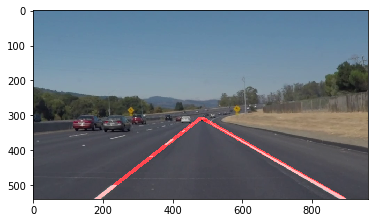

In [75]:
white_output = 'white8.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [76]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

x3 = 168.123006997
y3 =540
x4 =473.195603322
y4 =310
x1_list[165 423 277 347 253 444 105 224 320 407 351 416 195 283 450 469 125 227
 417 442 446 465 131 176 432 464 145 282]
y1_list[512 350 433 392 456 336 539 465 407 356 388 350 484 430 331 311 538 474
 348 333 330 310 522 494 343 312 525 439]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.69997317749
b_avg = 633.016492474
slope_left = [-0.62790698 -0.58571429 -0.62827225 -0.62184874 -0.5862069  -0.58461538
 -0.61363636 -1.05263158 -0.62745098 -0.6        -1.05263158 -0.62222222
 -0.96875    -0.62773723]
slope_right [ 0.72307692  0.72043011  0.67307692  0.66666667  0.72413793  0.70588235
  0.72727273  0.75        0.6728972 ]
[MoviePy] >>>> Building video yellow4.mp4
[MoviePy] Writing video yellow4.mp4


  0%|                                                                                                                                                                                                              | 0/682 [00:00<?, ?it/s]

x3 = 157.551843529
y3 =540
x4 =469.67786672
y4 =310
x1_list[165 423 277 347 253 444 105 224 320 407 351 416 195 283 450 469 125 227
 417 442 446 465 131 176 432 464 145 282]
y1_list[512 350 433 392 456 336 539 465 407 356 388 350 484 430 331 311 538 474
 348 333 330 310 522 494 343 312 525 439]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.69997317749
b_avg = 633.016492474
slope_left = [-0.62790698 -0.58571429 -0.62827225 -0.62184874 -0.5862069  -0.58461538
 -0.61363636 -1.05263158 -0.62745098 -0.6        -1.05263158 -0.62222222
 -0.96875    -0.62773723]
slope_right [ 0.72307692  0.72043011  0.67307692  0.66666667  0.72413793  0.70588235
  0.72727273  0.75        0.6728972 ]


  0%|▎                                                                                                                                                                                                     | 1/682 [00:00<01:56,  5.83it/s]

x3 = 146.457834948
y3 =540
x4 =471.374178216
y4 =310
x1_list[183 295 106 219 138 332 414 468 276 446 305 385 106 174 369 415 441 464
 125 164 266 373 126 214 381 406 411 444]
y1_list[492 423 539 469 530 408 352 313 442 335 417 370 538 496 378 351 338 318
 538 515 442 376 538 483 377 361 359 335]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.648324854736
b_avg = 618.169704396
slope_left = [-0.61607143 -0.61946903 -0.62886598 -0.72222222 -0.62941176 -0.5875
 -0.61764706 -0.58695652 -0.86956522 -0.58974359 -0.61682243 -0.625      -0.64
 -0.72727273]
slope_right [ 0.6744186   0.67619048  0.67032967  0.64285714  0.71052632  0.63333333
  0.65517241  0.66666667  0.67647059  0.7254902   0.70588235]


  0%|▌                                                                                                                                                                                                     | 2/682 [00:00<01:58,  5.72it/s]

x3 = 142.370571056
y3 =540
x4 =470.462277252
y4 =310
x1_list[205 285 106 158 270 341 288 461 127 248 116 201 362 406 349 437 271 360
 442 468 227 390 436 465 331 371 427 453 218 251 440 469 128 151 432 456]
y1_list[478 431 538 508 448 401 429 321 538 462 532 482 388 362 392 337 439 384
 338 313 474 372 342 310 408 383 348 329 480 460 334 310 538 524 344 326]
x2_list[]
y2_list[]
num_points_left18
num_points_right14
a_avg = -0.685542153094
b_avg = 631.063047212
slope_left = [-0.5875     -0.57692308 -0.66197183 -0.62427746 -0.62809917 -0.58823529
 -0.59090909 -0.625      -0.61797753 -0.96153846 -0.62576687 -1.10344828
 -0.625      -0.73076923 -0.60606061 -0.82758621 -0.60869565 -0.75      ]
slope_right [ 0.71428571  0.63157895  0.71153846  0.71428571  0.71428571  0.63636364
  0.725       0.62        0.65217391  0.72727273  0.65        0.72093023
  0.64705882  0.72131148]


  0%|▊                                                                                                                                                                                                     | 3/682 [00:00<01:52,  6.06it/s]

x3 = 144.11195445
y3 =540
x4 =467.32211242
y4 =310
x1_list[227 442 137 259 111 233 379 449 213 316 336 386 333 418 131 195 233 267
 451 469 286 392 440 465 201 238 444 464 424 456]
y1_list[468 334 534 457 539 463 380 333 485 420 407 374 403 350 538 498 464 442
 331 310 438 371 340 310 484 460 336 318 346 321]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.737605315301
b_avg = 649.294802112
slope_left = [-0.62325581 -0.63114754 -0.62295082 -0.67142857 -0.63106796 -0.66
 -0.62352941 -0.625      -0.64705882 -1.16666667 -0.63207547 -1.2
 -0.64864865 -0.9        -0.78125   ]
slope_right [ 0.71186441  0.66153846  0.66037736  0.71153846  0.72727273  0.65
  0.61904762  0.66666667  0.72340426  0.65        0.66666667]


  1%|█▏                                                                                                                                                                                                    | 4/682 [00:00<01:50,  6.16it/s]

x3 = 143.52073365
y3 =540
x4 =466.738698423
y4 =310
x1_list[174 435 114 196 358 450 155 253 264 354 134 191 330 386 447 465 115 329
 388 447 451 469 226 284 385 443 135 162 181 231 386 409]
y1_list[502 339 538 487 394 332 524 462 455 395 538 502 412 375 330 310 538 405
 375 335 331 310 478 441 372 333 538 521 508 475 371 355]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.711554008404
b_avg = 641.141153747
slope_left = [-0.62452107 -0.62195122 -0.67391304 -0.63265306 -0.66666667 -0.63157895
 -0.66071429 -1.11111111 -0.62149533 -0.6779661  -1.16666667 -0.63793103
 -0.67241379 -0.62962963 -0.66       -0.69565217]
slope_right [ 0.68181818  0.6         0.65217391  0.65789474  0.62857143  0.71428571
  0.68181818  0.68181818  0.68        0.61904762  0.67567568]


  1%|█▍                                                                                                                                                                                                    | 5/682 [00:00<01:47,  6.32it/s]

x3 = 147.398795156
y3 =540
x4 =464.691561522
y4 =310
x1_list[117 439 118 415 229 287 301 366 136 205 363 446 451 469 206 234 441 465
 276 358 180 203 444 470 437 461 210 257]
y1_list[538 337 539 353 478 441 432 389 538 495 392 336 332 312 493 476 339 310
 447 395 510 496 337 310 338 316 491 461]
x2_list[]
y2_list[]
num_points_left14
num_points_right3
a_avg = -0.757907021317
b_avg = 658.572738554
slope_left = [-0.6242236  -0.62626263 -0.63793103 -0.66153846 -0.62318841 -0.6746988
 -1.11111111 -0.60714286 -1.20833333 -0.63414634 -0.60869565 -1.03846154
 -0.91666667 -0.63829787]
slope_right [ 0.70833333  0.72727273  0.66666667]


  1%|█▋                                                                                                                                                                                                    | 6/682 [00:00<01:46,  6.37it/s]

x3 = 144.953005619
y3 =540
x4 =468.511502624
y4 =310
x1_list[120 403 119 429 295 448 138 208 183 241 234 308 445 465 375 399 431 459
 416 439 224 247 359 445 268 320 331 384 236 256]
y1_list[538 361 538 344 437 334 538 494 509 472 475 428 332 310 385 369 347 324
 351 337 482 468 395 337 454 419 407 374 474 462]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.680114129327
b_avg = 634.703283159
slope_left = [-0.6254417  -0.62580645 -0.67320261 -0.62857143 -0.63793103 -0.63513514
 -1.1        -0.66666667 -0.82142857 -0.60869565 -0.60869565 -0.6744186
 -0.67307692 -0.62264151 -0.6       ]
slope_right [ 0.66666667  0.66666667  0.70833333  0.66666667  0.7037037 ]


  1%|██                                                                                                                                                                                                    | 7/682 [00:01<01:54,  5.89it/s]

x3 = 147.034740576
y3 =540
x4 =466.861532221
y4 =310
x1_list[120 399 140 283 299 446 403 437 444 468 356 379 430 459 438 465 367 442
 223 315 307 357 121 144 141 164]
y1_list[538 363 539 443 434 335 359 337 336 312 391 375 347 317 336 310 384 333
 484 422 428 396 538 524 538 522]
x2_list[]
y2_list[]
num_points_left13
num_points_right4
a_avg = -0.73926583008
b_avg = 652.288655758
slope_left = [-0.62724014 -0.67132867 -0.67346939 -0.64705882 -1.         -0.69565217
 -1.03448276 -0.96296296 -0.68       -0.67391304 -0.64       -0.60869565
 -0.69565217]
slope_right [ 0.67647059  0.70967742  0.71428571  0.67567568]


  1%|██▎                                                                                                                                                                                                   | 8/682 [00:01<02:06,  5.34it/s]

x3 = 150.065702154
y3 =540
x4 =465.597639144
y4 =310
x1_list[120 384 278 443 222 358 121 403 141 249 443 464 388 427 413 439 451 468
 431 464 324 428 178 309]
y1_list[538 373 448 337 485 394 537 360 538 466 332 310 369 344 352 335 330 310
 341 311 418 348 514 426]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.752838012417
b_avg = 658.299418818
slope_left = [-0.625      -0.67272727 -0.66911765 -0.62765957 -0.66666667 -1.04761905
 -0.64102564 -0.65384615 -1.17647059 -0.90909091 -0.67307692 -0.67175573]
slope_right [ 0.675       0.675       0.59375     0.6         0.66666667  0.62962963
  0.675     ]


  1%|██▌                                                                                                                                                                                                   | 9/682 [00:01<02:21,  4.77it/s]

x3 = 150.082093969
y3 =540
x4 =465.169308703
y4 =310
x1_list[220 445 339 440 182 308 306 432 120 384 142 257 121 334 446 468 441 463
 385 434 273 362]
y1_list[487 335 402 334 512 427 430 345 538 373 538 461 538 405 334 310 333 310
 372 339 442 386]
x2_list[]
y2_list[]
num_points_left11
num_points_right5
a_avg = -0.732368554699
b_avg = 649.943417564
slope_left = [-0.67555556 -0.67326733 -0.67460317 -0.67460317 -0.625      -0.66956522
 -0.62441315 -1.09090909 -1.04545455 -0.67346939 -0.62921348]
slope_right [ 0.67346939  0.61818182  0.62264151  0.63333333  0.68421053]


  1%|██▉                                                                                                                                                                                                  | 10/682 [00:01<02:19,  4.80it/s]

x3 = 147.026900241
y3 =540
x4 =466.186057179
y4 =310
x1_list[158 440 217 381 127 366 143 261 399 435 441 468 356 398 124 166 436 463
 284 391 123 240 401 425]
y1_list[529 339 478 375 535 385 538 459 361 338 338 310 390 363 537 512 337 311
 445 373 538 465 360 345]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.699810598425
b_avg = 637.90218349
slope_left = [-0.67375887 -0.62804878 -0.62761506 -0.66949153 -0.63888889 -1.03703704
 -0.64285714 -0.5952381  -0.96296296 -0.6728972  -0.62393162 -0.625     ]
slope_right [ 0.63076923  0.66666667  0.63043478  0.66101695  0.625     ]


  2%|███▏                                                                                                                                                                                                 | 11/682 [00:02<02:21,  4.74it/s]

x3 = 144.868098592
y3 =540
x4 =466.654025709
y4 =310
x1_list[124 231 144 278 415 438 291 332 321 437 253 312 305 459 353 406 216 248
 144 430 358 382 443 467 178 218 434 454 309 330 232 257 125 145 138 164]
y1_list[538 471 538 448 355 340 441 412 414 336 457 418 424 320 399 361 479 460
 539 346 390 374 336 311 503 479 342 319 427 415 469 453 537 524 529 512]
x2_list[]
y2_list[]
num_points_left18
num_points_right5
a_avg = -0.701401154703
b_avg = 638.077551036
slope_left = [-0.62616822 -0.67164179 -0.65217391 -0.70731707 -0.67241379 -0.66101695
 -0.67532468 -0.71698113 -0.59375    -0.67482517 -0.66666667 -1.04166667
 -0.6        -1.15       -0.57142857 -0.64       -0.65       -0.65384615]
slope_right [ 0.66666667  0.62790698  0.62025316  0.68055556  0.62820513]


  2%|███▍                                                                                                                                                                                                 | 12/682 [00:02<02:16,  4.89it/s]

x3 = 147.28198496
y3 =540
x4 =466.642972447
y4 =310
x1_list[146 398 126 328 227 348 299 373 362 398 384 423 126 201 439 463 370 435
 195 367 447 467 429 462 332 353 418 455 356 431 405 428]
y1_list[538 368 537 410 473 397 427 380 386 363 371 346 538 491 334 310 386 342
 506 390 332 310 342 310 412 398 355 324 396 345 357 342]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.733178038749
b_avg = 652.113469981
slope_left = [-0.67460317 -0.62871287 -0.62809917 -0.63513514 -0.63888889 -0.64102564
 -0.62666667 -1.         -0.67692308 -0.6744186  -1.1        -0.96969697
 -0.66666667 -0.83783784 -0.68       -0.65217391]
slope_right [ 0.67307692  0.62376238  0.625       0.70967742  0.7173913   0.6
  0.63013699  0.71428571  0.625       0.67647059]


  2%|███▊                                                                                                                                                                                                 | 13/682 [00:02<02:07,  5.24it/s]

x3 = 146.673199798
y3 =540
x4 =467.590436164
y4 =310
x1_list[148 363 287 434 314 335 203 274 147 204 243 299 128 158 184 241 154 204
 414 447 396 420 314 418 206 274 370 391 386 407 438 467 344 367 217 372
 128 154]
y1_list[538 393 437 338 425 411 491 444 538 500 465 428 538 518 503 465 522 489
 358 332 370 352 420 350 500 454 388 372 377 361 340 310 405 390 491 386
 539 521]
x2_list[]
y2_list[]
num_points_left19
num_points_right7
a_avg = -0.70867685882
b_avg = 642.93722794
slope_left = [-0.6744186  -0.67346939 -0.66666667 -0.66197183 -0.66666667 -0.66071429
 -0.66666667 -0.66666667 -0.66       -0.78787879 -0.75       -0.67307692
 -0.67647059 -0.76190476 -0.76190476 -1.03448276 -0.65217391 -0.67741935
 -0.69230769]
slope_right [ 0.62121212  0.67479675  0.62626263  0.65217391  0.65        0.69565217
  0.6875    ]


  2%|████                                                                                                                                                                                                 | 14/682 [00:02<01:59,  5.59it/s]

x3 = 146.282189051
y3 =540
x4 =468.917581611
y4 =310
x1_list[276 430 149 356 443 463 182 280 129 229 343 422 372 435 440 467 150 173
 262 327 266 308]
y1_list[445 341 538 398 329 315 504 442 538 475 406 352 385 342 338 310 538 523
 453 410 460 430]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.704129577382
b_avg = 642.359197413
slope_left = [-0.67532468 -0.6763285  -0.7        -0.63265306 -0.63       -0.6835443
 -0.68253968 -1.03703704 -0.65217391 -0.66153846 -0.71428571]
slope_right [ 0.62666667  0.625       0.66666667  0.63157895  0.62068966  0.59090909
  0.57142857  0.73913043  0.62711864  0.625     ]


  2%|████▎                                                                                                                                                                                                | 15/682 [00:02<02:03,  5.38it/s]

x3 = 149.637343586
y3 =540
x4 =467.240781211
y4 =310
x1_list[155 345 145 251 152 285 254 429 369 442 343 363 446 466 440 462 398 435
 131 195 182 261 335 377 434 461 375 410 256 316]
y1_list[535 406 529 462 538 448 460 342 389 336 406 393 332 310 333 310 369 342
 538 498 505 455 412 383 338 310 384 359 458 418]
x2_list[]
y2_list[]
num_points_left15
num_points_right13
a_avg = -0.751972597136
b_avg = 658.41014518
slope_left = [-0.67894737 -0.63207547 -0.67669173 -0.67428571 -0.7260274  -0.65       -1.1
 -1.04545455 -0.72972973 -0.625      -0.63291139 -0.69047619 -1.03703704
 -0.71428571 -0.66666667]
slope_right [ 0.6         0.67058824  0.67346939  0.59183673  0.59322034  0.66666667
  0.58333333  0.57777778  0.69565217  0.66666667  0.59090909  0.57142857
  0.72727273]


  2%|████▌                                                                                                                                                                                                | 16/682 [00:03<02:15,  4.92it/s]

x3 = 152.75665665
y3 =540
x4 =465.357655805
y4 =310
x1_list[233 426 152 278 135 230 338 444 151 321 132 201 445 466 441 460 315 335
 443 462 323 368 402 441 228 258 336 364 243 415]
y1_list[474 344 538 453 536 476 411 334 538 423 538 495 333 310 331 311 426 413
 330 310 420 389 367 336 477 456 412 391 467 351]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.764300792095
b_avg = 662.314918381
slope_left = [-0.67357513 -0.67460317 -0.63157895 -0.72641509 -0.67647059 -0.62318841
 -1.0952381  -1.05263158 -0.65       -1.05263158 -0.68888889 -0.79487179
 -0.7        -0.75       -0.6744186 ]
slope_right [ 0.6875      0.60714286  0.61764706  0.6         0.66666667  0.66666667
  0.66666667  0.625       0.625       0.69565217]


  2%|████▉                                                                                                                                                                                                | 17/682 [00:03<02:11,  5.06it/s]

x3 = 154.663198981
y3 =540
x4 =464.945810947
y4 =310
x1_list[136 431 201 425 271 403 430 465 258 363 436 461 368 437 136 214 155 249
 443 462 262 410 227 253 202 228 247 267]
y1_list[539 340 496 345 459 364 346 312 468 392 336 310 390 340 538 486 538 474
 330 310 456 356 488 471 505 488 474 461]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.754412389496
b_avg = 660.035911541
slope_left = [-0.67457627 -0.67410714 -0.71969697 -0.97142857 -0.72380952 -1.04
 -0.72463768 -0.66666667 -0.68085106 -1.05263158 -0.67567568 -0.65384615
 -0.65384615 -0.65      ]
slope_right [ 0.5862069   0.59259259  0.59259259  0.68        0.61538462]


  3%|█████▏                                                                                                                                                                                               | 18/682 [00:03<02:20,  4.74it/s]

x3 = 158.0857242
y3 =540
x4 =463.243779806
y4 =310
x1_list[154 424 339 437 256 381 155 213 136 259 208 264 435 458 429 461 443 465
 413 453 182 264 282 308]
y1_list[527 345 410 339 469 379 538 499 538 456 502 462 336 314 341 310 334 310
 358 324 519 463 449 431]
x2_list[]
y2_list[]
num_points_left12
num_points_right4
a_avg = -0.784445449639
b_avg = 670.27412378
slope_left = [-0.67407407 -0.7244898  -0.72       -0.67241379 -0.66666667 -0.71428571
 -0.95652174 -0.96875    -1.09090909 -0.85       -0.68292683 -0.69230769]
slope_right [ 0.66666667  0.60606061  0.65625     0.6       ]


  3%|█████▍                                                                                                                                                                                               | 19/682 [00:03<02:26,  4.52it/s]

x3 = 158.946766063
y3 =540
x4 =462.607335632
y4 =310
x1_list[193 319 152 419 265 387 383 448 135 194 354 378 423 444 204 241 404 453
 154 187 428 452 306 410 441 465 170 247 367 435 138 343 439 459]
y1_list[513 422 528 348 462 374 379 328 538 499 399 381 345 327 494 469 359 318
 538 517 346 323 425 355 335 310 527 475 390 340 537 399 331 312]
x2_list[]
y2_list[]
num_points_left17
num_points_right4
a_avg = -0.766241567387
b_avg = 663.331073316
slope_left = [-0.72222222 -0.6741573  -0.72131148 -0.78461538 -0.66101695 -0.75
 -0.85714286 -0.67567568 -0.83673469 -0.63636364 -0.95833333 -0.67307692
 -1.04166667 -0.67532468 -0.73529412 -0.67317073 -0.95      ]
slope_right [ 0.61111111  0.68571429  0.6875      0.63157895]


  3%|█████▊                                                                                                                                                                                               | 20/682 [00:03<02:04,  5.33it/s]

x3 = 163.644849456
y3 =540
x4 =460.515350583
y4 =310
x1_list[135 425 200 332 170 288 344 435 262 359 206 411 436 455 438 461 434 459
 377 421 155 181 432 464 352 381]
y1_list[538 342 507 412 528 443 405 339 463 393 491 353 338 314 336 314 335 311
 382 350 539 519 341 310 399 377]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.818426675635
b_avg = 682.903062596
slope_left = [-0.67586207 -0.71969697 -0.72033898 -0.72527473 -0.72164948 -0.67317073
 -1.26315789 -0.95652174 -0.96       -0.72727273 -0.76923077 -0.96875
 -0.75862069]
slope_right [ 0.62790698  0.67647059  0.66666667  0.62222222  0.68292683]


  3%|██████                                                                                                                                                                                               | 21/682 [00:03<01:50,  5.96it/s]

x3 = 161.306414032
y3 =540
x4 =461.303469871
y4 =310
x1_list[384 428 349 372 153 198 180 294 289 314 134 345 360 413 134 406 429 463
 374 436 299 327 443 463 316 337 266 286 133 179]
y1_list[371 339 400 385 538 506 520 438 443 424 538 396 392 356 539 356 343 310
 382 337 436 415 331 311 424 408 459 444 538 507]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.748472911466
b_avg = 656.649551686
slope_left = [-0.72727273 -0.65217391 -0.71111111 -0.71929825 -0.76       -0.67298578
 -0.67924528 -0.67279412 -0.97058824 -0.72580645 -0.75       -1.
 -0.76190476 -0.75       -0.67391304]
slope_right [ 0.62        0.67857143  0.63636364  0.65      ]


  3%|██████▎                                                                                                                                                                                              | 22/682 [00:04<02:05,  5.24it/s]

x3 = 159.656787147
y3 =540
x4 =461.74407665
y4 =310
x1_list[133 423 301 383 341 429 133 285 170 277 255 333 430 463 432 456 153 220
 257 410 378 418 328 402]
y1_list[539 343 435 376 407 343 538 436 527 450 467 411 342 310 336 312 538 490
 456 353 381 352 409 359]
x2_list[]
y2_list[]
num_points_left12
num_points_right4
a_avg = -0.749272306609
b_avg = 656.742363109
slope_left = [-0.67586207 -0.7195122  -0.72727273 -0.67105263 -0.71962617 -0.71794872
 -0.96969697 -1.         -0.71641791 -0.67320261 -0.725      -0.67567568]
slope_right [ 0.63157895  0.63636364  0.61904762  0.62962963]


  3%|██████▋                                                                                                                                                                                              | 23/682 [00:04<02:20,  4.70it/s]

x3 = 156.607179991
y3 =540
x4 =462.908999364
y4 =310
x1_list[225 418 421 442 203 291 157 212 244 354 293 394 354 414 152 198 423 457
 195 218 428 463 132 225 416 459 132 302 280 406 398 420 176 199]
y1_list[477 347 348 332 502 442 521 486 473 399 439 370 396 355 538 507 343 312
 508 493 344 310 538 476 348 310 539 425 441 356 367 349 521 506]
x2_list[]
y2_list[]
num_points_left17
num_points_right4
a_avg = -0.727535623786
b_avg = 648.760340746
slope_left = [-0.67357513 -0.76190476 -0.68181818 -0.63636364 -0.67272727 -0.68316832
 -0.68333333 -0.67391304 -0.91176471 -0.65217391 -0.97142857 -0.66666667
 -0.88372093 -0.67058824 -0.67460317 -0.81818182 -0.65217391]
slope_right [ 0.61538462  0.625       0.61643836  0.61643836]


  4%|██████▉                                                                                                                                                                                              | 24/682 [00:04<02:06,  5.18it/s]

x3 = 155.705922384
y3 =540
x4 =463.319424152
y4 =310
x1_list[168 272 134 310 228 406 296 431 134 174 419 459 254 279 154 216 437 464
 424 455 281 333 273 293 332 360 415 445 391 413 135 224]
y1_list[528 457 539 421 477 357 440 342 538 511 347 311 468 452 538 496 337 310
 343 315 449 413 455 442 406 389 355 328 373 356 538 478]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.74032564808
b_avg = 653.716231614
slope_left = [-0.68269231 -0.67045455 -0.6741573  -0.72592593 -0.675      -0.9        -0.64
 -0.67741935 -1.         -0.90322581 -0.69230769 -0.65       -0.60714286
 -0.9        -0.77272727 -0.6741573 ]
slope_right [ 0.61702128  0.61702128  0.6744186   0.67307692  0.61842105  0.64
  0.66666667]


  4%|███████▏                                                                                                                                                                                             | 25/682 [00:04<01:48,  6.03it/s]

x3 = 157.310349658
y3 =540
x4 =462.822136107
y4 =310
x1_list[137 410 293 424 157 224 229 394 193 285 263 381 414 459 138 255 442 465
 430 460 405 441 137 171 362 402 215 315]
y1_list[539 355 444 349 539 491 478 367 514 448 465 380 352 312 538 459 333 310
 339 310 364 334 538 515 395 366 499 427]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.765116581186
b_avg = 663.22509604
slope_left = [-0.67399267 -0.72519084 -0.71641791 -0.67272727 -0.7173913  -0.72033898
 -0.88888889 -0.67521368 -1.         -0.96666667 -0.83333333 -0.67647059
 -0.725      -0.72      ]
slope_right [ 0.62637363  0.62184874  0.62244898  0.61666667  0.83783784  0.65        0.625
  0.64516129]


  4%|███████▌                                                                                                                                                                                             | 26/682 [00:04<01:36,  6.77it/s]

x3 = 160.139706065
y3 =540
x4 =462.019900483
y4 =310
x1_list[138 402 159 270 235 428 275 410 156 389 437 464 436 459 399 419 159 226
 422 463]
y1_list[538 360 539 459 485 345 457 359 527 370 337 310 333 310 361 347 538 490
 349 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.783895434925
b_avg = 670.7079302
slope_left = [-0.67424242 -0.72072072 -0.7253886  -0.72592593 -0.67381974 -1.         -1.
 -0.7        -0.71641791 -0.90243902]
slope_right [ 0.62601626  0.57303371  0.58208955  0.58208955  0.59090909  0.63235294
  0.65        0.62765957  0.6         0.57777778  0.59090909]
x3 = 159.112649769
y3 =540
x4 =463.47149892
y4 =310
x1_list[139 391 209 421 274 402 165 319 294 400 166 329 159 211 389 412 426 463
 407 431]
y1_list[538 368 504 350 458 365 535 424 433 361 521 411 538 501 368 352 346 310
 355 335]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.741594884027
b_avg = 656.219921098
slope_left = [-0.67460317 -0.72641509 -0.7265625  -0.720

  4%|████████                                                                                                                                                                                             | 28/682 [00:04<01:26,  7.54it/s]

x3 = 161.350094569
y3 =540
x4 =463.085648927
y4 =310
x1_list[139 385 161 319 141 351 410 458 353 440 317 351 310 337 380 407 419 459
 263 390 441 462 176 326 371 426 331 369]
y1_list[538 372 538 424 538 396 353 310 401 333 427 401 432 411 374 355 346 310
 454 368 332 310 528 419 388 345 417 388]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.778040232089
b_avg = 669.598783193
slope_left = [-0.67479675 -0.72151899 -0.67619048 -0.89583333 -0.7816092  -0.76470588
 -0.77777778 -0.7037037  -0.9        -0.67716535 -1.04761905 -0.72666667
 -0.78181818 -0.76315789]
slope_right [ 0.62921348  0.5875      0.58181818  0.66666667  0.6         0.625
  0.59090909  0.63636364  0.6         0.6       ]


  4%|████████▍                                                                                                                                                                                            | 29/682 [00:05<01:32,  7.06it/s]

x3 = 161.121511798
y3 =540
x4 =462.272470506
y4 =310
x1_list[184 383 162 414 141 351 161 301 209 388 427 459 427 457 411 463 370 395
 141 182]
y1_list[508 373 539 355 538 396 538 437 505 375 344 315 339 310 357 310 381 364
 539 511]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.76721163706
b_avg = 663.205098987
slope_left = [-0.67839196 -0.73015873 -0.67619048 -0.72142857 -0.72625698 -0.90625
 -0.96666667 -0.90384615 -0.68       -0.68292683]
slope_right [ 0.62068966  0.5625      0.6097561   0.58536585  0.68        0.66666667
  0.58333333  0.625       0.60869565]


  4%|████████▋                                                                                                                                                                                            | 30/682 [00:05<01:50,  5.89it/s]

x3 = 159.894159879
y3 =540
x4 =461.333865026
y4 =310
x1_list[162 394 306 423 397 417 272 320 219 267 153 205 434 463 185 227 427 457
 141 183 162 274 344 399 237 379 253 298 432 452 216 236]
y1_list[539 370 427 342 366 352 450 416 486 452 531 494 338 310 509 479 339 310
 539 509 538 457 401 361 485 382 463 431 338 320 488 473]
x2_list[]
y2_list[]
num_points_left16
num_points_right4
a_avg = -0.761303418997
b_avg = 659.547733766
slope_left = [-0.72844828 -0.72649573 -0.7        -0.70833333 -0.70833333 -0.71153846
 -0.96551724 -0.71428571 -0.96666667 -0.71428571 -0.72321429 -0.72727273
 -0.72535211 -0.71111111 -0.9        -0.75      ]
slope_right [ 0.57575758  0.65384615  0.5625      0.62068966]


  5%|████████▉                                                                                                                                                                                            | 31/682 [00:05<02:04,  5.22it/s]

x3 = 161.491503603
y3 =540
x4 =461.741773288
y4 =310
x1_list[173 374 142 353 356 407 296 368 144 316 416 461 395 453 378 412 163 228
 387 409 402 452 163 388 436 463]
y1_list[532 386 538 395 398 360 433 384 537 421 353 312 364 316 381 356 538 491
 370 352 359 317 539 375 336 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right3
a_avg = -0.773174423529
b_avg = 667.742825932
slope_left = [-0.72636816 -0.67772512 -0.74509804 -0.68055556 -0.6744186  -0.91111111
 -0.82758621 -0.73529412 -0.72307692 -0.81818182 -0.84       -0.72888889
 -0.96296296]
slope_right [ 0.57142857  0.65625     0.61111111]


  5%|█████████▏                                                                                                                                                                                           | 32/682 [00:05<02:20,  4.62it/s]

x3 = 162.279833748
y3 =540
x4 =461.460710456
y4 =310
x1_list[164 373 372 426 205 351 143 247 409 462 432 457 176 351 301 414 420 462
 362 382 385 405 438 458 143 298]
y1_list[538 386 379 339 495 396 539 468 358 310 334 310 530 403 431 349 349 311
 393 379 375 361 329 310 538 433]
x2_list[]
y2_list[]
num_points_left13
num_points_right4
a_avg = -0.775231354383
b_avg = 667.230404546
slope_left = [-0.72727273 -0.74074074 -0.67808219 -0.68269231 -0.90566038 -0.96
 -0.72571429 -0.72566372 -0.9047619  -0.7        -0.7        -0.95
 -0.67741935]
slope_right [ 0.65714286  0.55813953  0.66666667  0.57142857]


  5%|█████████▌                                                                                                                                                                                           | 33/682 [00:06<02:03,  5.26it/s]

x3 = 163.456359159
y3 =540
x4 =460.54101082
y4 =310
x1_list[323 433 425 452 359 442 165 328 145 313 145 232 164 352 282 348 434 462
 350 389 365 401 441 457 318 357]
y1_list[424 338 338 316 390 325 539 420 537 423 538 479 538 401 443 398 337 310
 395 368 384 359 331 310 418 391]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.787149719537
b_avg = 670.825531113
slope_left = [-0.78181818 -0.81481481 -0.78313253 -0.73006135 -0.67857143 -0.67816092
 -0.7287234  -0.68181818 -0.96428571 -0.69230769 -0.69444444 -1.3125
 -0.69230769]
slope_right [ 0.60869565  0.57142857  0.62222222  0.58064516  0.58064516]


  5%|█████████▊                                                                                                                                                                                           | 34/682 [00:06<01:46,  6.07it/s]

x3 = 161.4788479
y3 =540
x4 =461.349789973
y4 =310
x1_list[266 408 166 320 215 278 378 460 418 457 165 345 186 249 166 203 342 392
 160 216 334 357 145 175 257 281 397 454 146 171 270 408]
y1_list[456 353 538 426 491 446 382 313 345 310 538 407 511 466 539 512 408 371
 529 489 414 398 538 517 462 444 367 319 539 520 453 352]
x2_list[]
y2_list[]
num_points_left16
num_points_right4
a_avg = -0.750720643589
b_avg = 657.76153473
slope_left = [-0.72535211 -0.72727273 -0.71428571 -0.84146341 -0.8974359  -0.72777778
 -0.71428571 -0.72972973 -0.74       -0.71428571 -0.69565217 -0.7        -0.75
 -0.84210526 -0.76       -0.73188406]
slope_right [ 0.59090909  0.57894737  0.57627119  0.65384615]


  5%|██████████                                                                                                                                                                                           | 35/682 [00:06<01:36,  6.68it/s]

x3 = 160.665492713
y3 =540
x4 =462.696385556
y4 =310
x1_list[166 312 145 256 263 406 415 456 313 427 412 433 229 299 249 332 187 233
 178 241 319 346]
y1_list[538 432 538 463 458 354 347 310 431 342 353 337 481 431 477 416 524 489
 517 472 425 405]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.74901298495
b_avg = 658.919041883
slope_left = [-0.7260274  -0.67567568 -0.72727273 -0.90243902 -0.78070175 -0.76190476
 -0.71428571 -0.73493976 -0.76086957 -0.71428571 -0.74074074]
slope_right [ 0.65909091  0.56944444  0.67647059  0.57894737  0.66666667  0.57894737]


  5%|██████████▍                                                                                                                                                                                          | 36/682 [00:06<01:28,  7.28it/s]

x3 = 159.135809148
y3 =540
x4 =464.105761964
y4 =310
x1_list[243 407 166 294 220 417 147 212 298 435 298 397 335 417 178 238 276 338
 146 176 167 268]
y1_list[472 353 538 445 488 345 539 492 442 335 433 361 414 350 517 474 458 410
 538 517 539 465]
x2_list[]
y2_list[]
num_points_left11
num_points_right5
a_avg = -0.737586674217
b_avg = 654.743812387
slope_left = [-0.72560976 -0.7265625  -0.72588832 -0.72307692 -0.7810219  -0.72727273
 -0.7804878  -0.71666667 -0.77419355 -0.7        -0.73267327]
slope_right [ 0.57303371  0.61728395  0.62195122  0.58        0.575     ]


  5%|██████████▋                                                                                                                                                                                          | 37/682 [00:06<01:29,  7.22it/s]

x3 = 159.67174404
y3 =540
x4 =462.872883225
y4 =310
x1_list[206 415 402 451 147 195 150 229 287 438 167 246 167 274 419 456 264 395
 425 455 348 404 236 301 203 232]
y1_list[498 346 360 321 538 504 537 480 450 332 539 481 538 460 343 310 457 362
 338 311 404 360 487 439 500 478]
x2_list[]
y2_list[]
num_points_left13
num_points_right4
a_avg = -0.76904067632
b_avg = 663.755762732
slope_left = [-0.72727273 -0.79591837 -0.70833333 -0.72151899 -0.78145695 -0.73417722
 -0.72897196 -0.89189189 -0.72519084 -0.9        -0.78571429 -0.73846154
 -0.75862069]
slope_right [ 0.57142857  0.62135922  0.59090909  0.57575758]


  6%|██████████▉                                                                                                                                                                                          | 38/682 [00:06<01:48,  5.93it/s]

x3 = 160.386101709
y3 =540
x4 =462.470881499
y4 =310
x1_list[182 332 344 449 416 452 187 282 275 376 314 339 335 418 147 228 167 233
 399 424 336 363 225 354 425 461 410 436 280 312 389 453]
y1_list[514 406 399 317 348 319 523 453 458 380 420 401 413 348 539 480 538 490
 362 343 404 384 484 391 342 310 353 333 453 429 366 312]
x2_list[]
y2_list[]
num_points_left16
num_points_right6
a_avg = -0.767998013752
b_avg = 664.456333179
slope_left = [-0.72       -0.78095238 -0.80555556 -0.73684211 -0.77227723 -0.76
 -0.78313253 -0.72839506 -0.72727273 -0.76       -0.74074074 -0.72093023
 -0.88888889 -0.76923077 -0.75       -0.84375   ]
slope_right [ 0.62222222  0.57638889  0.57731959  0.57894737  0.6         0.65      ]


  6%|███████████▎                                                                                                                                                                                         | 39/682 [00:06<01:36,  6.70it/s]

x3 = 159.099738579
y3 =540
x4 =462.294351435
y4 =310
x1_list[172 315 362 441 314 429 214 302 202 223 145 253 341 402 306 339 165 194
 144 178 274 448 178 205 241 317 330 360 437 460 223 289]
y1_list[520 417 385 323 428 338 503 435 512 495 539 461 400 353 425 400 538 518
 538 514 458 322 530 508 483 424 408 385 325 310 484 436]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.752164377492
b_avg = 657.411523939
slope_left = [-0.72027972 -0.78481013 -0.7826087  -0.77272727 -0.80952381 -0.72222222
 -0.7704918  -0.75757576 -0.68965517 -0.70588235 -0.7816092  -0.81481481
 -0.77631579 -0.76666667 -0.65217391 -0.72727273]
slope_right [ 0.57931034  0.62162162  0.61956522  0.57142857  0.58490566  0.57798165
  0.61764706  0.6       ]


  6%|███████████▌                                                                                                                                                                                         | 40/682 [00:06<01:27,  7.33it/s]

x3 = 157.9733573
y3 =540
x4 =461.298502067
y4 =310
x1_list[145 230 284 449 351 447 306 434 165 248 263 289 323 357 166 219 224 254
 286 311 263 287 206 285 256 277 341 393 215 240 144 171 286 317 191 211]
y1_list[538 477 450 321 393 318 434 334 538 477 466 445 413 387 538 499 483 460
 439 420 455 437 507 449 460 444 400 360 489 470 538 519 448 424 506 491]
x2_list[]
y2_list[]
num_points_left18
num_points_right6
a_avg = -0.757501606189
b_avg = 657.674188757
slope_left = [-0.71764706 -0.78181818 -0.78125    -0.78125    -0.73493976 -0.80769231
 -0.76470588 -0.73584906 -0.76666667 -0.76       -0.75       -0.73417722
 -0.76190476 -0.76923077 -0.76       -0.7037037  -0.77419355 -0.75      ]
slope_right [ 0.62608696  0.576       0.61702128  0.57943925  0.65        0.56      ]


  6%|███████████▊                                                                                                                                                                                         | 41/682 [00:07<01:25,  7.47it/s]

x3 = 156.300145117
y3 =540
x4 =462.395088591
y4 =310
x1_list[278 395 286 446 410 438 165 236 267 333 235 418 145 217 229 280 191 220
 436 459 222 250 322 418 430 455 206 226]
y1_list[445 360 449 324 347 326 538 486 463 412 475 342 538 486 491 452 506 484
 326 310 484 463 422 347 331 315 507 493]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.735863877846
b_avg = 652.142699282
slope_left = [-0.72649573 -0.78125    -0.75       -0.73239437 -0.77272727 -0.72677596
 -0.72222222 -0.76470588 -0.75862069 -0.69565217 -0.75       -0.78125    -0.64
 -0.7       ]
slope_right [ 0.61971831  0.57692308  0.57142857  0.61971831  0.65217391  0.52        0.625
  0.68        0.57142857]


  6%|████████████▏                                                                                                                                                                                        | 42/682 [00:07<01:26,  7.38it/s]

x3 = 156.802531133
y3 =540
x4 =459.748540703
y4 =310
x1_list[176 232 390 430 292 448 239 414 249 318 143 211 174 234 328 424 286 403
 227 287 143 182 216 240 435 454 247 268]
y1_list[530 487 362 332 444 322 472 345 476 423 539 490 517 474 417 342 439 354
 492 446 538 510 488 470 332 310 466 450]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.778082440319
b_avg = 662.917390792
slope_left = [-0.76785714 -0.75       -0.78205128 -0.72571429 -0.76811594 -0.72058824
 -0.71666667 -0.78125    -0.72649573 -0.76666667 -0.71794872 -0.75
 -1.15789474 -0.76190476]
slope_right [ 0.60714286  0.58064516  0.58064516  0.62068966  0.52380952]


  6%|████████████▍                                                                                                                                                                                        | 43/682 [00:07<01:22,  7.71it/s]

x3 = 156.264726357
y3 =540
x4 =460.437768537
y4 =310
x1_list[167 214 255 412 299 445 255 329 178 263 212 277 143 199 295 394 194 229
 143 167 207 314 335 368]
y1_list[537 501 461 347 439 325 472 415 515 454 504 454 539 499 433 361 517 490
 538 521 495 418 412 385]
x2_list[]
y2_list[]
num_points_left12
num_points_right4
a_avg = -0.749097537112
b_avg = 656.117495774
slope_left = [-0.76595745 -0.72611465 -0.78082192 -0.77027027 -0.71764706 -0.76923077
 -0.71428571 -0.72727273 -0.77142857 -0.70833333 -0.71962617 -0.81818182]
slope_right [ 0.61764706  0.58333333  0.61290323  0.58823529]


  6%|████████████▋                                                                                                                                                                                        | 44/682 [00:07<01:20,  7.96it/s]

x3 = 156.399760505
y3 =540
x4 =459.908596237
y4 =310
x1_list[244 408 287 452 362 426 145 199 406 442 166 263 257 317 181 209 331 427
 201 229 291 390 224 250 441 461 187 258 245 273 145 166]
y1_list[470 351 449 320 384 337 539 500 351 324 538 467 471 425 514 493 416 341
 500 479 437 365 484 464 330 310 522 470 469 448 538 523]
x2_list[]
y2_list[]
num_points_left16
num_points_right5
a_avg = -0.761692760417
b_avg = 659.368559217
slope_left = [-0.72560976 -0.78181818 -0.734375   -0.72222222 -0.75       -0.73195876
 -0.76666667 -0.75       -0.78125    -0.75       -0.72727273 -0.76923077
 -1.         -0.73239437 -0.75       -0.71428571]
slope_right [ 0.575       0.575       0.61538462  0.62068966  0.61111111]


  7%|████████████▉                                                                                                                                                                                        | 45/682 [00:07<01:17,  8.24it/s]

x3 = 154.629845905
y3 =540
x4 =462.276467183
y4 =310
x1_list[401 440 145 255 164 308 282 403 144 215 305 451 269 297 328 442 165 229
 246 274 290 361 294 319 441 461 227 291 432 455 268 306]
y1_list[355 326 537 462 538 433 443 355 538 490 435 321 452 431 418 329 539 492
 468 447 446 391 434 415 324 311 480 436 331 317 462 433]
x2_list[]
y2_list[]
num_points_left16
num_points_right4
a_avg = -0.724862735238
b_avg = 649.091874398
slope_left = [-0.74358974 -0.68181818 -0.72916667 -0.72727273 -0.67605634 -0.78082192
 -0.75       -0.78070175 -0.734375   -0.75       -0.77464789 -0.76       -0.65
 -0.6875     -0.60869565 -0.76315789]
slope_right [ 0.61363636  0.58333333  0.58333333  0.6       ]


  7%|█████████████▎                                                                                                                                                                                       | 46/682 [00:07<01:16,  8.27it/s]

x3 = 154.924610077
y3 =540
x4 =463.077838351
y4 =310
x1_list[224 429 307 453 165 279 181 266 145 193 276 360 281 398 250 274 435 457
 175 196 166 223 238 258]
y1_list[484 335 434 320 538 455 514 453 538 504 457 392 444 359 475 458 329 311
 518 502 539 495 484 470]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.743529728499
b_avg = 655.702440426
slope_left = [-0.72682927 -0.78082192 -0.72807018 -0.71764706 -0.70833333 -0.77380952
 -0.72649573 -0.70833333 -0.81818182 -0.76190476 -0.77192982 -0.7       ]
slope_right [ 0.62        0.62        0.57894737  0.57446809  0.59090909]


  7%|█████████████▌                                                                                                                                                                                       | 47/682 [00:07<01:13,  8.62it/s]

x3 = 154.711132709
y3 =540
x4 =462.979666163
y4 =310
x1_list[306 450 236 419 196 437 409 445 166 259 267 382 145 175 354 445 177 201
 165 277 146 187 189 218]
y1_list[435 322 476 343 504 329 349 322 538 470 464 375 538 517 398 327 517 499
 538 456 539 509 509 487]
x2_list[]
y2_list[]
num_points_left12
num_points_right4
a_avg = -0.745452145051
b_avg = 654.958425697
slope_left = [-0.78472222 -0.72677596 -0.72614108 -0.75       -0.7311828  -0.77391304
 -0.7        -0.78021978 -0.75       -0.73214286 -0.73170732 -0.75862069]
slope_right [ 0.61666667  0.61904762  0.61666667  0.60714286]


  7%|█████████████▊                                                                                                                                                                                       | 48/682 [00:07<01:12,  8.71it/s]

x3 = 157.264725627
y3 =540
x4 =460.663696198
y4 =310
x1_list[253 359 221 422 146 227 361 444 166 263 348 380 165 206 211 239 430 457
 439 459 209 322 146 166 331 363 395 415 431 454 201 222 435 456 233 258]
y1_list[474 392 486 340 539 480 392 327 537 466 402 376 539 509 493 472 334 310
 332 312 505 422 538 523 415 389 359 345 337 318 500 484 329 310 477 458]
x2_list[]
y2_list[]
num_points_left18
num_points_right10
a_avg = -0.787572362394
b_avg = 668.550009632
slope_left = [-0.77358491 -0.72636816 -0.72839506 -0.78313253 -0.73195876 -0.8125
 -0.73170732 -0.75       -0.88888889 -1.         -0.73451327 -0.75       -0.8125
 -0.7        -0.82608696 -0.76190476 -0.9047619  -0.76      ]
slope_right [ 0.65909091  0.62337662  0.53846154  0.6         0.66666667  0.61363636
  0.66666667  0.65625     0.62264151  0.6       ]


  7%|██████████████▏                                                                                                                                                                                      | 49/682 [00:08<01:15,  8.36it/s]

x3 = 156.689553548
y3 =540
x4 =461.958152455
y4 =310
x1_list[145 274 199 436 288 457 164 267 354 450 250 324 165 223 282 410 144 170
 268 349]
y1_list[539 446 501 329 447 315 538 463 397 322 475 418 538 496 442 349 538 520
 462 399]
x2_list[]
y2_list[]
num_points_left10
num_points_right5
a_avg = -0.742819522914
b_avg = 655.395144963
slope_left = [-0.72093023 -0.7257384  -0.78106509 -0.72815534 -0.78125    -0.77027027
 -0.72413793 -0.7265625  -0.69230769 -0.77777778]
slope_right [ 0.62765957  0.58        0.57777778  0.62105263  0.58333333]


  7%|██████████████▍                                                                                                                                                                                      | 50/682 [00:08<01:19,  7.95it/s]

x3 = 156.587965243
y3 =540
x4 =461.622112959
y4 =310
x1_list[221 436 330 453 144 209 177 293 164 263 266 331 304 410 205 233 214 320
 435 461 173 201 165 196 296 349]
y1_list[485 329 415 319 539 492 528 443 538 466 462 414 426 349 496 475 490 413
 335 310 519 498 539 516 439 400]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.755368630802
b_avg = 658.102584795
slope_left = [-0.7255814  -0.7804878  -0.72307692 -0.73275862 -0.72727273 -0.73846154
 -0.72641509 -0.75       -0.72641509 -0.96153846 -0.75       -0.74193548
 -0.73584906]
slope_right [ 0.62295082  0.58426966  0.5703125   0.57142857  0.625     ]


  7%|██████████████▋                                                                                                                                                                                      | 51/682 [00:08<01:27,  7.20it/s]

x3 = 155.70838542
y3 =540
x4 =463.370076699
y4 =310
x1_list[273 434 201 322 293 399 164 265 332 452 144 236 145 196 320 408 269 335
 166 196 388 447 435 462 242 262 251 271]
y1_list[448 331 499 412 443 361 538 464 414 320 539 473 538 501 415 351 461 410
 537 516 371 325 329 310 480 466 473 459]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.7329681476
b_avg = 652.624977509
slope_left = [-0.72670807 -0.71900826 -0.77358491 -0.73267327 -0.78333333 -0.7173913
 -0.7254902  -0.72727273 -0.77272727 -0.7        -0.77966102 -0.7037037
 -0.7        -0.7       ]
slope_right [ 0.62111801  0.61538462  0.5739645   0.625       0.57692308  0.55
  0.60714286  0.57777778  0.54545455  0.62162162]


  8%|███████████████                                                                                                                                                                                      | 52/682 [00:08<01:32,  6.81it/s]

x3 = 155.773942034
y3 =540
x4 =462.720946705
y4 =310
x1_list[186 289 352 394 385 454 344 455 163 248 241 346 143 239 317 350 391 446
 263 292 164 207 237 263 297 322 310 398 344 365 281 305 143 181 399 449
 267 319]
y1_list[509 435 392 360 368 314 405 318 538 476 480 403 539 470 417 392 369 326
 455 433 539 507 483 465 431 412 430 362 398 381 442 424 538 511 358 319
 462 422]
x2_list[]
y2_list[]
num_points_left19
num_points_right9
a_avg = -0.753408182972
b_avg = 657.47660803
slope_left = [-0.7184466  -0.76190476 -0.7826087  -0.78378378 -0.72941176 -0.73333333
 -0.71875    -0.75757576 -0.78181818 -0.75862069 -0.74418605 -0.69230769
 -0.76       -0.77272727 -0.80952381 -0.75       -0.71052632 -0.78
 -0.76923077]
slope_right [ 0.62406015  0.57638889  0.58208955  0.61333333  0.57647059  0.57142857
  0.7         0.57142857  0.62068966]


  8%|███████████████▎                                                                                                                                                                                     | 53/682 [00:08<01:34,  6.65it/s]

x3 = 155.994190402
y3 =540
x4 =462.29067741
y4 =310
x1_list[228 280 253 378 282 439 143 223 296 380 336 424 174 235 386 450 176 206
 217 291 262 322 188 221 163 193 143 169 194 258 433 451 207 234 223 259]
y1_list[491 451 462 372 442 328 539 481 441 376 411 343 517 473 373 323 528 507
 487 434 466 420 519 496 538 517 538 519 503 457 338 317 505 486 493 468]
x2_list[]
y2_list[]
num_points_left18
num_points_right9
a_avg = -0.754646128683
b_avg = 658.108234234
slope_left = [-0.76923077 -0.72       -0.72611465 -0.725      -0.77380952 -0.77272727
 -0.72131148 -0.78125    -0.7        -0.71621622 -0.76666667 -0.6969697
 -0.7        -0.73076923 -0.71875    -1.16666667 -0.7037037  -0.69444444]
slope_right [ 0.62244898  0.57142857  0.60869565  0.62365591  0.6         0.58333333
  0.63636364  0.60869565  0.58064516]


  8%|███████████████▌                                                                                                                                                                                     | 54/682 [00:08<01:35,  6.56it/s]

x3 = 155.967815205
y3 =540
x4 =461.598584487
y4 =310
x1_list[315 413 252 446 162 316 171 241 305 434 418 463 233 301 394 416 142 189
 192 334 426 457 223 247 322 391 168 188]
y1_list[427 351 463 322 538 426 519 469 426 332 349 311 476 427 367 349 539 505
 516 412 343 317 483 465 420 369 521 506]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.756386297967
b_avg = 657.925368725
slope_left = [-0.7755102  -0.72680412 -0.72727273 -0.71428571 -0.72868217 -0.84444444
 -0.72058824 -0.81818182 -0.72340426 -0.73239437 -0.83870968 -0.75
 -0.73913043 -0.75      ]
slope_right [ 0.62        0.57692308  0.63265306  0.55555556  0.57142857  0.59259259
  0.58        0.64        0.73913043]


  8%|███████████████▉                                                                                                                                                                                     | 55/682 [00:08<01:35,  6.59it/s]

x3 = 154.790597127
y3 =540
x4 =461.688510032
y4 =310
x1_list[161 343 375 457 287 440 221 331 162 290 183 242 142 200 359 380 336 356
 417 449 378 436 205 262 141 179 299 319]
y1_list[538 405 381 317 438 327 484 405 538 445 510 468 539 497 393 376 409 395
 345 318 378 335 495 454 538 511 429 414]
x2_list[]
y2_list[]
num_points_left14
num_points_right3
a_avg = -0.7422836835
b_avg = 652.859598472
slope_left = [-0.73076923 -0.7804878  -0.7254902  -0.71818182 -0.7265625  -0.71186441
 -0.72413793 -0.80952381 -0.7        -0.84375    -0.74137931 -0.71929825
 -0.71052632 -0.75      ]
slope_right [ 0.6         0.65384615  0.61290323]


  8%|████████████████▏                                                                                                                                                                                    | 56/682 [00:09<01:35,  6.54it/s]

x3 = 153.343356589
y3 =540
x4 =463.069657478
y4 =310
x1_list[299 441 142 248 161 317 380 453 243 339 162 283 338 394 299 351 361 427
 176 257 141 161 248 334]
y1_list[429 326 537 465 538 424 377 320 468 399 538 450 408 365 437 397 385 337
 515 457 538 525 474 411]
x2_list[]
y2_list[]
num_points_left12
num_points_right4
a_avg = -0.727098286096
b_avg = 649.040357492
slope_left = [-0.72535211 -0.67924528 -0.73076923 -0.78082192 -0.71875    -0.72727273
 -0.76785714 -0.76923077 -0.72727273 -0.71604938 -0.65       -0.73255814]
slope_right [ 0.60606061  0.60606061  0.62857143  0.60714286]


  8%|████████████████▍                                                                                                                                                                                    | 57/682 [00:09<01:34,  6.58it/s]

x3 = 153.511695944
y3 =540
x4 =463.602608258
y4 =310
x1_list[144 247 316 367 427 458 162 304 249 322 317 390 351 403 360 411 399 425
 414 434 163 264 440 464 301 321 196 291 293 372 143 169 438 459 431 454
 270 290 314 353 285 394]
y1_list[536 466 425 386 338 310 538 434 463 413 415 365 399 359 385 350 357 339
 351 337 538 464 332 310 435 421 500 435 432 378 537 520 329 310 338 320
 458 444 425 396 447 367]
x2_list[]
y2_list[]
num_points_left21
num_points_right4
a_avg = -0.739688566982
b_avg = 653.841390014
slope_left = [-0.67961165 -0.76470588 -0.90322581 -0.73239437 -0.68493151 -0.68493151
 -0.76923077 -0.68627451 -0.69230769 -0.7        -0.73267327 -0.91666667
 -0.7        -0.68421053 -0.6835443  -0.65384615 -0.9047619  -0.7826087
 -0.7        -0.74358974 -0.73394495]
slope_right [ 0.60606061  0.62162162  0.62162162  0.60526316]


  9%|████████████████▊                                                                                                                                                                                    | 58/682 [00:09<01:35,  6.51it/s]

x3 = 153.039776253
y3 =540
x4 =463.488557637
y4 =310
x1_list[279 374 256 317 410 442 159 259 347 380 218 294 362 387 430 460 161 303
 387 457 162 240 330 382 261 343 141 216 415 458 434 458 336 359]
y1_list[441 376 469 422 350 325 525 457 400 377 484 432 384 365 338 314 538 434
 372 317 538 481 414 374 454 398 538 487 346 310 331 311 401 386]
x2_list[]
y2_list[]
num_points_left17
num_points_right5
a_avg = -0.738875563692
b_avg = 652.263741116
slope_left = [-0.68421053 -0.7704918  -0.78125    -0.68       -0.6969697  -0.68421053
 -0.76       -0.8        -0.73239437 -0.78571429 -0.73076923 -0.76923077
 -0.68292683 -0.68       -0.8372093  -0.83333333 -0.65217391]
slope_right [ 0.57142857  0.61363636  0.65        0.63636364  0.57692308]


  9%|█████████████████                                                                                                                                                                                    | 59/682 [00:09<01:40,  6.18it/s]

x3 = 152.673349218
y3 =540
x4 =462.527855131
y4 =310
x1_list[214 422 284 378 230 312 435 458 160 250 349 410 284 440 428 449 408 431
 140 184 150 213 387 422 441 463 160 338 205 229 192 212]
y1_list[498 346 437 373 475 419 331 310 539 473 392 350 446 332 340 324 350 334
 539 507 532 487 365 341 331 310 538 408 494 476 503 488]
x2_list[]
y2_list[]
num_points_left16
num_points_right5
a_avg = -0.745620622043
b_avg = 653.198894655
slope_left = [-0.73076923 -0.68085106 -0.68292683 -0.91304348 -0.73333333 -0.68852459
 -0.73076923 -0.76190476 -0.69565217 -0.72727273 -0.71428571 -0.68571429
 -0.95454545 -0.73033708 -0.75       -0.75      ]
slope_right [ 0.57142857  0.61538462  0.62962963  0.57894737  0.63636364]


  9%|█████████████████▎                                                                                                                                                                                   | 60/682 [00:09<01:42,  6.08it/s]

x3 = 150.178174491
y3 =540
x4 =463.991989355
y4 =310
x1_list[177 425 205 346 361 412 267 370 140 164 350 441 143 217 379 424 160 258
 435 464 427 452 410 433 192 213 159 363 211 281]
y1_list[525 344 492 396 384 349 449 379 538 521 398 331 537 484 371 340 539 467
 330 310 341 322 349 333 503 487 538 390 489 441]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.711959238405
b_avg = 642.775659105
slope_left = [-0.72983871 -0.68085106 -0.68627451 -0.67961165 -0.70833333 -0.73626374
 -0.71621622 -0.68888889 -0.73469388 -0.68965517 -0.76       -0.69565217
 -0.76190476 -0.7254902  -0.68571429]
slope_right [ 0.625       0.6122449   0.6122449   0.62295082  0.63636364  0.61904762
  0.6       ]


  9%|█████████████████▌                                                                                                                                                                                   | 61/682 [00:09<01:39,  6.24it/s]

x3 = 149.276720078
y3 =540
x4 =462.498894579
y4 =310
x1_list[157 424 200 349 331 407 138 202 434 463 418 458 169 431 138 177 368 420
 182 223]
y1_list[538 344 494 393 404 352 539 493 336 310 344 311 529 338 538 510 378 342
 508 479]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.737553747676
b_avg = 648.54823848
slope_left = [-0.72659176 -0.67785235 -0.68421053 -0.71875    -0.89655172 -0.825
 -0.72900763 -0.71794872 -0.69230769 -0.70731707]
slope_right [ 0.57831325  0.66037736  0.57142857  0.66666667  0.61764706  0.57692308
  0.6         0.67346939]


  9%|█████████████████▉                                                                                                                                                                                   | 62/682 [00:10<01:37,  6.35it/s]

x3 = 145.588999509
y3 =540
x4 =464.169074026
y4 =310
x1_list[156 440 284 397 156 420 339 411 171 357 402 429 135 307 435 463 418 438]
y1_list[538 331 436 359 539 347 398 349 513 387 354 335 538 422 329 310 342 328]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.694692282581
b_avg = 635.161948674
slope_left = [-0.72887324 -0.68141593 -0.72727273 -0.68055556 -0.67741935 -0.7037037
 -0.6744186  -0.67857143 -0.7       ]
slope_right [ 0.5754717   0.6185567   0.625       0.58064516  0.57777778  0.625     ]


  9%|██████████████████▏                                                                                                                                                                                  | 63/682 [00:10<01:57,  5.28it/s]

x3 = 143.937311563
y3 =540
x4 =465.613501002
y4 =310
x1_list[156 438 136 350 332 411 351 449 135 307 156 420 434 463 405 428 155 263
 356 419 296 386]
y1_list[538 333 537 392 403 349 396 324 538 422 539 347 330 310 352 336 538 460
 386 343 428 367]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.699299726382
b_avg = 637.960264426
slope_left = [-0.72695035 -0.67757009 -0.6835443  -0.73469388 -0.6744186  -0.72727273
 -0.68965517 -0.69565217 -0.72222222 -0.68253968 -0.67777778]
slope_right [ 0.62204724  0.57352941  0.58823529  0.62601626  0.6         0.58695652
  0.58064516  0.57894737]


  9%|██████████████████▍                                                                                                                                                                                  | 64/682 [00:10<02:41,  3.82it/s]

x3 = 144.103203913
y3 =540
x4 =465.886632035
y4 =310
x1_list[136 319 156 436 138 352 359 439 442 464 421 453 324 409 156 312 413 459]
y1_list[538 414 539 335 536 391 386 328 324 310 345 321 409 351 538 425 353 315]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.714211073207
b_avg = 643.196562278
slope_left = [-0.67759563 -0.72857143 -0.67757009 -0.725      -0.63636364 -0.75
 -0.68235294 -0.72435897 -0.82608696]
slope_right [ 0.62585034  0.57894737  0.57894737  0.58490566  0.61111111  0.63636364
  0.63636364  0.57142857  0.62837838]


 10%|██████████████████▊                                                                                                                                                                                  | 65/682 [00:11<02:55,  3.52it/s]

x3 = 144.44119735
y3 =540
x4 =465.987772111
y4 =310
x1_list[162 418 268 393 156 221 137 322 378 420 136 210 433 464 436 463 418 450
 317 404 156 432 414 434 435 460]
y1_list[535 349 448 363 538 491 537 412 372 343 539 489 338 310 329 310 348 324
 414 355 539 338 346 332 330 313]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.716524481859
b_avg = 644.060742091
slope_left = [-0.7265625  -0.68       -0.72307692 -0.67567568 -0.69047619 -0.67567568
 -0.90322581 -0.7037037  -0.75       -0.67816092 -0.72826087 -0.7        -0.68      ]
slope_right [ 0.578125    0.62068966  0.65        0.60869565  0.54545455  0.60869565
  0.6         0.58490566  0.58181818]


 10%|███████████████████                                                                                                                                                                                  | 66/682 [00:11<02:35,  3.95it/s]

x3 = 144.497080995
y3 =540
x4 =466.944267247
y4 =310
x1_list[138 258 158 440 203 390 311 401 410 433 359 413 157 204 419 439 418 448
 137 309 173 409]
y1_list[538 457 538 333 493 366 419 358 350 334 386 349 538 504 343 329 350 325
 538 422 528 357]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.708676576455
b_avg = 642.49410467
slope_left = [-0.675      -0.72695035 -0.67914439 -0.67777778 -0.69565217 -0.68518519
 -0.72340426 -0.7        -0.83333333 -0.6744186  -0.72457627]
slope_right [ 0.62666667  0.58333333  0.60869565  0.5483871   0.53658537  0.60869565
  0.54545455  0.62666667  0.67272727  0.68181818  0.63636364  0.5483871
  0.57692308  0.62121212]


 10%|███████████████████▎                                                                                                                                                                                 | 67/682 [00:11<02:24,  4.25it/s]

x3 = 147.255770127
y3 =540
x4 =463.05446701
y4 =310
x1_list[158 433 158 444 360 433 338 448 293 345 139 192 248 311 194 243 445 465
 139 167 238 262 185 205 430 456 270 323]
y1_list[539 339 538 330 387 334 402 322 433 396 539 501 464 419 501 466 329 310
 538 518 471 453 507 492 341 313 449 411]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.765937608896
b_avg = 657.719027901
slope_left = [-0.72727273 -0.72727273 -0.7260274  -0.72727273 -0.71153846 -0.71698113
 -0.71428571 -0.71428571 -0.95       -0.71428571 -0.75       -0.75
 -1.07692308 -0.71698113]
slope_right [ 0.61538462  0.59259259  0.61538462  0.62962963  0.63636364  0.71428571
  0.31818182  0.65        0.66666667  0.60869565]


 10%|███████████████████▋                                                                                                                                                                                 | 68/682 [00:11<02:16,  4.50it/s]

x3 = 148.533738501
y3 =540
x4 =463.735534079
y4 =310
x1_list[158 437 269 406 157 333 139 378 394 427 442 465 313 411 138 241]
y1_list[539 336 448 355 538 411 537 375 362 339 332 310 427 356 539 469]
x2_list[]
y2_list[]
num_points_left8
num_points_right6
a_avg = -0.732929842809
b_avg = 651.050352317
slope_left = [-0.72759857 -0.67883212 -0.72159091 -0.67782427 -0.6969697  -0.95652174
 -0.7244898  -0.67961165]
slope_right [ 0.53571429  0.625       0.68965517  0.64        0.72727273  0.61290323]


 10%|███████████████████▉                                                                                                                                                                                 | 69/682 [00:11<02:30,  4.06it/s]

x3 = 148.55617195
y3 =540
x4 =464.815457115
y4 =310
x1_list[158 332 158 441 240 399 138 361 424 444 363 410 284 412 442 466 400 427
 138 213]
y1_list[538 412 539 333 468 360 538 387 340 326 384 352 448 355 332 310 358 339
 539 488]
x2_list[]
y2_list[]
num_points_left10
num_points_right5
a_avg = -0.721621238744
b_avg = 647.239061882
slope_left = [-0.72413793 -0.72791519 -0.67924528 -0.67713004 -0.7        -0.68085106
 -0.7265625  -0.91666667 -0.7037037  -0.68      ]
slope_right [ 0.6         0.56410256  0.62068966  0.75        0.64      ]


 10%|████████████████████▏                                                                                                                                                                                | 70/682 [00:12<02:17,  4.44it/s]

x3 = 150.499127245
y3 =540
x4 =464.244749027
y4 =310
x1_list[139 378 249 428 158 318 353 411 138 236 440 460 437 466 405 428 158 399
 207 392 412 444]
y1_list[537 375 473 343 538 422 391 351 538 472 329 310 336 310 354 338 539 364
 490 365 354 329]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.747043314887
b_avg = 655.816134354
slope_left = [-0.67782427 -0.72625698 -0.725      -0.68965517 -0.67346939 -0.95
 -0.89655172 -0.69565217 -0.72614108 -0.67567568 -0.78125   ]
slope_right [ 0.62790698  0.64864865  0.68421053  0.60869565  0.625       0.70833333]


 10%|████████████████████▌                                                                                                                                                                                | 71/682 [00:12<02:57,  3.44it/s]

x3 = 152.923774761
y3 =540
x4 =463.491791312
y4 =310
x1_list[157 289 154 392 256 428 137 371 369 411 398 428 158 205 436 456 414 434
 157 426]
y1_list[538 443 526 365 468 343 538 380 380 351 359 338 537 503 337 314 353 337
 539 344]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.758691292818
b_avg = 660.314240615
slope_left = [-0.71969697 -0.67647059 -0.72674419 -0.67521368 -0.69047619 -0.7
 -0.72340426 -1.15       -0.8        -0.72490706]
slope_right [ 0.67391304  0.57692308  0.59259259  0.74074074  0.73076923  0.56603774]


 11%|████████████████████▊                                                                                                                                                                                | 72/682 [00:12<02:35,  3.92it/s]

x3 = 150.898690539
y3 =540
x4 =463.795880134
y4 =310
x1_list[157 450 328 449 272 422 146 188 208 249 269 289 238 276 284 336 192 212
 156 222 357 427 137 169 316 366 257 298 162 268]
y1_list[539 326 410 322 457 348 533 503 491 462 450 435 471 444 440 403 502 487
 538 491 390 339 539 516 418 382 458 429 535 458]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.722516281618
b_avg = 645.61272937
slope_left = [-0.72696246 -0.72727273 -0.72666667 -0.71428571 -0.70731707 -0.75
 -0.71052632 -0.71153846 -0.75       -0.71212121 -0.72857143 -0.71875    -0.72
 -0.70731707 -0.72641509]
slope_right [ 0.61403509  0.62068966  0.62962963  0.61702128  0.62222222  0.58333333
  0.625     ]


 11%|█████████████████████                                                                                                                                                                                | 73/682 [00:12<02:26,  4.17it/s]

x3 = 149.391874944
y3 =540
x4 =464.789557799
y4 =310
x1_list[420 443 286 338 314 453 432 455 218 430 276 297 227 268 182 217 346 441
 138 177 200 238 175 233 157 208 170 201 249 287 221 431 154 189]
y1_list[348 332 439 402 420 319 339 322 496 342 446 430 479 450 509 484 398 329
 539 511 497 470 525 485 538 503 517 495 464 437 493 341 528 503]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.715993052802
b_avg = 644.446182444
slope_left = [-0.69565217 -0.71153846 -0.72661871 -0.73913043 -0.72641509 -0.76190476
 -0.70731707 -0.71428571 -0.72631579 -0.71794872 -0.71052632 -0.68965517
 -0.68627451 -0.70967742 -0.71052632 -0.72380952 -0.71428571]
slope_right [ 0.61764706  0.61428571  0.73333333  0.64864865  0.71875     0.6
  0.58333333]


 11%|█████████████████████▍                                                                                                                                                                               | 74/682 [00:13<02:21,  4.29it/s]

x3 = 149.533483389
y3 =540
x4 =466.37774324
y4 =310
x1_list[214 426 138 369 432 457 158 344 378 398 361 387 435 467 404 437 138 298
 354 376 158 212 373 400 435 466 197 414]
y1_list[499 345 538 382 339 320 539 404 374 361 386 369 332 310 355 332 539 431
 391 377 538 499 385 363 338 310 511 353]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.718257082216
b_avg = 647.640809765
slope_left = [-0.72641509 -0.67532468 -0.76       -0.72580645 -0.65       -0.65384615
 -0.6875     -0.6969697  -0.675      -0.63636364 -0.72222222 -0.81481481
 -0.90322581 -0.7281106 ]
slope_right [ 0.62352941  0.61363636  0.6097561   0.62352941  0.72413793  0.625
  0.70833333  0.70588235]


 11%|█████████████████████▋                                                                                                                                                                               | 75/682 [00:13<03:07,  3.24it/s]

x3 = 153.890108621
y3 =540
x4 =465.123334041
y4 =310
x1_list[138 365 158 357 199 441 360 448 158 225 289 389 438 457 338 427 371 414]
y1_list[538 385 539 395 510 334 388 324 538 490 446 373 336 314 403 339 386 353]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.771447554102
b_avg = 666.560266283
slope_left = [-0.67400881 -0.72361809 -0.72727273 -0.72727273 -0.71641791 -0.73
 -1.15789474 -0.71910112 -0.76744186]
slope_right [ 0.66        0.62162162  0.67213115  0.67647059  0.6125      0.74285714
  0.65384615  0.73913043  0.71428571  0.63636364  0.72        0.61403509
  0.70833333]


 11%|█████████████████████▉                                                                                                                                                                               | 76/682 [00:13<02:41,  3.75it/s]

x3 = 154.654747628
y3 =540
x4 =464.988969007
y4 =310
x1_list[139 355 159 449 321 397 399 435 426 449 158 232 440 462 381 401 279 378
 439 460 396 420 140 247]
y1_list[538 392 539 328 414 362 359 334 339 323 538 485 334 310 372 359 453 381
 331 311 366 350 538 466]
x2_list[]
y2_list[]
num_points_left12
num_points_right14
a_avg = -0.746180177267
b_avg = 656.731610096
slope_left = [-0.67592593 -0.72758621 -0.68421053 -0.69444444 -0.69565217 -0.71621622
 -1.09090909 -0.65       -0.72727273 -0.95238095 -0.66666667 -0.6728972 ]
slope_right [ 0.609375    0.63063063  0.58333333  0.57142857  0.55        0.71428571
  0.625       0.77777778  0.71875     0.63333333  0.66666667  0.60869565
  0.60784314  0.7826087 ]


 11%|██████████████████████▏                                                                                                                                                                              | 77/682 [00:14<02:26,  4.12it/s]

x3 = 152.948137096
y3 =540
x4 =465.943455963
y4 =310
x1_list[138 358 211 434 139 312 157 220 291 385 412 445 158 449 353 410 447 467]
y1_list[538 389 501 339 538 421 538 493 434 370 349 326 539 327 391 352 328 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.720541115842
b_avg = 647.336160904
slope_left = [-0.67727273 -0.7264574  -0.67630058 -0.71428571 -0.68085106 -0.6969697
 -0.72852234 -0.68421053 -0.9       ]
slope_right [ 0.62222222  0.61616162  0.6         0.61111111  0.65        0.56521739
  0.73333333  0.61702128  0.62068966  0.71052632  0.67741935  0.62068966
  0.88461538]


 11%|██████████████████████▌                                                                                                                                                                              | 78/682 [00:14<02:20,  4.31it/s]

x3 = 150.249622745
y3 =540
x4 =468.050131975
y4 =310
x1_list[173 447 158 320 180 382 344 407 413 442 138 281 137 342 261 385 425 448
 157 189]
y1_list[528 329 538 421 509 372 397 354 348 328 539 442 538 400 465 375 339 323
 538 515]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.699061330678
b_avg = 640.632038133
slope_left = [-0.72627737 -0.72222222 -0.67821782 -0.68253968 -0.68965517 -0.67832168
 -0.67317073 -0.72580645 -0.69565217 -0.71875   ]
slope_right [ 0.62        0.60416667  0.65        0.61904762  0.68        0.60869565
  0.62745098  0.72727273  0.60869565  0.61904762  0.625     ]


 12%|██████████████████████▊                                                                                                                                                                              | 79/682 [00:14<02:14,  4.50it/s]

x3 = 148.888298186
y3 =540
x4 =469.334085401
y4 =310
x1_list[342 451 323 451 292 312 186 215 138 180 275 332 225 273 241 293 194 238
 267 304 302 345 306 348 156 183 366 443 221 242 425 467 181 219 334 360
 317 341 177 231 137 169 220 242 399 423]
y1_list[405 325 413 320 434 419 518 496 537 510 453 414 489 456 469 432 499 471
 459 434 427 396 431 402 538 520 383 327 492 483 345 310 508 484 411 393
 417 399 523 486 539 516 483 467 367 345]
x2_list[]
y2_list[]
num_points_left23
num_points_right9
a_avg = -0.704186321053
b_avg = 642.608308637
slope_left = [-0.73394495 -0.7265625  -0.75       -0.75862069 -0.64285714 -0.68421053
 -0.6875     -0.71153846 -0.63636364 -0.67567568 -0.72093023 -0.69047619
 -0.66666667 -0.72727273 -0.42857143 -0.83333333 -0.63157895 -0.69230769
 -0.75       -0.68518519 -0.71875    -0.72727273 -0.91666667]
slope_right [ 0.62711864  0.61818182  0.60714286  0.7173913   0.68        0.60416667
  0.66666667  0.61538462  0.6       ]


 12%|███████████████████████                                                                                                                                                                              | 80/682 [00:14<02:16,  4.41it/s]

x3 = 147.678158674
y3 =540
x4 =470.078091541
y4 =310
x1_list[164 449 136 373 306 404 406 445 277 427 402 422 156 278 157 215 443 465
 137 314 431 454]
y1_list[534 327 538 378 423 356 353 326 453 344 356 343 539 451 538 496 326 313
 539 419 341 321]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.703450810864
b_avg = 641.898015349
slope_left = [-0.72631579 -0.67510549 -0.68367347 -0.69230769 -0.72666667 -0.65
 -0.72131148 -0.72413793 -0.59090909 -0.6779661  -0.86956522]
slope_right [ 0.66666667  0.67857143  0.67741935  0.62068966  0.66666667  0.64285714
  0.67567568  0.65        0.6       ]


 12%|███████████████████████▍                                                                                                                                                                             | 81/682 [00:14<02:09,  4.65it/s]

x3 = 146.105578085
y3 =540
x4 =470.443535384
y4 =310
x1_list[135 356 181 448 156 263 358 418 200 386 398 440 413 446 254 415 136 298
 155 237]
y1_list[538 389 521 327 538 461 386 345 494 368 358 329 347 324 469 352 539 429
 538 479]
x2_list[]
y2_list[]
num_points_left10
num_points_right5
a_avg = -0.699385726427
b_avg = 639.617861556
slope_left = [-0.67420814 -0.72659176 -0.71962617 -0.68333333 -0.67741935 -0.69047619
 -0.6969697  -0.72670807 -0.67901235 -0.7195122 ]
slope_right [ 0.71875     0.61764706  0.62857143  0.72        0.65384615]


 12%|███████████████████████▋                                                                                                                                                                             | 82/682 [00:15<02:23,  4.19it/s]

x3 = 145.239926968
y3 =540
x4 =469.780162653
y4 =310
x1_list[218 448 269 400 155 239 398 440 135 287 434 466 154 206 144 174 381 404
 134 370 442 467 338 404]
y1_list[494 327 447 358 539 478 358 329 539 436 332 310 538 501 532 511 370 355
 538 379 331 310 408 360]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.707665702544
b_avg = 641.351934542
slope_left = [-0.72608696 -0.67938931 -0.72619048 -0.69047619 -0.67763158 -0.6875
 -0.71153846 -0.7        -0.65217391 -0.67372881 -0.84       -0.72727273]
slope_right [ 0.65789474  0.6097561   0.66666667  0.66666667  0.6       ]


 12%|███████████████████████▉                                                                                                                                                                             | 83/682 [00:15<02:10,  4.60it/s]

x3 = 144.219254069
y3 =540
x4 =467.701147612
y4 =310
x1_list[204 449 177 452 333 421 365 453 209 272 134 175 154 196 293 334 234 301
 177 205 192 229 324 370 152 187 391 442]
y1_list[504 326 523 323 404 341 382 318 489 444 539 510 538 508 431 402 472 424
 510 490 500 474 410 377 527 502 364 327]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.716483162483
b_avg = 641.624312372
slope_left = [-0.72653061 -0.72727273 -0.71590909 -0.72727273 -0.71428571 -0.70731707
 -0.71428571 -0.70731707 -0.71641791 -0.71428571 -0.7027027  -0.7173913
 -0.71428571 -0.7254902 ]
slope_right [ 0.71428571  0.58064516  0.58064516  0.72      ]


 12%|████████████████████████▎                                                                                                                                                                            | 84/682 [00:15<02:12,  4.52it/s]

x3 = 145.105977857
y3 =540
x4 =467.601273507
y4 =310
x1_list[167 456 210 409 155 318 134 365 393 441 424 466 330 443 411 443 299 427]
y1_list[530 320 486 351 538 420 538 382 361 328 345 310 413 331 348 326 435 342]
x2_list[]
y2_list[]
num_points_left9
num_points_right4
a_avg = -0.718316240473
b_avg = 645.718192712
slope_left = [-0.7266436  -0.67839196 -0.72392638 -0.67532468 -0.6875     -0.83333333
 -0.72566372 -0.6875     -0.7265625 ]
slope_right [ 0.61111111  0.67391304  0.62264151  0.67307692]


 12%|████████████████████████▌                                                                                                                                                                            | 85/682 [00:15<02:08,  4.66it/s]

x3 = 144.662924071
y3 =540
x4 =468.34031087
y4 =310
x1_list[132 409 154 291 176 419 134 381 390 441 282 454 153 196]
y1_list[538 351 538 439 523 347 538 371 363 328 447 322 538 507]
x2_list[]
y2_list[]
num_points_left7
num_points_right7
a_avg = -0.704580016294
b_avg = 641.198216098
slope_left = [-0.67509025 -0.72262774 -0.72427984 -0.67611336 -0.68627451 -0.72674419
 -0.72093023]
slope_right [ 0.67241379  0.625       0.625       0.61290323  0.74074074  0.67741935
  0.66666667]


 13%|████████████████████████▊                                                                                                                                                                            | 86/682 [00:16<02:42,  3.67it/s]

x3 = 143.743515979
y3 =540
x4 =469.178161124
y4 =310
x1_list[131 429 267 457 153 292 357 448 391 443 444 468 226 382 153 186 211 366]
y1_list[538 337 457 319 539 438 393 327 362 326 324 310 475 370 538 513 497 385]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.697953357282
b_avg = 638.828960315
slope_left = [-0.67449664 -0.72631579 -0.72661871 -0.72527473 -0.69230769 -0.58333333
 -0.67307692 -0.75757576 -0.72258065]
slope_right [ 0.6125      0.67567568  0.65714286  0.61842105  0.67567568  0.625     ]


 13%|█████████████████████████▏                                                                                                                                                                           | 87/682 [00:16<02:42,  3.65it/s]

x3 = 142.821676891
y3 =540
x4 =468.889345453
y4 =310
x1_list[227 396 275 415 130 440 186 265 372 449 129 204 150 198 260 367 446 467
 441 461 172 231 194 406]
y1_list[474 360 451 350 538 329 512 458 382 326 538 488 538 505 461 384 323 310
 328 310 522 482 496 353]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.702194185119
b_avg = 638.77816091
slope_left = [-0.67455621 -0.72142857 -0.67419355 -0.6835443  -0.72727273 -0.66666667
 -0.6875     -0.71962617 -0.61904762 -0.9        -0.6779661  -0.6745283 ]
slope_right [ 0.62121212  0.67105263  0.62244898  0.67164179  0.62962963  0.61702128
  0.72      ]


 13%|█████████████████████████▍                                                                                                                                                                           | 88/682 [00:16<02:52,  3.44it/s]

x3 = 144.193201433
y3 =540
x4 =466.950187104
y4 =310
x1_list[129 352 224 360 209 393 201 298 152 233 341 454 129 184 403 431 419 463
 303 418 149 193 434 461 354 395 391 411]
y1_list[539 389 487 389 486 362 503 433 537 479 404 322 538 501 355 334 344 310
 431 348 539 507 338 314 388 359 363 348]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.730084426284
b_avg = 647.609644397
slope_left = [-0.67264574 -0.72058824 -0.67391304 -0.72164948 -0.71604938 -0.72566372
 -0.67272727 -0.75       -0.77272727 -0.72173913 -0.72727273 -0.88888889
 -0.70731707 -0.75      ]
slope_right [ 0.62698413  0.66666667  0.66666667  0.66666667  0.57575758  0.66666667
  0.59090909  0.67368421  0.62698413  0.62962963]


 13%|█████████████████████████▋                                                                                                                                                                           | 89/682 [00:16<02:34,  3.85it/s]

x3 = 142.847051775
y3 =540
x4 =468.413416137
y4 =310
x1_list[154 434 274 410 347 457 130 300 149 234 150 193 244 355 441 464 409 432
 405 445 225 270 283 369 440 463]
y1_list[523 334 452 354 400 320 538 424 538 480 538 509 473 393 327 314 350 335
 359 330 485 454 437 379 329 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.692517478371
b_avg = 636.748871698
slope_left = [-0.675      -0.72058824 -0.72727273 -0.67058824 -0.68235294 -0.6744186
 -0.72072072 -0.56521739 -0.65217391 -0.725      -0.68888889 -0.6744186
 -0.82608696]
slope_right [ 0.62264151  0.66666667  0.672       0.66666667  0.66666667  0.61956522
  0.7         0.71428571  0.6125      0.66666667  0.66666667]


 13%|█████████████████████████▉                                                                                                                                                                           | 90/682 [00:17<02:21,  4.18it/s]

x3 = 143.537676464
y3 =540
x4 =467.559268364
y4 =310
x1_list[131 285 392 454 319 458 363 415 255 376 174 284 329 374 302 336 408 445
 164 193 263 300 151 179 221 251 193 213 281 319 248 278 344 393]
y1_list[538 435 364 319 421 320 384 347 466 379 523 444 407 375 425 401 358 331
 530 508 451 425 539 518 479 458 509 494 439 412 461 440 397 362]
x2_list[]
y2_list[]
num_points_left17
num_points_right10
a_avg = -0.717814322699
b_avg = 644.190127363
slope_left = [-0.66883117 -0.72580645 -0.72661871 -0.71153846 -0.71900826 -0.71818182
 -0.71111111 -0.70588235 -0.72972973 -0.75862069 -0.7027027  -0.75       -0.7
 -0.75       -0.71052632 -0.7        -0.71428571]
slope_right [ 0.62195122  0.625       0.61764706  0.72222222  0.62745098  0.73809524
  0.6         0.63461538  0.64516129  0.62295082]


 13%|██████████████████████████▎                                                                                                                                                                          | 91/682 [00:17<02:12,  4.47it/s]

x3 = 145.463046885
y3 =540
x4 =468.028885142
y4 =310
x1_list[133 300 181 436 380 449 288 402 169 264 152 233 153 197 249 307 430 471
 442 466 431 460 301 365 364 443 304 362]
y1_list[538 426 507 335 379 329 444 362 526 461 538 483 538 508 470 430 344 310
 330 310 338 314 434 388 383 329 425 386]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.720621183526
b_avg = 648.061165999
slope_left = [-0.67065868 -0.6745098  -0.72463768 -0.71929825 -0.68421053 -0.67901235
 -0.68181818 -0.68965517 -0.82926829 -0.83333333 -0.82758621 -0.71875
 -0.6835443  -0.67241379]
slope_right [ 0.65        0.63461538  0.61616162  0.65        0.625       0.625
  0.59090909  0.65384615  0.64        0.57142857  0.47619048]


 13%|██████████████████████████▌                                                                                                                                                                          | 92/682 [00:17<02:08,  4.58it/s]

x3 = 147.658298651
y3 =540
x4 =468.340625593
y4 =310
x1_list[135 315 300 410 386 452 155 204 212 308 314 366 405 470 294 318 343 391
 198 224 422 464 444 471 181 214 217 241 140 164 315 335 195 311 351 417
 361 390]
y1_list[539 418 437 358 371 323 538 503 499 430 420 383 363 312 441 423 400 366
 509 489 351 318 328 310 521 496 495 477 535 518 426 411 499 421 401 353
 388 367]
x2_list[]
y2_list[]
num_points_left19
num_points_right13
a_avg = -0.72718657502
b_avg = 651.0999669
slope_left = [-0.67222222 -0.71818182 -0.72727273 -0.71428571 -0.71875    -0.71153846
 -0.78461538 -0.75       -0.70833333 -0.76923077 -0.78571429 -0.66666667
 -0.75757576 -0.75       -0.70833333 -0.75       -0.67241379 -0.72727273
 -0.72413793]
slope_right [ 0.61538462  0.65        0.65217391  0.63157895  0.66666667  0.66666667
  0.67741935  0.58333333  0.56        0.65        0.45        0.65217391
  0.6       ]


 14%|██████████████████████████▊                                                                                                                                                                          | 93/682 [00:17<02:05,  4.68it/s]

x3 = 150.72443376
y3 =540
x4 =468.22342776
y4 =310
x1_list[136 439 229 416 349 451 258 390 155 223 172 244 136 234 205 262 414 434
 444 466 253 332 429 469 365 389 333 353]
y1_list[539 334 477 351 403 329 467 372 538 492 526 477 538 472 503 464 352 337
 335 311 469 415 347 313 391 373 414 399]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.741765076182
b_avg = 657.10894229
slope_left = [-0.67656766 -0.67379679 -0.7254902  -0.71969697 -0.67647059 -0.68055556
 -0.67346939 -0.68421053 -0.75       -1.09090909 -0.6835443  -0.85       -0.75
 -0.75      ]
slope_right [ 0.65217391  0.67567568  0.65384615  0.64        0.64        0.8
  0.83333333  0.66666667]


 14%|███████████████████████████▏                                                                                                                                                                         | 94/682 [00:17<02:05,  4.70it/s]

x3 = 149.317236248
y3 =540
x4 =471.509383648
y4 =310
x1_list[136 437 245 378 136 209 156 222 213 425 285 461 373 453 443 468 181 254
 242 287 402 438]
y1_list[539 336 477 381 538 489 538 493 488 345 449 321 386 328 330 315 520 470
 478 446 366 340]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.690394549437
b_avg = 640.820922561
slope_left = [-0.6744186  -0.72180451 -0.67123288 -0.68181818 -0.6745283  -0.72727273
 -0.725      -0.6        -0.68493151 -0.71111111 -0.72222222]
slope_right [ 0.61290323  0.68421053  0.72        0.65517241  0.68        0.625
  0.65384615  0.61538462  0.66666667]


 14%|███████████████████████████▍                                                                                                                                                                         | 95/682 [00:18<01:58,  4.95it/s]

x3 = 148.878317307
y3 =540
x4 =472.578407786
y4 =310
x1_list[182 415 282 438 211 332 236 383 385 445 172 198 417 442 155 189 137 175
 258 280 156 179 180 205 422 471 173 207 366 386 205 242]
y1_list[509 352 441 335 501 414 484 378 378 334 527 510 349 332 527 503 539 512
 459 444 538 523 521 505 352 311 515 491 391 376 504 478]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.702893976382
b_avg = 643.925807663
slope_left = [-0.67381974 -0.67948718 -0.71900826 -0.72108844 -0.73333333 -0.65384615
 -0.68       -0.70588235 -0.71052632 -0.68181818 -0.65217391 -0.64
 -0.83673469 -0.70588235 -0.75       -0.7027027 ]
slope_right [ 0.66666667  0.61764706  0.65714286  0.66666667  0.66666667  0.66666667
  0.71428571]


 14%|███████████████████████████▋                                                                                                                                                                         | 96/682 [00:18<01:57,  5.00it/s]

x3 = 148.930282264
y3 =540
x4 =473.34436064
y4 =310
x1_list[137 433 222 376 354 453 221 274 155 226 296 404 157 208 387 442 362 382
 443 471 340 368 194 221 215 311]
y1_list[538 338 493 382 399 327 483 447 538 490 432 359 538 503 376 336 393 378
 329 310 409 388 501 482 497 428]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.705348272312
b_avg = 645.133241871
slope_left = [-0.67567568 -0.72077922 -0.72727273 -0.67924528 -0.67605634 -0.67592593
 -0.68627451 -0.72727273 -0.75       -0.67857143 -0.75       -0.7037037
 -0.71875   ]
slope_right [ 0.67647059  0.66666667  0.61538462  0.66666667  0.60465116  0.71794872
  0.67647059  0.72727273]


 14%|████████████████████████████                                                                                                                                                                         | 97/682 [00:18<01:56,  5.02it/s]

x3 = 148.633283244
y3 =540
x4 =473.036776809
y4 =310
x1_list[157 333 137 430 253 411 352 447 137 251 421 441 447 467 416 460 246 378
 156 218]
y1_list[539 412 538 340 471 357 400 331 539 462 345 331 325 311 355 319 464 375
 538 496]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.709047579775
b_avg = 644.896701408
slope_left = [-0.72159091 -0.67576792 -0.72151899 -0.72631579 -0.6754386  -0.7        -0.7
 -0.81818182 -0.67424242 -0.67741935]
slope_right [ 0.63043478  0.63414634  0.65853659  0.62962963  0.675       0.67857143
  0.65957447  0.63636364]


 14%|████████████████████████████▎                                                                                                                                                                        | 98/682 [00:19<04:14,  2.30it/s]

x3 = 147.878758779
y3 =540
x4 =472.950793486
y4 =310
x1_list[137 416 162 431 443 468 362 442 160 358 271 453 443 470 429 449 157 263
 139 201 411 437]
y1_list[538 350 521 339 333 314 393 335 537 394 458 326 328 310 339 325 539 462
 538 496 352 334]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.704156436977
b_avg = 642.890072282
slope_left = [-0.67383513 -0.67657993 -0.76       -0.725      -0.72222222 -0.72527473
 -0.66666667 -0.7        -0.72641509 -0.67741935 -0.69230769]
slope_right [ 0.67307692  0.61403509  0.66666667  0.66666667  0.65789474  0.63157895]


 15%|████████████████████████████▌                                                                                                                                                                        | 99/682 [00:19<03:44,  2.59it/s]

x3 = 149.755880126
y3 =540
x4 =471.69840052
y4 =310
x1_list[137 424 157 341 400 470 386 419 419 467 311 372 417 464 158 180 367 388
 416 466 138 190 214 264 201 267 267 293]
y1_list[538 344 539 406 366 312 376 351 347 310 428 386 354 317 538 521 389 373
 349 310 539 501 485 453 506 461 460 442]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.730993407835
b_avg = 652.672275595
slope_left = [-0.67595819 -0.72282609 -0.77142857 -0.75757576 -0.77083333 -0.68852459
 -0.78723404 -0.77272727 -0.76190476 -0.78       -0.73076923 -0.64
 -0.68181818 -0.69230769]
slope_right [ 0.61764706  0.65714286  0.67692308  0.6969697   0.58333333  0.66
  0.66666667  0.57692308  0.59574468  0.68      ]


 15%|████████████████████████████▋                                                                                                                                                                       | 100/682 [00:20<03:31,  2.75it/s]

x3 = 151.965767915
y3 =540
x4 =471.296244168
y4 =310
x1_list[136 428 237 384 396 470 156 223 212 235 433 465 375 405 413 469 157 317
 358 467 354 387]
y1_list[538 341 482 376 369 312 538 492 498 483 337 311 384 361 357 313 539 423
 390 311 399 374]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.73427133357
b_avg = 655.370307323
slope_left = [-0.67465753 -0.72108844 -0.77027027 -0.68656716 -0.65217391 -0.8125
 -0.76666667 -0.78571429 -0.725      -0.72477064 -0.75757576]
slope_right [ 0.675       0.64285714  0.61627907  0.65625     0.675       0.625
  0.72727273  0.67391304]


 15%|█████████████████████████████                                                                                                                                                                       | 101/682 [00:20<03:08,  3.08it/s]

x3 = 150.328273798
y3 =540
x4 =472.17789705
y4 =310
x1_list[135 425 325 453 156 318 440 468 135 306 444 467 257 371 436 470 374 447
 362 438 156 179 169 238]
y1_list[539 343 419 326 539 422 335 314 538 423 327 311 467 385 333 310 379 326
 393 338 537 522 528 481]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.701802279996
b_avg = 642.819265387
slope_left = [-0.67586207 -0.7265625  -0.72222222 -0.75       -0.67251462 -0.69565217
 -0.71929825 -0.67647059 -0.7260274  -0.72368421 -0.65217391 -0.68115942]
slope_right [ 0.61607143  0.66666667  0.62352941  0.63013699  0.62264151  0.62790698
  0.79310345  0.65        0.6         0.60714286]


 15%|█████████████████████████████▎                                                                                                                                                                      | 102/682 [00:20<02:58,  3.25it/s]

x3 = 148.817630375
y3 =540
x4 =472.90560614
y4 =310
x1_list[135 426 265 410 135 261 308 454 230 340 344 436 155 216 439 470 225 300]
y1_list[539 342 452 354 538 453 431 325 486 407 406 339 538 496 331 310 489 435]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.698428357622
b_avg = 641.476608691
slope_left = [-0.67697595 -0.67586207 -0.67460317 -0.7260274  -0.71818182 -0.72826087
 -0.68852459 -0.67741935 -0.72      ]
slope_right [ 0.62068966  0.66233766  0.67391304  0.625       0.66666667  0.78571429
  0.72727273  0.61643836  0.60869565]


 15%|█████████████████████████████▌                                                                                                                                                                      | 103/682 [00:20<02:53,  3.33it/s]

x3 = 147.81747077
y3 =540
x4 =473.574199626
y4 =310
x1_list[134 427 321 453 218 317 239 417 425 455 154 204 258 340 185 208 134 155
 440 470 139 235 168 195 222 274 398 418 340 360]
y1_list[539 341 422 326 494 423 469 349 346 324 538 504 466 407 516 501 538 523
 330 310 535 470 528 510 490 453 367 353 408 393]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.697708663326
b_avg = 641.505283231
slope_left = [-0.67576792 -0.72727273 -0.71717172 -0.6741573  -0.73333333 -0.68
 -0.7195122  -0.65217391 -0.71428571 -0.66666667 -0.67708333 -0.66666667
 -0.71153846 -0.7        -0.75      ]
slope_right [ 0.66666667  0.6744186   0.63414634  0.61940299  0.62790698  0.67368421
  0.57142857  0.58823529  0.67123288  0.62307692]


 15%|█████████████████████████████▉                                                                                                                                                                      | 104/682 [00:21<02:51,  3.37it/s]

x3 = 146.962845507
y3 =540
x4 =473.513523995
y4 =310
x1_list[208 424 289 464 133 260 205 293 154 230 434 464 153 199 288 405 133 332
 395 420 405 438 266 321]
y1_list[489 343 444 317 538 453 501 441 537 485 334 313 538 507 436 357 539 405
 369 350 362 337 460 420]
x2_list[]
y2_list[]
num_points_left12
num_points_right15
a_avg = -0.700358524672
b_avg = 641.530078789
slope_left = [-0.67592593 -0.72571429 -0.66929134 -0.68181818 -0.68421053 -0.7
 -0.67391304 -0.67521368 -0.67336683 -0.76       -0.75757576 -0.72727273]
slope_right [ 0.61290323  0.67741935  0.60606061  0.65        0.66666667  0.71428571
  0.71428571  0.7037037   0.625       0.67741935  0.60714286  0.70833333
  0.59090909  0.64516129  0.69565217]


 15%|██████████████████████████████▏                                                                                                                                                                     | 105/682 [00:21<02:45,  3.48it/s]

x3 = 147.250130418
y3 =540
x4 =472.086996338
y4 =310
x1_list[154 424 268 394 132 200 174 272 384 441 405 469 153 203 273 408 442 465
 134 244 251 314 398 448 412 438]
y1_list[525 343 459 368 538 493 523 456 377 333 362 312 538 504 446 355 328 312
 538 464 470 425 367 328 352 331]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.716872756832
b_avg = 646.040149296
slope_left = [-0.67407407 -0.72222222 -0.66176471 -0.68367347 -0.77192982 -0.78125    -0.68
 -0.67407407 -0.69565217 -0.67272727 -0.71428571 -0.78       -0.80769231]
slope_right [ 0.625       0.62857143  0.625       0.68        0.63043478  0.58064516
  0.60869565  0.63636364  0.57692308  0.60714286  0.63636364  0.625
  0.34782609]


 16%|██████████████████████████████▍                                                                                                                                                                     | 106/682 [00:21<02:46,  3.47it/s]

x3 = 145.923248163
y3 =540
x4 =472.515521949
y4 =310
x1_list[246 412 133 313 234 366 316 462 419 445 159 253 438 465 153 212 132 198
 394 428 285 390 202 413]
y1_list[464 352 539 418 483 388 425 319 345 327 533 469 331 312 538 498 538 494
 370 345 447 371 493 351]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.695519169668
b_avg = 639.339048295
slope_left = [-0.6746988  -0.67222222 -0.71969697 -0.7260274  -0.69230769 -0.68085106
 -0.7037037  -0.6779661  -0.66666667 -0.73529412 -0.72380952 -0.67298578]
slope_right [ 0.61538462  0.62162162  0.60714286  0.66666667  0.61290323  0.62962963
  0.5862069   0.69565217]


 16%|██████████████████████████████▊                                                                                                                                                                     | 107/682 [00:22<03:10,  3.02it/s]

x3 = 145.617481133
y3 =540
x4 =472.302114823
y4 =310
x1_list[321 464 178 344 412 438 274 382 177 270 254 411 432 465 149 261 444 467
 172 260 369 431 171 196 135 158 275 300 156 179 258 282]
y1_list[422 318 509 398 351 333 455 377 523 456 459 353 336 313 528 453 327 311
 525 465 388 343 526 509 537 521 454 435 523 507 466 448]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.703578774567
b_avg = 641.951396149
slope_left = [-0.72727273 -0.6686747  -0.69230769 -0.72222222 -0.72043011 -0.67515924
 -0.6969697  -0.66964286 -0.69565217 -0.68181818 -0.72580645 -0.68
 -0.69565217 -0.76       -0.69565217 -0.75      ]
slope_right [ 0.64516129  0.64        0.60526316  0.57142857  0.54545455  0.62162162
  0.65      ]


 16%|███████████████████████████████                                                                                                                                                                     | 108/682 [00:22<02:52,  3.33it/s]

x3 = 145.899091894
y3 =540
x4 =472.770586956
y4 =310
x1_list[134 297 156 238 255 362 351 467 305 466 214 413 446 471 134 239 200 300
 156 267 367 444 369 404]
y1_list[539 430 538 479 469 392 395 311 434 317 486 352 327 310 538 468 508 436
 539 459 390 334 383 359]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.702703104992
b_avg = 642.985485321
slope_left = [-0.66871166 -0.7195122  -0.71962617 -0.72413793 -0.72670807 -0.67336683
 -0.68       -0.66666667 -0.72       -0.72072072 -0.72727273 -0.68571429]
slope_right [ 0.60526316  0.70833333  0.67857143  0.67567568  0.61904762  0.60714286
  0.69565217]


 16%|███████████████████████████████▎                                                                                                                                                                    | 109/682 [00:22<02:48,  3.41it/s]

x3 = 145.585767325
y3 =540
x4 =472.440642762
y4 =310
x1_list[168 335 368 467 280 470 223 333 156 207 328 369 145 175 135 164 352 447
 165 238 320 408 277 307 176 199]
y1_list[517 405 384 312 452 314 492 413 538 503 411 382 532 511 539 518 401 332
 531 481 416 356 445 424 511 495]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.703759706433
b_avg = 641.942884723
slope_left = [-0.67065868 -0.72727273 -0.72631579 -0.71818182 -0.68627451 -0.70731707
 -0.7        -0.72413793 -0.72631579 -0.68493151 -0.68181818 -0.7
 -0.69565217]
slope_right [ 0.66666667  0.6097561   0.71428571  0.61363636  0.65789474  0.73170732]


 16%|███████████████████████████████▌                                                                                                                                                                    | 110/682 [00:22<02:30,  3.81it/s]

x3 = 140.722653585
y3 =540
x4 =476.341089648
y4 =310
x1_list[208 407 300 468 228 360 344 450 135 219 209 298 373 471 423 461 348 467
 155 185 158 334 168 199 435 459]
y1_list[491 357 438 316 489 394 407 330 538 482 502 438 381 310 325 310 398 312
 538 519 524 406 529 509 321 312]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.64594631134
b_avg = 623.569554781
slope_left = [-0.67336683 -0.72619048 -0.71969697 -0.72641509 -0.66666667 -0.71910112
 -0.7244898  -0.39473684 -0.72268908 -0.63333333 -0.67045455 -0.64516129
 -0.375     ]
slope_right [ 0.625       0.67391304  0.63888889  0.72        0.61702128  0.6
  0.79166667  0.72413793]


 16%|███████████████████████████████▉                                                                                                                                                                    | 111/682 [00:23<02:22,  4.02it/s]

x3 = 143.043680458
y3 =540
x4 =475.743703661
y4 =310
x1_list[198 403 400 439 214 324 405 470 326 461 167 252 136 340 137 202 430 471
 288 466 157 212 363 438]
y1_list[498 360 361 334 499 420 362 314 420 322 532 471 539 402 538 494 339 311
 447 318 539 499 388 334]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.705758760621
b_avg = 644.776529084
slope_left = [-0.67317073 -0.69230769 -0.71818182 -0.73846154 -0.72592593 -0.71764706
 -0.67156863 -0.67692308 -0.68292683 -0.7247191  -0.72727273 -0.72      ]
slope_right [ 0.61016949  0.66666667  0.68181818  0.625       0.68085106  0.675
  0.70833333  0.63636364  0.70833333]


 16%|████████████████████████████████▏                                                                                                                                                                   | 112/682 [00:23<02:19,  4.09it/s]

x3 = 145.100800845
y3 =540
x4 =475.156969638
y4 =310
x1_list[158 404 216 341 158 239 422 468 312 465 137 346 402 444 299 392 401 470
 172 266 431 471]
y1_list[525 359 498 408 539 480 346 310 430 319 539 398 359 330 431 368 365 314
 529 461 338 311]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.710123825924
b_avg = 646.448092973
slope_left = [-0.67479675 -0.72       -0.72839506 -0.7826087  -0.7254902  -0.67464115
 -0.69047619 -0.67741935 -0.73913043 -0.72340426 -0.675     ]
slope_right [ 0.66666667  0.61842105  0.66666667  0.76        0.5862069   0.7173913
  0.79310345  0.61538462]


 17%|████████████████████████████████▍                                                                                                                                                                   | 113/682 [00:23<02:33,  3.71it/s]

x3 = 139.855450691
y3 =540
x4 =477.407630229
y4 =310
x1_list[194 397 288 465 137 327 226 344 158 273 158 211 392 440 417 471 423 461
 321 449 442 471 426 457 329 385]
y1_list[501 364 447 319 539 411 491 406 539 456 538 500 366 333 348 311 325 311
 424 331 330 310 323 312 411 373]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.64780909182
b_avg = 622.670999618
slope_left = [-0.67487685 -0.72316384 -0.67368421 -0.72033898 -0.72173913 -0.71698113
 -0.6875     -0.68518519 -0.36842105 -0.7265625  -0.68965517 -0.35483871
 -0.67857143]
slope_right [ 0.61956522  0.66666667  0.61904762  0.66666667  0.6         0.625
  0.66666667  0.69565217  0.7       ]


 17%|████████████████████████████████▊                                                                                                                                                                   | 114/682 [00:23<02:30,  3.78it/s]

x3 = 135.598942919
y3 =540
x4 =479.025001861
y4 =310
x1_list[220 386 137 415 305 470 223 341 179 293 424 471 425 462 389 440 157 198
 377 433 446 471 426 462]
y1_list[484 372 539 351 435 315 493 408 524 442 343 311 324 311 368 333 538 510
 384 341 327 310 323 310]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.644019979345
b_avg = 620.932117642
slope_left = [-0.6746988  -0.67625899 -0.72727273 -0.72033898 -0.71929825 -0.68085106
 -0.35135135 -0.68627451 -0.68292683 -0.76785714 -0.68       -0.36111111]
slope_right [ 0.61111111  0.62068966  0.63333333  0.6119403   0.62686567  0.62962963
  0.77419355  0.625       0.6         0.61797753]


 17%|█████████████████████████████████                                                                                                                                                                   | 115/682 [00:24<02:30,  3.77it/s]

x3 = 138.010434254
y3 =540
x4 =478.706985493
y4 =310
x1_list[137 395 233 365 172 293 407 471 310 442 138 303 386 409 263 379 284 470
 157 198 137 207 406 426]
y1_list[539 365 486 391 529 442 355 311 432 336 538 427 370 355 455 377 450 315
 538 510 538 491 356 343]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.687947783106
b_avg = 638.814925899
slope_left = [-0.6744186  -0.71969697 -0.71900826 -0.6875     -0.72727273 -0.67272727
 -0.65217391 -0.67241379 -0.72580645 -0.68292683 -0.67142857 -0.65      ]
slope_right [ 0.62162162  0.6097561   0.63114754  0.625       0.62295082  0.67647059
  0.62264151  0.6         0.79310345  0.57142857  0.6         0.72      ]


 17%|█████████████████████████████████▎                                                                                                                                                                  | 116/682 [00:24<02:21,  3.99it/s]

x3 = 142.010093353
y3 =540
x4 =476.958175919
y4 =310
x1_list[154 409 291 470 157 244 377 465 136 223 181 270 418 471 394 414 363 397
 207 296 442 471 285 306 417 437 317 338]
y1_list[527 355 445 315 539 476 382 318 538 480 522 458 347 311 365 350 388 362
 504 440 330 310 449 433 348 335 426 410]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.715318730066
b_avg = 648.25821879
slope_left = [-0.6745098  -0.72625698 -0.72413793 -0.72727273 -0.66666667 -0.71910112
 -0.67924528 -0.75       -0.76470588 -0.71910112 -0.68965517 -0.76190476
 -0.65       -0.76190476]
slope_right [ 0.66666667  0.66666667  0.58823529  0.65853659  0.74418605  0.57777778
  0.67346939  0.58461538  0.65        0.70833333  0.57575758  0.68085106]


 17%|█████████████████████████████████▌                                                                                                                                                                  | 117/682 [00:24<02:15,  4.16it/s]

x3 = 140.837089428
y3 =540
x4 =476.748922293
y4 =310
x1_list[239 368 359 423 298 470 188 269 240 471 430 471 221 255 151 181 207 237
 137 164 158 194 169 199 432 462 158 183 183 208 178 199 425 471 387 438
 308 332 265 295 426 463]
y1_list[471 384 389 345 440 315 517 459 481 313 340 311 483 459 529 508 492 471
 538 519 539 511 517 496 322 310 538 519 508 490 524 508 342 310 369 334
 424 407 453 432 323 311]
x2_list[]
y2_list[]
num_points_left21
num_points_right15
a_avg = -0.680150233884
b_avg = 633.928801895
slope_left = [-0.6744186  -0.6875     -0.72674419 -0.71604938 -0.72727273 -0.70731707
 -0.70588235 -0.7        -0.7        -0.7037037  -0.77777778 -0.7        -0.4
 -0.76       -0.72       -0.76190476 -0.69565217 -0.68627451 -0.70833333
 -0.7        -0.32432432]
slope_right [ 0.64102564  0.63157895  0.61842105  0.63157895  0.71428571  0.65
  0.61538462  0.65217391  0.6         0.66666667  0.625       0.68181818
  0.61971831  0.65789474  0.62337662]


 17%|█████████████████████████████████▉                                                                                                                                                                  | 118/682 [00:24<02:27,  3.82it/s]

x3 = 140.446618271
y3 =540
x4 =477.498476701
y4 =310
x1_list[177 299 197 366 357 423 263 470 427 471 149 186 307 373 426 463 188 218
 170 190 421 457 401 442 240 260 157 224 137 168 214 399 364 471]
y1_list[526 438 499 385 390 345 465 315 342 310 531 505 434 386 323 311 505 484
 529 516 345 320 359 331 481 467 539 491 538 517 487 362 391 313]
x2_list[]
y2_list[]
num_points_left17
num_points_right13
a_avg = -0.677044247663
b_avg = 634.47172042
slope_left = [-0.72131148 -0.67455621 -0.68181818 -0.72463768 -0.72727273 -0.7027027
 -0.72727273 -0.32432432 -0.7        -0.65       -0.69444444 -0.68292683
 -0.7        -0.71641791 -0.67741935 -0.67567568 -0.72897196]
slope_right [ 0.6097561   0.70833333  0.66666667  0.59090909  0.66666667  0.6
  0.7037037   0.89285714  0.59259259  0.625       0.65        0.61538462
  0.61904762]


 17%|██████████████████████████████████▏                                                                                                                                                                 | 119/682 [00:25<02:45,  3.41it/s]

x3 = 143.649994146
y3 =540
x4 =476.216461098
y4 =310
x1_list[156 359 262 470 138 402 159 299 400 471 160 251 394 414 277 302 404 472]
y1_list[527 390 466 315 538 360 539 438 361 310 538 472 365 350 455 436 357 311]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.714062728232
b_avg = 647.912399804
slope_left = [-0.67487685 -0.72596154 -0.67424242 -0.72142857 -0.71830986 -0.72527473
 -0.75       -0.76       -0.67647059]
slope_right [ 0.68421053  0.75        0.66666667  0.55882353  0.7826087   0.66666667]


 18%|██████████████████████████████████▍                                                                                                                                                                 | 120/682 [00:25<02:30,  3.74it/s]

x3 = 145.639071339
y3 =540
x4 =476.257262848
y4 =310
x1_list[230 471 138 405 193 318 159 223 381 471 303 467 424 471 139 339 168 188]
y1_list[489 314 538 358 515 425 538 492 373 312 437 318 343 311 539 404 533 518]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.70536521999
b_avg = 646.002462628
slope_left = [-0.72614108 -0.6741573  -0.72       -0.71875    -0.67777778 -0.72560976
 -0.68085106 -0.675      -0.75      ]
slope_right [ 0.61363636  0.56410256  0.61764706  0.65        0.58333333  0.68181818
  0.71875     0.64705882  0.59090909]


 18%|██████████████████████████████████▊                                                                                                                                                                 | 121/682 [00:25<02:22,  3.92it/s]

x3 = 146.613584004
y3 =540
x4 =473.836661577
y4 =310
x1_list[187 471 263 467 372 471 160 258 281 351 312 393 168 216 254 292 218 252
 140 163 156 194 449 471 251 271 408 466 199 219 160 185]
y1_list[520 314 466 318 381 310 539 468 444 394 423 365 520 486 462 435 486 462
 538 522 528 501 327 311 464 449 356 314 499 484 538 520]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.720323129308
b_avg = 647.247071657
slope_left = [-0.72535211 -0.7254902  -0.71717172 -0.7244898  -0.71428571 -0.71604938
 -0.70833333 -0.71052632 -0.70588235 -0.69565217 -0.71052632 -0.72727273
 -0.75       -0.72413793 -0.75       -0.72      ]
slope_right [ 0.68292683  0.61363636  0.53061224  0.62222222  0.65        0.69565217
  0.625       0.60869565]


 18%|███████████████████████████████████                                                                                                                                                                 | 122/682 [00:25<02:17,  4.08it/s]

x3 = 142.348553724
y3 =540
x4 =477.113757013
y4 =310
x1_list[140 326 162 471 209 471 314 430 161 243 425 471 421 468 140 384]
y1_list[539 413 539 314 505 315 420 341 538 479 343 312 326 310 538 373]
x2_list[]
y2_list[]
num_points_left8
num_points_right7
a_avg = -0.652735036976
b_avg = 626.42004085
slope_left = [-0.67741935 -0.72815534 -0.72519084 -0.68103448 -0.7195122  -0.67391304
 -0.34042553 -0.67622951]
slope_right [ 0.68085106  0.62745098  0.66666667  0.65        0.65217391  0.7         0.625     ]


 18%|███████████████████████████████████▎                                                                                                                                                                | 123/682 [00:26<02:11,  4.25it/s]

x3 = 143.859014311
y3 =540
x4 =477.450091746
y4 =310
x1_list[141 328 217 471 170 450 289 411 330 472 433 471 161 219 141 288]
y1_list[538 412 500 316 533 330 438 355 409 313 338 312 539 497 539 440]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.695176036531
b_avg = 642.457423398
slope_left = [-0.67379679 -0.72440945 -0.725      -0.68032787 -0.67605634 -0.68421053
 -0.72413793 -0.67346939]
slope_right [ 0.61666667  0.66037736  0.61666667  0.66666667  0.66666667  0.66666667
  0.66666667  0.70833333]


 18%|███████████████████████████████████▋                                                                                                                                                                | 124/682 [00:26<02:10,  4.28it/s]

x3 = 145.453046249
y3 =540
x4 =475.94648307
y4 =310
x1_list[163 471 163 246 264 405 397 471 178 216 212 257 325 471 155 185 142 171
 246 320 250 270 223 450 346 436]
y1_list[539 315 538 478 455 359 363 313 515 488 492 460 422 316 530 509 539 518
 469 416 466 451 495 330 398 337]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.711489232995
b_avg = 646.134594956
slope_left = [-0.72727273 -0.72289157 -0.68085106 -0.67567568 -0.71052632 -0.71111111
 -0.7260274  -0.7        -0.72413793 -0.71621622 -0.75       -0.72687225
 -0.67777778]
slope_right [ 0.67647059  0.61971831  0.66666667  0.62        0.72        0.72727273
  0.62666667  0.61764706  0.67647059  0.70833333  0.75      ]


 18%|███████████████████████████████████▉                                                                                                                                                                | 125/682 [00:26<02:25,  3.83it/s]

x3 = 146.441863716
y3 =540
x4 =476.409894127
y4 =310
x1_list[143 261 164 471 311 472 239 404 163 406 429 471 307 480]
y1_list[538 458 538 315 422 313 472 360 538 362 341 312 435 310]
x2_list[]
y2_list[]
num_points_left7
num_points_right8
a_avg = -0.699636622473
b_avg = 644.07032105
slope_left = [-0.6779661  -0.72638436 -0.67701863 -0.67878788 -0.72427984 -0.69047619
 -0.72254335]
slope_right [ 0.61538462  0.66071429  0.671875    0.62365591  0.67391304  0.65625
  0.65217391  0.71052632]


 18%|████████████████████████████████████▏                                                                                                                                                               | 126/682 [00:26<02:22,  3.91it/s]

x3 = 141.710861191
y3 =540
x4 =478.976094079
y4 =310
x1_list[164 479 198 406 164 412 232 430 428 471 143 258 414 434 143 203]
y1_list[539 310 500 359 538 358 476 342 342 313 538 460 330 323 539 498]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.649181959787
b_avg = 624.829811111
slope_left = [-0.72698413 -0.67788462 -0.72580645 -0.67676768 -0.6744186  -0.67826087
 -0.35       -0.68333333]
slope_right [ 0.62393162  0.67045455  0.65909091  0.62962963  0.61111111  0.6         0.65625
  0.66666667  0.62857143  0.61818182  0.7       ]


 19%|████████████████████████████████████▍                                                                                                                                                               | 127/682 [00:27<02:12,  4.19it/s]

x3 = 144.69360361
y3 =540
x4 =478.995383451
y4 =310
x1_list[165 446 143 372 246 479 225 470 339 480 419 471 164 288 192 417]
y1_list[538 334 538 383 467 310 495 317 413 311 349 313 538 448 504 352]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.702532356552
b_avg = 646.541375464
slope_left = [-0.72597865 -0.6768559  -0.67381974 -0.72653061 -0.72340426 -0.69230769
 -0.72580645 -0.67555556]
slope_right [ 0.62295082  0.625       0.62264151  0.625       0.66666667  0.60714286
  0.54545455  0.63291139  0.54545455  0.60714286  0.58974359  0.66666667
  0.62686567  0.61764706]


 19%|████████████████████████████████████▊                                                                                                                                                               | 128/682 [00:27<02:07,  4.35it/s]

x3 = 146.637576553
y3 =540
x4 =479.104627139
y4 =310
x1_list[180 425 164 457 142 372 165 446 333 478 423 471 415 469 163 288]
y1_list[512 346 539 327 538 383 538 334 408 310 346 313 358 319 538 448]
x2_list[]
y2_list[]
num_points_left8
num_points_right17
a_avg = -0.700822061352
b_avg = 645.945733297
slope_left = [-0.67755102 -0.72354949 -0.67391304 -0.72597865 -0.67586207 -0.6875
 -0.72222222 -0.72      ]
slope_right [ 0.62365591  0.66666667  0.61538462  0.66666667  0.65789474  0.66666667
  0.66071429  0.57142857  0.60869565  0.53658537  0.65217391  0.575
  0.6744186   0.66666667  0.65        0.6         0.64      ]


 19%|█████████████████████████████████████                                                                                                                                                               | 129/682 [00:27<02:03,  4.47it/s]

x3 = 148.311714032
y3 =540
x4 =478.891311348
y4 =310
x1_list[195 422 164 479 142 357 163 191 413 467 340 433 164 288 450 479]
y1_list[502 348 539 310 538 393 538 518 353 316 403 340 538 448 333 311]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.705141778016
b_avg = 647.335295716
slope_left = [-0.6784141  -0.72698413 -0.6744186  -0.71428571 -0.68518519 -0.67741935
 -0.72580645 -0.75862069]
slope_right [ 0.62921348  0.62222222  0.625       0.58024691  0.57777778  0.62162162
  0.62745098  0.60869565  0.6         0.63013699]


 19%|█████████████████████████████████████▎                                                                                                                                                              | 130/682 [00:27<02:11,  4.20it/s]

x3 = 148.823441212
y3 =540
x4 =478.759339868
y4 =310
x1_list[144 417 169 479 164 445 348 478 390 482 419 477 143 177]
y1_list[537 352 536 311 539 335 398 310 376 310 349 310 539 515]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.700293043467
b_avg = 645.056191549
slope_left = [-0.67765568 -0.72580645 -0.72597865 -0.67692308 -0.7173913  -0.67241379
 -0.70588235]
slope_right [ 0.6         0.58139535  0.6097561   0.6         0.57352941  0.63636364
  0.6097561   0.57446809  0.625       0.58536585  0.625       0.66666667]


 19%|█████████████████████████████████████▋                                                                                                                                                              | 131/682 [00:28<02:14,  4.08it/s]

x3 = 149.214300596
y3 =540
x4 =479.052222084
y4 =310
x1_list[461 482 142 411 163 393 280 460 243 463 142 328 420 470 444 466 168 445]
y1_list[324 310 538 356 539 372 444 322 482 323 539 413 348 314 337 321 536 335]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.697795827823
b_avg = 644.757509852
slope_left = [-0.66666667 -0.67657993 -0.72608696 -0.67777778 -0.72272727 -0.67741935
 -0.68       -0.72727273 -0.72563177]
slope_right [ 0.59375     0.60714286  0.64        0.5483871   0.61363636  0.67857143
  0.85        0.78378378  0.61538462]


 19%|█████████████████████████████████████▉                                                                                                                                                              | 132/682 [00:28<02:06,  4.34it/s]

x3 = 147.867336581
y3 =540
x4 =479.896015811
y4 =310
x1_list[163 449 141 419 163 268 142 354 427 471 258 476 445 476 441 470 410 430]
y1_list[539 332 538 350 538 462 538 395 343 315 471 313 336 314 333 315 355 342]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.682208266152
b_avg = 638.73219601
slope_left = [-0.72377622 -0.67625899 -0.72380952 -0.6745283  -0.63636364 -0.72477064
 -0.70967742 -0.62068966 -0.65      ]
slope_right [ 0.57575758  0.62222222  0.69230769  0.60606061  0.6         0.60416667
  0.65        0.67567568]


 20%|██████████████████████████████████████▏                                                                                                                                                             | 133/682 [00:28<02:06,  4.33it/s]

x3 = 148.721621776
y3 =540
x4 =479.73272606
y4 =310
x1_list[164 388 268 479 301 477 142 407 163 217 416 466 410 464 209 261]
y1_list[538 376 464 311 430 311 538 359 538 499 351 317 360 323 494 457]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.699860837478
b_avg = 645.479493855
slope_left = [-0.72321429 -0.72511848 -0.67613636 -0.6754717  -0.72222222 -0.68
 -0.68518519 -0.71153846]
slope_right [ 0.61111111  0.67647059  0.52830189  0.57446809  0.63157895  0.66666667
  0.59090909  0.65        0.66666667]


 20%|██████████████████████████████████████▌                                                                                                                                                             | 134/682 [00:28<02:07,  4.29it/s]

x3 = 148.160458161
y3 =540
x4 =480.139341688
y4 =310
x1_list[163 327 242 479 195 418 144 397 395 465 451 481 420 447 143 171 168 439]
y1_list[539 420 483 311 502 351 537 366 366 318 332 312 348 330 538 520 536 339]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.688134395212
b_avg = 641.053276641
slope_left = [-0.72560976 -0.7257384  -0.67713004 -0.67588933 -0.68571429 -0.66666667
 -0.66666667 -0.64285714 -0.72693727]
slope_right [ 0.61363636  0.66666667  0.56603774  0.62222222  0.57777778  0.71428571
  0.63636364  0.60869565]


 20%|██████████████████████████████████████▊                                                                                                                                                             | 135/682 [00:28<02:04,  4.41it/s]

x3 = 149.305728952
y3 =540
x4 =480.170850599
y4 =310
x1_list[143 392 142 421 164 440 408 476 244 479 164 219]
y1_list[538 370 538 349 539 339 357 311 482 312 538 498]
x2_list[]
y2_list[]
num_points_left6
num_points_right8
a_avg = -0.700650567001
b_avg = 646.483491114
slope_left = [-0.6746988  -0.67741935 -0.72463768 -0.67647059 -0.72340426 -0.72727273]
slope_right [ 0.62745098  0.66666667  0.48275862  0.6744186   0.62745098  0.65217391
  0.58333333  0.6       ]


 20%|███████████████████████████████████████                                                                                                                                                             | 136/682 [00:29<02:12,  4.12it/s]

x3 = 141.234172999
y3 =540
x4 =483.276752561
y4 =310
x1_list[165 445 210 402 144 365 320 416 442 480 430 476 409 467 165 364 403 423
 220 446]
y1_list[539 336 493 363 538 389 418 353 322 310 343 310 333 312 538 394 361 348
 500 336]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.624790636228
b_avg = 616.474712788
slope_left = [-0.725      -0.67708333 -0.67420814 -0.67708333 -0.31578947 -0.7173913
 -0.36206897 -0.72361809 -0.65       -0.72566372]
slope_right [ 0.625       0.57352941  0.61702128  0.63043478  0.62162162  0.6         0.625
  0.57894737  0.625       0.65      ]


 20%|███████████████████████████████████████▎                                                                                                                                                            | 137/682 [00:29<02:02,  4.45it/s]

x3 = 143.945990483
y3 =540
x4 =482.150119165
y4 =310
x1_list[143 364 165 437 225 411 406 476 437 479 412 436 395 418 446 469 165 422]
y1_list[538 389 538 341 482 356 358 311 342 312 360 342 366 351 332 316 539 352]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.698562115259
b_avg = 644.975419163
slope_left = [-0.67420814 -0.72426471 -0.67741935 -0.67142857 -0.71428571 -0.75
 -0.65217391 -0.69565217 -0.72762646]
slope_right [ 0.61842105  0.61818182  0.65909091  0.65        0.61538462  0.58333333
  0.66666667  0.69230769  0.70967742  0.63013699  0.61764706]


 20%|███████████████████████████████████████▋                                                                                                                                                            | 138/682 [00:29<01:58,  4.61it/s]

x3 = 145.821240068
y3 =540
x4 =481.569143269
y4 =310
x1_list[164 435 143 371 142 405 390 476 163 285 279 478 446 483 338 470]
y1_list[539 342 538 384 538 360 369 311 538 450 456 312 336 310 405 316]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.696934405872
b_avg = 644.677333207
slope_left = [-0.72693727 -0.6754386  -0.67680608 -0.6744186  -0.72131148 -0.72361809
 -0.7027027  -0.67424242]
slope_right [ 0.625       0.66666667  0.56666667  0.7         0.61445783  0.72727273
  0.68571429  0.59090909  0.68253968  0.62222222]


 20%|███████████████████████████████████████▉                                                                                                                                                            | 139/682 [00:29<01:55,  4.71it/s]

x3 = 146.874212347
y3 =540
x4 =480.218808459
y4 =310
x1_list[141 397 206 468 163 434 330 469 403 440 142 357 447 468]
y1_list[538 365 508 318 538 342 410 316 359 334 538 393 335 319]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.701782479601
b_avg = 644.79798309
slope_left = [-0.67578125 -0.72519084 -0.72324723 -0.67625899 -0.67567568 -0.6744186
 -0.76190476]
slope_right [ 0.67058824  0.62037037  0.57142857  0.67123288  0.671875    0.67272727
  0.61728395  0.69230769  0.65714286  0.58139535  0.58333333]


 21%|████████████████████████████████████████▏                                                                                                                                                           | 140/682 [00:30<01:53,  4.76it/s]

x3 = 147.748776368
y3 =540
x4 =479.724487925
y4 =310
x1_list[223 404 163 468 142 370 163 271 399 474 352 418 262 477 435 480 433 456]
y1_list[483 360 539 318 538 384 538 460 362 311 395 350 468 312 343 311 340 324]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.699552428432
b_avg = 644.785556538
slope_left = [-0.67955801 -0.72459016 -0.6754386  -0.72222222 -0.68       -0.68181818
 -0.7255814  -0.71111111 -0.69565217]
slope_right [ 0.6259542   0.6173913   0.57142857  0.61946903  0.62376238  0.62162162
  0.63076923  0.67272727  0.61666667  0.47826087  0.47619048  0.609375  ]


 21%|████████████████████████████████████████▌                                                                                                                                                           | 141/682 [00:30<02:14,  4.01it/s]

x3 = 147.972332687
y3 =540
x4 =479.766805432
y4 =310
x1_list[164 440 143 359 361 478 290 406 402 482 394 476 436 479 163 195 143 239]
y1_list[539 339 538 392 389 310 438 359 365 311 366 310 343 310 538 516 539 474]
x2_list[]
y2_list[]
num_points_left9
num_points_right15
a_avg = -0.694084865347
b_avg = 643.067413075
slope_left = [-0.72463768 -0.67592593 -0.67521368 -0.68103448 -0.675      -0.68292683
 -0.76744186 -0.6875     -0.67708333]
slope_right [ 0.62376238  0.58510638  0.59259259  0.57333333  0.625       0.61904762
  0.525       0.52173913  0.58974359  0.65        0.58490566  0.63333333
  0.5         0.66037736  0.54545455]


 21%|████████████████████████████████████████▊                                                                                                                                                           | 142/682 [00:30<02:16,  3.95it/s]

x3 = 138.324667293
y3 =540
x4 =481.386528268
y4 =310
x1_list[163 426 143 340 142 386 207 473 342 478 433 479 433 474 382 477 413 453
 407 438 169 435]
y1_list[539 348 538 405 538 373 508 315 402 310 345 312 324 310 374 310 332 311
 334 322 535 342]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.622711478607
b_avg = 612.118363471
slope_left = [-0.72623574 -0.6751269  -0.67622951 -0.72556391 -0.67647059 -0.7173913
 -0.34146341 -0.67368421 -0.525      -0.38709677 -0.72556391]
slope_right [ 0.63333333  0.5625      0.66666667  0.57377049  0.625       0.56521739
  0.67857143  0.66        0.57692308  0.56521739  0.63333333  0.61904762]


 21%|█████████████████████████████████████████                                                                                                                                                           | 143/682 [00:30<02:16,  3.96it/s]

x3 = 139.770067144
y3 =540
x4 =481.686056513
y4 =310
x1_list[235 388 164 435 200 379 143 290 163 252 393 440 431 478 422 450 444 473
 353 459 144 164 156 335]
y1_list[475 371 539 342 513 383 538 439 538 474 366 336 346 312 346 329 332 315
 394 322 537 523 529 408]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.677981512005
b_avg = 637.048081668
slope_left = [-0.67973856 -0.72693727 -0.72625698 -0.67346939 -0.71910112 -0.63829787
 -0.72340426 -0.60714286 -0.5862069  -0.67924528 -0.7        -0.67597765]
slope_right [ 0.5862069   0.66666667  0.42105263  0.58823529  0.6         0.55
  0.66666667  0.57692308]


 21%|█████████████████████████████████████████▍                                                                                                                                                          | 144/682 [00:31<02:11,  4.09it/s]

x3 = 142.116039284
y3 =540
x4 =480.691090204
y4 =310
x1_list[165 439 215 380 326 477 456 482 382 437 144 180 442 480 164 425 166 211
 194 239 454 477 172 334 429 460]
y1_list[539 340 489 377 413 311 328 310 374 337 539 513 338 312 538 349 524 492
 505 473 325 310 519 409 348 326]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.695327191131
b_avg = 642.623322253
slope_left = [-0.72627737 -0.67878788 -0.67549669 -0.69230769 -0.67272727 -0.72222222
 -0.68421053 -0.72413793 -0.71111111 -0.71111111 -0.65217391 -0.67901235
 -0.70967742]
slope_right [ 0.55555556  0.62068966  0.61290323  0.65714286  0.5862069   0.68
  0.33333333  0.59090909  0.55      ]


 21%|█████████████████████████████████████████▋                                                                                                                                                          | 145/682 [00:31<02:05,  4.28it/s]

x3 = 144.889230186
y3 =540
x4 =479.628122434
y4 =310
x1_list[164 434 143 329 308 477 451 477 436 475 213 381 163 248 454 476 143 230
 396 426 291 419]
y1_list[539 343 538 412 425 311 333 313 343 313 490 376 538 477 325 310 539 480
 364 344 446 353]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.705980889788
b_avg = 646.857273803
slope_left = [-0.72592593 -0.67741935 -0.67455621 -0.76923077 -0.76923077 -0.67857143
 -0.71764706 -0.68181818 -0.67816092 -0.66666667 -0.7265625 ]
slope_right [ 0.56756757  0.66666667  0.59090909  0.59375     0.65        0.65217391
  0.60714286  0.73333333  0.54545455]


 21%|█████████████████████████████████████████▉                                                                                                                                                          | 146/682 [00:31<01:59,  4.48it/s]

x3 = 145.788880747
y3 =540
x4 =479.354314888
y4 =310
x1_list[162 429 142 298 142 369 424 477 310 467 387 424 395 440 163 232 371 426]
y1_list[539 346 539 433 538 384 351 313 423 317 370 345 371 339 538 488 381 344]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.695226647419
b_avg = 642.815723892
slope_left = [-0.72284644 -0.67948718 -0.6784141  -0.71698113 -0.67515924 -0.67567568
 -0.71111111 -0.72463768 -0.67272727]
slope_right [ 0.625       0.66666667  0.63157895  0.65        0.675       0.63157895]


 22%|██████████████████████████████████████████▏                                                                                                                                                         | 147/682 [00:31<01:52,  4.75it/s]

x3 = 139.122579192
y3 =540
x4 =480.436787352
y4 =310
x1_list[143 363 163 428 163 413 142 289 326 474 421 478 410 472 433 480 414 435
 443 466]
y1_list[537 388 539 347 538 357 538 439 412 312 353 312 332 312 345 311 330 323
 334 315]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.639964952854
b_avg = 619.07910966
slope_left = [-0.67727273 -0.7245283  -0.724      -0.67346939 -0.67567568 -0.71929825
 -0.32258065 -0.72340426 -0.33333333 -0.82608696]
slope_right [ 0.56666667  0.66666667  0.6122449   0.675       0.63157895  0.61904762
  0.61290323  0.7         0.66666667  0.63414634]


 22%|██████████████████████████████████████████▌                                                                                                                                                         | 148/682 [00:31<01:50,  4.84it/s]

x3 = 140.26322365
y3 =540
x4 =479.438598982
y4 =310
x1_list[163 421 234 474 142 280 421 465 414 477 163 403 358 425 419 455 143 356
 432 462]
y1_list[539 352 475 313 538 445 354 322 358 313 538 364 390 345 329 310 537 393
 342 319]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.68824202601
b_avg = 638.366803943
slope_left = [-0.7248062  -0.675      -0.67391304 -0.72727273 -0.71428571 -0.725
 -0.67164179 -0.52777778 -0.67605634 -0.76666667]
slope_right [ 0.675       0.58064516  0.67272727  0.6097561   0.60869565  0.59090909
  0.61538462]


 22%|██████████████████████████████████████████▊                                                                                                                                                         | 149/682 [00:32<01:51,  4.77it/s]

x3 = 142.762109807
y3 =540
x4 =478.994680548
y4 =310
x1_list[286 474 141 344 163 424 162 400 419 479 143 224 398 430 182 468]
y1_list[439 312 538 401 539 350 538 366 355 312 538 483 369 346 510 317]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.698311244502
b_avg = 643.764053938
slope_left = [-0.67553191 -0.67487685 -0.72413793 -0.72268908 -0.71666667 -0.67901235
 -0.71875    -0.67482517]
slope_right [ 0.62318841  0.58108108  0.52083333  0.63414634  0.58181818  0.62962963
  0.58139535  0.63636364  0.57142857  0.58139535  0.57142857]


 22%|███████████████████████████████████████████                                                                                                                                                         | 150/682 [00:32<01:51,  4.78it/s]

x3 = 141.309143711
y3 =540
x4 =479.943710247
y4 =310
x1_list[164 412 177 475 143 322 408 482 409 462 163 387 324 420 429 483 442 471]
y1_list[539 359 514 313 538 417 363 310 333 315 538 376 414 349 349 310 336 314]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.668140015354
b_avg = 632.14912894
slope_left = [-0.72580645 -0.67449664 -0.67597765 -0.71621622 -0.33962264 -0.72321429
 -0.67708333 -0.72222222 -0.75862069]
slope_right [ 0.62352941  0.61363636  0.54545455  0.56521739  0.5952381   0.62        0.56
  0.63793103  0.59259259  0.57142857  0.61818182]


 22%|███████████████████████████████████████████▍                                                                                                                                                        | 151/682 [00:32<02:05,  4.22it/s]

x3 = 138.838083603
y3 =540
x4 =481.413205749
y4 =310
x1_list[164 402 142 475 327 423 404 428 409 465 295 421 433 477 143 249 436 467
 182 408 420 448 432 474 427 472 143 306]
y1_list[539 366 538 313 421 352 366 349 333 315 434 349 347 313 539 467 339 317
 526 362 351 332 326 313 351 316 538 428]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.653836774636
b_avg = 627.007548181
slope_left = [-0.72689076 -0.67567568 -0.71875    -0.70833333 -0.32142857 -0.67460317
 -0.77272727 -0.67924528 -0.70967742 -0.72566372 -0.67857143 -0.30952381
 -0.77777778 -0.67484663]
slope_right [ 0.58441558  0.62162162  0.6         0.62857143  0.57142857  0.58064516
  0.59322034  0.52380952  0.65714286  0.62745098  0.55172414]


 22%|███████████████████████████████████████████▋                                                                                                                                                        | 152/682 [00:32<01:57,  4.52it/s]

x3 = 139.078616949
y3 =540
x4 =482.917237306
y4 =310
x1_list[143 312 228 468 375 460 164 386 407 471 333 404 394 420 163 205 336 387
 436 466 143 226]
y1_list[538 424 480 318 385 327 539 378 334 313 408 360 373 355 538 508 413 378
 345 322 539 483]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.663231735972
b_avg = 632.613587703
slope_left = [-0.67455621 -0.675      -0.68235294 -0.72522523 -0.328125   -0.67605634
 -0.69230769 -0.71428571 -0.68627451 -0.76666667 -0.6746988 ]
slope_right [ 0.62878788  0.58181818  0.58333333  0.54545455  0.57627119  0.57647059
  0.58461538  0.53125     0.60714286  0.58333333  0.58333333  0.55
  0.58333333  0.60714286  0.57894737]


 22%|███████████████████████████████████████████▉                                                                                                                                                        | 153/682 [00:33<02:08,  4.11it/s]

x3 = 141.737764923
y3 =540
x4 =480.9341825
y4 =310
x1_list[166 414 192 471 144 307 419 480 165 386 290 413 435 455 435 471 147 218]
y1_list[539 359 505 317 538 428 357 313 538 378 438 355 322 310 342 312 537 489]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.700440888669
b_avg = 643.624936618
slope_left = [-0.72580645 -0.67383513 -0.67484663 -0.72131148 -0.7239819  -0.67479675
 -0.6        -0.83333333 -0.67605634]
slope_right [ 0.624       0.58536585  0.58461538  0.56666667  0.625       0.61904762
  0.65        0.73333333  0.5625      0.56521739  0.52        0.56521739
  0.62903226]


 23%|████████████████████████████████████████████▎                                                                                                                                                       | 154/682 [00:33<01:58,  4.45it/s]

x3 = 142.557450566
y3 =540
x4 =480.514903621
y4 =310
x1_list[229 471 167 405 455 486 147 187 180 200 421 482 394 464 202 250 433 456
 435 456 168 365 432 467 199 219 161 213]
y1_list[481 317 538 366 331 310 539 510 516 501 357 313 375 325 501 467 322 311
 322 312 537 394 345 318 503 488 529 492]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.686430829108
b_avg = 639.168696477
slope_left = [-0.67768595 -0.72268908 -0.67741935 -0.725      -0.75       -0.72131148
 -0.71428571 -0.70833333 -0.47826087 -0.47619048 -0.72588832 -0.77142857
 -0.75       -0.71153846]
slope_right [ 0.62921348  0.56521739  0.58163265  0.6         0.66666667  0.56521739
  0.61904762  0.625       0.61538462  0.57142857  0.60714286  0.59259259
  0.6         0.57142857]


 23%|████████████████████████████████████████████▌                                                                                                                                                       | 155/682 [00:33<03:07,  2.80it/s]

x3 = 145.765828336
y3 =540
x4 =481.765633151
y4 =310
x1_list[147 338 167 348 217 472 296 410 424 472 401 471 436 478 426 471 168 188
 431 471 384 422 223 252 293 318 260 285 442 467 333 358]
y1_list[538 409 538 407 490 318 446 364 356 319 338 315 348 315 330 316 538 524
 347 314 383 356 499 477 448 429 472 453 339 318 419 400]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.693958424372
b_avg = 646.350546383
slope_left = [-0.67539267 -0.72375691 -0.6745098  -0.71929825 -0.77083333 -0.32857143
 -0.78571429 -0.31111111 -0.7        -0.825      -0.71052632 -0.75862069
 -0.76       -0.76       -0.84       -0.76      ]
slope_right [ 0.60465116  0.58064516  0.53571429  0.58        0.625       0.63414634
  0.6         0.5625      0.64        0.625     ]


 23%|████████████████████████████████████████████▊                                                                                                                                                       | 156/682 [00:34<03:23,  2.58it/s]

x3 = 146.760095923
y3 =540
x4 =482.856036467
y4 =310
x1_list[148 333 169 393 193 453 293 414 424 477 445 471 168 327 434 456 149 238
 397 443 395 429]
y1_list[538 413 538 376 507 331 449 362 357 316 336 318 538 423 324 313 538 478
 375 342 371 349]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.683871979295
b_avg = 641.951671347
slope_left = [-0.67567568 -0.72321429 -0.67692308 -0.71900826 -0.77358491 -0.69230769
 -0.72327044 -0.5        -0.6741573  -0.7173913  -0.64705882]
slope_right [ 0.53333333  0.63333333  0.61538462  0.48780488  0.53333333  0.61538462
  0.48275862]


 23%|█████████████████████████████████████████████                                                                                                                                                       | 157/682 [00:35<04:33,  1.92it/s]

x3 = 148.444437448
y3 =540
x4 =484.404590679
y4 =310
x1_list[170 387 150 333 407 435 309 401 150 231 427 471 267 404 391 425 406 486
 233 429 431 466]
y1_list[538 381 538 414 368 350 429 367 539 484 351 317 469 370 374 352 370 312
 481 349 347 326]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.685251244165
b_avg = 644.414862077
slope_left = [-0.7235023  -0.67759563 -0.64285714 -0.67391304 -0.67901235 -0.77272727
 -0.72262774 -0.64705882 -0.725      -0.67346939 -0.6       ]
slope_right [ 0.52830189  0.52941176  0.625       0.30769231  0.54285714  0.55
  0.63636364  0.45        0.62068966]


 23%|█████████████████████████████████████████████▍                                                                                                                                                      | 158/682 [00:35<03:50,  2.27it/s]

x3 = 151.676117345
y3 =540
x4 =483.496954167
y4 =310
x1_list[171 390 151 322 266 452 398 489 152 232 441 477 395 415 433 457 236 406
 170 286 386 409]
y1_list[539 380 538 422 459 333 376 310 538 484 340 315 378 359 325 311 492 369
 538 454 379 363]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.713925576815
b_avg = 653.668877078
slope_left = [-0.7260274  -0.67836257 -0.67741935 -0.72527473 -0.675      -0.69444444
 -0.95       -0.58333333 -0.72352941 -0.72413793 -0.69565217]
slope_right [ 0.62162162  0.58490566  0.52173913  0.57142857  0.6         0.43478261
  0.5862069   0.66666667  0.47619048  0.62857143  0.60714286  0.56521739]


 23%|█████████████████████████████████████████████▋                                                                                                                                                      | 159/682 [00:35<03:27,  2.52it/s]

x3 = 145.357218516
y3 =540
x4 =486.207692556
y4 =310
x1_list[172 397 228 442 277 448 153 226 455 489 172 375 154 288 430 450 388 412
 418 454 424 463 442 464 393 419 345 389]
y1_list[539 376 486 341 452 336 539 489 334 311 538 391 537 446 353 339 345 335
 363 336 332 320 344 328 344 333 414 382]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.635500211908
b_avg = 623.004666231
slope_left = [-0.72444444 -0.67757009 -0.67836257 -0.68493151 -0.67647059 -0.72413793
 -0.67910448 -0.7        -0.41666667 -0.75       -0.30769231 -0.72727273
 -0.42307692 -0.72727273]
slope_right [ 0.55555556  0.53333333  0.64285714  0.57142857  0.5         0.64516129
  0.6         0.52941176  0.4       ]


 23%|█████████████████████████████████████████████▉                                                                                                                                                      | 160/682 [00:35<02:59,  2.91it/s]

x3 = 141.293484567
y3 =540
x4 =488.0060851
y4 =310
x1_list[442 486 174 396 250 446 160 223 374 455 432 485 457 482 216 237 425 451
 388 419 154 197 238 427 444 471 442 471]
y1_list[344 312 538 377 471 338 535 490 394 335 330 311 332 315 496 480 352 334
 345 333 539 508 480 352 338 319 326 315]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.638195922133
b_avg = 624.12152266
slope_left = [-0.72727273 -0.72522523 -0.67857143 -0.71428571 -0.72839506 -0.35849057
 -0.68       -0.76190476 -0.69230769 -0.38709677 -0.72093023 -0.67724868
 -0.7037037  -0.37931034]
slope_right [ 0.62745098  0.57894737  0.62264151  0.52173913  0.58490566  0.53571429
  0.57446809]


 24%|██████████████████████████████████████████████▎                                                                                                                                                     | 161/682 [00:36<02:41,  3.22it/s]

x3 = 146.473469034
y3 =540
x4 =486.614046869
y4 =310
x1_list[175 489 375 471 174 389 178 248 211 274 313 357 247 303 155 196 334 370
 377 450 400 447 295 325 285 309 155 226]
y1_list[538 310 388 319 538 382 523 473 500 455 428 400 475 435 538 509 414 391
 392 339 371 337 442 421 449 431 539 488]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.708115307003
b_avg = 652.278833504
slope_left = [-0.72611465 -0.71875    -0.7255814  -0.71428571 -0.71428571 -0.63636364
 -0.71428571 -0.70731707 -0.63888889 -0.7260274  -0.72340426 -0.7        -0.75
 -0.71830986]
slope_right [ 0.62068966  0.57142857  0.52173913  0.61403509  0.56097561  0.64705882
  0.57627119  0.45283019  0.58333333  0.57142857  0.56521739  0.54545455]


 24%|██████████████████████████████████████████████▌                                                                                                                                                     | 162/682 [00:36<02:54,  2.97it/s]

x3 = 150.789859352
y3 =540
x4 =486.375629232
y4 =310
x1_list[175 486 203 420 454 485 323 451 155 205 174 375 261 432 197 294 422 448]
y1_list[538 312 504 357 334 311 431 338 539 503 538 392 464 348 509 443 354 336]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.707784026372
b_avg = 653.855155399
slope_left = [-0.7266881  -0.67741935 -0.74193548 -0.7265625  -0.72       -0.72636816
 -0.67836257 -0.68041237 -0.69230769]
slope_right [ 0.57446809  0.61904762  0.54545455  0.61538462  0.61842105  0.59375
  0.33333333  0.5483871   0.35      ]


 24%|██████████████████████████████████████████████▊                                                                                                                                                     | 163/682 [00:36<02:34,  3.37it/s]

x3 = 148.046033013
y3 =540
x4 =487.201676988
y4 =310
x1_list[174 388 186 400 155 213 390 437 236 429 392 471 441 463 411 485 341 396
 445 471 394 419 414 464 155 179 425 458 182 202 457 487 186 216]
y1_list[538 383 516 371 539 499 383 347 481 350 342 314 341 321 368 310 418 378
 338 316 341 332 366 327 538 521 331 319 519 506 327 311 530 509]
x2_list[]
y2_list[]
num_points_left17
num_points_right10
a_avg = -0.661898407714
b_avg = 633.753786855
slope_left = [-0.72429907 -0.67757009 -0.68965517 -0.76595745 -0.67875648 -0.35443038
 -0.90909091 -0.78378378 -0.72727273 -0.84615385 -0.36       -0.78
 -0.70833333 -0.36363636 -0.65       -0.53333333 -0.7       ]
slope_right [ 0.61904762  0.57692308  0.57692308  0.61333333  0.30769231  0.4
  0.51515152  0.58064516  0.57692308  0.51515152]


 24%|███████████████████████████████████████████████▏                                                                                                                                                    | 164/682 [00:37<02:21,  3.66it/s]

x3 = 146.800143419
y3 =540
x4 =487.141446298
y4 =310
x1_list[176 448 191 406 357 433 155 282 451 486 448 476 284 417 415 445 416 455
 439 468 392 414 175 383 437 465 447 469]
y1_list[538 340 513 367 399 347 538 452 336 310 334 315 449 359 359 338 363 334
 341 321 342 334 538 387 347 326 323 311]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.670343177776
b_avg = 636.457736261
slope_left = [-0.72794118 -0.67906977 -0.68421053 -0.67716535 -0.74285714 -0.67857143
 -0.67669173 -0.7        -0.74358974 -0.68965517 -0.36363636 -0.72596154
 -0.75       -0.54545455]
slope_right [ 0.625       0.57462687  0.57352941  0.56097561  0.60784314  0.61702128]


 24%|███████████████████████████████████████████████▍                                                                                                                                                    | 165/682 [00:37<02:13,  3.86it/s]

x3 = 150.32751598
y3 =540
x4 =486.753257691
y4 =310
x1_list[174 451 189 404 382 427 176 440 174 302 421 448 178 198 459 483 155 179
 213 247 257 316 319 415]
y1_list[539 337 514 368 382 351 538 346 538 445 354 335 523 508 325 311 539 521
 499 475 469 427 425 360]
x2_list[]
y2_list[]
num_points_left12
num_points_right16
a_avg = -0.702741907579
b_avg = 651.425387893
slope_left = [-0.72924188 -0.67906977 -0.68888889 -0.72727273 -0.7265625  -0.7037037
 -0.75       -0.58333333 -0.75       -0.70588235 -0.71186441 -0.67708333]
slope_right [ 0.57615894  0.57894737  0.6185567   0.61538462  0.47826087  0.60416667
  0.4         0.62264151  0.33333333  0.4         0.42857143  0.5
  0.57142857  0.57142857  0.39130435  0.59259259]


 24%|███████████████████████████████████████████████▋                                                                                                                                                    | 166/682 [00:37<02:09,  3.99it/s]

x3 = 153.585301033
y3 =540
x4 =485.051192706
y4 =310
x1_list[297 416 174 447 182 245 403 436 176 424 218 281 155 178 266 290 447 474
 411 452 194 216 350 402 254 276 308 336]
y1_list[440 359 539 340 521 476 367 344 538 358 496 451 539 522 463 445 334 315
 366 336 512 496 405 368 471 455 434 414]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.718990618638
b_avg = 655.891796682
slope_left = [-0.68067227 -0.72893773 -0.71428571 -0.6969697  -0.72580645 -0.71428571
 -0.73913043 -0.75       -0.7037037  -0.73170732 -0.72727273 -0.71153846
 -0.72727273 -0.71428571]
slope_right [ 0.57627119  0.61956522  0.57142857  0.61904762  0.57407407  0.61538462
  0.52        0.42105263  0.59090909  0.61538462  0.55        0.48        0.6
  0.6       ]


 24%|███████████████████████████████████████████████▉                                                                                                                                                    | 167/682 [00:37<02:02,  4.19it/s]

x3 = 151.179123988
y3 =540
x4 =486.824876373
y4 =310
x1_list[176 437 374 419 214 386 168 188 176 415 413 436 158 280 400 487 425 454
 445 487 282 404 446 477 402 427 452 474]
y1_list[538 348 388 357 498 381 531 516 539 365 360 344 537 454 338 310 356 334
 336 312 451 368 335 314 368 351 330 315]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.665897004165
b_avg = 636.93110489
slope_left = [-0.72796935 -0.68888889 -0.68023256 -0.75       -0.72803347 -0.69565217
 -0.68032787 -0.32183908 -0.75862069 -0.57142857 -0.68032787 -0.67741935
 -0.68       -0.68181818]
slope_right [ 0.57692308  0.56578947  0.57692308  0.6         0.63235294  0.5
  0.61904762  0.60869565  0.61290323  0.56756757  0.61904762]


 25%|████████████████████████████████████████████████▎                                                                                                                                                   | 168/682 [00:38<02:21,  3.64it/s]

x3 = 156.840461376
y3 =540
x4 =485.535798154
y4 =310
x1_list[177 431 283 399 234 378 166 294 435 480 400 473 178 398 425 449 447 472
 159 187 178 256 373 431 363 402]
y1_list[538 353 451 372 485 387 532 445 350 313 371 314 538 378 356 338 339 318
 538 518 539 482 395 352 396 369]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.736052523848
b_avg = 665.165914672
slope_left = [-0.72834646 -0.68103448 -0.68055556 -0.6796875  -0.82222222 -0.78082192
 -0.72727273 -0.75       -0.84       -0.71428571 -0.73076923 -0.74137931
 -0.69230769]
slope_right [ 0.57142857  0.625       0.55172414  0.6         0.55555556  0.57142857]


 25%|████████████████████████████████████████████████▌                                                                                                                                                   | 169/682 [00:38<02:07,  4.04it/s]

x3 = 160.359875009
y3 =540
x4 =484.542096559
y4 =310
x1_list[221 368 178 403 158 251 353 407 420 477 228 416 445 471 401 427 280 389
 435 468 178 297 410 433 178 277]
y1_list[494 394 538 374 538 475 403 366 361 314 501 364 337 314 369 351 453 379
 350 322 539 452 362 346 524 457]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.733297664704
b_avg = 663.61333672
slope_left = [-0.68027211 -0.72888889 -0.67741935 -0.68518519 -0.8245614  -0.7287234
 -0.88461538 -0.69230769 -0.67889908 -0.84848485 -0.73109244 -0.69565217
 -0.67676768]
slope_right [ 0.5625      0.56818182  0.625       0.62        0.55555556  0.55172414]


 25%|████████████████████████████████████████████████▊                                                                                                                                                   | 170/682 [00:38<02:05,  4.08it/s]

x3 = 164.329185702
y3 =540
x4 =483.32640516
y4 =310
x1_list[170 289 206 407 242 355 179 257 311 393 412 475 159 240 452 472 408 428
 456 487 387 420 429 478 357 401 179 363 369 389 403 429]
y1_list[530 449 518 371 480 403 539 482 432 376 367 314 538 483 331 313 370 349
 331 310 379 356 354 313 400 370 538 404 398 384 367 349]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.749432513629
b_avg = 670.094672512
slope_left = [-0.68067227 -0.73134328 -0.68141593 -0.73076923 -0.68292683 -0.84126984
 -0.67901235 -0.9        -1.05       -0.67741935 -0.6969697  -0.83673469
 -0.68181818 -0.72826087 -0.7        -0.69230769]
slope_right [ 0.575       0.64        0.47457627  0.58333333  0.57142857  0.61764706
  0.56521739]


 25%|█████████████████████████████████████████████████▏                                                                                                                                                  | 171/682 [00:38<02:00,  4.24it/s]

x3 = 165.69539337
y3 =540
x4 =483.068432849
y4 =310
x1_list[180 358 297 443 278 349 161 205 229 299 348 421 227 390 434 478 181 244
 333 420 212 240 385 420 258 309 178 227]
y1_list[538 408 444 338 457 406 538 508 491 441 414 360 503 384 350 313 538 492
 419 356 503 482 386 360 471 434 526 491]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.733457458113
b_avg = 663.86865085
slope_left = [-0.73033708 -0.7260274  -0.71830986 -0.68181818 -0.71428571 -0.73972603
 -0.73006135 -0.84090909 -0.73015873 -0.72413793 -0.75       -0.74285714
 -0.7254902  -0.71428571]
slope_right [ 0.6         0.58333333  0.55        0.61538462  0.53333333  0.33333333
  0.38461538  0.6         0.61764706  0.5625      0.55555556]


 25%|█████████████████████████████████████████████████▍                                                                                                                                                  | 172/682 [00:38<01:57,  4.34it/s]

x3 = 163.294152273
y3 =540
x4 =484.964000708
y4 =310
x1_list[352 483 269 455 294 355 187 261 298 437 233 303 181 260 247 286 162 195
 403 457 180 309 161 182 408 470 445 477 308 401 443 470]
y1_list[413 311 464 329 456 409 521 468 444 343 489 439 539 481 489 462 539 514
 336 318 538 444 538 523 335 315 335 318 446 374 343 314]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.693406562218
b_avg = 649.344151979
slope_left = [-0.77862595 -0.72580645 -0.7704918  -0.71621622 -0.72661871 -0.71428571
 -0.73417722 -0.69230769 -0.75757576 -0.33333333 -0.72868217 -0.71428571
 -0.32258065 -0.53125    -0.77419355 -1.07407407]
slope_right [ 0.57692308  0.6         0.45        0.58        0.57575758  0.53571429
  0.39130435  0.52        0.47619048]


 25%|█████████████████████████████████████████████████▋                                                                                                                                                  | 173/682 [00:39<02:07,  3.98it/s]

x3 = 165.925621154
y3 =540
x4 =484.561140119
y4 =310
x1_list[278 424 421 471 181 330 364 384 162 221 328 351 419 477 192 273 401 447
 340 369 268 301 316 342 241 442 438 473 182 297 348 397 207 231]
y1_list[458 352 353 316 538 429 402 388 538 496 429 413 361 313 518 460 375 337
 420 401 465 440 438 420 484 338 346 317 538 454 414 378 507 489]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.738231427051
b_avg = 667.024318485
slope_left = [-0.7260274  -0.74       -0.73154362 -0.7        -0.71186441 -0.69565217
 -0.82758621 -0.71604938 -0.82608696 -0.65517241 -0.75757576 -0.69230769
 -0.72636816 -0.82857143 -0.73043478 -0.73469388 -0.75      ]
slope_right [ 0.61403509  0.57377049  0.57142857  0.47619048  0.54761905  0.55555556
  0.48        0.62295082]


 26%|██████████████████████████████████████████████████                                                                                                                                                  | 174/682 [00:39<02:19,  3.65it/s]

x3 = 167.863980969
y3 =540
x4 =483.267715778
y4 =310
x1_list[213 253 320 466 249 432 251 339 440 468 209 443 169 194 296 480 192 214
 182 220 163 184 202 227 229 269 445 467]
y1_list[517 486 437 323 479 346 489 421 338 317 507 337 535 516 455 312 519 502
 538 512 539 523 512 493 505 474 335 321]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.747085784548
b_avg = 668.787743066
slope_left = [-0.775      -0.78082192 -0.72677596 -0.77272727 -0.75       -0.72649573
 -0.76       -0.77717391 -0.77272727 -0.68421053 -0.76190476 -0.76       -0.775
 -0.63636364]
slope_right [ 0.57142857  0.625       0.625       0.59375     0.57333333  0.49230769
  0.62318841  0.5       ]


 26%|██████████████████████████████████████████████████▎                                                                                                                                                 | 175/682 [00:39<02:13,  3.79it/s]

x3 = 169.860918311
y3 =540
x4 =482.582540335
y4 =310
x1_list[165 238 221 347 300 484 201 427 444 478 185 236 205 234 276 476 168 215
 361 417 387 425 241 269 256 284 391 433]
y1_list[539 486 513 415 453 310 514 350 335 312 539 501 511 489 471 315 537 503
 399 356 380 351 496 475 474 453 383 350]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.750497550045
b_avg = 670.977161735
slope_left = [-0.7260274  -0.77777778 -0.77717391 -0.72566372 -0.67647059 -0.74509804
 -0.75862069 -0.78       -0.72340426 -0.76785714 -0.76315789 -0.75       -0.75
 -0.78571429]
slope_right [ 0.57446809  0.61627907  0.525       0.57894737  0.57142857  0.60869565
  0.61904762  0.54166667  0.52173913  0.53125   ]


 26%|██████████████████████████████████████████████████▌                                                                                                                                                 | 176/682 [00:39<02:04,  4.05it/s]

x3 = 168.991603673
y3 =540
x4 =482.76610678
y4 =310
x1_list[365 441 302 462 243 483 188 267 226 409 179 217 464 486 167 203 439 479
 205 235 238 266 249 271 168 194 430 451 384 464]
y1_list[395 339 452 327 497 310 538 477 497 364 531 502 324 310 538 512 339 312
 512 489 488 467 492 474 538 519 322 312 382 320]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.727315904805
b_avg = 661.43499295
slope_left = [-0.73684211 -0.78125    -0.77916667 -0.7721519  -0.72677596 -0.76315789
 -0.63636364 -0.72222222 -0.675      -0.76666667 -0.75       -0.81818182
 -0.73076923 -0.47619048 -0.775     ]
slope_right [ 0.61363636  0.58064516  0.61956522  0.57024793  0.45        0.57142857
  0.60714286  0.61904762  0.56      ]


 26%|██████████████████████████████████████████████████▊                                                                                                                                                 | 177/682 [00:40<02:01,  4.17it/s]

x3 = 172.882470153
y3 =540
x4 =482.721629877
y4 =310
x1_list[241 483 169 423 189 237 429 477 397 443 227 253 256 314 175 196 311 416
 214 235]
y1_list[500 311 539 354 538 501 348 313 372 338 510 489 487 444 534 518 446 364
 520 503]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.764992119743
b_avg = 679.198852432
slope_left = [-0.78099174 -0.72834646 -0.77083333 -0.72916667 -0.73913043 -0.80769231
 -0.74137931 -0.76190476 -0.78095238 -0.80952381]
slope_right [ 0.58415842  0.53968254  0.57758621  0.56818182  0.53658537  0.53623188
  0.54545455  0.5862069   0.43478261  0.5         0.51851852  0.57446809
  0.41935484  0.55        0.3       ]


 26%|███████████████████████████████████████████████████▏                                                                                                                                                | 178/682 [00:40<01:59,  4.23it/s]

x3 = 174.183123278
y3 =540
x4 =483.544267371
y4 =310
x1_list[170 419 231 483 201 483 425 475 190 268 281 423 413 433 396 416 170 386]
y1_list[538 357 508 312 531 311 351 314 539 478 470 359 360 346 373 359 539 382]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.746157836336
b_avg = 672.232584943
slope_left = [-0.72690763 -0.77777778 -0.78014184 -0.74       -0.78205128 -0.78169014
 -0.7        -0.7        -0.72685185]
slope_right [ 0.58139535  0.57        0.52173913  0.54545455  0.58241758  0.57142857
  0.58208955  0.58        0.36        0.56521739  0.42857143]


 26%|███████████████████████████████████████████████████▍                                                                                                                                                | 179/682 [00:40<02:26,  3.44it/s]

x3 = 175.612067365
y3 =540
x4 =483.924166361
y4 =310
x1_list[191 484 286 431 171 393 420 479 245 437 438 473 191 248]
y1_list[539 311 454 348 539 377 355 312 498 348 341 315 538 494]
x2_list[]
y2_list[]
num_points_left7
num_points_right7
a_avg = -0.751967390831
b_avg = 674.561759928
slope_left = [-0.778157   -0.73103448 -0.72972973 -0.72881356 -0.78125    -0.74285714
 -0.77192982]
slope_right [ 0.57608696  0.52        0.53947368  0.52        0.53846154  0.52631579
  0.55      ]


 26%|███████████████████████████████████████████████████▋                                                                                                                                                | 180/682 [00:41<02:14,  3.74it/s]

x3 = 175.120716411
y3 =540
x4 =484.751167939
y4 =310
x1_list[192 464 439 465 249 420 417 477 171 398 171 314 192 456 217 428 445 485]
y1_list[539 326 344 325 481 356 357 313 538 373 539 435 538 332 520 355 335 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.735513719671
b_avg = 667.960433661
slope_left = [-0.78308824 -0.73076923 -0.73099415 -0.73333333 -0.72687225 -0.72727273
 -0.78030303 -0.78199052 -0.625     ]
slope_right [ 0.53571429  0.56521739  0.53333333  0.51923077  0.53333333  0.55555556
  0.58536585  0.5952381   0.57142857  0.52083333  0.53333333  0.58536585
  0.57142857  0.60714286]


 27%|████████████████████████████████████████████████████                                                                                                                                                | 181/682 [00:41<02:04,  4.02it/s]

x3 = 170.83997091
y3 =540
x4 =484.024836099
y4 =310
x1_list[192 483 459 479 437 485 369 469 174 217 252 300 282 333 219 261 400 431
 324 371 423 461 192 427 440 465 342 395 207 228 446 470 317 337 188 208]
y1_list[538 311 328 313 345 310 394 316 537 504 480 443 458 419 504 472 338 326
 427 391 325 310 539 355 324 310 414 373 513 496 335 317 432 416 527 512]
x2_list[]
y2_list[]
num_points_left18
num_points_right8
a_avg = -0.715444429719
b_avg = 655.080356005
slope_left = [-0.78006873 -0.75       -0.72916667 -0.78       -0.76744186 -0.77083333
 -0.76470588 -0.76190476 -0.38709677 -0.76595745 -0.39473684 -0.78297872
 -0.56       -0.77358491 -0.80952381 -0.75       -0.8        -0.75      ]
slope_right [ 0.52941176  0.61904762  0.57142857  0.56521739  0.49122807  0.61290323
  0.47368421  0.59259259]


 27%|████████████████████████████████████████████████████▎                                                                                                                                               | 182/682 [00:41<01:58,  4.20it/s]

x3 = 173.271954689
y3 =540
x4 =481.72440103
y4 =310
x1_list[191 483 193 427 373 472 177 224 354 474 252 303 411 475 286 333 191 247
 324 371 241 281 446 473]
y1_list[538 310 538 355 391 314 535 499 405 312 480 441 366 316 455 419 525 482
 427 391 488 457 335 314]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.773342843421
b_avg = 678.387059711
slope_left = [-0.78082192 -0.78205128 -0.77777778 -0.76595745 -0.775      -0.76470588
 -0.78125    -0.76595745 -0.76785714 -0.76595745 -0.775      -0.77777778]
slope_right [ 0.47826087  0.57142857  0.53703704  0.52631579  0.57142857  0.57575758
  0.54545455  0.51282051  0.5         0.52      ]


 27%|████████████████████████████████████████████████████▌                                                                                                                                               | 183/682 [00:41<01:54,  4.35it/s]

x3 = 164.809162446
y3 =540
x4 =483.456396166
y4 =310
x1_list[431 486 172 337 193 428 234 416 402 430 423 475 398 456 192 482 402 452
 193 382 422 456 173 379 362 427 435 466]
y1_list[350 310 538 418 538 354 492 359 337 327 352 314 339 318 538 311 368 331
 539 391 326 310 537 387 398 350 342 319]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.671660175953
b_avg = 637.43280315
slope_left = [-0.72727273 -0.72727273 -0.78297872 -0.73076923 -0.35714286 -0.73076923
 -0.36206897 -0.78275862 -0.74       -0.78306878 -0.47058824 -0.72815534
 -0.73846154 -0.74193548]
slope_right [ 0.52173913  0.61111111  0.49152542  0.52272727  0.52173913  0.58333333
  0.52777778]


 27%|████████████████████████████████████████████████████▉                                                                                                                                               | 184/682 [00:41<01:59,  4.16it/s]

x3 = 166.883877613
y3 =540
x4 =483.375531202
y4 =310
x1_list[194 419 173 323 434 481 350 476 369 477 316 337 265 298 302 331 382 424
 335 388 403 427 433 458 445 477 174 213 345 370]
y1_list[538 362 538 429 348 313 409 311 395 311 434 417 470 447 443 423 389 358
 420 379 373 355 321 311 341 312 539 510 419 400]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.738452924117
b_avg = 666.810739534
slope_left = [-0.78222222 -0.72666667 -0.74468085 -0.77777778 -0.77777778 -0.80952381
 -0.6969697  -0.68965517 -0.73809524 -0.77358491 -0.75       -0.4        -0.90625
 -0.74358974 -0.76      ]
slope_right [ 0.5625      0.55172414  0.52830189  0.48484848  0.57142857  0.55172414
  0.32      ]


 27%|█████████████████████████████████████████████████████▏                                                                                                                                              | 185/682 [00:42<02:15,  3.68it/s]

x3 = 170.268350607
y3 =540
x4 =483.388301662
y4 =310
x1_list[187 402 194 420 173 336 303 482 397 448 424 473 350 422 194 328 424 465
 319 415]
y1_list[527 370 538 361 538 419 452 312 372 334 351 315 407 354 539 434 356 324
 430 360]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.753474224254
b_avg = 674.243077438
slope_left = [-0.73023256 -0.78318584 -0.73006135 -0.78212291 -0.74509804 -0.73469388
 -0.73611111 -0.78358209 -0.7804878  -0.72916667]
slope_right [ 0.53448276  0.57627119  0.56666667  0.52727273  0.52380952  0.57142857
  0.5862069   0.53488372  0.57142857]


 27%|█████████████████████████████████████████████████████▍                                                                                                                                              | 186/682 [00:42<02:48,  2.94it/s]

x3 = 166.175290496
y3 =540
x4 =484.298348647
y4 =310
x1_list[246 460 194 339 174 371 357 419 420 443 440 477 452 486 333 472 422 449
 433 458 173 305 299 327 424 448 353 383]
y1_list[497 329 539 425 537 393 402 356 354 338 339 314 334 311 428 319 326 312
 321 311 538 442 445 424 356 337 405 384]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.697398756325
b_avg = 649.229952519
slope_left = [-0.78504673 -0.7862069  -0.73096447 -0.74193548 -0.69565217 -0.67567568
 -0.67647059 -0.78417266 -0.51851852 -0.4        -0.72727273 -0.75
 -0.79166667 -0.7       ]
slope_right [ 0.56521739  0.57627119  0.53333333  0.54        0.57692308  0.59259259
  0.5625    ]


 27%|█████████████████████████████████████████████████████▋                                                                                                                                              | 187/682 [00:43<02:32,  3.24it/s]

x3 = 168.353623732
y3 =540
x4 =483.331917053
y4 =310
x1_list[173 337 291 459 194 408 195 287 364 471 392 480 330 387 427 454 345 464
 174 198 221 277 258 323]
y1_list[538 418 461 329 538 370 538 466 398 315 381 312 423 379 323 311 412 319
 539 520 504 461 477 427]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.747625860324
b_avg = 669.665538721
slope_left = [-0.73170732 -0.78571429 -0.78504673 -0.7826087  -0.77570093 -0.78409091
 -0.77192982 -0.44444444 -0.78151261 -0.79166667 -0.76785714 -0.76923077]
slope_right [ 0.53246753  0.57471264  0.52941176  0.56451613  0.6         0.61538462
  0.52777778  0.61904762]


 28%|██████████████████████████████████████████████████████                                                                                                                                              | 188/682 [00:43<02:22,  3.46it/s]

x3 = 171.410818792
y3 =540
x4 =482.261605257
y4 =310
x1_list[193 410 251 386 414 454 194 261 405 452 186 246 344 413 416 475 393 418
 183 204 233 254 256 279 288 411 174 211 413 449 256 294]
y1_list[538 368 480 381 363 333 539 486 365 330 530 484 411 360 356 313 380 361
 532 515 495 478 477 461 463 367 539 510 364 336 478 449]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.763561675855
b_avg = 676.329565017
slope_left = [-0.78341014 -0.73333333 -0.75       -0.79104478 -0.74468085 -0.76666667
 -0.73913043 -0.72881356 -0.76       -0.80952381 -0.80952381 -0.69565217
 -0.7804878  -0.78378378 -0.77777778 -0.76315789]
slope_right [ 0.57272727  0.52542373  0.575       0.57657658  0.52173913  0.52380952
  0.52941176  0.57142857  0.57142857  0.5       ]


 28%|██████████████████████████████████████████████████████▎                                                                                                                                             | 189/682 [00:43<02:17,  3.57it/s]

x3 = 172.154474581
y3 =540
x4 =481.598977526
y4 =310
x1_list[205 350 193 407 394 462 351 474 194 314 175 291 174 221 370 457 321 344
 417 444 421 457 342 385 383 412 449 475]
y1_list[514 408 538 370 379 325 407 311 538 444 537 452 538 504 393 325 428 412
 360 339 326 310 413 380 388 366 337 312]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.751233391158
b_avg = 670.631727551
slope_left = [-0.73103448 -0.78504673 -0.79411765 -0.7804878  -0.78333333 -0.73275862
 -0.72340426 -0.7816092  -0.69565217 -0.77777778 -0.44444444 -0.76744186
 -0.75862069 -0.96153846]
slope_right [ 0.53383459  0.57638889  0.53383459  0.47619048  0.57731959  0.54054054
  0.47826087  0.53846154]


 28%|██████████████████████████████████████████████████████▌                                                                                                                                             | 190/682 [00:43<02:12,  3.72it/s]

x3 = 172.619043716
y3 =540
x4 =481.526678315
y4 =310
x1_list[224 355 194 366 180 315 284 457 359 466 421 444 449 474 194 265 421 450
 353 423 321 404 176 202 422 480]
y1_list[500 404 538 403 533 434 466 330 401 318 358 339 336 314 539 483 326 312
 413 355 428 367 536 518 351 312]
x2_list[]
y2_list[]
num_points_left13
num_points_right14
a_avg = -0.747590786812
b_avg = 669.858791123
slope_left = [-0.73282443 -0.78488372 -0.73333333 -0.78612717 -0.77570093 -0.82608696
 -0.88       -0.78873239 -0.48275862 -0.82857143 -0.73493976 -0.69230769
 -0.67241379]
slope_right [ 0.53424658  0.58536585  0.57142857  0.53061224  0.5         0.52941176
  0.57142857  0.56521739  0.6         0.57377049  0.5         0.59259259
  0.47619048  0.576     ]


 28%|██████████████████████████████████████████████████████▉                                                                                                                                             | 191/682 [00:44<02:08,  3.82it/s]

x3 = 174.640265651
y3 =540
x4 =480.959491081
y4 =310
x1_list[312 427 255 405 355 469 193 373 173 295 391 478 193 285 292 350 173 247
 429 463 235 311]
y1_list[436 347 489 371 404 315 538 397 538 449 381 313 539 467 451 406 539 485
 347 321 492 436]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.765952788359
b_avg = 677.378573114
slope_left = [-0.77391304 -0.78666667 -0.78070175 -0.78333333 -0.7295082  -0.7816092
 -0.7826087  -0.77586207 -0.72972973 -0.76470588 -0.73684211]
slope_right [ 0.53333333  0.57142857  0.52830189  0.57142857  0.48        0.56923077
  0.53030303  0.59090909  0.61290323  0.57943925  0.54545455]


 28%|███████████████████████████████████████████████████████▏                                                                                                                                            | 192/682 [00:44<02:03,  3.97it/s]

x3 = 176.090574065
y3 =540
x4 =480.040362237
y4 =310
x1_list[402 445 192 397 413 455 339 468 259 333 224 289 362 465 184 249 307 381
 193 337 173 215 445 479 302 400]
y1_list[371 339 538 377 362 331 415 315 475 418 501 451 398 318 531 481 439 382
 538 425 539 506 338 312 451 374]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.770722978527
b_avg = 678.325219116
slope_left = [-0.74418605 -0.78536585 -0.73809524 -0.7751938  -0.77027027 -0.76923077
 -0.77669903 -0.76923077 -0.77027027 -0.78472222 -0.78571429 -0.76470588
 -0.78571429]
slope_right [ 0.53658537  0.56716418  0.49090909  0.53424658  0.59090909  0.55
  0.57692308  0.46428571  0.48        0.56862745  0.60526316]


 28%|███████████████████████████████████████████████████████▍                                                                                                                                            | 193/682 [00:44<02:06,  3.86it/s]

x3 = 175.923951821
y3 =540
x4 =479.906181493
y4 =310
x1_list[248 368 191 395 172 273 310 456 346 400 393 474 399 462 192 278 404 470
 307 386 176 232]
y1_list[481 393 538 378 538 464 444 329 408 368 372 313 373 323 539 471 363 315
 437 379 536 493]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.756434810444
b_avg = 672.780910463
slope_left = [-0.73333333 -0.78431373 -0.73267327 -0.78767123 -0.74074074 -0.72839506
 -0.79365079 -0.79069767 -0.72727273 -0.73417722 -0.76785714]
slope_right [ 0.525       0.5862069   0.53571429  0.53125     0.51428571  0.51612903
  0.57575758  0.57692308]


 28%|███████████████████████████████████████████████████████▊                                                                                                                                            | 194/682 [00:44<01:58,  4.10it/s]

x3 = 177.039121917
y3 =540
x4 =477.931285653
y4 =310
x1_list[313 454 245 390 332 434 312 415 210 271 393 477 273 338 191 272 171 204
 355 470 260 286 197 218 226 254 252 274 262 287]
y1_list[441 330 495 381 419 340 434 354 510 463 377 311 463 413 539 475 539 513
 402 313 473 452 520 503 510 489 479 461 482 463]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.783159990261
b_avg = 680.687789067
slope_left = [-0.78723404 -0.7862069  -0.7745098  -0.77669903 -0.7704918  -0.78571429
 -0.76923077 -0.79012346 -0.78787879 -0.77391304 -0.80769231 -0.80952381
 -0.75       -0.81818182 -0.76      ]
slope_right [ 0.57575758  0.58064516  0.52777778  0.52830189  0.53488372  0.51428571
  0.53191489  0.53125   ]


 29%|████████████████████████████████████████████████████████                                                                                                                                            | 195/682 [00:44<01:56,  4.18it/s]

x3 = 176.721478643
y3 =540
x4 =477.90192775
y4 =310
x1_list[190 385 424 456 172 277 453 477 336 472 289 354 192 263 409 472 172 194
 367 387 416 438 308 419 171 222 252 272 299 377 389 430]
y1_list[538 385 352 328 537 460 330 312 416 310 451 401 538 482 360 311 538 522
 398 383 360 342 437 351 538 501 477 463 452 391 380 348]
x2_list[]
y2_list[]
num_points_left16
num_points_right6
a_avg = -0.761960001704
b_avg = 674.089958072
slope_left = [-0.78461538 -0.75       -0.73333333 -0.75       -0.77941176 -0.76923077
 -0.78873239 -0.77777778 -0.72727273 -0.75       -0.81818182 -0.77477477
 -0.7254902  -0.7        -0.78205128 -0.7804878 ]
slope_right [ 0.56756757  0.54166667  0.52380952  0.55        0.57894737  0.53846154]


 29%|████████████████████████████████████████████████████████▎                                                                                                                                           | 196/682 [00:45<01:47,  4.54it/s]

x3 = 177.126650351
y3 =540
x4 =477.080662411
y4 =310
x1_list[170 297 313 419 432 472 363 476 190 371 191 330 340 463 276 322 382 428
 267 389 171 242 310 330 417 454]
y1_list[538 445 433 351 343 312 401 312 538 396 538 429 413 317 460 425 385 349
 477 381 538 486 435 419 354 325]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.77417011538
b_avg = 677.858060272
slope_left = [-0.73228346 -0.77358491 -0.775      -0.78761062 -0.78453039 -0.78417266
 -0.7804878  -0.76086957 -0.7826087  -0.78688525 -0.73239437 -0.8
 -0.78378378]
slope_right [ 0.57777778  0.52083333  0.57142857  0.55        0.575       0.53333333]


 29%|████████████████████████████████████████████████████████▌                                                                                                                                           | 197/682 [00:45<01:53,  4.26it/s]

x3 = 177.265055438
y3 =540
x4 =477.166662202
y4 =310
x1_list[190 370 306 409 191 347 170 287 373 433 311 455 368 463 288 308 414 462
 445 477 274 336 262 285 420 440]
y1_list[538 397 439 359 538 416 538 453 393 346 443 330 392 318 452 436 357 320
 337 313 461 415 470 454 357 341]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.767231022008
b_avg = 676.251023228
slope_left = [-0.78333333 -0.77669903 -0.78205128 -0.72649573 -0.78333333 -0.78472222
 -0.77894737 -0.8        -0.77083333 -0.75       -0.74193548 -0.69565217
 -0.8       ]
slope_right [ 0.58823529  0.54545455  0.54166667  0.5         0.54545455  0.58181818
  0.55      ]


 29%|████████████████████████████████████████████████████████▉                                                                                                                                           | 198/682 [00:45<01:45,  4.59it/s]

x3 = 175.59876462
y3 =540
x4 =477.993604555
y4 =310
x1_list[190 341 170 269 352 447 189 373 230 354 344 469 410 472 409 436 339 359
 374 464 377 405 248 281 316 337]
y1_list[538 420 538 466 402 332 538 394 493 402 416 318 358 313 364 345 412 398
 385 319 389 367 480 457 431 414]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.746238671572
b_avg = 668.137203997
slope_left = [-0.78145695 -0.72727273 -0.73684211 -0.7826087  -0.73387097 -0.784
 -0.72580645 -0.7037037  -0.7        -0.73333333 -0.78571429 -0.6969697
 -0.80952381]
slope_right [ 0.578125    0.52173913  0.53488372  0.375       0.54166667  0.58333333]


 29%|█████████████████████████████████████████████████████████▏                                                                                                                                          | 199/682 [00:45<01:45,  4.58it/s]

x3 = 174.719463226
y3 =540
x4 =477.963273914
y4 =310
x1_list[201 343 169 252 423 465 188 476 189 349 337 442 333 353 359 470 321 344
 351 467 368 414]
y1_list[514 410 539 478 350 315 538 313 538 413 413 336 416 402 396 315 425 409
 410 319 396 360]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.753543104529
b_avg = 670.112599904
slope_left = [-0.73239437 -0.73493976 -0.83333333 -0.78125    -0.78125    -0.73333333
 -0.7        -0.72972973 -0.69565217 -0.78448276 -0.7826087 ]
slope_right [ 0.57333333  0.56578947  0.57692308  0.56410256  0.52380952  0.52
  0.56410256]


 29%|█████████████████████████████████████████████████████████▍                                                                                                                                          | 200/682 [00:46<02:17,  3.50it/s]

x3 = 174.659219561
y3 =540
x4 =475.983632591
y4 =310
x1_list[287 475 188 359 334 472 181 224 248 306 226 273 342 420 271 337 367 471
 167 194 315 336 219 239 416 446 323 436]
y1_list[460 313 538 404 414 313 529 496 480 435 496 460 416 355 463 412 389 313
 539 518 430 413 501 485 361 336 423 340]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.77481300281
b_avg = 675.219320033
slope_left = [-0.78191489 -0.78362573 -0.73188406 -0.76744186 -0.77586207 -0.76595745
 -0.78205128 -0.77272727 -0.73076923 -0.77777778 -0.80952381 -0.8
 -0.83333333 -0.73451327]
slope_right [ 0.57291667  0.56944444  0.57894737  0.53846154  0.54545455  0.578125
  0.58333333  0.57142857  0.56      ]


 29%|█████████████████████████████████████████████████████████▊                                                                                                                                          | 201/682 [00:46<02:14,  3.57it/s]

x3 = 173.123884226
y3 =540
x4 =476.305117743
y4 =310
x1_list[187 324 391 472 186 474 281 401 190 242 328 415 179 298 261 331 334 471
 405 450 325 447]
y1_list[538 431 371 312 538 313 453 365 522 482 426 358 529 442 468 417 413 313
 366 333 420 331]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.747933878219
b_avg = 666.805783081
slope_left = [-0.7810219  -0.72839506 -0.78125    -0.73333333 -0.76923077 -0.7816092
 -0.73109244 -0.72857143 -0.72992701 -0.73333333 -0.7295082 ]
slope_right [ 0.57983193  0.576       0.56451613  0.57692308  0.51724138  0.57575758
  0.55        0.56        0.5862069   0.58536585  0.6         0.57142857]


 30%|██████████████████████████████████████████████████████████                                                                                                                                          | 202/682 [00:46<02:05,  3.83it/s]

x3 = 175.07721892
y3 =540
x4 =475.386245292
y4 =310
x1_list[166 268 328 471 287 447 187 321 251 439 185 309 187 266 310 411 420 442
 435 464 445 472]
y1_list[538 464 417 313 448 331 538 433 487 340 524 433 539 477 440 361 356 338
 345 319 337 314]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.783359510258
b_avg = 680.718785525
slope_left = [-0.7254902  -0.72727273 -0.73125    -0.78358209 -0.78191489 -0.73387097
 -0.78481013 -0.78217822 -0.81818182 -0.89655172 -0.85185185]
slope_right [ 0.54117647  0.57692308  0.53424658  0.52380952  0.53191489  0.55
  0.52380952  0.57692308  0.58571429  0.54545455  0.54545455  0.53333333
  0.53623188]


 30%|██████████████████████████████████████████████████████████▎                                                                                                                                         | 203/682 [00:47<02:02,  3.90it/s]

x3 = 180.210997306
y3 =540
x4 =469.325571216
y4 =310
x1_list[267 472 166 285 186 473 311 470 188 280 391 452 227 325 274 394 167 190
 450 460]
y1_list[463 314 538 451 538 314 430 314 538 466 377 332 493 421 469 375 539 522
 333 313]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.874544051793
b_avg = 708.078458246
slope_left = [-0.72682927 -0.73109244 -0.7804878  -0.72955975 -0.7826087  -0.73770492
 -0.73469388 -0.78333333 -0.73913043 -2.        ]
slope_right [ 0.57377049  0.57936508  0.57142857  0.5         0.52830189  0.5         0.55
  0.53061224  0.54166667  0.54545455  0.56410256  0.54166667  0.54347826
  0.625       0.53333333]


 30%|██████████████████████████████████████████████████████████▋                                                                                                                                         | 204/682 [00:47<01:56,  4.11it/s]

x3 = 179.19217393
y3 =540
x4 =470.432599271
y4 =310
x1_list[188 292 186 417 167 257 208 442 263 471 422 467 303 413 449 470]
y1_list[538 456 538 358 538 472 507 336 466 315 356 319 436 356 330 311]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.776500409313
b_avg = 677.296857277
slope_left = [-0.78846154 -0.77922078 -0.73333333 -0.73076923 -0.72596154 -0.82222222
 -0.72727273 -0.9047619 ]
slope_right [ 0.58333333  0.56        0.56410256  0.58333333  0.57954545  0.52941176
  0.65        0.63157895  0.57692308  0.56666667  0.62121212]


 30%|██████████████████████████████████████████████████████████▉                                                                                                                                         | 205/682 [00:47<01:53,  4.21it/s]

x3 = 198.999395617
y3 =540
x4 =449.11509696
y4 =310
x1_list[179 442 242 470 186 416 166 263 407 453 228 398 166 219 454 457]
y1_list[528 336 481 315 538 359 538 467 367 331 505 372 539 500 330 310]
x2_list[]
y2_list[]
num_points_left8
num_points_right7
a_avg = -1.49197564885
b_avg = 905.856668062
slope_left = [-0.73003802 -0.72807018 -0.77826087 -0.73195876 -0.7826087  -0.78235294
 -0.73584906 -6.66666667]
slope_right [ 0.56410256  0.5483871   0.59090909  0.57142857  0.57692308  0.56        0.55      ]


 30%|███████████████████████████████████████████████████████████▏                                                                                                                                        | 206/682 [00:47<02:02,  3.88it/s]

x3 = 192.140054492
y3 =540
x4 =456.564945759
y4 =310
x1_list[210 470 185 394 165 246 186 412 414 467 436 472 167 447]
y1_list[504 315 538 375 538 479 538 362 362 318 345 315 536 332]
x2_list[]
y2_list[]
num_points_left7
num_points_right6
a_avg = -0.772296706853
b_avg = 676.028422693
slope_left = [-0.72692308 -0.77990431 -0.72839506 -0.77876106 -0.83018868 -0.83333333
 -0.72857143]
slope_right [ 0.56666667  0.56666667  0.52941176  0.58064516  0.56        0.58064516]


 30%|███████████████████████████████████████████████████████████▍                                                                                                                                        | 207/682 [00:48<02:07,  3.73it/s]

x3 = 186.036143778
y3 =540
x4 =462.879780179
y4 =310
x1_list[163 470 183 394 275 458 375 457 183 321 407 453 166 189]
y1_list[538 315 539 375 457 324 391 327 538 431 367 331 536 520]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.752074642746
b_avg = 669.201674607
slope_left = [-0.72638436 -0.77725118 -0.72677596 -0.7804878  -0.77536232 -0.7826087
 -0.69565217]
slope_right [ 0.57142857  0.52459016  0.57142857  0.4         0.65        0.55
  0.61290323  0.46875     0.60714286  0.6         0.72093023  0.525
  0.68181818]


 30%|███████████████████████████████████████████████████████████▊                                                                                                                                        | 208/682 [00:48<01:53,  4.18it/s]

x3 = 190.315278507
y3 =540
x4 =459.677626349
y4 =310
x1_list[162 446 183 383 162 403 381 453 282 406 322 420 182 277 448 459]
y1_list[539 332 539 383 538 363 387 330 462 366 423 352 538 464 335 313]
x2_list[]
y2_list[]
num_points_left8
num_points_right6
a_avg = -0.913038962208
b_avg = 722.881636756
slope_left = [-0.72887324 -0.78       -0.72614108 -0.79166667 -0.77419355 -0.7244898
 -0.77894737 -2.        ]
slope_right [ 0.61538462  0.58139535  0.57894737  0.55555556  0.58064516  0.5       ]


 31%|████████████████████████████████████████████████████████████                                                                                                                                        | 209/682 [00:48<01:45,  4.47it/s]

x3 = 184.845160622
y3 =540
x4 =465.331366313
y4 =310
x1_list[161 470 330 458 253 391 196 258 180 203 421 453 160 275 237 320 366 421]
y1_list[539 314 425 325 484 377 526 480 538 522 356 330 538 455 495 431 391 351]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.750550167943
b_avg = 669.155837922
slope_left = [-0.72815534 -0.78125    -0.77536232 -0.74193548 -0.69565217 -0.8125
 -0.72173913 -0.77108434 -0.72727273]
slope_right [ 0.57446809  0.51923077  0.58695652  0.57894737  0.6         0.54166667
  0.57692308  0.52830189]


 31%|████████████████████████████████████████████████████████████▎                                                                                                                                       | 210/682 [00:48<01:41,  4.64it/s]

x3 = 181.836320737
y3 =540
x4 =468.643627187
y4 =310
x1_list[160 470 318 475 225 372 160 341 397 450 179 226 180 240 219 259 319 339
 405 428 382 446]
y1_list[539 314 434 312 505 391 538 407 374 333 538 504 537 493 508 478 433 417
 363 344 385 335]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.762709370573
b_avg = 673.333568196
slope_left = [-0.72580645 -0.77707006 -0.7755102  -0.72375691 -0.77358491 -0.72340426
 -0.73333333 -0.75       -0.8        -0.82608696 -0.78125   ]
slope_right [ 0.56896552  0.56896552  0.58181818  0.57142857  0.60869565  0.58064516]


 31%|████████████████████████████████████████████████████████████▋                                                                                                                                       | 211/682 [00:48<01:36,  4.87it/s]

x3 = 181.071606908
y3 =540
x4 =468.054906229
y4 =310
x1_list[159 362 219 334 398 468 339 372 323 429 393 453 179 230 324 353 220 246
 307 329 325 358 360 388 202 229 374 396 399 419 161 181 251 310 230 253
 183 215 439 457]
y1_list[539 392 509 420 368 314 410 385 430 348 377 330 538 499 429 405 508 487
 442 424 420 395 395 374 522 500 385 368 367 351 537 522 485 439 488 472
 536 512 342 318]
x2_list[]
y2_list[]
num_points_left20
num_points_right5
a_avg = -0.800295206347
b_avg = 683.482746454
slope_left = [-0.72413793 -0.77391304 -0.77142857 -0.75757576 -0.77358491 -0.78333333
 -0.76470588 -0.82758621 -0.80769231 -0.81818182 -0.75757576 -0.75
 -0.81481481 -0.77272727 -0.8        -0.75       -0.77966102 -0.69565217
 -0.75       -1.33333333]
slope_right [ 0.61363636  0.57142857  0.60869565  0.56756757  0.59090909]


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                       | 212/682 [00:48<01:34,  4.97it/s]

x3 = 179.360164359
y3 =540
x4 =469.824567616
y4 =310
x1_list[203 313 159 337 377 455 389 453 348 428 252 367 194 221 297 414 399 450
 179 201 179 209 190 378]
y1_list[521 436 539 410 389 328 375 325 411 349 484 395 528 506 440 355 373 333
 539 521 538 515 517 381]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.770294808862
b_avg = 675.084134463
slope_left = [-0.77272727 -0.7247191  -0.78205128 -0.78125    -0.775      -0.77391304
 -0.81481481 -0.72649573 -0.78431373 -0.81818182 -0.76666667 -0.72340426]
slope_right [ 0.57471264  0.54166667  0.57575758  0.5         0.52941176  0.53571429]


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                      | 213/682 [00:49<01:34,  4.94it/s]

x3 = 176.784010609
y3 =540
x4 =471.488395692
y4 =310
x1_list[188 371 179 276 353 440 159 302 369 456 270 363 395 451 158 251 311 390
 427 450 258 284 394 418 178 245 332 356 203 260 364 384]
y1_list[518 386 539 464 400 337 538 435 395 327 470 398 376 332 538 471 439 378
 346 328 479 458 370 352 538 489 415 397 519 477 392 377]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.755094401935
b_avg = 668.949725119
slope_left = [-0.72131148 -0.77319588 -0.72413793 -0.72027972 -0.7816092  -0.77419355
 -0.78571429 -0.72043011 -0.7721519  -0.7826087  -0.80769231 -0.75
 -0.73134328 -0.75       -0.73684211 -0.75      ]
slope_right [ 0.57142857  0.62135922  0.57142857  0.57954545  0.61538462  0.45
  0.61290323  0.57692308]


 31%|█████████████████████████████████████████████████████████████▌                                                                                                                                      | 214/682 [00:49<01:41,  4.61it/s]

x3 = 173.64648036
y3 =540
x4 =473.513146463
y4 =310
x1_list[254 375 208 287 178 239 158 318 425 464 295 389 341 435 305 444 407 447
 158 263 366 422 285 305 157 229 243 273 328 406]
y1_list[470 383 516 455 538 491 539 423 348 316 449 380 414 345 434 333 365 335
 538 462 391 350 457 443 538 486 488 467 424 367]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.73738749549
b_avg = 662.646400253
slope_left = [-0.71900826 -0.7721519  -0.7704918  -0.725      -0.82051282 -0.73404255
 -0.73404255 -0.72661871 -0.75       -0.72380952 -0.73214286 -0.7
 -0.72222222 -0.7        -0.73076923]
slope_right [ 0.57364341  0.62184874  0.57258065  0.62195122  0.60714286  0.63157895
  0.6         0.61904762  0.57142857  0.60606061]


 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                      | 215/682 [00:49<01:38,  4.73it/s]

x3 = 171.581544777
y3 =540
x4 =473.75116673
y4 =310
x1_list[385 465 176 233 266 354 292 371 180 259 371 452 345 457 227 310 254 308
 161 189 241 269 215 237 176 201 303 373 237 257 324 344 208 237 347 372]
y1_list[377 315 539 495 472 404 441 387 520 466 393 330 412 325 501 437 468 431
 535 514 477 459 510 492 538 519 434 384 493 477 428 412 502 480 403 385]
x2_list[]
y2_list[]
num_points_left18
num_points_right14
a_avg = -0.747862449137
b_avg = 664.716056145
slope_left = [-0.775      -0.77192982 -0.77272727 -0.6835443  -0.6835443  -0.77777778
 -0.77678571 -0.77108434 -0.68518519 -0.75       -0.64285714 -0.81818182
 -0.76       -0.71428571 -0.8        -0.8        -0.75862069 -0.72      ]
slope_right [ 0.57342657  0.62162162  0.61956522  0.56521739  0.6         0.61818182
  0.52173913  0.54054054  0.47058824  0.56521739  0.57575758  0.52380952
  0.48275862  0.58139535]


 32%|██████████████████████████████████████████████████████████████                                                                                                                                      | 216/682 [00:50<02:32,  3.06it/s]

x3 = 172.235290542
y3 =540
x4 =471.458234673
y4 =310
x1_list[194 319 190 264 324 469 335 418 358 474 155 275 155 212 297 372 263 342
 316 372 191 217 226 310 178 201 437 459 245 345 416 448 353 430]
y1_list[511 421 528 471 419 314 419 355 402 312 539 452 538 497 438 384 473 412
 433 390 527 506 501 436 537 518 342 314 475 403 358 333 399 343]
x2_list[]
y2_list[]
num_points_left17
num_points_right13
a_avg = -0.786735334285
b_avg = 676.703680296
slope_left = [-0.72       -0.77027027 -0.72413793 -0.77108434 -0.77586207 -0.725
 -0.71929825 -0.72       -0.7721519  -0.76785714 -0.80769231 -0.77380952
 -0.82608696 -1.27272727 -0.72       -0.78125    -0.72727273]
slope_right [ 0.57009346  0.62244898  0.5         0.58139535  0.67567568  0.66666667
  0.61904762  0.61111111  0.7         0.65384615  0.57142857  0.625
  0.57692308]


 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                     | 217/682 [00:50<02:15,  3.42it/s]

x3 = 175.782574605
y3 =540
x4 =467.419528146
y4 =310
x1_list[226 329 175 254 413 468 164 303 339 419 377 400 259 288 417 450 154 235
 389 411 175 220 297 318 240 266 317 377 377 440 308 328 414 457 446 457
 232 253]
y1_list[488 414 539 478 355 312 532 432 416 354 382 363 476 452 357 331 539 480
 373 355 538 503 447 430 490 469 432 386 381 335 430 415 359 323 334 313
 496 479]
x2_list[]
y2_list[]
num_points_left19
num_points_right13
a_avg = -0.839611225626
b_avg = 694.538481788
slope_left = [-0.7184466  -0.7721519  -0.78181818 -0.71942446 -0.775      -0.82608696
 -0.82758621 -0.78787879 -0.72839506 -0.81818182 -0.77777778 -0.80952381
 -0.80769231 -0.76666667 -0.73015873 -0.75       -0.8372093  -1.90909091
 -0.80952381]
slope_right [ 0.54166667  0.53658537  0.58333333  0.56        0.58490566  0.54054054
  0.57894737  0.64        0.62068966  0.55        0.72413793  0.56521739
  0.62264151]


 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                     | 218/682 [00:50<02:03,  3.75it/s]

x3 = 174.385949542
y3 =540
x4 =467.131638298
y4 =310
x1_list[252 383 311 443 200 303 154 256 174 249 377 442 443 467 239 259 281 309
 447 472 333 439 153 205 443 459 251 271 427 462 224 250 268 288]
y1_list[479 383 428 332 506 432 539 465 538 483 386 338 331 313 489 475 449 428
 332 313 413 336 538 501 337 314 480 466 350 319 500 482 458 443]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.778782609322
b_avg = 673.270854421
slope_left = [-0.73282443 -0.72727273 -0.7184466  -0.7254902  -0.73333333 -0.73846154
 -0.75       -0.7        -0.75       -0.76       -0.72641509 -0.71153846
 -1.4375     -0.7        -0.88571429 -0.69230769 -0.75      ]
slope_right [ 0.59183673  0.57142857  0.54        0.51612903  0.56521739  0.5862069
  0.51724138  0.54545455]


 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                     | 219/682 [00:50<01:55,  4.01it/s]

x3 = 170.109988191
y3 =540
x4 =469.486957812
y4 =310
x1_list[214 381 233 352 391 411 196 303 165 241 285 369 398 437 173 326 359 382
 416 439 334 385 447 469 437 462 383 440 174 203 153 187 152 204]
y1_list[507 385 481 400 370 357 507 434 529 477 445 388 365 338 538 426 400 384
 352 336 411 376 334 311 337 314 382 340 539 517 538 515 538 503]
x2_list[]
y2_list[]
num_points_left17
num_points_right12
a_avg = -0.730506687178
b_avg = 656.978041086
slope_left = [-0.73053892 -0.68067227 -0.65       -0.68224299 -0.68421053 -0.67857143
 -0.69230769 -0.73202614 -0.69565217 -0.69565217 -0.68627451 -1.04545455
 -0.92       -0.73684211 -0.75862069 -0.67647059 -0.67307692]
slope_right [ 0.59375     0.55172414  0.56        0.54545455  0.61538462  0.55        0.56
  0.6         0.6         0.48        0.54545455  0.58333333]


 32%|███████████████████████████████████████████████████████████████▏                                                                                                                                    | 220/682 [00:51<01:47,  4.30it/s]

x3 = 168.873979498
y3 =540
x4 =468.973173967
y4 =310
x1_list[171 351 380 406 264 368 212 334 210 385 378 420 151 196 411 441 404 474
 191 211 435 461 174 223 440 465 220 246 178 198 430 450]
y1_list[538 407 383 365 459 388 495 412 509 382 379 350 539 506 355 334 366 312
 511 496 339 314 537 501 340 314 490 473 520 505 347 329]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.762133532532
b_avg = 666.50651398
slope_left = [-0.72777778 -0.69230769 -0.68269231 -0.68032787 -0.72571429 -0.69047619
 -0.73333333 -0.7        -0.77142857 -0.75       -0.96153846 -0.73469388
 -1.04       -0.65384615 -0.75       -0.9       ]
slope_right [ 0.6         0.53658537  0.52830189  0.65384615  0.575       0.57142857
  0.58333333  0.54545455]


 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                    | 221/682 [00:51<01:42,  4.52it/s]

x3 = 166.240195875
y3 =540
x4 =470.55655395
y4 =310
x1_list[243 374 161 317 171 328 405 441 404 440 150 230 309 335 363 402 339 362
 393 428 358 422 446 474 443 458 426 454 446 478 222 327 352 384]
y1_list[485 389 530 424 538 424 364 339 360 335 538 484 428 411 390 363 407 392
 368 344 400 353 333 312 337 313 344 326 328 313 488 417 398 376]
x2_list[]
y2_list[]
num_points_left17
num_points_right9
a_avg = -0.732119400559
b_avg = 657.208436349
slope_left = [-0.73282443 -0.67948718 -0.72611465 -0.69444444 -0.69444444 -0.675
 -0.65384615 -0.69230769 -0.65217391 -0.68571429 -0.734375   -0.75       -1.6
 -0.64285714 -0.46875    -0.67619048 -0.6875    ]
slope_right [ 0.58        0.58        0.53191489  0.55555556  0.51851852  0.52380952
  0.57142857  0.56        0.55555556]


 33%|███████████████████████████████████████████████████████████████▊                                                                                                                                    | 222/682 [00:51<01:47,  4.29it/s]

x3 = 167.07428879
y3 =540
x4 =470.028581534
y4 =310
x1_list[151 273 171 340 330 421 290 443 377 446 172 251 253 366 252 315 442 472
 440 460 323 440 228 262 433 457 152 190 395 425]
y1_list[538 455 538 415 421 354 443 332 385 334 539 481 478 395 469 424 332 313
 340 313 420 335 485 461 345 323 538 512 372 351]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.767239179762
b_avg = 669.679154074
slope_left = [-0.68032787 -0.72781065 -0.73626374 -0.7254902  -0.73913043 -0.73417722
 -0.73451327 -0.71428571 -0.63333333 -1.35       -0.72649573 -0.70588235
 -0.91666667 -0.68421053 -0.7       ]
slope_right [ 0.56603774  0.63265306  0.59375     0.61702128  0.43076923  0.60869565
  0.59090909]


 33%|████████████████████████████████████████████████████████████████                                                                                                                                    | 223/682 [00:51<01:41,  4.53it/s]

x3 = 159.808227197
y3 =540
x4 =474.045536244
y4 =310
x1_list[162 290 172 312 294 447 342 440 361 443 283 366 323 440 451 475 423 469
 410 430 269 339 155 186 171 351 208 282 445 468]
y1_list[530 443 538 436 440 329 412 340 397 337 456 395 420 335 329 311 327 312
 333 324 457 407 535 515 538 407 500 447 334 317]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.675349612981
b_avg = 636.47644999
slope_left = [-0.6796875  -0.72857143 -0.7254902  -0.73469388 -0.73170732 -0.73493976
 -0.72649573 -0.75       -0.32608696 -0.45       -0.71428571 -0.64516129
 -0.72777778 -0.71621622 -0.73913043]
slope_right [ 0.61403509  0.56923077  0.61666667  0.62745098  0.58490566  0.58490566
  0.57575758  0.52380952  0.58333333]


 33%|████████████████████████████████████████████████████████████████▍                                                                                                                                   | 224/682 [00:51<01:36,  4.77it/s]

x3 = 159.822270751
y3 =540
x4 =476.13641943
y4 =310
x1_list[251 316 234 329 152 239 345 439 386 428 174 223 334 382 360 447 224 255
 430 454 210 261 357 418 327 347 455 476 231 289 310 334 262 372 210 233
 174 208 153 202 240 263 270 309]
y1_list[482 432 481 416 538 479 410 341 375 343 539 501 411 378 398 334 488 468
 346 328 512 473 394 352 424 410 326 312 497 452 437 420 463 384 498 483
 538 512 538 505 477 462 468 438]
x2_list[]
y2_list[]
num_points_left22
num_points_right8
a_avg = -0.716153701527
b_avg = 654.480777919
slope_left = [-0.76923077 -0.68421053 -0.67816092 -0.73404255 -0.76190476 -0.7755102
 -0.6875     -0.73563218 -0.64516129 -0.75       -0.76470588 -0.68852459
 -0.7        -0.66666667 -0.77586207 -0.70833333 -0.71818182 -0.65217391
 -0.76470588 -0.67346939 -0.65217391 -0.76923077]
slope_right [ 0.61643836  0.57692308  0.62337662  0.575       0.6         0.65384615
  0.58333333  0.52173913]


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                   | 225/682 [00:52<01:34,  4.85it/s]

x3 = 161.456508201
y3 =540
x4 =474.847144759
y4 =310
x1_list[255 470 284 444 302 390 173 303 446 470 169 250 174 236 442 475 153 211
 396 455 361 401 238 266 419 446 228 249 246 330 259 279 153 178 373 400]
y1_list[468 312 448 332 444 376 538 443 329 311 528 470 539 493 337 311 539 497
 373 327 399 368 480 459 356 335 487 471 484 422 465 450 538 520 390 369]
x2_list[]
y2_list[]
num_points_left18
num_points_right10
a_avg = -0.750238669825
b_avg = 663.991741586
slope_left = [-0.7255814  -0.725      -0.77272727 -0.73076923 -0.75       -0.71604938
 -0.74193548 -0.78787879 -0.72413793 -0.77966102 -0.775      -0.75
 -0.77777778 -0.76190476 -0.73809524 -0.75       -0.72       -0.77777778]
slope_right [ 0.57575758  0.62765957  0.61956522  0.56756757  0.57894737  0.57142857
  0.54166667  0.56521739  0.36363636  0.55555556]


 33%|████████████████████████████████████████████████████████████████▉                                                                                                                                   | 226/682 [00:52<01:32,  4.95it/s]

x3 = 163.89632905
y3 =540
x4 =472.179030857
y4 =310
x1_list[191 322 312 414 343 445 240 383 273 470 188 258 354 442 172 293 152 186
 253 337 152 212 443 459 418 459 173 216]
y1_list[524 428 434 359 410 335 478 375 455 312 514 464 397 333 538 450 538 514
 478 416 539 496 336 315 356 322 539 507]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.77607217669
b_avg = 671.613494017
slope_left = [-0.73282443 -0.73529412 -0.73529412 -0.72027972 -0.72588832 -0.71428571
 -0.72727273 -0.72727273 -0.70588235 -0.73809524 -0.71666667 -1.3125
 -0.82926829 -0.74418605]
slope_right [ 0.57894737  0.625       0.57251908  0.48888889  0.57142857  0.46153846
  0.36666667  0.62711864  0.51724138]


 33%|█████████████████████████████████████████████████████████████████▏                                                                                                                                  | 227/682 [00:52<01:30,  5.04it/s]

x3 = 164.541860655
y3 =540
x4 =472.022451592
y4 =310
x1_list[268 352 151 261 325 470 391 455 449 472 229 251 278 298 171 199 152 218
 236 308 233 290 343 363 211 231 365 386 311 340 368 437 408 433 354 374
 250 297 384 404 344 373]
y1_list[468 403 538 463 417 312 376 326 330 312 497 479 451 435 538 519 538 493
 492 436 481 442 411 395 510 494 395 378 427 405 387 337 362 345 403 387
 470 436 381 365 403 382]
x2_list[]
y2_list[]
num_points_left21
num_points_right14
a_avg = -0.752595639603
b_avg = 664.967076828
slope_left = [-0.77380952 -0.68181818 -0.72413793 -0.78125    -0.7826087  -0.81818182
 -0.8        -0.67857143 -0.68181818 -0.77777778 -0.68421053 -0.8        -0.8
 -0.80952381 -0.75862069 -0.72463768 -0.68       -0.8        -0.72340426
 -0.8        -0.72413793]
slope_right [ 0.57692308  0.62676056  0.64705882  0.54545455  0.62264151  0.42424242
  0.55        0.55        0.61290323  0.61702128  0.65714286  0.65789474
  0.57894737  0.55555556]


 33%|█████████████████████████████████████████████████████████████████▌                                                                                                                                  | 228/682 [00:52<01:35,  4.76it/s]

x3 = 164.604681944
y3 =540
x4 =471.179997995
y4 =310
x1_list[210 335 286 435 171 270 353 444 300 381 151 205 350 452 172 280 203 228
 184 208 389 433 440 478 273 293 448 476 446 460 442 475 218 309 174 230]
y1_list[498 408 452 343 538 466 397 331 434 376 539 500 404 329 537 458 503 484
 516 498 372 340 333 311 462 448 331 310 333 313 331 310 492 426 537 496]
x2_list[]
y2_list[]
num_points_left18
num_points_right11
a_avg = -0.755428390212
b_avg = 664.457782868
slope_left = [-0.72       -0.73154362 -0.72727273 -0.72527473 -0.71604938 -0.72222222
 -0.73529412 -0.73148148 -0.76       -0.75       -0.72727273 -0.57894737
 -0.7        -0.75       -1.42857143 -0.63636364 -0.72527473 -0.73214286]
slope_right [ 0.57258065  0.61946903  0.62727273  0.51851852  0.6         0.58208955
  0.48        0.58490566  0.52        0.53488372  0.54166667]


 34%|█████████████████████████████████████████████████████████████████▊                                                                                                                                  | 229/682 [00:52<01:33,  4.84it/s]

x3 = 163.798704413
y3 =540
x4 =470.803891597
y4 =310
x1_list[318 470 406 476 351 390 170 246 236 345 151 298 286 360 365 441 153 250
 385 423 202 314 422 470 275 391 171 268 443 461]
y1_list[421 311 364 310 403 376 538 483 489 409 539 433 443 390 388 333 537 467
 379 350 503 422 326 310 459 374 537 466 336 311]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.746733318121
b_avg = 660.909632739
slope_left = [-0.72368421 -0.77142857 -0.69230769 -0.72368421 -0.73394495 -0.72108844
 -0.71621622 -0.72368421 -0.72164948 -0.76315789 -0.72321429 -0.33333333
 -0.73275862 -0.73195876 -1.38888889]
slope_right [ 0.56962025  0.61971831  0.55        0.54166667  0.56521739  0.56410256
  0.6         0.57317073  0.62        0.52380952  0.61538462]


 34%|██████████████████████████████████████████████████████████████████                                                                                                                                  | 230/682 [00:53<01:31,  4.96it/s]

x3 = 164.367231959
y3 =540
x4 =469.901718321
y4 =310
x1_list[424 444 221 286 149 270 353 448 368 388 149 227 343 364 285 348 235 309
 215 434 439 473 169 222 285 435 436 477 323 346 446 460 375 437 207 227
 447 476]
y1_list[349 335 500 450 539 452 396 327 390 377 538 482 403 387 443 398 478 425
 503 343 333 310 538 499 451 342 340 310 417 400 333 312 381 336 509 495
 331 310]
x2_list[]
y2_list[]
num_points_left19
num_points_right7
a_avg = -0.76133012036
b_avg = 666.147677828
slope_left = [-0.7        -0.76923077 -0.71900826 -0.72631579 -0.65       -0.71794872
 -0.76190476 -0.71428571 -0.71621622 -0.73059361 -0.67647059 -0.73584906
 -0.72666667 -0.73170732 -0.73913043 -1.5        -0.72580645 -0.7
 -0.72413793]
slope_right [ 0.61538462  0.55        0.53333333  0.60714286  0.37142857  0.55
  0.61538462]


 34%|██████████████████████████████████████████████████████████████████▍                                                                                                                                 | 231/682 [00:53<01:34,  4.78it/s]

x3 = 159.928032012
y3 =540
x4 =471.809834007
y4 =310
x1_list[168 437 260 391 226 442 167 350 148 231 220 268 451 472 400 436 147 181
 443 471 331 422 176 247 283 311]
y1_list[537 341 459 370 494 337 538 405 539 479 488 454 328 314 362 337 538 514
 330 311 410 348 519 468 445 425]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.70402659257
b_avg = 645.301186207
slope_left = [-0.72862454 -0.67938931 -0.72685185 -0.72677596 -0.72289157 -0.70833333
 -0.66666667 -0.69444444 -0.70588235 -0.67857143 -0.68131868 -0.71830986
 -0.71428571]
slope_right [ 0.51428571  0.56521739  0.55882353  0.56        0.62962963  0.59259259]


 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                 | 232/682 [00:53<01:28,  5.09it/s]

x3 = 153.304340083
y3 =540
x4 =474.304865301
y4 =310
x1_list[166 445 167 396 147 195 340 470 272 335 225 274 187 239 386 437 387 451
 416 436 147 204 263 283 450 471 419 450 301 360 425 449]
y1_list[538 335 539 372 538 504 406 312 453 408 485 450 511 474 374 337 377 330
 330 321 539 498 459 444 325 315 328 318 433 391 351 331]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.671969291119
b_avg = 632.630334401
slope_left = [-0.72759857 -0.72925764 -0.70833333 -0.72307692 -0.71428571 -0.71428571
 -0.71153846 -0.7254902  -0.734375   -0.45       -0.71929825 -0.75
 -0.47619048 -0.32258065 -0.71186441 -0.83333333]
slope_right [ 0.61363636  0.65625     0.56521739  0.6         0.525       0.53846154
  0.66666667  0.54545455  0.37037037  0.6097561   0.61904762]


 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                 | 233/682 [00:53<01:26,  5.16it/s]

x3 = 151.721464527
y3 =540
x4 =475.483464623
y4 =310
x1_list[167 431 167 443 205 370 389 431 159 207 288 394 447 469 197 238 410 439
 147 176 439 476 437 471 388 408 161 286]
y1_list[539 347 538 337 498 386 371 342 531 497 441 369 328 313 505 476 356 336
 539 518 339 312 336 313 372 359 529 444]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.69653606849
b_avg = 643.106902602
slope_left = [-0.72727273 -0.72826087 -0.67878788 -0.69047619 -0.70833333 -0.67924528
 -0.68181818 -0.70731707 -0.68965517 -0.72413793 -0.72972973 -0.67647059
 -0.65       -0.68      ]
slope_right [ 0.6097561   0.58139535  0.56        0.44736842  0.52        0.66666667
  0.7         0.52      ]


 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                | 234/682 [00:53<01:23,  5.35it/s]

x3 = 148.727979095
y3 =540
x4 =476.307750019
y4 =310
x1_list[231 384 167 433 146 297 167 442 346 425 443 469 407 453 443 470 455 476
 400 426 440 464 286 398]
y1_list[480 376 539 345 538 436 538 338 401 347 337 312 334 315 331 313 326 312
 363 346 334 318 442 366]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.683531259366
b_avg = 636.885894164
slope_left = [-0.67973856 -0.72932331 -0.67549669 -0.72727273 -0.6835443  -0.96153846
 -0.41304348 -0.66666667 -0.66666667 -0.65384615 -0.66666667 -0.67857143]
slope_right [ 0.61702128  0.625       0.58823529  0.55        0.56603774  0.61702128]


 34%|███████████████████████████████████████████████████████████████████▌                                                                                                                                | 235/682 [00:54<01:31,  4.90it/s]

x3 = 153.237593753
y3 =540
x4 =473.70433936
y4 =310
x1_list[166 438 232 378 145 328 450 476 324 418 292 423 165 223 446 461 373 427
 439 461 145 227 245 439]
y1_list[538 340 478 379 538 414 329 311 415 351 447 352 538 496 333 312 381 344
 333 318 539 483 480 339]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.756903403626
b_avg = 663.950522535
slope_left = [-0.72794118 -0.67808219 -0.67759563 -0.69230769 -0.68085106 -0.72519084
 -0.72413793 -1.4        -0.68518519 -0.68181818 -0.68292683 -0.72680412]
slope_right [ 0.625       0.52173913  0.575       0.59574468  0.62068966]


 35%|███████████████████████████████████████████████████████████████████▊                                                                                                                                | 236/682 [00:54<01:43,  4.30it/s]

x3 = 147.471261995
y3 =540
x4 =475.967327243
y4 =310
x1_list[164 442 308 396 258 427 145 196 201 253 344 467 268 316 289 349 223 275
 373 448 178 235 398 431 419 463 451 481 145 170 444 470 435 455]
y1_list[538 336 427 364 471 348 539 502 500 463 402 313 454 420 440 397 485 448
 386 331 516 475 364 340 327 311 323 310 538 520 319 310 340 325]
x2_list[]
y2_list[]
num_points_left17
num_points_right11
a_avg = -0.662382979477
b_avg = 628.770240551
slope_left = [-0.72661871 -0.71590909 -0.72781065 -0.7254902  -0.71153846 -0.72357724
 -0.70833333 -0.71666667 -0.71153846 -0.73333333 -0.71929825 -0.72727273
 -0.36363636 -0.43333333 -0.72       -0.34615385 -0.75      ]
slope_right [ 0.59259259  0.46666667  0.62264151  0.578125    0.61971831  0.51851852
  0.60869565  0.57142857  0.55555556  0.56        0.57692308]


 35%|████████████████████████████████████████████████████████████████████                                                                                                                                | 237/682 [00:54<01:43,  4.30it/s]

x3 = 148.363898533
y3 =540
x4 =474.678811547
y4 =310
x1_list[164 438 163 267 307 417 143 325 164 427 424 444 363 427 441 476 144 233
 443 463 443 463 421 462 225 374]
y1_list[538 339 538 463 426 351 538 415 539 348 344 330 387 343 331 311 538 478
 335 316 334 311 326 311 482 381]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.716007784603
b_avg = 647.721020626
slope_left = [-0.72627737 -0.72115385 -0.68181818 -0.67582418 -0.72623574 -0.7        -0.6875
 -0.57142857 -0.6741573  -0.95       -1.15       -0.36585366 -0.67785235]
slope_right [ 0.6122449   0.63414634  0.62318841  0.62352941  0.38095238  0.625
  0.57142857  0.57575758  0.625     ]


 35%|████████████████████████████████████████████████████████████████████▍                                                                                                                               | 238/682 [00:54<01:33,  4.77it/s]

x3 = 154.154726451
y3 =540
x4 =469.542390594
y4 =310
x1_list[163 438 142 355 350 422 212 424 163 232 402 427 437 457 439 457 143 303
 143 205]
y1_list[539 339 538 394 396 347 504 350 538 488 360 343 341 317 337 316 538 430
 539 497]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.793402341786
b_avg = 673.027119302
slope_left = [-0.72727273 -0.67605634 -0.68055556 -0.72641509 -0.72463768 -0.68       -1.2
 -1.16666667 -0.675      -0.67741935]
slope_right [ 0.62162162  0.57575758  0.57746479  0.62921348  0.57142857  0.54166667
  0.52        0.62962963  0.58333333  0.5862069 ]


 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                               | 239/682 [00:54<01:24,  5.21it/s]

x3 = 150.468718948
y3 =540
x4 =470.948623114
y4 =310
x1_list[144 273 164 436 451 476 252 408 166 444 143 340 329 409 422 442 163 198
 412 453 437 461 443 476 417 454]
y1_list[538 451 539 342 328 311 464 358 537 335 538 405 411 357 346 332 538 513
 331 311 340 312 330 310 329 311]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.692016957704
b_avg = 638.17508582
slope_left = [-0.6744186  -0.72426471 -0.68       -0.67948718 -0.72661871 -0.6751269
 -0.675      -0.7        -0.71428571 -0.48780488 -1.16666667 -0.60606061
 -0.48648649]
slope_right [ 0.62416107  0.57894737  0.62585034  0.57142857  0.56862745  0.57575758
  0.58333333  0.63636364]


 35%|████████████████████████████████████████████████████████████████████▉                                                                                                                               | 240/682 [00:55<01:20,  5.48it/s]

x3 = 147.742794807
y3 =540
x4 =473.459837242
y4 =310
x1_list[197 353 165 433 164 453 319 420 144 282 413 437 439 470 427 447 145 205
 453 473 268 401]
y1_list[502 396 539 344 538 328 418 349 538 445 353 336 333 312 342 328 539 498
 322 311 453 363]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.680600166322
b_avg = 636.224820397
slope_left = [-0.67948718 -0.72761194 -0.7266436  -0.68316832 -0.67391304 -0.70833333
 -0.67741935 -0.7        -0.68333333 -0.55       -0.67669173]
slope_right [ 0.624       0.57894737  0.58333333  0.61764706  0.624       0.6         0.55
  0.51724138  0.5         0.47058824  0.57142857  0.65        0.6       ]


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                              | 241/682 [00:55<01:38,  4.46it/s]

x3 = 148.088777292
y3 =540
x4 =473.760650921
y4 =310
x1_list[165 447 346 469 164 350 435 476 381 443 144 301 330 364 284 338]
y1_list[538 333 401 312 524 398 341 311 377 332 538 432 411 387 442 405]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.706460935963
b_avg = 645.189256802
slope_left = [-0.72695035 -0.72357724 -0.67741935 -0.73170732 -0.72580645 -0.67515924
 -0.70588235 -0.68518519]
slope_right [ 0.62222222  0.62264151  0.58333333  0.61797753  0.54545455  0.60714286
  0.63333333  0.56521739  0.6         0.58333333  0.56521739  0.38461538
  0.6       ]


 35%|█████████████████████████████████████████████████████████████████████▌                                                                                                                              | 242/682 [00:55<01:46,  4.11it/s]

x3 = 148.449308631
y3 =540
x4 =474.713250865
y4 =310
x1_list[144 407 245 429 164 451 317 420 413 440 434 471 432 476 143 289 296 316
 446 468 164 203]
y1_list[537 359 481 347 539 330 419 349 353 334 337 312 343 311 539 440 435 420
 328 313 537 510]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.70197834298
b_avg = 644.798731803
slope_left = [-0.67680608 -0.72826087 -0.728223   -0.67961165 -0.7037037  -0.67567568
 -0.72727273 -0.67808219 -0.75       -0.68181818 -0.69230769]
slope_right [ 0.6097561   0.57446809  0.625       0.56521739  0.55555556  0.63157895
  0.66666667  0.61904762  0.66666667  0.66666667  0.51851852]


 36%|█████████████████████████████████████████████████████████████████████▊                                                                                                                              | 243/682 [00:56<02:00,  3.65it/s]

x3 = 148.152603433
y3 =540
x4 =474.696333819
y4 =310
x1_list[435 455 165 446 249 411 191 236 155 189 444 472 428 448 143 168 363 423
 170 211 208 429 225 245 306 399 257 285]
y1_list[341 327 538 334 466 356 507 475 531 507 330 312 342 328 539 521 388 347
 521 492 508 348 484 469 428 365 462 442]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.702941355454
b_avg = 643.655937045
slope_left = [-0.7        -0.72597865 -0.67901235 -0.71111111 -0.70588235 -0.64285714
 -0.7        -0.72       -0.68333333 -0.70731707 -0.7239819  -0.75
 -0.67741935 -0.71428571]
slope_right [ 0.57142857  0.61538462  0.62068966  0.63636364  0.6         0.61538462
  0.58333333]


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                              | 244/682 [00:56<01:55,  3.79it/s]

x3 = 149.067104959
y3 =540
x4 =475.677749608
y4 =310
x1_list[145 278 145 405 165 392 168 442 280 417 411 440 434 471 382 432]
y1_list[538 448 537 361 539 374 537 338 445 352 355 335 338 313 383 344]
x2_list[]
y2_list[]
num_points_left8
num_points_right6
a_avg = -0.70386592376
b_avg = 646.425190611
slope_left = [-0.67669173 -0.67692308 -0.72687225 -0.72627737 -0.67883212 -0.68965517
 -0.67567568 -0.78      ]
slope_right [ 0.57575758  0.65217391  0.60869565  0.68181818  0.6         0.57692308]


 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                             | 245/682 [00:56<01:40,  4.36it/s]

x3 = 150.634973515
y3 =540
x4 =475.820536839
y4 =310
x1_list[166 446 145 395 181 404 428 463 342 428 145 211 166 287 374 408]
y1_list[539 335 538 369 513 362 344 315 412 350 539 494 538 450 382 359]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.714595578984
b_avg = 650.257333972
slope_left = [-0.72857143 -0.676      -0.67713004 -0.82857143 -0.72093023 -0.68181818
 -0.72727273 -0.67647059]
slope_right [ 0.58064516  0.58333333  0.63157895  0.66666667  0.625       0.6097561
  0.6         0.64516129]


 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                             | 246/682 [00:56<01:45,  4.11it/s]

x3 = 150.278653067
y3 =540
x4 =477.246796521
y4 =310
x1_list[143 401 165 451 164 246 422 445 391 424 441 474 144 288 275 421]
y1_list[538 364 539 331 538 479 347 331 370 347 333 312 539 441 460 354]
x2_list[]
y2_list[]
num_points_left8
num_points_right4
a_avg = -0.694596498389
b_avg = 643.805528685
slope_left = [-0.6744186  -0.72727273 -0.7195122  -0.69565217 -0.6969697  -0.63636364
 -0.68055556 -0.7260274 ]
slope_right [ 0.56818182  0.62162162  0.55813953  0.61538462]


 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                             | 247/682 [00:57<01:55,  3.77it/s]

x3 = 151.786093967
y3 =540
x4 =478.212941937
y4 =310
x1_list[144 394 165 448 164 249 307 405 420 471 401 440 389 418 232 418 167 302]
y1_list[538 369 539 333 538 477 437 366 348 313 362 335 371 351 491 356 537 439]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.707335755684
b_avg = 649.851687457
slope_left = [-0.676      -0.72791519 -0.71764706 -0.7244898  -0.68627451 -0.69230769
 -0.68965517 -0.72580645 -0.72592593]
slope_right [ 0.58139535  0.56862745  0.57142857  0.52727273  0.57142857  0.48648649
  0.63043478  0.58      ]


 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                            | 248/682 [00:57<01:41,  4.26it/s]

x3 = 151.585240542
y3 =540
x4 =478.721632996
y4 =310
x1_list[143 385 388 453 284 416 144 407 165 313 402 438 448 470 165 366]
y1_list[538 375 377 329 453 357 537 359 538 431 361 336 327 313 539 393]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.699530410172
b_avg = 645.710644975
slope_left = [-0.67355372 -0.73846154 -0.72727273 -0.67680608 -0.72297297 -0.69444444
 -0.63636364 -0.72636816]
slope_right [ 0.57627119  0.57627119  0.61538462  0.49152542  0.48387097  0.61111111
  0.57692308  0.525       0.57142857  0.48648649  0.61904762]


 37%|███████████████████████████████████████████████████████████████████████▌                                                                                                                            | 249/682 [00:57<01:33,  4.62it/s]

x3 = 148.58152204
y3 =540
x4 =479.479809161
y4 =310
x1_list[165 440 143 393 405 456 377 419 294 404 421 471 143 371 441 467 164 286
 395 430 444 465 160 268]
y1_list[539 339 538 369 364 326 379 350 446 366 347 313 539 385 332 314 538 450
 366 342 323 314 526 453]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.677115757388
b_avg = 635.86120453
slope_left = [-0.72727273 -0.676      -0.74509804 -0.69047619 -0.72727273 -0.68
 -0.6754386  -0.69230769 -0.72131148 -0.68571429 -0.42857143 -0.67592593]
slope_right [ 0.57142857  0.65789474  0.56944444  0.63636364  0.625       0.66666667]


 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                            | 250/682 [00:57<01:32,  4.66it/s]

x3 = 153.442150655
y3 =540
x4 =476.905598694
y4 =310
x1_list[327 469 165 341 237 401 418 474 143 377 375 398 406 432 196 328 164 215
 432 458 435 455]
y1_list[415 312 538 411 487 368 355 312 538 380 386 370 364 343 503 414 538 501
 344 322 338 320]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.751350413092
b_avg = 663.810239023
slope_left = [-0.72535211 -0.72159091 -0.72560976 -0.76785714 -0.67521368 -0.69565217
 -0.80769231 -0.67424242 -0.7254902  -0.84615385 -0.9       ]
slope_right [ 0.58730159  0.57471264  0.52380952  0.56976744  0.6         0.60714286]


 37%|████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 251/682 [00:57<01:41,  4.24it/s]

x3 = 152.761892454
y3 =540
x4 =477.666831032
y4 =310
x1_list[145 368 166 439 388 433 292 386 165 218 377 415 444 481 406 436 424 471
 229 379 217 290 440 469]
y1_list[538 387 539 340 371 340 438 374 538 500 379 353 330 312 363 342 345 313
 494 385 490 441 339 311]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.70064614333
b_avg = 645.919916798
slope_left = [-0.67713004 -0.72893773 -0.68888889 -0.68085106 -0.71698113 -0.68421053
 -0.48648649 -0.7        -0.68085106 -0.72666667 -0.67123288 -0.96551724]
slope_right [ 0.62244898  0.57798165  0.57142857  0.61616162  0.56521739]


 37%|████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 252/682 [00:58<01:35,  4.52it/s]

x3 = 145.628824237
y3 =540
x4 =479.246735692
y4 =310
x1_list[145 364 145 346 167 424 316 386 181 375 395 434 412 438 417 471 401 475
 436 470 359 401 442 469 443 465]
y1_list[538 390 539 403 538 351 422 374 529 388 366 339 331 322 350 313 367 313
 336 313 392 363 323 312 335 319]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.649812633655
b_avg = 623.81608151
slope_left = [-0.67579909 -0.67661692 -0.72762646 -0.68571429 -0.72680412 -0.69230769
 -0.34615385 -0.68518519 -0.72972973 -0.67647059 -0.69047619 -0.40740741
 -0.72727273]
slope_right [ 0.6259542   0.57575758  0.57553957  0.62376238  0.58252427  0.58823529
  0.57894737  0.77777778  0.69565217  0.6097561 ]


 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 253/682 [00:58<01:25,  5.00it/s]

x3 = 148.343683515
y3 =540
x4 =479.583080654
y4 =310
x1_list[246 284 306 469 400 433 237 289 168 232 313 333 147 192 216 242 339 469
 198 219 199 247 345 424 168 197 288 369 437 472 279 322 241 286 434 470
 188 212 238 272 148 170]
y1_list[483 454 431 313 368 345 478 441 537 493 433 420 539 507 491 474 408 314
 503 490 515 482 411 350 538 518 443 385 342 313 457 428 485 454 344 314
 510 495 476 454 538 522]
x2_list[]
y2_list[]
num_points_left21
num_points_right8
a_avg = -0.706194023848
b_avg = 649.232930035
slope_left = [-0.76315789 -0.72392638 -0.6969697  -0.71153846 -0.6875     -0.65
 -0.71111111 -0.65384615 -0.72307692 -0.61904762 -0.6875     -0.7721519
 -0.68965517 -0.71604938 -0.82857143 -0.6744186  -0.68888889 -0.83333333
 -0.625      -0.64705882 -0.72727273]
slope_right [ 0.57647059  0.62580645  0.57758621  0.60526316  0.57142857  0.52380952
  0.625       0.6       ]


 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 254/682 [00:58<01:18,  5.46it/s]

x3 = 148.871516385
y3 =540
x4 =479.198087691
y4 =310
x1_list[169 367 394 423 274 402 302 460 157 209 412 438 182 234 368 438 223 275
 424 474 148 180 245 288 375 434 168 373 169 334]
y1_list[538 394 372 352 453 361 434 320 533 496 331 322 516 479 393 339 488 451
 351 312 539 516 473 442 382 339 538 389 539 419]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.700799365111
b_avg = 645.192175693
slope_left = [-0.72727273 -0.68965517 -0.71875    -0.72151899 -0.71153846 -0.34615385
 -0.71153846 -0.77142857 -0.71153846 -0.78       -0.71875    -0.72093023
 -0.72881356 -0.72682927 -0.72727273]
slope_right [ 0.62244898  0.57857143  0.62831858  0.5862069   0.52380952  0.57142857
  0.55        0.58536585]


 37%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 255/682 [00:58<01:15,  5.64it/s]

x3 = 151.989741229
y3 =540
x4 =478.26294279
y4 =310
x1_list[148 283 293 367 303 469 401 473 328 407 170 290 307 333 284 305 366 390
 170 194 393 432 314 400 193 338 192 297 150 228 433 456 437 458]
y1_list[538 447 449 392 433 313 368 312 423 362 539 451 430 410 446 430 393 376
 538 520 372 345 424 362 521 415 508 437 538 485 344 326 335 322]
x2_list[]
y2_list[]
num_points_left17
num_points_right11
a_avg = -0.72597495076
b_avg = 655.622835537
slope_left = [-0.67407407 -0.77027027 -0.72289157 -0.77777778 -0.7721519  -0.73333333
 -0.76923077 -0.76190476 -0.70833333 -0.75       -0.69230769 -0.72093023
 -0.73103448 -0.67619048 -0.67948718 -0.7826087  -0.61904762]
slope_right [ 0.6         0.62162162  0.57142857  0.6         0.56521739  0.57142857
  0.62162162  0.56097561  0.61702128  0.59090909  0.45454545]


 38%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 256/682 [00:58<01:23,  5.10it/s]

x3 = 153.467785193
y3 =540
x4 =478.404855687
y4 =310
x1_list[334 469 235 355 167 292 171 315 270 331 362 452 301 403 150 258 421 474
 277 402 171 271 150 206 389 429]
y1_list[411 313 491 403 526 441 538 433 455 413 396 330 442 367 538 465 352 313
 451 361 539 466 539 501 372 343]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.714686490629
b_avg = 652.146141616
slope_left = [-0.72592593 -0.73333333 -0.68       -0.72916667 -0.68852459 -0.73333333
 -0.73529412 -0.67592593 -0.73584906 -0.72       -0.73       -0.67857143
 -0.725     ]
slope_right [ 0.61904762  0.61538462  0.56        0.60869565  0.59090909  0.625       0.65
  0.56521739  0.61904762  0.6       ]


 38%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 257/682 [00:58<01:33,  4.55it/s]

x3 = 156.09838177
y3 =540
x4 =476.627526432
y4 =310
x1_list[171 327 279 468 396 473 192 295 172 270 332 410 151 187 419 465 265 298
 302 393 298 322 297 324 196 240 251 276 383 430]
y1_list[538 424 450 313 372 312 511 437 539 467 420 360 539 513 355 319 460 435
 441 374 436 418 445 426 508 476 470 451 376 342]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.741352005439
b_avg = 660.274310483
slope_left = [-0.73076923 -0.72486772 -0.77922078 -0.7184466  -0.73469388 -0.76923077
 -0.72222222 -0.7826087  -0.75757576 -0.73626374 -0.75       -0.7037037
 -0.72727273 -0.76       -0.72340426]
slope_right [ 0.57142857  0.72727273  0.72        0.55172414]


 38%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 258/682 [00:59<01:25,  4.96it/s]

x3 = 154.788020507
y3 =540
x4 =477.879688131
y4 =310
x1_list[175 231 277 471 343 452 175 296 278 369 331 470 434 474 152 200 173 293
 215 340 417 439 376 454 202 260 335 355 441 469 250 321 172 196 404 426]
y1_list[537 494 451 310 410 330 523 436 459 392 413 313 342 313 538 504 537 449
 495 405 330 321 385 328 517 474 416 402 324 310 480 428 525 507 361 345]
x2_list[]
y2_list[]
num_points_left18
num_points_right8
a_avg = -0.698937549566
b_avg = 646.050151479
slope_left = [-0.76785714 -0.72680412 -0.73394495 -0.71900826 -0.73626374 -0.71942446
 -0.725      -0.70833333 -0.73333333 -0.72       -0.40909091 -0.73076923
 -0.74137931 -0.7        -0.5        -0.73239437 -0.75       -0.72727273]
slope_right [ 0.57575758  0.6         0.52173913  0.52631579  0.44444444  0.44827586
  0.58064516  0.66666667]


 38%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 259/682 [00:59<01:18,  5.39it/s]

x3 = 153.853502637
y3 =540
x4 =478.2888249
y4 =310
x1_list[230 313 258 379 189 314 415 471 324 451 346 375 384 417 179 253 152 198
 364 455 299 320 410 437 442 462 169 197 307 400 193 218 454 487 173 282
 390 462 172 231 215 236]
y1_list[496 432 464 377 513 423 353 310 424 331 402 380 375 350 534 477 538 505
 394 327 444 427 332 323 325 313 527 506 437 369 510 491 322 310 537 457
 370 318 538 495 494 478]
x2_list[]
y2_list[]
num_points_left21
num_points_right9
a_avg = -0.702138893672
b_avg = 646.495484994
slope_left = [-0.77108434 -0.71900826 -0.72       -0.76785714 -0.73228346 -0.75862069
 -0.75757576 -0.77027027 -0.7173913  -0.73626374 -0.80952381 -0.33333333
 -0.6        -0.75       -0.7311828  -0.76       -0.36363636 -0.73394495
 -0.72222222 -0.72881356 -0.76190476]
slope_right [ 0.61111111  0.58        0.525       0.51515152  0.57692308  0.61111111
  0.55172414  0.52380952  0.47619048]


 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 260/682 [00:59<01:13,  5.78it/s]

x3 = 153.844056106
y3 =540
x4 =478.5709146
y4 =310
x1_list[418 451 289 410 178 285 171 252 412 470 172 288 327 387 366 414 151 224
 242 345 311 332 270 303 336 467 429 459 397 457 262 285 412 439 283 312
 420 457 171 197]
y1_list[354 331 442 355 520 443 538 479 355 310 537 452 423 377 394 357 539 486
 475 401 435 418 464 441 409 314 326 310 371 324 470 454 331 322 454 434
 354 325 539 520]
x2_list[]
y2_list[]
num_points_left20
num_points_right8
a_avg = -0.706806929366
b_avg = 648.722465526
slope_left = [-0.6969697  -0.71900826 -0.71962617 -0.72839506 -0.77586207 -0.73275862
 -0.76666667 -0.77083333 -0.7260274  -0.7184466  -0.80952381 -0.6969697
 -0.72519084 -0.53333333 -0.78333333 -0.69565217 -0.33333333 -0.68965517
 -0.78378378 -0.73076923]
slope_right [ 0.47540984  0.6097561   0.56818182  0.5         0.64516129  0.45762712
  0.6         0.64      ]


 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                         | 261/682 [00:59<01:09,  6.09it/s]

x3 = 153.47146647
y3 =540
x4 =479.08504662
y4 =310
x1_list[193 278 240 389 171 284 330 469 270 369 152 242 338 454 173 226 405 439
 260 284 423 456 295 429 247 270 151 185 381 466 240 318]
y1_list[510 449 487 378 538 456 414 314 456 385 539 474 414 329 538 499 335 322
 463 445 351 327 446 348 482 466 538 514 378 317 477 421]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.701898733286
b_avg = 647.111214125
slope_left = [-0.71764706 -0.73154362 -0.72566372 -0.71942446 -0.71717172 -0.72222222
 -0.73275862 -0.73584906 -0.38235294 -0.75       -0.72727273 -0.73134328
 -0.69565217 -0.70588235 -0.71764706 -0.71794872]
slope_right [ 0.52380952  0.6122449   0.56603774  0.58        0.54054054  0.46428571
  0.4         0.60714286  0.65217391]


 38%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 262/682 [00:59<01:06,  6.28it/s]

x3 = 153.71044126
y3 =540
x4 =479.541450253
y4 =310
x1_list[227 319 272 429 301 411 172 258 316 453 215 352 167 256 427 475 151 183
 345 472 151 220 371 465 441 461 251 281 294 315 218 248 316 336 443 467
 191 211]
y1_list[486 420 463 348 434 355 538 475 430 330 505 405 528 464 343 313 538 515
 403 311 539 489 385 317 325 318 479 458 439 423 503 482 423 408 337 317
 523 509]
x2_list[]
y2_list[]
num_points_left19
num_points_right9
a_avg = -0.704789997749
b_avg = 648.72657798
slope_left = [-0.7173913  -0.73248408 -0.71818182 -0.73255814 -0.72992701 -0.72992701
 -0.71910112 -0.625      -0.71875    -0.72440945 -0.72463768 -0.72340426
 -0.35       -0.7        -0.76190476 -0.7        -0.75       -0.83333333
 -0.7       ]
slope_right [ 0.58064516  0.66666667  0.53191489  0.58333333  0.59259259  0.51851852
  0.53571429  0.57777778  0.53333333]


 39%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 263/682 [00:59<01:08,  6.09it/s]

x3 = 152.89185945
y3 =540
x4 =479.062118853
y4 =310
x1_list[397 435 148 243 169 376 260 345 275 453 413 470 297 371 350 469 219 283
 428 460 170 288 410 451 171 261 170 223 149 169]
y1_list[366 337 538 474 538 387 462 401 460 330 358 316 436 383 399 313 489 445
 326 310 538 452 357 327 522 461 539 500 539 525]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.703445996644
b_avg = 646.207567557
slope_left = [-0.76315789 -0.67368421 -0.7294686  -0.71764706 -0.73033708 -0.73684211
 -0.71621622 -0.72268908 -0.6875     -0.5        -0.72881356 -0.73170732
 -0.67777778 -0.73584906 -0.7       ]
slope_right [ 0.61971831  0.61016949  0.47761194  0.52307692  0.61111111  0.51219512
  0.65      ]


 39%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 264/682 [01:00<01:20,  5.21it/s]

x3 = 151.378041758
y3 =540
x4 =478.964755335
y4 =310
x1_list[169 424 168 276 147 250 278 382 309 455 401 474 202 296 321 409 370 421
 148 213 447 470 424 452]
y1_list[537 351 539 460 538 468 447 376 434 327 361 311 500 436 417 357 383 348
 538 494 328 312 344 325]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.695091321534
b_avg = 642.766332835
slope_left = [-0.72941176 -0.73148148 -0.67961165 -0.68269231 -0.73287671 -0.68493151
 -0.68085106 -0.68181818 -0.68627451 -0.67692308 -0.69565217 -0.67857143]
slope_right [ 0.63157895  0.61538462  0.61842105  0.609375    0.48979592  0.66666667
  0.53846154  0.6         0.61363636  0.60606061  0.60714286]


 39%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 265/682 [01:00<01:18,  5.29it/s]

x3 = 154.809724684
y3 =540
x4 =477.138460094
y4 =310
x1_list[275 388 167 424 200 300 425 472 427 450 353 423 388 421 148 248 168 191
 451 470 403 456 373 399 433 456 168 277 315 408 350 370]
y1_list[449 372 538 351 501 433 344 312 347 332 395 347 376 353 537 469 538 522
 331 310 365 326 387 369 344 320 539 459 421 358 404 390]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.741791624904
b_avg = 660.776275751
slope_left = [-0.68141593 -0.72762646 -0.68       -0.68085106 -0.65217391 -0.68571429
 -0.6969697  -0.68       -0.69565217 -1.10526316 -0.73584906 -0.69230769
 -1.04347826 -0.73394495 -0.67741935 -0.7       ]
slope_right [ 0.62068966  0.57971014  0.52380952  0.49295775  0.58064516  0.47619048
  0.58823529  0.61818182  0.5         0.47826087  0.55      ]


 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 266/682 [01:00<01:27,  4.76it/s]

x3 = 150.995620498
y3 =540
x4 =477.682833549
y4 =310
x1_list[169 398 378 458 336 473 157 227 385 474 277 340 219 293 148 178 228 453
 314 377 410 440 441 463 282 302 248 318 148 198 442 471]
y1_list[538 371 384 325 409 310 533 483 375 311 450 405 490 437 538 517 494 330
 424 379 332 321 326 313 446 431 470 420 539 503 333 316]
x2_list[]
y2_list[]
num_points_left16
num_points_right16
a_avg = -0.682782319945
b_avg = 637.02066662
slope_left = [-0.72925764 -0.7375     -0.72262774 -0.71428571 -0.71910112 -0.71428571
 -0.71621622 -0.7        -0.72888889 -0.71428571 -0.36666667 -0.59090909
 -0.75       -0.71428571 -0.72       -0.5862069 ]
slope_right [ 0.56818182  0.62328767  0.61111111  0.61428571  0.6119403   0.47826087
  0.6         0.44444444  0.62222222  0.6         0.625       0.625       0.6
  0.53333333  0.61016949  0.62962963]


 39%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 267/682 [01:00<01:32,  4.47it/s]

x3 = 151.886621146
y3 =540
x4 =476.515628446
y4 =310
x1_list[168 456 168 418 205 275 347 471 274 326 187 239 309 376 148 188 234 295
 436 460]
y1_list[538 328 539 357 500 450 402 312 452 415 512 475 428 380 539 510 480 436
 339 322]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.719139847483
b_avg = 650.722814398
slope_left = [-0.72916667 -0.728      -0.71428571 -0.72580645 -0.71153846 -0.71153846
 -0.71641791 -0.725      -0.72131148 -0.70833333]
slope_right [ 0.57692308  0.63        0.61864407  0.58461538  0.56862745  0.53125
  0.57142857  0.5952381   0.48        0.578125  ]


 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                       | 268/682 [01:01<01:48,  3.80it/s]

x3 = 150.852122204
y3 =540
x4 =479.008008829
y4 =310
x1_list[225 384 150 303 169 451 221 454 169 370 350 417 393 476 432 457 418 460]
y1_list[485 377 537 433 538 333 500 330 539 393 399 353 369 313 341 327 351 322]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.683739804741
b_avg = 641.493168337
slope_left = [-0.67924528 -0.67973856 -0.72695035 -0.72961373 -0.72636816 -0.68656716
 -0.6746988  -0.56       -0.69047619]
slope_right [ 0.625       0.57647059  0.625       0.56521739  0.48387097  0.56521739
  0.46153846  0.61904762  0.57303371]


 39%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 269/682 [01:01<01:42,  4.01it/s]

x3 = 152.266334636
y3 =540
x4 =477.462966078
y4 =310
x1_list[169 454 150 211 342 474 327 458 371 455 274 337 171 381 315 379 233 281
 181 237 150 186 223 243 255 300]
y1_list[538 331 539 495 406 311 423 327 386 325 453 408 538 385 425 379 481 447
 517 477 538 512 488 473 466 434]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.722607589389
b_avg = 652.413290501
slope_left = [-0.72631579 -0.72131148 -0.71969697 -0.73282443 -0.72619048 -0.71428571
 -0.72857143 -0.71875    -0.70833333 -0.71428571 -0.72222222 -0.75
 -0.71111111]
slope_right [ 0.56862745  0.62962963  0.51612903  0.55        0.46153846  0.45833333
  0.69565217  0.66666667  0.55        0.54285714]


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 270/682 [01:01<01:46,  3.86it/s]

x3 = 153.040368889
y3 =540
x4 =478.765410288
y4 =310
x1_list[170 454 230 386 313 400 170 410 169 242 365 441 162 214 416 461 149 298
 364 453]
y1_list[538 331 482 376 425 366 539 364 538 485 389 337 530 493 353 322 538 437
 396 331]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.703454270678
b_avg = 648.927395717
slope_left = [-0.72887324 -0.67948718 -0.67816092 -0.72916667 -0.7260274  -0.68421053
 -0.71153846 -0.68888889 -0.67785235 -0.73033708]
slope_right [ 0.5625      0.53658537  0.61290323  0.55813953  0.6         0.45833333
  0.44117647]


 40%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 271/682 [01:01<01:42,  4.02it/s]

x3 = 153.704397755
y3 =540
x4 =479.852433643
y4 =310
x1_list[151 297 171 323 253 453 269 379 309 400 402 461 333 456 171 402 200 226
 166 196]
y1_list[537 438 539 428 478 332 456 381 428 366 363 323 419 329 538 370 505 487
 528 507]
x2_list[]
y2_list[]
num_points_left10
num_points_right4
a_avg = -0.703073605116
b_avg = 649.154847779
slope_left = [-0.67808219 -0.73026316 -0.73       -0.68181818 -0.68131868 -0.6779661
 -0.73170732 -0.72727273 -0.69230769 -0.7       ]
slope_right [ 0.58333333  0.525       0.55        0.58333333]


 40%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 272/682 [01:02<01:45,  3.89it/s]

x3 = 154.800233689
y3 =540
x4 =479.996102436
y4 =310
x1_list[171 412 222 344 286 454 330 409 173 336 152 209 410 475 201 221 348 472
 201 289 406 436]
y1_list[538 363 489 406 454 332 414 360 538 419 539 498 358 314 505 490 403 313
 504 444 366 344]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.712131306061
b_avg = 652.058977103
slope_left = [-0.72614108 -0.68032787 -0.72619048 -0.6835443  -0.73006135 -0.71929825
 -0.67692308 -0.75       -0.72580645 -0.68181818 -0.73333333]
slope_right [ 0.57894737  0.60526316  0.56818182  0.6         0.55813953  0.48717949
  0.45833333]


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 273/682 [01:02<01:41,  4.03it/s]

x3 = 153.66657895
y3 =540
x4 =481.459325348
y4 =310
x1_list[292 338 152 222 208 308 337 473 345 455 173 288 303 362 220 410 403 439
 430 468 173 218 325 426 232 320 407 470 194 220]
y1_list[451 416 538 491 499 431 411 313 411 331 538 454 434 392 503 364 336 324
 345 318 539 506 419 346 484 421 365 319 509 492]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.688927764704
b_avg = 644.042824886
slope_left = [-0.76086957 -0.67142857 -0.68       -0.72058824 -0.72727273 -0.73043478
 -0.71186441 -0.73157895 -0.33333333 -0.71052632 -0.73333333 -0.72277228
 -0.71590909 -0.73015873 -0.65384615]
slope_right [ 0.51515152  0.56        0.60869565  0.53846154  0.54545455  0.5
  0.61290323  0.48148148  0.61363636]


 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 274/682 [01:02<01:33,  4.38it/s]

x3 = 154.167018721
y3 =540
x4 =480.594768821
y4 =310
x1_list[220 453 172 399 266 382 185 256 318 393 384 445 153 227 401 440 359 457
 404 461 153 180 173 256 211 268 439 458 408 461 271 299]
y1_list[503 333 538 373 459 380 517 466 423 372 377 335 539 486 337 324 401 329
 362 324 538 519 539 478 499 458 344 322 359 323 457 437]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.711539528059
b_avg = 650.526787327
slope_left = [-0.72961373 -0.72687225 -0.68103448 -0.71830986 -0.68       -0.68852459
 -0.71621622 -0.33333333 -0.73469388 -0.66666667 -0.7037037  -0.73493976
 -0.71929825 -1.15789474 -0.67924528 -0.71428571]
slope_right [ 0.625       0.54166667  0.53488372  0.48888889  0.42857143  0.4893617
  0.62264151  0.525       0.56666667  0.61290323]


 40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                     | 275/682 [01:02<01:23,  4.87it/s]

x3 = 155.078284209
y3 =540
x4 =480.072994178
y4 =310
x1_list[163 279 257 453 361 461 315 426 172 374 277 340 377 457 152 214 285 307]
y1_list[530 451 475 332 394 322 426 346 538 391 452 407 387 328 538 496 446 430]
x2_list[]
y2_list[]
num_points_left9
num_points_right4
a_avg = -0.715060845432
b_avg = 652.410832978
slope_left = [-0.68103448 -0.72959184 -0.72       -0.72072072 -0.72772277 -0.71428571
 -0.7375     -0.67741935 -0.72727273]
slope_right [ 0.58333333  0.59322034  0.58823529  0.56521739]


 40%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 276/682 [01:02<01:16,  5.32it/s]

x3 = 153.389249432
y3 =540
x4 =480.902186255
y4 =310
x1_list[170 406 290 415 150 291 171 357 337 471 335 453 407 440 396 429 417 476
 171 218 196 263 276 335 168 202]
y1_list[538 366 443 353 538 442 538 403 410 313 417 331 334 322 372 348 353 311
 539 505 508 460 452 410 527 503]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.689885204175
b_avg = 643.102080092
slope_left = [-0.72881356 -0.72       -0.68085106 -0.72580645 -0.7238806  -0.72881356
 -0.36363636 -0.72727273 -0.71186441 -0.72340426 -0.71641791 -0.71186441
 -0.70588235]
slope_right [ 0.57608696  0.61904762  0.55        0.61904762  0.57303371  0.6
  0.62318841]


 41%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 277/682 [01:03<01:10,  5.74it/s]

x3 = 151.458732163
y3 =540
x4 =480.40535291
y4 =310
x1_list[151 307 170 386 319 453 314 421 410 439 420 459 426 457 406 449 150 178
 244 326 393 423 332 392 445 468 151 214]
y1_list[537 431 538 381 429 331 426 349 332 323 350 325 347 321 364 335 538 520
 473 417 368 349 412 371 338 314 538 495]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.692162558288
b_avg = 641.716189395
slope_left = [-0.67948718 -0.72685185 -0.73134328 -0.71962617 -0.31034483 -0.64102564
 -0.83870968 -0.6744186  -0.64285714 -0.68292683 -0.63333333 -0.68333333
 -1.04347826 -0.68253968]
slope_right [ 0.57264957  0.61538462  0.62385321  0.57758621  0.60416667  0.52380952]


 41%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 278/682 [01:03<01:07,  5.95it/s]

x3 = 154.946298916
y3 =540
x4 =477.744758595
y4 =310
x1_list[234 452 271 362 367 457 388 446 211 295 183 235 217 273 152 206 170 215
 331 389 171 372 442 459 151 181 256 304]
y1_list[492 333 455 393 394 328 372 333 510 449 517 480 494 454 539 500 538 507
 413 373 538 392 340 319 538 517 467 433]
x2_list[]
y2_list[]
num_points_left14
num_points_right15
a_avg = -0.745657153689
b_avg = 661.604717454
slope_left = [-0.7293578  -0.68131868 -0.73333333 -0.67241379 -0.72619048 -0.71153846
 -0.71428571 -0.72222222 -0.68888889 -0.68965517 -0.72636816 -1.23529412
 -0.7        -0.70833333]
slope_right [ 0.57419355  0.5890411   0.58730159  0.53333333  0.47692308  0.53846154
  0.45454545  0.5         0.48484848  0.55882353  0.56521739  0.54545455
  0.58041958  0.55555556  0.55      ]


 41%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 279/682 [01:03<01:05,  6.20it/s]

x3 = 157.883166383
y3 =540
x4 =475.70553862
y4 =310
x1_list[172 374 361 455 304 414 350 475 264 352 196 259 177 237 162 182 251 272
 348 371 426 448 261 286 438 465 393 423 171 191]
y1_list[538 391 399 330 434 355 402 312 462 399 509 464 522 479 532 517 471 455
 409 393 353 336 464 445 340 314 377 354 526 511]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.751114830246
b_avg = 663.735545369
slope_left = [-0.72772277 -0.73404255 -0.71818182 -0.72       -0.71590909 -0.71428571
 -0.71666667 -0.75       -0.76190476 -0.69565217 -0.77272727 -0.76
 -0.96296296 -0.76666667 -0.75      ]
slope_right [ 0.57857143  0.6         0.62162162  0.57553957  0.57317073  0.61643836
  0.59090909  0.53333333  0.57142857  0.67741935  0.64285714]


 41%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 280/682 [01:03<01:05,  6.16it/s]

x3 = 156.580756414
y3 =540
x4 =477.333840815
y4 =310
x1_list[369 471 250 450 173 361 240 314 338 386 220 277 376 477 356 452 174 228
 200 221 154 209 400 437 305 334 214 238 289 309 325 350]
y1_list[387 318 481 335 538 401 479 426 409 376 493 452 381 313 403 333 539 499
 507 491 539 499 338 326 434 412 497 479 445 430 420 401]
x2_list[]
y2_list[]
num_points_left16
num_points_right15
a_avg = -0.702094105726
b_avg = 647.800792637
slope_left = [-0.67647059 -0.73       -0.7287234  -0.71621622 -0.6875     -0.71929825
 -0.67326733 -0.72916667 -0.74074074 -0.76190476 -0.72727273 -0.32432432
 -0.75862069 -0.75       -0.75       -0.76      ]
slope_right [ 0.57777778  0.62068966  0.58163265  0.52        0.41666667  0.56521739
  0.6125      0.57142857  0.578125    0.54166667  0.60869565  0.52777778
  0.55        0.62        0.61538462]


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 281/682 [01:03<01:08,  5.83it/s]

x3 = 159.628110442
y3 =540
x4 =476.493981387
y4 =310
x1_list[154 255 403 448 348 409 332 370 425 472 174 337 262 347 345 368 373 401
 450 470 390 432 224 250 156 176 237 325 354 450 452 467 300 323 214 234
 228 248 353 397 446 468]
y1_list[538 469 370 337 411 364 415 386 350 313 538 419 464 403 413 394 384 366
 329 313 372 345 489 472 537 524 480 420 405 335 332 310 445 429 496 483
 498 483 400 368 333 320]
x2_list[]
y2_list[]
num_points_left21
num_points_right11
a_avg = -0.747248890599
b_avg = 664.595236242
slope_left = [-0.68316832 -0.73333333 -0.7704918  -0.76315789 -0.78723404 -0.73006135
 -0.71764706 -0.82608696 -0.64285714 -0.8        -0.64285714 -0.65384615
 -0.65       -0.68181818 -0.72916667 -1.46666667 -0.69565217 -0.65       -0.75
 -0.72727273 -0.59090909]
slope_right [ 0.5625      0.48275862  0.58139535  0.47826087  0.52777778  0.57777778
  0.57692308  0.6         0.58139535  0.5862069   0.6       ]


 41%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 282/682 [01:03<01:09,  5.72it/s]

x3 = 162.676858609
y3 =540
x4 =473.91453093
y4 =310
x1_list[314 451 270 391 174 311 174 348 155 199 197 271 396 437 181 249 401 432
 429 456 354 420 449 462 274 298 389 475 303 403 257 277]
y1_list[435 335 459 372 539 439 538 411 539 507 510 457 340 325 521 472 365 345
 346 330 405 357 336 310 456 438 375 313 436 364 468 453]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.771539688537
b_avg = 671.000189982
slope_left = [-0.72992701 -0.71900826 -0.72992701 -0.72988506 -0.72727273 -0.71621622
 -0.36585366 -0.72058824 -0.64516129 -0.59259259 -0.72727273 -2.         -0.75
 -0.72093023 -0.72       -0.75      ]
slope_right [ 0.56666667  0.53125     0.5862069   0.52380952  0.53333333  0.58064516
  0.6         0.51851852  0.6       ]


 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 283/682 [01:04<01:05,  6.07it/s]

x3 = 161.13147352
y3 =540
x4 =477.145462122
y4 =310
x1_list[269 352 240 380 307 414 155 189 346 451 177 258 384 458 257 377 185 209
 196 232 400 437 212 254 409 446 174 199 234 260 425 448 234 254]
y1_list[470 406 480 379 433 356 538 514 411 334 524 466 378 324 477 389 518 500
 522 497 338 325 510 481 361 334 538 521 494 476 355 337 484 469]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.703022665472
b_avg = 650.744049601
slope_left = [-0.77108434 -0.72142857 -0.71962617 -0.70588235 -0.73333333 -0.71604938
 -0.72972973 -0.73333333 -0.75       -0.69444444 -0.35135135 -0.69047619
 -0.72972973 -0.68       -0.69230769 -0.7826087  -0.75      ]
slope_right [ 0.525       0.61764706  0.57692308  0.48275862  0.625       0.65217391
  0.58333333]


 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 284/682 [01:04<01:04,  6.12it/s]

x3 = 160.743104672
y3 =540
x4 =476.807367684
y4 =310
x1_list[268 369 226 376 173 318 357 399 365 413 413 454 174 258 429 470 184 276
 154 185 421 465 416 441 155 181 328 404 284 395 179 199 424 449]
y1_list[468 394 489 381 538 432 401 372 390 356 362 330 538 477 346 312 518 452
 538 516 352 315 332 320 538 520 423 367 448 368 521 506 355 335]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.727430128268
b_avg = 656.270184447
slope_left = [-0.73267327 -0.72       -0.73103448 -0.69047619 -0.70833333 -0.7804878
 -0.72619048 -0.82926829 -0.7173913  -0.70967742 -0.84090909 -0.48
 -0.69230769 -0.73684211 -0.72072072 -0.75       -0.8       ]
slope_right [ 0.53571429  0.57894737  0.57142857  0.57142857  0.57142857  0.6
  0.57142857  0.47619048]


 42%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 285/682 [01:04<01:04,  6.20it/s]

x3 = 156.400312482
y3 =540
x4 =478.454967999
y4 =310
x1_list[295 448 173 292 233 365 175 340 448 473 154 235 373 474 421 453 220 329
 280 377 408 445 174 226 153 184 317 450 409 435 432 468]
y1_list[447 335 538 451 483 388 524 405 329 311 538 480 384 311 330 313 503 423
 450 380 360 333 538 500 538 516 430 333 333 325 342 317]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.684458138159
b_avg = 640.113727957
slope_left = [-0.73202614 -0.73109244 -0.71969697 -0.72121212 -0.72       -0.71604938
 -0.72277228 -0.53125    -0.73394495 -0.72164948 -0.72972973 -0.73076923
 -0.70967742 -0.72932331 -0.30769231 -0.69444444]
slope_right [ 0.57446809  0.53225806  0.57446809  0.56896552  0.56818182  0.57142857
  0.59090909  0.65714286  0.56        0.55      ]


 42%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 286/682 [01:04<01:02,  6.29it/s]

x3 = 155.161480447
y3 =540
x4 =479.982706158
y4 =310
x1_list[273 448 226 362 166 320 174 238 366 458 173 194 420 452 395 444 272 295
 339 391 244 270 163 218 306 449 411 435 177 199 222 261 176 218]
y1_list[463 335 488 390 530 419 539 489 389 322 538 522 330 313 369 333 464 448
 407 370 485 467 532 492 438 334 332 324 521 505 501 474 537 504]
x2_list[]
y2_list[]
num_points_left17
num_points_right10
a_avg = -0.694283962203
b_avg = 645.719224593
slope_left = [-0.73142857 -0.72058824 -0.72077922 -0.78125    -0.72826087 -0.76190476
 -0.53125    -0.73469388 -0.69565217 -0.71153846 -0.69230769 -0.72727273
 -0.72727273 -0.33333333 -0.72727273 -0.69230769 -0.78571429]
slope_right [ 0.62068966  0.575       0.55555556  0.56521739  0.56451613  0.61111111
  0.5862069   0.53846154  0.56666667  0.61111111]


 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 287/682 [01:04<01:04,  6.15it/s]

x3 = 160.423376917
y3 =540
x4 =477.310948145
y4 =310
x1_list[286 350 208 348 175 245 402 452 366 400 412 469 249 282 155 294 269 296
 355 372 351 380 331 354 352 391 416 441 415 447 178 302 155 176 223 246
 330 350 310 342 385 411 243 266 387 428]
y1_list[456 406 502 401 538 487 371 332 397 371 359 315 484 457 539 438 469 447
 407 385 409 385 423 404 400 372 333 321 362 337 523 433 538 523 502 486
 415 400 439 413 383 363 487 471 376 346]
x2_list[]
y2_list[]
num_points_left23
num_points_right10
a_avg = -0.77084022493
b_avg = 673.124982018
slope_left = [-0.78125    -0.72142857 -0.72857143 -0.78       -0.76470588 -0.77192982
 -0.81818182 -0.72661871 -0.81481481 -1.29411765 -0.82758621 -0.82608696
 -0.71794872 -0.48       -0.78125    -0.72580645 -0.71428571 -0.69565217
 -0.75       -0.8125     -0.76923077 -0.69565217 -0.73170732]
slope_right [ 0.61538462  0.58208955  0.61290323  0.54545455  0.65714286  0.45
  0.61538462  0.5         0.625       0.57142857]


 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 288/682 [01:04<01:03,  6.19it/s]

x3 = 154.596201457
y3 =540
x4 =479.334438625
y4 =310
x1_list[157 304 246 446 193 320 306 434 396 435 295 419 176 243 421 455 156 219
 294 447 207 303 449 465 430 451 436 458 409 435]
y1_list[539 432 485 339 525 432 431 344 340 326 439 355 538 489 352 330 538 493
 449 338 503 434 331 311 322 314 341 327 336 327]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.670443581053
b_avg = 634.532182028
slope_left = [-0.72789116 -0.73       -0.73228346 -0.6796875  -0.35897436 -0.67741935
 -0.73134328 -0.64705882 -0.71428571 -0.7254902  -0.71875    -1.25
 -0.38095238 -0.63636364 -0.34615385]
slope_right [ 0.61538462  0.57471264  0.57317073  0.61538462  0.61016949]


 42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 289/682 [01:05<01:05,  5.99it/s]

x3 = 159.795166963
y3 =540
x4 =478.4211485
y4 =310
x1_list[205 365 157 285 291 432 412 468 384 409 176 279 302 446 269 410 157 248
 402 434 434 468 177 202 282 440]
y1_list[516 399 539 446 442 346 368 310 384 368 538 463 444 339 458 362 538 472
 366 344 349 316 539 520 459 344]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.755673998591
b_avg = 669.92007323
slope_left = [-0.73125    -0.7265625  -0.68085106 -1.03571429 -0.64       -0.72815534
 -0.72916667 -0.68085106 -0.72527473 -0.6875     -0.97058824 -0.76
 -0.7278481 ]
slope_right [ 0.62        0.57943925  0.51515152  0.60606061  0.55        0.625
  0.56896552  0.64705882  0.58974359  0.62352941]


 43%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 290/682 [01:05<01:05,  6.00it/s]

x3 = 163.887010438
y3 =540
x4 =474.777051173
y4 =310
x1_list[284 415 255 437 251 400 176 251 156 234 358 430 175 285 418 447 434 454
 155 187 182 253 417 440 447 461 288 443 219 272 442 466]
y1_list[447 358 479 346 470 369 539 484 538 482 396 347 538 458 359 337 326 310
 538 515 520 469 355 339 336 310 454 341 494 456 336 321]
x2_list[]
y2_list[]
num_points_left16
num_points_right16
a_avg = -0.785413137303
b_avg = 676.217848815
slope_left = [-0.67938931 -0.73076923 -0.67785235 -0.73333333 -0.71794872 -0.68055556
 -0.72727273 -0.75862069 -0.8        -0.71875    -0.71830986 -0.69565217
 -1.85714286 -0.72903226 -0.71698113 -0.625     ]
slope_right [ 0.62406015  0.57142857  0.57142857  0.54166667  0.53164557  0.6
  0.61290323  0.54545455  0.65517241  0.54545455  0.6779661   0.62962963
  0.609375    0.64285714  0.60784314  0.5       ]


 43%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 291/682 [01:05<01:03,  6.17it/s]

x3 = 159.639900028
y3 =540
x4 =478.284466972
y4 =310
x1_list[217 355 334 443 358 442 443 473 176 246 162 240 189 285 436 474 331 356
 451 475 404 434 403 471 249 313 453 487 326 356 309 333 376 435 181 256
 321 346 163 195 355 388 304 327]
y1_list[507 406 420 340 397 336 334 312 538 487 533 477 515 446 340 312 416 397
 321 312 337 325 372 315 473 427 322 311 426 405 431 413 385 342 534 479
 423 404 532 509 405 382 442 426]
x2_list[]
y2_list[]
num_points_left22
num_points_right11
a_avg = -0.683022661038
b_avg = 642.268966466
slope_left = [-0.73188406 -0.73394495 -0.72619048 -0.73333333 -0.72857143 -0.71794872
 -0.71875    -0.73684211 -0.76       -0.375      -0.4        -0.83823529
 -0.71875    -0.32352941 -0.7        -0.75       -0.72881356 -0.73333333
 -0.76       -0.71875    -0.6969697  -0.69565217]
slope_right [ 0.55        0.59090909  0.57971014  0.60714286  0.42857143  0.48
  0.65853659  0.57446809  0.6         0.61538462  0.58823529]


 43%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 292/682 [01:05<01:02,  6.24it/s]

x3 = 162.096729454
y3 =540
x4 =477.411028419
y4 =310
x1_list[223 333 335 417 207 334 422 453 338 385 325 353 156 232 421 468 361 395
 450 484 175 200 183 216 447 474 327 348 288 398 253 362 432 461 417 442
 202 222 233 260 393 416 165 195 439 462 154 182]
y1_list[489 414 411 355 514 421 356 330 418 382 418 400 536 484 352 310 401 375
 327 310 538 521 532 509 334 311 426 409 444 369 479 399 344 314 359 339
 518 504 494 481 371 355 531 508 338 314 539 517]
x2_list[]
y2_list[]
num_points_left24
num_points_right14
a_avg = -0.74786126226
b_avg = 665.51305566
slope_left = [-0.68181818 -0.68292683 -0.73228346 -0.83870968 -0.76595745 -0.64285714
 -0.68421053 -0.89361702 -0.76470588 -0.5        -0.68       -0.6969697
 -0.85185185 -0.80952381 -0.68181818 -0.73394495 -1.03448276 -0.8        -0.7
 -0.48148148 -0.69565217 -0.76666667 -1.04347826 -0.78571429]
slope_right [ 0.625       0.57009346  0.54545455  0.57575758  0.56896552  0.52
  0.61818182  0.57692308  0.52        0.63636364  0.61971831  0

 43%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 293/682 [01:05<01:04,  6.07it/s]

x3 = 164.087529574
y3 =540
x4 =474.767480749
y4 =310
x1_list[173 405 205 321 305 406 397 430 441 469 174 291 309 436 393 429 160 182
 154 232 416 436 444 464 437 459 288 381 156 214 232 266]
y1_list[538 369 501 422 432 363 373 350 341 312 538 453 438 345 371 346 535 517
 539 483 354 340 333 314 339 317 444 381 537 495 484 460]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.767008054287
b_avg = 669.419362821
slope_left = [-0.72844828 -0.68103448 -0.68316832 -0.6969697  -1.03571429 -0.72649573
 -0.73228346 -0.69444444 -0.81818182 -0.71794872 -0.7        -0.95       -1.
 -0.67741935 -0.72413793 -0.70588235]
slope_right [ 0.61538462  0.56        0.60869565  0.55555556  0.48717949  0.61538462
  0.55882353  0.60869565  0.68181818  0.54166667  0.61538462  0.61538462]


 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 294/682 [01:05<01:03,  6.13it/s]

x3 = 164.292852544
y3 =540
x4 =476.239238074
y4 =310
x1_list[174 355 257 367 154 285 359 420 361 434 428 475 153 242 427 457 334 440
 175 254 317 356 312 341 437 457 339 423 297 319 291 338]
y1_list[538 406 466 391 537 448 403 356 395 342 352 310 538 478 352 325 413 336
 539 481 432 405 436 416 338 324 416 355 447 432 442 410]
x2_list[]
y2_list[]
num_points_left16
num_points_right6
a_avg = -0.730387355252
b_avg = 660.347341091
slope_left = [-0.72928177 -0.68181818 -0.67938931 -0.7704918  -0.7260274  -0.89361702
 -0.6741573  -0.9        -0.72641509 -0.73417722 -0.69230769 -0.68965517
 -0.7        -0.72619048 -0.68181818 -0.68085106]
slope_right [ 0.59259259  0.59259259  0.59259259  0.42857143  0.51612903  0.625     ]


 43%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 295/682 [01:06<01:02,  6.15it/s]

x3 = 166.971413763
y3 =540
x4 =473.206731659
y4 =310
x1_list[265 400 163 241 255 365 176 242 299 430 297 397 451 477 405 434 384 420
 399 429 154 208 433 463 175 272 428 457 431 456 216 308 443 455 246 269
 205 239]
y1_list[471 372 533 477 467 392 539 488 445 349 437 369 318 310 335 323 377 352
 366 345 539 500 342 313 538 467 352 324 348 318 496 430 337 316 485 469
 517 492]
x2_list[]
y2_list[]
num_points_left19
num_points_right8
a_avg = -0.785225488313
b_avg = 676.017850502
slope_left = [-0.73333333 -0.71794872 -0.68181818 -0.77272727 -0.73282443 -0.68
 -0.30769231 -0.4137931  -0.69444444 -0.7        -0.72222222 -0.96666667
 -0.73195876 -0.96551724 -1.2        -0.7173913  -1.75       -0.69565217
 -0.73529412]
slope_right [ 0.575       0.61290323  0.57142857  0.56521739  0.51351351  0.625
  0.56521739  0.59090909]


 43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 296/682 [01:06<01:03,  6.10it/s]

x3 = 167.158389273
y3 =540
x4 =473.232425987
y4 =310
x1_list[340 431 308 439 242 395 168 275 194 287 273 332 174 263 286 427 154 235
 425 457 433 457 249 272 419 440 183 231]
y1_list[409 343 431 336 487 375 529 452 511 444 455 413 538 473 454 351 539 480
 352 323 346 324 482 466 356 340 532 497]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.75237723248
b_avg = 666.094410581
slope_left = [-0.72527473 -0.72519084 -0.73202614 -0.71962617 -0.72043011 -0.71186441
 -0.73033708 -0.73049645 -0.72839506 -0.90625    -0.91666667 -0.69565217
 -0.76190476 -0.72916667]
slope_right [ 0.61764706  0.62162162  0.55813953  0.58333333  0.57894737  0.56521739]


 44%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 297/682 [01:06<01:03,  6.05it/s]

x3 = 168.073562453
y3 =540
x4 =471.865736304
y4 =310
x1_list[313 437 174 263 234 390 155 257 435 473 344 428 209 272 437 463 154 207
 277 302 297 318 397 437 198 361 447 467 317 337]
y1_list[428 338 538 473 493 379 539 465 338 310 412 350 500 455 343 316 538 500
 453 434 439 423 372 342 520 401 334 315 425 410]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.770602319793
b_avg = 671.163424466
slope_left = [-0.72580645 -0.73033708 -0.73076923 -0.7254902  -0.73684211 -0.73809524
 -0.71428571 -1.03846154 -0.71698113 -0.76       -0.76190476 -0.75
 -0.73006135 -0.95       -0.75      ]
slope_right [ 0.61290323  0.56521739  0.53125     0.6         0.55        0.47826087
  0.59375     0.68      ]


 44%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 298/682 [01:06<01:03,  6.09it/s]

x3 = 165.37872392
y3 =540
x4 =474.193285212
y4 =310
x1_list[174 375 260 354 186 317 377 416 155 277 315 422 386 439 396 425 175 309
 345 390 427 452 438 476 430 463 426 448 437 457 309 371]
y1_list[538 391 464 400 515 426 382 355 537 454 434 356 381 342 368 348 538 440
 405 374 345 330 336 310 344 313 346 333 343 324 430 388]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.71755378107
b_avg = 654.15618164
slope_left = [-0.73134328 -0.68085106 -0.67938931 -0.69230769 -0.68032787 -0.72897196
 -0.73584906 -0.68965517 -0.73134328 -0.68888889 -0.6        -0.68421053
 -0.93939394 -0.59090909 -0.95       -0.67741935]
slope_right [ 0.57692308  0.60784314  0.625       0.51219512  0.59090909  0.56521739
  0.67741935  0.5952381   0.58333333  0.57142857  0.63636364]


 44%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 299/682 [01:06<01:01,  6.24it/s]

x3 = 166.758848901
y3 =540
x4 =474.087106793
y4 =310
x1_list[218 331 328 456 175 342 175 286 335 426 155 208 410 438 278 439 304 398
 154 262 440 464 411 454]
y1_list[494 417 427 327 538 416 539 458 414 348 539 501 365 343 454 337 443 374
 538 465 336 313 364 328]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.756926992789
b_avg = 668.661799672
slope_left = [-0.68141593 -0.78125    -0.73053892 -0.72972973 -0.72527473 -0.71698113
 -0.78571429 -0.72670807 -0.73404255 -0.67592593 -0.95833333 -0.8372093 ]
slope_right [ 0.61666667  0.57575758  0.6         0.63636364  0.57142857  0.57142857
  0.59259259  0.57894737  0.6         0.56666667  0.6         0.62162162]


 44%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 300/682 [01:06<01:00,  6.31it/s]

x3 = 167.296740535
y3 =540
x4 =473.085138722
y4 =310
x1_list[303 431 244 318 175 338 346 455 178 245 155 216 204 353 175 272 451 473
 438 461 336 420 207 271 435 463 360 425 304 328]
y1_list[436 343 477 424 538 419 413 328 523 475 539 495 516 407 539 468 318 310
 337 312 413 352 503 457 345 312 401 353 435 417]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.761096978745
b_avg = 668.284281738
slope_left = [-0.7265625  -0.71621622 -0.73006135 -0.77981651 -0.71641791 -0.72131148
 -0.73154362 -0.73195876 -0.36363636 -1.08695652 -0.72619048 -0.71875
 -1.17857143 -0.73846154 -0.75      ]
slope_right [ 0.56363636  0.60526316  0.58208955  0.62162162  0.62162162  0.58333333
  0.58333333  0.48148148]


 44%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 301/682 [01:06<01:01,  6.22it/s]

x3 = 167.74714231
y3 =540
x4 =473.012624149
y4 =310
x1_list[174 351 180 293 294 433 327 410 363 427 433 455 432 462 175 272 192 262
 433 468 291 315 155 201 333 356 275 295 327 422 175 300 253 278 388 413]
y1_list[538 409 520 443 442 341 425 364 398 351 340 327 347 311 539 468 513 463
 346 315 444 426 539 506 421 405 455 440 419 350 538 447 471 452 379 360]
x2_list[]
y2_list[]
num_points_left18
num_points_right7
a_avg = -0.756466115229
b_avg = 667.690027671
slope_left = [-0.72881356 -0.68141593 -0.72661871 -0.73493976 -0.734375   -0.59090909
 -1.2        -0.73195876 -0.71428571 -0.88571429 -0.75       -0.7173913
 -0.69565217 -0.75       -0.72631579 -0.728      -0.76       -0.76      ]
slope_right [ 0.57281553  0.61458333  0.57        0.56521739  0.6         0.61363636
  0.64      ]


 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 302/682 [01:07<01:00,  6.25it/s]

x3 = 169.033455124
y3 =540
x4 =471.038579895
y4 =310
x1_list[277 430 312 453 175 297 163 191 204 292 174 326 155 236 403 435 175 223
 431 461 264 288 308 335 438 456 418 456 195 256 313 335]
y1_list[454 343 439 328 538 449 532 514 505 442 538 427 539 481 369 344 539 504
 342 315 463 445 439 420 341 316 357 325 511 467 427 413]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.781256302745
b_avg = 674.403312175
slope_left = [-0.7254902  -0.78723404 -0.7295082  -0.64285714 -0.71590909 -0.73026316
 -0.71604938 -0.78125    -0.72916667 -0.9        -0.75       -0.7037037
 -1.38888889 -0.84210526 -0.72131148 -0.63636364]
slope_right [ 0.57251908  0.61788618  0.5625      0.6         0.55        0.52777778
  0.57575758  0.61904762  0.5         0.61904762]


 44%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 303/682 [01:07<01:00,  6.30it/s]

x3 = 167.554517842
y3 =540
x4 =470.897092994
y4 =310
x1_list[275 432 173 267 371 404 235 344 209 283 387 438 153 230 308 373 154 182
 417 458 433 456 172 322 279 304 359 427 440 466 441 458 322 421]
y1_list[454 340 539 470 390 367 492 412 500 447 378 340 539 484 438 390 538 517
 328 310 338 323 538 429 451 432 399 349 332 314 337 312 421 349]
x2_list[]
y2_list[]
num_points_left17
num_points_right13
a_avg = -0.750497712037
b_avg = 663.159424507
slope_left = [-0.72611465 -0.73404255 -0.6969697  -0.73394495 -0.71621622 -0.74509804
 -0.71428571 -0.73846154 -0.75       -0.43902439 -0.65217391 -0.72666667
 -0.76       -0.73529412 -0.69230769 -1.47058824 -0.72727273]
slope_right [ 0.58108108  0.62184874  0.62385321  0.57142857  0.54545455  0.6
  0.5751634   0.62962963  0.625       0.58064516  0.5625      0.55
  0.55555556]


 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 304/682 [01:07<01:00,  6.30it/s]

x3 = 163.524570845
y3 =540
x4 =473.452796851
y4 =310
x1_list[255 434 314 407 173 299 212 333 405 469 196 267 153 224 313 423 293 320
 389 415 153 185 422 453 440 466 173 252 451 471 278 356 420 451 254 292]
y1_list[468 338 435 363 538 446 498 411 366 313 509 458 539 488 427 347 449 430
 378 357 538 515 353 327 332 314 539 481 316 310 461 401 327 312 478 450]
x2_list[]
y2_list[]
num_points_left18
num_points_right21
a_avg = -0.707051078354
b_avg = 648.971674623
slope_left = [-0.72625698 -0.77419355 -0.73015873 -0.71900826 -0.828125   -0.71830986
 -0.71830986 -0.72727273 -0.7037037  -0.80769231 -0.71875    -0.83870968
 -0.69230769 -0.73417722 -0.3        -0.76923077 -0.48387097 -0.73684211]
slope_right [ 0.61702128  0.57983193  0.61904762  0.62162162  0.65909091  0.56521739
  0.57142857  0.675       0.56756757  0.65625     0.625       0.66666667
  0.65789474  0.62162162  0.59459459  0.58695652  0.57142857  0.75
  0.59090909  0.6         0.6       ]


 45%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 305/682 [01:07<01:03,  5.98it/s]

x3 = 165.948991594
y3 =540
x4 =471.182069963
y4 =310
x1_list[152 256 340 411 244 332 369 420 253 367 404 471 338 366 172 224 200 252
 421 464 151 206 437 465 300 326 237 259 334 355 388 410 229 288 403 435
 421 455]
y1_list[537 466 414 359 486 418 386 349 468 386 366 310 408 387 539 499 518 478
 348 310 538 501 335 310 444 423 491 473 418 401 378 360 484 442 361 335
 353 325]
x2_list[]
y2_list[]
num_points_left19
num_points_right11
a_avg = -0.781574592703
b_avg = 674.122868721
slope_left = [-0.68269231 -0.77464789 -0.77272727 -0.7254902  -0.71929825 -0.8358209
 -0.75       -0.76923077 -0.76923077 -0.88372093 -0.67272727 -0.89285714
 -0.80769231 -0.81818182 -0.80952381 -0.81818182 -0.71186441 -0.8125
 -0.82352941]
slope_right [ 0.625       0.57894737  0.64        0.62686567  0.5         0.44736842
  0.51851852  0.56        0.58064516  0.62686567  0.58536585]


 45%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 306/682 [01:07<01:03,  5.88it/s]

x3 = 164.368277561
y3 =540
x4 =471.344407858
y4 =310
x1_list[171 289 313 426 216 348 319 429 167 241 272 377 392 435 172 226 152 175
 252 330 189 286 324 344 376 396 393 413 164 185]
y1_list[538 452 432 349 494 399 421 341 528 475 463 386 373 341 539 499 539 521
 478 421 513 443 417 402 381 366 369 354 530 514]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.739447002686
b_avg = 658.814303585
slope_left = [-0.72881356 -0.73451327 -0.71969697 -0.72727273 -0.71621622 -0.73333333
 -0.74418605 -0.74074074 -0.7826087  -0.73076923 -0.72164948 -0.75       -0.75
 -0.75       -0.76190476]
slope_right [ 0.51612903  0.62962963  0.56666667  0.5625      0.5483871   0.62962963]


 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 307/682 [01:07<01:03,  5.90it/s]

x3 = 162.245902896
y3 =540
x4 =472.008371855
y4 =310
x1_list[433 468 248 355 314 431 279 406 170 293 347 420 171 260 346 426 151 261
 151 180 205 319 432 466 422 451 271 297 433 453 152 172]
y1_list[336 310 471 394 424 339 457 364 538 448 401 348 538 473 407 348 539 460
 538 517 501 419 337 314 350 328 463 445 341 326 538 523]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.72724070376
b_avg = 654.3903777
slope_left = [-0.74285714 -0.71962617 -0.72649573 -0.73228346 -0.73170732 -0.7260274
 -0.73033708 -0.7375     -0.71818182 -0.72413793 -0.71929825 -0.67647059
 -0.75862069 -0.69230769 -0.75       -0.75      ]
slope_right [ 0.56666667  0.65517241  0.54285714  0.53333333  0.54545455  0.56521739
  0.66666667  0.57142857  0.65384615]


 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 308/682 [01:08<01:01,  6.04it/s]

x3 = 162.431805336
y3 =540
x4 =470.911784602
y4 =310
x1_list[337 406 184 294 219 302 332 352 150 199 173 238 384 454 300 320 334 354
 231 317 341 422 394 456 170 211 224 245 265 309 292 343 188 208 319 380
 430 451 288 309 425 450 322 343]
y1_list[415 362 515 436 503 439 411 396 538 503 537 487 380 325 442 426 417 401
 482 420 405 346 366 320 539 507 499 482 458 426 448 409 512 497 428 381
 343 327 451 434 324 310 418 402]
x2_list[]
y2_list[]
num_points_left22
num_points_right6
a_avg = -0.752894954799
b_avg = 662.620671758
slope_left = [-0.76811594 -0.71818182 -0.77108434 -0.75       -0.71428571 -0.76923077
 -0.78571429 -0.8        -0.8        -0.72093023 -0.72839506 -0.74193548
 -0.7804878  -0.80952381 -0.72727273 -0.76470588 -0.75       -0.7704918
 -0.76190476 -0.80952381 -0.56       -0.76190476]
slope_right [ 0.6         0.66666667  0.65384615  0.63636364  0.56521739  0.62162162]


 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 309/682 [01:08<01:07,  5.50it/s]

x3 = 160.216397834
y3 =540
x4 =471.274880731
y4 =310
x1_list[294 375 211 393 168 287 174 273 149 229 278 419 241 315 169 201 330 416
 404 436 428 456 422 450 373 402 214 289 149 169 433 456]
y1_list[437 379 506 373 538 451 521 450 539 481 456 353 474 421 539 515 412 350
 363 339 339 320 349 328 382 361 493 439 538 523 335 319]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.725380450239
b_avg = 652.468145117
slope_left = [-0.71604938 -0.73076923 -0.73109244 -0.71717172 -0.725      -0.73049645
 -0.71621622 -0.75       -0.72093023 -0.75       -0.67857143 -0.75
 -0.72413793 -0.72       -0.75       -0.69565217]
slope_right [ 0.57692308  0.61904762  0.6097561   0.57407407  0.58695652  0.45833333
  0.55555556  0.52      ]


 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 310/682 [01:08<01:03,  5.86it/s]

x3 = 159.215342681
y3 =540
x4 =470.785588821
y4 =310
x1_list[229 348 195 399 173 289 146 226 167 299 408 456 352 422 435 456 420 455
 423 456 351 401 284 353 362 385]
y1_list[480 399 517 368 519 440 538 484 538 442 361 321 396 345 335 316 352 323
 343 320 402 365 442 395 388 373]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.735377904719
b_avg = 655.365752806
slope_left = [-0.68067227 -0.73039216 -0.68103448 -0.675      -0.72727273 -0.83333333
 -0.72857143 -0.9047619  -0.82857143 -0.6969697  -0.74       -0.68115942
 -0.65217391]
slope_right [ 0.6122449   0.62        0.6         0.73684211  0.62857143  0.57575758
  0.66666667  0.66666667  0.51724138  0.60714286  0.66666667]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 311/682 [01:08<01:01,  6.05it/s]

x3 = 156.512612366
y3 =540
x4 =471.833784616
y4 =310
x1_list[226 366 208 416 166 394 163 219 352 403 388 431 390 416 332 388 423 472
 146 170 166 277 419 441 202 222 444 466 216 313]
y1_list[482 387 507 355 538 372 527 487 395 360 375 343 368 350 409 371 343 310
 539 521 539 458 351 335 500 485 327 312 490 424]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.709715908265
b_avg = 646.603759204
slope_left = [-0.67857143 -0.73076923 -0.72807018 -0.71428571 -0.68627451 -0.74418605
 -0.69230769 -0.67857143 -0.67346939 -0.75       -0.72972973 -0.72727273
 -0.75       -0.68181818 -0.68041237]
slope_right [ 0.61290323  0.67272727  0.65909091  0.61363636]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 312/682 [01:08<01:00,  6.08it/s]

x3 = 157.482458519
y3 =540
x4 =470.75103103
y4 =310
x1_list[165 411 151 337 249 377 144 285 437 459 330 403 397 417 401 447 166 382
 423 471 445 468 415 438]
y1_list[538 359 533 407 466 379 538 443 334 313 410 360 363 349 365 331 538 381
 343 310 332 310 354 337]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.745593284871
b_avg = 659.105122042
slope_left = [-0.72764228 -0.67741935 -0.6796875  -0.67375887 -0.95454545 -0.68493151
 -0.7        -0.73913043 -0.72685185 -0.6875     -0.95652174 -0.73913043]
slope_right [ 0.62857143  0.57692308  0.61904762  0.59259259  0.57894737  0.52
  0.63157895  0.59090909  0.38709677  0.57777778]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 313/682 [01:09<01:02,  5.87it/s]

x3 = 159.386328071
y3 =540
x4 =469.944016573
y4 =310
x1_list[164 282 144 330 198 322 415 442 307 343 436 466 395 423 425 460 339 432
 350 373 358 381 332 356 332 360 300 320 447 464 362 454 384 406 239 267
 149 171 308 329 257 305 184 212]
y1_list[538 453 538 412 515 425 354 335 426 403 335 310 366 343 343 314 413 341
 397 382 391 376 417 399 409 391 440 426 331 310 396 324 374 356 485 464
 535 521 435 418 472 437 525 504]
x2_list[]
y2_list[]
num_points_left22
num_points_right5
a_avg = -0.756001271672
b_avg = 663.854698246
slope_left = [-0.72033898 -0.67741935 -0.72580645 -0.7037037  -0.63888889 -0.83333333
 -0.82142857 -0.82857143 -0.77419355 -0.65217391 -0.65217391 -0.75
 -0.64285714 -0.7        -1.23529412 -0.7826087  -0.81818182 -0.75
 -0.63636364 -0.80952381 -0.72916667 -0.75      ]
slope_right [ 0.61956522  0.61956522  0.6122449   0.59259259  0.61818182]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 314/682 [01:09<01:02,  5.91it/s]

x3 = 156.469216355
y3 =540
x4 =471.762233541
y4 =310
x1_list[166 402 287 390 145 332 250 358 399 449 145 261 179 369 360 402 425 456
 405 431 422 451 367 424 396 419]
y1_list[538 366 440 370 538 411 466 393 367 330 539 460 529 391 390 361 342 321
 357 339 349 327 391 349 364 348]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.704781846111
b_avg = 645.479499275
slope_left = [-0.72881356 -0.67961165 -0.67914439 -0.67592593 -0.74       -0.68103448
 -0.72631579 -0.69047619 -0.67741935 -0.69230769 -0.75862069 -0.73684211
 -0.69565217]
slope_right [ 0.58333333  0.625       0.62184874  0.58333333  0.39393939  0.42857143
  0.62903226  0.5625      0.6       ]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 315/682 [01:09<01:00,  6.08it/s]

x3 = 155.459909309
y3 =540
x4 =472.307539959
y4 =310
x1_list[166 396 146 234 412 435 327 471 299 455 261 313 236 327 350 422 235 259
 223 282 289 309 424 452 173 356 146 166 158 231]
y1_list[539 371 539 479 357 341 415 311 434 321 460 423 487 421 404 351 478 460
 486 444 441 426 348 328 534 401 538 524 530 480]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.717684547803
b_avg = 649.880991883
slope_left = [-0.73043478 -0.68181818 -0.69565217 -0.72222222 -0.72435897 -0.71153846
 -0.72527473 -0.73611111 -0.75       -0.71186441 -0.75       -0.71428571
 -0.72677596 -0.7        -0.68493151]
slope_right [ 0.57894737  0.625       0.625       0.58035714  0.58974359  0.55
  0.58695652  0.57142857  0.4         0.57971014  0.58333333]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 316/682 [01:09<01:00,  6.00it/s]

x3 = 152.742089623
y3 =540
x4 =472.192464942
y4 =310
x1_list[166 398 187 330 230 367 167 387 416 452 404 454 352 372 147 235 437 463
 417 452 373 400 425 452 391 417 447 468 416 439]
y1_list[538 369 510 413 480 387 538 378 354 327 358 324 396 383 538 478 335 312
 329 310 387 367 348 328 368 350 328 310 329 316]
x2_list[]
y2_list[]
num_points_left15
num_points_right15
a_avg = -0.706554328651
b_avg = 643.439914307
slope_left = [-0.72844828 -0.67832168 -0.67883212 -0.72727273 -0.75       -0.68       -0.65
 -0.68181818 -0.88461538 -0.54285714 -0.74074074 -0.74074074 -0.69230769
 -0.85714286 -0.56521739]
slope_right [ 0.57142857  0.6173913   0.57142857  0.6119403   0.61428571  0.56521739
  0.62608696  0.66666667  0.5         0.64285714  0.60869565  0.57142857
  0.58333333  0.58333333  0.32142857]


 46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 317/682 [01:09<00:59,  6.16it/s]

x3 = 151.693414845
y3 =540
x4 =474.708447969
y4 =310
x1_list[167 390 172 343 148 303 423 449 376 405 407 472 351 374 322 413 327 353
 426 473 240 335 373 399 166 288 295 332]
y1_list[538 376 520 404 537 432 349 331 379 359 356 312 397 382 425 358 414 397
 342 310 486 417 387 368 538 450 436 411]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.694166593357
b_avg = 643.601939355
slope_left = [-0.7264574  -0.67836257 -0.67741935 -0.69230769 -0.68965517 -0.67692308
 -0.65217391 -0.73626374 -0.65384615 -0.68085106 -0.72631579 -0.73076923
 -0.72131148 -0.67567568]
slope_right [ 0.6         0.57692308  0.56        0.57142857  0.61842105  0.41025641
  0.59259259  0.61971831  0.66666667  0.59090909  0.61904762]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 318/682 [01:09<00:58,  6.25it/s]

x3 = 151.171726944
y3 =540
x4 =475.708494644
y4 =310
x1_list[146 296 167 387 205 333 342 444 415 454 288 367 365 398 395 428 167 328
 390 452 149 238 351 389]
y1_list[538 437 538 378 498 411 410 335 350 323 441 387 387 364 365 342 539 422
 374 328 537 477 397 371]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.701032538032
b_avg = 645.122952301
slope_left = [-0.67333333 -0.72727273 -0.6796875  -0.73529412 -0.69230769 -0.6835443
 -0.6969697  -0.6969697  -0.72670807 -0.74193548 -0.6741573  -0.68421053]
slope_right [ 0.57692308  0.35714286  0.40298507  0.5862069   0.59259259  0.625
  0.60869565  0.6         0.57142857  0.60869565  0.66666667  0.57692308
  0.60869565]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 319/682 [01:09<00:57,  6.28it/s]

x3 = 154.317597463
y3 =540
x4 =472.028819055
y4 =310
x1_list[298 467 166 385 146 295 386 451 317 415 169 338 293 317 226 300 147 181
 198 224 435 461]
y1_list[435 313 538 379 538 437 376 328 428 356 537 414 438 420 485 432 539 515
 504 486 341 310]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.762132114368
b_avg = 663.204724388
slope_left = [-0.72189349 -0.7260274  -0.67785235 -0.73846154 -0.73469388 -0.72781065
 -0.75       -0.71621622 -0.70588235 -0.69230769 -1.19230769]
slope_right [ 0.51851852  0.60606061  0.625       0.58823529  0.58064516  0.59090909
  0.57692308  0.60714286]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 320/682 [01:10<00:57,  6.24it/s]

x3 = 154.041756501
y3 =540
x4 =473.04084046
y4 =310
x1_list[247 385 303 454 167 358 146 276 377 450 268 342 399 452 347 445 208 278
 147 205 168 191]
y1_list[479 378 431 322 538 399 538 450 383 329 455 402 366 327 400 329 497 447
 538 499 538 522]
x2_list[]
y2_list[]
num_points_left11
num_points_right4
a_avg = -0.714276628006
b_avg = 649.568697318
slope_left = [-0.73188406 -0.7218543  -0.72774869 -0.67692308 -0.73972603 -0.71621622
 -0.73584906 -0.7244898  -0.71428571 -0.67241379 -0.69565217]
slope_right [ 0.56756757  0.62162162  0.62162162  0.57894737]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 321/682 [01:10<00:59,  6.08it/s]

x3 = 157.170827707
y3 =540
x4 =469.74989064
y4 =310
x1_list[283 334 187 300 146 257 301 469 372 451 167 279 209 369 148 205 285 306
 424 470 305 325 439 458 269 295 357 447]
y1_list[454 415 510 433 538 463 432 310 386 328 539 457 507 390 538 499 443 427
 344 311 429 414 338 310 453 436 398 332]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.772852023288
b_avg = 667.112513224
slope_left = [-0.76470588 -0.68141593 -0.67567568 -0.72619048 -0.73417722 -0.73214286
 -0.73125    -0.68421053 -0.76190476 -0.7173913  -0.75       -1.47368421
 -0.65384615 -0.73333333]
slope_right [ 0.56818182  0.65789474  0.5483871   0.56818182  0.52173913  0.56
  0.63157895]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 322/682 [01:10<00:58,  6.19it/s]

x3 = 155.715505508
y3 =540
x4 =470.869390968
y4 =310
x1_list[145 234 190 309 165 380 166 350 352 450 310 469 382 451 291 311 381 454]
y1_list[538 478 507 426 538 381 538 404 401 329 425 310 378 327 438 423 373 323]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.716149917713
b_avg = 649.083779087
slope_left = [-0.6741573  -0.68067227 -0.73023256 -0.72826087 -0.73469388 -0.72327044
 -0.73913043 -0.75       -0.68493151]
slope_right [ 0.54054054  0.625       0.60869565  0.55555556  0.61538462  0.54545455
  0.60869565]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 323/682 [01:10<00:58,  6.15it/s]

x3 = 152.890029408
y3 =540
x4 =472.373018195
y4 =310
x1_list[166 354 301 468 145 243 356 450 245 276 385 451 165 375 295 320 413 467
 426 452 279 299 162 225 309 401 244 290 166 262]
y1_list[538 401 432 311 538 472 398 329 469 449 376 328 538 385 436 417 352 313
 323 313 447 432 528 483 426 359 471 438 539 469]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.697848923418
b_avg = 642.093379697
slope_left = [-0.7287234  -0.7245509  -0.67346939 -0.73404255 -0.64516129 -0.72727273
 -0.72857143 -0.76       -0.72222222 -0.38461538 -0.75       -0.71428571
 -0.72826087 -0.7173913  -0.72916667]
slope_right [ 0.61403509  0.5625      0.60606061  0.58139535  0.57894737  0.60714286]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 324/682 [01:10<00:57,  6.19it/s]

x3 = 153.060853244
y3 =540
x4 =472.640089672
y4 =310
x1_list[166 340 196 327 311 449 360 451 146 189 316 419 383 467 169 214 239 309
 166 187 213 233 250 274]
y1_list[539 412 503 414 432 331 395 328 539 508 421 347 374 313 523 491 475 425
 538 522 492 479 477 459]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.71919092189
b_avg = 650.366637703
slope_left = [-0.72988506 -0.67938931 -0.73188406 -0.73626374 -0.72093023 -0.7184466
 -0.72619048 -0.71111111 -0.71428571 -0.76190476 -0.65       -0.75      ]
slope_right [ 0.57142857  0.62162162  0.58333333  0.6         0.5         0.62318841
  0.57692308  0.60869565]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 325/682 [01:10<00:56,  6.36it/s]

x3 = 155.588545729
y3 =540
x4 =468.816494835
y4 =310
x1_list[292 449 165 361 257 360 307 421 235 302 203 262 348 451 389 470 166 328
 162 214 146 193 146 174 443 459]
y1_list[446 331 538 396 463 389 428 346 478 430 500 458 404 329 370 312 539 421
 528 491 539 505 538 518 332 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.770756096348
b_avg = 664.466700391
slope_left = [-0.73248408 -0.7244898  -0.7184466  -0.71929825 -0.71641791 -0.71186441
 -0.72815534 -0.71604938 -0.72839506 -0.71153846 -0.72340426 -0.71428571
 -1.375     ]
slope_right [ 0.66666667  0.57142857  0.57731959  0.58333333  0.57291667  0.5483871
  0.62068966  0.63636364  0.58823529  0.66666667]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 326/682 [01:11<00:54,  6.49it/s]

x3 = 156.022637052
y3 =540
x4 =469.24379368
y4 =310
x1_list[367 412 416 445 365 389 391 416 188 222 167 312 226 248 275 303 166 387
 149 190 304 376 417 439 274 356 204 235 427 454 421 451 320 348 166 202
 263 298 399 422 167 317]
y1_list[390 359 356 335 387 369 369 350 509 487 539 433 483 469 449 431 538 377
 537 508 430 378 355 334 451 392 498 478 347 320 352 329 427 404 524 501
 458 433 362 346 538 429]
x2_list[]
y2_list[]
num_points_left21
num_points_right7
a_avg = -0.734342600476
b_avg = 655.317869779
slope_left = [-0.68888889 -0.72413793 -0.75       -0.76       -0.64705882 -0.73103448
 -0.63636364 -0.64285714 -0.72850679 -0.70731707 -0.72222222 -0.95454545
 -0.7195122  -0.64516129 -1.         -0.76666667 -0.82142857 -0.63888889
 -0.71428571 -0.69565217 -0.72666667]
slope_right [ 0.58064516  0.62068966  0.61864407  0.42857143  0.58064516  0.58
  0.57723577]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 327/682 [01:11<00:57,  6.14it/s]

x3 = 154.762423025
y3 =540
x4 =469.653644185
y4 =310
x1_list[251 355 165 447 372 468 322 421 184 244 149 212 340 403 168 310 275 367
 415 453 243 263 259 290 146 167 207 247]
y1_list[465 394 538 333 382 313 423 351 513 470 537 492 404 359 537 434 450 384
 352 325 472 457 461 439 539 523 497 468]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.721482528492
b_avg = 649.53686534
slope_left = [-0.68269231 -0.72695035 -0.71875    -0.72727273 -0.71666667 -0.71428571
 -0.71428571 -0.72535211 -0.7173913  -0.71052632 -0.75       -0.70967742
 -0.76190476 -0.725     ]
slope_right [ 0.57861635  0.62162162  0.57471264  0.52173913  0.61702128  0.55172414
  0.47826087  0.53571429  0.57943925  0.62222222  0.59090909]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 328/682 [01:11<00:59,  5.90it/s]

x3 = 156.084173844
y3 =540
x4 =466.526798318
y4 =310
x1_list[165 449 296 393 166 314 301 432 342 452 174 226 395 464 145 175 215 289
 263 288 284 304 178 198 437 451 157 178 212 232 165 289 291 350]
y1_list[538 331 433 367 538 430 438 343 401 326 519 482 364 317 538 517 491 438
 458 439 443 428 516 501 341 320 531 515 493 478 539 449 437 397]
x2_list[]
y2_list[]
num_points_left17
num_points_right10
a_avg = -0.766506810298
b_avg = 662.003554576
slope_left = [-0.72887324 -0.68041237 -0.72972973 -0.72519084 -0.68181818 -0.71153846
 -0.68115942 -0.7        -0.71621622 -0.76       -0.75       -0.75       -1.5
 -0.76190476 -0.75       -0.72580645 -0.6779661 ]
slope_right [ 0.62711864  0.57758621  0.58181818  0.61904762  0.62105263  0.57142857
  0.59090909  0.36363636  0.59090909  0.62222222]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 329/682 [01:11<00:58,  6.04it/s]

x3 = 155.456093736
y3 =540
x4 =465.786470231
y4 =310
x1_list[163 448 320 452 267 432 209 290 175 227 143 195 282 307 312 353 430 451
 262 286 434 457 302 322 143 163 164 265 374 423]
y1_list[538 331 415 326 462 342 494 436 517 480 539 502 443 424 422 393 339 327
 457 439 341 314 429 414 538 524 539 465 379 344]
x2_list[]
y2_list[]
num_points_left15
num_points_right13
a_avg = -0.741771661098
b_avg = 654.225843487
slope_left = [-0.72631579 -0.67424242 -0.72727273 -0.71604938 -0.71153846 -0.71153846
 -0.76       -0.70731707 -0.57142857 -0.75       -1.17391304 -0.75       -0.7
 -0.73267327 -0.71428571]
slope_right [ 0.61538462  0.58208955  0.56521739  0.57142857  0.43181818  0.59090909
  0.61904762  0.57692308  0.64        0.63636364  0.62195122  0.63636364
  0.61702128]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 330/682 [01:11<00:57,  6.12it/s]

x3 = 152.961904699
y3 =540
x4 =467.178655934
y4 =310
x1_list[162 446 276 422 216 449 173 250 341 452 141 187 201 275 163 230 294 346]
y1_list[538 331 444 345 498 328 517 462 399 324 539 506 498 445 538 489 433 396]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.711446646752
b_avg = 644.683775182
slope_left = [-0.72887324 -0.67808219 -0.72961373 -0.71428571 -0.67567568 -0.7173913
 -0.71621622 -0.73134328 -0.71153846]
slope_right [ 0.57142857  0.61538462  0.61764706  0.61538462  0.40350877  0.5483871
  0.6         0.64        0.3125      0.57575758  0.63636364  0.58823529
  0.625       0.66666667]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 331/682 [01:11<00:56,  6.17it/s]

x3 = 161.039789202
y3 =540
x4 =460.370024956
y4 =310
x1_list[160 449 174 327 236 450 319 452 140 250 162 196 437 453 381 441 437 452
 190 377]
y1_list[538 328 514 410 471 326 414 324 538 463 538 513 339 316 377 336 338 313
 516 380]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.869252901023
b_avg = 696.368327866
slope_left = [-0.7266436  -0.67973856 -0.67757009 -0.67669173 -0.68181818 -0.73529412
 -1.4375     -0.68333333 -1.66666667 -0.72727273]
slope_right [ 0.6         0.57575758  0.48275862  0.63333333  0.46875     0.5625    ]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 332/682 [01:12<00:55,  6.29it/s]

x3 = 164.297646063
y3 =540
x4 =458.93471061
y4 =310
x1_list[160 393 139 381 305 452 356 447 438 452 160 409 325 351 277 307 388 418]
y1_list[538 369 538 374 424 325 397 331 339 315 539 358 411 394 444 423 369 348]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.810754605612
b_avg = 679.368158964
slope_left = [-0.72532189 -0.67768595 -0.67346939 -0.72527473 -1.71428571 -0.72690763
 -0.65384615 -0.7        -0.7       ]
slope_right [ 0.64705882  0.55        0.56756757  0.64285714  0.58333333  0.65517241]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 333/682 [01:12<00:58,  5.97it/s]

x3 = 171.255038706
y3 =540
x4 =454.119640969
y4 =310
x1_list[138 452 159 377 322 449 395 446 266 452 139 230 440 458 142 317 439 451]
y1_list[538 326 539 381 422 330 370 333 451 325 539 477 338 310 536 418 339 319]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.900563943937
b_avg = 708.845792644
slope_left = [-0.67515924 -0.72477064 -0.72440945 -0.7254902  -0.67741935 -0.68131868
 -1.55555556 -0.67428571 -1.66666667]
slope_right [ 0.6122449   0.52941176  0.53846154  0.64864865  0.56603774  0.30769231
  0.65384615]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 334/682 [01:12<01:00,  5.77it/s]

x3 = 168.943194444
y3 =540
x4 =456.937959053
y4 =310
x1_list[138 436 139 387 159 368 257 394 389 447 160 302 431 462 158 214 445 465
 428 454 293 316]
y1_list[539 338 537 370 539 388 469 370 375 333 538 435 341 317 538 498 334 310
 343 322 434 418]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.76675575496
b_avg = 665.402053519
slope_left = [-0.67449664 -0.6733871  -0.72248804 -0.72262774 -0.72413793 -0.72535211
 -0.77419355 -0.71428571 -1.2        -0.80769231 -0.69565217]
slope_right [ 0.60784314  0.56862745  0.56        0.61702128  0.47826087  0.41025641
  0.58823529  0.61904762  0.61290323  0.45454545]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 335/682 [01:12<01:00,  5.75it/s]

x3 = 171.094862119
y3 =540
x4 =455.814335198
y4 =310
x1_list[154 452 138 452 264 330 334 426 188 258 157 213 388 439 443 454 246 272
 370 413 260 283 332 364]
y1_list[528 327 538 326 462 417 414 348 516 468 538 500 376 339 337 310 475 458
 383 354 465 450 414 392]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.830093783548
b_avg = 686.192315353
slope_left = [-0.67449664 -0.67515924 -0.68181818 -0.7173913  -0.68571429 -0.67857143
 -0.7254902  -2.45454545 -0.65384615 -0.6744186  -0.65217391 -0.6875    ]
slope_right [ 0.61403509  0.62711864  0.39622642  0.58490566  0.58333333  0.48275862
  0.56        0.57692308]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 336/682 [01:12<01:02,  5.57it/s]

x3 = 167.191212647
y3 =540
x4 =459.563479795
y4 =310
x1_list[137 375 157 293 346 432 284 380 358 446 274 452 398 445 263 292 136 203
 430 450 398 424 441 458 243 267 158 215 310 403]
y1_list[538 378 539 441 399 341 449 380 397 334 447 327 369 335 464 442 538 493
 341 328 363 345 333 311 478 460 537 498 431 364]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.741388323401
b_avg = 657.200665844
slope_left = [-0.67226891 -0.72058824 -0.6744186  -0.71875    -0.71590909 -0.6741573
 -0.72340426 -0.75862069 -0.67164179 -0.65       -0.69230769 -1.29411765
 -0.75       -0.68421053 -0.72043011]
slope_right [ 0.62068966  0.61428571  0.61016949  0.43548387  0.60714286  0.61971831
  0.61016949]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 337/682 [01:12<00:59,  5.78it/s]

x3 = 164.440468821
y3 =540
x4 =462.038225432
y4 =310
x1_list[136 452 345 447 229 361 136 334 268 450 157 233 432 454 157 198 290 397
 405 441 194 225 238 298]
y1_list[539 326 406 332 488 393 538 405 451 328 537 485 345 317 538 510 445 368
 364 338 511 490 480 439]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.742437071097
b_avg = 657.321440265
slope_left = [-0.67405063 -0.7254902  -0.71969697 -0.67171717 -0.67582418 -0.68421053
 -1.27272727 -0.68292683 -0.71962617 -0.72222222 -0.67741935 -0.68333333]
slope_right [ 0.61904762  0.62068966  0.58        0.57446809  0.5862069   0.62650602]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 338/682 [01:13<01:05,  5.22it/s]

x3 = 163.787417986
y3 =540
x4 =463.51965599
y4 =310
x1_list[136 351 210 320 163 266 254 340 260 450 308 400 375 445 428 454 418 440
 274 364 370 412 167 187]
y1_list[539 394 501 422 534 460 470 408 456 328 432 366 385 334 348 317 355 339
 456 391 383 353 531 516]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.754809379739
b_avg = 662.478111955
slope_left = [-0.6744186  -0.71818182 -0.7184466  -0.72093023 -0.67368421 -0.7173913
 -0.72857143 -1.19230769 -0.72727273 -0.72222222 -0.71428571 -0.75      ]
slope_right [ 0.58536585  0.62727273  0.57627119  0.625       0.51282051  0.39534884
  0.57894737  0.5         0.60869565  0.58333333]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 339/682 [01:13<01:01,  5.60it/s]

x3 = 160.89005496
y3 =540
x4 =464.444537364
y4 =310
x1_list[204 452 339 433 164 259 439 473 261 337 136 166 321 431 169 206 412 441
 157 185 260 283 146 196 240 260 199 229 318 399 156 231 437 450 136 326
 431 453]
y1_list[494 327 409 345 532 467 334 311 464 412 538 519 416 342 517 491 358 338
 537 519 465 450 531 499 479 466 497 476 424 369 538 487 342 321 539 411
 346 325]
x2_list[]
y2_list[]
num_points_left19
num_points_right9
a_avg = -0.736063471825
b_avg = 653.449125231
slope_left = [-0.6733871  -0.68085106 -0.68421053 -0.67647059 -0.68421053 -0.63333333
 -0.67272727 -0.7027027  -0.68965517 -0.64285714 -0.65217391 -0.64       -0.65
 -0.7        -0.67901235 -0.68       -1.61538462 -0.67368421 -0.95454545]
slope_right [ 0.62        0.57971014  0.57843137  0.61904762  0.58088235  0.55
  0.58536585  0.56756757  0.5       ]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 340/682 [01:13<00:59,  5.76it/s]

x3 = 166.740213828
y3 =540
x4 =458.088319265
y4 =310
x1_list[137 334 392 440 157 199 268 371 346 445 379 441 237 263 285 404 136 247
 209 231 258 338 440 460 161 203 207 422 446 453]
y1_list[539 406 369 334 538 508 461 387 406 334 383 338 483 463 440 360 538 464
 501 487 468 410 333 313 536 507 492 347 333 312]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.874968656019
b_avg = 697.836107296
slope_left = [-0.6751269  -0.72916667 -0.71428571 -0.7184466  -0.72727273 -0.72580645
 -0.76923077 -0.67226891 -0.66666667 -0.63636364 -0.725      -1.
 -0.69047619 -0.6744186  -3.        ]
slope_right [ 0.62295082  0.57575758  0.57894737  0.58333333  0.54545455  0.65
  0.63095238  0.57142857  0.66666667  0.63636364  0.6       ]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 341/682 [01:13<00:57,  5.97it/s]

x3 = 165.60536923
y3 =540
x4 =459.35323183
y4 =310
x1_list[217 451 378 439 136 334 136 251 177 253 241 320 315 403 303 432 441 453
 170 201 240 266 278 369 404 428]
y1_list[485 328 382 340 539 406 538 461 523 471 478 424 426 366 428 341 338 316
 528 508 479 462 452 390 365 347]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.768338325047
b_avg = 665.206414618
slope_left = [-0.67094017 -0.68852459 -0.67171717 -0.66956522 -0.68421053 -0.6835443
 -0.68181818 -0.6744186  -1.83333333 -0.64516129 -0.65384615 -0.68131868
 -0.75      ]
slope_right [ 0.61904762  0.57291667  0.58333333  0.59259259  0.54545455  0.6
  0.48148148  0.57777778  0.6         0.60869565  0.58333333  0.56521739]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 342/682 [01:13<00:59,  5.75it/s]

x3 = 162.689425921
y3 =540
x4 =461.8743258
y4 =310
x1_list[211 450 359 443 197 273 297 432 310 395 136 238 173 239 234 300 157 191
 436 458 264 318 137 331 166 192 434 461]
y1_list[489 328 397 336 509 457 432 341 431 370 538 470 526 481 483 438 538 515
 337 313 462 425 539 408 531 514 344 316]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.737483651446
b_avg = 654.963050668
slope_left = [-0.67364017 -0.72619048 -0.68421053 -0.67407407 -0.71764706 -0.66666667
 -0.68181818 -0.68181818 -0.67647059 -1.09090909 -0.68518519 -0.67525773
 -0.65384615 -1.03703704]
slope_right [ 0.59090909  0.56        0.45454545  0.67741935  0.55882353  0.625
  0.58333333  0.6         0.58333333  0.62962963  0.48        0.63636364
  0.42857143]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 343/682 [01:14<00:59,  5.69it/s]

x3 = 167.514129472
y3 =540
x4 =457.867401497
y4 =310
x1_list[157 333 229 328 365 417 290 371 324 354 410 436 136 232 323 419 156 201
 373 442 190 282 429 462 444 462 347 395 443 454 183 203 216 286]
y1_list[525 407 488 417 387 350 445 387 414 393 356 337 538 474 422 353 538 506
 387 337 515 449 342 311 335 312 399 365 336 310 520 505 486 439]
x2_list[]
y2_list[]
num_points_left17
num_points_right6
a_avg = -0.8526535345
b_avg = 692.430382491
slope_left = [-0.67045455 -0.71717172 -0.71153846 -0.71604938 -0.7        -0.73076923
 -0.66666667 -0.71875    -0.71111111 -0.72463768 -0.7173913  -0.93939394
 -1.27777778 -0.70833333 -2.36363636 -0.75       -0.67142857]
slope_right [ 0.57575758  0.60714286  0.5625      0.56666667  0.48333333  0.63636364]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 344/682 [01:14<01:05,  5.16it/s]

x3 = 163.265195702
y3 =540
x4 =461.821501842
y4 =310
x1_list[191 294 157 254 137 321 332 445 281 425 306 402 410 446 372 441 136 205
 266 347 427 450 379 407 312 342 437 454 334 354 352 375 159 180]
y1_list[515 441 539 469 539 415 416 334 443 346 434 365 355 332 388 338 538 492
 462 404 343 328 376 358 422 401 336 316 407 393 395 379 537 521]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.723960891604
b_avg = 651.020138928
slope_left = [-0.7184466  -0.72164948 -0.67391304 -0.72566372 -0.67361111 -0.71875
 -0.63888889 -0.72463768 -0.66666667 -0.71604938 -0.65217391 -0.64285714
 -0.7        -1.17647059 -0.7        -0.69565217 -0.76190476]
slope_right [ 0.55882353  0.60606061  0.59090909  0.41935484  0.6         0.45833333
  0.625       0.61290323]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 345/682 [01:14<01:02,  5.43it/s]

x3 = 163.800816252
y3 =540
x4 =462.75611136
y4 =310
x1_list[178 449 306 445 406 435 138 269 209 307 182 270 157 207 295 380 425 454
 273 421 354 438 246 299 442 463]
y1_list[512 329 435 334 364 343 538 450 501 434 520 460 538 504 442 381 350 317
 449 349 401 340 475 439 336 311]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.766957421839
b_avg = 666.586780757
slope_left = [-0.67527675 -0.72661871 -0.72413793 -0.67175573 -0.68367347 -0.68181818
 -0.68       -0.71764706 -1.13793103 -0.67567568 -0.72619048 -0.67924528
 -1.19047619]
slope_right [ 0.575       0.625       0.66666667  0.56        0.625       0.66666667
  0.53333333  0.59259259]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 346/682 [01:14<00:59,  5.62it/s]

x3 = 166.763583119
y3 =540
x4 =461.671034265
y4 =310
x1_list[254 420 138 433 308 443 181 288 138 247 157 242 267 292 286 312 434 460
 439 456 447 472 380 409 261 291 320 363 428 450]
y1_list[462 350 539 340 434 336 521 448 538 465 538 480 461 445 448 431 339 310
 340 310 331 310 383 362 466 445 424 395 348 329]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.805710083045
b_avg = 679.933073059
slope_left = [-0.6746988  -0.67457627 -0.72592593 -0.68224299 -0.66972477 -0.68235294
 -0.64       -0.65384615 -1.11538462 -1.76470588 -0.84       -0.72413793
 -0.7        -0.6744186  -0.86363636]
slope_right [ 0.56862745  0.61363636  0.59259259  0.60869565  0.52380952  0.62222222
  0.54545455]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 347/682 [01:14<00:58,  5.71it/s]

x3 = 165.220629035
y3 =540
x4 =463.318638777
y4 =310
x1_list[139 432 308 439 211 299 232 416 420 454 157 226 433 453 138 216 277 316
 158 208 187 288 320 340 383 412]
y1_list[539 341 434 339 502 439 477 353 355 317 538 491 345 325 538 486 455 428
 538 504 517 448 425 410 381 360]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.75275907524
b_avg = 661.661224982
slope_left = [-0.67576792 -0.72519084 -0.71590909 -0.67391304 -1.11764706 -0.68115942
 -1.         -0.66666667 -0.69230769 -0.68       -0.68316832 -0.75
 -0.72413793]
slope_right [ 0.56896552  0.48888889  0.58139535  0.61111111  0.58333333  0.47916667
  0.48275862]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 348/682 [01:14<00:58,  5.73it/s]

x3 = 165.323009977
y3 =540
x4 =463.21568806
y4 =310
x1_list[205 312 139 447 273 398 310 438 210 412 159 206 139 173 440 459 358 435
 428 451 184 263 439 461]
y1_list[507 430 539 331 459 369 433 340 492 356 538 506 538 515 333 310 399 343
 343 327 520 466 339 315]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.773333911169
b_avg = 668.034630772
slope_left = [-0.71962617 -0.67532468 -0.72       -0.7265625  -0.67326733 -0.68085106
 -0.67647059 -1.21052632 -0.72727273 -0.69565217 -0.6835443  -1.09090909]
slope_right [ 0.58333333  0.57746479  0.65217391  0.6119403   0.61538462  0.48148148
  0.375       0.625       0.42307692  0.58064516  0.40909091]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 349/682 [01:15<01:00,  5.54it/s]

x3 = 165.807919212
y3 =540
x4 =459.73619943
y4 =310
x1_list[140 428 285 439 166 415 183 297 186 213 343 435 440 453 227 349 160 219
 140 170]
y1_list[539 344 451 339 522 354 523 441 507 489 410 343 338 315 492 404 539 496
 538 518]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.807930310826
b_avg = 674.875380399
slope_left = [-0.67708333 -0.72727273 -0.6746988  -0.71929825 -0.66666667 -0.72826087
 -1.76923077 -0.72131148 -0.72881356 -0.66666667]
slope_right [ 0.58666667  0.62337662  0.59090909  0.53125     0.60606061  0.57142857
  0.66666667  0.56      ]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 350/682 [01:15<01:01,  5.36it/s]

x3 = 167.402403554
y3 =540
x4 =460.861887868
y4 =310
x1_list[140 424 362 431 195 298 140 293 235 364 159 210 436 460 438 467 359 384
 412 439 255 396 327 352 424 449 337 371]
y1_list[539 347 396 346 514 440 538 435 486 393 538 503 336 310 340 310 398 379
 355 334 462 367 421 402 352 328 414 388]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.786686185372
b_avg = 674.619995486
slope_left = [-0.67605634 -0.72463768 -0.7184466  -0.67320261 -0.72093023 -0.68627451
 -1.08333333 -1.03448276 -0.76       -0.77777778 -0.67375887 -0.76       -0.96
 -0.76470588]
slope_right [ 0.625       0.62295082  0.57971014  0.58108108  0.71428571  0.58064516
  0.58823529  0.58695652  0.60714286  0.625       0.62857143]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 351/682 [01:15<01:00,  5.49it/s]

x3 = 160.503172007
y3 =540
x4 =467.143607621
y4 =310
x1_list[139 425 342 433 233 365 159 258 330 407 283 436 428 448 415 438 159 241
 222 318 319 349 158 186]
y1_list[539 346 410 344 487 392 539 468 411 359 452 341 342 328 352 338 537 481
 484 419 417 397 525 508]
x2_list[]
y2_list[]
num_points_left12
num_points_right14
a_avg = -0.681691566413
b_avg = 638.439646833
slope_left = [-0.67482517 -0.72527473 -0.71969697 -0.71717172 -0.67532468 -0.7254902
 -0.7        -0.60869565 -0.68292683 -0.67708333 -0.66666667 -0.60714286]
slope_right [ 0.575       0.62601626  0.58415842  0.59090909  0.54166667  0.62809917
  0.45454545  0.57692308  0.53164557  0.59259259  0.52380952  0.47222222
  0.52380952  0.63380282]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 352/682 [01:15<01:01,  5.36it/s]

x3 = 165.003326718
y3 =540
x4 =463.692413362
y4 =310
x1_list[194 415 139 425 229 390 169 284 354 430 171 192 431 455 384 405 432 451
 181 237 365 386 416 437]
y1_list[502 353 538 345 490 374 532 449 401 346 516 502 345 310 379 363 339 318
 522 484 393 377 357 338]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.821029964169
b_avg = 684.093786432
slope_left = [-0.67420814 -0.67482517 -0.72049689 -0.72173913 -0.72368421 -0.66666667
 -1.45833333 -0.76190476 -1.10526316 -0.67857143 -0.76190476 -0.9047619 ]
slope_right [ 0.6171875   0.62992126  0.6122449   0.61904762  0.63461538  0.47826087
  0.58333333  0.6         0.61904762  0.60869565  0.62686567]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 353/682 [01:15<01:00,  5.46it/s]

x3 = 164.577375211
y3 =540
x4 =464.400525019
y4 =310
x1_list[138 425 226 369 193 329 200 419 398 418 364 389 416 451 138 168 158 180
 423 454 169 197 430 450 426 454 351 379 299 361]
y1_list[539 345 492 389 515 417 498 350 370 354 394 375 357 326 538 518 538 524
 346 318 530 512 346 327 344 319 403 382 440 395]
x2_list[]
y2_list[]
num_points_left15
num_points_right14
a_avg = -0.760407757534
b_avg = 664.390153554
slope_left = [-0.67595819 -0.72027972 -0.72058824 -0.67579909 -0.8        -0.76
 -0.88571429 -0.66666667 -0.63636364 -0.90322581 -0.64285714 -0.95
 -0.89285714 -0.75       -0.72580645]
slope_right [ 0.66666667  0.58666667  0.66101695  0.6         0.56521739  0.63636364
  0.56        0.55555556  0.58064516  0.59090909  0.45833333  0.54545455
  0.57692308  0.57142857]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 354/682 [01:16<00:59,  5.53it/s]

x3 = 162.541869851
y3 =540
x4 =465.004855835
y4 =310
x1_list[138 422 274 416 159 302 268 436 138 177 337 428 445 471 206 353 423 459
 158 178 437 460]
y1_list[539 347 448 352 539 436 462 340 538 512 413 347 325 310 506 400 346 311
 538 525 339 314]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.745246774612
b_avg = 657.594245369
slope_left = [-0.67605634 -0.67605634 -0.72027972 -0.72619048 -0.66666667 -0.72527473
 -0.57692308 -0.72108844 -0.97222222 -0.65       -1.08695652]
slope_right [ 0.57692308  0.65625     0.54166667  0.62745098  0.55        0.48275862
  0.59090909  0.61538462  0.58333333  0.58        0.67391304  0.65
  0.61538462]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 355/682 [01:16<00:56,  5.78it/s]

x3 = 164.291258098
y3 =540
x4 =463.744007254
y4 =310
x1_list[159 274 139 419 337 425 247 413 416 437 214 346 429 459 184 211 430 461
 227 248 391 411 436 460 425 453 161 218 286 426]
y1_list[539 456 538 349 413 349 466 354 355 339 500 405 341 310 507 489 345 315
 478 464 378 359 339 314 343 321 536 497 449 348]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.786516069118
b_avg = 672.4281991
slope_left = [-0.72173913 -0.675      -0.72727273 -0.6746988  -0.76190476 -0.71969697
 -1.03333333 -0.66666667 -0.96774194 -0.66666667 -0.95       -1.04166667
 -0.78571429 -0.68421053 -0.72142857]
slope_right [ 0.53333333  0.60714286  0.40909091  0.625     ]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 356/682 [01:16<00:56,  5.74it/s]

x3 = 162.023842212
y3 =540
x4 =463.128894644
y4 =310
x1_list[209 413 265 386 159 284 329 424 158 204 429 454 139 193 429 453 160 233
 315 388 213 331 208 235 398 420 138 184 220 322]
y1_list[492 354 464 377 539 449 419 350 526 493 341 316 539 500 346 321 538 485
 421 372 501 416 492 473 370 352 538 507 484 415]
x2_list[]
y2_list[]
num_points_left15
num_points_right3
a_avg = -0.754196216402
b_avg = 658.207590306
slope_left = [-0.67647059 -0.71900826 -0.72       -0.72631579 -0.7173913  -1.
 -0.72222222 -1.04166667 -0.7260274  -0.67123288 -0.72033898 -0.7037037
 -0.81818182 -0.67391304 -0.67647059]
slope_right [ 0.58823529  0.625       0.58333333]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 357/682 [01:16<01:04,  5.06it/s]

x3 = 163.04781014
y3 =540
x4 =461.393653682
y4 =310
x1_list[278 435 203 412 155 291 311 428 158 253 224 313 134 172 416 465 307 390
 413 461 365 416 436 455 168 225]
y1_list[454 340 495 354 526 435 431 346 539 470 492 428 539 514 351 310 426 370
 353 310 393 356 339 310 530 491]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.787920319672
b_avg = 670.351228006
slope_left = [-0.72611465 -0.67464115 -0.66911765 -0.72649573 -0.72631579 -0.71910112
 -0.65789474 -0.83673469 -0.6746988  -0.89583333 -0.7254902  -1.52631579
 -0.68421053]
slope_right [ 0.56756757  0.61111111  0.44        0.63636364  0.51851852  0.60869565
  0.61538462  0.5         0.65714286  0.63636364]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 358/682 [01:16<01:03,  5.07it/s]

x3 = 160.929629804
y3 =540
x4 =462.990943073
y4 =310
x1_list[208 413 285 431 156 231 207 289 136 214 417 459 281 400 328 419 136 291
 435 464 423 459 232 320 193 216 379 405 157 185]
y1_list[491 353 449 343 538 487 502 446 538 486 350 312 443 363 419 353 539 435
 340 310 345 313 486 423 512 497 383 364 538 519]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.740190681016
b_avg = 655.460278475
slope_left = [-0.67317073 -0.7260274  -0.68       -0.68292683 -0.66666667 -0.9047619
 -0.67226891 -0.72527473 -0.67096774 -1.03448276 -0.88888889 -0.71590909
 -0.65217391 -0.73076923 -0.67857143]
slope_right [ 0.61904762  0.53488372  0.59259259  0.63043478  0.57407407  0.525
  0.52380952  0.53846154  0.61904762]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 359/682 [01:17<01:05,  4.90it/s]

x3 = 157.615544703
y3 =540
x4 =465.38603355
y4 =310
x1_list[261 400 158 413 135 207 289 424 256 363 156 206 216 294 340 413 437 464
 414 436 187 213 434 454 135 242 420 445 409 429 426 450 156 228 410 432]
y1_list[456 362 524 352 538 490 446 348 469 392 538 504 497 441 410 357 337 310
 350 338 516 499 340 312 539 467 345 330 354 344 340 323 537 488 353 341]
x2_list[]
y2_list[]
num_points_left18
num_points_right6
a_avg = -0.716305833481
b_avg = 647.361837641
slope_left = [-0.67625899 -0.6745098  -0.66666667 -0.72592593 -0.71962617 -0.68
 -0.71794872 -0.7260274  -1.         -0.54545455 -0.65384615 -1.4
 -0.6728972  -0.6        -0.5        -0.70833333 -0.68055556 -0.54545455]
slope_right [ 0.61538462  0.61538462  0.3974359   0.63157895  0.61818182  0.46666667]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 360/682 [01:17<01:04,  5.02it/s]

x3 = 157.625452672
y3 =540
x4 =465.00473133
y4 =310
x1_list[136 413 213 397 248 362 156 215 316 414 136 209 194 222 433 463 209 235
 220 246 433 456 422 465 240 263 336 357 250 285 401 426]
y1_list[539 352 488 364 475 393 538 498 427 356 538 489 511 493 341 310 501 484
 493 476 336 310 349 310 479 464 406 392 472 448 361 340]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.750489968264
b_avg = 658.313671247
slope_left = [-0.67509025 -0.67391304 -0.71929825 -0.6779661  -0.7244898  -0.67123288
 -0.64285714 -1.03333333 -0.65384615 -0.65384615 -1.13043478 -0.90697674
 -0.65217391 -0.66666667 -0.68571429 -0.84      ]
slope_right [ 0.625       0.59459459  0.61290323  0.54545455  0.63636364  0.59259259
  0.61290323  0.61538462]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 361/682 [01:17<01:02,  5.11it/s]

x3 = 163.138820076
y3 =540
x4 =460.726717064
y4 =310
x1_list[228 371 137 408 271 384 283 418 158 217 198 309 423 461 441 455 431 459
 390 430 144 190]
y1_list[490 387 539 356 450 374 451 353 539 496 511 431 349 315 334 310 337 313
 375 342 534 503]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.837151046155
b_avg = 687.341383573
slope_left = [-0.72027972 -0.67527675 -0.67256637 -0.72592593 -0.72881356 -0.72072072
 -0.89473684 -1.71428571 -0.85714286 -0.825      -0.67391304]
slope_right [ 0.57894737  0.62962963  0.62337662  0.58181818  0.5862069   0.59090909
  0.58333333  0.62962963  0.59090909]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 362/682 [01:17<01:04,  4.97it/s]

x3 = 162.077947632
y3 =540
x4 =462.899476755
y4 =310
x1_list[138 393 167 292 138 293 225 368 355 446 373 437 397 459 326 360 157 179
 310 334 419 464 375 415 330 353]
y1_list[539 367 533 443 538 434 492 389 400 329 387 337 364 312 422 395 538 524
 432 414 347 310 379 350 418 400]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.745865301929
b_avg = 659.042025473
slope_left = [-0.6745098  -0.72       -0.67096774 -0.72027972 -0.78021978 -0.78125
 -0.83870968 -0.79411765 -0.63636364 -0.75       -0.82222222 -0.725
 -0.7826087 ]
slope_right [ 0.5890411   0.62318841  0.60869565  0.58490566  0.58333333  0.62162162
  0.64        0.63333333  0.57142857  0.60714286]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 363/682 [01:18<01:22,  3.88it/s]

x3 = 159.815634936
y3 =540
x4 =464.349269124
y4 =310
x1_list[315 400 140 380 256 409 160 244 208 355 423 466 408 463 445 480 139 254
 303 395 435 457 197 220]
y1_list[420 362 539 377 471 360 539 478 505 399 349 310 356 310 324 310 538 461
 438 371 333 310 500 484]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.734366269641
b_avg = 653.486690674
slope_left = [-0.68235294 -0.675      -0.7254902  -0.72619048 -0.72108844 -0.90697674
 -0.83636364 -0.4        -0.66956522 -0.72826087 -1.04545455 -0.69565217]
slope_right [ 0.61764706  0.58333333  0.62727273  0.58730159  0.62666667  0.57142857
  0.55        0.57894737  0.55        0.62318841  0.58181818  0.57777778]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 364/682 [01:18<01:15,  4.23it/s]

x3 = 158.396638763
y3 =540
x4 =465.978447962
y4 =310
x1_list[140 380 161 269 302 396 229 401 414 445 277 390 427 454 402 422 421 452
 394 415 148 171 161 214 223 319]
y1_list[539 377 539 461 429 365 491 366 356 330 457 375 341 315 359 345 350 322
 365 355 533 517 538 500 484 419]
x2_list[]
y2_list[]
num_points_left13
num_points_right17
a_avg = -0.730868211635
b_avg = 653.347169979
slope_left = [-0.675      -0.72222222 -0.68085106 -0.72674419 -0.83870968 -0.72566372
 -0.96296296 -0.7        -0.90322581 -0.47619048 -0.69565217 -0.71698113
 -0.67708333]
slope_right [ 0.60714286  0.62886598  0.58928571  0.58823529  0.6         0.62318841
  0.57446809  0.51612903  0.6         0.59090909  0.60714286  0.56
  0.56521739  0.63461538  0.59090909  0.7037037   0.60714286]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 365/682 [01:18<01:10,  4.51it/s]

x3 = 163.448180903
y3 =540
x4 =463.191584233
y4 =310
x1_list[141 378 167 419 348 368 140 200 163 347 397 453 161 213 382 404 320 357
 428 465 424 463 423 464 231 396 433 454 409 467]
y1_list[538 378 535 352 406 390 538 498 524 400 364 317 538 501 375 357 426 398
 345 310 348 310 344 310 490 370 340 313 359 311]
x2_list[]
y2_list[]
num_points_left15
num_points_right14
a_avg = -0.817185657013
b_avg = 683.199620593
slope_left = [-0.67510549 -0.72619048 -0.8        -0.66666667 -0.67391304 -0.83928571
 -0.71153846 -0.81818182 -0.75675676 -0.94594595 -0.97435897 -0.82926829
 -0.72727273 -1.28571429 -0.82758621]
slope_right [ 0.58536585  0.62886598  0.59016393  0.5         0.53846154  0.5625
  0.61904762  0.5         0.60869565  0.57446809  0.59090909  0.58139535
  0.58064516  0.54545455]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 366/682 [01:18<01:05,  4.79it/s]

x3 = 165.74147264
y3 =540
x4 =461.793845413
y4 =310
x1_list[142 362 187 391 285 385 372 426 387 414 435 456 436 461 162 188 427 454
 147 267 240 373 163 401 395 424]
y1_list[539 390 522 374 441 373 387 347 370 351 339 310 338 312 538 521 341 315
 536 455 472 382 539 366 369 347]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.800167080064
b_avg = 676.902575499
slope_left = [-0.67727273 -0.7254902  -0.68       -0.74074074 -0.7037037  -1.38095238
 -1.04       -0.65384615 -0.96296296 -0.675      -0.67669173 -0.72689076
 -0.75862069]
slope_right [ 0.62264151  0.57777778  0.5952381   0.51612903  0.66666667  0.62264151
  0.56        0.51515152  0.56521739  0.66666667  0.6       ]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 367/682 [01:18<01:14,  4.23it/s]

x3 = 167.437460039
y3 =540
x4 =461.378167322
y4 =310
x1_list[164 385 143 360 163 213 384 410 441 464 143 308 428 460 358 378 387 430
 369 394 415 453 373 393 244 355 431 451]
y1_list[539 378 538 391 538 502 372 354 334 310 539 427 340 311 391 378 375 343
 383 366 355 321 386 372 469 394 342 315]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.795810609888
b_avg = 676.397771645
slope_left = [-0.72850679 -0.67741935 -0.72       -0.69230769 -1.04347826 -0.67878788
 -0.90625    -0.65       -0.74418605 -0.68       -0.89473684 -0.7
 -0.67567568 -1.35      ]
slope_right [ 0.56666667  0.53571429  0.56666667  0.5         0.57142857  0.59259259]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 368/682 [01:19<01:13,  4.29it/s]

x3 = 165.143546505
y3 =540
x4 =463.457606254
y4 =310
x1_list[163 379 142 344 360 422 346 385 186 366 423 465 230 358 379 409 163 307
 426 454 382 413]
y1_list[539 382 538 402 395 349 399 372 508 386 348 310 491 398 375 354 538 434
 341 316 378 355]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.745498126023
b_avg = 659.123951883
slope_left = [-0.72685185 -0.67326733 -0.74193548 -0.69230769 -0.67777778 -0.9047619
 -0.7265625  -0.7        -0.72222222 -0.89285714 -0.74193548]
slope_right [ 0.57575758  0.54285714  0.47619048  0.47826087  0.5         0.525
  0.52941176  0.64516129  0.5483871 ]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 369/682 [01:19<01:19,  3.91it/s]

x3 = 165.646136179
y3 =540
x4 =463.256195767
y4 =310
x1_list[141 355 222 353 162 382 141 330 386 419 380 430 407 462 420 454 346 388
 161 249 383 405 443 471 372 393 428 451]
y1_list[538 393 496 401 539 379 539 411 369 346 382 340 360 314 345 314 398 369
 538 475 378 360 325 310 386 369 342 314]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.777112634003
b_avg = 669.637032364
slope_left = [-0.67757009 -0.72519084 -0.72727273 -0.67724868 -0.6969697  -0.84
 -0.83636364 -0.91176471 -0.69047619 -0.71590909 -0.81818182 -0.53571429
 -0.80952381 -1.2173913 ]
slope_right [ 0.62857143  0.52941176  0.56410256  0.61111111  0.56756757  0.56521739
  0.52777778  0.53333333]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 370/682 [01:19<01:12,  4.28it/s]

x3 = 161.931091064
y3 =540
x4 =466.189137548
y4 =310
x1_list[163 365 142 330 350 419 371 410 332 380 230 340 424 466 162 204 417 450
 393 419 163 289 325 365]
y1_list[539 392 538 411 402 351 380 353 408 375 491 411 347 310 538 508 346 323
 364 346 538 447 413 386]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.719266937356
b_avg = 650.236758648
slope_left = [-0.72772277 -0.67553191 -0.73913043 -0.69230769 -0.6875     -0.72727273
 -0.88095238 -0.71428571 -0.6969697  -0.69230769 -0.72222222 -0.675     ]
slope_right [ 0.51724138  0.60465116  0.47826087  0.47826087  0.56521739  0.61363636]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 371/682 [01:19<01:07,  4.63it/s]

x3 = 161.79575162
y3 =540
x4 =462.543609568
y4 =310
x1_list[163 353 284 434 304 395 224 276 348 420 187 229 143 183 233 317 435 464
 425 455 271 292 157 198 285 309 440 461 423 447 142 162 312 366 178 207
 225 254]
y1_list[539 401 443 334 436 369 484 447 403 350 509 479 539 510 489 428 338 310
 346 310 452 436 529 500 442 424 334 313 343 321 538 524 422 385 515 494
 483 462]
x2_list[]
y2_list[]
num_points_left19
num_points_right8
a_avg = -0.786170460311
b_avg = 666.950774158
slope_left = [-0.72631579 -0.72666667 -0.73626374 -0.71153846 -0.73611111 -0.71428571
 -0.725      -0.72619048 -0.96551724 -1.2        -0.76190476 -0.70731707
 -0.75       -1.         -0.91666667 -0.7        -0.68518519 -0.72413793
 -0.72413793]
slope_right [ 0.62745098  0.52272727  0.56363636  0.57894737  0.55172414  0.54545455
  0.51851852  0.61904762]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 372/682 [01:19<01:04,  4.81it/s]

x3 = 159.116550886
y3 =540
x4 =465.493880505
y4 =310
x1_list[143 278 163 363 312 432 349 425 260 348 389 439 187 318 423 447 282 439
 333 353 223 257 352 375 384 414]
y1_list[538 447 539 393 423 336 402 346 459 396 372 335 522 427 346 328 444 330
 414 400 484 460 400 384 372 350]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.719846047678
b_avg = 650.03932547
slope_left = [-0.67407407 -0.73       -0.725      -0.73684211 -0.71590909 -0.74
 -0.72519084 -0.75       -0.72611465 -0.7        -0.70588235 -0.69565217
 -0.73333333]
slope_right [ 0.57777778  0.61904762  0.62295082  0.55        0.61904762  0.57352941
  0.55      ]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 373/682 [01:20<01:02,  4.95it/s]

x3 = 155.44977504
y3 =540
x4 =468.114916499
y4 =310
x1_list[163 344 143 266 332 393 411 460 248 330 312 340 319 421 386 440 163 231
 419 447 391 424 226 257 246 372 427 447 179 278 364 408 144 167 255 319]
y1_list[539 407 538 455 407 365 352 311 466 410 421 403 424 349 374 334 538 489
 349 328 365 342 481 461 478 386 338 327 528 456 384 354 537 521 462 416]
x2_list[]
y2_list[]
num_points_left18
num_points_right7
a_avg = -0.702640425902
b_avg = 643.213637943
slope_left = [-0.72928177 -0.67479675 -0.68852459 -0.83673469 -0.68292683 -0.64285714
 -0.73529412 -0.74074074 -0.72058824 -0.75       -0.6969697  -0.64516129
 -0.73015873 -0.55       -0.72727273 -0.68181818 -0.69565217 -0.71875   ]
slope_right [ 0.61842105  0.62337662  0.6097561   0.47826087  0.45714286  0.61538462
  0.63888889]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 374/682 [01:20<01:01,  4.97it/s]

x3 = 153.742716771
y3 =540
x4 =468.747166035
y4 =310
x1_list[163 391 164 340 143 235 144 278 315 462 355 434 273 336 403 430 395 415
 328 385 398 431 252 300]
y1_list[538 372 538 410 538 476 537 446 420 314 397 339 449 404 358 336 363 349
 410 371 365 341 463 429]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.717711932532
b_avg = 647.484238157
slope_left = [-0.72807018 -0.72727273 -0.67391304 -0.67910448 -0.72108844 -0.73417722
 -0.71428571 -0.81481481 -0.7        -0.68421053 -0.72727273 -0.70833333]
slope_right [ 0.625       0.56666667  0.58064516  0.59375     0.58441558  0.575
  0.53333333  0.57142857  0.6       ]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 375/682 [01:20<01:01,  5.02it/s]

x3 = 152.586743953
y3 =540
x4 =468.548788991
y4 =310
x1_list[162 385 144 266 415 438 280 361 356 436 316 466 254 417 163 259 273 294
 258 278 387 437 143 171 233 264 156 226]
y1_list[538 376 537 454 352 336 444 386 391 333 419 310 471 352 539 469 449 433
 459 444 373 336 539 519 476 454 530 480]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.72282393696
b_avg = 648.343699738
slope_left = [-0.7264574  -0.68032787 -0.69565217 -0.71604938 -0.725      -0.72666667
 -0.73006135 -0.72916667 -0.76190476 -0.75       -0.74       -0.71428571
 -0.70967742 -0.71428571]
slope_right [ 0.624       0.57647059  0.57142857  0.62727273  0.62711864  0.59259259
  0.55        0.58333333  0.67741935  0.57142857]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 376/682 [01:20<00:59,  5.19it/s]

x3 = 151.1288897
y3 =540
x4 =468.273445791
y4 =310
x1_list[351 462 160 417 231 331 140 265 350 444 341 361 424 449 141 197 161 340
 291 349 383 416]
y1_list[393 313 538 351 475 407 538 453 399 330 400 385 344 325 538 500 538 408
 435 393 371 347]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.718966254834
b_avg = 646.21089313
slope_left = [-0.72072072 -0.72762646 -0.68       -0.68       -0.73404255 -0.75       -0.76
 -0.67857143 -0.72625698 -0.72413793 -0.72727273]
slope_right [ 0.55        0.62365591  0.61832061  0.62589928  0.62318841  0.45833333
  0.52380952  0.62162162  0.40909091  0.61111111  0.57894737]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 377/682 [01:20<00:57,  5.32it/s]

x3 = 150.111789181
y3 =540
x4 =466.395342575
y4 =310
x1_list[159 439 336 464 156 215 251 325 364 437 160 394 435 455 139 164 201 249
 316 366 429 450 153 177 239 259 293 346 384 435]
y1_list[538 334 403 310 527 485 462 409 384 331 538 368 331 316 538 520 496 462
 417 381 340 324 529 511 470 455 433 395 375 336]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.731844185666
b_avg = 648.121602209
slope_left = [-0.72857143 -0.7265625  -0.71186441 -0.71621622 -0.7260274  -0.72649573
 -0.75       -0.72       -0.70833333 -0.72       -0.76190476 -0.75       -0.75
 -0.71698113 -0.76470588]
slope_right [ 0.54545455  0.58536585  0.62765957  0.62616822  0.58064516  0.57971014
  0.56521739  0.61904762  0.64        0.57777778  0.63235294]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 378/682 [01:21<00:55,  5.45it/s]

x3 = 153.611536646
y3 =540
x4 =464.299515263
y4 =310
x1_list[159 438 231 384 138 287 303 413 415 438 159 398 428 457 439 463 300 411]
y1_list[538 335 474 370 538 437 424 349 346 330 539 365 342 312 334 310 435 354]
x2_list[]
y2_list[]
num_points_left9
num_points_right15
a_avg = -0.772767310475
b_avg = 665.016451716
slope_left = [-0.72759857 -0.67973856 -0.67785235 -0.68181818 -0.69565217 -0.72803347
 -1.03448276 -1.         -0.72972973]
slope_right [ 0.62121212  0.58695652  0.59259259  0.57692308  0.51851852  0.54545455
  0.56521739  0.625       0.6         0.47619048  0.625       0.48148148
  0.58333333  0.52777778  0.61904762]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 379/682 [01:21<00:57,  5.26it/s]

x3 = 143.955792064
y3 =540
x4 =464.714843212
y4 =310
x1_list[158 442 136 364 280 408 366 420 137 278 437 470  80 100  81 101 359 445
 428 448 432 457 158 439]
y1_list[539 332 538 384 440 353 381 344 538 443 330 311 533 521 534 523 392 329
 337 326 334 313 538 334]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.668103145778
b_avg = 621.124906427
slope_left = [-0.72887324 -0.6754386  -0.6796875  -0.68518519 -0.67375887 -0.57575758
 -0.6        -0.55       -0.73255814 -0.55       -0.84       -0.72597865]
slope_right [ 0.55172414  0.55555556  0.62962963  0.61702128  0.58333333  0.58974359]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 380/682 [01:21<00:57,  5.21it/s]

x3 = 146.487917656
y3 =540
x4 =462.925805677
y4 =310
x1_list[159 444 241 406 199 430 397 436 164 212 138 181 158 317 423 467 201 222
 214 234 348 410 434 451 220 359]
y1_list[538 331 467 355 510 342 360 333 521 487 539 508 538 423 341 311 496 480
 487 472 394 352 338 317 482 388]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.750762577154
b_avg = 654.413371897
slope_left = [-0.72631579 -0.67878788 -0.72727273 -0.69230769 -0.70833333 -0.72093023
 -0.72327044 -0.68181818 -0.76190476 -0.75       -0.67741935 -1.23529412
 -0.67625899]
slope_right [ 0.5625      0.61290323  0.49206349  0.60869565  0.57142857  0.61538462
  0.35483871  0.56521739]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 381/682 [01:21<00:55,  5.38it/s]

x3 = 144.500944897
y3 =540
x4 =466.210450118
y4 =310
x1_list[188 405 159 446 138 225 158 312 369 419 411 455 407 430 440 464 137 393
 275 435]
y1_list[503 356 539 330 538 479 538 427 380 346 350 320 353 338 329 313 538 365
 455 339]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.68860225032
b_avg = 636.311130032
slope_left = [-0.67741935 -0.728223   -0.67816092 -0.72077922 -0.68       -0.68181818
 -0.65217391 -0.66666667 -0.67578125 -0.725     ]
slope_right [ 0.58181818  0.56410256  0.56756757  0.55172414  0.57142857  0.56521739
  0.55        0.62      ]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 382/682 [01:21<00:55,  5.42it/s]

x3 = 143.124113974
y3 =540
x4 =468.914456436
y4 =310
x1_list[137 392 235 443 138 404 158 451 157 238 387 432 409 465 433 454 438 465]
y1_list[538 366 484 333 537 357 539 326 538 480 368 337 352 314 335 322 331 313]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.685927723882
b_avg = 635.969182563
slope_left = [-0.6745098  -0.72596154 -0.67669173 -0.72696246 -0.71604938 -0.68888889
 -0.67857143 -0.61904762 -0.66666667]
slope_right [ 0.56521739  0.62790698  0.57407407  0.6097561   0.56818182  0.57692308
  0.54545455]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 383/682 [01:22<01:00,  4.92it/s]

x3 = 147.638953346
y3 =540
x4 =466.386792473
y4 =310
x1_list[196 392 198 450 157 294 135 232 405 431 135 404 433 456 442 457 249 439
 398 420 157 200]
y1_list[498 366 510 327 539 440 538 473 355 338 539 357 335 319 334 312 474 336
 360 346 538 507]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.760795024766
b_avg = 660.337671607
slope_left = [-0.67346939 -0.72619048 -0.72262774 -0.67010309 -0.65384615 -0.67657993
 -0.69565217 -1.46666667 -0.72631579 -0.63636364 -0.72093023]
slope_right [ 0.61818182  0.6122449   0.57407407  0.58064516  0.53125     0.61290323
  0.625       0.51282051  0.6       ]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 384/682 [01:22<00:58,  5.05it/s]

x3 = 147.054529675
y3 =540
x4 =467.956460398
y4 =310
x1_list[213 451 134 415 180 360 397 455 156 198 435 465 187 374 301 443 134 157
 177 201]
y1_list[499 326 539 349 522 392 360 321 538 508 333 312 504 378 436 333 538 522
 524 506]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.705677014758
b_avg = 642.810701354
slope_left = [-0.72689076 -0.67615658 -0.72222222 -0.67241379 -0.71428571 -0.7
 -0.67379679 -0.72535211 -0.69565217 -0.75      ]
slope_right [ 0.65853659  0.58064516  0.56923077  0.65217391  0.66666667  0.42857143
  0.61904762  0.66666667]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 385/682 [01:22<00:55,  5.36it/s]

x3 = 148.390808062
y3 =540
x4 =468.293739004
y4 =310
x1_list[135 415 242 450 156 290 211 269 404 429 346 405 391 412 156 184 383 404
 217 242]
y1_list[538 349 478 327 539 442 488 449 355 339 397 355 371 354 538 518 377 360
 496 477]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.724245366869
b_avg = 649.729539897
slope_left = [-0.675      -0.72596154 -0.7238806  -0.67241379 -0.64       -0.71186441
 -0.80952381 -0.71428571 -0.80952381 -0.76      ]
slope_right [ 0.6097561   0.68        0.53846154  0.66666667  0.66666667  0.6
  0.59459459  0.5483871   0.54285714  0.61538462  0.66666667  0.57142857
  0.6097561 ]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 386/682 [01:22<00:55,  5.35it/s]

x3 = 147.203149593
y3 =540
x4 =469.48139795
y4 =310
x1_list[134 389 134 426 199 451 156 270 391 466 254 451 331 445 428 466]
y1_list[539 367 538 341 508 325 538 456 364 313 469 326 414 331 338 312]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.701603135825
b_avg = 641.333906577
slope_left = [-0.6745098  -0.67465753 -0.72619048 -0.71929825 -0.68       -0.72588832
 -0.72807018 -0.68421053]
slope_right [ 0.58024691  0.64        0.62857143  0.66666667  0.5862069   0.66666667
  0.63333333  0.62790698  0.66        0.61904762  0.56      ]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 387/682 [01:22<00:52,  5.57it/s]

x3 = 146.938014352
y3 =540
x4 =469.838227861
y4 =310
x1_list[134 384 319 447 172 407 382 440 155 286 133 424 433 466 422 454 345 369]
y1_list[539 370 422 329 527 357 370 330 539 444 538 342 334 313 347 322 403 385]
x2_list[]
y2_list[]
num_points_left9
num_points_right15
a_avg = -0.709107324744
b_avg = 643.756133795
slope_left = [-0.676      -0.7265625  -0.72340426 -0.68965517 -0.72519084 -0.67353952
 -0.63636364 -0.78125    -0.75      ]
slope_right [ 0.625       0.57142857  0.51428571  0.5890411   0.5         0.5
  0.57777778  0.65217391  0.77777778  0.55        0.62857143  0.59259259
  0.63414634  0.53125     0.58139535]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 388/682 [01:22<00:54,  5.43it/s]

x3 = 144.784975526
y3 =540
x4 =469.949153715
y4 =310
x1_list[133 423 308 447 212 370 379 467 153 209 254 377 135 163 154 255 432 467
 446 467 147 174 190 220]
y1_list[539 343 430 329 498 384 372 312 538 500 458 375 537 517 539 466 335 311
 324 310 529 510 500 479]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.696027397275
b_avg = 637.277636991
slope_left = [-0.67586207 -0.72661871 -0.72151899 -0.68181818 -0.67857143 -0.67479675
 -0.71428571 -0.72277228 -0.68571429 -0.66666667 -0.7037037  -0.7       ]
slope_right [ 0.62758621  0.62025316  0.61428571  0.36363636  0.62711864  0.64
  0.63461538  0.6122449   0.375       0.58064516  0.6         0.64        0.5625    ]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 389/682 [01:23<00:53,  5.51it/s]

x3 = 146.486257154
y3 =540
x4 =468.715872325
y4 =310
x1_list[133 432 249 414 133 240 307 449 153 215 204 235 432 459 223 383 197 278
 176 201 222 312]
y1_list[539 337 472 353 538 466 431 328 538 496 502 482 340 310 479 371 508 450
 522 505 491 426]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.72927364324
b_avg = 649.723532758
slope_left = [-0.67558528 -0.72121212 -0.6728972  -0.72535211 -0.67741935 -0.64516129
 -1.11111111 -0.675      -0.71604938 -0.68       -0.72222222]
slope_right [ 0.62037037  0.67241379  0.66071429  0.62        0.67241379  0.57142857
  0.6         0.62222222  0.60869565  0.57575758  0.66666667  0.67391304
  0.65625     0.6097561 ]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 390/682 [01:23<00:52,  5.55it/s]

x3 = 144.422463718
y3 =540
x4 =469.715465022
y4 =310
x1_list[320 442 285 453 213 385 204 314 142 176 154 243 178 209 133 168 450 470
 154 192 198 229 235 265 439 470 371 429 257 423]
y1_list[413 330 447 325 486 370 504 425 533 509 539 475 509 487 539 514 322 310
 538 511 496 474 471 450 331 311 384 344 456 344]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.691852291408
b_avg = 636.58738528
slope_left = [-0.68032787 -0.72619048 -0.6744186  -0.71818182 -0.70588235 -0.71910112
 -0.70967742 -0.71428571 -0.6        -0.71052632 -0.70967742 -0.7
 -0.64516129 -0.68965517 -0.6746988 ]
slope_right [ 0.63636364  0.60869565  0.61764706  0.62857143  0.57142857  0.66666667
  0.45        0.62318841  0.59090909]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 391/682 [01:23<00:50,  5.75it/s]

x3 = 142.697222234
y3 =540
x4 =472.898682762
y4 =310
x1_list[133 442 342 451 232 379 209 330 279 454 132 195 153 206 440 475 201 283
 182 207 199 423]
y1_list[539 330 406 327 473 374 500 413 451 324 538 496 538 502 330 311 504 448
 517 501 495 344]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.673194640848
b_avg = 633.353017521
slope_left = [-0.6763754  -0.72477064 -0.67346939 -0.71900826 -0.72571429 -0.66666667
 -0.67924528 -0.54285714 -0.68292683 -0.64       -0.67410714]
slope_right [ 0.61538462  0.53846154  0.60714286  0.65        0.65217391  0.59090909
  0.58333333  0.62068966  0.65217391]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 392/682 [01:23<00:57,  5.03it/s]

x3 = 142.391104913
y3 =540
x4 =473.553495568
y4 =310
x1_list[132 440 276 451 206 324 193 424 389 451 153 189 430 468 157 214 246 401
 133 189 429 456]
y1_list[539 331 453 326 502 417 499 343 372 327 538 514 337 311 535 496 474 362
 538 500 338 321]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.689852590335
b_avg = 637.736128971
slope_left = [-0.67532468 -0.72571429 -0.72033898 -0.67532468 -0.72580645 -0.66666667
 -0.68421053 -0.68421053 -0.72258065 -0.67857143 -0.62962963]
slope_right [ 0.56756757  0.59375     0.57142857  0.62068966  0.69565217  0.6
  0.61538462]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 393/682 [01:23<00:53,  5.38it/s]

x3 = 141.507522494
y3 =540
x4 =474.547626923
y4 =310
x1_list[132 439 175 424 274 424 133 197 152 226 195 267 389 451 437 468 235 289
 287 384 433 455]
y1_list[539 332 511 343 454 346 538 495 538 488 508 459 372 327 332 311 480 443
 444 374 335 322]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.681640154043
b_avg = 635.051877166
slope_left = [-0.6742671  -0.6746988  -0.72       -0.671875   -0.67567568 -0.68055556
 -0.72580645 -0.67741935 -0.68518519 -0.72164948 -0.59090909]
slope_right [ 0.61764706  0.66666667  0.6         0.65625     0.56862745  0.53846154
  0.52631579]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 394/682 [01:24<00:55,  5.23it/s]

x3 = 145.412766385
y3 =540
x4 =471.988502858
y4 =310
x1_list[133 437 263 395 153 235 384 450 431 471 194 260 134 154 237 289 438 454
 280 373 385 405 167 192 424 455]
y1_list[539 334 462 367 538 482 376 328 337 310 509 464 538 524 479 443 338 318
 449 382 375 360 529 512 342 322]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.738381223344
b_avg = 654.09836011
slope_left = [-0.67434211 -0.71969697 -0.68292683 -0.72727273 -0.675      -0.68181818
 -0.7        -0.69230769 -1.25       -0.72043011 -0.75       -0.68
 -0.64516129]
slope_right [ 0.61111111  0.53846154  0.58333333  0.58139535  0.62162162  0.59259259
  0.60869565  0.625       0.64        0.625     ]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 395/682 [01:24<00:54,  5.23it/s]

x3 = 143.838623067
y3 =540
x4 =473.682725523
y4 =310
x1_list[133 458 234 433 196 272 337 428 168 234 277 335 260 283 432 457 153 194
 163 189 311 352 282 302 443 471 236 267 134 154 184 231]
y1_list[538 319 471 337 507 455 407 345 527 482 450 410 462 447 342 321 538 510
 517 500 426 398 447 434 328 310 479 458 537 523 503 473]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.681541477834
b_avg = 635.528685154
slope_left = [-0.67384615 -0.67336683 -0.68421053 -0.68131868 -0.68181818 -0.68965517
 -0.65217391 -0.84       -0.68292683 -0.65384615 -0.68292683 -0.65
 -0.64285714 -0.67741935 -0.7        -0.63829787]
slope_right [ 0.61702128  0.48717949  0.66666667  0.64705882  0.7         0.73333333
  0.61111111  0.63265306  0.62790698]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 396/682 [01:24<00:55,  5.16it/s]

x3 = 143.533390168
y3 =540
x4 =474.711448707
y4 =310
x1_list[145 471 387 449 230 299 334 436 348 454 152 198 186 274 132 232 301 349
 280 322 313 395]
y1_list[530 311 374 329 483 436 404 335 401 324 538 507 514 454 538 471 433 400
 448 419 424 368]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.688024085511
b_avg = 638.26441181
slope_left = [-0.67177914 -0.72580645 -0.68115942 -0.67647059 -0.72641509 -0.67391304
 -0.68181818 -0.67       -0.6875     -0.69047619 -0.68292683]
slope_right [ 0.61403509  0.53061224  0.62068966  0.66666667  0.67307692  0.4893617 ]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 397/682 [01:24<00:53,  5.32it/s]

x3 = 141.533907817
y3 =540
x4 =475.698445772
y4 =310
x1_list[170 471 300 397 151 229 131 210 188 270 399 447 361 419 265 338 131 336
 418 454 257 277 338 435 317 440 448 468]
y1_list[513 310 433 367 538 485 538 485 512 456 364 331 386 347 458 408 539 401
 352 324 464 451 406 340 415 332 324 313]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.674223856359
b_avg = 632.279973496
slope_left = [-0.6744186  -0.68041237 -0.67948718 -0.67088608 -0.68292683 -0.6875
 -0.67241379 -0.68493151 -0.67317073 -0.77777778 -0.65       -0.68041237
 -0.67479675 -0.55      ]
slope_right [ 0.61971831  0.671875    0.53061224  0.61111111  0.6         0.65625
  0.61764706  0.65        0.66666667]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 398/682 [01:24<00:52,  5.36it/s]

x3 = 140.654937038
y3 =540
x4 =476.833746624
y4 =310
x1_list[287 443 138 338 280 399 324 433 228 295 152 240 394 441 130 191 151 206
 421 445 211 264 440 473 354 421 273 299]
y1_list[435 330 534 400 447 366 416 342 484 438 537 477 368 336 539 498 538 501
 349 332 496 460 331 310 391 346 452 435]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.674726664447
b_avg = 633.519818122
slope_left = [-0.67307692 -0.67       -0.68067227 -0.67889908 -0.68656716 -0.68181818
 -0.68085106 -0.67213115 -0.67272727 -0.70833333 -0.67924528 -0.63636364
 -0.67164179 -0.65384615]
slope_right [ 0.62921348  0.66101695  0.67307692  0.61842105  0.66666667]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 399/682 [01:25<00:51,  5.48it/s]

x3 = 141.770925732
y3 =540
x4 =475.313251297
y4 =310
x1_list[386 461 376 453 234 325 141 341 130 278 151 194 151 227 338 405 377 397
 334 355 219 239 292 312 273 346 411 444 258 297 242 262]
y1_list[370 316 382 326 479 417 532 398 539 439 538 507 539 484 408 360 376 361
 404 389 490 477 439 424 444 395 353 329 462 435 474 461]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.702524903024
b_avg = 641.426962165
slope_left = [-0.72       -0.72727273 -0.68131868 -0.67       -0.67567568 -0.72093023
 -0.72368421 -0.71641791 -0.75       -0.71428571 -0.65       -0.75
 -0.67123288 -0.72727273 -0.69230769 -0.65      ]
slope_right [ 0.68181818  0.63461538  0.62280702  0.63636364  0.625       0.54545455
  0.62280702  0.61904762  0.67741935  0.625     ]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 400/682 [01:25<00:51,  5.45it/s]

x3 = 140.267629867
y3 =540
x4 =474.79580096
y4 =310
x1_list[129 263 306 444 192 299 137 301 226 369 361 440 149 217 129 177 297 320
 373 442 282 309 330 438 365 414]
y1_list[539 449 422 329 508 435 534 424 484 387 391 337 538 492 538 506 428 412
 384 334 438 419 407 334 384 351]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.682840126306
b_avg = 633.385174373
slope_left = [-0.67164179 -0.67391304 -0.68224299 -0.67073171 -0.67832168 -0.6835443
 -0.67647059 -0.66666667 -0.69565217 -0.72463768 -0.7037037  -0.67592593
 -0.67346939]
slope_right [ 0.62251656  0.67021277  0.67816092  0.72413793  0.625       0.6
  0.58333333  0.57142857  0.625       0.66666667  0.58333333]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 401/682 [01:25<00:51,  5.47it/s]

x3 = 138.940392706
y3 =540
x4 =475.243813037
y4 =310
x1_list[218 377 411 472 165 281 261 343 375 452 129 215 150 190 193 220 214 238
 324 384 385 419 264 372 237 260 423 457 129 181 318 346 343 394 152 178
 248 271 407 447]
y1_list[490 382 352 310 527 448 451 399 383 327 539 481 538 511 497 478 483 466
 410 372 370 348 458 385 468 452 344 322 538 503 414 397 404 369 536 519
 461 445 361 332]
x2_list[]
y2_list[]
num_points_left20
num_points_right8
a_avg = -0.675585038219
b_avg = 631.773840191
slope_left = [-0.67924528 -0.68852459 -0.68103448 -0.63414634 -0.72727273 -0.6744186
 -0.675      -0.7037037  -0.70833333 -0.63333333 -0.64705882 -0.67592593
 -0.69565217 -0.64705882 -0.67307692 -0.60714286 -0.68627451 -0.65384615
 -0.69565217 -0.725     ]
slope_right [ 0.67567568  0.61983471  0.66666667  0.62184874  0.6         0.65517241
  0.54545455  0.69565217]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 402/682 [01:25<00:51,  5.43it/s]

x3 = 139.21657338
y3 =540
x4 =475.570932685
y4 =310
x1_list[148 322 280 411 297 441 171 271 235 318 427 451 452 474 360 433 128 181
 352 416 150 170 270 296 424 471 278 357 316 342 169 195 297 323]
y1_list[538 420 447 358 429 332 511 444 469 414 347 328 326 311 392 342 538 503
 393 350 537 524 454 437 349 310 441 388 423 406 524 507 436 419]
x2_list[]
y2_list[]
num_points_left17
num_points_right14
a_avg = -0.683561093249
b_avg = 635.603534614
slope_left = [-0.67816092 -0.67938931 -0.67361111 -0.67       -0.6626506  -0.79166667
 -0.68181818 -0.68493151 -0.66037736 -0.671875   -0.65       -0.65384615
 -0.82978723 -0.67088608 -0.65384615 -0.65384615 -0.65384615]
slope_right [ 0.66666667  0.60869565  0.66666667  0.66666667  0.6         0.66666667
  0.56521739  0.61904762  0.63636364  0.66666667  0.625       0.63636364
  0.59090909  0.54545455]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 403/682 [01:25<00:54,  5.10it/s]

x3 = 140.586112731
y3 =540
x4 =472.829682978
y4 =310
x1_list[385 411 162 255 149 251 276 445 176 344 307 439 423 456 330 361 249 272
 128 149 260 400 220 303 139 163 446 468 443 463 156 186 401 443 259 329]
y1_list[375 358 517 455 538 469 443 329 519 405 423 334 350 324 413 393 460 444
 538 524 461 366 479 424 532 515 333 311 330 312 521 500 364 335 454 407]
x2_list[]
y2_list[]
num_points_left18
num_points_right13
a_avg = -0.712842917754
b_avg = 642.49376979
slope_left = [-0.65384615 -0.66666667 -0.67647059 -0.67455621 -0.67857143 -0.67424242
 -0.78787879 -0.64516129 -0.69565217 -0.66666667 -0.67857143 -0.6626506
 -0.70833333 -1.         -0.9        -0.7        -0.69047619 -0.67142857]
slope_right [ 0.61538462  0.66666667  0.68        0.65384615  0.58333333  0.60606061
  0.70833333  0.66666667  0.57575758  0.65217391  0.66666667  0.6
  0.66666667]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 404/682 [01:25<00:54,  5.13it/s]

x3 = 139.396179754
y3 =540
x4 =474.130253218
y4 =310
x1_list[281 444 148 292 167 363 139 223 325 429 245 341 128 175 323 427 208 274
 435 472 379 446 338 364 442 469 150 203]
y1_list[440 330 538 441 525 392 532 476 411 341 463 399 538 507 418 347 487 443
 341 310 379 333 408 391 330 315 538 502]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.67538748991
b_avg = 632.27121564
slope_left = [-0.67484663 -0.67361111 -0.67857143 -0.66666667 -0.67307692 -0.66666667
 -0.65957447 -0.68269231 -0.66666667 -0.83783784 -0.68656716 -0.65384615
 -0.55555556 -0.67924528]
slope_right [ 0.58064516  0.44827586  0.68        0.60606061  0.65384615  0.66666667]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 405/682 [01:26<00:55,  5.01it/s]

x3 = 138.209235721
y3 =540
x4 =474.799441218
y4 =310
x1_list[148 317 310 439 274 396 204 273 128 200 358 437 423 473 278 308 432 452
 264 287 150 218 196 219 179 205 246 352 429 454 289 438 236 356]
y1_list[538 424 421 334 452 369 490 444 539 491 394 340 344 310 442 421 342 328
 451 435 538 492 495 479 506 488 463 392 340 326 435 334 478 397]
x2_list[]
y2_list[]
num_points_left17
num_points_right11
a_avg = -0.674642742457
b_avg = 631.373410406
slope_left = [-0.67455621 -0.6744186  -0.68032787 -0.66666667 -0.66666667 -0.6835443
 -0.68       -0.7        -0.7        -0.69565217 -0.67647059 -0.69565217
 -0.69230769 -0.66981132 -0.56       -0.67785235 -0.675     ]
slope_right [ 0.65        0.56756757  0.61290323  0.62        0.625       0.66666667
  0.66666667  0.6         0.63636364  0.61290323  0.59090909]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 406/682 [01:26<01:14,  3.72it/s]

x3 = 137.187136581
y3 =540
x4 =475.824093346
y4 =310
x1_list[150 261 231 357 324 425 199 349 344 423 165 246 130 195 365 441 289 389
 202 302 413 457 424 447 366 392 437 459 391 414 309 329]
y1_list[538 463 473 389 412 344 504 402 404 350 516 462 538 495 389 337 442 374
 492 425 351 323 348 332 383 366 334 320 366 351 422 408]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.669748071308
b_avg = 630.283539301
slope_left = [-0.67567568 -0.66666667 -0.67326733 -0.68       -0.6835443  -0.66666667
 -0.66153846 -0.68421053 -0.68       -0.67       -0.63636364 -0.69565217
 -0.65384615 -0.63636364 -0.65217391 -0.7       ]
slope_right [ 0.56410256  0.625       0.64864865  0.63636364  0.73529412  0.63636364
  0.69565217  0.62857143]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 407/682 [01:26<01:05,  4.21it/s]

x3 = 138.749937764
y3 =540
x4 =474.669873778
y4 =310
x1_list[150 267 207 333 333 425 327 422 130 211 176 335 130 183 362 441 406 432
 439 462 433 458 263 379 196 219 435 456 150 193 297 320 339 373 220 243
 424 448]
y1_list[538 459 489 405 406 344 416 351 539 485 520 412 538 503 391 337 356 339
 338 317 337 322 460 381 496 480 337 318 539 510 430 414 401 379 480 464
 348 331]
x2_list[]
y2_list[]
num_points_left19
num_points_right9
a_avg = -0.697857411923
b_avg = 639.372434712
slope_left = [-0.67521368 -0.66666667 -0.67391304 -0.68421053 -0.66666667 -0.67924528
 -0.66037736 -0.6835443  -0.65384615 -0.91304348 -0.6        -0.68103448
 -0.69565217 -0.9047619  -0.6744186  -0.69565217 -0.64705882 -0.69565217
 -0.70833333]
slope_right [ 0.65909091  0.57894737  0.61111111  0.675       0.61904762  0.58333333
  0.64        0.6         0.61538462]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 408/682 [01:26<01:00,  4.55it/s]

x3 = 139.482934922
y3 =540
x4 =474.409428017
y4 =310
x1_list[225 338 419 473 261 442 348 457 398 446 132 233 152 233 241 271 151 307
 218 248 324 376 173 291 138 158 322 417]
y1_list[487 410 347 310 454 332 403 324 368 333 539 471 538 483 467 446 538 432
 482 461 419 382 512 433 534 520 414 350]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.691503758701
b_avg = 637.635671117
slope_left = [-0.68141593 -0.68518519 -0.67403315 -0.72477064 -0.72916667 -0.67326733
 -0.67901235 -0.7        -0.67948718 -0.7        -0.71153846 -0.66949153
 -0.7        -0.67368421]
slope_right [ 0.61111111  0.68        0.67924528  0.56818182  0.59259259  0.67924528
  0.675       0.6         0.64      ]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 409/682 [01:27<00:55,  4.92it/s]

x3 = 138.007870852
y3 =540
x4 =476.933124088
y4 =310
x1_list[389 463 176 304 164 235 372 452 132 162 151 249 238 338 233 263 151 211
 253 283 303 327 310 341 314 435 267 287 359 456 221 249 154 174]
y1_list[369 316 521 434 516 471 386 328 538 519 538 472 478 410 471 453 525 487
 458 440 426 409 428 407 419 337 449 437 395 324 479 462 537 524]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.660434285068
b_avg = 628.872036124
slope_left = [-0.71621622 -0.6796875  -0.63380282 -0.725      -0.63333333 -0.67346939
 -0.68       -0.6        -0.63333333 -0.6        -0.70833333 -0.67741935
 -0.67768595 -0.6        -0.73195876 -0.60714286 -0.65      ]
slope_right [ 0.62318841  0.66666667  0.62745098  0.65517241  0.65853659  0.66666667
  0.62962963]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 410/682 [01:27<00:50,  5.36it/s]

x3 = 136.713681554
y3 =540
x4 =478.066593424
y4 =310
x1_list[396 470 182 264 150 292 341 369 265 323 152 211 354 393 238 339 410 470
 339 359 131 152 307 329 134 184 387 407 287 359 175 195 242 268 380 441
 378 398 345 368]
y1_list[364 311 504 452 538 442 406 388 450 413 538 498 391 366 478 409 359 312
 401 389 538 525 422 409 536 503 375 360 444 395 510 496 465 449 379 337
 375 362 397 383]
x2_list[]
y2_list[]
num_points_left20
num_points_right9
a_avg = -0.662790879458
b_avg = 628.611101883
slope_left = [-0.71621622 -0.63414634 -0.67605634 -0.64285714 -0.63793103 -0.6779661
 -0.64102564 -0.68316832 -0.78333333 -0.6        -0.61904762 -0.59090909
 -0.66       -0.75       -0.68055556 -0.7        -0.61538462 -0.68852459
 -0.65       -0.60869565]
slope_right [ 0.675       0.62686567  0.63636364  0.56521739  0.66666667  0.57142857
  0.7         0.6         0.64516129]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 411/682 [01:27<00:48,  5.60it/s]

x3 = 138.814585505
y3 =540
x4 =476.752077567
y4 =310
x1_list[181 347 351 457 195 266 224 317 274 363 351 399 153 264 337 378 150 183
 130 191 341 369 260 442 395 450 359 380 174 200 436 461]
y1_list[506 395 400 323 509 458 489 422 454 390 394 360 524 450 403 374 538 517
 539 498 407 386 454 331 369 329 394 378 522 505 334 318]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.697036909958
b_avg = 640.175840799
slope_left = [-0.6686747  -0.72641509 -0.71830986 -0.72043011 -0.71910112 -0.70833333
 -0.66666667 -0.70731707 -0.63636364 -0.67213115 -0.75       -0.67582418
 -0.72727273 -0.76190476 -0.65384615 -0.64      ]
slope_right [ 0.625       0.58928571  0.66176471  0.64285714  0.66153846  0.65384615
  0.63636364  0.66666667  0.5862069   0.60714286  0.60869565]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 412/682 [01:27<00:47,  5.73it/s]

x3 = 138.349932078
y3 =540
x4 =476.215953541
y4 =310
x1_list[170 251 270 439 247 329 130 242 296 395 344 419 374 441 244 274 271 301
 150 259 224 247 130 177 420 440 326 418 293 360]
y1_list[526 468 447 333 471 415 539 464 436 369 403 352 382 336 464 443 446 425
 538 464 477 461 538 507 345 332 410 348 431 386]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.681079378812
b_avg = 633.488865441
slope_left = [-0.71604938 -0.67455621 -0.68292683 -0.66964286 -0.67676768 -0.68
 -0.68656716 -0.7        -0.7        -0.67889908 -0.69565217 -0.65957447
 -0.65       -0.67391304 -0.67164179]
slope_right [ 0.625       0.67164179  0.67213115  0.63157895  0.59090909  0.35        0.65
  0.67424242  0.71428571  0.625     ]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 413/682 [01:27<00:45,  5.90it/s]

x3 = 138.418767313
y3 =540
x4 =476.14519251
y4 =310
x1_list[245 439 132 255 354 456 301 393 172 254 319 427 186 332 213 298 436 464
 133 182 296 369]
y1_list[464 333 538 456 398 324 435 369 524 468 415 342 503 405 495 437 334 316
 537 504 437 387]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.681682046327
b_avg = 634.467077289
slope_left = [-0.67525773 -0.66666667 -0.7254902  -0.7173913  -0.68292683 -0.67592593
 -0.67123288 -0.68235294 -0.64285714 -0.67346939 -0.68493151]
slope_right [ 0.62121212  0.66956522  0.66666667  0.67647059  0.65        0.624
  0.69565217  0.77272727  0.66666667]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 414/682 [01:27<00:46,  5.79it/s]

x3 = 139.612682558
y3 =540
x4 =477.054729318
y4 =310
x1_list[217 441 132 293 296 395 153 256 297 426 367 454 241 269 132 213 152 180
 271 297 441 461 257 280 439 465 153 200 282 357]
y1_list[483 332 539 431 439 368 537 467 430 343 389 326 476 458 538 484 538 520
 455 438 331 319 465 450 338 315 538 506 447 396]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.682941464489
b_avg = 637.249829747
slope_left = [-0.67410714 -0.67080745 -0.71717172 -0.67961165 -0.6744186  -0.72413793
 -0.64285714 -0.66666667 -0.64285714 -0.65384615 -0.6        -0.65217391
 -0.88461538 -0.68085106 -0.68      ]
slope_right [ 0.6185567   0.6744186   0.6         0.65        0.62105263  0.56
  0.63636364  0.57142857  0.56521739  0.65517241  0.66666667]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 415/682 [01:28<00:46,  5.80it/s]

x3 = 139.969627364
y3 =540
x4 =479.296049802
y4 =310
x1_list[189 447 137 288 174 281 320 466 263 297 153 191 374 451 279 304 132 182
 284 434 292 318 167 192 443 466 299 369 250 273 195 221]
y1_list[502 328 536 435 523 450 423 317 461 439 539 513 385 329 450 434 538 505
 439 338 441 424 528 512 330 316 437 387 470 455 509 492]
x2_list[]
y2_list[]
num_points_left16
num_points_right15
a_avg = -0.66914288515
b_avg = 634.216990134
slope_left = [-0.6744186  -0.66887417 -0.68224299 -0.7260274  -0.64705882 -0.68421053
 -0.72727273 -0.64       -0.66       -0.67333333 -0.65384615 -0.64
 -0.60869565 -0.71428571 -0.65217391 -0.65384615]
slope_right [ 0.59090909  0.625       0.63636364  0.67567568  0.675       0.6
  0.57575758  0.71428571  0.62790698  0.625       0.60714286  0.66666667
  0.53125     0.64285714  0.62068966]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 416/682 [01:28<00:46,  5.69it/s]

x3 = 139.44759161
y3 =540
x4 =479.824973509
y4 =310
x1_list[391 445 201 267 245 303 322 457 265 361 153 236 331 386 366 453 156 186
 134 162 231 262 154 199 277 324 176 206 445 466 255 314 313 368 372 406
 441 466 175 206]
y1_list[367 330 493 451 464 427 422 324 462 393 538 482 407 372 391 328 524 503
 539 519 484 464 539 508 443 413 511 490 329 316 468 426 419 384 380 358
 332 317 523 502]
x2_list[]
y2_list[]
num_points_left20
num_points_right10
a_avg = -0.670887187547
b_avg = 632.736405983
slope_left = [-0.68518519 -0.63636364 -0.63793103 -0.72592593 -0.71875    -0.6746988
 -0.63636364 -0.72413793 -0.7        -0.71428571 -0.64516129 -0.68888889
 -0.63829787 -0.7        -0.61904762 -0.71186441 -0.63636364 -0.64705882
 -0.6        -0.67741935]
slope_right [ 0.62068966  0.57575758  0.60869565  0.73333333  0.6         0.54166667
  0.58064516  0.59259259  0.69565217  0.65      ]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 417/682 [01:28<00:47,  5.56it/s]

x3 = 140.032813543
y3 =540
x4 =480.153587512
y4 =310
x1_list[213 350 257 438 153 274 336 418 138 261 133 209 276 367 425 464 262 284
 154 186 403 445 439 460 337 417]
y1_list[487 395 458 336 538 456 411 355 536 454 539 488 453 391 350 318 463 449
 539 517 364 335 334 322 405 351]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.67742292107
b_avg = 635.786470683
slope_left = [-0.67153285 -0.67403315 -0.67768595 -0.68292683 -0.66666667 -0.67105263
 -0.68131868 -0.82051282 -0.63636364 -0.6875     -0.69047619 -0.57142857
 -0.675     ]
slope_right [ 0.56756757  0.67741935  0.62162162  0.65        0.64      ]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 418/682 [01:28<00:49,  5.37it/s]

x3 = 141.328866927
y3 =540
x4 =479.809898685
y4 =310
x1_list[156 313 341 423 246 440 154 262 438 478 240 319 271 349 135 204 336 425
 427 459 415 476 136 160 224 247 343 425]
y1_list[525 420 408 352 466 335 538 465 335 310 479 425 457 404 538 492 406 346
 349 324 357 310 537 521 490 475 408 349]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.687275023393
b_avg = 639.210205601
slope_left = [-0.66878981 -0.68292683 -0.67525773 -0.67592593 -0.625      -0.6835443
 -0.67948718 -0.66666667 -0.6741573  -0.78125    -0.7704918  -0.66666667
 -0.65217391 -0.7195122 ]
slope_right [ 0.57142857  0.61538462  0.65384615  0.6097561 ]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 419/682 [01:28<00:57,  4.55it/s]

x3 = 142.94941695
y3 =540
x4 =479.581763206
y4 =310
x1_list[231 436 201 298 173 342 329 478 135 233 155 239 293 368 410 446 436 462
 375 468 320 418 237 311]
y1_list[476 338 506 440 514 401 418 310 539 473 538 481 443 389 361 335 337 320
 386 319 417 351 482 429]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.692106606229
b_avg = 641.55328704
slope_left = [-0.67317073 -0.68041237 -0.66863905 -0.72483221 -0.67346939 -0.67857143
 -0.72       -0.72222222 -0.65384615 -0.72043011 -0.67346939 -0.71621622]
slope_right [ 0.57692308  0.64516129  0.7         0.6         0.65853659  0.6       ]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 420/682 [01:29<00:55,  4.76it/s]

x3 = 143.776886198
y3 =540
x4 =478.702567156
y4 =310
x1_list[251 435 308 407 136 289 190 282 156 221 341 479 240 316 136 185 218 242
 410 436 249 279 267 288 178 202]
y1_list[463 339 433 362 539 436 514 451 538 494 410 310 479 427 538 505 485 468
 355 338 464 443 452 437 524 506]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.694982758257
b_avg = 641.264302951
slope_left = [-0.67391304 -0.71717172 -0.67320261 -0.68478261 -0.67692308 -0.72463768
 -0.68421053 -0.67346939 -0.70833333 -0.65384615 -0.7        -0.71428571
 -0.75      ]
slope_right [ 0.61818182  0.61666667  0.62        0.59090909  0.64285714]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 421/682 [01:29<00:55,  4.73it/s]

x3 = 143.813703802
y3 =540
x4 =478.677303292
y4 =310
x1_list[423 453 144 332 257 435 294 393 330 477 155 237 229 298 135 190 216 244
 248 322 395 446 135 268 413 436]
y1_list[345 324 533 407 458 338 442 371 417 311 538 482 486 439 538 501 495 477
 474 421 371 334 539 449 352 337]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.687144072437
b_avg = 638.8797651
slope_left = [-0.7        -0.67021277 -0.6741573  -0.71717172 -0.72108844 -0.68292683
 -0.68115942 -0.67272727 -0.64285714 -0.71621622 -0.7254902  -0.67669173
 -0.65217391]
slope_right [ 0.61538462  0.66037736  0.4893617   0.62264151  0.62962963  0.67857143
  0.62        0.66666667  0.62162162]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 422/682 [01:29<00:53,  4.83it/s]

x3 = 143.52678965
y3 =540
x4 =478.989023122
y4 =310
x1_list[173 333 209 287 290 432 308 418 289 374 134 189 354 466 377 414 435 460
 200 221 167 193 154 177 442 465 189 219 279 303 146 172 249 385 246 290
 175 197]
y1_list[513 406 501 445 436 340 432 353 445 384 538 501 400 319 377 351 336 322
 507 491 529 512 538 523 331 318 502 481 452 434 531 513 463 371 475 443
 523 509]
x2_list[]
y2_list[]
num_points_left19
num_points_right10
a_avg = -0.682778160969
b_avg = 637.53986048
slope_left = [-0.66875    -0.71794872 -0.67605634 -0.71818182 -0.71764706 -0.67272727
 -0.72321429 -0.7027027  -0.56       -0.76190476 -0.65384615 -0.65217391
 -0.56521739 -0.7        -0.75       -0.69230769 -0.67647059 -0.72727273
 -0.63636364]
slope_right [ 0.62790698  0.65853659  0.65957447  0.63636364  0.69565217  0.66666667
  0.6         0.65384615  0.62121212  0.61290323]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 423/682 [01:29<00:51,  5.04it/s]

x3 = 143.378888323
y3 =540
x4 =477.222517871
y4 =310
x1_list[240 434 328 460 431 454 274 385 133 204 154 236 398 442 194 224 250 276
 208 236 383 453 229 259 179 279 183 206 250 277 280 300 158 188 323 396]
y1_list[469 338 418 322 339 323 456 376 538 491 538 482 362 332 499 478 471 454
 490 470 379 328 476 455 520 452 506 490 462 443 451 436 523 502 414 365]
x2_list[]
y2_list[]
num_points_left18
num_points_right7
a_avg = -0.696828458165
b_avg = 639.670012026
slope_left = [-0.67525773 -0.72727273 -0.69565217 -0.72072072 -0.66197183 -0.68292683
 -0.68181818 -0.7        -0.65384615 -0.71428571 -0.72857143 -0.7        -0.68
 -0.69565217 -0.7037037  -0.75       -0.7        -0.67123288]
slope_right [ 0.625       0.6125      0.62921348  0.61538462  0.62264151  0.64285714
  0.61904762]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 424/682 [01:30<00:59,  4.32it/s]

x3 = 142.963273787
y3 =540
x4 =477.638734154
y4 =310
x1_list[301 405 342 399 215 433 154 237 434 454 180 296 133 204 262 347 380 434
 457 481 199 225 435 455 213 243 157 188 318 378 419 459]
y1_list[429 359 407 368 486 339 538 482 337 323 520 441 538 493 463 405 380 343
 324 310 496 478 341 327 487 466 524 502 424 383 354 323]
x2_list[]
y2_list[]
num_points_left16
num_points_right16
a_avg = -0.683270335971
b_avg = 637.019950917
slope_left = [-0.67307692 -0.68421053 -0.67431193 -0.6746988  -0.7        -0.68103448
 -0.63380282 -0.68235294 -0.68518519 -0.58333333 -0.69230769 -0.7        -0.7
 -0.70967742 -0.68333333 -0.775     ]
slope_right [ 0.63095238  0.61818182  0.58108108  0.5890411   0.66666667  0.6
  0.62857143  0.5         0.58064516  0.66666667  0.45        0.61904762
  0.59090909  0.57142857  0.58490566  0.54545455]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 425/682 [01:30<00:54,  4.68it/s]

x3 = 143.265159176
y3 =540
x4 =478.921508076
y4 =310
x1_list[234 424 163 440 291 410 178 275 136 203 155 238 325 469 230 293 156 208
 433 468 384 446 441 468]
y1_list[474 346 521 334 445 359 522 456 538 493 538 482 421 316 486 443 538 503
 338 316 379 334 332 315]
x2_list[]
y2_list[]
num_points_left12
num_points_right15
a_avg = -0.68058393986
b_avg = 637.983369286
slope_left = [-0.67368421 -0.67509025 -0.72268908 -0.68041237 -0.67164179 -0.6746988
 -0.72916667 -0.68253968 -0.67307692 -0.62857143 -0.72580645 -0.62962963]
slope_right [ 0.67741935  0.61728395  0.61904762  0.62686567  0.56        0.67272727
  0.60714286  0.61290323  0.62711864  0.61403509  0.62162162  0.6         0.625
  0.72727273  0.59259259]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 426/682 [01:30<00:51,  5.02it/s]

x3 = 144.225791171
y3 =540
x4 =478.76242335
y4 =310
x1_list[389 443 177 434 307 469 157 270 136 229 264 375 407 444 263 413 440 468
 156 198 227 285 136 261 373 457]
y1_list[369 332 512 339 434 317 537 460 538 476 464 384 363 336 455 354 333 315
 539 510 490 448 539 455 387 326]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.692929790661
b_avg = 641.491531847
slope_left = [-0.68518519 -0.67315175 -0.72222222 -0.68141593 -0.66666667 -0.72072072
 -0.72972973 -0.67333333 -0.64285714 -0.69047619 -0.72413793 -0.672
 -0.72619048]
slope_right [ 0.61538462  0.62962963  0.60869565  0.56603774  0.62745098  0.59259259
  0.575       0.72727273  0.61538462  0.70833333  0.62264151]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 427/682 [01:30<00:53,  4.75it/s]

x3 = 145.678611833
y3 =540
x4 =477.240644971
y4 =310
x1_list[368 472 321 477 256 396 174 248 136 240 227 330 351 392 157 182 284 316
 311 352 372 452 239 269 262 282 218 242 333 364 435 468 447 467 400 434]
y1_list[385 310 424 311 470 369 527 474 539 469 490 416 396 367 539 520 441 418
 423 394 388 330 471 450 456 441 485 468 408 386 337 316 332 319 363 339]
x2_list[]
y2_list[]
num_points_left18
num_points_right13
a_avg = -0.708517890084
b_avg = 645.617718023
slope_left = [-0.72115385 -0.72435897 -0.72142857 -0.71621622 -0.67307692 -0.7184466
 -0.70731707 -0.76       -0.71875    -0.70731707 -0.725      -0.7        -0.75
 -0.70833333 -0.70967742 -0.63636364 -0.65       -0.70588235]
slope_right [ 0.61904762  0.56521739  0.62711864  0.57142857  0.60714286  0.54054054
  0.64285714  0.58139535  0.53125     0.58823529  0.59090909  0.67307692
  0.71428571]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 428/682 [01:30<00:48,  5.21it/s]

x3 = 147.172346468
y3 =540
x4 =475.687549117
y4 =310
x1_list[192 435 230 359 136 182 156 182 415 468 169 199 203 234 433 467 398 420
 137 175 183 217 377 399 439 467 314 350 428 468 184 362 343 372 417 468
 137 160 259 316 219 256]
y1_list[502 338 488 395 538 507 538 521 357 316 517 496 505 485 339 311 369 352
 539 512 519 497 384 367 335 313 428 403 348 317 507 387 407 387 351 311
 538 522 466 427 494 469]
x2_list[]
y2_list[]
num_points_left21
num_points_right7
a_avg = -0.71560595948
b_avg = 647.811567485
slope_left = [-0.67489712 -0.72093023 -0.67391304 -0.65384615 -0.77358491 -0.7
 -0.64516129 -0.82352941 -0.77272727 -0.71052632 -0.64705882 -0.77272727
 -0.78571429 -0.69444444 -0.775      -0.6741573  -0.68965517 -0.78431373
 -0.69565217 -0.68421053 -0.67567568]
slope_right [ 0.61290323  0.60606061  0.6         0.72413793  0.67741935  0.63043478
  0.65      ]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 429/682 [01:30<00:45,  5.52it/s]

x3 = 146.348680288
y3 =540
x4 =474.984979294
y4 =310
x1_list[185 433 424 454 321 468 232 353 155 240 149 183 176 206 228 313 440 468
 365 467 136 162 156 202 244 274 207 237]
y1_list[506 339 344 323 423 317 486 399 538 480 530 506 512 491 488 427 332 313
 392 318 538 520 538 507 466 445 491 470]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.699260607856
b_avg = 640.991966739
slope_left = [-0.6733871  -0.7        -0.72108844 -0.71900826 -0.68235294 -0.70588235
 -0.7        -0.71764706 -0.67857143 -0.7254902  -0.69230769 -0.67391304
 -0.7        -0.7       ]
slope_right [ 0.6         0.65714286  0.62162162  0.675       0.60606061  0.63636364
  0.59259259  0.65517241  0.64        0.61538462]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 430/682 [01:31<00:43,  5.79it/s]

x3 = 147.971321484
y3 =540
x4 =474.179424229
y4 =310
x1_list[136 438 305 473 189 314 422 452 352 473 135 292 176 201 327 419 244 358
 156 181 395 457 186 207]
y1_list[539 335 434 312 516 426 345 324 401 314 538 433 525 506 411 349 477 395
 539 520 365 320 518 502]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.71753397841
b_avg = 648.891151444
slope_left = [-0.67549669 -0.72619048 -0.72       -0.7        -0.71900826 -0.66878981
 -0.76       -0.67391304 -0.71929825 -0.76       -0.72580645 -0.76190476]
slope_right [ 0.61363636  0.62962963  0.57142857  0.58536585  0.62790698  0.61904762
  0.61904762  0.61702128  0.6       ]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 431/682 [01:31<00:40,  6.14it/s]

x3 = 147.21358313
y3 =540
x4 =475.021660458
y4 =310
x1_list[135 288 211 436 228 331 327 467 378 467 170 243 155 215 279 379 437 467
 388 454 310 396]
y1_list[538 435 488 336 488 414 418 317 382 318 527 477 538 497 452 380 334 315
 370 322 422 364]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.693729452031
b_avg = 640.899845727
slope_left = [-0.67320261 -0.67555556 -0.7184466  -0.72142857 -0.71910112 -0.68493151
 -0.68333333 -0.72       -0.63333333 -0.72727273 -0.6744186 ]
slope_right [ 0.67391304  0.62        0.61363636  0.53658537  0.63157895  0.69565217
  0.66666667  0.65        0.53571429]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 432/682 [01:31<00:39,  6.35it/s]

x3 = 146.961394151
y3 =540
x4 =473.385936609
y4 =310
x1_list[233 432 299 464 228 331 420 453 152 189 176 243 155 188 208 245 170 201
 196 234 436 466 134 159 402 427 230 257 179 199 430 456 229 281 303 414
 390 418]
y1_list[473 339 438 319 488 414 346 323 527 501 523 477 539 516 490 464 515 493
 498 471 336 311 539 521 365 346 475 456 521 508 345 325 486 449 427 352
 367 348]
x2_list[]
y2_list[]
num_points_left19
num_points_right10
a_avg = -0.711641822529
b_avg = 644.165115185
slope_left = [-0.67336683 -0.72121212 -0.7184466  -0.6969697  -0.7027027  -0.68656716
 -0.6969697  -0.7027027  -0.70967742 -0.71052632 -0.83333333 -0.72       -0.76
 -0.7037037  -0.65       -0.76923077 -0.71153846 -0.67567568 -0.67857143]
slope_right [ 0.62295082  0.67241379  0.65957447  0.6744186   0.62790698  0.47826087
  0.63333333  0.58333333  0.67741935  0.54545455]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 433/682 [01:31<00:46,  5.41it/s]

x3 = 146.690909659
y3 =540
x4 =472.793062588
y4 =310
x1_list[147 293 364 458 306 472 220 298 289 323 300 342 280 308 154 217 334 368
 134 163 188 239 274 308 155 186 133 220 378 451 398 426 239 314 319 354]
y1_list[530 432 386 318 433 313 493 437 436 412 429 399 451 430 538 495 406 382
 539 518 514 479 446 422 538 517 538 480 382 329 363 342 478 427 416 391]
x2_list[]
y2_list[]
num_points_left18
num_points_right11
a_avg = -0.706931191432
b_avg = 643.254213714
slope_left = [-0.67123288 -0.72340426 -0.72289157 -0.71794872 -0.70588235 -0.71428571
 -0.75       -0.68253968 -0.70588235 -0.72413793 -0.68627451 -0.70588235
 -0.67741935 -0.66666667 -0.7260274  -0.75       -0.68       -0.71428571]
slope_right [ 0.67692308  0.625       0.58823529  0.4893617   0.58333333  0.69047619
  0.6         0.59259259  0.61904762  0.67692308  0.59090909]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 434/682 [01:31<00:49,  5.04it/s]

x3 = 144.55521363
y3 =540
x4 =473.686258099
y4 =310
x1_list[133 226 257 430 314 460 267 385 153 236 213 250 222 285 237 267 411 434
 439 480 255 438 152 223 369 453 208 232 190 216 436 459]
y1_list[538 476 457 340 427 321 460 375 538 482 486 460 491 446 470 449 352 337
 332 310 458 334 538 490 388 327 489 472 501 483 334 318]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.684119734892
b_avg = 635.48390689
slope_left = [-0.66666667 -0.67630058 -0.7260274  -0.72033898 -0.6746988  -0.7027027
 -0.71428571 -0.7        -0.65217391 -0.53658537 -0.67759563 -0.67605634
 -0.72619048 -0.70833333 -0.69230769 -0.69565217]
slope_right [ 0.67058824  0.62        0.62666667  0.6         0.66666667  0.51219512
  0.59090909  0.67857143  0.66666667  0.625       0.6       ]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 435/682 [01:32<00:47,  5.18it/s]

x3 = 143.092483711
y3 =540
x4 =475.902240192
y4 =310
x1_list[400 458 247 409 276 401 133 230 154 206 341 472 242 346 224 254 132 172
 174 336 207 299 441 472 221 243 188 211]
y1_list[360 321 464 355 454 364 539 474 538 503 408 313 478 403 479 458 538 512
 512 403 502 436 331 314 491 477 514 499]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.673709532692
b_avg = 634.103375122
slope_left = [-0.67241379 -0.67283951 -0.72       -0.67010309 -0.67307692 -0.72519084
 -0.72115385 -0.7        -0.65       -0.67283951 -0.7173913  -0.5483871
 -0.63636364 -0.65217391]
slope_right [ 0.6728972   0.6744186   0.62        0.65789474  0.69565217  0.64285714
  0.48484848  0.6744186   0.56756757  0.60714286  0.625       0.6       ]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 436/682 [01:32<00:44,  5.56it/s]

x3 = 144.952797885
y3 =540
x4 =473.984345727
y4 =310
x1_list[170 334 387 456 356 416 288 420 387 472 153 238 226 296 324 354 135 165
 439 471 344 364 150 171 260 321 231 254 297 336 443 465 413 446 381 405
 294 317 153 213]
y1_list[514 404 370 320 391 348 445 350 375 314 538 480 487 439 412 391 537 516
 337 311 399 384 527 512 463 421 484 469 437 410 329 311 356 331 379 361
 432 416 539 496]
x2_list[]
y2_list[]
num_points_left20
num_points_right14
a_avg = -0.718265781835
b_avg = 647.232434737
slope_left = [-0.67073171 -0.72463768 -0.71666667 -0.71969697 -0.71764706 -0.68235294
 -0.68571429 -0.7        -0.7        -0.8125     -0.75       -0.71428571
 -0.68852459 -0.65217391 -0.69230769 -0.81818182 -0.75757576 -0.75
 -0.69565217 -0.71666667]
slope_right [ 0.63157895  0.675       0.66666667  0.61764706  0.6         0.58333333
  0.45        0.67391304  0.65        0.71428571  0.68        0.62162162
  0.58823529  0.6       ]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 437/682 [01:32<00:42,  5.73it/s]

x3 = 143.571621504
y3 =540
x4 =475.974444447
y4 =310
x1_list[186 425 133 325 309 463 279 386 153 235 200 286 374 464 416 436 133 172
 260 280 431 460 271 291 161 198 309 404 281 342]
y1_list[504 343 539 410 430 319 451 374 538 482 505 447 384 319 348 335 538 512
 463 450 337 320 455 442 533 508 422 358 449 405]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.675935542489
b_avg = 634.866794053
slope_left = [-0.67364017 -0.671875   -0.72077922 -0.71962617 -0.68292683 -0.6744186
 -0.72222222 -0.65       -0.66666667 -0.65       -0.5862069  -0.65
 -0.67567568 -0.67368421 -0.72131148]
slope_right [ 0.67605634  0.62589928  0.61403509  0.63636364  0.67460317  0.62962963
  0.6         0.61702128  0.67567568  0.63636364  0.63013699  0.59090909]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 438/682 [01:32<00:44,  5.47it/s]

x3 = 142.696897654
y3 =540
x4 =477.171838988
y4 =310
x1_list[209 440 301 415 132 244 262 361 153 244 352 471 378 451 237 264 132 305
 160 220 307 406 227 297]
y1_list[488 332 435 353 538 463 462 391 537 475 399 313 381 328 478 466 539 423
 533 490 423 356 486 436]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.67784644857
b_avg = 635.343085568
slope_left = [-0.67532468 -0.71929825 -0.66964286 -0.71717172 -0.68131868 -0.72268908
 -0.7260274  -0.44444444 -0.67052023 -0.71666667 -0.67676768 -0.71428571]
slope_right [ 0.67708333  0.62264151  0.53703704  0.65384615  0.625       0.52173913
  0.52777778  0.58064516  0.67647059  0.62295082]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 439/682 [01:32<00:41,  5.83it/s]

x3 = 143.311281235
y3 =540
x4 =474.466285277
y4 =310
x1_list[160 349 152 236 302 401 373 465 411 440 333 462 263 355 132 174 229 315
 132 254 180 259 151 175 327 351 131 156]
y1_list[520 393 539 478 426 359 384 318 352 330 412 319 461 395 539 509 485 423
 538 456 519 462 538 521 416 398 538 521]
x2_list[]
y2_list[]
num_points_left14
num_points_right16
a_avg = -0.711174912206
b_avg = 642.938900957
slope_left = [-0.67195767 -0.72619048 -0.67676768 -0.7173913  -0.75862069 -0.72093023
 -0.7173913  -0.71428571 -0.72093023 -0.67213115 -0.72151899 -0.70833333
 -0.75       -0.68      ]
slope_right [ 0.58333333  0.62121212  0.6         0.68965517  0.6         0.52380952
  0.61904762  0.57142857  0.67857143  0.58139535  0.82608696  0.62903226
  0.65        0.68181818  0.9         0.61904762]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 440/682 [01:32<00:39,  6.16it/s]

x3 = 138.760810766
y3 =540
x4 =470.29857356
y4 =310
x1_list[288 398 323 464 146 312 260 352 204 285  69  90 150 194 149 212 130 218
 327 351 418 464  69  91 415 458 267 293 216 236  72  95 393 414]
y1_list[434 360 418 316 528 417 462 396 501 443 536 524 538 508 538 495 538 479
 415 397 351 315 539 526 348 317 448 430 492 477 538 524 369 353]
x2_list[]
y2_list[]
num_points_left17
num_points_right11
a_avg = -0.691873177685
b_avg = 628.658736668
slope_left = [-0.67272727 -0.72340426 -0.6686747  -0.7173913  -0.71604938 -0.57142857
 -0.68181818 -0.68253968 -0.67045455 -0.75       -0.7826087  -0.59090909
 -0.72093023 -0.69230769 -0.75       -0.60869565 -0.76190476]
slope_right [ 0.60869565  0.61538462  0.61904762  0.41666667  0.59259259  0.61904762
  0.60869565  0.57142857  0.60869565  0.65        0.65      ]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 441/682 [01:33<00:42,  5.68it/s]

x3 = 140.088093709
y3 =540
x4 =469.250791851
y4 =310
x1_list[129 242 410 466 371 464 340 464 149 207 232 258 277 351 308 339 278 302
 276 306 258 289 389 464 246 271 264 285 211 231 348 372 291 316 129 190
 214 241 353 406 241 266 149 213 306 403 197 223 209 232]
y1_list[539 463 352 312 379 312 406 316 539 497 480 463 450 397 421 399 449 431
 442 421 454 432 372 318 462 444 459 443 496 481 394 377 432 414 538 497
 483 464 391 353 475 456 537 494 430 360 494 476 496 481]
x2_list[]
y2_list[]
num_points_left25
num_points_right8
a_avg = -0.710708158134
b_avg = 641.762809627
slope_left = [-0.67256637 -0.71428571 -0.72043011 -0.72580645 -0.72413793 -0.65384615
 -0.71621622 -0.70967742 -0.75       -0.7        -0.70967742 -0.72       -0.72
 -0.76190476 -0.75       -0.70833333 -0.72       -0.67213115 -0.7037037
 -0.71698113 -0.76       -0.671875   -0.72164948 -0.69230769 -0.65217391]
slope_right [ 0.55555556  0.6         0.51612903  0.58139535  0.57142857  0.57142857
  0.53125     0.61538462]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 442/682 [01:33<00:44,  5.38it/s]

x3 = 139.12721487
y3 =540
x4 =471.125310005
y4 =310
x1_list[215 445 151 266 370 464 214 308 324 464 147 264 128 202 315 395 329 376
 302 328 150 170 430 465]
y1_list[482 327 524 447 385 317 492 428 417 316 538 459 539 489 416 362 413 379
 431 414 537 524 336 314]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.679239445006
b_avg = 632.977802993
slope_left = [-0.67391304 -0.66956522 -0.72340426 -0.68085106 -0.72142857 -0.67521368
 -0.67567568 -0.675      -0.72340426 -0.65384615 -0.65       -0.62857143]
slope_right [ 0.625       0.58333333  0.5         0.51219512  0.61290323]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 443/682 [01:33<00:49,  4.86it/s]

x3 = 139.717197658
y3 =540
x4 =470.319959727
y4 =310
x1_list[356 430 173 289 291 388 128 203 178 317 412 465 313 336 147 223 287 318
 129 159 273 299 242 444 439 464 433 464 322 379]
y1_list[389 336 520 441 438 372 538 488 506 413 355 314 417 401 539 487 441 421
 537 517 451 434 464 328 331 310 340 316 418 377]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.702618354829
b_avg = 639.135110609
slope_left = [-0.71621622 -0.68103448 -0.68041237 -0.66666667 -0.66906475 -0.77358491
 -0.69565217 -0.68421053 -0.64516129 -0.66666667 -0.65384615 -0.67326733
 -0.84       -0.77419355 -0.71929825]
slope_right [ 0.61363636  0.52380952  0.67647059  0.58333333  0.70833333  0.54545455
  0.52380952  0.61702128  0.65      ]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 444/682 [01:34<01:22,  2.90it/s]

x3 = 138.893002168
y3 =540
x4 =471.358484915
y4 =310
x1_list[170 312 337 389 129 269 148 257 342 463 309 402 406 450 280 361 370 446
 128 166 248 274 302 332 437 464 266 288 296 317 149 198 355 377 235 255
 129 180 273 296]
y1_list[512 417 402 365 539 445 538 464 405 318 428 361 360 328 448 390 379 327
 538 513 469 452 425 404 332 315 456 442 429 414 538 505 390 375 478 465
 538 504 444 428]
x2_list[]
y2_list[]
num_points_left20
num_points_right9
a_avg = -0.682873874473
b_avg = 633.533152204
slope_left = [-0.66901408 -0.71153846 -0.67142857 -0.67889908 -0.71900826 -0.72043011
 -0.72727273 -0.71604938 -0.68421053 -0.65789474 -0.65384615 -0.7
 -0.62962963 -0.63636364 -0.71428571 -0.67346939 -0.68181818 -0.65
 -0.66666667 -0.69565217]
slope_right [ 0.6097561   0.57777778  0.57777778  0.60714286  0.56862745  0.61290323
  0.65        0.57446809  0.73913043]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 445/682 [01:34<01:26,  2.75it/s]

x3 = 140.283356377
y3 =540
x4 =471.75822532
y4 =310
x1_list[242 451 217 336 130 284 169 284 365 444 288 426 130 235 149 226 279 370
 442 463 436 463 368 408]
y1_list[465 324 491 410 539 436 524 446 388 334 435 342 538 468 538 486 448 386
 335 319 339 317 387 358]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.698741033578
b_avg = 640.288565015
slope_left = [-0.67464115 -0.68067227 -0.66883117 -0.67826087 -0.6835443  -0.67391304
 -0.66666667 -0.67532468 -0.68131868 -0.76190476 -0.81481481 -0.725     ]
slope_right [ 0.61363636  0.6122449   0.60869565  0.61290323  0.57407407  0.61702128
  0.57692308  0.56521739  0.58823529]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 446/682 [01:34<01:18,  3.00it/s]

x3 = 139.793785999
y3 =540
x4 =472.37621474
y4 =310
x1_list[175 322 207 285 264 445 130 205 300 367 357 421 149 235 408 450 241 451
 415 470 441 465 191 217 337 362 306 329 130 188 373 438 237 333 202 228]
y1_list[520 420 488 436 451 329 538 488 434 388 394 350 538 480 358 329 466 324
 348 311 336 316 498 480 403 386 430 415 539 500 382 338 477 412 491 473]
x2_list[]
y2_list[]
num_points_left18
num_points_right10
a_avg = -0.686225618551
b_avg = 635.146180551
slope_left = [-0.68027211 -0.66666667 -0.67403315 -0.66666667 -0.68656716 -0.6875
 -0.6744186  -0.69047619 -0.67619048 -0.67272727 -0.83333333 -0.69230769
 -0.68       -0.65217391 -0.67241379 -0.67692308 -0.67708333 -0.69230769]
slope_right [ 0.61666667  0.67647059  0.6122449   0.61111111  0.67857143  0.62295082
  0.60714286  0.61764706  0.55        0.65      ]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 447/682 [01:35<01:05,  3.58it/s]

x3 = 138.616650351
y3 =540
x4 =472.857247283
y4 =310
x1_list[206 470 175 303 150 234 307 392 148 232 246 433 388 463 127 156 258 315
 393 417 441 463 127 190 315 385]
y1_list[488 310 519 432 524 468 429 368 538 481 462 336 372 318 538 519 462 423
 368 350 329 316 539 497 422 374]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.680252681011
b_avg = 632.425932113
slope_left = [-0.67424242 -0.6796875  -0.66666667 -0.71764706 -0.67857143 -0.67379679
 -0.72       -0.65517241 -0.68421053 -0.75       -0.59090909 -0.66666667
 -0.68571429]
slope_right [ 0.62666667  0.67647059  0.65384615  0.42307692  0.55555556  0.64        0.625
  0.68181818  0.66666667  0.6         0.57575758]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 448/682 [01:35<01:00,  3.87it/s]

x3 = 138.110154559
y3 =540
x4 =472.383549636
y4 =310
x1_list[194 461 147 275 302 391 127 203 406 451 148 204 250 307 227 442 393 463
 126 163 368 427 188 211]
y1_list[495 315 538 451 432 368 539 488 357 326 538 500 467 428 474 329 368 317
 538 514 385 343 499 483]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.687902055407
b_avg = 634.19328037
slope_left = [-0.6741573  -0.6796875  -0.71910112 -0.67105263 -0.68888889 -0.67857143
 -0.68421053 -0.6744186  -0.72857143 -0.64864865 -0.71186441 -0.69565217]
slope_right [ 0.61627907  0.66        0.61538462  0.57692308  0.61111111  0.66666667
  0.53333333  0.7         0.62025316]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 449/682 [01:35<00:54,  4.30it/s]

x3 = 137.269451943
y3 =540
x4 =472.614267526
y4 =310
x1_list[161 459 222 418 147 246 364 434 126 150 250 371 127 205 442 464 234 276
 413 437 148 219 269 339 432 456 443 463 357 381]
y1_list[517 316 477 345 538 471 387 337 538 524 468 381 539 487 333 315 478 449
 353 335 538 490 453 405 340 320 317 311 392 374]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.680785976887
b_avg = 632.115661317
slope_left = [-0.67449664 -0.67346939 -0.67676768 -0.71428571 -0.58333333 -0.71900826
 -0.66666667 -0.81818182 -0.69047619 -0.75       -0.67605634 -0.68571429
 -0.83333333 -0.3        -0.75      ]
slope_right [ 0.58227848  0.62903226  0.625       0.57777778  0.55263158  0.56756757
  0.58139535  0.65909091  0.6         0.57894737  0.65      ]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 450/682 [01:35<00:55,  4.18it/s]

x3 = 138.083501064
y3 =540
x4 =472.098833921
y4 =310
x1_list[128 461 259 440 206 294 354 424 148 204 296 351 260 323 426 464 179 251
 318 362 388 461 141 171 129 156 159 231]
y1_list[539 315 452 330 497 437 394 344 538 500 434 396 459 416 344 315 516 467
 418 388 371 318 530 509 538 519 530 481]
x2_list[]
y2_list[]
num_points_left14
num_points_right17
a_avg = -0.695046300614
b_avg = 637.294630861
slope_left = [-0.67267267 -0.67403315 -0.68181818 -0.71428571 -0.67857143 -0.69090909
 -0.68253968 -0.76315789 -0.68055556 -0.68181818 -0.7260274  -0.7
 -0.7037037  -0.68055556]
slope_right [ 0.6173913   0.62857143  0.62068966  0.59090909  0.57142857  0.59090909
  0.66101695  0.61842105  0.76744186  0.68292683  0.64        0.55
  0.59090909  0.61904762  0.6         0.52380952  0.6       ]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 451/682 [01:35<00:52,  4.37it/s]

x3 = 140.401020328
y3 =540
x4 =469.611689211
y4 =310
x1_list[129 261 424 466 374 468 166 255 341 414 280 372 266 318 245 283 291 336
 149 198 259 289 240 265 313 339 222 245 388 448 299 321 306 331 440 463]
y1_list[539 450 341 311 381 313 527 463 397 348 447 381 448 411 462 435 431 399
 538 503 462 439 475 456 416 397 477 461 370 329 433 416 428 409 329 311]
x2_list[]
y2_list[]
num_points_left18
num_points_right15
a_avg = -0.723270926349
b_avg = 645.459096078
slope_left = [-0.67424242 -0.71428571 -0.72340426 -0.71910112 -0.67123288 -0.7173913
 -0.71153846 -0.71052632 -0.71111111 -0.71428571 -0.76666667 -0.76
 -0.73076923 -0.69565217 -0.68333333 -0.77272727 -0.76       -0.7826087 ]
slope_right [ 0.67692308  0.61607143  0.61904762  0.55882353  0.72093023  0.65217391
  0.7         0.6         0.59090909  0.65625     0.60416667  0.60606061
  0.56666667  0.54545455  0.61702128]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 452/682 [01:36<00:59,  3.88it/s]

x3 = 139.240444725
y3 =540
x4 =467.587331019
y4 =310
x1_list[127 344 386 463 372 463 356 401 224 339 436 468 335 394 212 234 321 351
 127 173 146 233 427 450 192 360  85 105 383 407 427 451 357 414]
y1_list[539 393 367 312 382 316 387 355 486 403 333 310 407 365 494 477 410 389
 538 507 538 479 344 327 496 383 528 517 369 351 339 321 392 351]
x2_list[]
y2_list[]
num_points_left17
num_points_right13
a_avg = -0.704805006562
b_avg = 636.228743734
slope_left = [-0.67281106 -0.71428571 -0.72527473 -0.71111111 -0.72173913 -0.71875
 -0.71186441 -0.77272727 -0.7        -0.67391304 -0.67816092 -0.73913043
 -0.67261905 -0.55       -0.75       -0.75       -0.71929825]
slope_right [ 0.675       0.59090909  0.56521739  0.65217391  0.55882353  0.5862069
  0.58490566  0.58974359  0.66666667  0.7         0.57142857  0.59090909
  0.61538462]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 453/682 [01:36<00:58,  3.90it/s]

x3 = 136.955047271
y3 =540
x4 =468.895643565
y4 =310
x1_list[268 381 125 316 354 399 303 446 145 242 159 339 201 277 146 205 343 445
 445 469 383 452 315 338 398 418 126 157]
y1_list[452 375 539 411 388 356 427 330 538 472 517 396 499 447 538 498 395 326
 325 310 372 325 413 397 357 344 538 517]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.675822753239
b_avg = 628.953448717
slope_left = [-0.68141593 -0.67015707 -0.71111111 -0.67832168 -0.68041237 -0.67222222
 -0.68421053 -0.6779661  -0.67647059 -0.625      -0.68115942 -0.69565217
 -0.65       -0.67741935]
slope_right [ 0.65        0.53571429  0.61538462  0.57692308  0.6         0.625
  0.61538462  0.68        0.57894737]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 454/682 [01:36<00:58,  3.87it/s]

x3 = 137.6566125
y3 =540
x4 =468.788082592
y4 =310
x1_list[212 304 274 468 149 334 145 205 125 201 395 468 358 432 337 390 312 353
 144 220 267 326 338 409 423 457 193 242]
y1_list[492 426 440 310 523 399 538 497 538 487 365 312 391 338 405 367 422 393
 538 486 453 411 398 350 346 321 504 470]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.698571099345
b_avg = 637.306481912
slope_left = [-0.7173913  -0.67010309 -0.67027027 -0.68333333 -0.67105263 -0.7260274
 -0.71621622 -0.71698113 -0.70731707 -0.68421053 -0.71186441 -0.67605634
 -0.73529412 -0.69387755]
slope_right [ 0.56756757  0.61290323  0.73076923  0.575       0.60714286  0.54285714]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 455/682 [01:36<00:57,  3.93it/s]

x3 = 136.020842808
y3 =540
x4 =469.766009394
y4 =310
x1_list[263 446 124 250 151 306 318 468 143 205 151 261 393 453 224 391 296 322
 144 181 310 333 236 262 337 444]
y1_list[454 330 538 454 521 417 411 310 538 496 532 457 365 324 481 368 425 407
 538 513 416 400 473 456 399 327]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.676781526072
b_avg = 629.473256586
slope_left = [-0.67759563 -0.66666667 -0.67096774 -0.67333333 -0.67741935 -0.68181818
 -0.68333333 -0.67664671 -0.69230769 -0.67567568 -0.69565217 -0.65384615
 -0.6728972 ]
slope_right [ 0.65625     0.61111111  0.6         0.52272727  0.64516129  0.53125
  0.625     ]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 456/682 [01:37<00:53,  4.20it/s]

x3 = 134.736245372
y3 =540
x4 =470.679261491
y4 =310
x1_list[230 441 319 460 145 350 168 285 298 461 125 233 389 459 228 315 144 200
 124 190 359 446 179 367]
y1_list[478 335 412 317 537 398 510 432 425 316 539 466 369 321 471 413 538 500
 538 494 390 331 513 386]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.674345741276
b_avg = 628.837533372
slope_left = [-0.67772512 -0.67375887 -0.67804878 -0.66666667 -0.66871166 -0.67592593
 -0.68571429 -0.66666667 -0.67857143 -0.66666667 -0.67816092 -0.67553191]
slope_right [ 0.53658537  0.68421053  0.6097561   0.67567568  0.6       ]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 457/682 [01:37<00:49,  4.58it/s]

x3 = 133.298613174
y3 =540
x4 =471.456320997
y4 =310
x1_list[144 360 282 409 325 447 306 468 188 275 125 209 125 166 252 302 372 453]
y1_list[538 392 437 352 415 332 422 313 498 440 539 483 538 511 456 423 382 327]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.669918544879
b_avg = 627.051987874
slope_left = [-0.67592593 -0.66929134 -0.68032787 -0.67283951 -0.66666667 -0.66666667
 -0.65853659 -0.66       -0.67901235]
slope_right [ 0.57142857  0.6122449   0.67391304  0.66666667  0.58333333  0.58
  0.62222222  0.6       ]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 458/682 [01:38<01:26,  2.59it/s]

x3 = 134.886515274
y3 =540
x4 =471.750885607
y4 =310
x1_list[145 355 279 459 145 318 190 264 341 375 238 297 126 217 415 474 356 460
 378 423 434 465 126 172 330 427 357 405]
y1_list[538 396 440 319 539 422 497 448 404 382 466 427 539 478 356 310 389 319
 380 348 342 318 538 507 412 346 393 360]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.68893920684
b_avg = 635.481200877
slope_left = [-0.67619048 -0.67222222 -0.67630058 -0.66216216 -0.64705882 -0.66101695
 -0.67032967 -0.77966102 -0.67307692 -0.71111111 -0.77419355 -0.67391304
 -0.68041237 -0.6875    ]
slope_right [ 0.60714286  0.62264151  0.66037736  0.61290323  0.60869565  0.6         0.65
  0.65714286  0.64864865  0.625       0.55555556]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 459/682 [01:38<01:13,  3.05it/s]

x3 = 134.318951243
y3 =540
x4 =471.697056504
y4 =310
x1_list[143 322 158 413 383 425 245 381 301 460 179 241 123 194 124 155 428 459
 324 401 402 429 226 249 406 442 159 216 272 419 426 461]
y1_list[539 418 528 356 374 347 461 370 425 318 503 462 539 492 538 517 345 321
 415 363 361 343 473 457 355 331 516 478 444 345 346 321]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.679314076899
b_avg = 630.345127824
slope_left = [-0.67597765 -0.6745098  -0.64285714 -0.66911765 -0.67295597 -0.66129032
 -0.66197183 -0.67741935 -0.77419355 -0.67532468 -0.66666667 -0.69565217
 -0.66666667 -0.66666667 -0.67346939 -0.71428571]
slope_right [ 0.62318841  0.57142857  0.59375     0.67164179  0.62121212  0.56363636
  0.54545455  0.67857143]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 460/682 [01:39<01:57,  1.90it/s]

x3 = 134.659768277
y3 =540
x4 =470.340793731
y4 =310
x1_list[143 324 313 447 230 378 300 460 195 263 140 199 123 152 193 213 312 340
 144 277 434 461 429 459 429 460 135 155]
y1_list[538 416 422 331 471 372 425 318 493 448 528 489 538 519 494 480 423 405
 539 449 341 320 344 321 340 316 531 517]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.693353391396
b_avg = 633.918189194
slope_left = [-0.67403315 -0.67910448 -0.66891892 -0.66875    -0.66176471 -0.66101695
 -0.65517241 -0.7        -0.64285714 -0.67669173 -0.77777778 -0.76666667
 -0.77419355 -0.7       ]
slope_right [ 0.6746988   0.625       0.62790698  0.60714286  0.53846154  0.57142857
  0.6         0.64        0.59459459  0.66666667  0.57692308]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 461/682 [01:39<01:40,  2.19it/s]

x3 = 133.811214216
y3 =540
x4 =471.207744303
y4 =310
x1_list[144 301 283 469 294 447 224 391 176 287 143 191 369 472 124 150 145 231
 256 360 352 455 444 464 124 172]
y1_list[538 432 436 311 435 331 475 363 506 432 527 495 379 310 538 521 539 481
 462 391 395 325 332 318 539 507]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.673697778496
b_avg = 628.814423454
slope_left = [-0.67515924 -0.67204301 -0.67973856 -0.67065868 -0.66666667 -0.66666667
 -0.66990291 -0.65384615 -0.6744186  -0.68269231 -0.67961165 -0.7
 -0.66666667]
slope_right [ 0.66981132  0.61818182  0.56896552  0.61538462  0.625       0.67164179
  0.66129032  0.58823529  0.56410256  0.59259259]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 462/682 [01:39<01:24,  2.61it/s]

x3 = 136.636609851
y3 =540
x4 =470.899154747
y4 =310
x1_list[297 443 293 419 147 267 145 303 194 370 256 366 384 445 128 207 147 167
 446 462 438 462 252 278 154 180 349 452 173 199]
y1_list[434 335 430 346 538 457 528 422 496 378 463 388 370 329 539 486 539 526
 332 312 333 318 466 449 534 517 398 328 521 504]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.703471666479
b_avg = 640.757683778
slope_left = [-0.67808219 -0.66666667 -0.675      -0.67088608 -0.67045455 -0.68181818
 -0.67213115 -0.67088608 -0.65       -1.25       -0.625      -0.65384615
 -0.65384615 -0.67961165 -0.65384615]
slope_right [ 0.62962963  0.62585034  0.63333333  0.59375     0.65217391  0.60869565
  0.55        0.61904762  0.63636364  0.60714286  0.60714286  0.72727273]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 463/682 [01:39<01:12,  3.04it/s]

x3 = 136.837509328
y3 =540
x4 =473.349673855
y4 =310
x1_list[141 311 316 444 304 474 213 298 149 235 434 464 191 388 130 228 395 442
 271 407 289 320 264 287]
y1_list[532 418 422 335 424 310 494 436 538 480 341 320 499 367 539 473 364 332
 453 361 441 421 458 443]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.672984376752
b_avg = 632.404977753
slope_left = [-0.67058824 -0.6796875  -0.67058824 -0.68235294 -0.6744186  -0.7
 -0.67005076 -0.67346939 -0.68085106 -0.67647059 -0.64516129 -0.65217391]
slope_right [ 0.66666667  0.61956522  0.6185567   0.6         0.56756757  0.57142857
  0.61363636  0.66666667  0.67164179  0.56666667  0.5         0.66666667]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 464/682 [01:40<01:02,  3.48it/s]

x3 = 138.202198324
y3 =540
x4 =473.701292705
y4 =310
x1_list[342 461 235 372 316 444 131 276 269 395 200 310 151 205 437 465 251 278
 196 222 282 305 151 177 131 217 379 399]
y1_list[399 319 478 385 422 335 539 441 447 363 503 428 538 501 339 320 459 440
 506 489 438 422 539 519 538 480 380 365]
x2_list[]
y2_list[]
num_points_left14
num_points_right17
a_avg = -0.690410247207
b_avg = 637.614669533
slope_left = [-0.67226891 -0.67883212 -0.6796875  -0.67586207 -0.66666667 -0.68181818
 -0.68518519 -0.67857143 -0.7037037  -0.65384615 -0.69565217 -0.76923077
 -0.6744186  -0.75      ]
slope_right [ 0.63076923  0.58666667  0.5625      0.4         0.56        0.64
  0.57534247  0.65        0.66666667  0.64285714  0.59090909  0.6
  0.66666667  0.68181818  0.58064516  0.625       0.57142857]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 465/682 [01:40<00:55,  3.88it/s]

x3 = 138.332077341
y3 =540
x4 =474.855812911
y4 =310
x1_list[215 369 135 302 431 460 233 358 295 435 429 465 178 300 368 441 130 229
 150 241 347 444 333 442 151 172 318 344]
y1_list[483 380 536 424 339 319 480 395 437 342 345 320 518 435 382 333 539 472
 538 476 401 335 405 332 538 524 415 397]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.678637107236
b_avg = 634.082942484
slope_left = [-0.66883117 -0.67065868 -0.68965517 -0.68       -0.67857143 -0.69444444
 -0.68032787 -0.67123288 -0.67676768 -0.68131868 -0.68041237 -0.66972477
 -0.66666667 -0.69230769]
slope_right [ 0.6         0.47619048  0.61904762  0.57142857  0.62857143  0.60869565
  0.61904762  0.63636364  0.57692308  0.6         0.60869565  0.57692308
  0.58064516]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 466/682 [01:40<01:03,  3.39it/s]

x3 = 138.55519497
y3 =540
x4 =474.705106855
y4 =310
x1_list[147 286 294 382 429 460 319 349 149 255 397 476 327 353 339 443 234 313
 129 198 371 394 263 297 290 317 215 246 357 402 305 331 333 364 299 332
 231 254 245 279 245 268]
y1_list[527 434 439 376 340 319 414 393 538 466 368 311 416 398 401 331 479 425
 538 492 384 370 451 427 433 414 492 472 395 363 423 405 405 383 434 411
 472 456 463 439 472 457]
x2_list[]
y2_list[]
num_points_left21
num_points_right6
a_avg = -0.685998590902
b_avg = 635.40580473
slope_left = [-0.66906475 -0.71590909 -0.67741935 -0.7        -0.67924528 -0.72151899
 -0.69230769 -0.67307692 -0.6835443  -0.66666667 -0.60869565 -0.70588235
 -0.7037037  -0.64516129 -0.71111111 -0.69230769 -0.70967742 -0.6969697
 -0.69565217 -0.70588235 -0.65217391]
slope_right [ 0.6         0.5862069   0.72        0.60714286  0.65217391  0.58333333]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 467/682 [01:41<01:17,  2.79it/s]

x3 = 137.506442249
y3 =540
x4 =474.277077458
y4 =310
x1_list[329 442 177 301 272 433 366 396 190 327 148 231 282 381 146 172 400 465
 443 465 388 451 380 436 128 184 166 192 127 153 280 303]
y1_list[413 336 507 424 452 343 383 362 509 416 538 482 438 372 527 509 364 320
 334 319 368 325 374 336 539 501 514 496 538 521 439 423]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.68003278068
b_avg = 631.844787082
slope_left = [-0.68141593 -0.66935484 -0.67701863 -0.7        -0.67883212 -0.6746988
 -0.66666667 -0.69230769 -0.67692308 -0.68181818 -0.68253968 -0.67857143
 -0.67857143 -0.69230769 -0.65384615 -0.69565217]
slope_right [ 0.58695652  0.63333333  0.57894737  0.57142857  0.61290323  0.63636364
  0.59090909]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 468/682 [01:41<01:15,  2.85it/s]

x3 = 133.608007367
y3 =540
x4 =477.391704116
y4 =310
x1_list[221 334 436 460 306 440 129 216 143 285 317 391 149 246 383 406 281 311
 395 430 442 465 426 463 150 177 273 425 220 243 303 342 410 436 432 464]
y1_list[488 411 335 319 429 338 538 480 530 435 414 367 538 472 371 357 439 418
 363 341 335 319 326 314 539 520 452 349 489 474 424 399 353 336 338 321]
x2_list[]
y2_list[]
num_points_left18
num_points_right7
a_avg = -0.638627216693
b_avg = 619.51653443
slope_left = [-0.68141593 -0.66666667 -0.67910448 -0.66666667 -0.66901408 -0.63513514
 -0.68041237 -0.60869565 -0.7        -0.62857143 -0.69565217 -0.32432432
 -0.7037037  -0.67763158 -0.65217391 -0.64102564 -0.65384615 -0.53125   ]
slope_right [ 0.57407407  0.65        0.60526316  0.63157895  0.67567568  0.6
  0.65714286]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 469/682 [01:41<01:04,  3.29it/s]

x3 = 135.338661038
y3 =540
x4 =476.574276136
y4 =310
x1_list[320 474 185 275 333 439 149 295 222 350 129 158 270 300 153 224 293 330
 449 476 151 198 418 457 319 342 251 284 418 451 311 333 360 381 335 386
 132 184 283 355]
y1_list[414 311 501 444 411 339 538 439 488 401 538 520 447 426 522 477 432 406
 332 311 538 506 355 325 421 406 458 438 350 325 420 404 396 379 403 371
 536 503 446 397]
x2_list[]
y2_list[]
num_points_left20
num_points_right6
a_avg = -0.685973149831
b_avg = 635.608778822
slope_left = [-0.66883117 -0.63333333 -0.67924528 -0.67808219 -0.6796875  -0.62068966
 -0.7        -0.63380282 -0.7027027  -0.77777778 -0.68085106 -0.76923077
 -0.65217391 -0.60606061 -0.75757576 -0.72727273 -0.80952381 -0.62745098
 -0.63461538 -0.68055556]
slope_right [ 0.60869565  0.58181818  0.62222222  0.6         0.62962963  0.60869565]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 470/682 [01:41<00:54,  3.86it/s]

x3 = 133.931110824
y3 =540
x4 =479.145086258
y4 =310
x1_list[148 238 150 302 314 439 316 406 442 465 151 234 226 375 241 337 399 422
 433 461 359 385 215 302 384 412 131 166 439 462 294 368 313 339]
y1_list[526 469 538 435 425 340 416 359 336 321 538 482 486 385 467 403 362 348
 339 321 395 378 483 425 372 355 538 515 334 320 431 384 426 409]
x2_list[]
y2_list[]
num_points_left17
num_points_right11
a_avg = -0.648806955323
b_avg = 624.764570044
slope_left = [-0.63333333 -0.67763158 -0.68       -0.63333333 -0.65217391 -0.6746988
 -0.67785235 -0.66666667 -0.60869565 -0.64285714 -0.65384615 -0.66666667
 -0.60714286 -0.65714286 -0.60869565 -0.63513514 -0.65384615]
slope_right [ 0.62264151  0.59259259  0.61538462  0.57894737  0.62222222  0.48
  0.62962963  0.63636364  0.54545455  0.4516129   0.63333333]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 471/682 [01:42<00:47,  4.40it/s]

x3 = 135.284587716
y3 =540
x4 =479.51812951
y4 =310
x1_list[332 478 238 418 152 235 193 319 132 256 315 436 170 329 260 356 132 186
 423 465 360 430 439 464 437 460]
y1_list[408 310 478 356 538 482 499 415 539 456 425 343 525 417 455 391 538 502
 351 322 390 343 339 322 336 321]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.672621092059
b_avg = 633.119480372
slope_left = [-0.67123288 -0.67777778 -0.6746988  -0.66666667 -0.66935484 -0.67768595
 -0.67924528 -0.66666667 -0.66666667 -0.69047619 -0.67142857 -0.68
 -0.65217391]
slope_right [ 0.62121212  0.6119403   0.65384615  0.56603774  0.54166667  0.60714286
  0.53191489  0.62745098  0.61904762]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 472/682 [01:42<00:43,  4.80it/s]

x3 = 136.76509826
y3 =540
x4 =479.741023508
y4 =310
x1_list[264 432 133 279 308 478 432 467 192 363 152 235 348 431 430 465 246 333
 133 176 419 448 443 464 365 436]
y1_list[460 346 539 441 424 310 340 316 510 394 538 482 398 342 346 322 464 406
 538 509 354 334 336 322 391 343]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.676388055684
b_avg = 634.842878078
slope_left = [-0.67857143 -0.67123288 -0.67058824 -0.68571429 -0.67836257 -0.6746988
 -0.6746988  -0.68571429 -0.66666667 -0.6744186  -0.68965517 -0.66666667
 -0.67605634]
slope_right [ 0.65517241  0.67532468  0.5862069   0.56666667  0.57575758  0.57142857
  0.66666667  0.56521739  0.5862069   0.55        0.66666667]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 473/682 [01:42<00:47,  4.38it/s]

x3 = 134.367153622
y3 =540
x4 =482.378684202
y4 =310
x1_list[433 472 279 474 223 370 133 266 187 296 328 432 389 481 132 200 153 175
 374 456 276 307 424 485 158 189 407 427 291 382 186 214 411 433]
y1_list[339 312 443 312 489 389 539 450 514 440 411 341 376 310 538 493 538 524
 386 327 445 423 329 310 534 514 334 327 442 380 515 497 361 345]
x2_list[]
y2_list[]
num_points_left17
num_points_right11
a_avg = -0.6393128308
b_avg = 622.32555954
slope_left = [-0.69230769 -0.67179487 -0.68027211 -0.66917293 -0.67889908 -0.67307692
 -0.7173913  -0.66176471 -0.63636364 -0.7195122  -0.70967742 -0.31147541
 -0.64516129 -0.35       -0.68131868 -0.64285714 -0.72727273]
slope_right [ 0.67058824  0.62135922  0.67073171  0.61666667  0.61797753  0.57377049
  0.6122449   0.65        0.65384615  0.60869565  0.59090909]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 474/682 [01:42<00:44,  4.65it/s]

x3 = 136.863921729
y3 =540
x4 =480.858127392
y4 =310
x1_list[238 352 321 384 241 304 296 464 173 257 379 480 207 235 153 179 177 205
 132 162 351 424 347 403 152 183 152 176 272 328 133 155 408 456 170 200
 216 303]
y1_list[470 394 423 378 478 433 432 319 512 456 383 310 500 482 539 521 521 503
 538 518 396 347 405 365 526 504 538 523 457 417 539 523 363 328 514 493
 484 426]
x2_list[]
y2_list[]
num_points_left19
num_points_right15
a_avg = -0.687345921931
b_avg = 638.077193005
slope_left = [-0.66666667 -0.71428571 -0.71428571 -0.67261905 -0.66666667 -0.72277228
 -0.64285714 -0.69230769 -0.64285714 -0.66666667 -0.67123288 -0.71428571
 -0.70967742 -0.625      -0.71428571 -0.72727273 -0.72916667 -0.7
 -0.66666667]
slope_right [ 0.62318841  0.67010309  0.6         0.61764706  0.62790698  0.62195122
  0.67391304  0.625       0.58333333  0.64285714  0.57142857  0.60869565
  0.65714286  0.7037037   0.60869565]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 475/682 [01:43<00:52,  3.97it/s]

x3 = 136.544724408
y3 =540
x4 =481.774479032
y4 =310
x1_list[154 238 179 329 338 429 187 293 283 443 133 183 305 428 247 362 182 209
 444 481 423 465 134 176 436 465 243 266]
y1_list[538 481 520 418 410 348 504 433 441 333 538 505 427 344 473 395 507 488
 331 311 351 322 537 511 341 321 466 452]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.660705566181
b_avg = 629.723770074
slope_left = [-0.67857143 -0.68       -0.68131868 -0.66981132 -0.675      -0.66
 -0.67479675 -0.67826087 -0.7037037  -0.54054054 -0.69047619 -0.61904762
 -0.68965517 -0.60869565]
slope_right [ 0.61940299  0.66666667  0.66666667  0.65        0.5862069   0.6
  0.61538462  0.66071429  0.57142857  0.6122449 ]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 476/682 [01:43<00:48,  4.26it/s]

x3 = 137.537942826
y3 =540
x4 =482.108012064
y4 =310
x1_list[278 428 371 464 279 353 134 248 321 395 154 247 165 274 443 481 273 296
 239 265 449 469 400 477 134 166 155 204 247 270 288 362 390 457 263 305
 250 280]
y1_list[445 344 389 322 453 400 539 463 424 371 538 475 519 446 332 310 448 432
 479 462 321 310 369 313 538 517 538 505 465 449 438 388 371 323 462 435
 471 452]
x2_list[]
y2_list[]
num_points_left19
num_points_right10
a_avg = -0.67049372173
b_avg = 633.772202828
slope_left = [-0.67333333 -0.72043011 -0.71621622 -0.66666667 -0.71621622 -0.67741935
 -0.66972477 -0.57894737 -0.69565217 -0.65384615 -0.55       -0.72727273
 -0.65625    -0.67346939 -0.69565217 -0.67567568 -0.71641791 -0.64285714
 -0.63333333]
slope_right [ 0.62376238  0.66666667  0.66666667  0.54166667  0.6         0.66666667
  0.61111111  0.6         0.61818182  0.65      ]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 477/682 [01:43<00:52,  3.89it/s]

x3 = 139.354672964
y3 =540
x4 =482.673796108
y4 =310
x1_list[228 479 137 224 300 397 210 332 182 298 274 421 357 427 410 446 137 264
 156 208 433 465 435 463 428 465]
y1_list[479 310 538 480 438 372 500 417 520 441 449 350 398 350 361 336 539 454
 538 503 344 322 338 320 348 323]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.675675181571
b_avg = 637.022706044
slope_left = [-0.67330677 -0.66666667 -0.68041237 -0.68032787 -0.68103448 -0.67346939
 -0.68571429 -0.69444444 -0.66929134 -0.67307692 -0.6875     -0.64285714
 -0.67567568]
slope_right [ 0.61111111  0.625       0.68        0.61290323  0.625       0.625
  0.61403509  0.68181818  0.64516129  0.58333333  0.57142857  0.66666667
  0.64      ]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 478/682 [01:43<00:48,  4.19it/s]

x3 = 141.134906316
y3 =540
x4 =481.359328627
y4 =310
x1_list[233 426 453 476 192 302 378 477 345 459 397 448 137 200 164 206 219 242
 300 363 156 251 196 223 234 356 169 199 136 157 288 330 325 411]
y1_list[476 346 327 310 513 438 385 314 408 326 365 330 538 496 532 505 485 469
 439 394 538 474 500 481 475 393 518 497 538 524 447 417 415 357]
x2_list[]
y2_list[]
num_points_left17
num_points_right6
a_avg = -0.690683527284
b_avg = 640.348569903
slope_left = [-0.67357513 -0.73913043 -0.68181818 -0.71717172 -0.71929825 -0.68627451
 -0.66666667 -0.64285714 -0.69565217 -0.71428571 -0.67368421 -0.7037037
 -0.67213115 -0.7        -0.66666667 -0.71428571 -0.6744186 ]
slope_right [ 0.59375     0.60714286  0.69565217  0.61538462  0.57692308  0.61538462]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 479/682 [01:43<00:44,  4.58it/s]

x3 = 141.688522976
y3 =540
x4 =482.89940408
y4 =310
x1_list[340 465 169 427 139 317 157 253 283 418 183 271 288 377 425 463 266 289
 159 216 442 463 424 464 142 165 314 407]
y1_list[412 322 519 345 539 419 538 473 443 352 520 460 448 384 345 321 462 447
 538 499 333 320 346 324 536 520 430 363]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.669553279147
b_avg = 635.732925494
slope_left = [-0.72       -0.6744186  -0.6741573  -0.67708333 -0.67407407 -0.68181818
 -0.71910112 -0.63157895 -0.65217391 -0.68421053 -0.61904762 -0.55
 -0.69565217 -0.72043011]
slope_right [ 0.55882353  0.61290323  0.58139535  0.52380952  0.61111111  0.61290323]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 480/682 [01:44<00:41,  4.93it/s]

x3 = 144.471803081
y3 =540
x4 =481.225524413
y4 =310
x1_list[139 367 307 455 363 462 385 459 215 326 159 209 357 465 158 220 273 370
 330 357 139 166 348 397 239 259 168 284]
y1_list[539 386 435 328 390 318 375 322 500 420 538 504 400 322 538 496 459 389
 412 393 538 520 400 365 482 467 519 441]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.704756872008
b_avg = 646.394412855
slope_left = [-0.67105263 -0.72297297 -0.72727273 -0.71621622 -0.72072072 -0.68
 -0.72222222 -0.67741935 -0.72164948 -0.7037037  -0.66666667 -0.71428571
 -0.75       -0.67241379]
slope_right [ 0.68571429  0.61111111  0.66666667  0.71428571  0.5483871   0.60869565
  0.62068966]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 481/682 [01:44<00:38,  5.29it/s]

x3 = 147.564410422
y3 =540
x4 =480.4324963
y4 =310
x1_list[140 310 159 247 306 457 252 277 255 411 262 362 370 466 425 464 213 263
 359 449 267 291]
y1_list[538 424 539 476 436 327 474 455 462 357 467 395 391 322 345 320 501 465
 393 328 463 445]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.710311492469
b_avg = 649.942363852
slope_left = [-0.67058824 -0.71590909 -0.7218543  -0.76       -0.67307692 -0.72       -0.71875
 -0.64102564 -0.72       -0.72222222 -0.75      ]
slope_right [ 0.64285714  0.62222222  0.58695652  0.625       0.61904762  0.6
  0.62857143]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 482/682 [01:44<00:35,  5.57it/s]

x3 = 147.126000255
y3 =540
x4 =481.12304008
y4 =310
x1_list[140 263 233 351 178 414 270 451 191 272 331 465 437 475 172 228 424 462
 270 396 416 436 140 314]
y1_list[538 456 488 403 514 355 462 331 517 459 419 322 337 313 530 490 346 322
 453 368 352 339 539 422]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.683240160485
b_avg = 639.823466683
slope_left = [-0.66666667 -0.72033898 -0.67372881 -0.72375691 -0.71604938 -0.7238806
 -0.63157895 -0.71428571 -0.63157895 -0.67460317 -0.65       -0.67241379]
slope_right [ 0.62        0.61818182  0.62264151  0.60784314  0.6         0.60869565
  0.66666667  0.58536585]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 483/682 [01:44<00:34,  5.85it/s]

x3 = 149.454503216
y3 =540
x4 =480.019586263
y4 =310
x1_list[141 336 357 463 269 456 218 314 316 464 436 459 314 355 198 223 335 445
 160 222 217 281 146 210 161 190]
y1_list[539 408 395 318 463 328 499 430 430 323 339 323 424 395 513 494 410 331
 538 496 499 453 535 492 539 517]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.713051860197
b_avg = 650.442946057
slope_left = [-0.67179487 -0.72641509 -0.72192513 -0.71875    -0.72297297 -0.69565217
 -0.70731707 -0.76       -0.71818182 -0.67741935 -0.71875    -0.671875
 -0.75862069]
slope_right [ 0.57575758  0.65714286  0.6097561   0.58        0.70967742  0.62295082
  0.56        0.65        0.63636364  0.61538462]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 484/682 [01:44<00:32,  6.04it/s]

x3 = 151.510537286
y3 =540
x4 =478.465306507
y4 =310
x1_list[295 464 218 332 140 297 367 455 341 441 184 210 209 233 311 333 272 450
 314 362 389 457 434 466]
y1_list[444 322 498 416 538 433 387 324 405 333 522 502 504 486 425 409 460 331
 423 389 372 323 344 321]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.722065400235
b_avg = 652.864562561
slope_left = [-0.72189349 -0.71929825 -0.66878981 -0.71590909 -0.72       -0.76923077
 -0.75       -0.72727273 -0.7247191  -0.70833333 -0.72058824 -0.71875   ]
slope_right [ 0.62264151  0.61842105  0.62745098  0.57142857  0.62857143  0.66666667
  0.65        0.62790698  0.61538462  0.6       ]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 485/682 [01:44<00:32,  6.12it/s]

x3 = 149.706510716
y3 =540
x4 =478.691893704
y4 =310
x1_list[136 311 283 455 208 405 179 276 411 457 155 220 262 365 345 464 413 464
 242 305]
y1_list[539 421 450 326 491 358 521 455 352 321 538 494 464 390 406 320 351 317
 477 434]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.689193336871
b_avg = 640.275642458
slope_left = [-0.67428571 -0.72093023 -0.6751269  -0.68041237 -0.67391304 -0.67692308
 -0.7184466  -0.72268908 -0.66666667 -0.68253968]
slope_right [ 0.62105263  0.67032967  0.62105263  0.63636364  0.66666667  0.625
  0.67307692  0.67391304  0.67346939  0.65217391  0.61904762]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 486/682 [01:45<00:32,  6.11it/s]

x3 = 142.319411974
y3 =540
x4 =481.737754219
y4 =310
x1_list[263 451 404 462 185 406 154 246 145 170 436 464 219 287 435 455 173 203
 136 161 418 450 360 437 256 289 195 248]
y1_list[464 328 357 318 506 357 538 476 531 516 323 314 494 445 341 326 514 493
 537 522 328 318 395 339 468 445 499 463]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.632281696477
b_avg = 619.087595487
slope_left = [-0.72340426 -0.67241379 -0.67420814 -0.67391304 -0.6        -0.32142857
 -0.72058824 -0.75       -0.7        -0.6        -0.3125     -0.72727273
 -0.6969697  -0.67924528]
slope_right [ 0.66981132  0.624       0.60784314  0.57142857  0.66153846  0.65625
  0.67567568  0.59090909  0.64285714  0.65384615]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 487/682 [01:45<00:32,  5.93it/s]

x3 = 141.410074532
y3 =540
x4 =479.335589843
y4 =310
x1_list[196 402 357 460 271 447 390 462 194 280 134 171 412 452 135 269 412 452
 153 202 134 157 265 289 166 257 359 380]
y1_list[498 359 396 322 457 330 366 317 511 449 539 513 331 311 538 448 350 323
 538 505 538 522 461 443 529 467 389 373]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.687712148524
b_avg = 635.790247233
slope_left = [-0.67475728 -0.7184466  -0.72159091 -0.68055556 -0.72093023 -0.7027027
 -0.5        -0.67164179 -0.675      -0.67346939 -0.69565217 -0.75
 -0.68131868 -0.76190476]
slope_right [ 0.62068966  0.63218391  0.625       0.62295082  0.61290323  0.62857143
  0.63333333  0.62222222  0.63076923  0.62857143  0.62337662  0.61904762
  0.64516129  0.45454545]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 488/682 [01:45<00:33,  5.87it/s]

x3 = 141.293510954
y3 =540
x4 =479.552064008
y4 =310
x1_list[377 475 305 449 200 285 165 413 170 248 241 395 155 191 240 306 360 459
 134 175 135 163 287 310 166 190 456 480 297 346 181 208 441 464]
y1_list[376 310 434 330 506 448 519 352 527 474 469 365 539 514 478 433 395 324
 538 511 538 520 445 430 518 501 327 310 438 404 508 489 331 318]
x2_list[]
y2_list[]
num_points_left17
num_points_right13
a_avg = -0.678394752949
b_avg = 635.66826551
slope_left = [-0.67346939 -0.72222222 -0.68235294 -0.6733871  -0.67948718 -0.67532468
 -0.69444444 -0.68181818 -0.71717172 -0.65853659 -0.64285714 -0.65217391
 -0.70833333 -0.70833333 -0.69387755 -0.7037037  -0.56521739]
slope_right [ 0.62037037  0.6741573   0.61904762  0.63636364  0.75        0.54545455
  0.63636364  0.72413793  0.6         0.67391304  0.65217391  0.6
  0.66666667]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 489/682 [01:45<00:32,  5.88it/s]

x3 = 138.584383354
y3 =540
x4 =479.802844217
y4 =310
x1_list[135 260 322 448 233 365 188 273 211 395 370 453 433 463 454 474 155 196
  74  98 393 416 134 184 188 403 427 447 160 241]
y1_list[539 455 422 331 485 390 516 455 489 365 388 328 337 319 328 317 538 510
 539 525 365 350 538 505 504 359 341 329 534 479]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.660682392431
b_avg = 627.383891838
slope_left = [-0.672      -0.72222222 -0.71969697 -0.71764706 -0.67391304 -0.72289157
 -0.6        -0.55       -0.68292683 -0.58333333 -0.65217391 -0.66
 -0.6744186  -0.6        -0.67901235]
slope_right [ 0.61764706  0.63636364  0.62711864  0.62857143  0.66666667  0.66666667
  0.65217391  0.62295082  0.6         0.66        0.67857143]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 490/682 [01:45<00:33,  5.66it/s]

x3 = 140.739298373
y3 =540
x4 =479.184644729
y4 =310
x1_list[169 409 135 315 322 447 271 422 177 266 220 341 433 463 414 442 397 425
 417 452 166 224 347 410]
y1_list[517 355 539 418 422 332 458 349 524 460 494 407 343 322 350 332 362 344
 354 329 530 491 398 353]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.692823785192
b_avg = 640.991144979
slope_left = [-0.675      -0.67222222 -0.72       -0.7218543  -0.71910112 -0.71900826
 -0.7        -0.64285714 -0.64285714 -0.71428571 -0.67241379 -0.71428571]
slope_right [ 0.62790698  0.61538462  0.60526316  0.6         0.66666667  0.625
  0.61764706  0.64        0.75      ]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 491/682 [01:46<00:40,  4.77it/s]

x3 = 140.698021045
y3 =540
x4 =479.088267651
y4 =310
x1_list[345 474 335 449 136 169 195 392 278 425 161 237 238 261 193 227 149 172
 228 253 175 199 242 270 266 304 394 452 215 252]
y1_list[398 311 413 331 538 517 500 367 453 347 534 482 480 465 501 477 529 515
 487 471 513 496 468 448 460 434 364 325 486 460]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.679946955985
b_avg = 635.60170287
slope_left = [-0.6744186  -0.71929825 -0.63636364 -0.6751269  -0.72108844 -0.68421053
 -0.65217391 -0.70588235 -0.60869565 -0.64       -0.70833333 -0.71428571
 -0.68421053 -0.67241379 -0.7027027 ]
slope_right [ 0.60416667  0.61290323  0.72413793  0.67857143  0.58139535  0.6
  0.60869565  0.62222222]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 492/682 [01:46<00:55,  3.42it/s]

x3 = 141.987228466
y3 =540
x4 =478.166023554
y4 =310
x1_list[135 287 307 444 135 399 195 309 397 442 155 207 254 408 454 489 442 464
 397 431 441 463 200 224 337 394]
y1_list[538 436 432 333 539 361 511 429 362 330 538 501 469 358 327 310 336 315
 361 339 331 319 507 489 404 363]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.694824706688
b_avg = 640.746371766
slope_left = [-0.67105263 -0.72262774 -0.67424242 -0.71929825 -0.71111111 -0.71153846
 -0.72077922 -0.48571429 -0.95454545 -0.64705882 -0.54545455 -0.75
 -0.71929825]
slope_right [ 0.6097561   0.62857143  0.58139535  0.57142857  0.61904762  0.54054054
  0.625       0.57894737]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 493/682 [01:46<00:47,  3.98it/s]

x3 = 138.408460803
y3 =540
x4 =479.803547065
y4 =310
x1_list[135 249 156 220 198 398 258 423 180 294 436 474 383 408 409 459 316 438
 251 364 430 452 428 462 235 332]
y1_list[538 462 538 492 497 362 467 348 522 440 339 317 371 355 353 321 426 338
 462 386 321 313 340 319 483 413]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.650514242769
b_avg = 624.604583287
slope_left = [-0.66666667 -0.71875    -0.675      -0.72121212 -0.71929825 -0.57894737
 -0.64       -0.64       -0.72131148 -0.67256637 -0.36363636 -0.61764706
 -0.72164948]
slope_right [ 0.66666667  0.6097561   0.57777778  0.61904762  0.52777778  0.65789474
  0.67647059]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 494/682 [01:46<00:49,  3.79it/s]

x3 = 139.151549757
y3 =540
x4 =479.279502939
y4 =310
x1_list[135 230 257 433 147 463 155 237 398 447 220 371 216 290 134 154 403 424
 428 452 431 454 238 393 323 436 383 409]
y1_list[539 475 468 341 531 318 538 482 367 332 483 381 496 443 538 525 357 344
 340 325 344 328 481 369 421 339 371 354]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.68214582213
b_avg = 636.104403369
slope_left = [-0.67368421 -0.72159091 -0.67405063 -0.68292683 -0.71428571 -0.67549669
 -0.71621622 -0.65       -0.61904762 -0.625      -0.69565217 -0.72258065
 -0.72566372 -0.65384615]
slope_right [ 0.58823529  0.66666667  0.625       0.625       0.58064516  0.5862069
  0.55172414  0.61904762]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 495/682 [01:47<00:43,  4.32it/s]

x3 = 136.401283836
y3 =540
x4 =481.816036812
y4 =310
x1_list[136 263 229 416 329 444 173 397 420 476 156 222 178 248 423 454 380 416
 412 465 446 470 414 435 224 259 249 312]
y1_list[538 453 488 353 417 334 514 363 346 311 538 493 522 474 350 328 373 350
 331 315 333 319 350 337 490 466 472 429]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.642905945316
b_avg = 623.567484266
slope_left = [-0.66929134 -0.72192513 -0.72173913 -0.67410714 -0.625      -0.68181818
 -0.68571429 -0.70967742 -0.63888889 -0.30188679 -0.58333333 -0.61904762
 -0.68571429 -0.68253968]
slope_right [ 0.61666667  0.6744186   0.61111111  0.71428571  0.58823529  0.67241379
  0.61666667  0.59259259  0.625       0.53333333]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 496/682 [01:47<00:39,  4.69it/s]

x3 = 139.441319041
y3 =540
x4 =479.930072395
y4 =310
x1_list[298 455 142 360 258 434 157 203 184 251 418 465 143 177 372 445 230 388
 438 458 195 225 158 192 226 277]
y1_list[430 324 536 389 468 341 538 507 519 473 354 318 535 511 379 330 487 373
 340 326 500 479 525 501 489 454]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.699099292736
b_avg = 642.442329264
slope_left = [-0.67515924 -0.67431193 -0.72159091 -0.67391304 -0.68656716 -0.76595745
 -0.70588235 -0.67123288 -0.72151899 -0.7        -0.7        -0.70588235
 -0.68627451]
slope_right [ 0.58        0.62666667  0.66666667  0.68115942  0.61971831  0.5625      0.64
  0.66666667  0.65789474  0.71428571  0.63636364]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 497/682 [01:47<00:47,  3.91it/s]

x3 = 141.399161346
y3 =540
x4 =480.892276133
y4 =310
x1_list[137 475 212 282 370 480 157 230 449 481 295 343 340 450 240 297 341 393
 288 308 198 218 313 361 188 338 438 464]
y1_list[539 311 499 451 386 311 538 488 333 312 440 407 401 327 479 440 407 371
 445 432 509 496 427 394 505 404 339 319]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.682148555808
b_avg = 639.571492074
slope_left = [-0.67455621 -0.68571429 -0.68181818 -0.68493151 -0.65625    -0.6875
 -0.67272727 -0.68421053 -0.69230769 -0.65       -0.65       -0.6875
 -0.67333333 -0.76923077]
slope_right [ 0.66037736  0.625       0.67857143  0.62365591  0.62222222  0.62264151
  0.66666667  0.57692308  0.7         0.62162162]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 498/682 [01:47<00:41,  4.39it/s]

x3 = 143.076355886
y3 =540
x4 =479.972687537
y4 =310
x1_list[183 410 435 476 317 449 139 373 378 442 159 241 139 296 456 480 252 430
 257 454]
y1_list[522 358 338 311 417 328 538 380 382 336 538 479 539 433 329 312 473 344
 458 325]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.695206041398
b_avg = 642.188203805
slope_left = [-0.72246696 -0.65853659 -0.67424242 -0.67521368 -0.71875    -0.7195122
 -0.67515924 -0.70833333 -0.7247191  -0.6751269 ]
slope_right [ 0.66197183  0.66153846  0.62184874  0.63157895  0.61818182  0.61702128
  0.62280702  0.62068966  0.60714286]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 499/682 [01:48<00:44,  4.14it/s]

x3 = 144.619565364
y3 =540
x4 =479.224701885
y4 =310
x1_list[159 397 139 425 217 422 254 453 411 445 139 296 447 468 160 280 346 441]
y1_list[539 367 538 345 498 350 460 326 359 335 539 433 335 320 538 451 397 333]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.698538201951
b_avg = 643.537602962
slope_left = [-0.72268908 -0.67482517 -0.72195122 -0.67336683 -0.70588235 -0.67515924
 -0.71428571 -0.725      -0.67368421]
slope_right [ 0.63043478  0.61935484  0.61764706  0.625       0.61788618  0.61764706
  0.57142857  0.63235294  0.625       0.39130435  0.6746988   0.61842105
  0.6       ]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 500/682 [01:48<00:39,  4.57it/s]

x3 = 146.347617996
y3 =540
x4 =479.017397686
y4 =310
x1_list[139 421 276 445 241 428 200 399 394 442 140 274 166 186 447 474 159 223
 429 466 416 438 173 365]
y1_list[538 348 445 331 481 346 510 366 371 337 539 448 533 520 334 312 538 492
 341 319 356 340 529 390]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.700890548614
b_avg = 645.399739034
slope_left = [-0.67375887 -0.67455621 -0.72192513 -0.72361809 -0.70833333 -0.67910448
 -0.65       -0.81481481 -0.71875    -0.59459459 -0.72727273 -0.72395833]
slope_right [ 0.61904762  0.61983471  0.63043478  0.57777778  0.66666667  0.6
  0.62790698  0.6         0.58064516  0.60869565  0.625       0.59090909
  0.63265306]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 501/682 [01:48<00:36,  4.94it/s]

x3 = 150.278447249
y3 =540
x4 =476.656236059
y4 =310
x1_list[271 443 208 402 139 341 404 425 159 334 427 471 446 467 391 411 442 476
 366 396 445 471 393 427 252 272]
y1_list[448 332 504 364 539 402 364 348 539 412 348 311 336 321 373 358 338 310
 385 364 332 310 367 343 461 448]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.737897336511
b_avg = 657.658012311
slope_left = [-0.6744186  -0.72164948 -0.67821782 -0.76190476 -0.72571429 -0.84090909
 -0.71428571 -0.75       -0.82352941 -0.7        -0.84615385 -0.70588235
 -0.65      ]
slope_right [ 0.61538462  0.66197183  0.63636364  0.53846154  0.61818182  0.60869565
  0.66666667  0.65384615  0.56521739  0.62195122]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 502/682 [01:48<00:46,  3.88it/s]

x3 = 145.07892312
y3 =540
x4 =479.891091209
y4 =310
x1_list[138 454 138 447 297 418 247 305 387 439 158 212 184 245 405 465 221 266
 441 475 453 479 412 465 251 372]
y1_list[539 326 538 330 440 353 474 434 376 339 538 501 519 477 335 317 493 462
 339 310 332 313 332 316 472 385]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.648815062946
b_avg = 626.257821626
slope_left = [-0.67405063 -0.67313916 -0.71900826 -0.68965517 -0.71153846 -0.68518519
 -0.68852459 -0.3        -0.68888889 -0.85294118 -0.73076923 -0.30188679
 -0.71900826]
slope_right [ 0.57777778  0.61904762  0.57575758  0.63076923  0.5862069   0.66666667
  0.61538462  0.58823529  0.6         0.60869565  0.56756757  0.54166667
  0.61538462]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 503/682 [01:49<01:08,  2.63it/s]

x3 = 142.779710756
y3 =540
x4 =481.501810359
y4 =310
x1_list[139 390 161 341 138 446 333 402 359 446 405 465 443 477 450 479 386 428
 442 462 157 184 188 224 256 377]
y1_list[537 368 537 407 539 331 413 366 394 335 335 317 334 312 334 313 372 342
 339 325 538 520 516 491 469 382]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.661213527285
b_avg = 630.860578768
slope_left = [-0.67330677 -0.72222222 -0.67532468 -0.68115942 -0.67816092 -0.3
 -0.64705882 -0.72413793 -0.71428571 -0.7        -0.66666667 -0.69444444
 -0.71900826]
slope_right [ 0.60465116  0.62068966  0.5625      0.57692308  0.55        0.57142857
  0.625       0.51851852]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 504/682 [01:49<00:56,  3.16it/s]

x3 = 143.575139209
y3 =540
x4 =481.651095655
y4 =310
x1_list[137 435 156 199 219 373 309 451 445 475 236 349 347 467 365 448 214 245
 283 340 231 267]
y1_list[539 338 538 509 495 384 423 328 333 312 471 395 403 322 390 334 497 476
 448 409 485 460]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.683368004245
b_avg = 639.382987167
slope_left = [-0.67449664 -0.6744186  -0.72077922 -0.66901408 -0.7        -0.67256637
 -0.675      -0.6746988  -0.67741935 -0.68421053 -0.69444444]
slope_right [ 0.6875      0.53333333  0.6         0.57142857  0.61363636  0.6
  0.61904762  0.58333333]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 505/682 [01:49<00:49,  3.56it/s]

x3 = 145.474390443
y3 =540
x4 =480.905278964
y4 =310
x1_list[137 444 236 369 364 427 136 373 179 240 157 191 448 468 195 346 309 405]
y1_list[539 332 483 387 392 347 538 379 522 480 538 515 335 321 512 403 431 362]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.698538098392
b_avg = 644.715035871
slope_left = [-0.6742671  -0.72180451 -0.71428571 -0.67088608 -0.68852459 -0.67647059
 -0.7        -0.7218543  -0.71875   ]
slope_right [ 0.6097561   0.61904762  0.67567568  0.55        0.53846154  0.60869565
  0.56097561  0.6         0.63636364]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 506/682 [01:50<00:45,  3.89it/s]

x3 = 146.345786105
y3 =540
x4 =480.344266837
y4 =310
x1_list[136 362 238 363 397 431 360 405 342 416 181 242 167 214 448 474 381 433
 156 186 448 468 225 442 220 275 435 465 422 474 219 239]
y1_list[538 386 481 391 364 340 389 357 407 354 520 478 530 498 331 311 380 343
 538 518 335 321 479 333 492 454 343 322 347 312 493 480]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.69558654233
b_avg = 643.210465231
slope_left = [-0.67256637 -0.72       -0.70588235 -0.71111111 -0.71621622 -0.68852459
 -0.68085106 -0.76923077 -0.71153846 -0.66666667 -0.7        -0.67281106
 -0.69090909 -0.7        -0.67307692 -0.65      ]
slope_right [ 0.56        0.62222222  0.5862069   0.54054054  0.60465116  0.625
  0.57142857  0.63636364  0.62222222  0.58333333]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 507/682 [01:50<00:41,  4.17it/s]

x3 = 144.749025143
y3 =540
x4 =480.735012832
y4 =310
x1_list[244 441 135 338 292 390 203 270 155 228 238 314 336 466 432 464 136 182
 416 449 392 435]
y1_list[466 334 538 402 441 374 504 458 538 488 479 427 410 322 341 320 537 506
 351 329 371 342]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.675232323526
b_avg = 635.223456475
slope_left = [-0.67005076 -0.66995074 -0.68367347 -0.68656716 -0.68493151 -0.68421053
 -0.67692308 -0.65625    -0.67391304 -0.66666667 -0.6744186 ]
slope_right [ 0.61363636  0.625       0.57692308  0.65789474  0.60714286  0.52941176
  0.61111111]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 508/682 [01:50<00:56,  3.11it/s]

x3 = 144.559349858
y3 =540
x4 =481.804330864
y4 =310
x1_list[136 350 245 440 287 378 188 264 136 249 324 466 157 230 240 312 433 463
 401 431 156 193 373 444 232 282]
y1_list[539 395 466 335 445 383 515 463 538 462 419 323 537 487 478 429 341 321
 365 345 538 513 385 337 484 450]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.676107414988
b_avg = 637.438419656
slope_left = [-0.6728972  -0.67179487 -0.68131868 -0.68421053 -0.67256637 -0.67605634
 -0.68493151 -0.68055556 -0.66666667 -0.66666667 -0.67567568 -0.67605634
 -0.68      ]
slope_right [ 0.62121212  0.60784314  0.67391304  0.60869565  0.58974359  0.53846154
  0.61764706  0.62264151  0.63333333  0.62068966]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 509/682 [01:51<01:11,  2.41it/s]

x3 = 144.680729289
y3 =540
x4 =481.043952569
y4 =310
x1_list[201 343 135 288 357 420 201 300 383 467 402 466 308 400 155 216 298 319
 423 455 369 397 330 360 136 173 362 382 275 296 171 253 394 422 322 345]
y1_list[495 400 539 436 398 353 507 436 373 320 360 320 432 366 539 495 439 423
 351 332 383 365 410 389 537 512 388 375 455 439 528 469 372 352 415 399]
x2_list[]
y2_list[]
num_points_left18
num_points_right11
a_avg = -0.687992873151
b_avg = 639.734163061
slope_left = [-0.66901408 -0.67320261 -0.71428571 -0.71717172 -0.63095238 -0.625
 -0.7173913  -0.72131148 -0.76190476 -0.59375    -0.64285714 -0.7
 -0.67567568 -0.65       -0.76190476 -0.7195122  -0.71428571 -0.69565217]
slope_right [ 0.57777778  0.61111111  0.62903226  0.62264151  0.58490566  0.625
  0.56521739  0.66666667  0.625       0.6744186   0.60714286]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 510/682 [01:51<01:02,  2.73it/s]

x3 = 144.608276169
y3 =540
x4 =481.341191622
y4 =310
x1_list[291 442 218 318 136 298 327 393 156 216 367 444 258 365 208 238 422 461
 432 463 446 485 136 221 273 303 226 256 301 324 256 279]
y1_list[436 335 494 426 539 430 418 373 538 497 390 338 466 393 501 482 349 323
 347 325 338 310 538 481 448 427 489 469 429 413 459 443]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.681288640411
b_avg = 638.404799058
slope_left = [-0.66887417 -0.68       -0.67283951 -0.68181818 -0.68333333 -0.67532468
 -0.68224299 -0.63333333 -0.66666667 -0.70967742 -0.71794872 -0.67058824
 -0.7        -0.66666667 -0.69565217 -0.69565217]
slope_right [ 0.57943925  0.62616822  0.62318841  0.6         0.58333333  0.57971014
  0.57575758  0.57894737  0.625       0.52941176]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 511/682 [01:51<00:53,  3.21it/s]

x3 = 143.701834878
y3 =540
x4 =482.335608013
y4 =310
x1_list[287 436 136 291 205 308 333 471 450 483 422 473 136 248 155 227 367 441
 310 372 284 312 276 306 217 284 443 467 303 331]
y1_list[439 339 539 435 503 433 414 321 336 314 349 315 538 463 538 489 390 340
 430 388 448 430 446 425 485 440 336 320 435 417]
x2_list[]
y2_list[]
num_points_left15
num_points_right15
a_avg = -0.670418859698
b_avg = 634.92246449
slope_left = [-0.67114094 -0.67096774 -0.67961165 -0.67391304 -0.66666667 -0.66666667
 -0.66964286 -0.68055556 -0.67567568 -0.67741935 -0.64285714 -0.7
 -0.67164179 -0.66666667 -0.64285714]
slope_right [ 0.5875      0.62411348  0.578125    0.63157895  0.67272727  0.67272727
  0.63333333  0.59459459  0.62352941  0.58333333  0.52380952  0.5483871
  0.56        0.57142857  0.55172414]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 512/682 [01:51<00:46,  3.66it/s]

x3 = 143.154049039
y3 =540
x4 =482.501926675
y4 =310
x1_list[135 295 262 435 183 296 240 346 352 463 416 473 155 217 135 190 305 357
 439 466 383 426 452 472 406 460 442 486 136 246 334 385]
y1_list[539 432 455 339 518 441 478 406 400 325 357 319 538 496 538 501 427 392
 338 320 378 349 334 320 359 323 340 311 538 464 413 378]
x2_list[]
y2_list[]
num_points_left16
num_points_right14
a_avg = -0.674458872877
b_avg = 635.689447519
slope_left = [-0.66875    -0.67052023 -0.68141593 -0.67924528 -0.67567568 -0.66666667
 -0.67741935 -0.67272727 -0.67307692 -0.66666667 -0.6744186  -0.7
 -0.66666667 -0.65909091 -0.67272727 -0.68627451]
slope_right [ 0.625       0.58333333  0.625       0.57142857  0.58108108  0.61111111
  0.59016393  0.54545455  0.55        0.62222222  0.55        0.625       0.64
  0.66071429]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 513/682 [01:52<00:40,  4.13it/s]

x3 = 143.472185256
y3 =540
x4 =482.025237469
y4 =310
x1_list[211 414 344 471 133 219 179 279 141 244 248 434 261 346 154 191 438 466
 153 245 434 457 283 350 305 368]
y1_list[488 352 405 319 539 481 520 452 534 465 464 339 463 405 538 513 338 319
 538 476 345 329 449 401 434 389]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.683103808371
b_avg = 638.513476286
slope_left = [-0.66995074 -0.67716535 -0.6744186  -0.68       -0.66990291 -0.67204301
 -0.68235294 -0.67567568 -0.67857143 -0.67391304 -0.69565217 -0.71641791
 -0.71428571]
slope_right [ 0.62921348  0.58666667  0.57894737  0.60869565  0.61904762  0.625
  0.57692308  0.63829787  0.62962963]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 514/682 [01:52<01:03,  2.66it/s]

x3 = 140.052696152
y3 =540
x4 =483.211419082
y4 =310
x1_list[247 433 330 471 183 279 226 324 132 243 152 248 420 465 305 362 403 463
 153 220 133 179 443 470 374 429 250 273 380 437 439 466]
y1_list[464 339 414 319 506 442 487 420 539 465 538 473 349 319 432 393 336 318
 538 493 538 507 339 320 383 346 471 456 375 337 337 319]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.649891391398
b_avg = 625.833682998
slope_left = [-0.67204301 -0.67375887 -0.66666667 -0.68367347 -0.66666667 -0.67708333
 -0.66666667 -0.68421053 -0.3        -0.67164179 -0.67391304 -0.7037037
 -0.67272727 -0.65217391 -0.66666667 -0.66666667]
slope_right [ 0.62162162  0.625       0.62068966  0.58333333  0.60869565  0.62790698
  0.65217391  0.57692308  0.65217391  0.65384615  0.62857143  0.62162162]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 515/682 [01:53<01:32,  1.80it/s]

x3 = 140.770234145
y3 =540
x4 =482.337132253
y4 =310
x1_list[225 435 340 469 137 402 192 296 152 258 132 207 426 464 287 342 443 467
 260 314 153 173]
y1_list[478 337 406 319 536 358 510 439 538 466 538 488 344 319 444 406 338 321
 463 426 539 525]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.680770172085
b_avg = 636.971959604
slope_left = [-0.67142857 -0.6744186  -0.67169811 -0.68269231 -0.67924528 -0.66666667
 -0.65789474 -0.69090909 -0.70833333 -0.68518519 -0.7       ]
slope_right [ 0.60714286  0.5862069   0.56666667  0.65714286  0.69565217  0.65
  0.65217391]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 516/682 [01:54<01:16,  2.17it/s]

x3 = 140.751148615
y3 =540
x4 =481.742567669
y4 =310
x1_list[205 334 175 421 347 439 383 445 132 168 164 381 153 184 410 470 436 466
 144 171 179 213 272 393 153 202 207 246]
y1_list[503 410 511 346 401 339 372 331 538 514 518 372 537 517 359 319 338 318
 531 512 519 497 456 369 538 505 500 473]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.677170394852
b_avg = 635.28235452
slope_left = [-0.72093023 -0.67073171 -0.67391304 -0.66129032 -0.66666667 -0.67281106
 -0.64516129 -0.66666667 -0.66666667 -0.7037037  -0.64705882 -0.71900826
 -0.67346939 -0.69230769]
slope_right [ 0.58333333  0.64516129  0.61290323  0.625       0.63333333  0.63333333
  0.63636364]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 517/682 [01:54<01:04,  2.57it/s]

x3 = 141.232660326
y3 =540
x4 =481.390981878
y4 =310
x1_list[317 467 134 401 385 412 296 362 435 465 347 433 153 238 261 315 193 260
 403 441 134 160 154 207 416 464 435 464 244 267]
y1_list[422 321 539 359 371 352 437 392 339 319 401 343 538 480 462 425 510 464
 359 334 538 520 538 502 351 319 343 322 474 459]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.6800419538
b_avg = 636.808179986
slope_left = [-0.67333333 -0.6741573  -0.7037037  -0.68181818 -0.66666667 -0.6744186
 -0.68235294 -0.68518519 -0.68656716 -0.65789474 -0.69230769 -0.67924528
 -0.66666667 -0.72413793 -0.65217391]
slope_right [ 0.62162162  0.61764706  0.61111111  0.61111111  0.6         0.67567568]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 518/682 [01:54<00:54,  3.03it/s]

x3 = 137.961682451
y3 =540
x4 =482.12552679
y4 =310
x1_list[135 375 210 358 236 409 379 411 326 393 408 462 134 273 155 225 405 446
 415 436 438 472 414 464 407 428 172 298 272 369 421 451 391 416]
y1_list[539 377 500 393 471 355 381 358 418 370 357 321 538 445 537 489 335 322
 357 342 342 318 333 317 362 347 527 436 456 386 347 329 373 355]
x2_list[]
y2_list[]
num_points_left17
num_points_right4
a_avg = -0.650617969072
b_avg = 624.794650022
slope_left = [-0.675      -0.72297297 -0.67052023 -0.71875    -0.71641791 -0.66666667
 -0.66906475 -0.68571429 -0.31707317 -0.71428571 -0.70588235 -0.32
 -0.71428571 -0.72222222 -0.72164948 -0.6        -0.72      ]
slope_right [ 0.61363636  0.61363636  0.62790698  0.63043478]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 519/682 [01:54<00:46,  3.48it/s]

x3 = 141.176997559
y3 =540
x4 =481.430503691
y4 =310
x1_list[135 361 322 385 234 349 365 428 154 224 400 427 431 463 383 407 185 235
 439 465 224 403 366 398 415 463 414 435 239 315 155 187 226 246 446 467]
y1_list[538 386 421 376 483 400 385 343 538 490 367 348 347 324 379 361 516 482
 342 323 479 359 390 367 353 321 358 343 478 426 538 516 487 474 333 319]
x2_list[]
y2_list[]
num_points_left18
num_points_right8
a_avg = -0.694592541036
b_avg = 643.271601882
slope_left = [-0.67256637 -0.71428571 -0.72173913 -0.66666667 -0.68571429 -0.7037037
 -0.71875    -0.75       -0.68       -0.73076923 -0.67039106 -0.71875
 -0.66666667 -0.71428571 -0.68421053 -0.6875     -0.65       -0.66666667]
slope_right [ 0.61538462  0.67647059  0.62222222  0.62        0.61538462  0.61538462
  0.60606061  0.63157895]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 520/682 [01:54<00:48,  3.34it/s]

x3 = 141.33894502
y3 =540
x4 =481.899438426
y4 =310
x1_list[298 470 177 389 133 353 154 248 382 466 247 304 332 433 240 289 153 229
 449 469 401 468]
y1_list[436 320 510 368 539 391 539 471 373 320 472 433 412 344 477 444 538 486
 335 321 360 318]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.673939752106
b_avg = 635.508600178
slope_left = [-0.6744186  -0.66981132 -0.67272727 -0.72340426 -0.63095238 -0.68421053
 -0.67326733 -0.67346939 -0.68421053 -0.7        -0.62686567]
slope_right [ 0.65853659  0.57894737  0.57692308  0.54545455  0.68        0.5952381
  0.65      ]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 521/682 [01:55<00:54,  2.95it/s]

x3 = 136.690525111
y3 =540
x4 =483.613565738
y4 =310
x1_list[292 467 257 333 133 343 197 282 312 405 153 235 358 430 424 466 405 447
 450 483 154 195 335 424 417 465 149 172 443 467 439 463]
y1_list[440 322 465 413 539 398 507 449 420 358 538 482 390 342 347 319 335 322
 335 311 538 510 410 350 332 317 528 512 335 319 342 325]
x2_list[]
y2_list[]
num_points_left16
num_points_right6
a_avg = -0.635764839114
b_avg = 620.007325189
slope_left = [-0.67428571 -0.68421053 -0.67142857 -0.68235294 -0.66666667 -0.68292683
 -0.66666667 -0.66666667 -0.30952381 -0.72727273 -0.68292683 -0.6741573
 -0.3125     -0.69565217 -0.66666667 -0.70833333]
slope_right [ 0.61842105  0.61728395  0.67123288  0.6         0.64285714  0.66666667]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 522/682 [01:55<00:52,  3.03it/s]

x3 = 138.596178921
y3 =540
x4 =482.707596035
y4 =310
x1_list[304 483 134 341 177 284 279 384 340 427 397 468 134 162 276 370 135 230
 447 474 365 415 153 230 447 468 169 254 435 463 265 303]
y1_list[432 311 539 400 523 446 442 372 402 344 365 318 538 519 452 388 538 474
 337 318 390 356 538 486 333 319 527 469 345 325 460 434]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.68137859382
b_avg = 637.466236834
slope_left = [-0.67597765 -0.67149758 -0.71962617 -0.66666667 -0.66666667 -0.66197183
 -0.67857143 -0.68085106 -0.67368421 -0.7037037  -0.68       -0.67532468
 -0.66666667 -0.68235294 -0.71428571 -0.68421053]
slope_right [ 0.62962963  0.62790698  0.61764706  0.60606061  0.625       0.62962963
  0.6       ]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 523/682 [01:56<00:50,  3.14it/s]

x3 = 139.91898275
y3 =540
x4 =482.321003837
y4 =310
x1_list[285 479 135 327 228 335 335 425 154 215 328 429 429 469 183 247 321 344
 378 444 232 252 445 468 217 267 158 210]
y1_list[446 315 539 410 486 413 406 346 538 497 416 348 345 318 518 474 415 399
 378 334 473 459 339 323 494 460 524 489]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.679642057223
b_avg = 637.192569217
slope_left = [-0.67525773 -0.671875   -0.68224299 -0.66666667 -0.67213115 -0.67326733
 -0.675      -0.6875     -0.69565217 -0.66666667 -0.7        -0.69565217
 -0.68       -0.67307692]
slope_right [ 0.62307692  0.66666667  0.59090909  0.61111111  0.60606061  0.61538462
  0.56818182  0.66666667  0.66666667  0.60465116  0.65789474  0.61643836
  0.67307692]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 524/682 [01:56<00:56,  2.77it/s]

x3 = 139.028884453
y3 =540
x4 =482.679561889
y4 =310
x1_list[274 348 424 480 194 246 341 428 156 240 285 310 428 469 136 182 320 394
 222 255 242 297 405 450 157 193 142 168 295 325 244 267 423 446 347 372
 364 480 222 247]
y1_list[445 398 353 316 498 465 408 349 539 478 448 429 346 319 539 506 415 368
 479 459 478 438 336 322 523 500 534 517 441 419 465 451 349 333 405 386
 393 315 492 473]
x2_list[]
y2_list[]
num_points_left20
num_points_right9
a_avg = -0.663657683287
b_avg = 630.88923936
slope_left = [-0.63513514 -0.66071429 -0.63461538 -0.67816092 -0.72619048 -0.76
 -0.65853659 -0.7173913  -0.63513514 -0.60606061 -0.72727273 -0.31111111
 -0.63888889 -0.65384615 -0.73333333 -0.60869565 -0.69565217 -0.76
 -0.67241379 -0.76      ]
slope_right [ 0.62043796  0.625       0.63157895  0.61538462  0.6         0.6
  0.61627907  0.60526316  0.62962963]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 525/682 [01:56<00:46,  3.34it/s]

x3 = 135.078779112
y3 =540
x4 =484.987831613
y4 =310
x1_list[250 332 333 399 347 424 158 271 263 488 187 221 415 487 377 456 135 162
 155 208 406 468 444 469 179 202 207 241 403 451 228 255 275 303 155 185
 243 269 280 386 225 301]
y1_list[461 409 407 365 404 352 535 458 462 310 504 480 334 311 378 328 538 519
 538 502 359 320 324 310 509 493 491 467 337 322 477 458 454 436 525 504
 476 459 441 374 479 428]
x2_list[]
y2_list[]
num_points_left21
num_points_right10
a_avg = -0.630980723954
b_avg = 619.416411737
slope_left = [-0.63414634 -0.63636364 -0.67532468 -0.68141593 -0.67555556 -0.70588235
 -0.31944444 -0.63291139 -0.7037037  -0.67924528 -0.62903226 -0.56
 -0.69565217 -0.70588235 -0.3125     -0.7037037  -0.64285714 -0.7
 -0.65384615 -0.63207547 -0.67105263]
slope_right [ 0.62745098  0.62037037  0.59090909  0.61818182  0.60784314  0.63043478
  0.63414634  0.62711864  0.54545455  0.625     ]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 526/682 [01:56<00:40,  3.89it/s]

x3 = 135.98052749
y3 =540
x4 =485.562774756
y4 =310
x1_list[396 426 205 279 272 372 311 480 155 281 136 251 157 240 342 425 406 467
 414 470 278 347 156 190 254 290 428 448 308 415 267 287]
y1_list[368 347 505 452 449 382 430 316 526 442 538 461 539 479 408 352 337 317
 356 318 453 406 538 514 469 446 347 334 426 354 452 438]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.659366425884
b_avg = 631.048353813
slope_left = [-0.7        -0.71621622 -0.67       -0.67455621 -0.66666667 -0.66956522
 -0.72289157 -0.6746988  -0.32786885 -0.67857143 -0.68115942 -0.70588235
 -0.63888889 -0.65       -0.6728972  -0.7       ]
slope_right [ 0.60714286  0.62295082  0.58064516  0.67346939  0.58333333  0.54166667
  0.57777778  0.66666667  0.64285714  0.62162162  0.53658537  0.69565217]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 527/682 [01:56<00:35,  4.36it/s]

x3 = 133.811159393
y3 =540
x4 =487.52026467
y4 =310
x1_list[269 418 335 473 210 329 239 345 137 257 136 227 169 285 446 467 427 455
 406 444 157 208 349 470 290 381 438 472 327 429]
y1_list[452 352 413 320 500 419 471 400 539 458 538 477 529 450 324 317 348 329
 337 324 538 503 399 318 445 383 345 321 419 350]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.633018624719
b_avg = 621.500705136
slope_left = [-0.67114094 -0.67391304 -0.68067227 -0.66981132 -0.675      -0.67032967
 -0.68103448 -0.33333333 -0.67857143 -0.34210526 -0.68627451 -0.66942149
 -0.68131868 -0.70588235 -0.67647059]
slope_right [ 0.61538462  0.65517241  0.625       0.66666667  0.62068966  0.61538462
  0.60869565  0.64      ]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 528/682 [01:57<00:32,  4.79it/s]

x3 = 136.600783626
y3 =540
x4 =486.207166934
y4 =310
x1_list[273 377 331 473 194 246 360 470 222 355 157 205 136 207 266 294 200 226
 400 436 240 265 425 459 257 282 379 445 192 212 214 234 342 364 156 186
 151 197 289 317]
y1_list[457 386 416 320 513 476 392 318 483 394 539 504 539 491 462 444 497 479
 338 327 482 463 354 330 470 451 378 336 502 488 488 474 404 388 538 517
 528 499 447 426]
x2_list[]
y2_list[]
num_points_left20
num_points_right9
a_avg = -0.676404210346
b_avg = 636.800143527
slope_left = [-0.68269231 -0.67605634 -0.71153846 -0.67272727 -0.66917293 -0.72916667
 -0.67605634 -0.64285714 -0.69230769 -0.30555556 -0.76       -0.70588235
 -0.76       -0.63636364 -0.7        -0.7        -0.72727273 -0.7
 -0.63043478 -0.75      ]
slope_right [ 0.62162162  0.66666667  0.57692308  0.625       0.56        0.55882353
  0.57575758  0.62962963  0.77272727]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 529/682 [01:57<00:30,  4.98it/s]

x3 = 137.047732639
y3 =540
x4 =487.290589329
y4 =310
x1_list[205 415 157 263 304 472 137 215 241 295 360 470 398 467 347 473 190 227
 290 313 158 223 255 285 319 469 315 338 279 302 218 252]
y1_list[495 354 538 466 435 321 539 487 480 443 392 318 339 317 405 320 505 479
 445 430 538 494 461 440 419 318 428 413 453 438 486 462]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.653914460434
b_avg = 630.299449128
slope_left = [-0.67142857 -0.67924528 -0.67857143 -0.66666667 -0.68518519 -0.67272727
 -0.31884058 -0.67460317 -0.7027027  -0.65217391 -0.67692308 -0.7
 -0.67333333 -0.65217391 -0.65217391 -0.70588235]
slope_right [ 0.61290323  0.65789474  0.61111111  0.61764706  0.61764706  0.64516129
  0.625       0.66666667  0.63636364]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 530/682 [01:57<00:29,  5.22it/s]

x3 = 136.91734232
y3 =540
x4 =488.571451822
y4 =310
x1_list[298 470 330 479 139 294 164 364 243 328 281 455 398 466 222 279 174 243
 408 469 159 196 386 416 138 162]
y1_list[433 317 417 316 538 434 522 388 478 420 451 333 339 317 493 454 527 480
 360 319 538 513 378 358 538 522]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.647984005478
b_avg = 628.5231026
slope_left = [-0.6744186  -0.67785235 -0.67096774 -0.67       -0.68235294 -0.67816092
 -0.32352941 -0.68421053 -0.68115942 -0.67213115 -0.67567568 -0.66666667
 -0.66666667]
slope_right [ 0.625       0.63414634  0.5625      0.625       0.56818182  0.62068966
  0.69565217  0.63157895  0.675     ]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 531/682 [01:57<00:27,  5.48it/s]

x3 = 134.599624986
y3 =540
x4 =490.297720238
y4 =310
x1_list[159 250 274 470 139 270 330 476 290 455 238 317 344 470 398 466 255 340
 205 241 382 404 264 287 400 450 138 177 280 306]
y1_list[539 473 449 317 538 450 417 318 445 333 482 428 403 318 339 317 461 404
 506 481 381 366 463 448 338 322 538 512 452 435]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.629905626271
b_avg = 621.378526964
slope_left = [-0.72527473 -0.67346939 -0.67175573 -0.67808219 -0.67878788 -0.6835443
 -0.67460317 -0.32352941 -0.67058824 -0.69444444 -0.68181818 -0.65217391
 -0.32       -0.66666667 -0.65384615]
slope_right [ 0.57692308  0.625       0.6         0.57894737  0.65909091]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 532/682 [01:57<00:26,  5.59it/s]

x3 = 133.091487165
y3 =540
x4 =489.854369975
y4 =310
x1_list[139 278 270 364 253 479 336 488 138 235 335 482 193 281 158 211 398 441
 224 318 284 314 457 485 275 299 448 468 245 268 399 451 443 466 306 383]
y1_list[538 445 459 395 463 311 413 310 538 473 409 310 513 453 538 502 339 324
 491 427 442 421 330 311 448 431 323 316 468 452 371 336 324 310 427 375]
x2_list[]
y2_list[]
num_points_left18
num_points_right4
a_avg = -0.640227342642
b_avg = 622.955856662
slope_left = [-0.66906475 -0.68085106 -0.67256637 -0.67763158 -0.67010309 -0.67346939
 -0.68181818 -0.67924528 -0.34883721 -0.68085106 -0.7        -0.67857143
 -0.70833333 -0.35       -0.69565217 -0.67307692 -0.60869565 -0.67532468]
slope_right [ 0.62295082  0.66666667  0.62295082  0.66666667]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 533/682 [01:57<00:25,  5.77it/s]

x3 = 136.246428867
y3 =540
x4 =489.056865032
y4 =310
x1_list[211 408 291 376 139 250 411 460 166 270 400 449 408 473 324 389 416 475
 354 406 138 190 265 288 440 462 169 195 252 277 158 182 211 259 297 358
 283 309]
y1_list[491 359 446 385 538 464 358 323 532 461 338 322 365 318 423 376 360 317
 402 365 538 503 463 448 339 322 530 513 472 456 538 522 502 468 434 393
 450 434]
x2_list[]
y2_list[]
num_points_left19
num_points_right10
a_avg = -0.669406263883
b_avg = 636.132067637
slope_left = [-0.67005076 -0.71764706 -0.66666667 -0.71428571 -0.68269231 -0.32653061
 -0.72307692 -0.72307692 -0.72881356 -0.71153846 -0.67307692 -0.65217391
 -0.77272727 -0.65384615 -0.64       -0.66666667 -0.70833333 -0.67213115
 -0.61538462]
slope_right [ 0.57692308  0.61971831  0.60465116  0.62790698  0.56        0.56
  0.54545455  0.63157895  0.61538462  0.625     ]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 534/682 [01:58<00:25,  5.86it/s]

x3 = 138.104871114
y3 =540
x4 =489.196621111
y4 =310
x1_list[160 406 267 370 232 322 288 469 403 466 401 467 138 197 313 398 175 206
 410 472 368 406 201 227 158 196 139 277 217 237]
y1_list[525 360 463 389 488 423 440 318 368 323 337 316 538 499 431 370 526 506
 364 319 392 365 508 491 539 513 539 446 497 484]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.662668600164
b_avg = 634.391334702
slope_left = [-0.67073171 -0.7184466  -0.72222222 -0.67403315 -0.71428571 -0.31818182
 -0.66101695 -0.71764706 -0.64516129 -0.72580645 -0.71052632 -0.65384615
 -0.68421053 -0.67391304 -0.65      ]
slope_right [ 0.61702128  0.625       0.58333333  0.57777778  0.61538462  0.625       0.625
  0.64705882  0.63265306  0.71428571]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 535/682 [01:58<00:25,  5.85it/s]

x3 = 137.822919852
y3 =540
x4 =490.280305052
y4 =310
x1_list[272 470 140 405 298 426 325 456 140 255 227 309 159 225 398 465 197 282
 274 343 418 472]
y1_list[451 318 539 361 440 353 421 332 538 461 490 434 538 493 339 317 511 453
 457 410 357 320]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.64671437109
b_avg = 628.706598423
slope_left = [-0.67171717 -0.67169811 -0.6796875  -0.67938931 -0.66956522 -0.68292683
 -0.68181818 -0.32835821 -0.68235294 -0.68115942 -0.68518519]
slope_right [ 0.62393162  0.61616162  0.63043478  0.58695652  0.625       0.73076923
  0.62962963  0.57692308  0.6       ]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 536/682 [01:58<00:25,  5.69it/s]

x3 = 142.648671678
y3 =540
x4 =489.587286015
y4 =310
x1_list[141 469 249 470 340 456 161 243 142 247 221 300 160 209 323 351 306 425
 396 465 245 314 290 310 437 465 292 315 317 356 220 240]
y1_list[539 318 467 318 411 332 537 481 538 467 495 441 538 505 436 411 435 354
 340 317 478 431 463 447 346 324 445 430 440 409 496 483]
x2_list[]
y2_list[]
num_points_left16
num_points_right13
a_avg = -0.688496016962
b_avg = 645.965567734
slope_left = [-0.67378049 -0.67420814 -0.68103448 -0.68292683 -0.67619048 -0.6835443
 -0.67346939 -0.89285714 -0.68067227 -0.33333333 -0.68115942 -0.8
 -0.78571429 -0.65217391 -0.79487179 -0.65      ]
slope_right [ 0.62931034  0.62        0.62962963  0.62745098  0.6097561   0.625
  0.60714286  0.62068966  0.61818182  0.63414634  0.6         0.61643836
  0.63157895]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 537/682 [01:58<00:26,  5.49it/s]

x3 = 138.957245312
y3 =540
x4 =492.197068289
y4 =310
x1_list[142 470 339 455 318 449 162 250 424 464 266 330 235 292 362 449 142 211
 164 190 452 473 396 432 222 248 295 340]
y1_list[539 318 412 333 427 338 537 477 330 318 464 420 486 447 392 333 538 492
 536 519 334 320 340 328 495 478 437 405]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.625097428335
b_avg = 621.477647394
slope_left = [-0.67378049 -0.68103448 -0.67938931 -0.68181818 -0.3        -0.6875
 -0.68421053 -0.67816092 -0.66666667 -0.65384615 -0.66666667 -0.33333333
 -0.65384615 -0.71111111]
slope_right [ 0.62025316  0.61904762  0.65909091  0.66233766  0.66666667  0.59090909
  0.68571429  0.67857143  0.66666667  0.60869565  0.63636364  0.58064516]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 538/682 [01:58<00:25,  5.65it/s]

x3 = 139.503349883
y3 =540
x4 =492.402216418
y4 =310
x1_list[447 470 143 470 358 456 311 433 161 223 245 299 218 278 276 340 396 429
 452 473 365 445 211 236 162 198 304 334]
y1_list[333 317 539 318 399 332 432 349 538 496 479 442 498 457 457 413 340 329
 334 320 390 336 503 487 539 514 429 409]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.653217391087
b_avg = 631.9583726
slope_left = [-0.69565217 -0.67584098 -0.68367347 -0.68032787 -0.67741935 -0.68518519
 -0.68333333 -0.6875     -0.33333333 -0.66666667 -0.675      -0.64
 -0.69444444 -0.66666667]
slope_right [ 0.66666667  0.62666667  0.66666667  0.6         0.609375    0.67741935
  0.63636364  0.7         0.66666667  0.61904762  0.61904762  0.62068966]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 539/682 [01:59<00:32,  4.46it/s]

x3 = 140.627045229
y3 =540
x4 =491.924865699
y4 =310
x1_list[445 470 327 447 273 340 365 398 143 468 222 279 170 233 428 473 400 467
 298 367 162 192 211 267 394 473 267 323 332 433]
y1_list[334 317 415 334 459 413 394 373 539 319 495 456 532 489 352 319 338 316
 441 394 539 518 503 465 375 318 454 416 417 348]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.661752347348
b_avg = 634.795362692
slope_left = [-0.68       -0.675      -0.68656716 -0.63636364 -0.67692308 -0.68421053
 -0.68253968 -0.73333333 -0.32835821 -0.68115942 -0.7        -0.67857143
 -0.72151899 -0.67857143 -0.68316832]
slope_right [ 0.625       0.44444444  0.58333333  0.57142857  0.66666667  0.60714286
  0.68        0.68      ]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 540/682 [01:59<00:29,  4.87it/s]

x3 = 142.001840051
y3 =540
x4 =491.752302447
y4 =310
x1_list[144 451 226 369 377 475 304 445 250 329 396 465 173 230 323 415 447 469
 238 274 163 209 423 452 204 259 274 331]
y1_list[538 331 495 392 388 317 431 336 466 413 340 317 531 492 426 360 333 319
 485 460 538 507 356 335 509 471 459 420]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.664471099637
b_avg = 636.487645471
slope_left = [-0.6742671  -0.72027972 -0.7244898  -0.67375887 -0.67088608 -0.33333333
 -0.68421053 -0.7173913  -0.63636364 -0.69444444 -0.67391304 -0.72413793
 -0.69090909 -0.68421053]
slope_right [ 0.66666667  0.56666667  0.61904762  0.58333333  0.6         0.69047619
  0.68292683  0.59090909]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 541/682 [01:59<00:29,  4.77it/s]

x3 = 141.348327615
y3 =540
x4 =490.310465195
y4 =310
x1_list[193 356 413 470 364 473 159 201 226 369 384 462 163 201 366 411 400 441
 178 230 153 176 207 252 267 291 337 367 306 395 400 473 204 235 316 336
 428 449]
y1_list[504 394 357 316 396 317 527 500 494 391 377 321 538 512 389 357 338 323
 527 491 531 517 506 475 464 446 408 387 437 373 371 318 498 476 422 408
 328 321]
x2_list[]
y2_list[]
num_points_left19
num_points_right11
a_avg = -0.662589889345
b_avg = 632.645614378
slope_left = [-0.67484663 -0.71929825 -0.72477064 -0.64285714 -0.72027972 -0.71794872
 -0.68421053 -0.71111111 -0.36585366 -0.69230769 -0.60869565 -0.68888889
 -0.75       -0.7        -0.71910112 -0.7260274  -0.70967742 -0.7
 -0.33333333]
slope_right [ 0.67741935  0.62790698  0.61363636  0.57142857  0.66666667  0.72222222
  0.61764706  0.61904762  0.6         0.72972973  0.65217391]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 542/682 [01:59<00:30,  4.66it/s]

x3 = 140.942366712
y3 =540
x4 =489.35042831
y4 =310
x1_list[223 444 320 423 186 242 254 379 384 472 379 460 179 230 144 176 162 199
 401 430 201 255 144 198 421 448 216 273 214 244 248 271 243 347 284 308]
y1_list[484 335 427 353 508 470 474 384 382 319 380 322 526 491 538 515 538 513
 337 326 510 473 539 500 330 321 499 460 490 469 467 451 470 400 452 434]
x2_list[]
y2_list[]
num_points_left18
num_points_right8
a_avg = -0.662604196849
b_avg = 632.761357101
slope_left = [-0.67420814 -0.7184466  -0.67857143 -0.72       -0.71590909 -0.71604938
 -0.68627451 -0.71875    -0.67567568 -0.37931034 -0.68518519 -0.72222222
 -0.33333333 -0.68421053 -0.7        -0.69565217 -0.67307692 -0.75      ]
slope_right [ 0.60526316  0.6         0.63888889  0.6         0.61538462  0.61904762
  0.63636364  0.59090909]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 543/682 [02:00<00:31,  4.42it/s]

x3 = 142.407751143
y3 =540
x4 =487.658694602
y4 =310
x1_list[142 336 200 362 407 470 255 413 244 404 359 472 162 208 421 450 401 433
 199 303 390 431 205 228 314 426]
y1_list[538 408 513 396 361 316 474 360 471 363 400 318 538 507 356 335 337 325
 513 438 372 343 497 481 432 351]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.680706314378
b_avg = 639.265347102
slope_left = [-0.67010309 -0.72222222 -0.71428571 -0.72151899 -0.675      -0.72566372
 -0.67391304 -0.72413793 -0.375      -0.72115385 -0.70731707 -0.69565217
 -0.72321429]
slope_right [ 0.625       0.66666667  0.62222222  0.67391304  0.58333333  0.7
  0.63157895]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 544/682 [02:00<00:33,  4.13it/s]

x3 = 145.436922286
y3 =540
x4 =487.15749184
y4 =310
x1_list[143 440 164 337 444 473 385 442 368 424 396 469 329 383 413 452 166 194
 311 362 202 259 197 225]
y1_list[539 338 539 414 338 317 380 341 392 354 367 317 420 383 360 333 537 516
 433 398 510 471 501 484]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.689690266075
b_avg = 645.181205948
slope_left = [-0.67676768 -0.72254335 -0.72413793 -0.68421053 -0.67857143 -0.68493151
 -0.68518519 -0.69230769 -0.75       -0.68627451 -0.68421053 -0.60714286]
slope_right [ 0.66666667  0.62        0.61403509  0.58        0.58        0.65517241
  0.63636364  0.68181818]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 545/682 [02:00<00:40,  3.37it/s]

x3 = 148.136282943
y3 =540
x4 =485.989901001
y4 =310
x1_list[145 437 216 403 166 313 401 449 318 475 448 470 422 468 403 434]
y1_list[538 341 503 368 538 432 371 336 430 316 331 316 350 318 363 343]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.699448008214
b_avg = 648.019107064
slope_left = [-0.67465753 -0.72192513 -0.72108844 -0.72916667 -0.72611465 -0.68181818
 -0.69565217 -0.64516129]
slope_right [ 0.66666667  0.57627119  0.58333333  0.671875    0.64        0.57142857
  0.57142857  0.61538462  0.6       ]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 546/682 [02:00<00:36,  3.75it/s]

x3 = 150.617653125
y3 =540
x4 =484.706138423
y4 =310
x1_list[143 435 290 473 227 397 164 272 402 446 446 470 423 468 413 439 228 257
 202 235 173 199 356 473 266 379]
y1_list[538 341 449 316 494 371 538 460 369 337 331 315 348 317 355 338 493 471
 512 487 532 514 402 317 456 380]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.707032753762
b_avg = 650.585237371
slope_left = [-0.67465753 -0.72677596 -0.72352941 -0.72222222 -0.72727273 -0.66666667
 -0.68888889 -0.65384615 -0.75862069 -0.75757576 -0.69230769 -0.72649573
 -0.67256637]
slope_right [ 0.61971831  0.62195122  0.59090909  0.61904762  0.62222222  0.62962963
  0.61904762]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 547/682 [02:01<00:34,  3.96it/s]

x3 = 153.264057041
y3 =540
x4 =482.379008779
y4 =310
x1_list[143 432 191 415 164 196 369 445 442 470 165 309 144 367 328 470 439 469
 279 472]
y1_list[538 343 520 358 538 515 385 333 340 315 538 434 539 388 422 319 336 315
 457 317]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.724386542009
b_avg = 655.495465517
slope_left = [-0.67474048 -0.72321429 -0.71875    -0.68421053 -0.89285714 -0.72222222
 -0.67713004 -0.72535211 -0.7        -0.7253886 ]
slope_right [ 0.62745098  0.61111111  0.60714286  0.61728395  0.61956522  0.71875
  0.62365591  0.61764706  0.61290323]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 548/682 [02:01<00:36,  3.67it/s]

x3 = 153.169916458
y3 =540
x4 =481.786231789
y4 =310
x1_list[441 471 145 420 165 342 360 439 258 470 144 368 230 419 397 444 440 469]
y1_list[339 318 537 351 538 410 391 337 472 318 538 387 492 355 372 338 335 315]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.702391241307
b_avg = 647.430919538
slope_left = [-0.7        -0.67636364 -0.72316384 -0.6835443  -0.72641509 -0.67410714
 -0.72486772 -0.72340426 -0.68965517]
slope_right [ 0.62809917  0.60606061  0.61983471  0.58536585  0.62962963  0.61111111
  0.62222222  0.61428571  0.625       0.60606061  0.63636364  0.61666667
  0.67741935]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 549/682 [02:01<00:34,  3.84it/s]

x3 = 152.524782538
y3 =540
x4 =480.746402025
y4 =310
x1_list[143 413 245 472 191 472 164 327 357 439 432 468 445 469 213 250 195 229
 178 201 410 436]
y1_list[538 356 482 317 520 316 539 421 393 337 341 316 331 315 493 467 505 481
 516 500 363 344]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.702717795412
b_avg = 646.124069064
slope_left = [-0.67407407 -0.72687225 -0.72597865 -0.72392638 -0.68292683 -0.69444444
 -0.66666667 -0.7027027  -0.70588235 -0.69565217 -0.73076923]
slope_right [ 0.6259542   0.61538462  0.60416667  0.63492063  0.60465116  0.61904762
  0.63492063  0.64285714]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 550/682 [02:01<00:31,  4.22it/s]

x3 = 151.385055205
y3 =540
x4 =480.641235209
y4 =310
x1_list[165 385 178 472 324 430 144 374 446 470 433 470 407 440 380 444 145 279]
y1_list[539 379 530 317 416 344 538 383 330 314 340 315 365 341 377 333 539 448]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.693460044102
b_avg = 643.135324535
slope_left = [-0.72727273 -0.7244898  -0.67924528 -0.67391304 -0.66666667 -0.67567568
 -0.72727273 -0.6875     -0.67910448]
slope_right [ 0.67647059  0.59090909  0.61403509  0.62886598  0.64285714  0.61428571
  0.6097561   0.56521739  0.61904762  0.61111111  0.63636364  0.66101695
  0.66037736]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 551/682 [02:02<00:31,  4.20it/s]

x3 = 152.378303815
y3 =540
x4 =479.696553384
y4 =310
x1_list[213 472 165 419 318 430 145 365 165 291 433 475 367 435 146 239 424 474]
y1_list[505 317 539 355 420 344 538 389 538 447 340 311 386 340 538 475 353 311]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.712523409589
b_avg = 650.22443865
slope_left = [-0.72586873 -0.72440945 -0.67857143 -0.67727273 -0.72222222 -0.69047619
 -0.67647059 -0.67741935 -0.84      ]
slope_right [ 0.66666667  0.61538462  0.67346939  0.56        0.61363636  0.61111111
  0.625       0.65625     0.60869565  0.66666667  0.61538462  0.60869565]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 552/682 [02:02<00:29,  4.38it/s]

x3 = 152.001481632
y3 =540
x4 =478.64255834
y4 =310
x1_list[167 472 300 428 166 390 384 446 146 178 365 441 158 210 246 287 209 250
 430 475 200 220 276 321 451 474 227 266]
y1_list[539 317 433 346 538 376 382 337 539 516 388 336 531 494 471 442 496 467
 343 312 502 487 451 419 327 312 484 456]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.707559489641
b_avg = 646.927967842
slope_left = [-0.72786885 -0.6796875  -0.72321429 -0.72580645 -0.71875    -0.68421053
 -0.71153846 -0.70731707 -0.70731707 -0.68888889 -0.75       -0.71111111
 -0.65217391 -0.71794872]
slope_right [ 0.60714286  0.62068966  0.62790698  0.72        0.66666667  0.61538462]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 553/682 [02:02<00:28,  4.53it/s]

x3 = 146.544946863
y3 =540
x4 =481.722642629
y4 =310
x1_list[168 471 255 401 344 443 168 383 314 436 161 209 199 240 439 475 403 473
 406 441 220 257 165 191 407 438 194 312]
y1_list[539 319 465 366 412 340 538 382 424 341 530 496 504 475 337 313 336 313
 361 337 490 464 527 508 334 324 507 427]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.647711304164
b_avg = 626.67221373
slope_left = [-0.72607261 -0.67808219 -0.72727273 -0.7255814  -0.68032787 -0.70833333
 -0.70731707 -0.66666667 -0.32857143 -0.68571429 -0.7027027  -0.73076923
 -0.32258065 -0.6779661 ]
slope_right [ 0.60606061  0.61702128  0.62162162  0.57575758  0.54545455  0.58823529
  0.625     ]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 554/682 [02:02<00:29,  4.36it/s]

x3 = 147.974447341
y3 =540
x4 =481.184256692
y4 =310
x1_list[169 482 356 412 189 241 405 479 456 477 168 388 305 361 165 206 239 313
 379 434 394 441 327 376 149 169 371 477 223 251 236 261 201 274 279 325]
y1_list[539 311 397 357 512 475 335 311 326 311 538 379 432 392 528 499 478 425
 387 347 371 337 417 382 538 524 387 310 489 468 480 461 516 463 450 417]
x2_list[]
y2_list[]
num_points_left18
num_points_right8
a_avg = -0.699900638247
b_avg = 645.901929499
slope_left = [-0.7284345  -0.71428571 -0.71153846 -0.32432432 -0.71428571 -0.72272727
 -0.71428571 -0.70731707 -0.71621622 -0.72727273 -0.72340426 -0.71428571
 -0.7        -0.72641509 -0.75       -0.76       -0.7260274  -0.7173913 ]
slope_right [ 0.46808511  0.61111111  0.61111111  0.61290323  0.6097561   0.62162162
  0.63157895  0.58823529]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 555/682 [02:02<00:27,  4.68it/s]

x3 = 148.85235343
y3 =540
x4 =480.599605307
y4 =310
x1_list[205 336 168 400 169 471 235 419 433 472 178 198 149 170 315 431 172 192
 381 436 200 256 149 169 425 452 442 472]
y1_list[499 410 538 370 538 319 478 353 341 314 519 504 538 523 423 344 523 508
 385 345 503 465 539 524 347 332 334 313]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.70050487384
b_avg = 645.706746545
slope_left = [-0.67938931 -0.72413793 -0.72516556 -0.67934783 -0.69230769 -0.75
 -0.71428571 -0.68103448 -0.75       -0.72727273 -0.67857143 -0.75
 -0.55555556 -0.7       ]
slope_right [ 0.65217391  0.66666667  0.62222222  0.66666667  0.61904762  0.62790698
  0.61904762]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 556/682 [02:03<00:25,  4.96it/s]

x3 = 146.520755859
y3 =540
x4 =482.430832244
y4 =310
x1_list[149 311 189 397 168 482 318 438 167 331 326 429 410 480 431 470 423 443
 148 194 243 444]
y1_list[537 427 509 368 538 310 430 343 538 419 415 345 332 310 342 315 348 334
 538 507 484 338]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.665464329691
b_avg = 633.883948216
slope_left = [-0.67901235 -0.67788462 -0.72611465 -0.725      -0.72560976 -0.67961165
 -0.31428571 -0.69230769 -0.7        -0.67391304 -0.72636816]
slope_right [ 0.65909091  0.58064516  0.62745098  0.57142857  0.67346939  0.61702128
  0.61904762  0.55555556]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 557/682 [02:03<00:27,  4.51it/s]

x3 = 143.249315839
y3 =540
x4 =483.63057691
y4 =310
x1_list[166 372 194 435 147 367 252 417 146 269 385 433 431 470 430 473 446 466
 384 445]
y1_list[538 389 519 344 537 388 465 353 538 455 374 341 341 314 325 311 334 322
 382 335]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.655618029468
b_avg = 628.912265702
slope_left = [-0.72330097 -0.72614108 -0.67727273 -0.67878788 -0.67479675 -0.6875
 -0.69230769 -0.3255814  -0.6        -0.7704918 ]
slope_right [ 0.62295082  0.6744186   0.58333333  0.625       0.57575758  0.7
  0.63333333  0.65217391  0.7       ]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 558/682 [02:03<00:28,  4.36it/s]

x3 = 145.615466
y3 =540
x4 =480.989567243
y4 =310
x1_list[265 421 166 473 146 189 145 167 437 471 382 433 194 239 431 471 241 296
 291 430 172 218 225 245 165 286 238 258]
y1_list[456 350 539 316 539 508 538 523 341 318 376 341 506 474 341 314 474 434
 449 348 521 488 485 470 538 451 476 461]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.710554797782
b_avg = 647.390753145
slope_left = [-0.67948718 -0.72638436 -0.72093023 -0.68181818 -0.67647059 -0.68627451
 -0.71111111 -0.675      -0.72727273 -0.72661871 -0.7173913  -0.75
 -0.71900826 -0.75      ]
slope_right [ 0.62295082  0.59259259  0.57317073  0.61842105  0.58333333  0.65      ]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 559/682 [02:03<00:26,  4.68it/s]

x3 = 148.717547258
y3 =540
x4 =478.710158788
y4 =310
x1_list[167 482 360 473 435 458 212 276 331 384 396 432 171 219 246 302 146 182
 298 339 167 473 288 308 300 421 430 453]
y1_list[539 310 393 311 343 326 494 448 413 375 368 342 522 488 471 431 539 513
 435 406 538 316 442 427 443 355 342 325]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.72455595243
b_avg = 652.998657457
slope_left = [-0.72698413 -0.72566372 -0.73913043 -0.71875    -0.71698113 -0.72222222
 -0.70833333 -0.71428571 -0.72222222 -0.70731707 -0.7254902  -0.75
 -0.72727273 -0.73913043]
slope_right [ 0.57692308  0.62244898  0.625       0.61538462  0.61363636  0.58139535
  0.57894737  0.61538462  0.61764706  0.625     ]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 560/682 [02:04<00:29,  4.18it/s]

x3 = 145.398832331
y3 =540
x4 =480.607182103
y4 =310
x1_list[434 469 178 249 186 431 348 472 381 472 168 442 257 309 216 272 320 372
 147 170 282 327 443 473 162 208 410 464]
y1_list[344 320 518 467 526 348 402 312 379 313 538 339 464 427 492 452 421 384
 538 522 447 415 322 311 529 496 332 314]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.662102180929
b_avg = 631.141784413
slope_left = [-0.68571429 -0.71830986 -0.72653061 -0.72580645 -0.72527473 -0.72627737
 -0.71153846 -0.71428571 -0.71153846 -0.69565217 -0.71111111 -0.36666667
 -0.7173913  -0.33333333]
slope_right [ 0.62204724  0.57777778  0.61764706  0.60714286  0.624       0.58510638
  0.58536585  0.63636364]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 561/682 [02:04<00:27,  4.33it/s]

x3 = 148.289966386
y3 =540
x4 =479.424792789
y4 =310
x1_list[169 482 170 417 375 478 323 386 170 239 276 321 149 214 226 274 149 173
 304 364 210 233 431 458 248 290 431 465 223 243]
y1_list[538 311 539 359 384 310 420 375 537 487 452 420 539 492 486 452 538 521
 433 390 496 480 347 327 471 441 342 320 488 473]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.715107558217
b_avg = 650.86737667
slope_left = [-0.72523962 -0.72874494 -0.7184466  -0.71428571 -0.72463768 -0.71111111
 -0.72307692 -0.70833333 -0.70833333 -0.71666667 -0.69565217 -0.74074074
 -0.71428571 -0.64705882 -0.75      ]
slope_right [ 0.62411348  0.57718121  0.61538462  0.62068966  0.61111111  0.58
  0.58333333  0.61111111]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 562/682 [02:04<00:26,  4.60it/s]

x3 = 150.488485744
y3 =540
x4 =479.097489474
y4 =310
x1_list[169 483 317 380 208 402 382 430 261 309 424 472 226 271 170 212 181 231
 387 420 322 358 169 427 445 466]
y1_list[538 310 424 379 511 370 379 344 462 428 347 314 486 454 524 494 517 481
 375 350 420 394 539 351 336 323]
x2_list[]
y2_list[]
num_points_left13
num_points_right14
a_avg = -0.712702237113
b_avg = 650.909556334
slope_left = [-0.72611465 -0.71428571 -0.72680412 -0.72916667 -0.70833333 -0.6875
 -0.71111111 -0.71428571 -0.72       -0.75757576 -0.72222222 -0.72868217
 -0.61904762]
slope_right [ 0.62727273  0.57142857  0.6         0.56521739  0.57377049  0.59090909
  0.56756757  0.5         0.60869565  0.65517241  0.62727273  0.60869565
  0.52380952  0.61538462]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 563/682 [02:04<00:30,  3.89it/s]

x3 = 150.067289744
y3 =540
x4 =480.804058623
y4 =310
x1_list[170 427 260 391 149 325 354 414 384 482 424 478 400 426 170 405 443 466
 452 480 179 235]
y1_list[538 351 462 373 538 419 397 356 382 310 347 310 365 347 539 368 337 323
 331 314 519 479]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.685132365655
b_avg = 642.142615536
slope_left = [-0.72762646 -0.67938931 -0.67613636 -0.68333333 -0.73469388 -0.68518519
 -0.69230769 -0.72765957 -0.60869565 -0.60714286 -0.71428571]
slope_right [ 0.62318841  0.59090909  0.57333333  0.61764706  0.59090909  0.66666667
  0.65        0.66666667  0.60869565  0.65        0.66666667  0.58108108
  0.68965517]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 564/682 [02:05<00:31,  3.72it/s]

x3 = 150.559990823
y3 =540
x4 =481.285858841
y4 =310
x1_list[171 422 253 384 150 238 388 482 438 479 344 411 413 436 394 427 171 352
 158 329 429 458 150 286]
y1_list[538 355 467 378 539 479 379 310 336 310 404 358 355 339 369 346 539 407
 532 416 348 327 538 446]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.695493495848
b_avg = 645.513058609
slope_left = [-0.72908367 -0.67938931 -0.68181818 -0.73404255 -0.63414634 -0.68656716
 -0.69565217 -0.6969697  -0.72928177 -0.67836257 -0.72413793 -0.67647059]
slope_right [ 0.62962963  0.57142857  0.59090909  0.61764706  0.61290323  0.625
  0.44827586  0.61538462  0.61538462  0.59259259]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 565/682 [02:05<00:28,  4.08it/s]

x3 = 149.239327809
y3 =540
x4 =481.985864961
y4 =310
x1_list[150 289 171 415 355 428 426 455 204 313 172 337 416 444 320 453 410 466
 151 231 390 482 265 366]
y1_list[538 444 538 360 398 345 345 325 501 427 538 418 359 336 422 326 332 314
 538 484 377 310 459 390]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.681559367465
b_avg = 639.615204615
slope_left = [-0.67625899 -0.7295082  -0.7260274  -0.68965517 -0.67889908 -0.72727273
 -0.82142857 -0.72180451 -0.32142857 -0.675      -0.72826087 -0.68316832]
slope_right [ 0.57575758  0.58064516  0.6         0.67567568  0.57575758  0.53191489]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 566/682 [02:05<00:26,  4.30it/s]

x3 = 150.494914314
y3 =540
x4 =482.771819238
y4 =310
x1_list[176 289 172 378 301 389 380 482 438 471 152 258 384 423 260 370 152 181
 422 455 409 429 430 466 372 398 372 411 360 380 173 298 173 266]
y1_list[521 444 538 388 434 374 385 311 336 315 538 466 376 349 463 388 539 519
 353 329 358 344 342 319 391 373 385 358 400 386 538 447 539 471]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.6944840829
b_avg = 646.550953849
slope_left = [-0.68141593 -0.72815534 -0.68181818 -0.7254902  -0.63636364 -0.67924528
 -0.69230769 -0.68181818 -0.68965517 -0.72727273 -0.7        -0.63888889
 -0.69230769 -0.69230769 -0.7        -0.728      -0.7311828 ]
slope_right [ 0.61764706  0.56756757  0.61764706  0.54054054  0.58823529  0.52
  0.56410256]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 567/682 [02:05<00:27,  4.23it/s]

x3 = 155.452546217
y3 =540
x4 =481.280448817
y4 =310
x1_list[153 256 251 316 306 456 351 448 179 221 341 421 273 298 422 443 294 345
 245 270 209 245 459 482 336 402 293 318 396 423 238 288 190 221]
y1_list[538 468 483 433 433 325 409 334 534 505 409 351 456 437 355 338 451 412
 474 458 512 487 328 310 420 369 442 423 375 354 480 444 527 504]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.740072814872
b_avg = 663.607223519
slope_left = [-0.67961165 -0.76923077 -0.72       -0.77319588 -0.69047619 -0.725      -0.76
 -0.80952381 -0.76470588 -0.64       -0.69444444 -0.7826087  -0.77272727
 -0.76       -0.77777778 -0.72       -0.74193548]
slope_right [ 0.56521739  0.65        0.57692308  0.54285714  0.63157895  0.62790698
  0.65        0.57142857]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 568/682 [02:05<00:24,  4.61it/s]

x3 = 158.339856861
y3 =540
x4 =479.689107189
y4 =310
x1_list[163 273 334 441 301 471 205 340 176 261 378 452 333 414 156 216 278 302
 392 433 255 276 298 322 453 475 318 345 228 293]
y1_list[534 455 422 339 437 314 516 417 538 476 381 327 415 356 538 495 453 435
 378 346 469 453 439 421 332 315 432 413 488 441]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.739789945799
b_avg = 662.122242021
slope_left = [-0.71818182 -0.77570093 -0.72352941 -0.73333333 -0.72941176 -0.72972973
 -0.72839506 -0.71666667 -0.75       -0.7804878  -0.76190476 -0.75
 -0.77272727 -0.7037037  -0.72307692]
slope_right [ 0.5625      0.56862745  0.53846154  0.54545455  0.60526316  0.63636364
  0.52941176  0.56521739  0.65384615  0.61538462]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 569/682 [02:06<00:31,  3.61it/s]

x3 = 160.553652486
y3 =540
x4 =478.898180359
y4 =310
x1_list[314 439 278 455 414 447 205 286 364 452 307 420 157 224 176 320 177 258
 461 482 272 296 158 187 233 356 202 227]
y1_list[438 341 454 326 355 331 505 447 400 332 434 352 538 490 538 433 538 479
 328 312 458 440 537 516 496 406 507 488]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.738757613585
b_avg = 662.426302699
slope_left = [-0.776      -0.72316384 -0.72727273 -0.71604938 -0.77272727 -0.72566372
 -0.71641791 -0.72916667 -0.72839506 -0.76190476 -0.75       -0.72413793
 -0.73170732 -0.76      ]
slope_right [ 0.578125    0.6         0.62068966  0.62068966  0.63636364  0.61538462
  0.61538462  0.58333333  0.5952381 ]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 570/682 [02:06<00:28,  3.95it/s]

x3 = 157.448137714
y3 =540
x4 =482.840594019
y4 =310
x1_list[178 311 245 452 407 481 271 472 192 273 257 362 405 466 377 416 340 409
 418 454 158 240 202 336 448 471 158 200 179 231]
y1_list[538 441 478 328 366 312 460 314 515 457 479 402 335 315 389 360 417 366
 357 331 539 480 520 422 317 310 538 508 538 500]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.672834073154
b_avg = 641.060980786
slope_left = [-0.72932331 -0.72463768 -0.72972973 -0.72636816 -0.71604938 -0.73333333
 -0.32786885 -0.74358974 -0.73913043 -0.72222222 -0.7195122  -0.73134328
 -0.30434783 -0.71428571 -0.73076923]
slope_right [ 0.62318841  0.57692308  0.57333333  0.6122449   0.625       0.61428571
  0.59090909]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 571/682 [02:06<00:28,  3.96it/s]

x3 = 161.75987923
y3 =540
x4 =481.505298289
y4 =310
x1_list[227 455 263 417 158 216 256 354 330 450 211 279 178 288 454 481 208 232
 460 481 306 335 426 455 340 366 179 233 407 447 293 313]
y1_list[491 326 466 354 539 497 482 406 426 333 502 453 538 458 332 311 504 486
 328 312 444 422 352 330 418 397 539 499 360 331 454 439]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.750238937682
b_avg = 668.906511493
slope_left = [-0.72368421 -0.72727273 -0.72413793 -0.7755102  -0.775      -0.72058824
 -0.72727273 -0.77777778 -0.75       -0.76190476 -0.75862069 -0.75862069
 -0.80769231 -0.74074074 -0.725      -0.75      ]
slope_right [ 0.57446809  0.62790698  0.62        0.625       0.65        0.63333333
  0.60606061  0.56989247  0.61290323]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 572/682 [02:07<00:25,  4.25it/s]

x3 = 163.183778493
y3 =540
x4 =482.969972282
y4 =310
x1_list[180 292 212 472 322 395 372 423 181 255 398 481 160 227 258 320 249 402
 186 319 413 436 309 329 422 476 234 301 318 345 414 451]
y1_list[538 456 503 314 431 377 393 355 538 484 373 312 539 491 480 434 477 366
 521 425 356 340 441 427 349 315 498 449 434 415 360 333]
x2_list[]
y2_list[]
num_points_left16
num_points_right13
a_avg = -0.71901663198
b_avg = 659.720734395
slope_left = [-0.73214286 -0.72692308 -0.73972603 -0.74509804 -0.72972973 -0.73493976
 -0.71641791 -0.74193548 -0.7254902  -0.72180451 -0.69565217 -0.7
 -0.62962963 -0.73134328 -0.7037037  -0.72972973]
slope_right [ 0.57377049  0.62352941  0.57142857  0.58064516  0.55        0.65789474
  0.61538462  0.52941176  0.59259259  0.60714286  0.64285714  0.59090909
  0.58064516]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 573/682 [02:07<00:30,  3.56it/s]

x3 = 168.417270121
y3 =540
x4 =480.619378524
y4 =310
x1_list[163 472 323 452 229 436 184 301 403 444 189 401 456 481 461 481 184 220
 445 467 171 191]
y1_list[539 315 433 333 505 344 539 448 364 334 521 367 332 311 329 313 538 510
 339 319 533 518]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.780969049649
b_avg = 681.065463684
slope_left = [-0.72491909 -0.7751938  -0.77777778 -0.77777778 -0.73170732 -0.72641509
 -0.84       -0.8        -0.77777778 -0.90909091 -0.75      ]
slope_right [ 0.57142857  0.61538462  0.575       0.57446809  0.57894737  0.61111111
  0.61445783  0.55        0.56756757  0.55        0.60869565  0.57692308]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 574/682 [02:07<00:27,  3.95it/s]

x3 = 170.49112184
y3 =540
x4 =479.976366824
y4 =310
x1_list[165 471 212 437 178 394 165 281 298 450 457 481 186 285 299 424]
y1_list[539 317 519 344 530 373 538 454 453 335 332 312 538 461 441 350]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.758710582166
b_avg = 673.02480921
slope_left = [-0.7254902  -0.77777778 -0.72685185 -0.72413793 -0.77631579 -0.83333333
 -0.77777778 -0.728     ]
slope_right [ 0.62318841  0.60606061  0.57009346  0.65384615  0.54166667  0.59459459
  0.66666667  0.65217391  0.65384615  0.59259259  0.61904762  0.52380952
  0.65217391  0.57647059]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 575/682 [02:07<00:24,  4.28it/s]

x3 = 163.565746118
y3 =540
x4 =483.051779402
y4 =310
x1_list[166 393 186 334 256 445 165 472 401 441 395 446 455 481 352 389 434 457
 186 363]
y1_list[538 373 538 423 485 338 538 315 337 325 370 333 333 312 411 382 326 319
 539 401]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.670903654691
b_avg = 638.895583795
slope_left = [-0.72687225 -0.77702703 -0.77777778 -0.72638436 -0.3        -0.7254902
 -0.80769231 -0.78378378 -0.30434783 -0.77966102]
slope_right [ 0.54545455  0.57954545  0.54098361  0.54166667  0.61904762  0.56521739
  0.57777778  0.58333333  0.55172414  0.56      ]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 576/682 [02:07<00:23,  4.58it/s]

x3 = 164.174013795
y3 =540
x4 =483.85457306
y4 =310
x1_list[185 339 165 379 165 472 319 388 397 452 390 481 403 480 381 447 374 406
 342 371 233 254 316 338]
y1_list[539 419 539 383 538 315 436 382 373 333 379 312 336 311 380 332 392 368
 417 395 502 486 438 420]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.718448132295
b_avg = 658.970200728
slope_left = [-0.77922078 -0.72897196 -0.72638436 -0.7826087  -0.72727273 -0.73626374
 -0.32467532 -0.72727273 -0.75       -0.75862069 -0.76190476 -0.81818182]
slope_right [ 0.56521739  0.51612903  0.57142857  0.575       0.6         0.58333333
  0.575       0.57142857  0.61538462  0.6         0.625     ]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 577/682 [02:08<00:24,  4.22it/s]

x3 = 160.273849316
y3 =540
x4 =483.858213252
y4 =310
x1_list[165 399 186 440 365 449 186 318 403 464 431 451 453 481 448 472 401 466
 425 461 402 446 168 362]
y1_list[538 368 539 341 392 331 538 435 336 316 349 334 334 312 337 314 337 316
 347 324 371 337 537 396]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.69132753933
b_avg = 644.510379937
slope_left = [-0.72649573 -0.77952756 -0.72619048 -0.78030303 -0.32786885 -0.75
 -0.78571429 -0.95833333 -0.32307692 -0.63888889 -0.77272727 -0.72680412]
slope_right [ 0.53125     0.6         0.56818182  0.57692308  0.58139535  0.61538462]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 578/682 [02:08<00:23,  4.52it/s]

x3 = 163.424005381
y3 =540
x4 =482.810817706
y4 =310
x1_list[164 404 185 437 165 359 414 471 203 442 453 480 393 426 304 382 184 251
 377 397]
y1_list[538 363 538 342 538 397 354 315 525 339 333 312 370 347 447 386 538 486
 382 368]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.742911993208
b_avg = 666.87032726
slope_left = [-0.72916667 -0.77777778 -0.72680412 -0.68421053 -0.77824268 -0.77777778
 -0.6969697  -0.78205128 -0.7761194  -0.7       ]
slope_right [ 0.65517241  0.56756757  0.56521739  0.56756757  0.57142857  0.65
  0.56666667]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 579/682 [02:08<00:27,  3.77it/s]

x3 = 166.015652746
y3 =540
x4 =481.87293246
y4 =310
x1_list[164 369 279 445 185 311 286 472 391 438 458 482 379 480 164 340 362 391
 184 274 359 444 343 368]
y1_list[538 389 466 337 538 440 449 313 371 337 330 312 386 312 539 411 400 378
 538 468 395 333 415 396]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.74767156313
b_avg = 668.646485011
slope_left = [-0.72682927 -0.77710843 -0.77777778 -0.7311828  -0.72340426 -0.75
 -0.73267327 -0.72727273 -0.75862069 -0.77777778 -0.72941176 -0.76      ]
slope_right [ 0.56521739  0.57142857  0.61904762  0.61764706  0.58974359  0.57777778
  0.63636364  0.57142857]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 580/682 [02:09<00:24,  4.21it/s]

x3 = 165.861388339
y3 =540
x4 =482.269686549
y4 =310
x1_list[186 437 166 472 165 355 446 469 413 443 403 466 445 480 350 419 349 444
 257 362 196 236 392 433 185 221]
y1_list[539 343 537 314 538 400 334 316 362 339 336 315 339 312 410 356 403 334
 484 402 529 499 371 341 538 511]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.723967069513
b_avg = 659.817591109
slope_left = [-0.78087649 -0.72875817 -0.72631579 -0.7826087  -0.76666667 -0.33333333
 -0.77142857 -0.7826087  -0.72631579 -0.78095238 -0.75       -0.73170732
 -0.75      ]
slope_right [ 0.625       0.58333333  0.52941176  0.58333333  0.61702128  0.575     ]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 581/682 [02:09<00:24,  4.18it/s]

x3 = 159.842387804
y3 =540
x4 =483.823068747
y4 =310
x1_list[186 436 312 472 439 479 166 346 166 306 446 480 411 463 232 351 372 431
 425 466 426 450]
y1_list[539 344 431 314 339 310 538 407 539 437 339 313 334 316 504 411 386 343
 330 316 353 335]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.67320441035
b_avg = 638.15189245
slope_left = [-0.78       -0.73125    -0.725      -0.72777778 -0.72857143 -0.76470588
 -0.34615385 -0.78151261 -0.72881356 -0.34146341 -0.75      ]
slope_right [ 0.57627119  0.61538462  0.56896552  0.52631579  0.57777778  0.54166667
  0.57692308  0.66666667  0.57692308]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 582/682 [02:09<00:22,  4.50it/s]

x3 = 160.336026672
y3 =540
x4 =484.098590823
y4 =310
x1_list[188 440 168 285 167 333 446 479 331 441 421 449 328 424 439 475 444 465
 206 325 319 349 393 432]
y1_list[539 342 538 453 538 417 335 310 417 337 357 336 428 353 344 316 319 312
 525 432 426 405 371 344]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.711515609517
b_avg = 654.901126518
slope_left = [-0.78174603 -0.72649573 -0.72891566 -0.75757576 -0.72727273 -0.75       -0.78125
 -0.77777778 -0.33333333 -0.78151261 -0.7        -0.69230769]
slope_right [ 0.57142857  0.609375    0.62068966  0.61111111  0.6         0.57142857]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 583/682 [02:09<00:26,  3.74it/s]

x3 = 158.75746157
y3 =540
x4 =483.594465885
y4 =310
x1_list[168 316 189 438 259 479 314 442 168 268 394 437 398 465 448 480 265 425
 440 479 459 479 350 428 434 458]
y1_list[538 430 538 344 471 311 430 337 539 466 341 327 339 317 339 314 478 353
 344 314 327 310 403 346 348 327]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.702624694398
b_avg = 648.958922333
slope_left = [-0.72972973 -0.77911647 -0.72727273 -0.7265625  -0.73       -0.3255814
 -0.32835821 -0.78125    -0.78125    -0.76923077 -0.85       -0.73076923
 -0.875     ]
slope_right [ 0.56976744  0.60714286  0.62962963  0.61111111  0.52380952  0.54166667
  0.6         0.57831325]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 584/682 [02:09<00:23,  4.11it/s]

x3 = 161.568241353
y3 =540
x4 =483.977492987
y4 =310
x1_list[221 428 278 479 170 272 190 437 223 354 190 238 396 479 333 432 442 475
 322 400 454 475 188 296]
y1_list[513 351 457 311 538 463 538 345 498 402 539 501 340 313 416 344 343 317
 433 372 335 318 524 445]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.726137323158
b_avg = 662.083091869
slope_left = [-0.7826087  -0.72636816 -0.73529412 -0.78137652 -0.73282443 -0.79166667
 -0.3253012  -0.72727273 -0.78787879 -0.78205128 -0.80952381 -0.73148148]
slope_right [ 0.57407407  0.57272727  0.61764706  0.61904762  0.60869565  0.6
  0.61818182]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 585/682 [02:10<00:22,  4.36it/s]

x3 = 159.752280977
y3 =540
x4 =485.779218107
y4 =310
x1_list[279 443 189 430 177 323 169 264 442 479 443 479 405 439 392 464 425 465
 190 266 190 328 337 426]
y1_list[456 337 538 350 532 425 538 469 339 310 343 315 370 344 342 318 330 317
 539 479 538 430 413 348]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.687658790101
b_avg = 646.941284317
slope_left = [-0.72560976 -0.78008299 -0.73287671 -0.72631579 -0.78378378 -0.77777778
 -0.76470588 -0.33333333 -0.325      -0.78947368 -0.7826087  -0.73033708]
slope_right [ 0.58333333  0.57258065  0.57692308  0.58041958  0.58227848  0.56
  0.57894737  0.59090909  0.58139535  0.57692308]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 586/682 [02:10<00:21,  4.53it/s]

x3 = 167.598660428
y3 =540
x4 =482.57335265
y4 =310
x1_list[190 419 246 440 189 429 171 324 169 243 437 479 448 470 449 475 454 479
 425 446]
y1_list[537 358 480 339 538 351 536 424 538 484 347 314 335 317 339 318 331 310
 355 335]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.795335541651
b_avg = 687.858348424
slope_left = [-0.78165939 -0.72680412 -0.77916667 -0.73202614 -0.72972973 -0.78571429
 -0.81818182 -0.80769231 -0.84       -0.95238095]
slope_right [ 0.57792208  0.58536585  0.58035714  0.57142857  0.55        0.45454545
  0.5862069   0.52380952  0.57142857  0.56097561  0.57142857  0.59375
  0.54545455  0.57142857]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 587/682 [02:10<00:27,  3.51it/s]

x3 = 164.416183698
y3 =540
x4 =484.79778757
y4 =310
x1_list[189 423 188 478 250 437 401 464 397 435 440 479 168 301 220 408 169 221
 361 425 418 473 191 320]
y1_list[538 355 523 312 477 341 339 317 376 347 345 315 538 441 513 366 538 500
 404 354 334 314 537 436]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.690695396843
b_avg = 648.432549847
slope_left = [-0.78205128 -0.72758621 -0.72727273 -0.34920635 -0.76315789 -0.76923077
 -0.72932331 -0.78191489 -0.73076923 -0.78125    -0.36363636 -0.78294574]
slope_right [ 0.58163265  0.52173913  0.575       0.56790123  0.58333333  0.57142857
  0.48387097  0.54166667  0.63636364  0.57407407  0.57142857  0.60606061
  0.59090909]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 588/682 [02:11<00:25,  3.75it/s]

x3 = 161.957451199
y3 =540
x4 =484.563964771
y4 =310
x1_list[188 410 196 441 189 423 168 289 418 464 449 479 447 479 296 420 393 462
 425 445 446 471]
y1_list[538 365 517 339 539 356 538 450 334 318 335 310 341 314 443 353 342 317
 356 341 337 316]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.701651692121
b_avg = 649.612314111
slope_left = [-0.77927928 -0.72653061 -0.78205128 -0.72727273 -0.34782609 -0.83333333
 -0.84375    -0.72580645 -0.36231884 -0.75       -0.84      ]
slope_right [ 0.62686567  0.57692308  0.57333333  0.59090909  0.56        0.58333333
  0.57142857  0.6         0.625       0.57142857]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 589/682 [02:11<00:23,  3.99it/s]

x3 = 160.162242863
y3 =540
x4 =486.141542271
y4 =310
x1_list[439 478 189 419 221 437 393 435 404 478 437 479 169 211 391 460 189 404
 169 193 168 308 270 343 284 412]
y1_list[342 312 539 359 499 342 380 348 339 313 348 315 537 508 343 318 538 370
 538 521 538 436 474 417 452 359]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.688933944255
b_avg = 647.455385791
slope_left = [-0.76923077 -0.7826087  -0.72685185 -0.76190476 -0.35135135 -0.78571429
 -0.69047619 -0.36231884 -0.78139535 -0.70833333 -0.72857143 -0.78082192
 -0.7265625 ]
slope_right [ 0.5862069   0.56666667  0.58823529  0.56666667  0.56521739  0.57446809
  0.59090909  0.55      ]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 590/682 [02:11<00:21,  4.27it/s]

x3 = 165.999978459
y3 =540
x4 =484.985660883
y4 =310
x1_list[189 416 189 391 169 440 240 415 442 478 435 479 421 445 417 446 443 466
 386 433 436 478 169 249]
y1_list[539 362 538 380 538 341 485 358 341 311 350 316 360 342 358 337 345 327
 386 350 345 314 539 480]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.759910447782
b_avg = 676.496149261
slope_left = [-0.77973568 -0.78217822 -0.72693727 -0.72571429 -0.83333333 -0.77272727
 -0.75       -0.72413793 -0.7826087  -0.76595745 -0.73809524 -0.7375    ]
slope_right [ 0.59183673  0.57142857  0.60606061  0.57575758  0.5625      0.57692308
  0.59375     0.56      ]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 591/682 [02:11<00:19,  4.58it/s]

x3 = 169.444296401
y3 =540
x4 =485.072759016
y4 =310
x1_list[170 477 191 418 191 391 216 424 422 444 448 478 440 476 389 413 447 471
 451 479]
y1_list[538 315 539 362 538 382 504 353 361 344 343 316 323 312 385 366 339 319
 341 317]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.747250727153
b_avg = 672.622834898
slope_left = [-0.72638436 -0.77973568 -0.78       -0.72596154 -0.77272727 -0.9
 -0.30555556 -0.79166667 -0.83333333 -0.85714286]
slope_right [ 0.63157895  0.61764706  0.56896552  0.55263158  0.57894737  0.5862069
  0.67857143  0.57142857  0.64      ]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 592/682 [02:11<00:18,  4.90it/s]

x3 = 163.1725187
y3 =540
x4 =487.242238362
y4 =310
x1_list[436 477 203 416 170 432 386 489 421 478 417 441 442 475 191 389 438 471
 406 463 387 430 274 406 173 279]
y1_list[347 315 530 364 538 348 347 310 362 318 360 342 324 311 538 384 350 324
 341 321 387 354 462 366 537 460]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.669059794444
b_avg = 639.381051788
slope_left = [-0.7804878  -0.77934272 -0.72519084 -0.3592233  -0.77192982 -0.75
 -0.39393939 -0.77777778 -0.78787879 -0.35087719 -0.76744186 -0.72727273
 -0.72641509]
slope_right [ 0.57446809  0.57777778  0.52777778  0.56818182  0.54166667  0.5
  0.52941176  0.55172414  0.53333333]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 593/682 [02:12<00:29,  2.97it/s]

x3 = 164.975491825
y3 =540
x4 =489.948850925
y4 =310
x1_list[171 432 192 402 404 462 271 400 408 433 438 467 172 265 463 493 204 416
 459 483 440 468 192 251]
y1_list[538 349 539 375 370 328 465 371 372 353 351 328 539 471 326 314 530 365
 329 319 349 326 538 492]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.703187899948
b_avg = 658.967037039
slope_left = [-0.72413793 -0.78095238 -0.72413793 -0.72868217 -0.76       -0.79310345
 -0.7311828  -0.4        -0.77830189 -0.41666667 -0.82142857 -0.77966102]
slope_right [ 0.54054054  0.56603774  0.58        0.57692308  0.5         0.57894737
  0.58536585  0.57142857  0.54545455  0.58333333]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 594/682 [02:12<00:25,  3.42it/s]

x3 = 169.688162594
y3 =540
x4 =489.366960737
y4 =310
x1_list[195 425 174 486 266 423 194 399 432 488 428 453 408 433 438 474 175 256
 195 237 365 428 454 476 445 472]
y1_list[538 359 538 311 470 356 538 378 356 312 354 336 373 354 326 313 538 479
 539 506 406 357 335 315 347 323]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.74839382667
b_avg = 675.223085336
slope_left = [-0.77826087 -0.7275641  -0.72611465 -0.7804878  -0.78571429 -0.72       -0.76
 -0.36111111 -0.72839506 -0.78571429 -0.77777778 -0.90909091 -0.88888889]
slope_right [ 0.62295082  0.57692308  0.53061224  0.54545455  0.57142857]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 595/682 [02:12<00:22,  3.86it/s]

x3 = 163.680453222
y3 =540
x4 =492.433622427
y4 =310
x1_list[195 400 195 486 196 427 464 488 431 464 175 224 426 477 402 440 276 419
 175 289 426 452 444 473 421 470]
y1_list[538 378 523 311 538 358 330 312 357 331 539 503 334 317 378 349 463 359
 538 455 335 326 323 314 364 326]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.6572805073
b_avg = 638.370220714
slope_left = [-0.7804878  -0.72852234 -0.77922078 -0.75       -0.78787879 -0.73469388
 -0.33333333 -0.76315789 -0.72727273 -0.72807018 -0.34615385 -0.31034483
 -0.7755102 ]
slope_right [ 0.62162162  0.55        0.53846154  0.53448276  0.6         0.53191489
  0.62162162  0.6       ]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 596/682 [02:13<00:20,  4.14it/s]

x3 = 168.050226218
y3 =540
x4 =490.324348289
y4 =310
x1_list[195 426 232 486 175 234 194 407 195 251 444 487 430 473 444 478 438 473
 389 454 253 290 303 354 176 299]
y1_list[538 358 495 310 538 495 538 372 539 495 347 311 357 321 342 312 325 311
 381 334 481 453 444 405 537 447]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.748804325311
b_avg = 673.471647742
slope_left = [-0.77922078 -0.72834646 -0.72881356 -0.77934272 -0.78571429 -0.8372093
 -0.8372093  -0.88235294 -0.4        -0.72307692 -0.75675676 -0.76470588
 -0.73170732]
slope_right [ 0.58064516  0.58333333  0.54166667  0.54716981  0.57142857  0.52631579
  0.55263158  0.5         0.59375     0.57692308  0.60869565  0.54545455
  0.65789474]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 597/682 [02:13<00:19,  4.40it/s]

x3 = 163.452759615
y3 =540
x4 =492.096329448
y4 =310
x1_list[245 456 461 487 195 422 380 488 404 479 175 270 262 391 318 486 437 479
 430 458 196 375 176 316 422 477]
y1_list[486 332 331 310 538 361 350 311 376 318 538 469 485 384 432 310 325 310
 357 335 538 398 537 435 334 314]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.669566930542
b_avg = 642.259835473
slope_left = [-0.72985782 -0.80769231 -0.77973568 -0.36111111 -0.77333333 -0.72631579
 -0.78294574 -0.72619048 -0.35714286 -0.78571429 -0.78212291 -0.72857143
 -0.36363636]
slope_right [ 0.61538462  0.57936508  0.58139535  0.57142857  0.61764706  0.57746479
  0.60784314  0.6         0.57657658  0.58536585]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 598/682 [02:13<00:18,  4.63it/s]

x3 = 164.439549975
y3 =540
x4 =492.591123795
y4 =310
x1_list[404 468 176 307 456 488 274 452 231 416 379 476 321 458 214 239 230 266
 422 458 454 481 325 432 427 459 284 312 212 346]
y1_list[376 326 538 442 335 310 465 335 510 365 350 315 430 330 524 505 511 484
 334 321 332 312 437 354 359 334 469 448 511 413]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.7033562073
b_avg = 657.279063491
slope_left = [-0.78125    -0.73282443 -0.78125    -0.73033708 -0.78378378 -0.36082474
 -0.72992701 -0.76       -0.75       -0.36111111 -0.74074074 -0.77570093
 -0.78125    -0.75       -0.73134328]
slope_right [ 0.58490566  0.56410256  0.57024793  0.58474576  0.57692308  0.55882353
  0.57534247  0.57534247  0.55        0.61290323  0.58823529  0.56521739]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 599/682 [02:13<00:19,  4.26it/s]

x3 = 170.225483521
y3 =540
x4 =489.792498382
y4 =310
x1_list[175 306 195 432 297 457 420 461 272 446 176 250 281 418 195 272 345 367
 441 473]
y1_list[538 442 538 353 447 330 363 331 466 339 538 484 470 363 539 479 411 395
 348 319]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.767853314116
b_avg = 681.074614249
slope_left = [-0.73282443 -0.78059072 -0.73125    -0.7804878  -0.72988506 -0.72972973
 -0.7810219  -0.77922078 -0.72727273 -0.90625   ]
slope_right [ 0.58585859  0.59090909  0.57936508  0.60714286  0.57142857  0.59322034
  0.52173913  0.57777778  0.56603774  0.57692308  0.33333333  0.56862745
  0.52173913  0.56521739]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 600/682 [02:13<00:18,  4.52it/s]

x3 = 170.462630611
y3 =540
x4 =489.435502081
y4 =310
x1_list[262 448 246 429 177 264 196 298 435 472 449 482 412 433 461 486 438 478
 317 455 250 276 176 231 271 319 444 483]
y1_list[473 337 498 355 537 473 538 458 352 321 335 311 369 352 329 312 323 310
 432 331 482 464 538 498 467 432 344 311]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.724212059652
b_avg = 663.851830635
slope_left = [-0.7311828  -0.78142077 -0.73563218 -0.78431373 -0.83783784 -0.72727273
 -0.80952381 -0.68       -0.325      -0.73188406 -0.69230769 -0.72727273
 -0.72916667 -0.84615385]
slope_right [ 0.5         0.56976744  0.5862069   0.54166667  0.578125    0.58536585
  0.60869565  0.57142857  0.54545455  0.60869565  0.53846154  0.625
  0.60869565  0.6       ]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 601/682 [02:14<00:17,  4.65it/s]

x3 = 165.286900091
y3 =540
x4 =490.55999794
y4 =310
x1_list[195 338 190 295 250 443 367 440 340 391 385 476 176 248 444 477 435 463
 302 445 441 472 318 451 329 365 389 438 195 218 391 416 418 459 200 225]
y1_list[537 425 526 449 481 340 401 347 422 384 346 312 537 484 344 314 322 312
 442 338 346 318 430 333 431 404 384 348 538 521 344 335 333 318 534 515]
x2_list[]
y2_list[]
num_points_left18
num_points_right13
a_avg = -0.676523066399
b_avg = 643.650231294
slope_left = [-0.78321678 -0.73333333 -0.73056995 -0.73972603 -0.74509804 -0.37362637
 -0.73611111 -0.90909091 -0.35714286 -0.72727273 -0.90322581 -0.72932331
 -0.75       -0.73469388 -0.73913043 -0.36       -0.36585366 -0.76      ]
slope_right [ 0.625       0.57142857  0.51612903  0.57692308  0.61363636  0.5862069
  0.58823529  0.48        0.60869565  0.55555556  0.58064516  0.56
  0.59259259]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 602/682 [02:14<00:16,  4.77it/s]

x3 = 163.461629797
y3 =540
x4 =489.742808202
y4 =310
x1_list[270 449 194 467 173 243 304 409 193 224 415 461 446 477 228 288 436 463
 450 478 207 312 414 440 223 248 260 302 444 466 370 413 433 457]
y1_list[465 334 537 323 539 485 450 368 538 515 333 317 335 312 498 452 321 310
 338 313 527 445 366 345 501 482 474 442 337 323 393 360 321 311]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.699868070433
b_avg = 651.420862506
slope_left = [-0.73184358 -0.78388278 -0.77142857 -0.78095238 -0.74193548 -0.34782609
 -0.74193548 -0.76666667 -0.40740741 -0.89285714 -0.78095238 -0.80769231
 -0.76       -0.76190476 -0.63636364 -0.76744186 -0.41666667]
slope_right [ 0.60869565  0.52941176  0.52941176  0.67857143  0.61764706  0.53061224
  0.63636364  0.57142857]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 603/682 [02:14<00:16,  4.87it/s]

x3 = 160.310972967
y3 =540
x4 =490.980792771
y4 =310
x1_list[264 425 234 438 410 452 173 222 196 247 267 445 413 460 456 479 193 460
 447 477 172 195 209 230 433 465 240 269 431 456 292 324 412 467 193 232]
y1_list[482 356 492 343 369 336 539 501 535 497 467 337 334 317 331 313 538 329
 334 312 538 521 512 495 321 311 489 467 321 311 459 434 335 315 539 509]
x2_list[]
y2_list[]
num_points_left18
num_points_right6
a_avg = -0.674664901068
b_avg = 643.1963657
slope_left = [-0.7826087  -0.73039216 -0.78571429 -0.7755102  -0.74509804 -0.73033708
 -0.36170213 -0.7826087  -0.78277154 -0.73333333 -0.73913043 -0.80952381
 -0.3125     -0.75862069 -0.4        -0.78125    -0.36363636 -0.76923077]
slope_right [ 0.56756757  0.62857143  0.59090909  0.45454545  0.57142857  0.61764706]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 604/682 [02:14<00:15,  4.91it/s]

x3 = 161.210175717
y3 =540
x4 =493.519013017
y4 =310
x1_list[177 378 232 485 403 458 368 452 416 460 450 480 217 249 237 441 264 401
 216 238 466 489 194 219 240 261 447 472 176 230]
y1_list[535 388 508 310 375 332 394 332 333 318 332 310 520 496 490 341 482 375
 521 505 319 312 538 520 502 486 335 319 537 497]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.684252528938
b_avg = 651.744127854
slope_left = [-0.73134328 -0.7826087  -0.78181818 -0.73809524 -0.34090909 -0.73333333
 -0.75       -0.73039216 -0.7810219  -0.72727273 -0.30434783 -0.72
 -0.76190476 -0.64       -0.74074074]
slope_right [ 0.55813953  0.60526316  0.575       0.45833333  0.54545455]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 605/682 [02:14<00:17,  4.44it/s]

x3 = 167.537351185
y3 =540
x4 =490.620483421
y4 =310
x1_list[196 455 176 362 222 441 431 479 458 478 446 476 417 453 224 457]
y1_list[538 335 537 401 502 342 353 315 331 315 336 314 359 332 515 333]
x2_list[]
y2_list[]
num_points_left8
num_points_right6
a_avg = -0.762709508327
b_avg = 679.042523493
slope_left = [-0.78378378 -0.7311828  -0.73059361 -0.79166667 -0.8        -0.73333333
 -0.75       -0.78111588]
slope_right [ 0.5483871   0.52727273  0.57142857  0.58        0.48        0.55      ]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 606/682 [02:15<00:16,  4.74it/s]

x3 = 157.995453104
y3 =540
x4 =492.822156544
y4 =310
x1_list[196 458 175 339 330 439 409 457 453 476 228 329 440 468 433 456 322 351
 176 423 331 455 430 454]
y1_list[538 333 538 419 424 344 338 320 331 314 514 435 342 324 324 317 430 410
 537 357 432 335 324 316]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.634958549117
b_avg = 626.183574226
slope_left = [-0.78244275 -0.72560976 -0.73394495 -0.375      -0.73913043 -0.78217822
 -0.64285714 -0.30434783 -0.68965517 -0.72874494 -0.78225806 -0.33333333]
slope_right [ 0.57377049  0.57627119  0.48        0.625       0.57894737  0.58333333
  0.57142857]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 607/682 [02:15<00:15,  5.00it/s]

x3 = 151.620219106
y3 =540
x4 =494.143565558
y4 =310
x1_list[197 450 176 341 287 422 339 437 177 300 385 443 430 454 412 444 447 467
 198 310 419 458 380 406 315 367]
y1_list[538 340 538 418 457 358 418 346 539 449 348 325 325 317 364 340 341 325
 539 451 335 320 349 341 447 404]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.638034312561
b_avg = 627.247793506
slope_left = [-0.7826087  -0.72727273 -0.73333333 -0.73469388 -0.73170732 -0.39655172
 -0.33333333 -0.75       -0.8        -0.78571429 -0.38461538 -0.30769231
 -0.82692308]
slope_right [ 0.56944444  0.62068966  0.57894737  0.57142857  0.57352941  0.58333333
  0.62068966]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 608/682 [02:15<00:13,  5.33it/s]

x3 = 160.219388011
y3 =540
x4 =491.538526214
y4 =310
x1_list[327 454 199 324 209 266 307 423 428 474 276 299 179 215 181 206 409 432
 431 471 391 423 233 274 326 355 333 385 291 317 235 287]
y1_list[436 336 538 440 517 473 442 357 353 312 467 448 539 511 536 519 366 350
 325 312 387 360 499 467 437 415 424 384 456 435 511 468]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.75366349528
b_avg = 675.873556597
slope_left = [-0.78740157 -0.784      -0.77192982 -0.73275862 -0.89130435 -0.82608696
 -0.77777778 -0.68       -0.69565217 -0.325      -0.84375    -0.7804878
 -0.75862069 -0.76923077 -0.80769231 -0.82692308]
slope_right [ 0.57303371  0.53703704  0.53333333  0.57627119  0.52941176  0.6         0.6
  0.57746479  0.5         0.57142857  0.6       ]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 609/682 [02:15<00:13,  5.47it/s]

x3 = 163.794271308
y3 =540
x4 =490.70303326
y4 =310
x1_list[217 354 242 333 292 452 311 427 406 459 204 230 400 439 199 234 436 458
 178 218 455 479 459 480 204 239 451 475 234 255 232 271 185 212 432 462
 404 434 318 341]
y1_list[523 415 490 423 463 337 438 353 337 318 520 499 372 343 539 511 349 331
 539 508 329 315 329 315 533 507 333 311 510 494 499 469 534 513 349 322
 339 328 433 417]
x2_list[]
y2_list[]
num_points_left20
num_points_right10
a_avg = -0.726427695968
b_avg = 665.044115006
slope_left = [-0.78832117 -0.73626374 -0.7875     -0.73275862 -0.35849057 -0.80769231
 -0.74358974 -0.8        -0.81818182 -0.775      -0.58333333 -0.66666667
 -0.74285714 -0.91666667 -0.76190476 -0.76923077 -0.77777778 -0.9
 -0.36666667 -0.69565217]
slope_right [ 0.58035714  0.57657658  0.59459459  0.6         0.63265306  0.59459459
  0.57142857  0.57303371  0.6         0.57522124]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 610/682 [02:15<00:13,  5.53it/s]

x3 = 168.960144216
y3 =540
x4 =489.068929201
y4 =310
x1_list[285 440 359 475 224 307 200 272 276 360 213 303 376 440 187 215 416 457
 422 450 432 471 180 200 450 475 280 308 234 279 335 364 379 420]
y1_list[469 347 404 314 504 443 538 481 465 403 527 456 392 342 534 511 365 332
 362 337 324 310 538 524 332 313 473 452 498 463 421 399 396 362]
x2_list[]
y2_list[]
num_points_left17
num_points_right13
a_avg = -0.755976722235
b_avg = 676.84225524
slope_left = [-0.78709677 -0.77586207 -0.73493976 -0.79166667 -0.73809524 -0.78888889
 -0.78125    -0.82142857 -0.80487805 -0.89285714 -0.35897436 -0.7        -0.76
 -0.75       -0.77777778 -0.75862069 -0.82926829]
slope_right [ 0.57823129  0.53333333  0.5         0.62295082  0.58241758  0.58536585
  0.61904762  0.57831325  0.58064516  0.55555556  0.58461538  0.53658537
  0.5483871 ]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 611/682 [02:15<00:12,  5.50it/s]

x3 = 167.727527047
y3 =540
x4 =488.924555924
y4 =310
x1_list[275 344 311 362 364 447 232 329 369 470 183 267 402 461 346 397 394 477
 311 363 432 461 180 226 219 283 201 222 276 299 445 475 273 345 429 459
 441 463 398 453 366 387]
y1_list[479 422 440 401 401 336 500 425 404 320 537 472 339 317 422 380 384 315
 450 407 324 313 539 503 524 471 539 520 478 458 336 313 469 413 324 310
 319 311 341 321 399 382]
x2_list[]
y2_list[]
num_points_left21
num_points_right19
a_avg = -0.710454852085
b_avg = 657.119491438
slope_left = [-0.82608696 -0.76470588 -0.78313253 -0.77319588 -0.83168317 -0.77380952
 -0.37288136 -0.82352941 -0.8313253  -0.82692308 -0.37931034 -0.7826087
 -0.828125   -0.9047619  -0.86956522 -0.76666667 -0.77777778 -0.46666667
 -0.36363636 -0.36363636 -0.80952381]
slope_right [ 0.57142857  0.58490566  0.5952381   0.56451613  0.52380952  0.57777778
  0.59090909  0.61904762  0.62162162  0.5483871   0.56521739  0.62962963
  0.61904762  0.57777778  0.5483871   0.60869565  0.5555555

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 612/682 [02:16<00:12,  5.66it/s]

x3 = 171.786165706
y3 =540
x4 =488.550548962
y4 =310
x1_list[352 409 273 386 402 474 219 347 227 303 364 477 201 256 211 238 428 452
 191 213 230 254 400 456 193 213 314 377 181 204 271 331 243 300]
y1_list[418 371 468 385 373 313 523 422 503 447 409 315 538 495 515 496 325 316
 532 514 501 484 380 333 529 515 437 391 538 522 483 433 505 458]
x2_list[]
y2_list[]
num_points_left17
num_points_right14
a_avg = -0.750599965633
b_avg = 676.050989498
slope_left = [-0.8245614  -0.73451327 -0.83333333 -0.7890625  -0.73684211 -0.83185841
 -0.78181818 -0.7037037  -0.375      -0.81818182 -0.70833333 -0.83928571
 -0.7        -0.73015873 -0.69565217 -0.83333333 -0.8245614 ]
slope_right [ 0.57692308  0.57777778  0.53061224  0.56521739  0.53191489  0.59090909
  0.65        0.63636364  0.58064516  0.54054054  0.57777778  0.65625     0.6
  0.58333333]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 613/682 [02:16<00:12,  5.62it/s]

x3 = 170.538271352
y3 =540
x4 =489.57331239
y4 =310
x1_list[248 319 264 377 367 477 202 274 430 476 405 474 201 224 227 314 210 237
 189 212 399 440 427 475 390 435 358 418 404 454 202 238 304 369]
y1_list[502 443 475 392 407 315 539 479 354 315 371 313 523 507 503 439 516 497
 532 516 340 325 325 310 345 328 414 364 377 335 538 508 445 397]
x2_list[]
y2_list[]
num_points_left17
num_points_right14
a_avg = -0.709147166677
b_avg = 658.8718702
slope_left = [-0.83098592 -0.73451327 -0.83636364 -0.83333333 -0.84782609 -0.84057971
 -0.69565217 -0.73563218 -0.7037037  -0.69565217 -0.36585366 -0.3125
 -0.37777778 -0.83333333 -0.84       -0.83333333 -0.73846154]
slope_right [ 0.58333333  0.51612903  0.57894737  0.53846154  0.53571429  0.62222222
  0.66666667  0.65625     0.58490566  0.53658537  0.5         0.6
  0.58333333  0.57692308]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 614/682 [02:16<00:12,  5.62it/s]

x3 = 170.287230782
y3 =540
x4 =489.056022314
y4 =310
x1_list[202 267 287 396 226 346 395 480 269 325 350 481 390 474 428 468 190 217
 452 475 307 377 182 204 396 467 432 476 227 297 357 382 425 457 204 241
 236 256 399 455 415 441 435 456 366 409]
y1_list[539 485 458 378 504 416 342 311 485 439 421 311 382 312 325 311 533 511
 335 315 455 397 539 521 342 316 352 315 519 461 415 393 325 314 537 506
 497 483 381 334 363 340 321 310 399 367]
x2_list[]
y2_list[]
num_points_left23
num_points_right7
a_avg = -0.722935019584
b_avg = 662.683135142
slope_left = [-0.83076923 -0.73394495 -0.73333333 -0.36470588 -0.82142857 -0.83969466
 -0.83333333 -0.35       -0.81481481 -0.86956522 -0.82857143 -0.81818182
 -0.36619718 -0.84090909 -0.82857143 -0.88       -0.34375    -0.83783784
 -0.7        -0.83928571 -0.88461538 -0.52380952 -0.74418605]
slope_right [ 0.58333333  0.56666667  0.59259259  0.57692308  0.56521739  0.6
  0.56666667]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 615/682 [02:16<00:11,  5.68it/s]

x3 = 171.792585457
y3 =540
x4 =488.218698794
y4 =310
x1_list[322 428 269 320 217 353 204 317 208 287 263 386 424 444 385 474 181 264
 444 473 350 418 426 469 319 347 458 478 379 424 393 458 428 449 202 233
 332 364 351 372]
y1_list[434 351 473 434 525 418 536 447 519 458 488 391 360 341 346 313 539 475
 338 312 419 365 325 310 436 413 329 314 395 359 342 318 355 338 539 514
 426 400 411 394]
x2_list[]
y2_list[]
num_points_left20
num_points_right10
a_avg = -0.739645293393
b_avg = 669.663577108
slope_left = [-0.78301887 -0.76470588 -0.78676471 -0.78761062 -0.7721519  -0.78861789
 -0.95       -0.37078652 -0.77108434 -0.89655172 -0.79411765 -0.34883721
 -0.82142857 -0.75       -0.8        -0.36923077 -0.80952381 -0.80645161
 -0.8125     -0.80952381]
slope_right [ 0.56818182  0.63333333  0.57692308  0.55        0.63636364  0.5862069
  0.55102041  0.59090909  0.59090909  0.60869565]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 616/682 [02:16<00:11,  5.64it/s]

x3 = 172.988444325
y3 =540
x4 =487.863566361
y4 =310
x1_list[290 446 204 272 184 258 341 477 287 363 448 473 387 440 181 235 366 416
 433 455 424 471 264 285 265 289 235 264 272 352 252 273 421 455 452 475
 349 373 279 313 217 245 246 282 361 384 447 468]
y1_list[458 336 537 483 537 480 428 314 471 408 333 313 345 324 539 497 400 361
 320 310 325 310 477 460 487 469 511 489 471 409 486 469 332 319 334 314
 421 400 476 449 525 504 502 475 411 391 335 314]
x2_list[]
y2_list[]
num_points_left24
num_points_right10
a_avg = -0.738941240718
b_avg = 669.890191027
slope_left = [-0.78205128 -0.79411765 -0.77027027 -0.83823529 -0.82894737 -0.8
 -0.39622642 -0.77777778 -0.78       -0.45454545 -0.31914894 -0.80952381
 -0.75       -0.75862069 -0.775      -0.80952381 -0.38235294 -0.86956522
 -0.875      -0.79411765 -0.75       -0.75       -0.86956522 -1.        ]
slope_right [ 0.60606061  0.58064516  0.57692308  0.52830189  0.52380952  0.47826087
  0.61111111  0.58333333  0.5862069   0.61904762]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 617/682 [02:17<00:11,  5.57it/s]

x3 = 175.724318296
y3 =540
x4 =486.546828975
y4 =310
x1_list[190 303 323 476 204 249 424 475 227 283 294 321 311 345 376 472 321 354
 425 467 344 366 182 266 368 402 304 338 432 454 222 265 423 457 324 351
 230 298 421 466 378 428]
y1_list[532 449 443 315 538 501 358 315 520 474 467 443 453 423 393 313 435 408
 325 310 417 399 538 477 399 371 448 420 320 310 524 488 325 313 442 418
 502 452 357 317 398 356]
x2_list[]
y2_list[]
num_points_left21
num_points_right9
a_avg = -0.763190543594
b_avg = 678.983122004
slope_left = [-0.73451327 -0.83660131 -0.82222222 -0.84313725 -0.82142857 -0.88888889
 -0.88235294 -0.83333333 -0.81818182 -0.35714286 -0.81818182 -0.72619048
 -0.82352941 -0.82352941 -0.45454545 -0.8372093  -0.35294118 -0.88888889
 -0.73529412 -0.88888889 -0.84      ]
slope_right [ 0.57777778  0.57446809  0.61538462  0.54545455  0.625       0.58333333
  0.58695652  0.59375     0.57142857]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 618/682 [02:17<00:11,  5.47it/s]

x3 = 177.023229595
y3 =540
x4 =485.337318123
y4 =310
x1_list[328 476 234 440 230 342 342 420 215 340 443 465 423 467 205 258 211 232
 425 446 185 213 439 469 432 453 265 475]
y1_list[439 315 502 341 519 426 419 358 516 419 337 319 326 310 539 495 519 502
 352 336 539 516 347 318 320 311 491 315]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.760428357004
b_avg = 676.918184597
slope_left = [-0.83783784 -0.7815534  -0.83035714 -0.78205128 -0.776      -0.81818182
 -0.36363636 -0.83018868 -0.80952381 -0.76190476 -0.82142857 -0.96666667
 -0.42857143 -0.83809524]
slope_right [ 0.57142857  0.57407407  0.61702128  0.53333333  0.61904762  0.59090909
  0.58333333  0.61538462  0.59090909]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 619/682 [02:17<00:11,  5.64it/s]

x3 = 182.3475267
y3 =540
x4 =482.483779305
y4 =310
x1_list[222 419 230 394 409 445 396 435 437 475 207 322 210 248 429 469 186 336
 426 452 449 473 339 420]
y1_list[512 358 520 383 365 336 383 348 348 314 538 442 521 490 348 316 539 422
 325 310 337 314 430 362]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.818346225213
b_avg = 699.390019841
slope_left = [-0.78172589 -0.83536585 -0.80555556 -0.8974359  -0.89473684 -0.83478261
 -0.81578947 -0.8        -0.78       -0.57692308 -0.95833333 -0.83950617]
slope_right [ 0.58208955  0.64705882  0.53488372  0.54385965  0.57575758  0.625
  0.51515152  0.5         0.54166667  0.55        0.54545455]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 620/682 [02:17<00:10,  5.68it/s]

x3 = 182.548998029
y3 =540
x4 =482.425133271
y4 =310
x1_list[187 306 208 331 386 472 327 446 187 412 448 477 424 466 423 459 317 342
 404 465 207 288 312 399 423 452 283 460]
y1_list[538 445 538 435 385 313 440 340 539 363 337 314 325 310 358 329 448 426
 369 318 538 470 442 374 326 310 476 328]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.768538840788
b_avg = 680.657285263
slope_left = [-0.78151261 -0.83739837 -0.8372093  -0.84033613 -0.78222222 -0.79310345
 -0.35714286 -0.80555556 -0.88       -0.83606557 -0.83950617 -0.7816092
 -0.55172414 -0.83615819]
slope_right [ 0.58536585  0.60526316  0.54237288  0.61904762  0.60606061  0.6
  0.53061224  0.54545455  0.55172414  0.53968254]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 621/682 [02:17<00:10,  5.72it/s]

x3 = 178.691672236
y3 =540
x4 =484.391265714
y4 =310
x1_list[186 439 207 321 306 443 186 285 295 405 412 444 443 472 438 459 256 458
 206 288 462 485 423 446 266 416]
y1_list[539 341 538 443 457 342 538 461 455 369 367 341 336 313 320 311 498 329
 538 470 320 312 325 313 477 360]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.720353545943
b_avg = 662.237690328
slope_left = [-0.7826087  -0.83333333 -0.83941606 -0.77777778 -0.78181818 -0.8125
 -0.79310345 -0.42857143 -0.83663366 -0.82926829 -0.34782609 -0.52173913
 -0.78      ]
slope_right [ 0.53968254  0.56862745  0.58333333  0.53571429  0.57746479  0.53409091
  0.53125     0.578125    0.56756757  0.53658537  0.57142857]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 622/682 [02:17<00:10,  5.69it/s]

x3 = 176.864366508
y3 =540
x4 =483.494377299
y4 =310
x1_list[259 476 184 311 377 472 205 289 237 402 405 454 184 265 314 407 204 252
 438 459 345 366 403 428 414 430]
y1_list[494 312 539 440 390 311 538 468 498 369 335 317 538 475 449 371 538 498
 318 310 415 398 336 327 365 345]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.744816278214
b_avg = 668.555776091
slope_left = [-0.83870968 -0.77952756 -0.83157895 -0.83333333 -0.78181818 -0.36734694
 -0.77777778 -0.83870968 -0.83333333 -0.38095238 -0.80952381 -0.36       -1.25      ]
slope_right [ 0.57575758  0.56880734  0.5         0.57692308  0.57647059  0.61290323
  0.57575758  0.56363636  0.625       0.57142857]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 623/682 [02:18<00:10,  5.61it/s]

x3 = 181.26040737
y3 =540
x4 =481.459580901
y4 =310
x1_list[271 463 213 414 440 474 183 287 203 247 204 302 439 472 271 385 452 478
 421 447 417 468 387 408 200 241 394 419]
y1_list[484 323 516 359 341 312 539 458 538 502 539 457 337 311 472 383 331 312
 357 336 355 315 388 368 525 493 374 355]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.806468899992
b_avg = 694.453178568
slope_left = [-0.83854167 -0.78109453 -0.85294118 -0.77884615 -0.81818182 -0.83673469
 -0.78787879 -0.78070175 -0.73076923 -0.80769231 -0.78431373 -0.95238095
 -0.7804878  -0.76      ]
slope_right [ 0.54545455  0.57324841  0.54        0.53164557  0.6         0.65853659
  0.53846154  0.53191489  0.6097561   0.45454545  0.58169935  0.6
  0.47826087  0.61904762]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 624/682 [02:18<00:10,  5.62it/s]

x3 = 184.868448845
y3 =540
x4 =479.292010854
y4 =310
x1_list[204 353 267 441 214 411 382 440 255 379 426 472 197 224 406 442 448 475
 183 204 183 422 204 255 382 404 409 468 417 446 239 429]
y1_list[539 414 487 341 515 361 383 337 484 387 347 311 528 506 369 340 335 311
 538 521 539 352 538 495 390 372 361 315 361 335 510 350]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.818659353462
b_avg = 698.236384241
slope_left = [-0.83892617 -0.83908046 -0.78172589 -0.79310345 -0.78225806 -0.7826087
 -0.81481481 -0.80555556 -0.88888889 -0.80952381 -0.78242678 -0.84313725
 -0.81818182 -0.77966102 -0.89655172 -0.84210526]
slope_right [ 0.584       0.53164557  0.52        0.60714286  0.51111111  0.53521127
  0.53846154  0.53448276  0.59090909  0.6         0.6       ]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 625/682 [02:18<00:10,  5.48it/s]

x3 = 188.333595504
y3 =540
x4 =477.355194277
y4 =310
x1_list[183 432 365 474 240 477 408 462 203 244 436 471 219 243 183 204 363 389
 354 378 203 224 264 308]
y1_list[539 344 404 312 509 311 362 319 538 504 339 311 526 505 538 521 400 377
 407 386 539 521 488 453]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.832076120922
b_avg = 703.435507765
slope_left = [-0.78313253 -0.8440367  -0.83544304 -0.7962963  -0.82926829 -0.8        -0.875
 -0.80952381 -0.88461538 -0.875      -0.85714286 -0.79545455]
slope_right [ 0.57894737  0.57317073  0.52        0.58823529  0.53521127  0.53333333
  0.48275862  0.62857143  0.57831325  0.60869565]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 626/682 [02:18<00:10,  5.52it/s]

x3 = 189.880968799
y3 =540
x4 =477.185893618
y4 =310
x1_list[204 333 184 404 240 476 366 442 438 471 434 473 190 216 204 234 410 437
 442 463 307 358 339 371 384 411]
y1_list[539 431 539 367 510 312 396 336 338 312 347 312 534 513 538 513 366 344
 335 319 442 404 428 401 388 366]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.811862075099
b_avg = 697.088415971
slope_left = [-0.8372093  -0.78181818 -0.83898305 -0.78947368 -0.78787879 -0.8974359
 -0.80769231 -0.83333333 -0.81481481 -0.76190476 -0.74509804 -0.84375
 -0.81481481]
slope_right [ 0.59259259  0.52777778  0.48484848  0.6         0.42857143  0.61111111
  0.65217391  0.58823529  0.55172414  0.60714286  0.68571429]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 627/682 [02:18<00:09,  5.74it/s]

x3 = 181.745742612
y3 =540
x4 =479.037407769
y4 =310
x1_list[185 437 206 475 205 300 403 472 185 400 296 464 400 435 440 470 409 429]
y1_list[538 341 539 313 538 459 367 313 539 371 464 323 338 324 337 313 335 327]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.717418159642
b_avg = 656.769525188
slope_left = [-0.78174603 -0.8401487  -0.83157895 -0.7826087  -0.78139535 -0.83928571
 -0.4        -0.8        -0.4       ]
slope_right [ 0.52777778  0.57692308  0.55882353  0.56666667  0.53125     0.57894737
  0.55      ]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 628/682 [02:19<00:09,  5.60it/s]

x3 = 179.401855177
y3 =540
x4 =480.935631316
y4 =310
x1_list[186 427 209 475 345 435 348 474 294 351 266 372 415 471 436 456 432 463
 186 264 219 255]
y1_list[539 350 537 314 414 343 420 314 467 419 477 394 358 314 321 310 320 310
 538 477 527 498]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.738523896321
b_avg = 668.453517704
slope_left = [-0.78423237 -0.83834586 -0.78888889 -0.84126984 -0.84210526 -0.78301887
 -0.78571429 -0.55       -0.32258065 -0.78205128 -0.80555556]
slope_right [ 0.57142857  0.53658537  0.55555556  0.65217391  0.56        0.5
  0.54761905  0.54054054  0.57142857]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 629/682 [02:19<00:10,  5.22it/s]

x3 = 165.691595212
y3 =540
x4 =483.175971465
y4 =310
x1_list[209 480 186 425 351 472 206 285 394 425 258 352 436 470 414 471 433 458
 108 134 419 448 224 343 328 474 188 210 436 462]
y1_list[537 310 539 352 409 314 539 473 341 330 497 418 341 314 333 314 321 311
 503 494 327 311 510 417 437 314 537 519 321 310]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.648430831023
b_avg = 626.695843164
slope_left = [-0.83763838 -0.78242678 -0.78512397 -0.83544304 -0.35483871 -0.84042553
 -0.79411765 -0.33333333 -0.4        -0.34615385 -0.55172414 -0.78151261
 -0.84246575 -0.81818182 -0.42307692]
slope_right [ 0.53191489  0.58139535  0.52631579  0.58823529  0.5         0.525
  0.60869565  0.59459459]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 630/682 [02:19<00:09,  5.38it/s]

x3 = 170.291156116
y3 =540
x4 =482.80201611
y4 =310
x1_list[208 479 449 476 188 424 208 395 392 453 427 470 188 321 427 447 411 436
 384 415 405 429]
y1_list[538 311 337 315 538 353 539 382 342 320 349 315 539 435 354 337 362 343
 390 364 367 349]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.764358333233
b_avg = 678.366793901
slope_left = [-0.83763838 -0.81481481 -0.78389831 -0.83957219 -0.36065574 -0.79069767
 -0.78195489 -0.85       -0.76       -0.83870968 -0.75      ]
slope_right [ 0.55172414  0.55555556  0.60714286  0.53658537  0.52941176  0.53488372
  0.5         0.48571429  0.6         0.55555556]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 631/682 [02:19<00:09,  5.47it/s]

x3 = 174.73724439
y3 =540
x4 =481.263863229
y4 =310
x1_list[208 479 302 472 213 312 188 370 394 449 392 454 399 469 192 279 449 473
 444 462 315 344 380 411 208 441]
y1_list[538 311 448 315 535 452 539 396 341 321 342 320 373 314 536 468 337 315
 341 318 438 416 393 367 539 343]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.786154413961
b_avg = 685.526183777
slope_left = [-0.83763838 -0.78235294 -0.83838384 -0.78571429 -0.36363636 -0.35483871
 -0.84285714 -0.7816092  -0.91666667 -1.27777778 -0.75862069 -0.83870968
 -0.84120172]
slope_right [ 0.58064516  0.58333333  0.52307692  0.55555556  0.59375     0.5862069
  0.53333333  0.52941176]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 632/682 [02:19<00:09,  5.43it/s]

x3 = 179.913993698
y3 =540
x4 =480.35623379
y4 =310
x1_list[210 478 187 423 278 430 369 466 188 274 208 371]
y1_list[536 311 538 353 466 347 394 318 539 471 538 401]
x2_list[]
y2_list[]
num_points_left6
num_points_right11
a_avg = -0.803506484556
b_avg = 694.267681087
slope_left = [-0.83955224 -0.78389831 -0.78289474 -0.78350515 -0.79069767 -0.8404908 ]
slope_right [ 0.57333333  0.5308642   0.57894737  0.59459459  0.5         0.57746479
  0.62857143  0.625       0.6         0.53846154  0.54761905]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 633/682 [02:19<00:08,  5.50it/s]

x3 = 182.775352312
y3 =540
x4 =479.469025057
y4 =310
x1_list[206 473 186 428 260 471 187 350 440 478 432 465 375 429]
y1_list[538 314 538 348 479 314 538 410 343 312 343 317 395 352]
x2_list[]
y2_list[]
num_points_left7
num_points_right8
a_avg = -0.798758061516
b_avg = 691.326197047
slope_left = [-0.83895131 -0.78512397 -0.78199052 -0.78527607 -0.81578947 -0.78787879
 -0.7962963 ]
slope_right [ 0.57894737  0.53061224  0.57142857  0.57894737  0.53225806  0.62068966
  0.62068966  0.56521739]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 634/682 [02:20<00:08,  5.80it/s]

x3 = 178.104344095
y3 =540
x4 =479.252348679
y4 =310
x1_list[204 442 184 470 185 420 318 349 400 467 348 394 439 472 424 468 408 441
 451 477 432 458 436 460 409 446 448 473]
y1_list[538 339 538 314 538 354 444 418 338 313 409 373 343 314 349 314 369 340
 334 311 321 310 325 317 368 336 336 314]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.738264533625
b_avg = 663.441761223
slope_left = [-0.83613445 -0.78321678 -0.78297872 -0.83870968 -0.37313433 -0.7826087
 -0.87878788 -0.79545455 -0.87878788 -0.88461538 -0.42307692 -0.33333333
 -0.86486486 -0.88      ]
slope_right [ 0.53174603  0.57264957  0.57983193  0.52941176  0.62068966  0.54285714
  0.63157895  0.56818182  0.61904762  0.58333333  0.55      ]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 635/682 [02:20<00:08,  5.78it/s]

x3 = 176.885388961
y3 =540
x4 =479.39969294
y4 =310
x1_list[183 470 225 474 204 432 398 477 183 427 434 457 436 461]
y1_list[538 314 521 313 538 347 377 311 539 348 320 310 339 320]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.752365857215
b_avg = 670.942626772
slope_left = [-0.7804878  -0.83534137 -0.8377193  -0.83544304 -0.78278689 -0.43478261
 -0.76      ]
slope_right [ 0.58064516  0.52662722  0.54        0.45454545  0.57692308  0.59375
  0.5326087   0.6         0.57142857  0.54545455  0.57407407  0.77777778]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 636/682 [02:20<00:08,  5.74it/s]

x3 = 180.379375072
y3 =540
x4 =478.619382723
y4 =310
x1_list[233 445 181 470 202 277 369 473 181 263 247 320 204 384 436 475 386 443
 450 475]
y1_list[513 336 539 313 538 475 400 313 538 474 488 431 537 386 345 313 380 333
 328 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.797872387793
b_avg = 690.42448446
slope_left = [-0.83490566 -0.78200692 -0.84       -0.83653846 -0.7804878  -0.78082192
 -0.83888889 -0.82051282 -0.8245614  -0.64      ]
slope_right [ 0.57692308  0.53020134  0.52173913  0.52173913  0.52272727  0.53448276
  0.6         0.55        0.58333333  0.56        0.6         0.56
  0.52380952  0.57731959  0.53191489]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 637/682 [02:20<00:07,  5.78it/s]

x3 = 183.002587541
y3 =540
x4 =476.634845251
y4 =310
x1_list[212 470 253 441 217 386 388 475 414 469 352 422 180 214 200 247 183 368
 180 202 443 474]
y1_list[514 313 496 339 525 384 384 311 356 313 406 351 539 511 538 499 536 392
 538 520 339 313]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.813063193103
b_avg = 693.769289019
slope_left = [-0.77906977 -0.83510638 -0.83431953 -0.83908046 -0.78181818 -0.78571429
 -0.82352941 -0.82978723 -0.77837838 -0.81818182 -0.83870968]
slope_right [ 0.53846154  0.58        0.53271028  0.54545455  0.58333333  0.65217391
  0.52173913  0.52        0.53846154  0.53211009  0.625       0.59090909
  0.53125     0.57142857  0.6       ]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 638/682 [02:21<00:11,  3.74it/s]

x3 = 173.278429715
y3 =540
x4 =480.060994656
y4 =310
x1_list[180 364 201 349 180 468 404 474 355 444 201 385 336 423 433 458 403 450
 259 319 432 474]
y1_list[538 395 538 414 539 314 371 313 411 337 539 385 418 350 320 312 336 319
 476 429 326 311]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.68154889899
b_avg = 642.633581851
slope_left = [-0.77717391 -0.83783784 -0.78125    -0.82857143 -0.83146067 -0.83695652
 -0.7816092  -0.32       -0.36170213 -0.78333333 -0.35714286]
slope_right [ 0.58695652  0.53061224  0.58695652  0.51724138  0.55555556  0.56521739
  0.5483871   0.59090909  0.53061224]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 639/682 [02:21<00:10,  4.12it/s]

x3 = 175.462906876
y3 =540
x4 =479.830806172
y4 =310
x1_list[179 364 179 310 199 327 365 460 328 473 407 464 202 359 405 480 350 409
 416 443 203 290 391 414]
y1_list[539 395 538 436 539 432 401 326 424 311 367 322 537 406 335 310 414 367
 355 333 535 462 376 356]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.76991653709
b_avg = 679.016145529
slope_left = [-0.77837838 -0.77862595 -0.8359375  -0.78947368 -0.77931034 -0.78947368
 -0.8343949  -0.33333333 -0.79661017 -0.81481481 -0.83908046 -0.86956522]
slope_right [ 0.58333333  0.55172414  0.53125     0.61904762  0.5483871   0.60526316
  0.56666667  0.51612903  0.64      ]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 640/682 [02:21<00:09,  4.46it/s]

x3 = 177.66393925
y3 =540
x4 =478.883157201
y4 =310
x1_list[300 472 177 298 357 440 243 324 325 428 400 472 205 241 292 314 177 249
 311 333 214 268 393 422 428 453 246 352 442 464 276 307 440 470]
y1_list[445 311 539 445 409 340 500 436 435 349 374 314 532 503 451 433 538 482
 446 427 524 481 374 351 323 312 486 404 340 322 473 448 337 314]
x2_list[]
y2_list[]
num_points_left17
num_points_right9
a_avg = -0.782652887197
b_avg = 683.068698472
slope_left = [-0.77906977 -0.7768595  -0.8313253  -0.79012346 -0.83495146 -0.83333333
 -0.80555556 -0.81818182 -0.77777778 -0.86363636 -0.7962963  -0.79310345
 -0.44       -0.77358491 -0.81818182 -0.80645161 -0.76666667]
slope_right [ 0.57575758  0.61764706  0.57142857  0.52631579  0.57446809  0.61290323
  0.56        0.52941176  0.53846154]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 641/682 [02:21<00:08,  4.69it/s]

x3 = 175.998140724
y3 =540
x4 =479.469581606
y4 =310
x1_list[391 437 224 315 199 308 313 426 313 378 403 472 407 471 195 241 178 258
 292 367 439 465 174 218 245 327 393 425 427 447 317 394 370 399 196 266]
y1_list[375 337 500 433 534 448 444 350 433 385 371 313 334 313 538 502 535 476
 449 394 337 314 538 506 497 432 379 351 323 314 439 378 390 368 537 482]
x2_list[]
y2_list[]
num_points_left18
num_points_right10
a_avg = -0.744995667191
b_avg = 668.222156009
slope_left = [-0.82608696 -0.73626374 -0.78899083 -0.83185841 -0.73846154 -0.84057971
 -0.328125   -0.7826087  -0.7375     -0.73333333 -0.88461538 -0.72727273
 -0.79268293 -0.875      -0.45       -0.79220779 -0.75862069 -0.78571429]
slope_right [ 0.575       0.61904762  0.58974359  0.575       0.56603774  0.57142857
  0.58536585  0.62068966  0.53571429  0.57142857]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 642/682 [02:21<00:08,  4.95it/s]

x3 = 178.21537519
y3 =540
x4 =478.970915735
y4 =310
x1_list[206 289 208 283 330 471 173 247 305 396 412 474 389 462 293 468 216 307
 299 327 195 215 240 328 292 312 326 347]
y1_list[513 452 528 466 421 311 538 484 448 376 361 312 380 323 449 313 520 448
 453 432 539 521 489 421 459 444 432 416]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.781201069432
b_avg = 683.263622203
slope_left = [-0.73493976 -0.82666667 -0.78014184 -0.72972973 -0.79120879 -0.79032258
 -0.78082192 -0.77714286 -0.79120879 -0.75       -0.9        -0.77272727
 -0.75       -0.76190476]
slope_right [ 0.57446809  0.58333333  0.51785714  0.53061224  0.55        0.61904762
  0.64285714  0.54545455  0.56818182  0.67857143]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 643/682 [02:22<00:07,  5.16it/s]

x3 = 178.632758845
y3 =540
x4 =478.188276478
y4 =310
x1_list[173 260 233 346 361 386 306 467 378 462 193 282 333 470 274 359 277 304
 411 473 192 230 258 278 372 414 172 237]
y1_list[537 473 505 416 402 383 438 313 388 322 537 467 418 311 472 405 460 438
 361 312 539 509 473 459 393 360 539 489]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.775048913221
b_avg = 679.203942021
slope_left = [-0.73563218 -0.78761062 -0.76       -0.77639752 -0.78571429 -0.78651685
 -0.7810219  -0.78823529 -0.81481481 -0.79032258 -0.78947368 -0.7
 -0.78571429 -0.76923077]
slope_right [ 0.52459016  0.61111111  0.56756757  0.60606061  0.68888889  0.58139535
  0.53333333  0.65384615  0.57142857  0.55      ]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 644/682 [02:22<00:07,  5.22it/s]

x3 = 179.150835583
y3 =540
x4 =477.494857697
y4 =310
x1_list[329 430 201 254 194 287 323 469 292 470 252 317 173 250 279 311 367 434
 427 472 251 276 428 450 297 326 193 216 319 376 173 212 439 463 238 300
 192 245]
y1_list[430 346 532 488 523 451 426 312 449 310 479 429 539 479 468 444 399 343
 350 312 491 472 322 311 454 432 537 519 437 390 538 508 341 321 502 453
 539 497]
x2_list[]
y2_list[]
num_points_left19
num_points_right6
a_avg = -0.778296493726
b_avg = 680.373307571
slope_left = [-0.83168317 -0.83018868 -0.77419355 -0.78082192 -0.78089888 -0.76923077
 -0.77922078 -0.75       -0.8358209  -0.84444444 -0.76       -0.5
 -0.75862069 -0.7826087  -0.8245614  -0.76923077 -0.83333333 -0.79032258
 -0.79245283]
slope_right [ 0.52702703  0.57352941  0.53424658  0.62        0.57352941  0.48333333]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 645/682 [02:22<00:06,  5.37it/s]

x3 = 179.908999055
y3 =540
x4 =477.706300729
y4 =310
x1_list[207 316 194 326 369 477 407 476 306 468 304 377 173 245 341 394 294 322
 193 257 432 459 382 427 312 337]
y1_list[512 432 537 433 396 311 365 311 439 313 449 391 538 485 419 377 457 436
 538 488 342 321 381 344 443 424]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.775660133978
b_avg = 680.920418398
slope_left = [-0.73394495 -0.78787879 -0.78703704 -0.7826087  -0.77777778 -0.79452055
 -0.73611111 -0.79245283 -0.75       -0.78125    -0.77777778 -0.82222222
 -0.76      ]
slope_right [ 0.53246753  0.58333333  0.53448276  0.68        0.62264151  0.72413793
  0.53571429  0.69565217  0.68181818  0.57142857]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 646/682 [02:22<00:06,  5.55it/s]

x3 = 180.305640853
y3 =540
x4 =478.221281402
y4 =310
x1_list[199 315 193 304 376 476 195 325 306 435 258 358 328 468 366 391 173 278
 343 368 434 462 399 454]
y1_list[518 433 538 451 391 312 536 434 439 339 486 407 423 314 399 380 538 461
 418 399 346 324 372 329]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.771315734748
b_avg = 679.786428661
slope_left = [-0.73275862 -0.78378378 -0.79       -0.78461538 -0.7751938  -0.79
 -0.77857143 -0.76       -0.73333333 -0.76       -0.78571429 -0.78181818]
slope_right [ 0.5754717   0.56451613  0.56976744  0.66666667  0.61111111  0.57692308
  0.55555556  0.66666667  0.57777778  0.55555556  0.59259259  0.59259259
  0.57142857]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 647/682 [02:22<00:06,  5.59it/s]

x3 = 180.795606742
y3 =540
x4 =479.23301391
y4 =310
x1_list[242 312 173 289 375 476 340 474 282 425 316 389 195 238 355 376 193 220
 226 262 241 347 293 366 174 237 427 463 244 276]
y1_list[501 443 538 453 392 313 414 310 458 347 440 382 536 504 408 392 538 518
 512 485 489 407 459 401 538 492 347 319 498 474]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.767549700329
b_avg = 679.647117841
slope_left = [-0.82857143 -0.73275862 -0.78217822 -0.7761194  -0.77622378 -0.79452055
 -0.74418605 -0.76190476 -0.74074074 -0.75       -0.77358491 -0.79452055
 -0.73015873 -0.77777778 -0.75      ]
slope_right [ 0.57553957  0.58461538  0.53571429  0.56097561  0.53763441  0.57142857
  0.55        0.67741935  0.55        0.6         0.54166667  0.53424658]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 648/682 [02:22<00:06,  5.65it/s]

x3 = 179.801235134
y3 =540
x4 =478.918007809
y4 =310
x1_list[377 475 334 473 267 414 193 295 282 364 310 392 214 320 174 212 202 224
 256 327 423 457 451 473 400 424 352 459 193 263 412 463]
y1_list[390 313 418 310 469 355 538 458 467 402 444 379 509 427 538 509 518 500
 488 432 325 310 333 315 371 352 410 326 539 484 358 319]
x2_list[]
y2_list[]
num_points_left16
num_points_right14
a_avg = -0.764876959477
b_avg = 675.751154197
slope_left = [-0.78571429 -0.77697842 -0.7755102  -0.78431373 -0.79268293 -0.79268293
 -0.77358491 -0.76315789 -0.81818182 -0.78873239 -0.44117647 -0.81818182
 -0.79166667 -0.78504673 -0.78571429 -0.76470588]
slope_right [ 0.57471264  0.58196721  0.57342657  0.6         0.52380952  0.53658537
  0.55        0.65909091  0.60714286  0.54545455  0.625       0.54716981
  0.61904762  0.77777778]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 649/682 [02:23<00:05,  5.72it/s]

x3 = 181.211173347
y3 =540
x4 =476.985675882
y4 =310
x1_list[193 303 322 405 292 421 423 446 192 301 173 262 268 366 193 264 407 434
 428 462 439 466 285 313 347 410 305 326 268 293 346 462 179 199 425 448]
y1_list[524 439 435 366 449 349 349 330 538 452 539 470 467 391 538 482 366 344
 350 322 337 313 463 442 415 362 447 431 477 458 408 318 534 518 352 333]
x2_list[]
y2_list[]
num_points_left18
num_points_right16
a_avg = -0.798678022003
b_avg = 687.356917041
slope_left = [-0.77272727 -0.8313253  -0.7751938  -0.82608696 -0.78899083 -0.7752809
 -0.7755102  -0.78873239 -0.81481481 -0.82352941 -0.88888889 -0.75
 -0.84126984 -0.76190476 -0.76       -0.77586207 -0.8        -0.82608696]
slope_right [ 0.61538462  0.60784314  0.5         0.53846154  0.66666667  0.61904762
  0.57142857  0.625       0.56521739  0.5         0.54166667  0.5         0.65
  0.58333333  0.52631579  0.60869565]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 650/682 [02:23<00:05,  5.80it/s]

x3 = 179.844194323
y3 =540
x4 =476.798899904
y4 =310
x1_list[297 412 209 332 241 316 301 460 172 251 329 423 208 233 431 474 367 472
 171 205 190 221 195 283 406 462 304 333 290 311 289 310 323 347 389 409]
y1_list[444 355 523 426 486 428 449 324 538 477 420 347 524 505 341 312 396 314
 538 512 538 515 521 453 361 318 447 425 458 442 450 433 432 414 374 358]
x2_list[]
y2_list[]
num_points_left18
num_points_right11
a_avg = -0.767412303162
b_avg = 675.566895493
slope_left = [-0.77391304 -0.78861789 -0.77333333 -0.78616352 -0.7721519  -0.77659574
 -0.76       -0.6744186  -0.78095238 -0.76470588 -0.74193548 -0.77272727
 -0.76785714 -0.75862069 -0.76190476 -0.80952381 -0.75       -0.8       ]
slope_right [ 0.57971014  0.60869565  0.59259259  0.63414634  0.6097561   0.61904762
  0.61363636  0.59259259  0.62162162  0.55263158  0.60869565]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 651/682 [02:23<00:05,  5.78it/s]

x3 = 178.827047577
y3 =540
x4 =476.009755056
y4 =310
x1_list[312 462 189 334 318 424 190 279 290 388 170 253 398 472 230 308 380 421
 316 345 175 216 268 323 427 462 231 252]
y1_list[440 322 538 424 428 346 538 468 449 373 539 475 367 310 494 434 385 353
 437 415 535 503 475 432 344 320 493 476]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.772551677158
b_avg = 676.319605869
slope_left = [-0.78666667 -0.7862069  -0.77358491 -0.78651685 -0.7755102  -0.77108434
 -0.77027027 -0.76923077 -0.7804878  -0.75862069 -0.7804878  -0.78181818
 -0.68571429 -0.80952381]
slope_right [ 0.59259259  0.65217391  0.57894737  0.55        0.58695652  0.53333333
  0.55      ]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 652/682 [02:23<00:05,  5.71it/s]

x3 = 176.714818411
y3 =540
x4 =476.04778201
y4 =310
x1_list[200 313 209 368 314 473 373 472 187 322 336 441 252 357 169 273 188 263
 167 241 366 425]
y1_list[513 430 520 395 437 312 383 311 538 432 411 334 474 397 536 460 538 479
 538 484 395 349]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.755708321964
b_avg = 669.820324184
slope_left = [-0.73451327 -0.78616352 -0.78616352 -0.72727273 -0.78518519 -0.73333333
 -0.73333333 -0.73076923 -0.78666667 -0.72972973 -0.77966102]
slope_right [ 0.63333333  0.57142857  0.54166667  0.67741935  0.60869565  0.58064516]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 653/682 [02:23<00:05,  5.70it/s]

x3 = 175.77829575
y3 =540
x4 =474.870669843
y4 =310
x1_list[218 474 289 402 425 461 353 471 205 261 171 219 212 244 259 281 184 224
 288 311 226 257 249 281 164 196 185 209 247 268 320 379 432 466 289 310
 373 400]
y1_list[511 311 445 362 350 322 397 311 509 466 534 497 516 492 469 451 538 508
 446 430 505 482 487 463 539 514 538 520 478 461 432 383 340 312 456 440
 389 367]
x2_list[]
y2_list[]
num_points_left19
num_points_right6
a_avg = -0.770439254536
b_avg = 673.742920225
slope_left = [-0.78125    -0.73451327 -0.77777778 -0.72881356 -0.76785714 -0.77083333
 -0.75       -0.81818182 -0.75       -0.69565217 -0.74193548 -0.75       -0.78125
 -0.75       -0.80952381 -0.83050847 -0.82352941 -0.76190476 -0.81481481]
slope_right [ 0.57142857  0.53488372  0.58333333  0.53846154  0.54166667  0.65      ]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 654/682 [02:23<00:04,  5.74it/s]

x3 = 173.330283453
y3 =540
x4 =474.301830312
y4 =310
x1_list[183 461 323 471 162 344 163 274 355 391 163 238 429 460 249 369 319 349
 370 410 396 416 307 330 425 446]
y1_list[538 321 419 311 538 405 538 457 402 375 539 484 347 323 486 392 422 401
 390 359 371 355 431 415 345 328]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.753218494484
b_avg = 666.253169498
slope_left = [-0.78057554 -0.72972973 -0.73076923 -0.72972973 -0.75       -0.73333333
 -0.77419355 -0.78333333 -0.7        -0.775      -0.8        -0.69565217
 -0.80952381]
slope_right [ 0.56521739  0.61538462  0.54545455  0.61904762  0.6         0.6
  0.58333333  0.54285714]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 655/682 [02:24<00:04,  5.75it/s]

x3 = 172.231596229
y3 =540
x4 =474.266394159
y4 =310
x1_list[183 342 256 407 266 471 207 386 163 286 350 469 412 461 182 425]
y1_list[539 414 480 362 461 312 505 374 538 448 399 312 360 322 538 349]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.755297631909
b_avg = 668.149833102
slope_left = [-0.78616352 -0.78145695 -0.72682927 -0.73184358 -0.73170732 -0.73109244
 -0.7755102  -0.77777778]
slope_right [ 0.57407407  0.62222222  0.63043478  0.6         0.61363636  0.57407407
  0.61904762  0.57142857]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 656/682 [02:24<00:04,  5.60it/s]

x3 = 171.078101851
y3 =540
x4 =473.934691467
y4 =310
x1_list[161 319 182 410 184 471 182 446 321 469 412 461 304 391 164 209]
y1_list[538 423 538 360 521 312 539 333 420 312 360 322 442 374 537 504]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.754657293127
b_avg = 667.074187053
slope_left = [-0.7278481  -0.78070175 -0.728223   -0.78030303 -0.72972973 -0.7755102
 -0.7816092  -0.73333333]
slope_right [ 0.61666667  0.56756757  0.57142857  0.578125    0.57142857  0.6
  0.62295082  0.59090909]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 657/682 [02:24<00:04,  5.68it/s]

x3 = 170.414737436
y3 =540
x4 =473.618580997
y4 =310
x1_list[233 457 180 388 180 411 160 302 405 460 420 460 161 455]
y1_list[484 321 538 376 539 359 538 435 365 322 354 323 537 323]
x2_list[]
y2_list[]
num_points_left7
num_points_right7
a_avg = -0.756543850779
b_avg = 667.75520506
slope_left = [-0.72767857 -0.77884615 -0.77922078 -0.72535211 -0.78181818 -0.775
 -0.72789116]
slope_right [ 0.57142857  0.61643836  0.53333333  0.575       0.60606061  0.57142857
  0.625     ]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 658/682 [02:24<00:04,  5.63it/s]

x3 = 170.414050252
y3 =540
x4 =473.918079821
y4 =310
x1_list[159 457 229 409 179 390 159 412 407 460 382 455 388 440 421 460]
y1_list[539 322 501 361 539 375 538 354 364 323 377 324 378 338 354 324]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.756070431341
b_avg = 668.843812175
slope_left = [-0.72818792 -0.77777778 -0.77725118 -0.72727273 -0.77358491 -0.7260274
 -0.76923077 -0.76923077]
slope_right [ 0.58666667  0.57731959  0.58        0.58333333  0.51851852  0.60714286
  0.5952381   0.65517241  0.53658537]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 659/682 [02:24<00:04,  5.39it/s]

x3 = 169.878221016
y3 =540
x4 =475.256656892
y4 =310
x1_list[180 385 159 469 159 470 371 458 362 436 300 354 179 208]
y1_list[539 379 538 313 539 313 390 326 397 343 444 404 538 516]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.742529386203
b_avg = 665.211210289
slope_left = [-0.7804878  -0.72580645 -0.7266881  -0.73563218 -0.72972973 -0.74074074
 -0.75862069]
slope_right [ 0.5703125   0.62037037  0.6         0.57142857  0.56666667  0.65625
  0.57692308  0.64285714  0.55        0.54545455  0.65      ]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 660/682 [02:25<00:03,  5.52it/s]

x3 = 168.783682053
y3 =540
x4 =477.133207442
y4 =310
x1_list[160 470 160 404 356 458 223 281 370 477 293 366 339 454 275 336 179 221
 255 278 438 461 181 305]
y1_list[539 314 538 361 402 327 504 461 387 310 450 396 415 331 464 419 538 507
 479 463 341 324 522 432]
x2_list[]
y2_list[]
num_points_left12
num_points_right15
a_avg = -0.729505492528
b_avg = 661.26552134
slope_left = [-0.72580645 -0.72540984 -0.73529412 -0.74137931 -0.71962617 -0.73972603
 -0.73043478 -0.73770492 -0.73809524 -0.69565217 -0.73913043 -0.72580645]
slope_right [ 0.54545455  0.58695652  0.57407407  0.55813953  0.57894737  0.55555556
  0.57142857  0.65384615  0.57407407  0.72        0.57142857  0.57142857
  0.58108108  0.54545455  0.57746479]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 661/682 [02:25<00:04,  4.29it/s]

x3 = 169.010084872
y3 =540
x4 =476.738316208
y4 =310
x1_list[280 386 158 404 178 266 158 349 412 467 409 460 391 443 368 419 216 354
 360 381 290 432 437 460]
y1_list[461 379 539 361 538 470 538 400 357 314 364 324 377 337 394 355 510 403
 400 383 444 341 337 323]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.750950412939
b_avg = 667.314900037
slope_left = [-0.77358491 -0.72357724 -0.77272727 -0.72251309 -0.78181818 -0.78431373
 -0.76923077 -0.76470588 -0.77536232 -0.80952381 -0.72535211 -0.60869565]
slope_right [ 0.57251908  0.61904762  0.61333333  0.61702128  0.61904762  0.62365591
  0.6         0.56818182  0.57391304  0.40540541  0.61904762  0.60606061]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 662/682 [02:25<00:04,  4.52it/s]

x3 = 167.272743657
y3 =540
x4 =476.829830735
y4 =310
x1_list[157 361 414 460 404 442 335 458 306 422 177 243 261 289 366 399 156 277
 245 272 428 460 407 457 287 313 229 385 368 401 194 301]
y1_list[539 391 355 319 362 333 417 327 439 354 538 487 475 452 389 364 538 451
 487 465 348 324 334 318 455 434 487 374 392 368 526 443]
x2_list[]
y2_list[]
num_points_left16
num_points_right13
a_avg = -0.732893896821
b_avg = 659.622170458
slope_left = [-0.7254902  -0.7826087  -0.76315789 -0.73170732 -0.73275862 -0.77272727
 -0.82142857 -0.75757576 -0.71900826 -0.81481481 -0.75       -0.32
 -0.80769231 -0.72435897 -0.72727273 -0.77570093]
slope_right [ 0.625       0.62195122  0.57142857  0.56521739  0.625       0.58333333
  0.60869565  0.625       0.33333333  0.60526316  0.64285714  0.61904762
  0.58      ]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 663/682 [02:25<00:03,  4.88it/s]

x3 = 166.357663657
y3 =540
x4 =477.001949978
y4 =310
x1_list[223 329 298 471 182 359 362 460 367 460 324 429 155 251 174 233 241 306
 296 339 155 304 188 208]
y1_list[503 421 437 312 520 392 396 324 388 321 425 348 538 469 538 495 488 440
 447 415 539 431 529 514]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.734399398128
b_avg = 660.604888262
slope_left = [-0.77358491 -0.72254335 -0.72316384 -0.73469388 -0.72043011 -0.73333333
 -0.71875    -0.72881356 -0.73846154 -0.74418605 -0.72483221 -0.75      ]
slope_right [ 0.55555556  0.62068966  0.57692308  0.57142857  0.59259259  0.59259259
  0.5862069   0.51724138  0.61290323]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 664/682 [02:25<00:03,  5.25it/s]

x3 = 164.61052726
y3 =540
x4 =475.896430813
y4 =310
x1_list[163 336 435 469 385 414 338 457 231 304 172 258 285 416 153 183 303 396
 174 221 395 428 430 460 168 189 435 458 304 328 329 349]
y1_list[532 407 338 312 374 352 413 326 494 440 538 475 453 357 539 516 432 365
 538 503 367 343 340 320 528 512 341 325 431 413 413 398]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.735334056938
b_avg = 658.046026069
slope_left = [-0.72254335 -0.76470588 -0.75862069 -0.73109244 -0.73972603 -0.73255814
 -0.73282443 -0.76666667 -0.72043011 -0.74468085 -0.72727273 -0.66666667
 -0.76190476 -0.69565217 -0.75       -0.75      ]
slope_right [ 0.58064516  0.6         0.62068966  0.59259259  0.61904762  0.48214286
  0.48275862  0.59375     0.57142857]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 665/682 [02:26<00:03,  5.20it/s]

x3 = 164.84238746
y3 =540
x4 =474.820716103
y4 =310
x1_list[235 314 359 386 153 270 192 335 291 353 342 390 392 460 417 460 172 227
 316 345 406 460 344 364 224 286 350 379 330 354 398 434 213 233 432 460
 374 430 378 405 300 320]
y1_list[492 431 393 372 539 454 511 408 450 402 412 375 375 322 350 321 538 498
 423 401 365 323 410 394 500 452 399 377 413 395 364 339 508 492 339 320
 388 345 379 360 434 419]
x2_list[]
y2_list[]
num_points_left21
num_points_right9
a_avg = -0.7493630727
b_avg = 663.932208747
slope_left = [-0.7721519  -0.77777778 -0.72649573 -0.72027972 -0.77419355 -0.77083333
 -0.77941176 -0.6744186  -0.72727273 -0.75862069 -0.77777778 -0.8
 -0.77419355 -0.75862069 -0.75       -0.69444444 -0.8        -0.67857143
 -0.76785714 -0.7037037  -0.75      ]
slope_right [ 0.57142857  0.625       0.57142857  0.58823529  0.58333333  0.59259259
  0.57142857  0.61290323  0.65517241]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 666/682 [02:26<00:03,  5.27it/s]

x3 = 163.238264554
y3 =540
x4 =474.823975341
y4 =310
x1_list[296 456 172 244 357 473 290 382 151 258 191 316 239 355 151 200 426 459
 225 293 334 460 402 458 171 254 260 332]
y1_list[444 327 539 483 394 310 441 375 539 462 511 421 487 402 538 503 348 324
 498 448 410 319 366 325 538 477 462 410]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.729380101564
b_avg = 656.332706213
slope_left = [-0.73125    -0.77777778 -0.72413793 -0.7173913  -0.71962617 -0.72
 -0.73275862 -0.71428571 -0.72727273 -0.73529412 -0.72222222 -0.73214286
 -0.73493976 -0.72222222]
slope_right [ 0.61538462  0.58139535  0.57777778  0.60526316  0.56521739]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 667/682 [02:26<00:02,  5.29it/s]

x3 = 161.668565549
y3 =540
x4 =474.654982746
y4 =310
x1_list[384 431 364 406 170 345 241 338 174 259 171 257 351 397 329 349 332 359
 364 390 351 381 157 183 423 458 426 459 407 440 150 172 251 372 449 470
 431 456 184 243 263 326 340 360]
y1_list[376 340 394 365 538 410 474 408 521 463 538 475 404 372 413 400 418 399
 388 371 397 378 533 516 352 318 350 324 359 334 538 524 478 390 329 312
 345 321 515 473 460 415 405 392]
x2_list[]
y2_list[]
num_points_left22
num_points_right8
a_avg = -0.727261845014
b_avg = 654.911687476
slope_left = [-0.76595745 -0.69047619 -0.73142857 -0.68041237 -0.68235294 -0.73255814
 -0.69565217 -0.65       -0.7037037  -0.65384615 -0.63333333 -0.65384615
 -0.97142857 -0.78787879 -0.75757576 -0.63636364 -0.72727273 -0.80952381
 -0.96       -0.71186441 -0.71428571 -0.65      ]
slope_right [ 0.58974359  0.55882353  0.56862745  0.57446809  0.58333333  0.57692308
  0.52173913  0.47619048]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 668/682 [02:26<00:02,  5.45it/s]

x3 = 160.374500401
y3 =540
x4 =474.794510956
y4 =310
x1_list[170 337 217 454 317 472 153 230 368 475 295 366 213 290 248 315 171 260
 401 459 150 208]
y1_list[538 416 503 330 423 311 537 482 387 310 438 387 495 440 471 423 538 473
 368 325 539 497]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.723805187241
b_avg = 653.894376136
slope_left = [-0.73053892 -0.72995781 -0.72258065 -0.71428571 -0.71962617 -0.71830986
 -0.71428571 -0.71641791 -0.73033708 -0.74137931 -0.72413793]
slope_right [ 0.61818182  0.56896552  0.55172414  0.62068966  0.58064516  0.57142857
  0.61538462]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 669/682 [02:26<00:02,  5.57it/s]

x3 = 158.736306793
y3 =540
x4 =475.500269218
y4 =310
x1_list[171 415 183 257 308 393 388 457 171 233 395 459 150 207 333 418 225 288
 420 455 150 175 251 456 287 307]
y1_list[537 359 516 463 428 370 378 327 538 493 367 323 539 498 410 352 487 442
 349 325 538 520 478 329 444 429]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.713768822738
b_avg = 650.572679939
slope_left = [-0.7295082  -0.71621622 -0.68235294 -0.73913043 -0.72580645 -0.6875
 -0.71929825 -0.68235294 -0.71428571 -0.68571429 -0.72       -0.72682927
 -0.75      ]
slope_right [ 0.61764706  0.57142857  0.56944444  0.62121212  0.55555556  0.56756757
  0.52173913  0.57142857]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 670/682 [02:26<00:02,  5.65it/s]

x3 = 158.515795647
y3 =540
x4 =475.671135654
y4 =310
x1_list[170 413 352 475 400 423 266 348 151 223 225 270 435 459 340 430 313 357
 414 458 222 243 171 303 384 410 247 329 209 233 168 194 250 414]
y1_list[538 361 399 310 369 353 459 400 539 487 487 455 340 323 407 342 433 401
 358 326 489 473 538 442 381 363 472 413 498 480 526 507 479 360]
x2_list[]
y2_list[]
num_points_left17
num_points_right10
a_avg = -0.723114551379
b_avg = 654.253017212
slope_left = [-0.72839506 -0.72357724 -0.69565217 -0.7195122  -0.72222222 -0.71111111
 -0.70833333 -0.72222222 -0.72727273 -0.72727273 -0.76190476 -0.72727273
 -0.69230769 -0.7195122  -0.75       -0.73076923 -0.72560976]
slope_right [ 0.61445783  0.57303371  0.52173913  0.61666667  0.61666667  0.48
  0.57608696  0.65714286  0.53571429  0.52631579]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 671/682 [02:27<00:01,  5.67it/s]

x3 = 158.523291847
y3 =540
x4 =476.205943752
y4 =310
x1_list[170 401 150 262 286 457 354 459 263 344 327 430 235 309 396 458 173 284
 348 455]
y1_list[538 370 538 462 453 328 398 322 461 403 416 342 480 427 372 326 537 456
 402 324]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.721199720879
b_avg = 654.339568434
slope_left = [-0.72727273 -0.67857143 -0.73099415 -0.72380952 -0.71604938 -0.7184466
 -0.71621622 -0.74193548 -0.72972973 -0.72897196]
slope_right [ 0.62264151  0.57522124  0.56818182  0.625       0.62025316  0.5875
  0.67241379  0.61643836  0.61904762  0.6       ]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 672/682 [02:27<00:01,  5.57it/s]

x3 = 158.007371704
y3 =540
x4 =476.79716579
y4 =310
x1_list[407 451 171 407 226 322 172 323 197 300 327 437 292 334 169 250 151 192
 338 458 422 458 365 424 151 174]
y1_list[364 334 538 366 488 419 538 428 508 434 417 338 441 411 527 469 539 510
 410 323 353 327 396 353 538 522]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.715679008314
b_avg = 652.221014917
slope_left = [-0.68181818 -0.72881356 -0.71875    -0.72847682 -0.7184466  -0.71818182
 -0.71428571 -0.71604938 -0.70731707 -0.725      -0.72222222 -0.72881356
 -0.69565217]
slope_right [ 0.56578947  0.61971831  0.57664234  0.59375     0.52        0.58095238
  0.58823529  0.6173913   0.61016949  0.56521739  0.73333333]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 673/682 [02:27<00:01,  5.66it/s]

x3 = 156.633966829
y3 =540
x4 =479.276804443
y4 =310
x1_list[245 367 172 283 223 402 204 286 350 394 411 458 398 418 420 448 396 458
 152 192 307 329 176 230 173 196 422 456 352 383 436 457 370 408]
y1_list[472 389 538 457 500 369 501 445 400 370 356 324 371 357 354 336 367 325
 538 511 438 424 521 484 538 522 354 329 398 377 343 328 392 363]
x2_list[]
y2_list[]
num_points_left17
num_points_right12
a_avg = -0.693537166093
b_avg = 646.408960377
slope_left = [-0.68032787 -0.72972973 -0.73184358 -0.68292683 -0.68181818 -0.68085106
 -0.7        -0.64285714 -0.67741935 -0.675      -0.63636364 -0.68518519
 -0.69565217 -0.73529412 -0.67741935 -0.71428571 -0.76315789]
slope_right [ 0.62406015  0.57638889  0.61682243  0.6         0.52380952  0.5
  0.57142857  0.6         0.57142857  0.61904762  0.52173913  0.58227848]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 674/682 [02:27<00:01,  5.64it/s]

x3 = 156.445519409
y3 =540
x4 =480.284836787
y4 =310
x1_list[452 475 172 398 174 336 351 453 353 407 173 257 394 458 338 392 152 212
 392 457 409 458 218 358 174 358]
y1_list[327 310 538 373 522 412 407 332 398 361 538 477 369 326 409 372 538 497
 376 328 358 325 491 396 537 403]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.704158292149
b_avg = 649.852783863
slope_left = [-0.73913043 -0.7300885  -0.67901235 -0.73529412 -0.68518519 -0.72619048
 -0.671875   -0.68518519 -0.68333333 -0.73846154 -0.67346939 -0.67857143
 -0.72826087]
slope_right [ 0.6185567   0.57692308  0.52        0.58139535  0.59090909  0.48
  0.62337662  0.73333333  0.54166667  0.57142857  0.60869565]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 675/682 [02:27<00:01,  5.64it/s]

x3 = 156.968723783
y3 =540
x4 =481.148662997
y4 =310
x1_list[172 362 153 318 355 453 395 458 324 388 392 457 360 430 277 332 203 347
 319 406]
y1_list[538 400 537 425 404 332 368 325 419 375 376 328 393 345 463 423 502 404
 431 367]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.707747351926
b_avg = 651.958223782
slope_left = [-0.72631579 -0.67878788 -0.73469388 -0.68253968 -0.6875     -0.73846154
 -0.68571429 -0.72727273 -0.68055556 -0.73563218]
slope_right [ 0.55882353  0.58974359  0.54166667  0.58823529  0.51724138  0.62962963
  0.60869565  0.6         0.4         0.59375     0.65217391  0.57142857
  0.53571429  0.68181818  0.60869565]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 676/682 [02:28<00:01,  5.68it/s]

x3 = 153.402207784
y3 =540
x4 =483.172789935
y4 =310
x1_list[174 344 328 457 152 307 182 309 342 454 333 356 382 455 310 431 437 457
 255 279 152 180 416 451]
y1_list[538 414 418 325 538 433 517 431 414 332 421 405 384 330 430 343 317 311
 469 453 539 520 355 330]
x2_list[]
y2_list[]
num_points_left12
num_points_right4
a_avg = -0.670914986573
b_avg = 637.336572431
slope_left = [-0.72941176 -0.72093023 -0.67741935 -0.67716535 -0.73214286 -0.69565217
 -0.73972603 -0.71900826 -0.3        -0.66666667 -0.67857143 -0.71428571]
slope_right [ 0.65384615  0.54545455  0.47619048  0.6       ]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 677/682 [02:28<00:00,  5.72it/s]

x3 = 156.256278224
y3 =540
x4 =481.912577236
y4 =310
x1_list[154 283 176 311 355 476 175 333 335 451 281 320 198 263 382 456 331 354
 312 433 314 334 293 353 430 450 444 469 216 261]
y1_list[538 451 538 440 399 311 538 423 420 335 451 424 523 476 384 330 423 407
 429 342 436 422 442 399 322 310 336 310 497 465]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.727718436072
b_avg = 658.556813662
slope_left = [-0.6744186  -0.72592593 -0.72727273 -0.7278481  -0.73275862 -0.69230769
 -0.72307692 -0.72972973 -0.69565217 -0.71900826 -0.7        -0.71666667
 -0.6        -1.04       -0.71111111]
slope_right [ 0.60606061  0.58823529  0.62068966  0.55555556]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 678/682 [02:28<00:00,  5.72it/s]

x3 = 155.777211088
y3 =540
x4 =481.573399814
y4 =310
x1_list[155 261 319 407 451 474 244 345 264 325 178 230 313 373 355 420 409 438
 374 451 398 447 422 455 354 388 433 453 237 258 395 471 177 254 156 179
 191 276 392 439]
y1_list[538 466 433 365 328 310 490 412 462 420 539 499 427 386 406 356 365 343
 385 329 340 323 356 330 400 374 329 312 495 478 369 317 538 482 538 523
 515 454 342 325]
x2_list[]
y2_list[]
num_points_left20
num_points_right5
a_avg = -0.705256248319
b_avg = 649.074499586
slope_left = [-0.67924528 -0.77272727 -0.7826087  -0.77227723 -0.68852459 -0.76923077
 -0.68333333 -0.76923077 -0.75862069 -0.72727273 -0.34693878 -0.78787879
 -0.76470588 -0.85       -0.80952381 -0.68421053 -0.72727273 -0.65217391
 -0.71764706 -0.36170213]
slope_right [ 0.61111111  0.575       0.58333333  0.58333333  0.62857143]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 679/682 [02:28<00:00,  5.45it/s]

x3 = 161.957086528
y3 =540
x4 =478.630953368
y4 =310
x1_list[237 340 174 332 264 429 321 409 218 312 337 456 400 434 442 473 159 196
 195 216 436 456 178 205 182 284 275 395 206 232]
y1_list[496 416 528 414 464 345 432 364 510 437 412 326 372 346 342 310 539 511
 527 510 346 329 538 520 522 448 467 374 519 498]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.77863572762
b_avg = 677.3332748
slope_left = [-0.77669903 -0.72151899 -0.72121212 -0.77272727 -0.77659574 -0.72268908
 -0.76470588 -1.03225806 -0.75675676 -0.80952381 -0.85       -0.66666667
 -0.7254902  -0.775      -0.80769231]
slope_right [ 0.62222222  0.5625      0.47826087  0.625     ]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 680/682 [02:28<00:00,  5.48it/s]

x3 = 167.016274703
y3 =540
x4 =475.155360062
y4 =310
x1_list[258 341 358 452 325 449 212 330 224 252 158 259 416 456 212 239 188 214
 324 408 254 286 332 411 446 463 241 269 178 200 410 453 159 185 302 325]
y1_list[479 415 401 333 420 330 500 415 505 482 538 465 355 326 514 492 532 511
 429 364 482 456 414 357 337 310 492 469 538 523 363 331 538 520 444 428]
x2_list[]
y2_list[]
num_points_left18
num_points_right11
a_avg = -0.797988803875
b_avg = 682.697193494
slope_left = [-0.77108434 -0.72340426 -0.72580645 -0.72033898 -0.82142857 -0.72277228
 -0.725      -0.81481481 -0.80769231 -0.77380952 -0.8125     -0.72151899
 -1.58823529 -0.82142857 -0.68181818 -0.74418605 -0.69230769 -0.69565217]
slope_right [ 0.62745098  0.59259259  0.48780488  0.52941176  0.58064516  0.6097561
  0.62745098  0.52380952  0.61538462  0.61904762  0.5       ]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [02:28<00:00,  5.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow4.mp4 

Wall time: 2min 30s


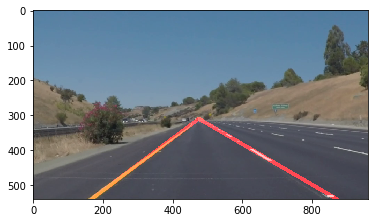

In [77]:
yellow_output = 'yellow4.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [79]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

x3 = 257.249901575
y3 =540
x4 =575.162404566
y4 =320
x1_list[286 500 253 504 281 438 256 514 400 515 333 355 332 354]
y1_list[682 527 686 517 685 571 685 511 600 517 600 588 597 587]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.645696889014
b_avg = 842.053796174
slope_left = [-0.72429907 -0.67330677 -0.72611465 -0.6744186  -0.72173913 -0.54545455
 -0.45454545]
slope_right [ 0.62162162  0.5739645   0.57575758  0.61627907  0.60869565  0.85185185
  0.4         0.57377049  0.57407407  1.08695652  0.64      ]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|                                                                                                                                                                                                              | 0/251 [00:00<?, ?it/s]

x3 = 320.413440384
y3 =540
x4 =645.167335718
y4 =320
x1_list[286 500 253 504 281 438 256 514 400 515 333 355 332 354]
y1_list[682 527 686 517 685 571 685 511 600 517 600 588 597 587]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.645696889014
b_avg = 842.053796174
slope_left = [-0.72429907 -0.67330677 -0.72611465 -0.6744186  -0.72173913 -0.54545455
 -0.45454545]
slope_right [ 0.62162162  0.5739645   0.57575758  0.61627907  0.60869565  0.85185185
  0.4         0.57377049  0.57407407  1.08695652  0.64      ]


  0%|▊                                                                                                                                                                                                     | 1/251 [00:00<00:51,  4.83it/s]

x3 = 343.74650886
y3 =540
x4 =685.771542469
y4 =320
x1_list[281 494 253 501 255 439 276 300 277 302 289 477 429 455 281 382 429 452
 390 478 456 477 276 302 276 297]
y1_list[685 531 686 519 685 561 630 616 633 619 661 534 375 367 684 611 374 367
 607 543 368 361 633 618 631 618]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.575427634685
b_avg = 769.129722798
slope_left = [-0.72300469 -0.6733871  -0.67391304 -0.58333333 -0.56       -0.67553191
 -0.30769231 -0.72277228 -0.30434783 -0.72727273 -0.33333333 -0.57692308
 -0.61904762]
slope_right [ 0.57377049  0.60869565  0.61363636  0.59090909  0.60869565  0.57894737
  0.65        0.62385321  0.61702128  1.03333333  0.61538462]


  1%|█▌                                                                                                                                                                                                    | 2/251 [00:00<00:50,  4.93it/s]

x3 = 373.946143066
y3 =540
x4 =719.561999075
y4 =320
x1_list[286 478 257 407 446 619 419 530 187 226 331 490 282 379 284 459 197 229
 230 260 197 230]
y1_list[682 543 684 583 555 447 573 503 681 659 650 535 684 614 665 547 679 659
 534 525 680 661]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.621478684807
b_avg = 816.19255806
slope_left = [-0.72395833 -0.67333333 -0.62427746 -0.63063063 -0.56410256 -0.72327044
 -0.72164948 -0.67428571 -0.625      -0.3        -0.57575758]
slope_right [ 0.61016949  0.58064516  0.56896552  0.62264151  0.57142857  0.56666667
  0.96969697  0.63636364  0.63636364]


  1%|██▎                                                                                                                                                                                                   | 3/251 [00:00<00:50,  4.86it/s]

x3 = 400.593746079
y3 =540
x4 =744.958499418
y4 =320
x1_list[426 610 256 481 469 556 283 330 404 529 343 448 314 362 357 383 385 424
 490 565 227 257]
y1_list[580 456 685 534 543 485 684 652 596 511 626 555 662 629 631 613 610 583
 530 480 535 526]
x2_list[]
y2_list[]
num_points_left11
num_points_right5
a_avg = -0.644319492051
b_avg = 838.17268908
slope_left = [-0.67391304 -0.67111111 -0.66666667 -0.68085106 -0.68       -0.67619048
 -0.6875     -0.69230769 -0.69230769 -0.66666667 -0.3       ]
slope_right [ 0.60606061  0.73529412  0.65        0.62068966  0.33333333]


  2%|███▏                                                                                                                                                                                                  | 4/251 [00:00<00:51,  4.76it/s]

x3 = 424.536308596
y3 =540
x4 =761.235813871
y4 =320
x1_list[284 446 272 456 319 406 448 489 462 512 441 464 427 515 295 361 419 466
 482 563 449 474 372 441 282 334]
y1_list[685 568 676 552 643 584 568 539 548 516 563 547 582 522 679 628 577 546
 536 482 566 549 620 573 670 633]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.690057684881
b_avg = 871.505290531
slope_left = [-0.72222222 -0.67391304 -0.67816092 -0.70731707 -0.64       -0.69565217
 -0.68181818 -0.77272727 -0.65957447 -0.66666667 -0.68       -0.68115942
 -0.71153846]
slope_right [ 0.65625     0.57142857  0.60526316  0.61538462  0.61904762  1.45833333
  0.625       0.64705882]


  2%|███▉                                                                                                                                                                                                  | 5/251 [00:01<00:52,  4.66it/s]

x3 = 441.753696152
y3 =540
x4 =770.617512582
y4 =320
x1_list[260 463 398 468 419 588 463 581 285 390 384 446 259 420 297 356 454 474
 375 396]
y1_list[685 549 605 555 579 466 560 475 685 609 615 570 685 577 659 619 566 551
 621 605]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.708350878195
b_avg = 881.373839006
slope_left = [-0.66995074 -0.71428571 -0.66863905 -0.72033898 -0.72380952 -0.72580645
 -0.67080745 -0.6779661  -0.75       -0.76190476]
slope_right [ 0.61363636  0.73684211  0.71428571  0.64        0.95238095  0.525       0.625     ]


  2%|████▋                                                                                                                                                                                                 | 6/251 [00:01<00:53,  4.62it/s]

x3 = 451.494970864
y3 =540
x4 =781.590311642
y4 =320
x1_list[404 573 466 552 333 589 289 410 485 544 262 396 336 439 290 344 450 472]
y1_list[602 480 547 489 637 465 683 596 543 500 684 594 650 576 682 643 476 469]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.66072237255
b_avg = 853.330810669
slope_left = [-0.72189349 -0.6744186  -0.671875   -0.71900826 -0.72881356 -0.67164179
 -0.7184466  -0.72222222 -0.31818182]
slope_right [ 0.62745098  0.67647059  0.67346939  0.83870968  0.84615385  0.78378378
  0.52173913  0.82608696  0.6       ]


  3%|█████▌                                                                                                                                                                                                | 7/251 [00:01<00:52,  4.63it/s]

x3 = 461.097954826
y3 =540
x4 =784.524293518
y4 =320
x1_list[263 487 350 582 290 400 449 563 317 375 479 512 459 486]
y1_list[685 534 642 474 684 605 559 482 648 611 548 523 564 542]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.714598156491
b_avg = 885.51172263
slope_left = [-0.67410714 -0.72413793 -0.71818182 -0.6754386  -0.63793103 -0.75757576
 -0.81481481]
slope_right [ 0.61290323  0.66666667  0.61764706  0.67272727  0.66666667  0.68
  0.65217391  0.32        6.66666667  0.7         0.68181818  0.4       ]


  3%|██████▎                                                                                                                                                                                               | 8/251 [00:01<00:51,  4.74it/s]

x3 = 467.696754906
y3 =540
x4 =790.91900188
y4 =320
x1_list[293 458 268 397 437 582 393 421 430 461 406 432 423 569 408 443 354 388
 383 405 451 597 452 540 290 317 341 436]
y1_list[684 564 684 597 567 469 598 580 572 552 589 572 589 483 588 564 625 603
 605 591 558 460 567 503 669 650 650 581]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.681650516282
b_avg = 869.301243901
slope_left = [-0.72727273 -0.6744186  -0.67586207 -0.64285714 -0.64516129 -0.65384615
 -0.7260274  -0.68571429 -0.64705882 -0.63636364 -0.67123288 -0.72727273
 -0.7037037  -0.72631579]
slope_right [ 0.62337662  0.66666667  0.65714286  0.61333333  0.82758621  0.48275862
  0.65714286]


  4%|███████                                                                                                                                                                                               | 9/251 [00:01<00:55,  4.37it/s]

x3 = 468.978482067
y3 =540
x4 =795.1781844
y4 =320
x1_list[415 585 401 601 414 575 288 392 298 402 224 260 356 403 297 411 284 318
 409 432 400 420 270 293 465 520]
y1_list[583 468 593 458 596 479 672 601 683 607 540 529 625 593 683 600 675 653
 600 584 607 593 684 670 558 518]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.660368951765
b_avg = 851.673791855
slope_left = [-0.67647059 -0.675      -0.72670807 -0.68269231 -0.73076923 -0.30555556
 -0.68085106 -0.72807018 -0.64705882 -0.69565217 -0.7        -0.60869565
 -0.72727273]
slope_right [ 0.62365591  0.58139535  0.53125     1.52941176  0.58064516  0.56521739
  0.58064516  0.58333333  0.60869565  0.66      ]


  4%|███████▊                                                                                                                                                                                             | 10/251 [00:02<00:55,  4.36it/s]

x3 = 467.816264759
y3 =540
x4 =791.375562125
y4 =320
x1_list[386 591 425 597 298 366 394 544 354 423 276 384 425 463 362 387 311 344
 347 372 426 576 326 350]
y1_list[618 469 577 461 685 635 599 497 643 592 684 606 375 363 623 604 676 652
 634 615 588 479 649 631]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.693135292935
b_avg = 862.380291432
slope_left = [-0.72682927 -0.6744186  -0.73529412 -0.68       -0.73913043 -0.72222222
 -0.31578947 -0.76       -0.72727273 -0.76       -0.72666667 -0.75      ]
slope_right [ 0.62601626  0.57692308  0.57647059  0.45833333  0.62096774  0.625       0.575
  0.5862069   0.90909091  0.90243902]


  4%|████████▋                                                                                                                                                                                            | 11/251 [00:02<00:54,  4.40it/s]

x3 = 461.826543557
y3 =540
x4 =764.223233136
y4 =320
x1_list[404 587 336 439 484 583 309 393 274 407 441 489 339 433 428 448 453 463
 480 498 307 335 481 504 308 360 294 314]
y1_list[604 471 641 567 536 469 676 614 685 589 567 533 653 584 576 561 382 362
 431 405 679 656 539 524 677 639 670 655]
x2_list[]
y2_list[]
num_points_left14
num_points_right15
a_avg = -0.869505859327
b_avg = 929.408657695
slope_left = [-0.72677596 -0.7184466  -0.67676768 -0.73809524 -0.72180451 -0.70833333
 -0.73404255 -0.75       -2.         -1.44444444 -0.82142857 -0.65217391
 -0.73076923 -0.75      ]
slope_right [ 0.62275449  0.58064516  0.62130178  0.58024691  0.6         0.55
  0.59090909  0.34615385  1.35        0.5625      0.58181818  1.33333333
  0.53846154  0.90909091  0.53846154]


  5%|█████████▍                                                                                                                                                                                           | 12/251 [00:02<00:52,  4.59it/s]

x3 = 459.015621537
y3 =540
x4 =772.161428064
y4 =320
x1_list[271 323 369 596 409 522 350 472 335 426 296 362 474 600 408 433 339 452
 488 524 275 303]
y1_list[685 650 630 465 588 511 629 546 640 578 685 637 543 458 380 367 653 570
 466 455 684 663]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.650450580083
b_avg = 834.300790291
slope_left = [-0.67307692 -0.72687225 -0.68141593 -0.68032787 -0.68131868 -0.72727273
 -0.67460317 -0.52       -0.73451327 -0.30555556 -0.75      ]
slope_right [ 0.58333333  0.62162162  0.52631579  0.625       0.59090909  0.53333333
  1.57142857  0.62222222  0.59259259]


  5%|██████████▏                                                                                                                                                                                          | 13/251 [00:02<00:49,  4.80it/s]

x3 = 460.925014696
y3 =540
x4 =780.087062155
y4 =320
x1_list[407 521 289 380 311 475 295 397 416 521 478 521 390 416 366 392 272 295
 454 546 269 293 269 291 298 363]
y1_list[591 509 672 610 673 553 685 611 595 518 468 455 603 583 618 601 641 626
 558 492 638 624 639 626 667 620]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.660264218662
b_avg = 847.273937316
slope_left = [-0.71929825 -0.68131868 -0.73170732 -0.7254902  -0.73333333 -0.30232558
 -0.76923077 -0.65384615 -0.65217391 -0.7173913  -0.58333333 -0.59090909
 -0.72307692]
slope_right [ 0.57017544  0.61956522  0.62135922  0.57894737  0.58333333  0.57692308
  0.31578947  2.1         1.11538462  0.6         1.04166667  0.55      ]


  6%|██████████▉                                                                                                                                                                                          | 14/251 [00:03<00:51,  4.60it/s]

x3 = 468.214992443
y3 =540
x4 =785.832821252
y4 =320
x1_list[422 536 485 587 386 499 314 417 314 416 297 375 274 353 335 356 441 598
 194 214 409 430 323 354 487 550 411 507]
y1_list[580 498 543 469 617 534 656 582 671 596 684 627 684 627 675 663 576 462
 682 669 589 573 683 665 534 489 587 518]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.70060425088
b_avg = 879.950655962
slope_left = [-0.71929825 -0.7254902  -0.73451327 -0.7184466  -0.73529412 -0.73076923
 -0.72151899 -0.57142857 -0.72611465 -0.65       -0.76190476 -0.58064516
 -0.71428571 -0.71875   ]
slope_right [ 0.56521739  0.60869565  0.72        0.45833333  0.65217391  0.7
  0.61904762  0.65        0.66666667  0.30434783  1.84615385]


  6%|███████████▊                                                                                                                                                                                         | 15/251 [00:03<00:52,  4.46it/s]

x3 = 465.723607145
y3 =540
x4 =784.36378383
y4 =320
x1_list[472 589 274 374 345 510 319 432 296 369 392 536 376 466 452 475 324 347
 476 541]
y1_list[553 468 685 613 635 516 668 585 685 632 602 498 625 559 568 552 441 434
 551 501]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.685303484409
b_avg = 855.178182354
slope_left = [-0.72649573 -0.72       -0.72121212 -0.73451327 -0.7260274  -0.72222222
 -0.73333333 -0.69565217 -0.30434783 -0.76923077]
slope_right [ 0.55882353  0.6         0.6         1.47058824  0.90909091  1.10344828
  0.58333333]


  6%|████████████▌                                                                                                                                                                                        | 16/251 [00:03<00:54,  4.35it/s]

x3 = 463.49339997
y3 =540
x4 =776.427037367
y4 =320
x1_list[328 526 379 518 357 486 275 334 470 540 308 392 298 323 319 344 383 408
 332 361 476 513 302 338 358 379]
y1_list[647 504 625 517 641 541 683 641 555 501 678 613 684 665 653 634 377 364
 644 622 539 514 682 654 625 609]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.73426737269
b_avg = 876.507088208
slope_left = [-0.72222222 -0.77697842 -0.7751938  -0.71186441 -0.77142857 -0.77380952
 -0.76       -0.76       -0.52       -0.75862069 -0.67567568 -0.77777778
 -0.76190476]
slope_right [ 0.33333333  0.62162162  0.575       0.81818182  1.5         0.62857143]


  7%|█████████████▎                                                                                                                                                                                       | 17/251 [00:03<00:51,  4.52it/s]

x3 = 463.975130083
y3 =540
x4 =786.357017764
y4 =320
x1_list[276 475 290 514 301 416 383 508 453 505 438 480 275 321 319 459]
y1_list[684 540 675 513 684 595 622 525 478 462 482 469 684 651 671 562]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.638740533723
b_avg = 837.077690173
slope_left = [-0.72361809 -0.72321429 -0.77391304 -0.776      -0.30769231 -0.30952381
 -0.7173913  -0.77857143]
slope_right [ 0.57575758  0.59259259  0.73076923  0.6         0.57142857  0.57446809
  0.57142857  1.27586207]


  7%|██████████████▏                                                                                                                                                                                      | 18/251 [00:03<00:50,  4.60it/s]

x3 = 469.244649226
y3 =540
x4 =790.172367128
y4 =320
x1_list[448 587 276 468 456 519 366 399 404 462 343 393 300 341 299 354 390 410
 477 576 280 508 426 487 396 419 374 394 338 358]
y1_list[570 469 684 545 555 510 498 488 604 561 651 614 684 654 684 644 615 601
 548 476 682 517 587 542 610 594 627 613 655 641]
x2_list[]
y2_list[]
num_points_left15
num_points_right13
a_avg = -0.692837762675
b_avg = 873.629230575
slope_left = [-0.72661871 -0.72395833 -0.71428571 -0.3030303  -0.74137931 -0.74
 -0.73170732 -0.72727273 -0.7        -0.72727273 -0.72368421 -0.73770492
 -0.69565217 -0.7        -0.7       ]
slope_right [ 0.61904762  0.67857143  0.57142857  0.57407407  0.52173913  0.55        0.90625
  0.625       0.6         0.58333333  0.66666667  0.58823529  1.14285714]


  8%|██████████████▉                                                                                                                                                                                      | 19/251 [00:04<00:51,  4.48it/s]

x3 = 464.540846064
y3 =540
x4 =790.780092222
y4 =320
x1_list[275 470 399 502 319 472 275 430 474 580 428 483 299 352 412 458 398 421
 452 586 468 511 331 370 437 477 308 330 361 393]
y1_list[685 544 596 522 671 552 684 572 551 474 482 465 684 645 486 472 374 367
 568 470 547 516 660 631 580 550 678 662 637 613]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.649671243145
b_avg = 834.668335775
slope_left = [-0.72307692 -0.7184466  -0.77777778 -0.72258065 -0.72641509 -0.30909091
 -0.73584906 -0.30434783 -0.30434783 -0.73134328 -0.72093023 -0.74358974
 -0.75       -0.72727273 -0.75      ]
slope_right [ 0.57692308  0.57352941  0.58064516  0.58823529  0.83783784  0.31818182
  0.58064516  0.96551724  0.59259259]


  8%|███████████████▋                                                                                                                                                                                     | 20/251 [00:04<00:52,  4.41it/s]

x3 = 470.700854634
y3 =540
x4 =788.15945297
y4 =320
x1_list[306 476 275 464 463 589 470 581 303 331 448 546 367 481 274 380 330 357
 397 424 323 396 441 523]
y1_list[681 549 685 548 549 464 554 473 683 660 571 499 619 537 685 608 662 640
 609 590 667 610 565 509]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.740814522664
b_avg = 899.350017829
slope_left = [-0.77647059 -0.72486772 -0.67460317 -0.72972973 -0.82142857 -0.73469388
 -0.71929825 -0.72641509 -0.81481481 -0.7037037  -0.78082192 -0.68292683]
slope_right [ 0.61904762  0.57142857  0.66666667  0.61538462  0.57647059  0.36363636
  0.9375      0.61842105  0.82926829]


  8%|████████████████▍                                                                                                                                                                                    | 21/251 [00:04<00:53,  4.30it/s]

x3 = 474.318050858
y3 =540
x4 =787.493204438
y4 =320
x1_list[280 460 435 588 335 404 377 450 298 358 386 478 274 353 464 538 275 405
 486 546 301 323]
y1_list[680 550 579 468 655 604 623 569 683 639 604 538 683 626 549 496 683 589
 534 491 682 666]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.725640458067
b_avg = 890.308863518
slope_left = [-0.72222222 -0.7254902  -0.73913043 -0.73972603 -0.73333333 -0.7173913
 -0.72151899 -0.71621622 -0.72307692 -0.71666667 -0.72727273]
slope_right [ 0.61616162  0.54761905  0.57627119  0.54545455  0.85714286  0.61666667
  0.84848485  0.6         1.375       0.86666667  0.85294118  0.56603774
  0.30769231  0.81818182]


  9%|█████████████████▎                                                                                                                                                                                   | 22/251 [00:04<00:53,  4.28it/s]

x3 = 476.678643105
y3 =540
x4 =788.188138543
y4 =320
x1_list[297 372 347 370 391 493 422 534 403 485 286 323 415 509 329 397 307 337
 365 432 271 291 328 361 274 295 300 326]
y1_list[684 629 631 616 613 538 589 507 591 535 676 648 582 518 660 610 661 638
 618 572 684 672 646 621 684 668 683 664]
x2_list[]
y2_list[]
num_points_left14
num_points_right18
a_avg = -0.715161183555
b_avg = 884.841205117
slope_left = [-0.73333333 -0.65217391 -0.73529412 -0.73214286 -0.68292683 -0.75675676
 -0.68085106 -0.73529412 -0.76666667 -0.68656716 -0.6        -0.75757576
 -0.76190476 -0.73076923]
slope_right [ 0.57746479  0.62204724  0.57692308  0.33333333  0.60416667  0.33333333
  0.58024691  0.5         0.85365854  2.0625      0.31034483  1.8
  0.82352941  1.875       3.25        0.80952381  0.45454545  0.58823529]


  9%|██████████████████                                                                                                                                                                                   | 23/251 [00:05<00:56,  4.00it/s]

x3 = 468.317946168
y3 =540
x4 =791.218480181
y4 =320
x1_list[394 476 485 508 376 478 359 450 292 343 297 357 330 376 300 327 330 384
 275 304 233 256 476 499 460 498 355 375 225 246]
y1_list[597 541 542 526 624 549 622 560 670 635 684 640 643 611 683 663 659 619
 683 663 536 528 549 533 551 525 506 500 538 531]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.629507372907
b_avg = 822.528985795
slope_left = [-0.68292683 -0.69565217 -0.73529412 -0.68131868 -0.68627451 -0.73333333
 -0.69565217 -0.74074074 -0.74074074 -0.68965517 -0.34782609 -0.69565217
 -0.68421053 -0.3        -0.33333333]
slope_right [ 0.6         0.62037037  0.57386364  0.57386364  0.62195122  0.61290323
  0.80769231  0.62195122]


 10%|██████████████████▊                                                                                                                                                                                  | 24/251 [00:05<00:55,  4.12it/s]

x3 = 465.943230081
y3 =540
x4 =782.484197448
y4 =320
x1_list[273 374 366 453 398 534 366 502 321 344 312 332 334 360 320 341 483 510
 343 439 473 575 445 496 359 387 276 334 438 459]
y1_list[684 611 631 567 596 498 618 520 604 596 672 658 655 637 609 596 544 522
 648 578 550 476 572 534 623 602 681 639 432 407]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.729196411221
b_avg = 875.723650829
slope_left = [-0.72277228 -0.73563218 -0.72058824 -0.72058824 -0.34782609 -0.7
 -0.69230769 -0.61904762 -0.81481481 -0.72916667 -0.7254902  -0.74509804
 -0.75       -0.72413793 -1.19047619]
slope_right [ 0.57419355  0.61904762  0.61904762  0.62295082  0.61904762  0.61445783
  0.61904762  0.61788618  0.57792208  0.61904762]


 10%|███████████████████▌                                                                                                                                                                                 | 25/251 [00:05<00:55,  4.09it/s]

x3 = 465.809862341
y3 =540
x4 =780.319446509
y4 =320
x1_list[347 494 311 498 273 340 303 373 444 536 256 278 448 540 252 275 299 329
 370 502 351 518 252 278]
y1_list[648 534 658 523 684 636 681 627 574 503 647 634 560 494 645 631 683 660
 631 528 630 509 646 631]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.710205055801
b_avg = 870.599509574
slope_left = [-0.7755102  -0.72192513 -0.71641791 -0.77142857 -0.77173913 -0.59090909
 -0.7173913  -0.60869565 -0.76666667 -0.78030303 -0.7245509  -0.57692308]
slope_right [ 0.57692308  0.56        0.6125      0.36363636  0.60526316  0.31428571
  0.72727273  0.325       0.55555556  0.57142857]


 10%|████████████████████▍                                                                                                                                                                                | 26/251 [00:05<00:56,  3.97it/s]

x3 = 464.742346131
y3 =540
x4 =773.446800424
y4 =320
x1_list[461 569 299 351 336 506 303 474 401 459 454 537 383 431 277 298 434 456
 423 476 304 325 366 410 304 341 322 353 301 324]
y1_list[548 475 665 629 656 524 681 548 591 551 565 501 604 571 682 666 423 405
 575 539 680 663 618 586 663 635 650 626 665 647]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.745360592981
b_avg = 884.544033494
slope_left = [-0.67592593 -0.69230769 -0.77647059 -0.77777778 -0.68965517 -0.77108434
 -0.6875     -0.76190476 -0.81818182 -0.67924528 -0.80952381 -0.72727273
 -0.75675676 -0.77419355 -0.7826087 ]
slope_right [ 0.48148148  0.60714286  0.3         0.6         0.625       0.3
  0.54545455  0.57575758  0.5       ]


 11%|█████████████████████▏                                                                                                                                                                               | 27/251 [00:06<00:55,  4.03it/s]

x3 = 461.995548808
y3 =540
x4 =765.202987195
y4 =320
x1_list[273 482 301 463 461 522 298 390 350 508 409 498 449 534 272 420 420 451]
y1_list[684 533 682 556 559 512 683 612 629 515 599 530 558 497 684 577 433 407]
x2_list[]
y2_list[]
num_points_left9
num_points_right4
a_avg = -0.757625149467
b_avg = 885.163680342
slope_left = [-0.72248804 -0.77777778 -0.7704918  -0.77173913 -0.72151899 -0.7752809
 -0.71764706 -0.72297297 -0.83870968]
slope_right [ 0.66666667  0.74074074  0.72727273  0.63333333]


 11%|█████████████████████▉                                                                                                                                                                               | 28/251 [00:06<00:59,  3.72it/s]

x3 = 466.78212951
y3 =540
x4 =766.364507045
y4 =320
x1_list[271 437 302 463 296 417 469 525 308 495 371 486 473 497]
y1_list[684 564 680 555 684 590 552 509 658 523 627 538 540 522]
x2_list[]
y2_list[]
num_points_left7
num_points_right9
a_avg = -0.755691986564
b_avg = 901.183602996
slope_left = [-0.72289157 -0.77639752 -0.7768595  -0.76785714 -0.72192513 -0.77391304
 -0.75      ]
slope_right [ 0.66666667  0.76        0.62162162  0.33333333  0.66666667  0.97435897
  0.66666667  1.0952381   0.45      ]


 12%|██████████████████████▊                                                                                                                                                                              | 29/251 [00:06<01:01,  3.63it/s]

x3 = 461.834283087
y3 =540
x4 =745.543008792
y4 =320
x1_list[270 428 475 509 486 530 462 488 410 437 314 383 269 352 440 488 373 400
 433 458 414 446 427 460 442 469 398 427 294 346 390 420 162 167 344 407
 474 545]
y1_list[684 570 537 515 538 506 556 538 595 576 668 617 684 624 563 529 623 604
 568 549 430 405 582 559 571 552 593 571 683 645 610 589 656 636 645 599
 547 496]
x2_list[]
y2_list[]
num_points_left19
num_points_right11
a_avg = -0.891879099087
b_avg = 941.603622437
slope_left = [-0.72151899 -0.64705882 -0.72727273 -0.69230769 -0.7037037  -0.73913043
 -0.72289157 -0.70833333 -0.7037037  -0.76       -0.78125    -0.6969697
 -0.7037037  -0.75862069 -0.73076923 -0.7        -4.         -0.73015873
 -0.71830986]
slope_right [ 0.60869565  0.57692308  0.8         0.6744186   0.61702128  0.58333333
  0.3         0.35294118  0.65853659  0.625       0.71428571]


 12%|███████████████████████▌                                                                                                                                                                             | 30/251 [00:07<01:06,  3.31it/s]

x3 = 467.420478244
y3 =540
x4 =758.925591448
y4 =320
x1_list[401 477 403 546 268 400 354 456 451 528 341 405 291 351 448 546 267 332
 330 416 308 384 479 502]
y1_list[589 537 600 496 685 590 637 562 564 508 647 600 685 641 556 490 685 638
 641 579 672 616 534 520]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.710372475197
b_avg = 881.301960409
slope_left = [-0.68421053 -0.72727273 -0.71969697 -0.73529412 -0.72727273 -0.734375
 -0.73333333 -0.67346939 -0.72307692 -0.72093023 -0.73684211 -0.60869565]
slope_right [ 0.63265306  0.66037736  0.64        0.77419355  0.61111111  0.83870968
  0.66666667  0.6         0.55        0.91304348  0.375       0.3       ]


 12%|████████████████████████▎                                                                                                                                                                            | 31/251 [00:07<01:03,  3.48it/s]

x3 = 462.271929676
y3 =540
x4 =765.785068835
y4 =320
x1_list[327 414 418 547 452 507 420 526 270 385 291 337 389 414 446 513 266 299
 352 454 224 263 356 381 438 458 280 318 413 454]
y1_list[656 592 576 489 562 522 586 509 682 599 684 650 598 579 556 511 524 514
 637 562 536 524 621 602 573 559 674 648 581 552]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.663586286286
b_avg = 838.785465212
slope_left = [-0.73563218 -0.6744186  -0.72727273 -0.72641509 -0.72173913 -0.73913043
 -0.76       -0.67164179 -0.3030303  -0.73529412 -0.30769231 -0.76       -0.7
 -0.68421053 -0.70731707]
slope_right [ 0.62318841  0.61538462  0.62903226  1.61904762  0.31034483  0.625
  0.63636364  1.03225806  1.47368421  1.52380952  1.08695652]


 13%|█████████████████████████                                                                                                                                                                            | 32/251 [00:07<00:59,  3.67it/s]

x3 = 458.402934225
y3 =540
x4 =755.911667131
y4 =320
x1_list[374 525 288 395 444 494 337 440 415 503 294 397 264 309 304 408 405 475
 414 433 284 308]
y1_list[620 510 684 606 557 525 634 560 589 525 664 590 684 652 672 596 586 536
 430 404 671 653]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.776018347615
b_avg = 888.723460827
slope_left = [-0.72847682 -0.72897196 -0.64       -0.7184466  -0.72727273 -0.7184466
 -0.71111111 -0.73076923 -0.71428571 -1.36842105 -0.75      ]
slope_right [ 0.6         0.6744186   0.60526316  0.58823529  0.66666667  0.67567568
  0.58490566  0.57142857  0.33333333  1.47619048  0.60869565]


 13%|█████████████████████████▉                                                                                                                                                                           | 33/251 [00:07<00:55,  3.89it/s]

x3 = 453.509142851
y3 =540
x4 =765.817940613
y4 =320
x1_list[270 414 361 515 425 459 224 268 460 485 276 297 289 384 264 345 329 422
 398 486 288 358]
y1_list[681 577 629 517 570 548 536 522 546 531 521 514 683 613 684 626 639 572
 601 537 684 633]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.634294061445
b_avg = 820.415249573
slope_left = [-0.72222222 -0.72727273 -0.64705882 -0.31818182 -0.6        -0.33333333
 -0.73684211 -0.71604938 -0.72043011 -0.72727273 -0.72857143]
slope_right [ 0.625       0.61538462  0.60784314  0.32758621  0.32142857  0.61702128
  0.31481481  0.95        1.69230769  0.625       0.90909091  0.32075472
  0.66666667  0.47826087  0.61538462]


 14%|██████████████████████████▋                                                                                                                                                                          | 34/251 [00:08<00:52,  4.13it/s]

x3 = 460.365414056
y3 =540
x4 =771.950435497
y4 =320
x1_list[263 353 300 505 349 536 364 470 287 311 331 373 262 309 299 357 375 481]
y1_list[685 620 674 525 623 497 626 549 684 667 637 607 685 651 675 633 604 533]
x2_list[]
y2_list[]
num_points_left9
num_points_right15
a_avg = -0.709915103447
b_avg = 878.177558333
slope_left = [-0.72222222 -0.72682927 -0.67379679 -0.72641509 -0.70833333 -0.71428571
 -0.72340426 -0.72413793 -0.66981132]
slope_right [ 0.61363636  0.62043796  0.61016949  0.62        0.85        0.76190476
  0.61445783  0.51724138  0.91304348  0.625       0.34285714  0.91304348
  0.84615385  0.6         0.66666667]


 14%|███████████████████████████▍                                                                                                                                                                         | 35/251 [00:08<00:56,  3.86it/s]

x3 = 465.876264393
y3 =540
x4 =777.060334105
y4 =320
x1_list[284 527 278 545 338 522 350 427 472 541 262 312 473 493 264 320 300 457
 287 343]
y1_list[685 509 672 492 630 506 636 580 550 500 684 650 549 534 682 644 673 559
 684 643]
x2_list[]
y2_list[]
num_points_left10
num_points_right19
a_avg = -0.709108952607
b_avg = 879.475214278
slope_left = [-0.72427984 -0.6741573  -0.67391304 -0.72727273 -0.72463768 -0.68       -0.75
 -0.67857143 -0.72611465 -0.73214286]
slope_right [ 0.61111111  0.58024691  0.57936508  0.62162162  0.57142857  0.56521739
  0.6         0.33333333  0.33333333  0.55        0.64        0.91666667
  0.72        0.375       0.6         0.3         0.57777778  0.65217391
  0.57142857]


 14%|████████████████████████████▎                                                                                                                                                                        | 36/251 [00:08<00:55,  3.86it/s]

x3 = 466.9971121
y3 =540
x4 =785.281220101
y4 =320
x1_list[256 531 283 472 488 561 258 320 322 507 304 325 487 577 307 332 284 425
 450 471]
y1_list[685 500 685 548 536 487 685 643 640 515 611 601 537 477 613 600 683 581
 565 549]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.65700890649
b_avg = 848.539544783
slope_left = [-0.67272727 -0.72486772 -0.67123288 -0.67741935 -0.67567568 -0.47619048
 -0.66666667 -0.52       -0.72340426 -0.76190476]
slope_right [ 0.57342657  0.62121212  0.4375      0.57983193  0.52173913  0.61956522
  0.57142857  0.48        0.45        0.62162162  0.58139535  0.45
  1.04347826  2.          0.62068966]


 15%|█████████████████████████████                                                                                                                                                                        | 37/251 [00:08<00:56,  3.78it/s]

x3 = 461.543171724
y3 =540
x4 =777.793486187
y4 =320
x1_list[256 530 254 507 395 527 462 506 309 367 237 262 281 324 337 381 362 414
 236 263 403 436 425 464 389 418]
y1_list[685 501 685 515 604 509 555 523 664 624 648 636 685 654 644 614 626 590
 653 638 597 574 581 555 437 402]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.706249157892
b_avg = 856.976847833
slope_left = [-0.67153285 -0.67193676 -0.71969697 -0.72727273 -0.68965517 -0.48
 -0.72093023 -0.68181818 -0.69230769 -0.55555556 -0.6969697  -0.66666667
 -1.20689655]
slope_right [ 0.57777778  0.76190476  0.62195122  0.57575758  0.625       0.84
  0.57894737  0.72727273  2.2         0.65        0.54285714]


 15%|█████████████████████████████▊                                                                                                                                                                       | 38/251 [00:09<00:54,  3.90it/s]

x3 = 453.695758476
y3 =540
x4 =781.331197283
y4 =320
x1_list[314 504 255 523 282 421 460 567 441 483 281 415 257 393 226 252 240 270
 422 462]
y1_list[645 517 685 505 685 585 555 483 569 540 685 588 685 593 534 526 530 521
 585 554]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.621116734168
b_avg = 810.424988538
slope_left = [-0.67368421 -0.67164179 -0.71942446 -0.6728972  -0.69047619 -0.7238806
 -0.67647059 -0.30769231 -0.3        -0.775     ]
slope_right [ 0.62068966  0.65384615  0.73076923  0.63636364  0.60714286  0.56666667
  1.625       0.79310345  1.04761905  0.65        1.5         0.6       ]


 16%|██████████████████████████████▌                                                                                                                                                                      | 39/251 [00:09<00:51,  4.15it/s]

x3 = 460.997781288
y3 =540
x4 =782.120591751
y4 =320
x1_list[323 492 478 519 284 379 258 513 383 449 443 482 404 431 259 346 433 467
 289 382 454 483]
y1_list[639 525 544 515 684 615 684 512 614 563 568 541 596 576 684 625 576 550
 681 614 561 539]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.719126562221
b_avg = 883.768266293
slope_left = [-0.67455621 -0.70731707 -0.72631579 -0.6745098  -0.77272727 -0.69230769
 -0.74074074 -0.67816092 -0.76470588 -0.72043011 -0.75862069]
slope_right [ 0.67741935  0.34285714  0.58064516  0.60606061  0.62857143  0.66666667
  0.30555556  1.5         0.80952381  0.9       ]


 16%|███████████████████████████████▍                                                                                                                                                                     | 40/251 [00:09<00:49,  4.25it/s]

x3 = 466.964012245
y3 =540
x4 =786.01695827
y4 =320
x1_list[284 487 304 465 283 323 469 511 473 514 326 351 340 361 439 468 260 299
 466 571 262 314 362 392 384 407 408 428]
y1_list[666 529 669 552 685 656 542 514 548 519 656 638 641 629 572 550 684 656
 552 481 683 646 627 606 611 595 594 579]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.700139125167
b_avg = 876.686555704
slope_left = [-0.67487685 -0.72670807 -0.725      -0.66666667 -0.70731707 -0.72
 -0.57142857 -0.75862069 -0.71794872 -0.67619048 -0.71153846 -0.7
 -0.69565217 -0.75      ]
slope_right [ 0.6         0.91666667  0.80952381  0.79166667  0.54166667  0.60606061
  0.77142857  0.42857143  0.725       0.47619048  0.9047619   0.59259259
  0.83333333]


 16%|████████████████████████████████▏                                                                                                                                                                    | 41/251 [00:09<00:50,  4.17it/s]

x3 = 465.516473685
y3 =540
x4 =790.20226847
y4 =320
x1_list[282 457 255 477 421 491 257 334 468 513 481 531 481 520 476 499 462 482]
y1_list[685 558 685 536 585 535 685 633 552 520 535 502 431 419 538 522 547 533]
x2_list[]
y2_list[]
num_points_left9
num_points_right19
a_avg = -0.651216826579
b_avg = 840.952617291
slope_left = [-0.72571429 -0.67117117 -0.71428571 -0.67532468 -0.71111111 -0.66
 -0.30769231 -0.69565217 -0.7       ]
slope_right [ 0.61538462  0.58333333  0.66666667  0.45        0.57142857  0.41666667
  0.58        1.12        0.48717949  0.51515152  0.95652174  0.83333333
  0.6         0.3         1.54545455  0.62222222  0.4         0.54545455
  0.83333333]


 17%|████████████████████████████████▉                                                                                                                                                                    | 42/251 [00:10<00:50,  4.17it/s]

x3 = 469.8115857
y3 =540
x4 =791.873260112
y4 =320
x1_list[255 454 283 439 417 487 472 526 429 507 425 449 449 533 260 290 353 407]
y1_list[686 552 685 572 589 539 551 512 570 518 583 565 556 503 684 663 633 596]
x2_list[]
y2_list[]
num_points_left9
num_points_right29
a_avg = -0.696337553094
b_avg = 874.126094847
slope_left = [-0.67336683 -0.72435897 -0.71428571 -0.72222222 -0.66666667 -0.75
 -0.63095238 -0.7        -0.68518519]
slope_right [ 0.32051282  0.61904762  0.57692308  0.56        0.61403509  0.6097561
  0.32432432  0.5625      2.05882353  0.63636364  0.9047619   0.9         0.56
  0.625       0.91666667  0.42857143  0.38709677  0.55172414  3.5
  0.86666667  0.60869565  0.32        5.25        0.72727273  0.63636364
  0.60869565  4.4         0.6         0.63636364]


 17%|█████████████████████████████████▋                                                                                                                                                                   | 43/251 [00:10<00:49,  4.23it/s]

x3 = 474.558046294
y3 =540
x4 =797.381885862
y4 =320
x1_list[257 464 453 601 433 550 387 481 283 317 256 415 319 374 359 435 341 385
 312 346]
y1_list[685 546 563 463 568 490 609 545 684 661 685 578 658 620 629 577 642 612
 663 640]
x2_list[]
y2_list[]
num_points_left10
num_points_right22
a_avg = -0.677752594107
b_avg = 869.139107551
slope_left = [-0.67149758 -0.67567568 -0.66666667 -0.68085106 -0.67647059 -0.67295597
 -0.69090909 -0.68421053 -0.68181818 -0.67647059]
slope_right [ 0.4         0.66666667  1.18518519  0.6         1.21428571  0.65217391
  0.6122449   1.40740741  0.65789474  0.9         0.56666667  0.92        0.6
  0.68        0.83333333  0.32258065  0.85185185  0.61764706  0.56521739
  0.44827586  0.65217391  1.90909091]


 18%|██████████████████████████████████▌                                                                                                                                                                  | 44/251 [00:10<00:47,  4.34it/s]

x3 = 464.498650418
y3 =540
x4 =768.272259991
y4 =320
x1_list[257 396 290 426 259 440 424 550 462 541 406 436 390 399 284 365 359 458
 454 489]
y1_list[685 592 681 583 685 563 575 491 558 504 587 566 383 363 684 626 632 561
 565 540]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.848362613953
b_avg = 914.15058669
slope_left = [-0.66906475 -0.72058824 -0.67403315 -0.66666667 -0.6835443  -0.7
 -2.22222222 -0.71604938 -0.71717172 -0.71428571]
slope_right [ 0.57142857  0.62068966  0.84848485  0.58064516  1.10638298  0.61403509
  0.61111111  0.81818182  0.55555556  0.3         0.83333333  0.35      ]


 18%|███████████████████████████████████▎                                                                                                                                                                 | 45/251 [00:10<00:47,  4.32it/s]

x3 = 470.22180968
y3 =540
x4 =774.85739028
y4 =320
x1_list[261 524 290 427 285 339 346 483 333 546 467 496 260 352 461 486 436 464
 481 556]
y1_list[685 508 683 584 685 646 643 544 637 494 557 535 685 623 561 542 579 558
 547 493]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.717437673444
b_avg = 886.935531293
slope_left = [-0.6730038  -0.72262774 -0.72222222 -0.72262774 -0.6713615  -0.75862069
 -0.67391304 -0.76       -0.75       -0.72      ]
slope_right [ 0.575       0.61842105  0.62162162  0.95238095  0.84375     0.43333333
  0.88461538  0.76923077  0.83870968  0.625       0.57377049  1.10526316
  0.57575758]


 18%|████████████████████████████████████                                                                                                                                                                 | 46/251 [00:10<00:50,  4.05it/s]

x3 = 474.571288933
y3 =540
x4 =780.65774915
y4 =320
x1_list[262 554 288 479 459 492 290 376 263 524 442 538]
y1_list[685 489 685 547 563 538 683 621 684 508 575 506]
x2_list[]
y2_list[]
num_points_left6
num_points_right29
a_avg = -0.710888576295
b_avg = 884.581963205
slope_left = [-0.67123288 -0.72251309 -0.75757576 -0.72093023 -0.6743295  -0.71875   ]
slope_right [ 0.57232704  0.6119403   0.62037037  0.5625      0.62195122  0.5         0.4
  0.53333333  0.59090909  0.56666667  0.62962963  0.63636364  0.52941176
  1.1         0.56410256  2.625       0.83333333  0.40909091  0.9
  0.55555556  0.5         0.60869565  0.4         0.56        1.          0.5
  0.57553957  0.5         0.52380952]


 19%|████████████████████████████████████▉                                                                                                                                                                | 47/251 [00:11<00:50,  4.04it/s]

x3 = 477.914406164
y3 =540
x4 =785.911442656
y4 =320
x1_list[264 582 290 539 406 571 291 437 266 359]
y1_list[685 471 685 505 602 483 684 578 685 622]
x2_list[]
y2_list[]
num_points_left5
num_points_right41
a_avg = -0.704101282884
b_avg = 881.992563795
slope_left = [-0.67295597 -0.72289157 -0.72121212 -0.7260274  -0.67741935]
slope_right [ 0.57309942  0.62264151  0.57342657  0.61403509  0.34146341  0.46153846
  0.72        0.77419355  0.44827586  0.61445783  0.6         0.95238095
  0.55        0.57777778  0.96774194  1.375       0.80952381  0.85714286
  0.85185185  0.9047619   0.71428571  0.53846154  0.55        0.35
  0.30769231  0.47826087  0.62264151  0.53846154  0.32142857  0.66666667
  0.35555556  0.35        0.48387097  0.60714286  0.31818182  0.45        0.6
  0.66666667  0.61538462  0.32        0.4       ]


 19%|█████████████████████████████████████▋                                                                                                                                                               | 48/251 [00:11<00:48,  4.18it/s]

x3 = 462.960688634
y3 =540
x4 =768.05146987
y4 =320
x1_list[265 443 391 572 291 553 292 576 303 325 490 531 483 530 476 529 302 322
 302 322 319 520 468 508 279 331]
y1_list[685 565 599 477 685 495 685 479 619 608 428 385 429 381 429 381 617 605
 618 606 664 518 546 519 677 640]
x2_list[]
y2_list[]
num_points_left13
num_points_right15
a_avg = -0.737489037428
b_avg = 855.695959552
slope_left = [-0.6741573  -0.67403315 -0.72519084 -0.72535211 -0.5        -1.04878049
 -1.0212766  -0.90566038 -0.6        -0.6        -0.72636816 -0.675
 -0.71153846]
slope_right [ 0.57142857  0.58064516  0.58490566  0.58333333  0.57352941  0.95        0.5625
  0.51612903  0.57142857  0.57142857  0.57534247  0.91666667  0.64        0.5
  0.30434783]


 20%|██████████████████████████████████████▍                                                                                                                                                              | 49/251 [00:11<00:47,  4.30it/s]

x3 = 446.812663041
y3 =540
x4 =752.102906763
y4 =320
x1_list[293 570 336 582 266 411 228 259 472 521 483 512 233 260 230 259 488 518
 482 522 413 555 295 543 244 265]
y1_list[684 483 637 471 685 587 660 642 433 386 432 406 660 645 658 640 432 412
 432 391 584 488 682 502 653 641]
x2_list[]
y2_list[]
num_points_left13
num_points_right20
a_avg = -0.719528798711
b_avg = 834.383649954
slope_left = [-0.72563177 -0.67479675 -0.67586207 -0.58064516 -0.95918367 -0.89655172
 -0.55555556 -0.62068966 -0.66666667 -1.025      -0.67605634 -0.72580645
 -0.57142857]
slope_right [  0.56896552   0.55555556   0.609375     0.9047619    0.56756757   0.625
   0.9          2.3          0.57142857   0.48         1.11111111
   0.42307692  10.           0.62264151   0.61290323   0.32352941
   0.30769231   0.61538462   1.375        0.55      ]


 20%|███████████████████████████████████████▏                                                                                                                                                             | 50/251 [00:11<00:47,  4.28it/s]

x3 = 454.860666761
y3 =540
x4 =767.206509225
y4 =320
x1_list[388 564 307 404 365 437 293 414 406 569 268 370 319 445 271 312 376 579
 470 498 469 520 299 325]
y1_list[615 487 658 592 618 569 685 597 589 479 685 616 666 574 684 656 610 473
 417 407 555 520 682 663]
x2_list[]
y2_list[]
num_points_left12
num_points_right23
a_avg = -0.669081633306
b_avg = 856.903384617
slope_left = [-0.72727273 -0.68041237 -0.68055556 -0.72727273 -0.67484663 -0.67647059
 -0.73015873 -0.68292683 -0.67487685 -0.35714286 -0.68627451 -0.73076923]
slope_right [ 0.32142857  0.48484848  0.6         0.51515152  0.41666667  0.54545455
  0.52777778  0.57142857  0.48571429  0.96774194  0.32142857  0.32258065
  0.84615385  0.35714286  0.59090909  2.63636364  0.85714286  0.71428571
  0.4137931   0.52380952  0.91304348  1.04        0.51724138]


 20%|████████████████████████████████████████                                                                                                                                                             | 51/251 [00:12<00:50,  3.98it/s]

x3 = 437.237859574
y3 =540
x4 =766.150432624
y4 =320
x1_list[345 568 405 568 313 580 329 457 269 367 270 310 295 351 411 484 440 467
 472 507 325 358 484 505 469 497 369 568]
y1_list[646 484 589 479 670 476 642 555 684 617 684 657 684 643 597 544 320 311
 428 407 511 501 337 329 415 402 614 480]
x2_list[]
y2_list[]
num_points_left14
num_points_right36
a_avg = -0.598528255338
b_avg = 777.087801166
slope_left = [-0.7264574  -0.67484663 -0.72659176 -0.6796875  -0.68367347 -0.675
 -0.73214286 -0.7260274  -0.33333333 -0.6        -0.3030303  -0.38095238
 -0.46428571 -0.67336683]
slope_right [  0.51612903   0.58064516   0.31034483   0.55172414   0.52777778
   0.83783784   0.56756757   0.53571429   0.62962963   0.61904762
   0.46153846   0.61904762   0.87878788   1.           0.85714286
   0.91304348   0.42307692   0.90909091   0.7826087    0.88888889   1.3
   0.4          0.5          0.84848485   0.5          0.54166667
   1.03448276   1.3          0.39285714   0.55         0.88461538
   1.1

 21%|████████████████████████████████████████▊                                                                                                                                                            | 52/251 [00:12<00:50,  3.94it/s]

x3 = 433.293575536
y3 =540
x4 =682.773359587
y4 =320
x1_list[292 578 314 451 378 561 269 322 479 486 364 570 474 499 476 496 295 376
 459 460]
y1_list[685 478 653 560 622 489 685 649 432 404 618 479 432 406 427 406 684 625
 344 320]
x2_list[]
y2_list[]
num_points_left10
num_points_right28
a_avg = -3.43017819231
b_avg = 1994.70511379
slope_left = [ -0.72377622  -0.67883212  -0.72677596  -0.67924528  -4.          -0.67475728
  -1.04        -1.05        -0.72839506 -24.        ]
slope_right [ 0.625       0.53571429  0.56666667  0.93103448  0.62790698  0.55555556
  0.53846154  0.6097561   0.5862069   0.56521739  0.9         1.25
  0.60869565  2.2         1.125       0.55555556  1.19047619  8.33333333
  0.72727273  1.5         0.625       2.21428571  0.38709677  0.9047619
  0.48275862  0.56        0.6097561   2.83333333]


 21%|█████████████████████████████████████████▌                                                                                                                                                           | 53/251 [00:12<00:51,  3.85it/s]

ValueError: cannot convert float NaN to integer

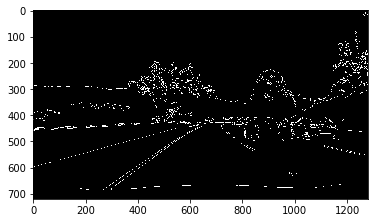

In [80]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))